In [1]:
import utils.bundleTools3 as BT
import numpy as np
from dipy.viz import actor, window
from IPython.display import clear_output
import random
import hdbscan
from collections import defaultdict
import time
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
%matplotlib inline

def display(streamlines, clusters=False, ids=False, colors=False, centroids=[], weighted=[]):
    ren = window.Renderer()
    ren.background((1, 1, 1))
    if(clusters):
        colormap = actor.create_colormap(np.arange(len(ids)))#, name='hot')
        #print(colormap)
        #random.shuffle(colormap)
        stream = []
        colors = []
        num = 0
        if(len(weighted)):
            weighted = np.array(weighted)
            xmax, xmin = weighted.max(), weighted.min()
            weighted = (weighted - xmin)/(xmax - xmin)
            for i,id_ in enumerate(ids):
                for streamline in clusters[id_]:
                    color=colormap[num]*len(streamlines[streamline])
                    ren.add(actor.streamtube([streamlines[streamline]], color, linewidth=weighted[streamline]))
                num+=1
        else:
            for i,id_ in enumerate(ids):
                for streamline in clusters[id_]:
                    stream.append(streamlines[streamline])
                    colors.append(colormap[num]*len(streamlines[streamline]))
                num+=1
            ren.add(actor.line(stream, colors))
            
    else:
        if(len(centroids)):
            ren.add(actor.line(streamlines, window.colors.black, opacity=0.05))
            ren.add(actor.streamtube(centroids, linewidth=0.001))
        else:
            if(colors):
                ren.add(actor.line(streamlines, colors))
            else:
                ren.add(actor.line(streamlines))

    window.show(ren, size=(1200, 900))

def weighted_display(streamlines, weights, clusters, ids):
    ren = window.Renderer()
    ren.background((1, 1, 1))

    colormap = actor.create_colormap(np.arange(len(ids)))#, name='hot')

    stream = []
    colors = []
    num = 0

    weights = np.array(weights)
    xmax, xmin = weights.max(), weights.min()
    weights = (weights - xmin)/((xmax - xmin)*10)
    for i,id_ in enumerate(ids):
        for streamline in clusters[id_]:
            color=colormap[num]*len(streamlines[streamline])
            ren.add(actor.streamtube([streamlines[streamline]], color, linewidth=weights[streamline]))
        num+=1
    l = actor.label(text='Hello')
    ren.add(l)
    window.show(ren, size=(1200, 900))
    
def clustered_display(clustered_streamlines, clusters_dict, ids, sample=0):
    ren = window.Renderer()
    ren.background((1, 1, 1))

    colormap = actor.create_colormap(np.arange(len(ids)))
    streamlines = []
    colors = []
    num=0
    for i,id_ in enumerate(ids):
        all_f = np.concatenate(clustered_streamlines[clusters_dict[id_]])
        if sample:
            fibers = random.sample(list(all_f), int(len(all_f)*(sample/100)))
        else:
            fibers = np.concatenate(clustered_streamlines[clusters_dict[id_]])
        streamlines.append(fibers)
        lenin = len(fibers)
        colors += [colormap[i]*10000] * lenin
    ren.add(actor.line(np.concatenate(streamlines), colors))
    window.show(ren, size=(1200, 900))
def adjusted_clustered_display(clustered_streamlines, all_centroids, weights, clusters_dict, ids,sample=0):
    ren = window.Renderer()
    ren.background((1, 1, 1))

    colormap = actor.create_colormap(np.arange(len(ids)))
    streamlines = []
    colors = []
    num=0
    for i,id_ in enumerate(ids):
        centroids = all_centroids[clusters_dict[id_]]
        super_centroid = get_centroid(centroids, weights=weights[clusters_dict[id_]])
        clusters = clustered_streamlines[clusters_dict[id_]]
        lenin = 0
        for cluster_fibers, centroid in zip(clusters, centroids):
            all_f = adjust(super_centroid, centroid, cluster_fibers)
            if sample:
                all_f = random.sample(list(all_f), int(len(all_f)*(sample/100)))                
                
            lenin += len(all_f)
            streamlines.append(all_f)
            
        colors += [colormap[i]*10000] * lenin
    ren.add(actor.line(np.concatenate(streamlines), colors))
    window.show(ren, size=(1200, 900))
    
def adjust(super_centroid, centroid, cluster_fibers):
    normal = np.linalg.norm(super_centroid - centroid)
    flipped = np.linalg.norm(super_centroid - np.flip(centroid, axis=0))
    if flipped < normal:
        centroid = np.flip(centroid, axis=0)
    delta = super_centroid - centroid
    ret = []
    for fiber in cluster_fibers:
        normal = np.linalg.norm(centroid - fiber)
        flipped = np.linalg.norm(centroid - np.flip(fiber, axis=0))
        if flipped < normal:
            fiber = np.flip(fiber, axis=0)
        ret.append(fiber + delta)
    return ret
def load_data(path, file_format='bundle'):
    print('loading ', end='')
    if file_format == 'bundle': 
        data = np.array(BT.read_bundle_severalbundles(path)[0][0])
    else:
        data = np.load(path)
    print('size: ', len(data))
    # normalize to 0-1
    print('normalizing...')
    #xmax, xmin = data.max(), data.min()
    xmax, xmin = 113.35036, -86.88138
    data = (data - xmin)/(xmax - xmin)
    #print('orientation...')
    for i, fiber in enumerate(data):
        if np.mean(fiber[0]) > np.mean(fiber[-1]):
            data[i] = np.flip(data[i], axis=0)
    return data
def get_centroid(cluster, weights=[]):
    for i, fiber in enumerate(cluster):
        if i == 0:
            first = fiber
        else:
            normal = np.linalg.norm(fiber - first)
            flipped = np.linalg.norm(np.flip(fiber, axis=0) - first)
            if flipped < normal:
                cluster[i] = np.flip(cluster[i], axis=0)
    if len(weights) > 0:
        total = sum(weights)
        centroid = [[0]*3]*21
        for fiber, w in zip(cluster, weights):
            centroid += fiber * w/total
        return centroid
    return np.mean(np.array(cluster), axis=0)

def get_centroids(brain, remove_little_ones=False):
    centroids = []
    weights = []
    original_data = []
    if(remove_little_ones):
        removed = 0
        for i,cluster in enumerate(brain):
            sz = len(cluster)
            if(sz >= remove_little_ones):
                centroids.append(get_centroid(cluster))
                weights.append(sz - remove_little_ones)
                original_data.append(np.array(cluster))
            else:
                removed+=1
        print(str(removed)+' removed from '+str(len(brain))+'. '+str(len(centroids))+' remaining fibers')
    else:
        for cluster in brain:
            centroids.append(get_centroid(cluster))
    return centroids, weights, np.array(original_data)
def calculate_distance_matrix(x):
    matrix = []
    for num,i in enumerate(x):
        if num%1000 == 0:
            print(num)
        row = []
        for j in x:
            row.append(np.linalg.norm(i-j))
        matrix.append(np.array(row))
    return np.array(matrix)

/home/miguel/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import glob
files = [f for f in glob.glob("data/atlas_completo/*.bundles")]

In [3]:
full_data = []
y_train = []
clusters_dict = defaultdict(list)
curr = 0
for i, file in enumerate(files):
    cluster = np.array(BT.read_bundle_severalbundles(file))[0][0]
    full_data.append(cluster)
    y_train.append([i]*len(cluster))
    clusters_dict[i] = range(curr, curr + len(cluster))
    curr += len(cluster)
x_train = np.concatenate(full_data, axis=0)
y_train = np.concatenate(y_train, axis=0)

data/atlas_completo/atlas_lh_SM_SM_2i.bundlesdata
data/atlas_completo/atlas_lh_IT_IT_0l.bundlesdata
data/atlas_completo/atlas_rh_Tr_SF_0i.bundlesdata
data/atlas_completo/atlas_rh_SF_SF_1r.bundlesdata
data/atlas_completo/atlas_lh_Op_SF_0i.bundlesdata
data/atlas_completo/atlas_lh_PreC_PreC_0l.bundlesdata
data/atlas_completo/atlas_lh_IP_SP_0i.bundlesdata
data/atlas_completo/atlas_lh_SF_SF_0l.bundlesdata
data/atlas_completo/atlas_lh_SM_SM_0i.bundlesdata
data/atlas_completo/atlas_lh_MT_ST_0i.bundlesdata
data/atlas_completo/atlas_rh_MT_ST_0i.bundlesdata
data/atlas_completo/atlas_rh_RoMF_SF_0i.bundlesdata
data/atlas_completo/atlas_rh_CMF_PreC_0i.bundlesdata
data/atlas_completo/atlas_rh_PreC_SF_0i.bundlesdata
data/atlas_completo/atlas_lh_RoMF_RoMF_1i.bundlesdata
data/atlas_completo/atlas_rh_LO_LO_0i.bundlesdata
data/atlas_completo/atlas_lh_CMF_PreC_0i.bundlesdata
data/atlas_completo/atlas_rh_Tr_RoMF_0i.bundlesdata
data/atlas_completo/atlas_rh_PoC_PreC_1i.bundlesdata
data/atlas_completo/atlas_l

In [4]:
xmax, xmin = 150, -100
x_train = (x_train - xmin)/(xmax - xmin)

In [7]:
for i, fiber in enumerate(x_train):
        if np.mean(fiber[0]) > np.mean(fiber[-1]):
            x_train[i] = np.flip(x_train[i], axis=0)

In [6]:
np.save('x_train', x_train)
np.save('y_train', y_train)

In [8]:
display(x_train, clusters_dict, ids=list(clusters_dict.keys()))

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [9]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Bidirectional, LSTM, RepeatVector
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import numpy as np

Using TensorFlow backend.


In [10]:

class ACGAN():
    def __init__(self, n_rows, n_cols, n_classes, n_latent):
        # Input shape
        self.img_rows = n_rows
        self.img_cols = n_cols
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols)
        self.num_classes = n_classes
        self.latent_dim = n_latent

        optimizer = Adam(0.0002, 0.5)
        losses = ['binary_crossentropy', 'sparse_categorical_crossentropy']

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=losses, optimizer=optimizer, metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise and the target label as input
        # and generates the corresponding digit of that label
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        img = self.generator([noise, label])

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated image as input and determines validity
        # and the label of that image
        valid, target_label = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model([noise, label], [valid, target_label])
        self.combined.compile(loss=losses,
            optimizer=optimizer)
    
    def build_discriminator(self):
        print('Discriminator')
        
        
        inputs = Input(shape=self.img_shape)
        model = LSTM(32, return_sequences=True)(inputs)
        model = LSTM(64,return_sequences=True)(model)
        model = LSTM(128, return_sequences=True)(model)
        model = BatchNormalization()(model)
        model = Flatten()(model)
        model = Model(inputs, model)
        model.summary()
        
        img = Input(shape=self.img_shape)

        # Extract feature representation
        features = model(img)

        # Determine validity and label of the image
        validity = Dense(1, activation="sigmoid")(features)
        label = Dense(self.num_classes, activation="softmax")(features)

        return Model(img, [validity, label])
    
    def build_generator(self):
        print('Generator')
        
        model = Sequential()

        model.add(Dense(21 * 128, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((21,128)))
        model.add(LSTM(128, return_sequences=True))
        model.add(LSTM(32, return_sequences=True))
        model.add(LSTM(3, return_sequences=True))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))
        model_input = multiply([noise, label_embedding])
        img = model(model_input)

        return Model([noise, label], img)

    def train(self,X_train, y_train, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        #(X_train, y_train), (_, _) = mnist.load_data()

        # Configure inputs
        X_train = X_train.astype(np.float32)
        #X_train = np.expand_dims(X_train, axis=3)
        y_train = y_train.reshape(-1, 1)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        history = []
        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, 63))#100
            # The labels of the digits that the generator tries to create an
            # image representation of
            sampled_labels = np.random.randint(0, 93, (batch_size, 1))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict([noise, sampled_labels])
            # Cluster labels. 0-92 
            img_labels = y_train[idx]

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, [valid, img_labels])
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, [fake, sampled_labels])
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator
            g_loss = self.combined.train_on_batch([noise, sampled_labels], [valid, sampled_labels])

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%, op_acc: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[3], 100*d_loss[4], g_loss[0]))
            history.append( [d_loss[0], g_loss[0]])
            # If at save interval => save generated image samples
            '''
            if epoch % sample_interval == 0:
                #self.save_model()
                #self.sample_images(epoch)
                self.sample_fibers(epoch)
            '''
        return history
    
    def sample_images(self, epoch):
        r, c = 10, 93
        noise = np.random.normal(0, 1, (r * c, 21))
        sampled_labels = np.array([num for _ in range(r) for num in range(c)])
        gen_imgs = self.generator.predict([noise, sampled_labels])
        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%d.png" % epoch)
        plt.close()
    
    def sample_fibers(self, epoch):
        r, c = 2, 93
        noise = np.random.uniform(0, 1, (r * c, 21))# or normal
        sampled_labels = np.array([num for _ in range(r) for num in range(c)])
        gen_imgs = self.generator.predict([noise, sampled_labels])
        # Rescale images 0 - 1
        display(np.array(gen_imgs).reshape(len(gen_imgs),21,3))
        #fig, axs = plt.subplots(r, c)
        #cnt = 0
        #for i in range(r):
        #    for j in range(c):
        #        axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
        #        axs[i,j].axis('off')
        #        cnt += 1
        #plt.close()

    def save_model(self):

        def save(model, model_name):
            model_path = "saved_model/%s.json" % model_name
            weights_path = "savdataed_model/%s_weights.hdf5" % model_name
            options = {"file_arch": model_path,
                        "file_weight": weights_path}
            json_string = model.to_json()
            open(options['file_arch'], 'w').write(json_string)
            model.save_weights(options['file_weight'])

        save(self.generator, "generator")
        save(self.discriminator, "discriminator")


In [15]:
acgan = ACGAN(21, 3, 93, 63)

Discriminator
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 21, 3)             0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 21, 32)            4608      
_________________________________________________________________
lstm_8 (LSTM)                (None, 21, 64)            24832     
_________________________________________________________________
lstm_9 (LSTM)                (None, 21, 128)           98816     
_________________________________________________________________
batch_normalization_2 (Batch (None, 21, 128)           512       
_________________________________________________________________
flatten_3 (Flatten)          (None, 2688)              0         
Total params: 128,768
Trainable params: 128,512
Non-trainable params: 256
______________________________________________________

In [21]:
history = acgan.train(x_train, y_train,epochs=5000, sample_interval=100, batch_size=128)

/home/miguel/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 2.220163, acc.: 100.00%, op_acc: 33.98%] [G loss: 9.059838]
1 [D loss: 2.278960, acc.: 99.22%, op_acc: 32.81%] [G loss: 7.266670]
2 [D loss: 2.134753, acc.: 100.00%, op_acc: 34.77%] [G loss: 7.364141]
3 [D loss: 2.148365, acc.: 100.00%, op_acc: 32.81%] [G loss: 7.092303]
4 [D loss: 2.062442, acc.: 100.00%, op_acc: 35.55%] [G loss: 6.914761]
5 [D loss: 2.001587, acc.: 100.00%, op_acc: 33.59%] [G loss: 6.962248]
6 [D loss: 2.038869, acc.: 100.00%, op_acc: 36.72%] [G loss: 6.991134]
7 [D loss: 2.071810, acc.: 100.00%, op_acc: 36.33%] [G loss: 7.226006]
8 [D loss: 2.116049, acc.: 100.00%, op_acc: 34.38%] [G loss: 7.041000]
9 [D loss: 2.127860, acc.: 100.00%, op_acc: 32.81%] [G loss: 6.734579]
10 [D loss: 2.050192, acc.: 100.00%, op_acc: 35.94%] [G loss: 6.921032]
11 [D loss: 2.261417, acc.: 100.00%, op_acc: 28.12%] [G loss: 7.911385]
12 [D loss: 2.025875, acc.: 100.00%, op_acc: 35.94%] [G loss: 7.322873]
13 [D loss: 1.976536, acc.: 100.00%, op_acc: 37.11%] [G loss: 7.482299]
14 

114 [D loss: 1.967352, acc.: 100.00%, op_acc: 35.94%] [G loss: 8.236423]
115 [D loss: 1.828950, acc.: 100.00%, op_acc: 40.23%] [G loss: 8.009447]
116 [D loss: 2.008521, acc.: 100.00%, op_acc: 37.50%] [G loss: 8.651779]
117 [D loss: 2.034760, acc.: 100.00%, op_acc: 36.33%] [G loss: 8.488642]
118 [D loss: 1.932642, acc.: 100.00%, op_acc: 37.11%] [G loss: 7.498094]
119 [D loss: 1.968320, acc.: 100.00%, op_acc: 39.06%] [G loss: 8.268253]
120 [D loss: 2.013467, acc.: 100.00%, op_acc: 36.72%] [G loss: 8.359607]
121 [D loss: 1.929565, acc.: 100.00%, op_acc: 38.28%] [G loss: 8.235070]
122 [D loss: 1.982343, acc.: 100.00%, op_acc: 38.28%] [G loss: 7.927699]
123 [D loss: 1.971897, acc.: 100.00%, op_acc: 35.16%] [G loss: 8.194228]
124 [D loss: 2.010352, acc.: 100.00%, op_acc: 33.98%] [G loss: 7.143537]
125 [D loss: 2.011803, acc.: 100.00%, op_acc: 37.11%] [G loss: 8.618166]
126 [D loss: 2.002654, acc.: 100.00%, op_acc: 36.33%] [G loss: 8.403267]
127 [D loss: 2.135219, acc.: 100.00%, op_acc: 30.86

227 [D loss: 1.906200, acc.: 100.00%, op_acc: 37.50%] [G loss: 8.774403]
228 [D loss: 1.960400, acc.: 100.00%, op_acc: 38.28%] [G loss: 8.799664]
229 [D loss: 1.903912, acc.: 100.00%, op_acc: 38.28%] [G loss: 9.024814]
230 [D loss: 1.871233, acc.: 100.00%, op_acc: 40.62%] [G loss: 8.584602]
231 [D loss: 1.944617, acc.: 100.00%, op_acc: 37.11%] [G loss: 8.655240]
232 [D loss: 1.856042, acc.: 100.00%, op_acc: 39.84%] [G loss: 8.652864]
233 [D loss: 1.934858, acc.: 100.00%, op_acc: 37.50%] [G loss: 8.539412]
234 [D loss: 1.932943, acc.: 100.00%, op_acc: 40.23%] [G loss: 7.307292]
235 [D loss: 1.949704, acc.: 100.00%, op_acc: 38.28%] [G loss: 8.833475]
236 [D loss: 2.028688, acc.: 100.00%, op_acc: 34.77%] [G loss: 8.702390]
237 [D loss: 1.829072, acc.: 100.00%, op_acc: 42.97%] [G loss: 8.302021]
238 [D loss: 1.952174, acc.: 100.00%, op_acc: 37.11%] [G loss: 8.180013]
239 [D loss: 1.895549, acc.: 100.00%, op_acc: 41.02%] [G loss: 8.389247]
240 [D loss: 2.041170, acc.: 100.00%, op_acc: 36.33

340 [D loss: 1.826718, acc.: 100.00%, op_acc: 35.16%] [G loss: 8.910686]
341 [D loss: 1.878503, acc.: 100.00%, op_acc: 39.06%] [G loss: 8.673962]
342 [D loss: 1.765467, acc.: 100.00%, op_acc: 38.28%] [G loss: 8.208046]
343 [D loss: 1.926324, acc.: 100.00%, op_acc: 41.02%] [G loss: 8.507376]
344 [D loss: 1.880286, acc.: 100.00%, op_acc: 37.89%] [G loss: 8.966185]
345 [D loss: 1.898359, acc.: 100.00%, op_acc: 35.94%] [G loss: 8.903670]
346 [D loss: 2.004480, acc.: 100.00%, op_acc: 38.28%] [G loss: 8.442062]
347 [D loss: 1.732019, acc.: 100.00%, op_acc: 43.36%] [G loss: 7.664278]
348 [D loss: 1.903955, acc.: 100.00%, op_acc: 36.72%] [G loss: 8.633272]
349 [D loss: 1.894778, acc.: 100.00%, op_acc: 35.94%] [G loss: 8.940046]
350 [D loss: 1.800384, acc.: 100.00%, op_acc: 37.50%] [G loss: 8.622222]
351 [D loss: 1.839131, acc.: 100.00%, op_acc: 35.55%] [G loss: 8.077463]
352 [D loss: 1.908534, acc.: 100.00%, op_acc: 37.89%] [G loss: 8.181850]
353 [D loss: 1.731723, acc.: 100.00%, op_acc: 42.19

453 [D loss: 1.926676, acc.: 100.00%, op_acc: 34.77%] [G loss: 9.477829]
454 [D loss: 1.766449, acc.: 100.00%, op_acc: 44.14%] [G loss: 9.451213]
455 [D loss: 1.890970, acc.: 100.00%, op_acc: 36.72%] [G loss: 8.672447]
456 [D loss: 1.852491, acc.: 100.00%, op_acc: 40.23%] [G loss: 9.289543]
457 [D loss: 1.863672, acc.: 100.00%, op_acc: 42.58%] [G loss: 9.220932]
458 [D loss: 1.808046, acc.: 100.00%, op_acc: 37.89%] [G loss: 8.884155]
459 [D loss: 1.907823, acc.: 100.00%, op_acc: 33.20%] [G loss: 9.273483]
460 [D loss: 1.918246, acc.: 100.00%, op_acc: 37.89%] [G loss: 9.180476]
461 [D loss: 1.785909, acc.: 100.00%, op_acc: 39.45%] [G loss: 8.156678]
462 [D loss: 1.808536, acc.: 100.00%, op_acc: 40.62%] [G loss: 9.175384]
463 [D loss: 1.952482, acc.: 100.00%, op_acc: 34.77%] [G loss: 9.424770]
464 [D loss: 1.837129, acc.: 100.00%, op_acc: 41.80%] [G loss: 9.465928]
465 [D loss: 1.861564, acc.: 100.00%, op_acc: 40.23%] [G loss: 8.895712]
466 [D loss: 1.864146, acc.: 100.00%, op_acc: 41.80

566 [D loss: 1.755057, acc.: 100.00%, op_acc: 41.02%] [G loss: 8.405557]
567 [D loss: 1.880434, acc.: 100.00%, op_acc: 37.11%] [G loss: 8.690071]
568 [D loss: 1.708285, acc.: 100.00%, op_acc: 41.41%] [G loss: 8.920784]
569 [D loss: 1.870868, acc.: 100.00%, op_acc: 43.36%] [G loss: 8.564697]
570 [D loss: 1.863842, acc.: 100.00%, op_acc: 41.80%] [G loss: 8.929573]
571 [D loss: 1.874916, acc.: 100.00%, op_acc: 38.28%] [G loss: 9.787110]
572 [D loss: 1.822058, acc.: 100.00%, op_acc: 42.97%] [G loss: 9.261431]
573 [D loss: 1.778845, acc.: 100.00%, op_acc: 42.97%] [G loss: 9.849296]
574 [D loss: 1.723903, acc.: 100.00%, op_acc: 43.36%] [G loss: 9.520865]
575 [D loss: 1.753070, acc.: 100.00%, op_acc: 40.62%] [G loss: 9.194759]
576 [D loss: 1.789545, acc.: 100.00%, op_acc: 39.45%] [G loss: 9.149864]
577 [D loss: 1.869660, acc.: 100.00%, op_acc: 40.23%] [G loss: 9.354280]
578 [D loss: 1.791939, acc.: 100.00%, op_acc: 46.48%] [G loss: 8.825047]
579 [D loss: 1.724667, acc.: 100.00%, op_acc: 40.62

679 [D loss: 2.099576, acc.: 100.00%, op_acc: 30.86%] [G loss: 7.705642]
680 [D loss: 2.193851, acc.: 100.00%, op_acc: 28.91%] [G loss: 8.068238]
681 [D loss: 2.042797, acc.: 100.00%, op_acc: 37.11%] [G loss: 7.377195]
682 [D loss: 2.052355, acc.: 100.00%, op_acc: 33.98%] [G loss: 7.434811]
683 [D loss: 2.124893, acc.: 100.00%, op_acc: 30.86%] [G loss: 7.722426]
684 [D loss: 1.978483, acc.: 100.00%, op_acc: 35.94%] [G loss: 8.176050]
685 [D loss: 2.030951, acc.: 100.00%, op_acc: 34.77%] [G loss: 7.945424]
686 [D loss: 1.907310, acc.: 100.00%, op_acc: 37.89%] [G loss: 7.631701]
687 [D loss: 1.913198, acc.: 100.00%, op_acc: 35.55%] [G loss: 8.051077]
688 [D loss: 1.951038, acc.: 100.00%, op_acc: 35.94%] [G loss: 8.368654]
689 [D loss: 2.218322, acc.: 100.00%, op_acc: 35.94%] [G loss: 6.755352]
690 [D loss: 2.261386, acc.: 100.00%, op_acc: 33.98%] [G loss: 8.097062]
691 [D loss: 2.312977, acc.: 100.00%, op_acc: 30.86%] [G loss: 8.761266]
692 [D loss: 2.059588, acc.: 100.00%, op_acc: 39.45

792 [D loss: 2.172704, acc.: 100.00%, op_acc: 30.47%] [G loss: 7.084394]
793 [D loss: 2.309141, acc.: 99.61%, op_acc: 32.03%] [G loss: 6.969410]
794 [D loss: 2.157315, acc.: 100.00%, op_acc: 32.42%] [G loss: 7.057260]
795 [D loss: 2.118908, acc.: 100.00%, op_acc: 36.33%] [G loss: 7.385463]
796 [D loss: 2.498097, acc.: 100.00%, op_acc: 26.56%] [G loss: 7.554858]
797 [D loss: 2.252428, acc.: 100.00%, op_acc: 34.38%] [G loss: 7.636052]
798 [D loss: 2.379393, acc.: 98.05%, op_acc: 32.81%] [G loss: 6.526353]
799 [D loss: 2.475115, acc.: 100.00%, op_acc: 30.47%] [G loss: 7.261801]
800 [D loss: 2.731955, acc.: 100.00%, op_acc: 26.95%] [G loss: 7.675873]
801 [D loss: 2.591601, acc.: 100.00%, op_acc: 29.30%] [G loss: 8.240919]
802 [D loss: 2.374990, acc.: 100.00%, op_acc: 31.64%] [G loss: 7.300709]
803 [D loss: 2.375479, acc.: 100.00%, op_acc: 30.47%] [G loss: 7.244522]
804 [D loss: 2.339999, acc.: 100.00%, op_acc: 33.98%] [G loss: 7.410119]
805 [D loss: 2.411600, acc.: 100.00%, op_acc: 30.47%]

905 [D loss: 2.014455, acc.: 100.00%, op_acc: 36.33%] [G loss: 7.331436]
906 [D loss: 2.058824, acc.: 100.00%, op_acc: 33.20%] [G loss: 7.597734]
907 [D loss: 2.013916, acc.: 100.00%, op_acc: 34.77%] [G loss: 7.103735]
908 [D loss: 2.092436, acc.: 100.00%, op_acc: 33.98%] [G loss: 7.038889]
909 [D loss: 1.963581, acc.: 100.00%, op_acc: 38.67%] [G loss: 7.244130]
910 [D loss: 2.108922, acc.: 100.00%, op_acc: 35.94%] [G loss: 8.173197]
911 [D loss: 1.995851, acc.: 100.00%, op_acc: 37.89%] [G loss: 7.151383]
912 [D loss: 2.121673, acc.: 100.00%, op_acc: 35.16%] [G loss: 6.576274]
913 [D loss: 2.068892, acc.: 100.00%, op_acc: 33.20%] [G loss: 7.031311]
914 [D loss: 2.114850, acc.: 100.00%, op_acc: 32.81%] [G loss: 7.861139]
915 [D loss: 2.063878, acc.: 100.00%, op_acc: 37.89%] [G loss: 7.212951]
916 [D loss: 2.073503, acc.: 100.00%, op_acc: 36.33%] [G loss: 6.804170]
917 [D loss: 2.077665, acc.: 100.00%, op_acc: 34.77%] [G loss: 7.233583]
918 [D loss: 2.062697, acc.: 100.00%, op_acc: 35.16

1018 [D loss: 1.898267, acc.: 100.00%, op_acc: 38.28%] [G loss: 7.165310]
1019 [D loss: 1.931325, acc.: 100.00%, op_acc: 38.67%] [G loss: 7.852492]
1020 [D loss: 1.993902, acc.: 100.00%, op_acc: 33.59%] [G loss: 7.658827]
1021 [D loss: 2.020196, acc.: 100.00%, op_acc: 37.11%] [G loss: 7.502165]
1022 [D loss: 1.890947, acc.: 100.00%, op_acc: 40.62%] [G loss: 8.006539]
1023 [D loss: 2.122247, acc.: 100.00%, op_acc: 36.33%] [G loss: 7.210427]
1024 [D loss: 2.092752, acc.: 100.00%, op_acc: 38.28%] [G loss: 7.525005]
1025 [D loss: 1.987294, acc.: 100.00%, op_acc: 38.28%] [G loss: 7.127166]
1026 [D loss: 2.006896, acc.: 100.00%, op_acc: 33.98%] [G loss: 7.640785]
1027 [D loss: 1.930572, acc.: 100.00%, op_acc: 43.36%] [G loss: 7.158204]
1028 [D loss: 1.920546, acc.: 100.00%, op_acc: 36.33%] [G loss: 7.196920]
1029 [D loss: 1.873076, acc.: 100.00%, op_acc: 36.33%] [G loss: 6.854011]
1030 [D loss: 1.954018, acc.: 100.00%, op_acc: 38.28%] [G loss: 6.948354]
1031 [D loss: 1.939155, acc.: 100.00%,

1129 [D loss: 5.385855, acc.: 13.67%, op_acc: 9.38%] [G loss: 7.459268]
1130 [D loss: 5.570470, acc.: 13.67%, op_acc: 14.84%] [G loss: 5.167006]
1131 [D loss: 4.363422, acc.: 46.88%, op_acc: 16.80%] [G loss: 5.210352]
1132 [D loss: 3.594238, acc.: 58.59%, op_acc: 22.27%] [G loss: 5.721843]
1133 [D loss: 3.978228, acc.: 36.72%, op_acc: 22.27%] [G loss: 5.158934]
1134 [D loss: 3.507535, acc.: 30.86%, op_acc: 27.34%] [G loss: 4.920563]
1135 [D loss: 3.938313, acc.: 18.36%, op_acc: 21.09%] [G loss: 5.176873]
1136 [D loss: 3.806612, acc.: 25.39%, op_acc: 22.66%] [G loss: 4.881031]
1137 [D loss: 3.787067, acc.: 7.42%, op_acc: 21.88%] [G loss: 4.455781]
1138 [D loss: 3.572297, acc.: 35.94%, op_acc: 26.17%] [G loss: 4.738745]
1139 [D loss: 3.779988, acc.: 26.17%, op_acc: 19.92%] [G loss: 4.944127]
1140 [D loss: 3.116601, acc.: 71.09%, op_acc: 23.44%] [G loss: 4.522224]
1141 [D loss: 3.049730, acc.: 84.77%, op_acc: 25.78%] [G loss: 4.596199]
1142 [D loss: 3.107133, acc.: 81.64%, op_acc: 23.05%]

1242 [D loss: 2.230619, acc.: 100.00%, op_acc: 32.03%] [G loss: 5.392870]
1243 [D loss: 2.324694, acc.: 100.00%, op_acc: 35.16%] [G loss: 5.249139]
1244 [D loss: 2.286614, acc.: 98.44%, op_acc: 31.25%] [G loss: 5.208823]
1245 [D loss: 2.223353, acc.: 99.22%, op_acc: 39.45%] [G loss: 5.167017]
1246 [D loss: 2.403913, acc.: 97.27%, op_acc: 27.73%] [G loss: 5.531991]
1247 [D loss: 2.505526, acc.: 94.14%, op_acc: 29.30%] [G loss: 5.465419]
1248 [D loss: 2.477019, acc.: 97.27%, op_acc: 28.91%] [G loss: 5.136675]
1249 [D loss: 2.270104, acc.: 100.00%, op_acc: 28.52%] [G loss: 5.469343]
1250 [D loss: 2.237422, acc.: 100.00%, op_acc: 36.33%] [G loss: 5.352352]
1251 [D loss: 2.304087, acc.: 100.00%, op_acc: 33.59%] [G loss: 5.262589]
1252 [D loss: 2.369495, acc.: 96.09%, op_acc: 33.20%] [G loss: 6.034720]
1253 [D loss: 2.323032, acc.: 93.36%, op_acc: 33.98%] [G loss: 5.016984]
1254 [D loss: 2.190025, acc.: 100.00%, op_acc: 36.33%] [G loss: 5.337665]
1255 [D loss: 2.265594, acc.: 100.00%, op_acc

1354 [D loss: 2.065090, acc.: 100.00%, op_acc: 36.72%] [G loss: 5.612530]
1355 [D loss: 2.104327, acc.: 100.00%, op_acc: 37.11%] [G loss: 5.570539]
1356 [D loss: 2.111179, acc.: 100.00%, op_acc: 33.59%] [G loss: 5.744923]
1357 [D loss: 2.154666, acc.: 100.00%, op_acc: 33.98%] [G loss: 5.613307]
1358 [D loss: 2.317010, acc.: 100.00%, op_acc: 33.20%] [G loss: 6.174118]
1359 [D loss: 2.471519, acc.: 100.00%, op_acc: 28.91%] [G loss: 6.338609]
1360 [D loss: 2.311559, acc.: 100.00%, op_acc: 34.38%] [G loss: 6.032720]
1361 [D loss: 2.292718, acc.: 100.00%, op_acc: 28.12%] [G loss: 6.118810]
1362 [D loss: 2.300090, acc.: 96.48%, op_acc: 34.77%] [G loss: 5.333042]
1363 [D loss: 2.362179, acc.: 100.00%, op_acc: 33.20%] [G loss: 6.188138]
1364 [D loss: 2.273874, acc.: 100.00%, op_acc: 32.42%] [G loss: 6.028118]
1365 [D loss: 2.572375, acc.: 92.19%, op_acc: 30.08%] [G loss: 4.770791]
1366 [D loss: 2.179205, acc.: 100.00%, op_acc: 33.59%] [G loss: 5.720379]
1367 [D loss: 2.192781, acc.: 100.00%, o

1465 [D loss: 1.878609, acc.: 100.00%, op_acc: 37.50%] [G loss: 5.753824]
1466 [D loss: 1.966872, acc.: 100.00%, op_acc: 39.45%] [G loss: 5.575377]
1467 [D loss: 2.014433, acc.: 100.00%, op_acc: 32.42%] [G loss: 5.945063]
1468 [D loss: 1.871695, acc.: 100.00%, op_acc: 40.23%] [G loss: 5.809756]
1469 [D loss: 1.894651, acc.: 100.00%, op_acc: 40.62%] [G loss: 6.294256]
1470 [D loss: 1.912239, acc.: 100.00%, op_acc: 38.67%] [G loss: 5.853257]
1471 [D loss: 1.970443, acc.: 100.00%, op_acc: 38.67%] [G loss: 6.710724]
1472 [D loss: 1.878587, acc.: 100.00%, op_acc: 37.89%] [G loss: 5.509392]
1473 [D loss: 2.030595, acc.: 100.00%, op_acc: 35.94%] [G loss: 6.034111]
1474 [D loss: 1.792984, acc.: 100.00%, op_acc: 39.45%] [G loss: 6.037078]
1475 [D loss: 2.081133, acc.: 100.00%, op_acc: 33.20%] [G loss: 6.021718]
1476 [D loss: 1.919466, acc.: 100.00%, op_acc: 37.50%] [G loss: 5.927583]
1477 [D loss: 1.959068, acc.: 100.00%, op_acc: 36.33%] [G loss: 5.791198]
1478 [D loss: 2.085762, acc.: 99.61%, 

1576 [D loss: 2.349341, acc.: 100.00%, op_acc: 30.86%] [G loss: 5.824214]
1577 [D loss: 2.335828, acc.: 100.00%, op_acc: 33.59%] [G loss: 6.855903]
1578 [D loss: 2.428509, acc.: 95.70%, op_acc: 36.33%] [G loss: 5.546335]
1579 [D loss: 2.697880, acc.: 100.00%, op_acc: 35.16%] [G loss: 6.296562]
1580 [D loss: 2.659338, acc.: 99.61%, op_acc: 31.25%] [G loss: 6.642609]
1581 [D loss: 2.708890, acc.: 98.83%, op_acc: 30.86%] [G loss: 6.360172]
1582 [D loss: 2.527874, acc.: 99.61%, op_acc: 32.42%] [G loss: 5.661376]
1583 [D loss: 2.799902, acc.: 83.98%, op_acc: 28.52%] [G loss: 7.068996]
1584 [D loss: 2.586096, acc.: 95.70%, op_acc: 26.17%] [G loss: 6.933343]
1585 [D loss: 2.502805, acc.: 100.00%, op_acc: 28.12%] [G loss: 5.847027]
1586 [D loss: 2.272474, acc.: 100.00%, op_acc: 30.08%] [G loss: 5.771796]
1587 [D loss: 2.256214, acc.: 100.00%, op_acc: 36.72%] [G loss: 6.249106]
1588 [D loss: 2.418090, acc.: 100.00%, op_acc: 32.42%] [G loss: 5.848145]
1589 [D loss: 2.130027, acc.: 100.00%, op_ac

1688 [D loss: 2.070510, acc.: 100.00%, op_acc: 37.50%] [G loss: 7.034336]
1689 [D loss: 2.110054, acc.: 100.00%, op_acc: 36.33%] [G loss: 6.562014]
1690 [D loss: 2.045620, acc.: 100.00%, op_acc: 35.94%] [G loss: 6.635246]
1691 [D loss: 2.084683, acc.: 100.00%, op_acc: 34.77%] [G loss: 5.824536]
1692 [D loss: 2.089722, acc.: 100.00%, op_acc: 36.33%] [G loss: 6.442605]
1693 [D loss: 2.056735, acc.: 100.00%, op_acc: 33.20%] [G loss: 6.611466]
1694 [D loss: 2.034867, acc.: 100.00%, op_acc: 32.81%] [G loss: 6.254700]
1695 [D loss: 2.244381, acc.: 100.00%, op_acc: 30.08%] [G loss: 6.201092]
1696 [D loss: 2.347356, acc.: 99.61%, op_acc: 29.30%] [G loss: 7.102841]
1697 [D loss: 2.110797, acc.: 99.61%, op_acc: 30.86%] [G loss: 6.179773]
1698 [D loss: 2.136084, acc.: 100.00%, op_acc: 31.64%] [G loss: 6.496530]
1699 [D loss: 2.309623, acc.: 100.00%, op_acc: 28.12%] [G loss: 6.033040]
1700 [D loss: 2.015551, acc.: 100.00%, op_acc: 33.98%] [G loss: 6.009532]
1701 [D loss: 2.088971, acc.: 100.00%, o

1799 [D loss: 2.003136, acc.: 100.00%, op_acc: 35.94%] [G loss: 6.415025]
1800 [D loss: 1.908386, acc.: 100.00%, op_acc: 37.89%] [G loss: 6.033932]
1801 [D loss: 1.851295, acc.: 100.00%, op_acc: 41.80%] [G loss: 6.120717]
1802 [D loss: 1.914253, acc.: 100.00%, op_acc: 40.62%] [G loss: 6.550995]
1803 [D loss: 2.181110, acc.: 100.00%, op_acc: 30.08%] [G loss: 6.384830]
1804 [D loss: 1.859298, acc.: 100.00%, op_acc: 44.53%] [G loss: 5.534575]
1805 [D loss: 1.805291, acc.: 100.00%, op_acc: 39.84%] [G loss: 6.086053]
1806 [D loss: 2.002874, acc.: 99.61%, op_acc: 35.94%] [G loss: 7.113671]
1807 [D loss: 3.765380, acc.: 37.50%, op_acc: 29.69%] [G loss: 9.594610]
1808 [D loss: 2.079138, acc.: 100.00%, op_acc: 33.59%] [G loss: 9.079075]
1809 [D loss: 4.681386, acc.: 0.00%, op_acc: 28.12%] [G loss: 6.717325]
1810 [D loss: 1.998203, acc.: 100.00%, op_acc: 37.11%] [G loss: 7.267779]
1811 [D loss: 2.382485, acc.: 88.67%, op_acc: 32.81%] [G loss: 4.833902]
1812 [D loss: 2.168815, acc.: 100.00%, op_a

1910 [D loss: 2.338190, acc.: 99.61%, op_acc: 29.69%] [G loss: 5.523396]
1911 [D loss: 2.182525, acc.: 99.22%, op_acc: 37.50%] [G loss: 5.647561]
1912 [D loss: 2.152076, acc.: 99.61%, op_acc: 31.25%] [G loss: 5.398409]
1913 [D loss: 2.226770, acc.: 100.00%, op_acc: 35.55%] [G loss: 5.618228]
1914 [D loss: 2.148655, acc.: 98.44%, op_acc: 37.50%] [G loss: 5.930505]
1915 [D loss: 2.524789, acc.: 85.94%, op_acc: 33.59%] [G loss: 5.850276]
1916 [D loss: 1.977396, acc.: 100.00%, op_acc: 37.11%] [G loss: 6.467149]
1917 [D loss: 2.147676, acc.: 99.61%, op_acc: 35.55%] [G loss: 5.478413]
1918 [D loss: 2.085232, acc.: 100.00%, op_acc: 31.25%] [G loss: 6.159050]
1919 [D loss: 1.973701, acc.: 100.00%, op_acc: 35.16%] [G loss: 5.875709]
1920 [D loss: 2.008717, acc.: 100.00%, op_acc: 35.16%] [G loss: 6.521583]
1921 [D loss: 1.926661, acc.: 100.00%, op_acc: 38.28%] [G loss: 6.594745]
1922 [D loss: 1.891296, acc.: 100.00%, op_acc: 39.06%] [G loss: 6.818162]
1923 [D loss: 1.810860, acc.: 100.00%, op_ac

2021 [D loss: 1.681019, acc.: 100.00%, op_acc: 44.53%] [G loss: 6.779891]
2022 [D loss: 1.771954, acc.: 100.00%, op_acc: 37.50%] [G loss: 6.887210]
2023 [D loss: 1.658081, acc.: 100.00%, op_acc: 46.48%] [G loss: 6.945801]
2024 [D loss: 1.731637, acc.: 100.00%, op_acc: 40.23%] [G loss: 6.868715]
2025 [D loss: 1.874988, acc.: 100.00%, op_acc: 40.23%] [G loss: 6.942680]
2026 [D loss: 1.980605, acc.: 99.61%, op_acc: 41.02%] [G loss: 6.644068]
2027 [D loss: 1.752571, acc.: 100.00%, op_acc: 42.97%] [G loss: 7.123801]
2028 [D loss: 1.864514, acc.: 100.00%, op_acc: 35.55%] [G loss: 6.666720]
2029 [D loss: 1.779379, acc.: 100.00%, op_acc: 41.41%] [G loss: 6.507176]
2030 [D loss: 1.817595, acc.: 100.00%, op_acc: 41.80%] [G loss: 7.622978]
2031 [D loss: 1.805622, acc.: 100.00%, op_acc: 36.72%] [G loss: 7.249878]
2032 [D loss: 1.791824, acc.: 100.00%, op_acc: 38.28%] [G loss: 7.144884]
2033 [D loss: 1.763805, acc.: 100.00%, op_acc: 37.89%] [G loss: 7.193254]
2034 [D loss: 1.759329, acc.: 100.00%, 

2133 [D loss: 2.149402, acc.: 100.00%, op_acc: 35.16%] [G loss: 5.066326]
2134 [D loss: 2.118267, acc.: 100.00%, op_acc: 33.98%] [G loss: 5.165961]
2135 [D loss: 2.101614, acc.: 100.00%, op_acc: 36.33%] [G loss: 5.126937]
2136 [D loss: 2.077054, acc.: 100.00%, op_acc: 38.28%] [G loss: 5.800569]
2137 [D loss: 2.174261, acc.: 99.22%, op_acc: 36.72%] [G loss: 5.348734]
2138 [D loss: 2.342594, acc.: 94.14%, op_acc: 35.55%] [G loss: 6.675883]
2139 [D loss: 2.232902, acc.: 82.81%, op_acc: 38.67%] [G loss: 4.963651]
2140 [D loss: 2.456561, acc.: 95.70%, op_acc: 35.55%] [G loss: 4.500137]
2141 [D loss: 2.239076, acc.: 100.00%, op_acc: 34.77%] [G loss: 5.031991]
2142 [D loss: 2.299677, acc.: 98.44%, op_acc: 32.42%] [G loss: 4.767313]
2143 [D loss: 2.174714, acc.: 100.00%, op_acc: 34.77%] [G loss: 5.110821]
2144 [D loss: 2.122043, acc.: 100.00%, op_acc: 37.11%] [G loss: 4.962089]
2145 [D loss: 2.354228, acc.: 100.00%, op_acc: 35.55%] [G loss: 5.078666]
2146 [D loss: 2.249151, acc.: 95.70%, op_ac

2244 [D loss: 1.859861, acc.: 100.00%, op_acc: 41.02%] [G loss: 6.072557]
2245 [D loss: 1.904807, acc.: 100.00%, op_acc: 37.89%] [G loss: 5.807399]
2246 [D loss: 1.929881, acc.: 100.00%, op_acc: 39.45%] [G loss: 5.454580]
2247 [D loss: 2.015350, acc.: 100.00%, op_acc: 33.59%] [G loss: 6.045520]
2248 [D loss: 1.930341, acc.: 100.00%, op_acc: 33.20%] [G loss: 5.623671]
2249 [D loss: 1.904596, acc.: 100.00%, op_acc: 38.67%] [G loss: 5.601116]
2250 [D loss: 1.873271, acc.: 100.00%, op_acc: 40.62%] [G loss: 6.203518]
2251 [D loss: 1.889062, acc.: 100.00%, op_acc: 39.06%] [G loss: 5.714996]
2252 [D loss: 1.959688, acc.: 100.00%, op_acc: 36.72%] [G loss: 6.090777]
2253 [D loss: 1.950299, acc.: 100.00%, op_acc: 38.67%] [G loss: 5.842195]
2254 [D loss: 2.007696, acc.: 100.00%, op_acc: 35.94%] [G loss: 6.026727]
2255 [D loss: 2.125761, acc.: 100.00%, op_acc: 32.81%] [G loss: 6.672002]
2256 [D loss: 2.003098, acc.: 100.00%, op_acc: 35.94%] [G loss: 5.994323]
2257 [D loss: 2.138907, acc.: 100.00%,

2355 [D loss: 2.077436, acc.: 100.00%, op_acc: 39.45%] [G loss: 5.838221]
2356 [D loss: 2.405918, acc.: 96.88%, op_acc: 30.08%] [G loss: 5.560980]
2357 [D loss: 2.267536, acc.: 96.09%, op_acc: 38.28%] [G loss: 5.397091]
2358 [D loss: 1.987701, acc.: 100.00%, op_acc: 36.33%] [G loss: 5.796068]
2359 [D loss: 2.035522, acc.: 98.05%, op_acc: 41.41%] [G loss: 4.973845]
2360 [D loss: 1.995518, acc.: 100.00%, op_acc: 37.50%] [G loss: 5.441270]
2361 [D loss: 1.966667, acc.: 100.00%, op_acc: 35.94%] [G loss: 5.818923]
2362 [D loss: 2.122445, acc.: 100.00%, op_acc: 37.11%] [G loss: 5.492088]
2363 [D loss: 2.182671, acc.: 100.00%, op_acc: 36.33%] [G loss: 6.015142]
2364 [D loss: 2.070959, acc.: 100.00%, op_acc: 35.55%] [G loss: 5.939154]
2365 [D loss: 2.207268, acc.: 96.88%, op_acc: 36.72%] [G loss: 5.172451]
2366 [D loss: 2.022656, acc.: 100.00%, op_acc: 34.77%] [G loss: 5.313815]
2367 [D loss: 2.023905, acc.: 100.00%, op_acc: 36.72%] [G loss: 5.345737]
2368 [D loss: 2.055759, acc.: 100.00%, op_

2466 [D loss: 1.931303, acc.: 100.00%, op_acc: 35.16%] [G loss: 6.541462]
2467 [D loss: 1.994158, acc.: 99.61%, op_acc: 33.59%] [G loss: 5.879453]
2468 [D loss: 1.901124, acc.: 100.00%, op_acc: 35.55%] [G loss: 6.459979]
2469 [D loss: 1.795621, acc.: 100.00%, op_acc: 42.19%] [G loss: 6.965082]
2470 [D loss: 1.820575, acc.: 100.00%, op_acc: 37.50%] [G loss: 6.245175]
2471 [D loss: 1.983850, acc.: 100.00%, op_acc: 38.28%] [G loss: 6.823755]
2472 [D loss: 1.790626, acc.: 100.00%, op_acc: 38.67%] [G loss: 6.677516]
2473 [D loss: 1.954085, acc.: 100.00%, op_acc: 34.38%] [G loss: 6.887190]
2474 [D loss: 1.867280, acc.: 100.00%, op_acc: 35.94%] [G loss: 6.443625]
2475 [D loss: 1.773032, acc.: 100.00%, op_acc: 44.14%] [G loss: 7.118124]
2476 [D loss: 1.714498, acc.: 100.00%, op_acc: 42.58%] [G loss: 7.010888]
2477 [D loss: 1.862352, acc.: 100.00%, op_acc: 37.89%] [G loss: 6.416536]
2478 [D loss: 1.881349, acc.: 100.00%, op_acc: 35.94%] [G loss: 6.440985]
2479 [D loss: 1.817750, acc.: 100.00%, 

2577 [D loss: 1.864816, acc.: 100.00%, op_acc: 38.28%] [G loss: 6.209900]
2578 [D loss: 1.996252, acc.: 100.00%, op_acc: 35.55%] [G loss: 6.721072]
2579 [D loss: 1.946831, acc.: 100.00%, op_acc: 36.33%] [G loss: 6.313787]
2580 [D loss: 1.912750, acc.: 100.00%, op_acc: 37.50%] [G loss: 6.777443]
2581 [D loss: 1.877554, acc.: 100.00%, op_acc: 42.97%] [G loss: 6.401208]
2582 [D loss: 1.927370, acc.: 100.00%, op_acc: 39.06%] [G loss: 7.137843]
2583 [D loss: 1.878298, acc.: 100.00%, op_acc: 34.77%] [G loss: 6.810102]
2584 [D loss: 1.976012, acc.: 100.00%, op_acc: 35.55%] [G loss: 6.870946]
2585 [D loss: 1.895309, acc.: 100.00%, op_acc: 41.80%] [G loss: 6.629525]
2586 [D loss: 1.875959, acc.: 100.00%, op_acc: 36.33%] [G loss: 7.324077]
2587 [D loss: 1.933886, acc.: 100.00%, op_acc: 35.16%] [G loss: 6.582366]
2588 [D loss: 1.817386, acc.: 100.00%, op_acc: 42.58%] [G loss: 6.987931]
2589 [D loss: 1.868558, acc.: 100.00%, op_acc: 41.41%] [G loss: 7.150879]
2590 [D loss: 1.788631, acc.: 100.00%,

2688 [D loss: 1.848011, acc.: 100.00%, op_acc: 37.89%] [G loss: 7.690027]
2689 [D loss: 1.771106, acc.: 100.00%, op_acc: 40.23%] [G loss: 7.538133]
2690 [D loss: 1.947356, acc.: 100.00%, op_acc: 34.38%] [G loss: 7.650951]
2691 [D loss: 1.898005, acc.: 100.00%, op_acc: 37.50%] [G loss: 7.261825]
2692 [D loss: 1.744050, acc.: 100.00%, op_acc: 39.84%] [G loss: 7.425786]
2693 [D loss: 1.623259, acc.: 100.00%, op_acc: 46.09%] [G loss: 7.239588]
2694 [D loss: 1.900039, acc.: 100.00%, op_acc: 32.81%] [G loss: 7.077312]
2695 [D loss: 1.876574, acc.: 100.00%, op_acc: 41.80%] [G loss: 7.720424]
2696 [D loss: 1.786685, acc.: 100.00%, op_acc: 42.19%] [G loss: 7.841103]
2697 [D loss: 1.811245, acc.: 100.00%, op_acc: 35.94%] [G loss: 7.482458]
2698 [D loss: 1.805963, acc.: 100.00%, op_acc: 35.16%] [G loss: 7.410169]
2699 [D loss: 1.857370, acc.: 100.00%, op_acc: 38.28%] [G loss: 7.038905]
2700 [D loss: 1.803683, acc.: 100.00%, op_acc: 39.45%] [G loss: 6.941588]
2701 [D loss: 1.795710, acc.: 100.00%,

2799 [D loss: 1.912819, acc.: 100.00%, op_acc: 40.23%] [G loss: 8.004913]
2800 [D loss: 1.829034, acc.: 100.00%, op_acc: 38.28%] [G loss: 7.663324]
2801 [D loss: 1.832526, acc.: 100.00%, op_acc: 40.23%] [G loss: 7.256716]
2802 [D loss: 1.960679, acc.: 100.00%, op_acc: 36.72%] [G loss: 7.474179]
2803 [D loss: 1.831709, acc.: 100.00%, op_acc: 39.06%] [G loss: 7.368022]
2804 [D loss: 1.741395, acc.: 100.00%, op_acc: 42.58%] [G loss: 7.120517]
2805 [D loss: 1.769295, acc.: 100.00%, op_acc: 40.62%] [G loss: 6.763155]
2806 [D loss: 2.013064, acc.: 100.00%, op_acc: 33.98%] [G loss: 6.973427]
2807 [D loss: 1.862561, acc.: 100.00%, op_acc: 35.94%] [G loss: 7.219949]
2808 [D loss: 1.896799, acc.: 100.00%, op_acc: 35.94%] [G loss: 7.276634]
2809 [D loss: 1.894774, acc.: 100.00%, op_acc: 37.89%] [G loss: 7.296910]
2810 [D loss: 1.887115, acc.: 100.00%, op_acc: 37.50%] [G loss: 6.810329]
2811 [D loss: 1.938837, acc.: 100.00%, op_acc: 36.33%] [G loss: 7.376569]
2812 [D loss: 1.930907, acc.: 100.00%,

2910 [D loss: 1.832830, acc.: 100.00%, op_acc: 37.50%] [G loss: 6.991502]
2911 [D loss: 1.942879, acc.: 100.00%, op_acc: 38.67%] [G loss: 6.811183]
2912 [D loss: 1.825033, acc.: 100.00%, op_acc: 39.84%] [G loss: 6.465104]
2913 [D loss: 1.851902, acc.: 100.00%, op_acc: 35.55%] [G loss: 6.536090]
2914 [D loss: 1.862435, acc.: 100.00%, op_acc: 39.45%] [G loss: 6.425012]
2915 [D loss: 1.997093, acc.: 100.00%, op_acc: 36.33%] [G loss: 5.951059]
2916 [D loss: 1.821988, acc.: 100.00%, op_acc: 39.45%] [G loss: 6.459927]
2917 [D loss: 1.841495, acc.: 100.00%, op_acc: 38.67%] [G loss: 6.340497]
2918 [D loss: 1.855878, acc.: 100.00%, op_acc: 39.45%] [G loss: 6.376408]
2919 [D loss: 1.826977, acc.: 100.00%, op_acc: 41.02%] [G loss: 6.607138]
2920 [D loss: 1.966751, acc.: 100.00%, op_acc: 31.25%] [G loss: 6.908592]
2921 [D loss: 1.808100, acc.: 100.00%, op_acc: 41.02%] [G loss: 7.209740]
2922 [D loss: 2.010609, acc.: 100.00%, op_acc: 34.77%] [G loss: 7.529893]
2923 [D loss: 1.978213, acc.: 100.00%,

3021 [D loss: 1.783995, acc.: 100.00%, op_acc: 37.89%] [G loss: 7.256334]
3022 [D loss: 1.705049, acc.: 100.00%, op_acc: 42.19%] [G loss: 6.793120]
3023 [D loss: 1.836081, acc.: 100.00%, op_acc: 38.28%] [G loss: 7.201399]
3024 [D loss: 1.846579, acc.: 100.00%, op_acc: 41.02%] [G loss: 7.233286]
3025 [D loss: 1.908939, acc.: 100.00%, op_acc: 35.16%] [G loss: 7.770450]
3026 [D loss: 1.884948, acc.: 100.00%, op_acc: 33.98%] [G loss: 7.506317]
3027 [D loss: 1.817392, acc.: 100.00%, op_acc: 39.06%] [G loss: 7.315088]
3028 [D loss: 1.767323, acc.: 100.00%, op_acc: 39.06%] [G loss: 7.430542]
3029 [D loss: 1.790076, acc.: 100.00%, op_acc: 41.41%] [G loss: 7.661213]
3030 [D loss: 1.689628, acc.: 100.00%, op_acc: 44.92%] [G loss: 7.476266]
3031 [D loss: 1.707564, acc.: 100.00%, op_acc: 41.41%] [G loss: 7.221590]
3032 [D loss: 1.813677, acc.: 100.00%, op_acc: 41.41%] [G loss: 7.523713]
3033 [D loss: 1.916475, acc.: 100.00%, op_acc: 37.89%] [G loss: 7.140315]
3034 [D loss: 1.871732, acc.: 100.00%,

3132 [D loss: 1.974720, acc.: 100.00%, op_acc: 35.55%] [G loss: 6.558296]
3133 [D loss: 1.813500, acc.: 100.00%, op_acc: 38.28%] [G loss: 7.456199]
3134 [D loss: 1.789925, acc.: 100.00%, op_acc: 33.98%] [G loss: 7.490853]
3135 [D loss: 1.791922, acc.: 100.00%, op_acc: 41.41%] [G loss: 7.917461]
3136 [D loss: 1.789800, acc.: 100.00%, op_acc: 40.23%] [G loss: 7.518535]
3137 [D loss: 1.663612, acc.: 100.00%, op_acc: 40.23%] [G loss: 7.687070]
3138 [D loss: 1.658759, acc.: 100.00%, op_acc: 44.14%] [G loss: 7.541933]
3139 [D loss: 1.738926, acc.: 100.00%, op_acc: 42.58%] [G loss: 7.180500]
3140 [D loss: 1.637531, acc.: 100.00%, op_acc: 41.80%] [G loss: 7.091939]
3141 [D loss: 1.743959, acc.: 100.00%, op_acc: 37.50%] [G loss: 7.602429]
3142 [D loss: 1.736994, acc.: 100.00%, op_acc: 39.06%] [G loss: 7.632099]
3143 [D loss: 1.809300, acc.: 100.00%, op_acc: 39.84%] [G loss: 7.735114]
3144 [D loss: 1.707354, acc.: 100.00%, op_acc: 39.84%] [G loss: 7.457265]
3145 [D loss: 1.683558, acc.: 100.00%,

3244 [D loss: 1.998963, acc.: 100.00%, op_acc: 36.72%] [G loss: 6.956733]
3245 [D loss: 1.988459, acc.: 100.00%, op_acc: 36.72%] [G loss: 7.814694]
3246 [D loss: 2.276332, acc.: 93.75%, op_acc: 31.25%] [G loss: 4.976674]
3247 [D loss: 1.912317, acc.: 100.00%, op_acc: 38.67%] [G loss: 5.910027]
3248 [D loss: 2.030684, acc.: 100.00%, op_acc: 38.28%] [G loss: 5.583241]
3249 [D loss: 1.873153, acc.: 100.00%, op_acc: 42.19%] [G loss: 6.222279]
3250 [D loss: 1.879630, acc.: 100.00%, op_acc: 35.55%] [G loss: 6.275902]
3251 [D loss: 1.986107, acc.: 100.00%, op_acc: 36.33%] [G loss: 5.902849]
3252 [D loss: 1.859777, acc.: 100.00%, op_acc: 33.59%] [G loss: 6.197392]
3253 [D loss: 1.912234, acc.: 100.00%, op_acc: 42.19%] [G loss: 6.131591]
3254 [D loss: 1.957585, acc.: 100.00%, op_acc: 34.38%] [G loss: 6.918052]
3255 [D loss: 2.020854, acc.: 100.00%, op_acc: 37.50%] [G loss: 5.626459]
3256 [D loss: 1.959579, acc.: 100.00%, op_acc: 38.67%] [G loss: 6.494376]
3257 [D loss: 2.084567, acc.: 100.00%, 

3355 [D loss: 2.021212, acc.: 100.00%, op_acc: 35.16%] [G loss: 6.771028]
3356 [D loss: 1.895110, acc.: 100.00%, op_acc: 36.33%] [G loss: 6.589211]
3357 [D loss: 1.818040, acc.: 100.00%, op_acc: 38.67%] [G loss: 6.862033]
3358 [D loss: 2.047800, acc.: 99.61%, op_acc: 36.72%] [G loss: 7.323386]
3359 [D loss: 1.986178, acc.: 100.00%, op_acc: 36.72%] [G loss: 6.819135]
3360 [D loss: 2.017319, acc.: 100.00%, op_acc: 37.50%] [G loss: 6.612617]
3361 [D loss: 1.888096, acc.: 100.00%, op_acc: 39.84%] [G loss: 7.209054]
3362 [D loss: 1.977575, acc.: 100.00%, op_acc: 38.28%] [G loss: 5.901896]
3363 [D loss: 2.039457, acc.: 100.00%, op_acc: 36.72%] [G loss: 7.063866]
3364 [D loss: 1.988545, acc.: 100.00%, op_acc: 35.55%] [G loss: 6.525949]
3365 [D loss: 1.926470, acc.: 100.00%, op_acc: 37.11%] [G loss: 7.141058]
3366 [D loss: 1.902346, acc.: 100.00%, op_acc: 35.94%] [G loss: 6.481375]
3367 [D loss: 1.963848, acc.: 100.00%, op_acc: 37.89%] [G loss: 6.908500]
3368 [D loss: 1.920552, acc.: 100.00%, 

3466 [D loss: 1.750280, acc.: 100.00%, op_acc: 39.45%] [G loss: 7.291596]
3467 [D loss: 1.716743, acc.: 100.00%, op_acc: 42.58%] [G loss: 6.942706]
3468 [D loss: 1.843901, acc.: 100.00%, op_acc: 36.72%] [G loss: 6.889885]
3469 [D loss: 1.702043, acc.: 100.00%, op_acc: 39.45%] [G loss: 7.477410]
3470 [D loss: 1.755246, acc.: 100.00%, op_acc: 42.58%] [G loss: 7.816346]
3471 [D loss: 1.645802, acc.: 100.00%, op_acc: 45.70%] [G loss: 7.380420]
3472 [D loss: 1.721576, acc.: 100.00%, op_acc: 39.84%] [G loss: 6.033804]
3473 [D loss: 1.900435, acc.: 100.00%, op_acc: 40.23%] [G loss: 7.629055]
3474 [D loss: 1.878610, acc.: 100.00%, op_acc: 37.89%] [G loss: 7.798175]
3475 [D loss: 1.856610, acc.: 100.00%, op_acc: 36.72%] [G loss: 7.108676]
3476 [D loss: 1.768245, acc.: 100.00%, op_acc: 39.45%] [G loss: 7.076594]
3477 [D loss: 1.848256, acc.: 100.00%, op_acc: 38.67%] [G loss: 7.312411]
3478 [D loss: 1.766174, acc.: 100.00%, op_acc: 46.88%] [G loss: 7.811222]
3479 [D loss: 1.823639, acc.: 100.00%,

3577 [D loss: 1.857992, acc.: 100.00%, op_acc: 36.72%] [G loss: 6.789373]
3578 [D loss: 1.873897, acc.: 100.00%, op_acc: 38.67%] [G loss: 6.806662]
3579 [D loss: 1.796790, acc.: 100.00%, op_acc: 36.33%] [G loss: 7.393500]
3580 [D loss: 1.744112, acc.: 100.00%, op_acc: 40.23%] [G loss: 7.350646]
3581 [D loss: 2.039926, acc.: 100.00%, op_acc: 32.81%] [G loss: 6.690269]
3582 [D loss: 1.670986, acc.: 100.00%, op_acc: 42.19%] [G loss: 7.448009]
3583 [D loss: 1.708051, acc.: 100.00%, op_acc: 39.06%] [G loss: 6.996842]
3584 [D loss: 1.824550, acc.: 100.00%, op_acc: 35.94%] [G loss: 6.763103]
3585 [D loss: 1.833487, acc.: 100.00%, op_acc: 39.84%] [G loss: 6.546406]
3586 [D loss: 1.998403, acc.: 100.00%, op_acc: 33.98%] [G loss: 7.254980]
3587 [D loss: 1.948115, acc.: 100.00%, op_acc: 33.20%] [G loss: 6.141080]
3588 [D loss: 1.893262, acc.: 100.00%, op_acc: 39.84%] [G loss: 6.623952]
3589 [D loss: 1.729863, acc.: 100.00%, op_acc: 44.14%] [G loss: 6.629448]
3590 [D loss: 2.009367, acc.: 100.00%,

3688 [D loss: 1.714714, acc.: 100.00%, op_acc: 43.75%] [G loss: 7.135074]
3689 [D loss: 1.765922, acc.: 100.00%, op_acc: 38.67%] [G loss: 7.187295]
3690 [D loss: 1.716747, acc.: 100.00%, op_acc: 40.62%] [G loss: 7.429764]
3691 [D loss: 1.649922, acc.: 100.00%, op_acc: 44.53%] [G loss: 7.696653]
3692 [D loss: 1.750806, acc.: 100.00%, op_acc: 41.02%] [G loss: 6.917652]
3693 [D loss: 1.829338, acc.: 100.00%, op_acc: 37.50%] [G loss: 6.825249]
3694 [D loss: 1.797245, acc.: 100.00%, op_acc: 37.89%] [G loss: 7.460897]
3695 [D loss: 1.765057, acc.: 100.00%, op_acc: 42.97%] [G loss: 8.447248]
3696 [D loss: 1.732064, acc.: 100.00%, op_acc: 38.28%] [G loss: 8.383954]
3697 [D loss: 1.850175, acc.: 100.00%, op_acc: 37.89%] [G loss: 8.037954]
3698 [D loss: 1.832980, acc.: 100.00%, op_acc: 37.50%] [G loss: 7.050164]
3699 [D loss: 1.774912, acc.: 100.00%, op_acc: 41.41%] [G loss: 7.551216]
3700 [D loss: 1.815320, acc.: 100.00%, op_acc: 38.67%] [G loss: 7.337948]
3701 [D loss: 1.741172, acc.: 100.00%,

3799 [D loss: 1.757400, acc.: 100.00%, op_acc: 39.84%] [G loss: 6.379888]
3800 [D loss: 1.925408, acc.: 100.00%, op_acc: 38.67%] [G loss: 6.672873]
3801 [D loss: 1.718659, acc.: 100.00%, op_acc: 38.28%] [G loss: 6.676183]
3802 [D loss: 1.743429, acc.: 100.00%, op_acc: 40.23%] [G loss: 6.641065]
3803 [D loss: 1.750320, acc.: 100.00%, op_acc: 40.23%] [G loss: 6.640071]
3804 [D loss: 1.894242, acc.: 100.00%, op_acc: 41.02%] [G loss: 6.210450]
3805 [D loss: 1.836723, acc.: 100.00%, op_acc: 39.84%] [G loss: 6.841449]
3806 [D loss: 1.829959, acc.: 100.00%, op_acc: 39.06%] [G loss: 6.555181]
3807 [D loss: 1.784189, acc.: 100.00%, op_acc: 39.84%] [G loss: 6.821066]
3808 [D loss: 1.806239, acc.: 100.00%, op_acc: 39.45%] [G loss: 7.150211]
3809 [D loss: 1.785147, acc.: 100.00%, op_acc: 39.84%] [G loss: 6.891464]
3810 [D loss: 1.742229, acc.: 100.00%, op_acc: 38.67%] [G loss: 6.377250]
3811 [D loss: 1.674605, acc.: 100.00%, op_acc: 41.80%] [G loss: 6.557885]
3812 [D loss: 1.708731, acc.: 100.00%,

3910 [D loss: 1.680674, acc.: 100.00%, op_acc: 42.19%] [G loss: 7.937543]
3911 [D loss: 1.625747, acc.: 100.00%, op_acc: 44.53%] [G loss: 7.861620]
3912 [D loss: 1.656815, acc.: 100.00%, op_acc: 42.58%] [G loss: 8.151923]
3913 [D loss: 1.760007, acc.: 100.00%, op_acc: 42.19%] [G loss: 8.660285]
3914 [D loss: 1.665572, acc.: 100.00%, op_acc: 41.02%] [G loss: 7.888269]
3915 [D loss: 1.838749, acc.: 100.00%, op_acc: 35.16%] [G loss: 6.643731]
3916 [D loss: 1.625407, acc.: 100.00%, op_acc: 40.23%] [G loss: 7.165552]
3917 [D loss: 1.750719, acc.: 100.00%, op_acc: 42.97%] [G loss: 7.485409]
3918 [D loss: 1.608069, acc.: 100.00%, op_acc: 41.02%] [G loss: 7.348058]
3919 [D loss: 1.728917, acc.: 100.00%, op_acc: 40.23%] [G loss: 7.440947]
3920 [D loss: 1.682772, acc.: 100.00%, op_acc: 42.19%] [G loss: 7.743460]
3921 [D loss: 1.757949, acc.: 100.00%, op_acc: 39.45%] [G loss: 7.277300]
3922 [D loss: 1.727537, acc.: 100.00%, op_acc: 39.45%] [G loss: 7.461223]
3923 [D loss: 1.677117, acc.: 100.00%,

4021 [D loss: 1.643101, acc.: 100.00%, op_acc: 41.02%] [G loss: 8.278205]
4022 [D loss: 1.792693, acc.: 100.00%, op_acc: 39.84%] [G loss: 7.778832]
4023 [D loss: 1.750718, acc.: 100.00%, op_acc: 35.55%] [G loss: 7.066773]
4024 [D loss: 1.774438, acc.: 100.00%, op_acc: 40.62%] [G loss: 7.580935]
4025 [D loss: 1.730610, acc.: 100.00%, op_acc: 38.67%] [G loss: 8.380350]
4026 [D loss: 1.621639, acc.: 100.00%, op_acc: 43.75%] [G loss: 8.190278]
4027 [D loss: 1.647775, acc.: 100.00%, op_acc: 47.66%] [G loss: 7.859792]
4028 [D loss: 1.586525, acc.: 100.00%, op_acc: 45.70%] [G loss: 7.704128]
4029 [D loss: 1.637878, acc.: 100.00%, op_acc: 46.09%] [G loss: 7.973587]
4030 [D loss: 1.589010, acc.: 100.00%, op_acc: 43.75%] [G loss: 7.890394]
4031 [D loss: 1.575094, acc.: 100.00%, op_acc: 45.31%] [G loss: 7.626383]
4032 [D loss: 1.664120, acc.: 100.00%, op_acc: 39.84%] [G loss: 8.024658]
4033 [D loss: 1.659295, acc.: 100.00%, op_acc: 42.97%] [G loss: 8.317377]
4034 [D loss: 1.594440, acc.: 100.00%,

4132 [D loss: 1.629971, acc.: 100.00%, op_acc: 45.31%] [G loss: 8.861895]
4133 [D loss: 1.678881, acc.: 100.00%, op_acc: 40.23%] [G loss: 8.249636]
4134 [D loss: 1.729814, acc.: 100.00%, op_acc: 39.06%] [G loss: 8.358755]
4135 [D loss: 1.729084, acc.: 100.00%, op_acc: 43.36%] [G loss: 8.535789]
4136 [D loss: 1.614081, acc.: 100.00%, op_acc: 46.09%] [G loss: 8.059916]
4137 [D loss: 1.849830, acc.: 100.00%, op_acc: 37.50%] [G loss: 8.140367]
4138 [D loss: 1.696403, acc.: 100.00%, op_acc: 41.02%] [G loss: 7.682031]
4139 [D loss: 1.661595, acc.: 100.00%, op_acc: 43.36%] [G loss: 7.619877]
4140 [D loss: 1.703732, acc.: 100.00%, op_acc: 42.19%] [G loss: 8.287579]
4141 [D loss: 1.639912, acc.: 100.00%, op_acc: 42.19%] [G loss: 8.462452]
4142 [D loss: 1.695466, acc.: 100.00%, op_acc: 44.14%] [G loss: 8.319486]
4143 [D loss: 1.726067, acc.: 100.00%, op_acc: 44.14%] [G loss: 8.994493]
4144 [D loss: 1.656586, acc.: 100.00%, op_acc: 40.23%] [G loss: 8.462981]
4145 [D loss: 1.751437, acc.: 100.00%,

4243 [D loss: 1.685206, acc.: 100.00%, op_acc: 36.72%] [G loss: 8.218574]
4244 [D loss: 1.699744, acc.: 100.00%, op_acc: 41.80%] [G loss: 8.159393]
4245 [D loss: 1.613838, acc.: 100.00%, op_acc: 42.97%] [G loss: 7.741896]
4246 [D loss: 1.671846, acc.: 100.00%, op_acc: 43.75%] [G loss: 8.885803]
4247 [D loss: 1.631117, acc.: 100.00%, op_acc: 43.75%] [G loss: 8.672691]
4248 [D loss: 1.763314, acc.: 100.00%, op_acc: 39.06%] [G loss: 8.720256]
4249 [D loss: 1.594899, acc.: 100.00%, op_acc: 43.36%] [G loss: 8.448648]
4250 [D loss: 1.682294, acc.: 100.00%, op_acc: 36.72%] [G loss: 9.342151]
4251 [D loss: 1.658359, acc.: 100.00%, op_acc: 43.75%] [G loss: 9.408526]
4252 [D loss: 1.673385, acc.: 100.00%, op_acc: 44.14%] [G loss: 9.020305]
4253 [D loss: 1.599150, acc.: 100.00%, op_acc: 42.97%] [G loss: 8.498730]
4254 [D loss: 1.670204, acc.: 100.00%, op_acc: 41.02%] [G loss: 8.710851]
4255 [D loss: 1.491312, acc.: 100.00%, op_acc: 48.44%] [G loss: 8.760526]
4256 [D loss: 1.626216, acc.: 100.00%,

4354 [D loss: 1.658527, acc.: 100.00%, op_acc: 41.41%] [G loss: 9.203238]
4355 [D loss: 1.632383, acc.: 100.00%, op_acc: 40.62%] [G loss: 9.055666]
4356 [D loss: 1.635791, acc.: 100.00%, op_acc: 40.62%] [G loss: 8.900586]
4357 [D loss: 1.579947, acc.: 100.00%, op_acc: 39.06%] [G loss: 8.932356]
4358 [D loss: 1.601988, acc.: 100.00%, op_acc: 46.48%] [G loss: 8.686926]
4359 [D loss: 1.561223, acc.: 100.00%, op_acc: 46.09%] [G loss: 8.510859]
4360 [D loss: 1.571522, acc.: 100.00%, op_acc: 47.66%] [G loss: 8.509758]
4361 [D loss: 1.629043, acc.: 100.00%, op_acc: 41.02%] [G loss: 8.878351]
4362 [D loss: 1.600361, acc.: 100.00%, op_acc: 44.53%] [G loss: 8.825430]
4363 [D loss: 1.590337, acc.: 100.00%, op_acc: 44.14%] [G loss: 9.114125]
4364 [D loss: 1.551079, acc.: 100.00%, op_acc: 45.31%] [G loss: 8.796810]
4365 [D loss: 1.598093, acc.: 100.00%, op_acc: 43.36%] [G loss: 8.136850]
4366 [D loss: 1.563226, acc.: 100.00%, op_acc: 46.09%] [G loss: 8.401752]
4367 [D loss: 1.564813, acc.: 100.00%,

4465 [D loss: 1.566597, acc.: 100.00%, op_acc: 43.36%] [G loss: 8.516653]
4466 [D loss: 1.674620, acc.: 100.00%, op_acc: 39.84%] [G loss: 9.230053]
4467 [D loss: 1.572104, acc.: 100.00%, op_acc: 43.36%] [G loss: 9.432940]
4468 [D loss: 1.665965, acc.: 100.00%, op_acc: 42.58%] [G loss: 9.319790]
4469 [D loss: 1.622734, acc.: 100.00%, op_acc: 44.53%] [G loss: 8.902747]
4470 [D loss: 1.611669, acc.: 100.00%, op_acc: 39.84%] [G loss: 8.685165]
4471 [D loss: 1.591082, acc.: 100.00%, op_acc: 46.88%] [G loss: 9.076979]
4472 [D loss: 1.637307, acc.: 100.00%, op_acc: 40.23%] [G loss: 8.328281]
4473 [D loss: 1.650718, acc.: 100.00%, op_acc: 41.80%] [G loss: 8.734779]
4474 [D loss: 1.515691, acc.: 100.00%, op_acc: 47.66%] [G loss: 9.128578]
4475 [D loss: 1.638546, acc.: 100.00%, op_acc: 42.19%] [G loss: 9.724945]
4476 [D loss: 1.666999, acc.: 100.00%, op_acc: 38.28%] [G loss: 9.756443]
4477 [D loss: 1.727631, acc.: 100.00%, op_acc: 36.33%] [G loss: 9.665141]
4478 [D loss: 1.677303, acc.: 100.00%,

4576 [D loss: 1.588984, acc.: 100.00%, op_acc: 39.45%] [G loss: 9.572799]
4577 [D loss: 1.649358, acc.: 100.00%, op_acc: 38.67%] [G loss: 9.023197]
4578 [D loss: 1.623126, acc.: 100.00%, op_acc: 41.02%] [G loss: 8.994104]
4579 [D loss: 1.615188, acc.: 100.00%, op_acc: 41.02%] [G loss: 8.870123]
4580 [D loss: 1.554235, acc.: 100.00%, op_acc: 41.41%] [G loss: 8.788019]
4581 [D loss: 1.598018, acc.: 100.00%, op_acc: 41.41%] [G loss: 9.202910]
4582 [D loss: 1.612391, acc.: 100.00%, op_acc: 46.88%] [G loss: 9.867213]
4583 [D loss: 1.615064, acc.: 100.00%, op_acc: 41.41%] [G loss: 8.885192]
4584 [D loss: 1.586065, acc.: 100.00%, op_acc: 43.75%] [G loss: 8.802847]
4585 [D loss: 1.538990, acc.: 100.00%, op_acc: 46.88%] [G loss: 9.055364]
4586 [D loss: 1.551976, acc.: 100.00%, op_acc: 47.27%] [G loss: 9.153708]
4587 [D loss: 1.663002, acc.: 100.00%, op_acc: 43.36%] [G loss: 8.936060]
4588 [D loss: 1.575405, acc.: 100.00%, op_acc: 45.31%] [G loss: 9.554586]
4589 [D loss: 1.500992, acc.: 100.00%,

4687 [D loss: 1.538165, acc.: 100.00%, op_acc: 44.92%] [G loss: 9.381034]
4688 [D loss: 1.621660, acc.: 100.00%, op_acc: 41.02%] [G loss: 9.592836]
4689 [D loss: 1.582728, acc.: 100.00%, op_acc: 43.36%] [G loss: 9.449917]
4690 [D loss: 1.545250, acc.: 100.00%, op_acc: 45.31%] [G loss: 9.006258]
4691 [D loss: 1.579098, acc.: 100.00%, op_acc: 46.09%] [G loss: 8.979109]
4692 [D loss: 1.679795, acc.: 100.00%, op_acc: 41.02%] [G loss: 9.670351]
4693 [D loss: 1.516371, acc.: 100.00%, op_acc: 47.27%] [G loss: 9.870180]
4694 [D loss: 1.649520, acc.: 100.00%, op_acc: 41.80%] [G loss: 9.620228]
4695 [D loss: 1.608034, acc.: 100.00%, op_acc: 42.97%] [G loss: 8.864850]
4696 [D loss: 1.632747, acc.: 100.00%, op_acc: 45.31%] [G loss: 9.617911]
4697 [D loss: 1.546412, acc.: 100.00%, op_acc: 40.62%] [G loss: 9.780487]
4698 [D loss: 1.651610, acc.: 100.00%, op_acc: 41.41%] [G loss: 9.040650]
4699 [D loss: 1.543159, acc.: 100.00%, op_acc: 44.14%] [G loss: 9.676649]
4700 [D loss: 1.526541, acc.: 100.00%,

4798 [D loss: 1.539899, acc.: 100.00%, op_acc: 48.83%] [G loss: 9.426712]
4799 [D loss: 1.541044, acc.: 100.00%, op_acc: 41.02%] [G loss: 9.126160]
4800 [D loss: 1.526646, acc.: 100.00%, op_acc: 46.88%] [G loss: 9.437315]
4801 [D loss: 1.500993, acc.: 100.00%, op_acc: 46.88%] [G loss: 9.631001]
4802 [D loss: 1.502904, acc.: 100.00%, op_acc: 50.39%] [G loss: 9.928381]
4803 [D loss: 1.596609, acc.: 100.00%, op_acc: 41.41%] [G loss: 10.378827]
4804 [D loss: 1.443131, acc.: 100.00%, op_acc: 48.05%] [G loss: 9.762098]
4805 [D loss: 1.486589, acc.: 100.00%, op_acc: 45.70%] [G loss: 9.644795]
4806 [D loss: 1.475624, acc.: 100.00%, op_acc: 49.61%] [G loss: 9.323538]
4807 [D loss: 1.529599, acc.: 100.00%, op_acc: 48.83%] [G loss: 9.395012]
4808 [D loss: 1.507727, acc.: 100.00%, op_acc: 46.88%] [G loss: 9.704830]
4809 [D loss: 1.542532, acc.: 100.00%, op_acc: 44.92%] [G loss: 9.487420]
4810 [D loss: 1.431815, acc.: 100.00%, op_acc: 50.39%] [G loss: 9.073474]
4811 [D loss: 1.550260, acc.: 100.00%

4909 [D loss: 1.427085, acc.: 100.00%, op_acc: 46.88%] [G loss: 9.419975]
4910 [D loss: 1.560607, acc.: 100.00%, op_acc: 44.92%] [G loss: 9.857032]
4911 [D loss: 1.554728, acc.: 100.00%, op_acc: 45.70%] [G loss: 9.978214]
4912 [D loss: 1.564130, acc.: 100.00%, op_acc: 43.75%] [G loss: 9.801086]
4913 [D loss: 1.638791, acc.: 100.00%, op_acc: 44.14%] [G loss: 9.444216]
4914 [D loss: 1.670678, acc.: 100.00%, op_acc: 40.62%] [G loss: 9.796162]
4915 [D loss: 1.541357, acc.: 100.00%, op_acc: 48.05%] [G loss: 9.806563]
4916 [D loss: 1.504292, acc.: 100.00%, op_acc: 47.27%] [G loss: 9.626143]
4917 [D loss: 1.680918, acc.: 100.00%, op_acc: 40.23%] [G loss: 9.713108]
4918 [D loss: 1.554880, acc.: 100.00%, op_acc: 45.31%] [G loss: 10.000786]
4919 [D loss: 1.541350, acc.: 100.00%, op_acc: 44.14%] [G loss: 9.507339]
4920 [D loss: 1.560896, acc.: 100.00%, op_acc: 42.19%] [G loss: 9.886514]
4921 [D loss: 1.600070, acc.: 100.00%, op_acc: 40.23%] [G loss: 9.935741]
4922 [D loss: 1.549310, acc.: 100.00%

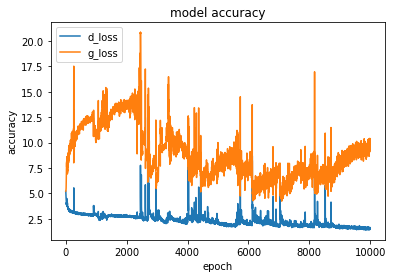

In [22]:
def plot_history(history):
    # summarize history for accuracy
    plt.plot(history)
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['d_loss', 'g_loss'], loc='upper left')
    plt.show()
plot_history([*history2,*history])

In [245]:
acgan.train(x_train, y_train,epochs=100000, sample_interval=100) #batch_size=64,

/home/miguel/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 1.149977, acc.: 71.09%, op_acc: 76.56%] [G loss: 1.690087]
1 [D loss: 1.071929, acc.: 75.00%, op_acc: 78.52%] [G loss: 1.605232]
2 [D loss: 1.082121, acc.: 75.00%, op_acc: 78.52%] [G loss: 1.893734]
3 [D loss: 1.025662, acc.: 73.05%, op_acc: 80.47%] [G loss: 1.561848]
4 [D loss: 1.033265, acc.: 74.61%, op_acc: 78.52%] [G loss: 1.560173]
5 [D loss: 1.060423, acc.: 74.22%, op_acc: 79.69%] [G loss: 1.612359]
6 [D loss: 0.967372, acc.: 75.00%, op_acc: 82.42%] [G loss: 1.584332]
7 [D loss: 1.134851, acc.: 70.31%, op_acc: 75.00%] [G loss: 1.644083]
8 [D loss: 0.886339, acc.: 76.56%, op_acc: 87.11%] [G loss: 1.609665]
9 [D loss: 1.055315, acc.: 69.92%, op_acc: 79.69%] [G loss: 1.636029]
10 [D loss: 1.125088, acc.: 68.75%, op_acc: 77.34%] [G loss: 1.657103]
11 [D loss: 1.056226, acc.: 76.17%, op_acc: 80.86%] [G loss: 1.663995]
12 [D loss: 1.131634, acc.: 75.00%, op_acc: 74.61%] [G loss: 1.712283]
13 [D loss: 1.153925, acc.: 68.36%, op_acc: 77.34%] [G loss: 1.592466]
14 [D loss: 1.05

116 [D loss: 1.023979, acc.: 74.22%, op_acc: 81.64%] [G loss: 1.573731]
117 [D loss: 1.136811, acc.: 70.31%, op_acc: 76.17%] [G loss: 1.778878]
118 [D loss: 1.168787, acc.: 64.84%, op_acc: 81.64%] [G loss: 1.648051]
119 [D loss: 1.158754, acc.: 71.88%, op_acc: 78.91%] [G loss: 1.967749]
120 [D loss: 1.130619, acc.: 71.09%, op_acc: 79.30%] [G loss: 1.723035]
121 [D loss: 1.152401, acc.: 75.78%, op_acc: 79.30%] [G loss: 1.772062]
122 [D loss: 1.103750, acc.: 69.92%, op_acc: 79.30%] [G loss: 1.602175]
123 [D loss: 1.089459, acc.: 71.48%, op_acc: 77.73%] [G loss: 1.681281]
124 [D loss: 1.060582, acc.: 75.78%, op_acc: 82.81%] [G loss: 1.798472]
125 [D loss: 1.075977, acc.: 73.83%, op_acc: 79.30%] [G loss: 1.722648]
126 [D loss: 1.103089, acc.: 67.19%, op_acc: 80.08%] [G loss: 1.416956]
127 [D loss: 1.030796, acc.: 73.44%, op_acc: 82.03%] [G loss: 1.583955]
128 [D loss: 0.999097, acc.: 74.61%, op_acc: 82.42%] [G loss: 1.536913]
129 [D loss: 1.154304, acc.: 71.48%, op_acc: 76.56%] [G loss: 1.

230 [D loss: 1.011462, acc.: 71.88%, op_acc: 82.42%] [G loss: 1.610165]
231 [D loss: 1.114805, acc.: 71.88%, op_acc: 78.52%] [G loss: 1.712931]
232 [D loss: 0.940522, acc.: 73.05%, op_acc: 85.94%] [G loss: 1.536632]
233 [D loss: 1.127903, acc.: 68.75%, op_acc: 76.56%] [G loss: 1.497181]
234 [D loss: 1.129193, acc.: 71.09%, op_acc: 76.95%] [G loss: 1.580888]
235 [D loss: 1.024898, acc.: 75.00%, op_acc: 81.25%] [G loss: 1.567892]
236 [D loss: 1.003814, acc.: 76.56%, op_acc: 81.64%] [G loss: 1.701151]
237 [D loss: 1.018834, acc.: 73.44%, op_acc: 78.91%] [G loss: 1.705224]
238 [D loss: 1.080795, acc.: 66.02%, op_acc: 78.12%] [G loss: 1.581816]
239 [D loss: 1.154809, acc.: 69.53%, op_acc: 77.73%] [G loss: 1.616890]
240 [D loss: 1.072895, acc.: 72.66%, op_acc: 81.25%] [G loss: 1.745157]
241 [D loss: 0.958004, acc.: 75.78%, op_acc: 85.16%] [G loss: 1.724393]
242 [D loss: 1.082694, acc.: 75.39%, op_acc: 79.69%] [G loss: 1.950957]
243 [D loss: 1.089989, acc.: 69.53%, op_acc: 80.86%] [G loss: 1.

344 [D loss: 1.082176, acc.: 73.83%, op_acc: 79.30%] [G loss: 1.665761]
345 [D loss: 1.041163, acc.: 74.61%, op_acc: 83.59%] [G loss: 1.683818]
346 [D loss: 1.162754, acc.: 71.48%, op_acc: 76.17%] [G loss: 1.784123]
347 [D loss: 0.984945, acc.: 74.61%, op_acc: 82.03%] [G loss: 1.596952]
348 [D loss: 1.068012, acc.: 71.48%, op_acc: 80.86%] [G loss: 1.815979]
349 [D loss: 1.074363, acc.: 69.53%, op_acc: 82.42%] [G loss: 1.686740]
350 [D loss: 1.200762, acc.: 72.27%, op_acc: 78.12%] [G loss: 1.647276]
351 [D loss: 1.039551, acc.: 70.31%, op_acc: 79.30%] [G loss: 1.671111]
352 [D loss: 0.955932, acc.: 75.39%, op_acc: 85.55%] [G loss: 1.617718]
353 [D loss: 1.007638, acc.: 69.92%, op_acc: 83.59%] [G loss: 1.604923]
354 [D loss: 1.055830, acc.: 75.78%, op_acc: 81.25%] [G loss: 1.705327]
355 [D loss: 1.017563, acc.: 68.75%, op_acc: 82.81%] [G loss: 1.535774]
356 [D loss: 1.034089, acc.: 73.83%, op_acc: 79.30%] [G loss: 1.673502]
357 [D loss: 0.993362, acc.: 69.92%, op_acc: 81.64%] [G loss: 1.

458 [D loss: 1.234148, acc.: 64.45%, op_acc: 77.34%] [G loss: 1.640370]
459 [D loss: 1.118709, acc.: 75.00%, op_acc: 79.30%] [G loss: 1.775447]
460 [D loss: 1.041481, acc.: 74.61%, op_acc: 83.20%] [G loss: 1.707460]
461 [D loss: 1.126055, acc.: 70.70%, op_acc: 78.91%] [G loss: 1.473539]
462 [D loss: 1.002803, acc.: 75.00%, op_acc: 80.47%] [G loss: 1.736446]
463 [D loss: 1.101014, acc.: 73.05%, op_acc: 78.52%] [G loss: 1.579009]
464 [D loss: 1.085149, acc.: 69.53%, op_acc: 81.25%] [G loss: 1.429927]
465 [D loss: 1.121387, acc.: 66.02%, op_acc: 81.25%] [G loss: 1.561960]
466 [D loss: 1.034899, acc.: 78.52%, op_acc: 79.69%] [G loss: 1.777816]
467 [D loss: 1.175795, acc.: 71.88%, op_acc: 78.12%] [G loss: 1.770062]
468 [D loss: 1.068107, acc.: 70.70%, op_acc: 81.64%] [G loss: 1.746836]
469 [D loss: 1.172054, acc.: 71.09%, op_acc: 75.39%] [G loss: 1.762344]
470 [D loss: 1.059288, acc.: 72.66%, op_acc: 80.86%] [G loss: 1.551040]
471 [D loss: 1.134566, acc.: 69.53%, op_acc: 76.95%] [G loss: 1.

572 [D loss: 1.058913, acc.: 76.56%, op_acc: 79.30%] [G loss: 1.741215]
573 [D loss: 1.155854, acc.: 69.14%, op_acc: 77.73%] [G loss: 1.555425]
574 [D loss: 0.998739, acc.: 76.17%, op_acc: 82.81%] [G loss: 1.690597]
575 [D loss: 0.982244, acc.: 73.83%, op_acc: 80.47%] [G loss: 1.638036]
576 [D loss: 1.128073, acc.: 75.00%, op_acc: 78.91%] [G loss: 1.556578]
577 [D loss: 1.209849, acc.: 74.61%, op_acc: 73.83%] [G loss: 1.809941]
578 [D loss: 1.159315, acc.: 71.88%, op_acc: 77.73%] [G loss: 1.576279]
579 [D loss: 1.123058, acc.: 70.70%, op_acc: 78.12%] [G loss: 1.615022]
580 [D loss: 1.137735, acc.: 70.70%, op_acc: 79.69%] [G loss: 1.793119]
581 [D loss: 1.225778, acc.: 68.75%, op_acc: 78.52%] [G loss: 1.771240]
582 [D loss: 1.045586, acc.: 72.66%, op_acc: 82.81%] [G loss: 1.578323]
583 [D loss: 1.164636, acc.: 73.05%, op_acc: 79.30%] [G loss: 1.647879]
584 [D loss: 1.154253, acc.: 64.84%, op_acc: 75.39%] [G loss: 1.640595]
585 [D loss: 1.045858, acc.: 75.39%, op_acc: 80.08%] [G loss: 1.

686 [D loss: 1.049942, acc.: 71.48%, op_acc: 82.03%] [G loss: 1.633745]
687 [D loss: 1.092966, acc.: 69.14%, op_acc: 81.64%] [G loss: 1.586714]
688 [D loss: 1.125028, acc.: 71.09%, op_acc: 75.39%] [G loss: 1.671450]
689 [D loss: 1.143278, acc.: 69.14%, op_acc: 77.73%] [G loss: 1.518038]
690 [D loss: 1.071873, acc.: 75.39%, op_acc: 80.08%] [G loss: 1.537051]
691 [D loss: 1.145820, acc.: 70.31%, op_acc: 79.69%] [G loss: 1.572022]
692 [D loss: 1.081260, acc.: 71.09%, op_acc: 79.69%] [G loss: 1.523759]
693 [D loss: 1.138591, acc.: 69.14%, op_acc: 76.56%] [G loss: 1.776699]
694 [D loss: 1.076141, acc.: 71.09%, op_acc: 80.08%] [G loss: 1.651564]
695 [D loss: 1.143079, acc.: 71.09%, op_acc: 78.91%] [G loss: 1.659773]
696 [D loss: 1.234186, acc.: 72.66%, op_acc: 78.12%] [G loss: 1.790266]
697 [D loss: 1.216552, acc.: 61.72%, op_acc: 78.12%] [G loss: 1.534320]
698 [D loss: 1.215423, acc.: 71.48%, op_acc: 75.39%] [G loss: 1.646224]
699 [D loss: 1.211208, acc.: 71.88%, op_acc: 75.78%] [G loss: 1.

800 [D loss: 1.128345, acc.: 75.00%, op_acc: 78.91%] [G loss: 1.784947]
801 [D loss: 1.175982, acc.: 68.75%, op_acc: 80.47%] [G loss: 1.754918]
802 [D loss: 1.109420, acc.: 73.05%, op_acc: 80.47%] [G loss: 1.595283]
803 [D loss: 1.123264, acc.: 73.44%, op_acc: 76.95%] [G loss: 1.697040]
804 [D loss: 1.007083, acc.: 68.75%, op_acc: 83.59%] [G loss: 1.626549]
805 [D loss: 1.128893, acc.: 74.22%, op_acc: 75.00%] [G loss: 1.618433]
806 [D loss: 1.092277, acc.: 73.83%, op_acc: 81.25%] [G loss: 1.551918]
807 [D loss: 1.031477, acc.: 70.31%, op_acc: 82.81%] [G loss: 1.602040]
808 [D loss: 1.061297, acc.: 71.09%, op_acc: 75.78%] [G loss: 1.598135]
809 [D loss: 1.120413, acc.: 71.88%, op_acc: 78.91%] [G loss: 1.577470]
810 [D loss: 1.171053, acc.: 73.83%, op_acc: 76.95%] [G loss: 1.592937]
811 [D loss: 1.055671, acc.: 73.44%, op_acc: 76.56%] [G loss: 1.581488]
812 [D loss: 1.026367, acc.: 75.39%, op_acc: 80.47%] [G loss: 1.588893]
813 [D loss: 1.138034, acc.: 72.66%, op_acc: 76.56%] [G loss: 1.

914 [D loss: 1.239659, acc.: 63.67%, op_acc: 77.34%] [G loss: 1.681036]
915 [D loss: 1.130229, acc.: 73.83%, op_acc: 78.12%] [G loss: 1.564835]
916 [D loss: 1.188373, acc.: 73.83%, op_acc: 75.00%] [G loss: 1.690595]
917 [D loss: 1.059680, acc.: 69.92%, op_acc: 79.69%] [G loss: 1.650806]
918 [D loss: 1.109949, acc.: 64.45%, op_acc: 81.64%] [G loss: 1.685698]
919 [D loss: 1.074419, acc.: 73.83%, op_acc: 80.08%] [G loss: 1.673942]
920 [D loss: 1.159610, acc.: 72.66%, op_acc: 74.22%] [G loss: 1.715549]
921 [D loss: 1.123645, acc.: 69.14%, op_acc: 79.69%] [G loss: 1.691620]
922 [D loss: 1.099662, acc.: 73.05%, op_acc: 76.56%] [G loss: 1.604037]
923 [D loss: 1.053367, acc.: 72.27%, op_acc: 79.30%] [G loss: 1.760504]
924 [D loss: 1.101785, acc.: 71.48%, op_acc: 77.34%] [G loss: 1.654289]
925 [D loss: 1.040540, acc.: 75.78%, op_acc: 78.12%] [G loss: 1.665522]
926 [D loss: 1.101876, acc.: 71.88%, op_acc: 80.47%] [G loss: 1.732938]
927 [D loss: 1.221936, acc.: 69.14%, op_acc: 77.34%] [G loss: 2.

1028 [D loss: 1.179480, acc.: 71.09%, op_acc: 75.78%] [G loss: 1.686482]
1029 [D loss: 1.127308, acc.: 73.44%, op_acc: 80.47%] [G loss: 1.502427]
1030 [D loss: 1.139303, acc.: 70.70%, op_acc: 76.17%] [G loss: 1.698709]
1031 [D loss: 1.012233, acc.: 72.27%, op_acc: 83.59%] [G loss: 1.627428]
1032 [D loss: 1.088695, acc.: 63.28%, op_acc: 82.03%] [G loss: 1.505525]
1033 [D loss: 1.184831, acc.: 74.22%, op_acc: 75.39%] [G loss: 1.684557]
1034 [D loss: 1.133000, acc.: 64.84%, op_acc: 80.86%] [G loss: 1.424472]
1035 [D loss: 1.006368, acc.: 74.22%, op_acc: 85.55%] [G loss: 1.441548]
1036 [D loss: 1.173027, acc.: 70.31%, op_acc: 77.73%] [G loss: 1.740405]
1037 [D loss: 1.054086, acc.: 72.27%, op_acc: 81.64%] [G loss: 1.668411]
1038 [D loss: 1.172264, acc.: 72.27%, op_acc: 73.83%] [G loss: 1.740426]
1039 [D loss: 0.941217, acc.: 74.61%, op_acc: 84.38%] [G loss: 1.618381]
1040 [D loss: 1.180568, acc.: 71.48%, op_acc: 73.05%] [G loss: 1.880116]
1041 [D loss: 1.083752, acc.: 74.61%, op_acc: 77.73

1141 [D loss: 1.108532, acc.: 70.31%, op_acc: 80.08%] [G loss: 1.565927]
1142 [D loss: 1.028322, acc.: 67.97%, op_acc: 81.25%] [G loss: 1.545547]
1143 [D loss: 1.082023, acc.: 73.83%, op_acc: 82.03%] [G loss: 1.587905]
1144 [D loss: 0.993107, acc.: 79.30%, op_acc: 81.64%] [G loss: 1.791453]
1145 [D loss: 1.086647, acc.: 75.39%, op_acc: 81.64%] [G loss: 1.851398]
1146 [D loss: 1.093964, acc.: 68.75%, op_acc: 78.91%] [G loss: 1.546160]
1147 [D loss: 1.095317, acc.: 70.31%, op_acc: 77.34%] [G loss: 1.751594]
1148 [D loss: 1.143379, acc.: 71.09%, op_acc: 78.52%] [G loss: 1.511004]
1149 [D loss: 1.154672, acc.: 69.53%, op_acc: 76.56%] [G loss: 1.646334]
1150 [D loss: 0.987760, acc.: 70.70%, op_acc: 85.16%] [G loss: 1.537578]
1151 [D loss: 1.139336, acc.: 74.22%, op_acc: 80.08%] [G loss: 1.675345]
1152 [D loss: 1.118743, acc.: 70.70%, op_acc: 80.86%] [G loss: 1.757555]
1153 [D loss: 1.100854, acc.: 71.88%, op_acc: 78.12%] [G loss: 1.640672]
1154 [D loss: 1.049221, acc.: 66.80%, op_acc: 83.98

1254 [D loss: 1.153511, acc.: 66.41%, op_acc: 78.52%] [G loss: 1.626435]
1255 [D loss: 1.070168, acc.: 75.39%, op_acc: 79.30%] [G loss: 1.860719]
1256 [D loss: 0.999668, acc.: 75.78%, op_acc: 83.20%] [G loss: 1.593987]
1257 [D loss: 1.324615, acc.: 62.11%, op_acc: 76.56%] [G loss: 1.641202]
1258 [D loss: 1.099238, acc.: 68.36%, op_acc: 78.12%] [G loss: 1.635122]
1259 [D loss: 1.130333, acc.: 69.92%, op_acc: 79.30%] [G loss: 1.667611]
1260 [D loss: 1.093687, acc.: 66.80%, op_acc: 80.86%] [G loss: 1.705509]
1261 [D loss: 1.138353, acc.: 67.19%, op_acc: 78.52%] [G loss: 1.512403]
1262 [D loss: 1.125220, acc.: 65.62%, op_acc: 80.08%] [G loss: 1.561356]
1263 [D loss: 1.174658, acc.: 67.58%, op_acc: 77.73%] [G loss: 1.794745]
1264 [D loss: 0.918991, acc.: 73.83%, op_acc: 85.94%] [G loss: 1.497125]
1265 [D loss: 1.102061, acc.: 72.66%, op_acc: 78.52%] [G loss: 1.631549]
1266 [D loss: 1.120290, acc.: 72.27%, op_acc: 80.47%] [G loss: 1.645729]
1267 [D loss: 1.098727, acc.: 66.41%, op_acc: 81.25

1367 [D loss: 1.022756, acc.: 71.09%, op_acc: 82.03%] [G loss: 1.591481]
1368 [D loss: 1.127558, acc.: 72.66%, op_acc: 77.73%] [G loss: 1.655819]
1369 [D loss: 1.059065, acc.: 76.17%, op_acc: 81.64%] [G loss: 1.693122]
1370 [D loss: 1.121032, acc.: 67.58%, op_acc: 75.00%] [G loss: 1.696502]
1371 [D loss: 1.199938, acc.: 66.80%, op_acc: 77.34%] [G loss: 1.779851]
1372 [D loss: 1.233097, acc.: 66.02%, op_acc: 80.47%] [G loss: 1.655314]
1373 [D loss: 1.183304, acc.: 74.22%, op_acc: 77.73%] [G loss: 1.787911]
1374 [D loss: 1.136505, acc.: 75.39%, op_acc: 76.17%] [G loss: 1.680409]
1375 [D loss: 1.049916, acc.: 73.83%, op_acc: 82.42%] [G loss: 1.621319]
1376 [D loss: 1.221749, acc.: 66.80%, op_acc: 77.34%] [G loss: 1.662828]
1377 [D loss: 1.108381, acc.: 69.92%, op_acc: 78.91%] [G loss: 1.823260]
1378 [D loss: 1.147700, acc.: 69.53%, op_acc: 76.95%] [G loss: 1.726699]
1379 [D loss: 1.150756, acc.: 68.36%, op_acc: 77.34%] [G loss: 1.644942]
1380 [D loss: 1.017330, acc.: 73.05%, op_acc: 83.20

1480 [D loss: 1.115409, acc.: 73.83%, op_acc: 78.52%] [G loss: 1.754539]
1481 [D loss: 1.187440, acc.: 69.53%, op_acc: 78.12%] [G loss: 1.699749]
1482 [D loss: 1.218570, acc.: 70.31%, op_acc: 78.52%] [G loss: 1.566895]
1483 [D loss: 1.094819, acc.: 72.66%, op_acc: 80.47%] [G loss: 1.667127]
1484 [D loss: 1.109041, acc.: 74.22%, op_acc: 78.12%] [G loss: 1.652237]
1485 [D loss: 1.180204, acc.: 71.09%, op_acc: 76.17%] [G loss: 1.793865]
1486 [D loss: 1.118269, acc.: 73.83%, op_acc: 75.00%] [G loss: 1.678344]
1487 [D loss: 1.041823, acc.: 73.44%, op_acc: 82.81%] [G loss: 1.737060]
1488 [D loss: 1.219777, acc.: 69.14%, op_acc: 75.00%] [G loss: 1.678167]
1489 [D loss: 1.176715, acc.: 73.44%, op_acc: 74.61%] [G loss: 1.677039]
1490 [D loss: 0.991383, acc.: 69.53%, op_acc: 83.20%] [G loss: 1.635475]
1491 [D loss: 1.054487, acc.: 75.00%, op_acc: 80.47%] [G loss: 1.646336]
1492 [D loss: 1.049515, acc.: 75.39%, op_acc: 79.30%] [G loss: 1.875451]
1493 [D loss: 1.139807, acc.: 71.09%, op_acc: 76.95

1593 [D loss: 1.079806, acc.: 75.00%, op_acc: 79.69%] [G loss: 1.586468]
1594 [D loss: 1.124987, acc.: 73.44%, op_acc: 78.12%] [G loss: 1.740022]
1595 [D loss: 0.997156, acc.: 73.44%, op_acc: 82.03%] [G loss: 1.593932]
1596 [D loss: 1.048134, acc.: 66.80%, op_acc: 83.98%] [G loss: 1.561693]
1597 [D loss: 0.990700, acc.: 72.27%, op_acc: 83.98%] [G loss: 1.567108]
1598 [D loss: 0.996507, acc.: 80.47%, op_acc: 79.30%] [G loss: 1.648033]
1599 [D loss: 1.151845, acc.: 72.27%, op_acc: 75.39%] [G loss: 1.678561]
1600 [D loss: 1.162547, acc.: 72.66%, op_acc: 73.44%] [G loss: 1.763403]
1601 [D loss: 1.035067, acc.: 70.31%, op_acc: 81.25%] [G loss: 1.616287]
1602 [D loss: 1.095769, acc.: 70.70%, op_acc: 75.00%] [G loss: 1.816793]
1603 [D loss: 0.983781, acc.: 71.48%, op_acc: 84.38%] [G loss: 1.586121]
1604 [D loss: 1.158789, acc.: 69.14%, op_acc: 78.91%] [G loss: 1.550824]
1605 [D loss: 0.968080, acc.: 72.27%, op_acc: 82.81%] [G loss: 1.569438]
1606 [D loss: 0.988809, acc.: 73.05%, op_acc: 82.42

1706 [D loss: 1.162426, acc.: 70.31%, op_acc: 77.34%] [G loss: 1.880238]
1707 [D loss: 1.138870, acc.: 65.23%, op_acc: 80.08%] [G loss: 1.546444]
1708 [D loss: 1.150236, acc.: 69.53%, op_acc: 80.47%] [G loss: 1.517083]
1709 [D loss: 1.092347, acc.: 69.92%, op_acc: 82.03%] [G loss: 1.690094]
1710 [D loss: 1.035230, acc.: 74.61%, op_acc: 80.47%] [G loss: 1.602925]
1711 [D loss: 1.085639, acc.: 70.70%, op_acc: 82.42%] [G loss: 1.544391]
1712 [D loss: 1.081766, acc.: 73.44%, op_acc: 79.30%] [G loss: 1.649271]
1713 [D loss: 1.106629, acc.: 71.48%, op_acc: 80.08%] [G loss: 1.465006]
1714 [D loss: 0.952134, acc.: 74.22%, op_acc: 82.03%] [G loss: 1.550398]
1715 [D loss: 0.951563, acc.: 77.34%, op_acc: 80.86%] [G loss: 1.656019]
1716 [D loss: 1.069761, acc.: 74.61%, op_acc: 81.64%] [G loss: 1.815130]
1717 [D loss: 1.018594, acc.: 76.17%, op_acc: 77.34%] [G loss: 1.609438]
1718 [D loss: 1.054123, acc.: 70.70%, op_acc: 80.47%] [G loss: 1.536681]
1719 [D loss: 1.073324, acc.: 75.78%, op_acc: 79.69

1819 [D loss: 1.092829, acc.: 76.17%, op_acc: 76.56%] [G loss: 1.621296]
1820 [D loss: 1.025894, acc.: 71.48%, op_acc: 80.08%] [G loss: 1.725930]
1821 [D loss: 1.146098, acc.: 68.75%, op_acc: 78.91%] [G loss: 1.900113]
1822 [D loss: 1.163513, acc.: 67.58%, op_acc: 78.91%] [G loss: 1.538668]
1823 [D loss: 1.241210, acc.: 73.44%, op_acc: 74.61%] [G loss: 1.851147]
1824 [D loss: 1.106254, acc.: 69.53%, op_acc: 80.08%] [G loss: 1.711301]
1825 [D loss: 1.116855, acc.: 75.39%, op_acc: 78.52%] [G loss: 1.622727]
1826 [D loss: 1.165601, acc.: 71.48%, op_acc: 77.34%] [G loss: 1.582174]
1827 [D loss: 1.003411, acc.: 70.31%, op_acc: 82.42%] [G loss: 1.548840]
1828 [D loss: 1.083082, acc.: 77.73%, op_acc: 78.52%] [G loss: 1.594044]
1829 [D loss: 1.181868, acc.: 67.19%, op_acc: 75.39%] [G loss: 1.512984]
1830 [D loss: 1.199007, acc.: 70.31%, op_acc: 72.66%] [G loss: 1.685668]
1831 [D loss: 1.073585, acc.: 71.48%, op_acc: 78.12%] [G loss: 1.667250]
1832 [D loss: 1.022560, acc.: 73.83%, op_acc: 82.03

1932 [D loss: 1.044684, acc.: 73.44%, op_acc: 83.20%] [G loss: 1.801072]
1933 [D loss: 1.151821, acc.: 69.53%, op_acc: 76.56%] [G loss: 1.454201]
1934 [D loss: 0.977060, acc.: 71.09%, op_acc: 83.20%] [G loss: 1.641018]
1935 [D loss: 1.051663, acc.: 74.61%, op_acc: 80.47%] [G loss: 1.841750]
1936 [D loss: 1.052887, acc.: 74.61%, op_acc: 80.86%] [G loss: 1.829765]
1937 [D loss: 1.089573, acc.: 75.00%, op_acc: 76.56%] [G loss: 1.791672]
1938 [D loss: 0.981419, acc.: 72.66%, op_acc: 84.77%] [G loss: 1.640184]
1939 [D loss: 1.182294, acc.: 67.97%, op_acc: 80.47%] [G loss: 1.632206]
1940 [D loss: 1.193656, acc.: 73.05%, op_acc: 76.56%] [G loss: 1.829405]
1941 [D loss: 1.165047, acc.: 71.48%, op_acc: 80.08%] [G loss: 1.583003]
1942 [D loss: 1.101128, acc.: 75.78%, op_acc: 76.95%] [G loss: 1.867201]
1943 [D loss: 1.115760, acc.: 72.27%, op_acc: 81.64%] [G loss: 1.831116]
1944 [D loss: 1.216461, acc.: 68.75%, op_acc: 76.56%] [G loss: 1.478058]
1945 [D loss: 1.107200, acc.: 72.66%, op_acc: 77.73

2045 [D loss: 1.098414, acc.: 73.44%, op_acc: 78.12%] [G loss: 1.664186]
2046 [D loss: 1.047458, acc.: 73.83%, op_acc: 82.03%] [G loss: 1.559489]
2047 [D loss: 1.044729, acc.: 74.22%, op_acc: 82.03%] [G loss: 1.700165]
2048 [D loss: 1.079289, acc.: 72.27%, op_acc: 77.73%] [G loss: 1.735264]
2049 [D loss: 1.130319, acc.: 67.58%, op_acc: 80.86%] [G loss: 1.511225]
2050 [D loss: 1.119992, acc.: 68.75%, op_acc: 79.30%] [G loss: 1.513811]
2051 [D loss: 1.142612, acc.: 68.75%, op_acc: 75.39%] [G loss: 1.659506]
2052 [D loss: 1.025414, acc.: 71.09%, op_acc: 80.47%] [G loss: 1.704532]
2053 [D loss: 1.074340, acc.: 80.08%, op_acc: 77.34%] [G loss: 1.933089]
2054 [D loss: 1.034139, acc.: 74.22%, op_acc: 81.64%] [G loss: 1.673082]
2055 [D loss: 1.052390, acc.: 70.31%, op_acc: 81.25%] [G loss: 1.531121]
2056 [D loss: 1.080795, acc.: 71.88%, op_acc: 80.08%] [G loss: 1.579676]
2057 [D loss: 1.056817, acc.: 71.48%, op_acc: 81.25%] [G loss: 1.508252]
2058 [D loss: 1.050545, acc.: 76.56%, op_acc: 79.30

2158 [D loss: 1.081460, acc.: 73.05%, op_acc: 78.52%] [G loss: 1.757226]
2159 [D loss: 1.075249, acc.: 71.48%, op_acc: 78.52%] [G loss: 1.659813]
2160 [D loss: 1.095785, acc.: 71.09%, op_acc: 78.52%] [G loss: 1.636626]
2161 [D loss: 1.097343, acc.: 73.05%, op_acc: 80.08%] [G loss: 1.624418]
2162 [D loss: 1.162731, acc.: 69.53%, op_acc: 77.34%] [G loss: 1.747722]
2163 [D loss: 0.993146, acc.: 69.14%, op_acc: 82.03%] [G loss: 1.497567]
2164 [D loss: 1.005417, acc.: 73.44%, op_acc: 82.42%] [G loss: 1.680531]
2165 [D loss: 1.080088, acc.: 72.66%, op_acc: 78.12%] [G loss: 1.651290]
2166 [D loss: 1.104455, acc.: 67.19%, op_acc: 80.86%] [G loss: 1.689135]
2167 [D loss: 1.124585, acc.: 68.36%, op_acc: 78.52%] [G loss: 1.651829]
2168 [D loss: 1.198384, acc.: 67.97%, op_acc: 79.30%] [G loss: 1.664875]
2169 [D loss: 0.992391, acc.: 75.00%, op_acc: 80.08%] [G loss: 1.548155]
2170 [D loss: 1.047791, acc.: 73.05%, op_acc: 79.30%] [G loss: 1.899353]
2171 [D loss: 1.118624, acc.: 70.31%, op_acc: 76.56

2271 [D loss: 1.079078, acc.: 72.27%, op_acc: 79.30%] [G loss: 1.676360]
2272 [D loss: 1.089626, acc.: 66.41%, op_acc: 80.47%] [G loss: 1.740018]
2273 [D loss: 1.092070, acc.: 68.75%, op_acc: 80.86%] [G loss: 1.615254]
2274 [D loss: 1.131369, acc.: 73.83%, op_acc: 74.61%] [G loss: 1.685593]
2275 [D loss: 1.048069, acc.: 72.66%, op_acc: 74.61%] [G loss: 1.531107]
2276 [D loss: 1.005463, acc.: 75.00%, op_acc: 80.86%] [G loss: 1.672412]
2277 [D loss: 1.153630, acc.: 69.92%, op_acc: 78.91%] [G loss: 1.718732]
2278 [D loss: 1.138666, acc.: 70.70%, op_acc: 78.52%] [G loss: 1.711523]
2279 [D loss: 1.114794, acc.: 72.66%, op_acc: 79.30%] [G loss: 1.701246]
2280 [D loss: 1.030349, acc.: 71.48%, op_acc: 82.42%] [G loss: 1.676277]
2281 [D loss: 0.997572, acc.: 73.05%, op_acc: 82.03%] [G loss: 1.696183]
2282 [D loss: 1.135524, acc.: 70.31%, op_acc: 77.34%] [G loss: 1.607882]
2283 [D loss: 1.077814, acc.: 71.09%, op_acc: 82.03%] [G loss: 1.703428]
2284 [D loss: 1.157649, acc.: 69.53%, op_acc: 77.73

2384 [D loss: 1.112476, acc.: 70.70%, op_acc: 80.86%] [G loss: 1.550763]
2385 [D loss: 1.063365, acc.: 73.05%, op_acc: 80.47%] [G loss: 1.905554]
2386 [D loss: 1.039824, acc.: 78.91%, op_acc: 82.81%] [G loss: 1.889633]
2387 [D loss: 1.125903, acc.: 70.31%, op_acc: 76.17%] [G loss: 1.719977]
2388 [D loss: 1.124053, acc.: 71.88%, op_acc: 79.69%] [G loss: 1.968203]
2389 [D loss: 1.026697, acc.: 73.83%, op_acc: 82.42%] [G loss: 1.680618]
2390 [D loss: 1.006738, acc.: 68.75%, op_acc: 82.03%] [G loss: 1.635641]
2391 [D loss: 1.061415, acc.: 77.34%, op_acc: 80.47%] [G loss: 1.687190]
2392 [D loss: 0.955393, acc.: 75.00%, op_acc: 83.59%] [G loss: 1.703035]
2393 [D loss: 1.037104, acc.: 70.70%, op_acc: 80.86%] [G loss: 1.646854]
2394 [D loss: 1.096308, acc.: 65.62%, op_acc: 82.03%] [G loss: 1.495299]
2395 [D loss: 1.152131, acc.: 70.31%, op_acc: 78.52%] [G loss: 1.800756]
2396 [D loss: 1.105810, acc.: 75.78%, op_acc: 76.17%] [G loss: 1.893928]
2397 [D loss: 1.079595, acc.: 73.05%, op_acc: 80.47

2497 [D loss: 1.104941, acc.: 68.36%, op_acc: 78.52%] [G loss: 1.573029]
2498 [D loss: 1.043242, acc.: 71.09%, op_acc: 82.03%] [G loss: 1.668823]
2499 [D loss: 1.058391, acc.: 76.17%, op_acc: 79.69%] [G loss: 1.730742]
2500 [D loss: 1.037065, acc.: 71.09%, op_acc: 83.59%] [G loss: 1.545440]
2501 [D loss: 1.078666, acc.: 66.80%, op_acc: 79.69%] [G loss: 1.766999]
2502 [D loss: 1.018642, acc.: 73.44%, op_acc: 81.25%] [G loss: 1.706344]
2503 [D loss: 1.107371, acc.: 72.66%, op_acc: 80.47%] [G loss: 1.593946]
2504 [D loss: 1.030468, acc.: 72.27%, op_acc: 82.81%] [G loss: 1.484061]
2505 [D loss: 1.064393, acc.: 74.22%, op_acc: 76.95%] [G loss: 1.628781]
2506 [D loss: 1.061913, acc.: 75.78%, op_acc: 78.91%] [G loss: 1.708617]
2507 [D loss: 1.098460, acc.: 69.92%, op_acc: 77.73%] [G loss: 1.504016]
2508 [D loss: 1.124005, acc.: 70.31%, op_acc: 78.91%] [G loss: 1.727192]
2509 [D loss: 1.007281, acc.: 72.66%, op_acc: 84.38%] [G loss: 1.775911]
2510 [D loss: 1.175383, acc.: 68.36%, op_acc: 76.17

2610 [D loss: 0.960298, acc.: 69.14%, op_acc: 85.55%] [G loss: 1.596057]
2611 [D loss: 0.995379, acc.: 72.27%, op_acc: 80.86%] [G loss: 1.774756]
2612 [D loss: 1.124018, acc.: 73.83%, op_acc: 79.30%] [G loss: 1.693958]
2613 [D loss: 1.188397, acc.: 64.45%, op_acc: 79.30%] [G loss: 1.483826]
2614 [D loss: 1.121427, acc.: 68.36%, op_acc: 79.69%] [G loss: 1.622844]
2615 [D loss: 1.009264, acc.: 67.58%, op_acc: 82.42%] [G loss: 1.460874]
2616 [D loss: 1.059803, acc.: 73.05%, op_acc: 81.25%] [G loss: 1.775344]
2617 [D loss: 1.144073, acc.: 69.92%, op_acc: 77.34%] [G loss: 1.606494]
2618 [D loss: 1.015727, acc.: 73.05%, op_acc: 80.86%] [G loss: 1.538201]
2619 [D loss: 1.050119, acc.: 76.95%, op_acc: 80.47%] [G loss: 1.692901]
2620 [D loss: 1.186262, acc.: 67.58%, op_acc: 75.78%] [G loss: 1.607939]
2621 [D loss: 1.087722, acc.: 69.92%, op_acc: 79.30%] [G loss: 1.659432]
2622 [D loss: 1.106317, acc.: 68.75%, op_acc: 79.69%] [G loss: 1.624912]
2623 [D loss: 1.146579, acc.: 67.97%, op_acc: 77.73

2723 [D loss: 0.984041, acc.: 71.88%, op_acc: 82.81%] [G loss: 1.681700]
2724 [D loss: 1.017468, acc.: 74.22%, op_acc: 83.98%] [G loss: 1.598856]
2725 [D loss: 1.079866, acc.: 73.44%, op_acc: 80.08%] [G loss: 1.623773]
2726 [D loss: 1.075309, acc.: 69.92%, op_acc: 80.08%] [G loss: 1.563693]
2727 [D loss: 1.085695, acc.: 81.25%, op_acc: 79.69%] [G loss: 2.089908]
2728 [D loss: 1.050973, acc.: 71.88%, op_acc: 78.91%] [G loss: 1.603929]
2729 [D loss: 1.052880, acc.: 72.27%, op_acc: 78.52%] [G loss: 1.700759]
2730 [D loss: 1.059767, acc.: 76.17%, op_acc: 81.64%] [G loss: 1.806657]
2731 [D loss: 1.096642, acc.: 73.05%, op_acc: 77.73%] [G loss: 1.733773]
2732 [D loss: 1.223746, acc.: 69.92%, op_acc: 77.34%] [G loss: 1.715866]
2733 [D loss: 1.312838, acc.: 63.28%, op_acc: 72.66%] [G loss: 1.763572]
2734 [D loss: 0.988509, acc.: 78.91%, op_acc: 81.64%] [G loss: 1.655048]
2735 [D loss: 1.045071, acc.: 70.31%, op_acc: 82.81%] [G loss: 1.832053]
2736 [D loss: 1.170736, acc.: 66.80%, op_acc: 79.69

2836 [D loss: 1.062404, acc.: 67.58%, op_acc: 82.03%] [G loss: 1.630768]
2837 [D loss: 1.179231, acc.: 69.14%, op_acc: 75.78%] [G loss: 1.770990]
2838 [D loss: 1.241742, acc.: 71.09%, op_acc: 76.56%] [G loss: 1.784957]
2839 [D loss: 1.087783, acc.: 70.70%, op_acc: 78.52%] [G loss: 1.752851]
2840 [D loss: 1.178495, acc.: 74.22%, op_acc: 76.56%] [G loss: 1.820545]
2841 [D loss: 1.066725, acc.: 70.70%, op_acc: 81.25%] [G loss: 1.547517]
2842 [D loss: 1.045300, acc.: 75.39%, op_acc: 82.42%] [G loss: 1.491658]
2843 [D loss: 1.066776, acc.: 73.05%, op_acc: 78.91%] [G loss: 1.612646]
2844 [D loss: 1.105475, acc.: 69.53%, op_acc: 78.12%] [G loss: 1.571510]
2845 [D loss: 1.040580, acc.: 69.14%, op_acc: 84.38%] [G loss: 1.548980]
2846 [D loss: 1.159179, acc.: 69.92%, op_acc: 76.56%] [G loss: 1.646754]
2847 [D loss: 0.943783, acc.: 72.66%, op_acc: 86.33%] [G loss: 1.555385]
2848 [D loss: 1.128172, acc.: 71.88%, op_acc: 80.08%] [G loss: 1.527689]
2849 [D loss: 1.078344, acc.: 67.58%, op_acc: 80.08

2949 [D loss: 1.030680, acc.: 73.44%, op_acc: 84.38%] [G loss: 1.683406]
2950 [D loss: 1.145663, acc.: 69.14%, op_acc: 78.52%] [G loss: 1.736221]
2951 [D loss: 1.021301, acc.: 73.05%, op_acc: 83.20%] [G loss: 1.660556]
2952 [D loss: 1.115718, acc.: 67.97%, op_acc: 76.56%] [G loss: 1.516897]
2953 [D loss: 1.123162, acc.: 73.83%, op_acc: 77.34%] [G loss: 1.894378]
2954 [D loss: 1.080888, acc.: 76.56%, op_acc: 81.64%] [G loss: 1.901512]
2955 [D loss: 1.180733, acc.: 70.31%, op_acc: 74.22%] [G loss: 1.640318]
2956 [D loss: 1.061925, acc.: 72.66%, op_acc: 82.03%] [G loss: 1.520417]
2957 [D loss: 1.176625, acc.: 76.17%, op_acc: 76.56%] [G loss: 1.712875]
2958 [D loss: 1.052570, acc.: 70.70%, op_acc: 78.52%] [G loss: 1.636332]
2959 [D loss: 0.997783, acc.: 76.56%, op_acc: 82.81%] [G loss: 1.624130]
2960 [D loss: 1.131051, acc.: 68.75%, op_acc: 80.08%] [G loss: 1.691107]
2961 [D loss: 1.056621, acc.: 72.27%, op_acc: 82.03%] [G loss: 1.691483]
2962 [D loss: 1.024367, acc.: 73.83%, op_acc: 83.59

3062 [D loss: 1.146188, acc.: 69.14%, op_acc: 78.91%] [G loss: 1.604907]
3063 [D loss: 1.085433, acc.: 73.44%, op_acc: 78.52%] [G loss: 1.748774]
3064 [D loss: 1.121068, acc.: 71.09%, op_acc: 77.34%] [G loss: 1.748523]
3065 [D loss: 0.975066, acc.: 73.44%, op_acc: 82.42%] [G loss: 1.648411]
3066 [D loss: 1.141118, acc.: 68.75%, op_acc: 76.56%] [G loss: 1.509179]
3067 [D loss: 1.120164, acc.: 69.14%, op_acc: 78.12%] [G loss: 1.702066]
3068 [D loss: 1.050007, acc.: 71.48%, op_acc: 78.91%] [G loss: 1.492293]
3069 [D loss: 1.013380, acc.: 76.17%, op_acc: 79.69%] [G loss: 1.761903]
3070 [D loss: 1.062603, acc.: 69.14%, op_acc: 79.69%] [G loss: 1.529279]
3071 [D loss: 1.115284, acc.: 69.53%, op_acc: 77.73%] [G loss: 1.551478]
3072 [D loss: 1.139839, acc.: 71.09%, op_acc: 76.95%] [G loss: 1.492357]
3073 [D loss: 1.110873, acc.: 66.41%, op_acc: 80.47%] [G loss: 1.713407]
3074 [D loss: 0.995467, acc.: 73.83%, op_acc: 82.42%] [G loss: 1.488601]
3075 [D loss: 1.019208, acc.: 71.88%, op_acc: 83.98

3175 [D loss: 1.001427, acc.: 73.44%, op_acc: 82.03%] [G loss: 1.580322]
3176 [D loss: 1.135370, acc.: 72.27%, op_acc: 77.73%] [G loss: 1.570169]
3177 [D loss: 1.131657, acc.: 69.92%, op_acc: 79.30%] [G loss: 1.485501]
3178 [D loss: 1.229462, acc.: 72.66%, op_acc: 73.83%] [G loss: 1.816256]
3179 [D loss: 1.067970, acc.: 67.58%, op_acc: 80.47%] [G loss: 1.596615]
3180 [D loss: 1.027058, acc.: 74.22%, op_acc: 81.64%] [G loss: 1.557639]
3181 [D loss: 0.971056, acc.: 78.91%, op_acc: 82.03%] [G loss: 1.709429]
3182 [D loss: 1.099366, acc.: 70.70%, op_acc: 77.34%] [G loss: 1.619866]
3183 [D loss: 0.970328, acc.: 71.88%, op_acc: 80.86%] [G loss: 1.493360]
3184 [D loss: 1.123627, acc.: 73.05%, op_acc: 78.91%] [G loss: 1.852933]
3185 [D loss: 1.079183, acc.: 72.66%, op_acc: 80.47%] [G loss: 1.740204]
3186 [D loss: 1.073285, acc.: 73.05%, op_acc: 79.69%] [G loss: 1.650226]
3187 [D loss: 0.984498, acc.: 72.27%, op_acc: 84.38%] [G loss: 1.588713]
3188 [D loss: 1.046330, acc.: 75.00%, op_acc: 82.03

3288 [D loss: 1.170286, acc.: 69.14%, op_acc: 76.95%] [G loss: 1.749501]
3289 [D loss: 1.077980, acc.: 70.70%, op_acc: 81.64%] [G loss: 1.556153]
3290 [D loss: 1.066468, acc.: 69.92%, op_acc: 82.03%] [G loss: 1.606855]
3291 [D loss: 1.156015, acc.: 69.92%, op_acc: 78.52%] [G loss: 1.666100]
3292 [D loss: 1.151010, acc.: 68.36%, op_acc: 79.30%] [G loss: 1.797310]
3293 [D loss: 1.117103, acc.: 71.09%, op_acc: 76.56%] [G loss: 1.663002]
3294 [D loss: 1.173972, acc.: 68.36%, op_acc: 77.34%] [G loss: 1.562801]
3295 [D loss: 1.156274, acc.: 69.92%, op_acc: 77.73%] [G loss: 1.787060]
3296 [D loss: 1.059718, acc.: 70.70%, op_acc: 82.42%] [G loss: 1.515734]
3297 [D loss: 1.053240, acc.: 66.80%, op_acc: 80.47%] [G loss: 1.553200]
3298 [D loss: 0.997437, acc.: 76.17%, op_acc: 82.42%] [G loss: 1.660493]
3299 [D loss: 1.141609, acc.: 64.45%, op_acc: 78.91%] [G loss: 1.598473]
3300 [D loss: 1.040868, acc.: 71.88%, op_acc: 82.42%] [G loss: 1.599204]
3301 [D loss: 1.130982, acc.: 68.36%, op_acc: 80.08

3401 [D loss: 1.040075, acc.: 73.83%, op_acc: 78.52%] [G loss: 1.614218]
3402 [D loss: 1.002659, acc.: 74.61%, op_acc: 83.59%] [G loss: 1.558083]
3403 [D loss: 1.014581, acc.: 71.09%, op_acc: 81.64%] [G loss: 1.623601]
3404 [D loss: 1.069659, acc.: 73.83%, op_acc: 82.42%] [G loss: 1.610469]
3405 [D loss: 1.031677, acc.: 74.61%, op_acc: 81.64%] [G loss: 1.485606]
3406 [D loss: 1.199740, acc.: 72.66%, op_acc: 75.39%] [G loss: 1.672137]
3407 [D loss: 1.098579, acc.: 71.88%, op_acc: 80.08%] [G loss: 1.675204]
3408 [D loss: 1.076115, acc.: 71.48%, op_acc: 78.91%] [G loss: 1.709038]
3409 [D loss: 1.048406, acc.: 69.14%, op_acc: 80.08%] [G loss: 1.540169]
3410 [D loss: 1.108555, acc.: 73.83%, op_acc: 77.34%] [G loss: 1.689971]
3411 [D loss: 1.056977, acc.: 70.31%, op_acc: 80.47%] [G loss: 1.658507]
3412 [D loss: 1.090197, acc.: 67.58%, op_acc: 80.86%] [G loss: 1.627628]
3413 [D loss: 1.123831, acc.: 75.39%, op_acc: 75.00%] [G loss: 1.650515]
3414 [D loss: 1.131151, acc.: 68.36%, op_acc: 78.91

3514 [D loss: 1.094658, acc.: 76.56%, op_acc: 78.12%] [G loss: 1.871817]
3515 [D loss: 1.126665, acc.: 71.88%, op_acc: 78.12%] [G loss: 1.730302]
3516 [D loss: 1.068882, acc.: 69.53%, op_acc: 81.25%] [G loss: 1.653868]
3517 [D loss: 1.157440, acc.: 70.31%, op_acc: 76.95%] [G loss: 1.589190]
3518 [D loss: 1.104530, acc.: 73.83%, op_acc: 77.34%] [G loss: 1.768344]
3519 [D loss: 0.978600, acc.: 75.78%, op_acc: 81.64%] [G loss: 1.683808]
3520 [D loss: 0.991194, acc.: 67.58%, op_acc: 85.94%] [G loss: 1.636221]
3521 [D loss: 1.167286, acc.: 66.02%, op_acc: 75.78%] [G loss: 1.629095]
3522 [D loss: 1.164153, acc.: 69.53%, op_acc: 76.17%] [G loss: 1.682795]
3523 [D loss: 1.166631, acc.: 71.88%, op_acc: 76.17%] [G loss: 1.670939]
3524 [D loss: 1.004521, acc.: 75.39%, op_acc: 82.42%] [G loss: 1.528218]
3525 [D loss: 1.097800, acc.: 73.83%, op_acc: 79.30%] [G loss: 1.764612]
3526 [D loss: 1.103465, acc.: 70.70%, op_acc: 80.08%] [G loss: 1.592421]
3527 [D loss: 0.994671, acc.: 73.05%, op_acc: 82.81

3627 [D loss: 1.078767, acc.: 74.61%, op_acc: 77.73%] [G loss: 1.590863]
3628 [D loss: 1.060886, acc.: 73.05%, op_acc: 82.03%] [G loss: 1.763929]
3629 [D loss: 1.082006, acc.: 68.36%, op_acc: 81.25%] [G loss: 1.557782]
3630 [D loss: 1.038429, acc.: 70.31%, op_acc: 77.34%] [G loss: 1.644395]
3631 [D loss: 1.066817, acc.: 71.09%, op_acc: 81.25%] [G loss: 1.561570]
3632 [D loss: 1.131613, acc.: 69.53%, op_acc: 79.30%] [G loss: 1.779087]
3633 [D loss: 1.043074, acc.: 73.05%, op_acc: 79.30%] [G loss: 1.635025]
3634 [D loss: 1.028923, acc.: 71.09%, op_acc: 84.77%] [G loss: 1.538780]
3635 [D loss: 1.074900, acc.: 69.92%, op_acc: 79.30%] [G loss: 1.542772]
3636 [D loss: 1.008988, acc.: 73.44%, op_acc: 80.47%] [G loss: 1.585350]
3637 [D loss: 1.073573, acc.: 77.34%, op_acc: 78.52%] [G loss: 1.823259]
3638 [D loss: 1.024850, acc.: 73.83%, op_acc: 80.08%] [G loss: 1.710556]
3639 [D loss: 1.107070, acc.: 69.14%, op_acc: 80.47%] [G loss: 1.623668]
3640 [D loss: 1.056769, acc.: 73.05%, op_acc: 79.69

3740 [D loss: 1.074182, acc.: 69.53%, op_acc: 80.08%] [G loss: 1.631777]
3741 [D loss: 1.043098, acc.: 68.36%, op_acc: 78.12%] [G loss: 1.666404]
3742 [D loss: 0.962775, acc.: 71.09%, op_acc: 83.98%] [G loss: 1.620363]
3743 [D loss: 1.169737, acc.: 73.44%, op_acc: 80.08%] [G loss: 1.778665]
3744 [D loss: 1.154096, acc.: 66.80%, op_acc: 77.34%] [G loss: 1.544081]
3745 [D loss: 1.199757, acc.: 72.27%, op_acc: 76.95%] [G loss: 1.769107]
3746 [D loss: 1.111897, acc.: 67.97%, op_acc: 82.03%] [G loss: 1.558876]
3747 [D loss: 1.202735, acc.: 72.27%, op_acc: 75.78%] [G loss: 1.754291]
3748 [D loss: 1.052078, acc.: 74.22%, op_acc: 77.34%] [G loss: 1.618770]
3749 [D loss: 1.060947, acc.: 72.66%, op_acc: 83.59%] [G loss: 1.621830]
3750 [D loss: 1.156060, acc.: 62.89%, op_acc: 79.69%] [G loss: 1.478456]
3751 [D loss: 1.083826, acc.: 72.66%, op_acc: 80.08%] [G loss: 1.647680]
3752 [D loss: 1.073699, acc.: 69.92%, op_acc: 82.42%] [G loss: 1.847322]
3753 [D loss: 1.067621, acc.: 76.17%, op_acc: 76.56

3853 [D loss: 1.202861, acc.: 66.80%, op_acc: 77.34%] [G loss: 1.618860]
3854 [D loss: 1.129249, acc.: 75.00%, op_acc: 77.73%] [G loss: 1.907838]
3855 [D loss: 1.095438, acc.: 73.83%, op_acc: 78.91%] [G loss: 1.618830]
3856 [D loss: 0.895590, acc.: 75.00%, op_acc: 84.38%] [G loss: 1.577026]
3857 [D loss: 1.085897, acc.: 70.70%, op_acc: 80.86%] [G loss: 1.518113]
3858 [D loss: 1.092131, acc.: 67.97%, op_acc: 82.42%] [G loss: 1.791321]
3859 [D loss: 1.078313, acc.: 71.09%, op_acc: 82.42%] [G loss: 1.668392]
3860 [D loss: 1.086058, acc.: 66.02%, op_acc: 78.12%] [G loss: 1.454660]
3861 [D loss: 1.048817, acc.: 73.05%, op_acc: 79.69%] [G loss: 1.604637]
3862 [D loss: 1.125987, acc.: 71.88%, op_acc: 79.30%] [G loss: 1.599400]
3863 [D loss: 1.138824, acc.: 68.75%, op_acc: 78.91%] [G loss: 1.812552]
3864 [D loss: 1.085039, acc.: 73.05%, op_acc: 78.52%] [G loss: 1.650787]
3865 [D loss: 1.031723, acc.: 72.66%, op_acc: 79.30%] [G loss: 1.592105]
3866 [D loss: 1.041313, acc.: 75.39%, op_acc: 80.86

3966 [D loss: 1.113683, acc.: 73.44%, op_acc: 77.73%] [G loss: 1.657791]
3967 [D loss: 1.109532, acc.: 71.88%, op_acc: 79.30%] [G loss: 1.703467]
3968 [D loss: 0.968794, acc.: 73.83%, op_acc: 81.25%] [G loss: 1.640398]
3969 [D loss: 1.120456, acc.: 74.61%, op_acc: 77.34%] [G loss: 1.762126]
3970 [D loss: 1.062218, acc.: 70.70%, op_acc: 80.08%] [G loss: 1.530732]
3971 [D loss: 1.071115, acc.: 71.88%, op_acc: 79.30%] [G loss: 1.709520]
3972 [D loss: 1.150918, acc.: 73.05%, op_acc: 77.34%] [G loss: 1.698048]
3973 [D loss: 1.221699, acc.: 62.89%, op_acc: 76.95%] [G loss: 1.515277]
3974 [D loss: 1.069687, acc.: 71.48%, op_acc: 79.30%] [G loss: 1.564169]
3975 [D loss: 1.162017, acc.: 70.70%, op_acc: 78.91%] [G loss: 1.689980]
3976 [D loss: 1.133548, acc.: 67.97%, op_acc: 78.52%] [G loss: 1.688047]
3977 [D loss: 1.064841, acc.: 72.27%, op_acc: 81.64%] [G loss: 1.530448]
3978 [D loss: 1.090025, acc.: 75.00%, op_acc: 79.69%] [G loss: 1.697898]
3979 [D loss: 1.095644, acc.: 75.39%, op_acc: 78.91

4079 [D loss: 1.062505, acc.: 73.83%, op_acc: 82.42%] [G loss: 1.625713]
4080 [D loss: 1.103789, acc.: 65.62%, op_acc: 81.25%] [G loss: 1.547035]
4081 [D loss: 1.119127, acc.: 65.23%, op_acc: 78.12%] [G loss: 1.591012]
4082 [D loss: 0.971630, acc.: 74.22%, op_acc: 82.03%] [G loss: 1.628573]
4083 [D loss: 1.135347, acc.: 71.48%, op_acc: 78.91%] [G loss: 1.669364]
4084 [D loss: 1.104349, acc.: 67.97%, op_acc: 79.30%] [G loss: 1.445530]
4085 [D loss: 1.067493, acc.: 72.66%, op_acc: 81.64%] [G loss: 1.740412]
4086 [D loss: 1.196255, acc.: 73.44%, op_acc: 75.39%] [G loss: 1.652551]
4087 [D loss: 1.123938, acc.: 78.91%, op_acc: 76.17%] [G loss: 2.094264]
4088 [D loss: 1.140799, acc.: 72.66%, op_acc: 80.86%] [G loss: 1.680512]
4089 [D loss: 1.106789, acc.: 73.83%, op_acc: 76.56%] [G loss: 1.678283]
4090 [D loss: 1.130882, acc.: 69.53%, op_acc: 79.69%] [G loss: 1.753015]
4091 [D loss: 1.101584, acc.: 68.36%, op_acc: 80.86%] [G loss: 1.571350]
4092 [D loss: 1.084629, acc.: 74.22%, op_acc: 79.30

4192 [D loss: 1.035127, acc.: 72.66%, op_acc: 77.34%] [G loss: 1.562922]
4193 [D loss: 1.108370, acc.: 72.27%, op_acc: 80.08%] [G loss: 1.568844]
4194 [D loss: 1.078857, acc.: 68.36%, op_acc: 81.64%] [G loss: 1.646886]
4195 [D loss: 1.028728, acc.: 71.48%, op_acc: 83.59%] [G loss: 1.578940]
4196 [D loss: 1.129729, acc.: 69.53%, op_acc: 79.30%] [G loss: 1.580844]
4197 [D loss: 1.085335, acc.: 72.27%, op_acc: 80.86%] [G loss: 1.831577]
4198 [D loss: 1.055845, acc.: 72.27%, op_acc: 82.81%] [G loss: 1.712559]
4199 [D loss: 1.114999, acc.: 69.92%, op_acc: 76.56%] [G loss: 1.456435]
4200 [D loss: 0.911878, acc.: 76.17%, op_acc: 87.11%] [G loss: 1.573096]
4201 [D loss: 1.146046, acc.: 69.92%, op_acc: 76.56%] [G loss: 1.655321]
4202 [D loss: 1.134517, acc.: 70.31%, op_acc: 76.95%] [G loss: 1.715290]
4203 [D loss: 1.049334, acc.: 71.09%, op_acc: 80.08%] [G loss: 1.491911]
4204 [D loss: 1.213839, acc.: 71.09%, op_acc: 74.61%] [G loss: 1.627621]
4205 [D loss: 1.057642, acc.: 66.41%, op_acc: 79.69

4305 [D loss: 1.080143, acc.: 69.92%, op_acc: 80.47%] [G loss: 1.760247]
4306 [D loss: 1.035649, acc.: 72.66%, op_acc: 82.03%] [G loss: 1.755206]
4307 [D loss: 1.184238, acc.: 67.97%, op_acc: 79.30%] [G loss: 1.841352]
4308 [D loss: 1.081758, acc.: 75.00%, op_acc: 80.86%] [G loss: 1.577518]
4309 [D loss: 1.019348, acc.: 74.61%, op_acc: 82.03%] [G loss: 1.485807]
4310 [D loss: 0.968795, acc.: 71.48%, op_acc: 82.81%] [G loss: 1.431709]
4311 [D loss: 0.964807, acc.: 79.30%, op_acc: 82.03%] [G loss: 1.604893]
4312 [D loss: 1.166310, acc.: 70.31%, op_acc: 78.12%] [G loss: 1.841239]
4313 [D loss: 1.056102, acc.: 71.48%, op_acc: 79.69%] [G loss: 1.807562]
4314 [D loss: 1.103155, acc.: 71.09%, op_acc: 80.08%] [G loss: 1.723135]
4315 [D loss: 1.050681, acc.: 72.27%, op_acc: 79.69%] [G loss: 1.656146]
4316 [D loss: 1.118267, acc.: 71.48%, op_acc: 79.30%] [G loss: 1.617417]
4317 [D loss: 0.990750, acc.: 74.22%, op_acc: 83.20%] [G loss: 1.582535]
4318 [D loss: 1.106754, acc.: 70.70%, op_acc: 82.42

4418 [D loss: 0.972686, acc.: 69.53%, op_acc: 84.38%] [G loss: 1.607571]
4419 [D loss: 1.292702, acc.: 67.58%, op_acc: 73.05%] [G loss: 1.648456]
4420 [D loss: 0.944563, acc.: 72.27%, op_acc: 84.77%] [G loss: 1.498423]
4421 [D loss: 0.991458, acc.: 76.17%, op_acc: 81.25%] [G loss: 1.538411]
4422 [D loss: 1.148712, acc.: 72.66%, op_acc: 78.12%] [G loss: 1.648408]
4423 [D loss: 1.017047, acc.: 71.09%, op_acc: 83.98%] [G loss: 1.567781]
4424 [D loss: 1.047669, acc.: 70.70%, op_acc: 81.25%] [G loss: 1.650605]
4425 [D loss: 1.144367, acc.: 73.44%, op_acc: 79.69%] [G loss: 1.651881]
4426 [D loss: 1.030575, acc.: 70.70%, op_acc: 82.81%] [G loss: 1.561264]
4427 [D loss: 1.009094, acc.: 72.66%, op_acc: 82.42%] [G loss: 1.784453]
4428 [D loss: 1.067058, acc.: 72.27%, op_acc: 79.30%] [G loss: 1.517648]
4429 [D loss: 1.153249, acc.: 71.09%, op_acc: 77.34%] [G loss: 1.616209]
4430 [D loss: 1.096720, acc.: 74.22%, op_acc: 76.56%] [G loss: 1.765463]
4431 [D loss: 1.028551, acc.: 73.44%, op_acc: 82.03

4531 [D loss: 1.094735, acc.: 70.31%, op_acc: 78.52%] [G loss: 1.737216]
4532 [D loss: 1.111636, acc.: 68.75%, op_acc: 82.81%] [G loss: 1.666703]
4533 [D loss: 1.191068, acc.: 71.48%, op_acc: 78.52%] [G loss: 1.588898]
4534 [D loss: 1.097365, acc.: 75.00%, op_acc: 77.73%] [G loss: 1.834457]
4535 [D loss: 1.007982, acc.: 70.70%, op_acc: 80.08%] [G loss: 1.738005]
4536 [D loss: 1.117217, acc.: 69.14%, op_acc: 78.52%] [G loss: 1.771545]
4537 [D loss: 0.991326, acc.: 78.91%, op_acc: 80.86%] [G loss: 1.557929]
4538 [D loss: 1.102024, acc.: 69.92%, op_acc: 79.69%] [G loss: 1.695322]
4539 [D loss: 0.993532, acc.: 72.66%, op_acc: 82.03%] [G loss: 1.683753]
4540 [D loss: 0.966212, acc.: 76.56%, op_acc: 82.81%] [G loss: 1.615770]
4541 [D loss: 1.072557, acc.: 71.88%, op_acc: 81.25%] [G loss: 1.661442]
4542 [D loss: 0.975661, acc.: 71.09%, op_acc: 83.98%] [G loss: 1.623849]
4543 [D loss: 1.071398, acc.: 68.75%, op_acc: 80.86%] [G loss: 1.697719]
4544 [D loss: 1.130263, acc.: 71.88%, op_acc: 78.12

4644 [D loss: 0.966523, acc.: 67.97%, op_acc: 86.33%] [G loss: 1.478055]
4645 [D loss: 1.118719, acc.: 69.53%, op_acc: 75.78%] [G loss: 1.622165]
4646 [D loss: 1.043121, acc.: 68.75%, op_acc: 81.64%] [G loss: 1.595952]
4647 [D loss: 0.990647, acc.: 72.27%, op_acc: 82.42%] [G loss: 1.621966]
4648 [D loss: 1.031710, acc.: 75.00%, op_acc: 81.25%] [G loss: 1.578932]
4649 [D loss: 1.173856, acc.: 66.80%, op_acc: 76.17%] [G loss: 1.584089]
4650 [D loss: 1.175272, acc.: 69.92%, op_acc: 78.12%] [G loss: 1.570924]
4651 [D loss: 1.167501, acc.: 67.58%, op_acc: 75.39%] [G loss: 1.642522]
4652 [D loss: 1.048421, acc.: 73.83%, op_acc: 78.91%] [G loss: 1.786434]
4653 [D loss: 0.990709, acc.: 73.83%, op_acc: 83.59%] [G loss: 1.711943]
4654 [D loss: 1.142735, acc.: 67.58%, op_acc: 78.12%] [G loss: 1.696383]
4655 [D loss: 1.033557, acc.: 75.78%, op_acc: 81.64%] [G loss: 1.755117]
4656 [D loss: 1.109533, acc.: 72.66%, op_acc: 77.73%] [G loss: 1.723161]
4657 [D loss: 1.154718, acc.: 68.36%, op_acc: 79.30

4757 [D loss: 1.096618, acc.: 69.92%, op_acc: 79.30%] [G loss: 1.711126]
4758 [D loss: 1.058395, acc.: 68.75%, op_acc: 80.47%] [G loss: 1.561450]
4759 [D loss: 1.010566, acc.: 75.00%, op_acc: 83.98%] [G loss: 1.542616]
4760 [D loss: 1.137253, acc.: 74.61%, op_acc: 76.17%] [G loss: 1.698677]
4761 [D loss: 1.043819, acc.: 75.78%, op_acc: 82.42%] [G loss: 1.628040]
4762 [D loss: 1.109498, acc.: 69.14%, op_acc: 77.73%] [G loss: 1.736446]
4763 [D loss: 1.119472, acc.: 67.97%, op_acc: 78.91%] [G loss: 1.806141]
4764 [D loss: 1.219809, acc.: 65.23%, op_acc: 77.34%] [G loss: 1.535859]
4765 [D loss: 1.178672, acc.: 69.14%, op_acc: 77.34%] [G loss: 1.822284]
4766 [D loss: 0.979668, acc.: 76.56%, op_acc: 83.59%] [G loss: 1.803903]
4767 [D loss: 0.982269, acc.: 67.97%, op_acc: 85.94%] [G loss: 1.570071]
4768 [D loss: 1.117412, acc.: 71.48%, op_acc: 78.12%] [G loss: 1.680527]
4769 [D loss: 1.070350, acc.: 71.09%, op_acc: 81.25%] [G loss: 1.685741]
4770 [D loss: 1.104749, acc.: 70.70%, op_acc: 80.08

4870 [D loss: 0.997054, acc.: 72.27%, op_acc: 80.08%] [G loss: 1.613036]
4871 [D loss: 0.943563, acc.: 76.56%, op_acc: 81.64%] [G loss: 1.771425]
4872 [D loss: 1.084472, acc.: 70.70%, op_acc: 80.86%] [G loss: 1.686807]
4873 [D loss: 1.027277, acc.: 70.70%, op_acc: 83.20%] [G loss: 1.486910]
4874 [D loss: 1.130749, acc.: 71.48%, op_acc: 78.52%] [G loss: 1.606838]
4875 [D loss: 1.061985, acc.: 76.56%, op_acc: 80.86%] [G loss: 1.850310]
4876 [D loss: 1.001944, acc.: 73.44%, op_acc: 81.64%] [G loss: 1.597679]
4877 [D loss: 1.099656, acc.: 75.78%, op_acc: 76.56%] [G loss: 1.821779]
4878 [D loss: 1.028939, acc.: 71.09%, op_acc: 83.59%] [G loss: 1.744904]
4879 [D loss: 1.102114, acc.: 70.31%, op_acc: 81.64%] [G loss: 1.641889]
4880 [D loss: 1.028944, acc.: 76.17%, op_acc: 80.08%] [G loss: 1.712271]
4881 [D loss: 1.037281, acc.: 70.31%, op_acc: 80.08%] [G loss: 1.590922]
4882 [D loss: 1.124500, acc.: 72.66%, op_acc: 78.52%] [G loss: 1.717628]
4883 [D loss: 0.980128, acc.: 78.12%, op_acc: 81.64

4983 [D loss: 1.072278, acc.: 76.56%, op_acc: 75.78%] [G loss: 1.816958]
4984 [D loss: 1.198138, acc.: 73.83%, op_acc: 76.17%] [G loss: 1.746407]
4985 [D loss: 1.000965, acc.: 72.27%, op_acc: 84.38%] [G loss: 1.570809]
4986 [D loss: 0.973394, acc.: 69.53%, op_acc: 87.11%] [G loss: 1.520806]
4987 [D loss: 1.104732, acc.: 66.80%, op_acc: 78.52%] [G loss: 1.551403]
4988 [D loss: 1.015125, acc.: 73.05%, op_acc: 82.42%] [G loss: 1.570459]
4989 [D loss: 1.061666, acc.: 75.00%, op_acc: 79.30%] [G loss: 1.644584]
4990 [D loss: 1.053617, acc.: 71.48%, op_acc: 82.81%] [G loss: 1.670308]
4991 [D loss: 1.108541, acc.: 66.41%, op_acc: 79.69%] [G loss: 1.705023]
4992 [D loss: 0.985581, acc.: 72.27%, op_acc: 84.38%] [G loss: 1.641448]
4993 [D loss: 1.071485, acc.: 72.27%, op_acc: 78.12%] [G loss: 1.549876]
4994 [D loss: 1.200902, acc.: 67.97%, op_acc: 77.34%] [G loss: 1.644002]
4995 [D loss: 1.139879, acc.: 72.27%, op_acc: 75.39%] [G loss: 1.767464]
4996 [D loss: 1.158135, acc.: 68.36%, op_acc: 80.08

5096 [D loss: 1.115495, acc.: 67.19%, op_acc: 84.77%] [G loss: 1.551579]
5097 [D loss: 0.979700, acc.: 72.27%, op_acc: 84.38%] [G loss: 1.570822]
5098 [D loss: 1.218503, acc.: 70.70%, op_acc: 77.73%] [G loss: 1.825903]
5099 [D loss: 1.127748, acc.: 73.44%, op_acc: 77.73%] [G loss: 1.696724]
5100 [D loss: 0.965818, acc.: 68.36%, op_acc: 83.20%] [G loss: 1.552639]
5101 [D loss: 1.143075, acc.: 68.75%, op_acc: 76.95%] [G loss: 1.658215]
5102 [D loss: 0.971289, acc.: 74.22%, op_acc: 84.38%] [G loss: 1.467111]
5103 [D loss: 1.000294, acc.: 66.80%, op_acc: 85.55%] [G loss: 1.447756]
5104 [D loss: 1.075484, acc.: 75.78%, op_acc: 79.69%] [G loss: 1.974242]
5105 [D loss: 1.099453, acc.: 69.92%, op_acc: 79.30%] [G loss: 1.778755]
5106 [D loss: 0.986258, acc.: 73.05%, op_acc: 85.16%] [G loss: 1.585327]
5107 [D loss: 1.019085, acc.: 69.53%, op_acc: 83.98%] [G loss: 1.641741]
5108 [D loss: 1.098330, acc.: 68.36%, op_acc: 79.30%] [G loss: 1.536405]
5109 [D loss: 1.031724, acc.: 77.73%, op_acc: 75.78

5209 [D loss: 1.129785, acc.: 73.05%, op_acc: 78.91%] [G loss: 1.640898]
5210 [D loss: 1.072807, acc.: 71.48%, op_acc: 80.47%] [G loss: 1.475220]
5211 [D loss: 1.092240, acc.: 71.09%, op_acc: 78.12%] [G loss: 1.478014]
5212 [D loss: 1.029685, acc.: 73.05%, op_acc: 80.86%] [G loss: 1.544571]
5213 [D loss: 1.031107, acc.: 69.53%, op_acc: 83.59%] [G loss: 1.469239]
5214 [D loss: 0.941548, acc.: 77.34%, op_acc: 80.08%] [G loss: 1.725104]
5215 [D loss: 1.047728, acc.: 71.09%, op_acc: 78.52%] [G loss: 1.595220]
5216 [D loss: 1.023806, acc.: 75.39%, op_acc: 81.64%] [G loss: 1.749870]
5217 [D loss: 1.066891, acc.: 71.88%, op_acc: 82.03%] [G loss: 1.630539]
5218 [D loss: 1.082199, acc.: 69.92%, op_acc: 79.69%] [G loss: 1.534213]
5219 [D loss: 1.089668, acc.: 69.53%, op_acc: 79.69%] [G loss: 1.777501]
5220 [D loss: 1.016559, acc.: 75.39%, op_acc: 82.81%] [G loss: 1.750558]
5221 [D loss: 1.096781, acc.: 68.75%, op_acc: 80.47%] [G loss: 1.610036]
5222 [D loss: 1.116118, acc.: 68.36%, op_acc: 80.86

5322 [D loss: 1.090797, acc.: 70.70%, op_acc: 79.30%] [G loss: 1.748427]
5323 [D loss: 1.031877, acc.: 77.34%, op_acc: 80.47%] [G loss: 1.813824]
5324 [D loss: 1.097871, acc.: 68.75%, op_acc: 78.12%] [G loss: 1.666215]
5325 [D loss: 1.063850, acc.: 68.36%, op_acc: 83.20%] [G loss: 1.663057]
5326 [D loss: 1.153509, acc.: 72.27%, op_acc: 78.12%] [G loss: 1.885903]
5327 [D loss: 1.129877, acc.: 70.31%, op_acc: 79.30%] [G loss: 1.703033]
5328 [D loss: 1.095760, acc.: 69.92%, op_acc: 77.34%] [G loss: 1.730687]
5329 [D loss: 1.037396, acc.: 76.17%, op_acc: 80.86%] [G loss: 1.616598]
5330 [D loss: 1.006046, acc.: 71.88%, op_acc: 80.47%] [G loss: 1.640451]
5331 [D loss: 1.080298, acc.: 69.92%, op_acc: 82.03%] [G loss: 1.657294]
5332 [D loss: 1.120401, acc.: 70.31%, op_acc: 82.03%] [G loss: 1.685224]
5333 [D loss: 1.095062, acc.: 71.48%, op_acc: 80.08%] [G loss: 1.895666]
5334 [D loss: 1.121882, acc.: 69.53%, op_acc: 81.64%] [G loss: 1.559098]
5335 [D loss: 1.143404, acc.: 70.70%, op_acc: 79.30

5435 [D loss: 1.108907, acc.: 69.92%, op_acc: 78.52%] [G loss: 1.702222]
5436 [D loss: 1.056468, acc.: 73.83%, op_acc: 81.64%] [G loss: 1.521390]
5437 [D loss: 1.140870, acc.: 67.58%, op_acc: 79.69%] [G loss: 1.548095]
5438 [D loss: 1.119379, acc.: 67.97%, op_acc: 81.25%] [G loss: 1.596999]
5439 [D loss: 1.021676, acc.: 72.27%, op_acc: 81.64%] [G loss: 1.668685]
5440 [D loss: 1.140203, acc.: 69.53%, op_acc: 80.86%] [G loss: 1.679079]
5441 [D loss: 1.040659, acc.: 73.83%, op_acc: 80.08%] [G loss: 1.826378]
5442 [D loss: 1.072251, acc.: 73.83%, op_acc: 80.08%] [G loss: 1.631799]
5443 [D loss: 0.968108, acc.: 73.44%, op_acc: 81.25%] [G loss: 1.557234]
5444 [D loss: 1.027551, acc.: 74.22%, op_acc: 81.64%] [G loss: 1.633043]
5445 [D loss: 1.211016, acc.: 70.70%, op_acc: 78.91%] [G loss: 1.590114]
5446 [D loss: 1.025473, acc.: 73.83%, op_acc: 81.64%] [G loss: 1.704736]
5447 [D loss: 1.142482, acc.: 73.83%, op_acc: 78.91%] [G loss: 1.742560]
5448 [D loss: 1.015059, acc.: 74.22%, op_acc: 79.69

5548 [D loss: 1.208609, acc.: 66.80%, op_acc: 80.47%] [G loss: 1.736512]
5549 [D loss: 1.056950, acc.: 74.61%, op_acc: 76.17%] [G loss: 1.771791]
5550 [D loss: 0.964891, acc.: 75.00%, op_acc: 85.16%] [G loss: 1.721126]
5551 [D loss: 1.065210, acc.: 74.22%, op_acc: 79.69%] [G loss: 1.647948]
5552 [D loss: 1.115978, acc.: 72.27%, op_acc: 78.12%] [G loss: 1.522502]
5553 [D loss: 1.056096, acc.: 72.66%, op_acc: 82.81%] [G loss: 1.701303]
5554 [D loss: 1.094572, acc.: 67.97%, op_acc: 80.08%] [G loss: 1.670066]
5555 [D loss: 1.040257, acc.: 69.14%, op_acc: 80.47%] [G loss: 1.673581]
5556 [D loss: 1.066705, acc.: 71.09%, op_acc: 80.86%] [G loss: 1.667341]
5557 [D loss: 1.078378, acc.: 66.41%, op_acc: 82.42%] [G loss: 1.638680]
5558 [D loss: 1.087084, acc.: 76.17%, op_acc: 76.95%] [G loss: 1.752089]
5559 [D loss: 0.995423, acc.: 75.00%, op_acc: 81.64%] [G loss: 1.789976]
5560 [D loss: 1.027119, acc.: 66.41%, op_acc: 84.38%] [G loss: 1.503584]
5561 [D loss: 1.048542, acc.: 73.44%, op_acc: 80.08

5661 [D loss: 0.990745, acc.: 72.66%, op_acc: 82.03%] [G loss: 1.740641]
5662 [D loss: 1.166953, acc.: 69.92%, op_acc: 76.17%] [G loss: 1.682661]
5663 [D loss: 1.005684, acc.: 73.44%, op_acc: 83.98%] [G loss: 1.727480]
5664 [D loss: 1.019834, acc.: 69.92%, op_acc: 83.59%] [G loss: 1.614045]
5665 [D loss: 1.063773, acc.: 72.66%, op_acc: 82.81%] [G loss: 1.650600]
5666 [D loss: 1.055477, acc.: 71.48%, op_acc: 79.30%] [G loss: 1.819735]
5667 [D loss: 1.071780, acc.: 73.05%, op_acc: 80.08%] [G loss: 1.767673]
5668 [D loss: 1.036741, acc.: 74.61%, op_acc: 80.08%] [G loss: 1.612957]
5669 [D loss: 1.059614, acc.: 71.88%, op_acc: 80.86%] [G loss: 1.588118]
5670 [D loss: 1.002841, acc.: 71.09%, op_acc: 82.81%] [G loss: 1.602101]
5671 [D loss: 1.250395, acc.: 65.62%, op_acc: 76.17%] [G loss: 1.836520]
5672 [D loss: 1.144460, acc.: 67.19%, op_acc: 76.17%] [G loss: 1.672317]
5673 [D loss: 1.044317, acc.: 76.17%, op_acc: 80.86%] [G loss: 1.745672]
5674 [D loss: 1.188879, acc.: 68.75%, op_acc: 77.73

5774 [D loss: 1.010848, acc.: 67.58%, op_acc: 81.64%] [G loss: 1.562687]
5775 [D loss: 1.112674, acc.: 71.09%, op_acc: 82.42%] [G loss: 1.713290]
5776 [D loss: 1.034913, acc.: 71.88%, op_acc: 82.03%] [G loss: 1.619716]
5777 [D loss: 1.107754, acc.: 71.48%, op_acc: 78.12%] [G loss: 1.578146]
5778 [D loss: 1.145784, acc.: 72.66%, op_acc: 78.52%] [G loss: 1.644484]
5779 [D loss: 1.047916, acc.: 74.61%, op_acc: 82.03%] [G loss: 1.707304]
5780 [D loss: 0.979788, acc.: 70.70%, op_acc: 81.64%] [G loss: 1.602226]
5781 [D loss: 1.140465, acc.: 75.00%, op_acc: 74.61%] [G loss: 1.650308]
5782 [D loss: 0.997815, acc.: 73.05%, op_acc: 83.59%] [G loss: 1.684814]
5783 [D loss: 0.937667, acc.: 73.83%, op_acc: 83.59%] [G loss: 1.743379]
5784 [D loss: 1.039276, acc.: 73.05%, op_acc: 80.08%] [G loss: 1.715460]
5785 [D loss: 1.154694, acc.: 70.31%, op_acc: 75.78%] [G loss: 1.712227]
5786 [D loss: 1.151253, acc.: 73.44%, op_acc: 78.12%] [G loss: 1.823420]
5787 [D loss: 1.108985, acc.: 73.05%, op_acc: 82.03

5887 [D loss: 1.222711, acc.: 70.70%, op_acc: 74.22%] [G loss: 1.866909]
5888 [D loss: 1.086291, acc.: 70.31%, op_acc: 80.86%] [G loss: 1.570318]
5889 [D loss: 1.179209, acc.: 70.70%, op_acc: 78.52%] [G loss: 1.581064]
5890 [D loss: 1.143075, acc.: 70.70%, op_acc: 78.52%] [G loss: 1.716235]
5891 [D loss: 1.068997, acc.: 76.56%, op_acc: 82.81%] [G loss: 1.678556]
5892 [D loss: 1.050848, acc.: 75.78%, op_acc: 80.47%] [G loss: 1.617657]
5893 [D loss: 1.009910, acc.: 71.48%, op_acc: 80.47%] [G loss: 1.692806]
5894 [D loss: 1.085665, acc.: 72.66%, op_acc: 77.73%] [G loss: 1.775794]
5895 [D loss: 1.006861, acc.: 73.05%, op_acc: 81.64%] [G loss: 1.603202]
5896 [D loss: 1.056657, acc.: 72.27%, op_acc: 78.12%] [G loss: 1.797762]
5897 [D loss: 1.099463, acc.: 75.78%, op_acc: 77.73%] [G loss: 1.645581]
5898 [D loss: 1.094575, acc.: 74.61%, op_acc: 78.52%] [G loss: 1.639681]
5899 [D loss: 1.075270, acc.: 70.70%, op_acc: 79.69%] [G loss: 1.605324]
5900 [D loss: 1.085780, acc.: 72.66%, op_acc: 76.17

6000 [D loss: 1.043415, acc.: 70.31%, op_acc: 80.08%] [G loss: 1.486174]
6001 [D loss: 1.003907, acc.: 76.17%, op_acc: 80.47%] [G loss: 1.614219]
6002 [D loss: 1.043847, acc.: 72.27%, op_acc: 78.52%] [G loss: 1.640722]
6003 [D loss: 1.033215, acc.: 71.48%, op_acc: 81.25%] [G loss: 1.722406]
6004 [D loss: 1.038793, acc.: 73.05%, op_acc: 77.73%] [G loss: 1.846886]
6005 [D loss: 1.060766, acc.: 76.17%, op_acc: 82.42%] [G loss: 1.766556]
6006 [D loss: 0.959726, acc.: 71.88%, op_acc: 85.55%] [G loss: 1.544472]
6007 [D loss: 1.032141, acc.: 70.70%, op_acc: 81.64%] [G loss: 1.601600]
6008 [D loss: 1.020474, acc.: 71.09%, op_acc: 80.08%] [G loss: 1.569832]
6009 [D loss: 1.121228, acc.: 74.22%, op_acc: 80.86%] [G loss: 1.855224]
6010 [D loss: 1.051837, acc.: 67.58%, op_acc: 79.69%] [G loss: 1.570444]
6011 [D loss: 1.031954, acc.: 73.83%, op_acc: 81.64%] [G loss: 1.760498]
6012 [D loss: 1.098777, acc.: 69.92%, op_acc: 79.30%] [G loss: 1.674746]
6013 [D loss: 0.985618, acc.: 77.34%, op_acc: 83.59

6113 [D loss: 1.054050, acc.: 75.39%, op_acc: 82.03%] [G loss: 1.696386]
6114 [D loss: 1.057594, acc.: 70.70%, op_acc: 83.20%] [G loss: 1.495347]
6115 [D loss: 1.007513, acc.: 75.39%, op_acc: 82.03%] [G loss: 1.547505]
6116 [D loss: 1.025584, acc.: 73.44%, op_acc: 82.03%] [G loss: 1.521979]
6117 [D loss: 1.020479, acc.: 72.66%, op_acc: 80.86%] [G loss: 1.684059]
6118 [D loss: 1.006905, acc.: 73.83%, op_acc: 79.30%] [G loss: 1.717553]
6119 [D loss: 1.105931, acc.: 70.70%, op_acc: 79.30%] [G loss: 1.698408]
6120 [D loss: 1.158313, acc.: 70.70%, op_acc: 78.91%] [G loss: 1.673949]
6121 [D loss: 1.131809, acc.: 75.00%, op_acc: 77.73%] [G loss: 1.836636]
6122 [D loss: 0.970834, acc.: 78.12%, op_acc: 84.77%] [G loss: 1.645697]
6123 [D loss: 0.985421, acc.: 68.75%, op_acc: 85.16%] [G loss: 1.427155]
6124 [D loss: 1.123782, acc.: 67.58%, op_acc: 77.34%] [G loss: 1.661081]
6125 [D loss: 1.116374, acc.: 71.48%, op_acc: 80.08%] [G loss: 1.694926]
6126 [D loss: 1.062891, acc.: 69.53%, op_acc: 79.30

6226 [D loss: 1.160572, acc.: 66.80%, op_acc: 76.95%] [G loss: 1.561826]
6227 [D loss: 1.128403, acc.: 69.53%, op_acc: 76.95%] [G loss: 1.681272]
6228 [D loss: 1.046845, acc.: 74.22%, op_acc: 75.39%] [G loss: 1.868720]
6229 [D loss: 1.078651, acc.: 70.31%, op_acc: 81.64%] [G loss: 1.539216]
6230 [D loss: 1.064985, acc.: 73.83%, op_acc: 78.91%] [G loss: 1.606540]
6231 [D loss: 1.216016, acc.: 70.70%, op_acc: 78.12%] [G loss: 1.745743]
6232 [D loss: 1.158113, acc.: 63.67%, op_acc: 74.22%] [G loss: 1.602226]
6233 [D loss: 1.000476, acc.: 69.53%, op_acc: 83.20%] [G loss: 1.499498]
6234 [D loss: 1.119768, acc.: 66.41%, op_acc: 83.20%] [G loss: 1.646552]
6235 [D loss: 1.228954, acc.: 64.06%, op_acc: 76.95%] [G loss: 1.725132]
6236 [D loss: 1.054674, acc.: 72.27%, op_acc: 80.86%] [G loss: 1.664763]
6237 [D loss: 1.171097, acc.: 71.09%, op_acc: 76.95%] [G loss: 1.782229]
6238 [D loss: 1.071633, acc.: 73.05%, op_acc: 80.08%] [G loss: 1.591741]
6239 [D loss: 1.105795, acc.: 77.73%, op_acc: 80.47

6339 [D loss: 0.936239, acc.: 73.83%, op_acc: 84.38%] [G loss: 1.486529]
6340 [D loss: 0.955451, acc.: 66.80%, op_acc: 85.94%] [G loss: 1.499100]
6341 [D loss: 1.116877, acc.: 70.31%, op_acc: 79.69%] [G loss: 1.599742]
6342 [D loss: 1.093255, acc.: 68.36%, op_acc: 78.12%] [G loss: 1.516437]
6343 [D loss: 1.011034, acc.: 71.09%, op_acc: 83.20%] [G loss: 1.443577]
6344 [D loss: 1.036060, acc.: 67.58%, op_acc: 82.81%] [G loss: 1.582964]
6345 [D loss: 1.142890, acc.: 69.14%, op_acc: 80.86%] [G loss: 1.577185]
6346 [D loss: 1.067285, acc.: 74.22%, op_acc: 78.52%] [G loss: 1.625667]
6347 [D loss: 1.079618, acc.: 67.58%, op_acc: 82.42%] [G loss: 1.574731]
6348 [D loss: 1.055999, acc.: 76.56%, op_acc: 77.73%] [G loss: 1.754157]
6349 [D loss: 0.969401, acc.: 73.44%, op_acc: 83.20%] [G loss: 1.551497]
6350 [D loss: 1.042736, acc.: 71.09%, op_acc: 80.08%] [G loss: 1.606083]
6351 [D loss: 1.107445, acc.: 70.70%, op_acc: 76.17%] [G loss: 1.662530]
6352 [D loss: 1.004783, acc.: 75.78%, op_acc: 80.47

6452 [D loss: 1.096094, acc.: 69.14%, op_acc: 78.52%] [G loss: 1.570247]
6453 [D loss: 0.995825, acc.: 74.61%, op_acc: 82.03%] [G loss: 1.591858]
6454 [D loss: 1.071259, acc.: 66.02%, op_acc: 80.86%] [G loss: 1.843174]
6455 [D loss: 1.079299, acc.: 73.44%, op_acc: 78.12%] [G loss: 1.607290]
6456 [D loss: 1.029589, acc.: 75.00%, op_acc: 78.52%] [G loss: 1.802097]
6457 [D loss: 1.083974, acc.: 71.48%, op_acc: 79.69%] [G loss: 1.636266]
6458 [D loss: 1.049749, acc.: 71.48%, op_acc: 81.64%] [G loss: 1.729370]
6459 [D loss: 1.152137, acc.: 66.41%, op_acc: 75.78%] [G loss: 1.720315]
6460 [D loss: 1.013048, acc.: 73.44%, op_acc: 82.81%] [G loss: 1.585604]
6461 [D loss: 1.111746, acc.: 73.83%, op_acc: 79.69%] [G loss: 1.802553]
6462 [D loss: 1.063837, acc.: 73.83%, op_acc: 80.47%] [G loss: 1.688939]
6463 [D loss: 1.064330, acc.: 69.53%, op_acc: 80.86%] [G loss: 1.762838]
6464 [D loss: 1.116556, acc.: 64.45%, op_acc: 78.52%] [G loss: 1.685779]
6465 [D loss: 1.052239, acc.: 73.44%, op_acc: 78.52

6565 [D loss: 1.147812, acc.: 67.19%, op_acc: 80.47%] [G loss: 1.711988]
6566 [D loss: 1.218438, acc.: 67.19%, op_acc: 78.52%] [G loss: 1.785255]
6567 [D loss: 1.133234, acc.: 60.16%, op_acc: 81.64%] [G loss: 1.586912]
6568 [D loss: 1.103721, acc.: 66.41%, op_acc: 79.69%] [G loss: 1.567593]
6569 [D loss: 1.075704, acc.: 74.61%, op_acc: 77.73%] [G loss: 1.658805]
6570 [D loss: 1.087733, acc.: 72.27%, op_acc: 77.73%] [G loss: 1.881945]
6571 [D loss: 1.116464, acc.: 75.39%, op_acc: 76.95%] [G loss: 1.784333]
6572 [D loss: 1.088979, acc.: 66.02%, op_acc: 81.64%] [G loss: 1.618442]
6573 [D loss: 1.018053, acc.: 69.92%, op_acc: 82.81%] [G loss: 1.509746]
6574 [D loss: 1.120194, acc.: 67.58%, op_acc: 79.69%] [G loss: 1.664836]
6575 [D loss: 0.931488, acc.: 75.00%, op_acc: 83.59%] [G loss: 1.634147]
6576 [D loss: 1.028216, acc.: 74.61%, op_acc: 80.47%] [G loss: 1.695809]
6577 [D loss: 1.091980, acc.: 67.19%, op_acc: 81.64%] [G loss: 1.493666]
6578 [D loss: 1.050601, acc.: 71.88%, op_acc: 81.25

6678 [D loss: 1.069683, acc.: 72.27%, op_acc: 78.91%] [G loss: 1.752891]
6679 [D loss: 1.020508, acc.: 74.61%, op_acc: 79.30%] [G loss: 1.679538]
6680 [D loss: 1.013452, acc.: 68.75%, op_acc: 82.03%] [G loss: 1.567571]
6681 [D loss: 1.025750, acc.: 77.34%, op_acc: 82.42%] [G loss: 1.590778]
6682 [D loss: 1.102143, acc.: 73.44%, op_acc: 78.91%] [G loss: 1.830544]
6683 [D loss: 0.980788, acc.: 75.00%, op_acc: 84.38%] [G loss: 1.590676]
6684 [D loss: 1.041815, acc.: 69.92%, op_acc: 79.30%] [G loss: 1.767315]
6685 [D loss: 0.996941, acc.: 69.92%, op_acc: 80.47%] [G loss: 1.692395]
6686 [D loss: 1.034856, acc.: 72.27%, op_acc: 82.42%] [G loss: 1.646244]
6687 [D loss: 1.103004, acc.: 70.70%, op_acc: 79.69%] [G loss: 1.609289]
6688 [D loss: 1.079227, acc.: 75.78%, op_acc: 81.25%] [G loss: 1.695466]
6689 [D loss: 1.134361, acc.: 69.92%, op_acc: 80.08%] [G loss: 1.733849]
6690 [D loss: 1.065728, acc.: 75.39%, op_acc: 81.64%] [G loss: 1.681772]
6691 [D loss: 1.055255, acc.: 73.05%, op_acc: 79.69

6791 [D loss: 1.094666, acc.: 67.97%, op_acc: 78.52%] [G loss: 1.512378]
6792 [D loss: 1.086308, acc.: 67.97%, op_acc: 80.08%] [G loss: 1.683353]
6793 [D loss: 1.132884, acc.: 72.27%, op_acc: 79.30%] [G loss: 1.685836]
6794 [D loss: 1.034060, acc.: 71.09%, op_acc: 82.03%] [G loss: 1.623579]
6795 [D loss: 1.092700, acc.: 67.58%, op_acc: 78.12%] [G loss: 1.679924]
6796 [D loss: 1.035827, acc.: 76.95%, op_acc: 82.03%] [G loss: 1.658372]
6797 [D loss: 0.993844, acc.: 81.64%, op_acc: 76.95%] [G loss: 1.581417]
6798 [D loss: 1.031729, acc.: 72.27%, op_acc: 83.20%] [G loss: 1.629629]
6799 [D loss: 1.078420, acc.: 69.53%, op_acc: 82.03%] [G loss: 1.751770]
6800 [D loss: 0.978641, acc.: 72.66%, op_acc: 81.64%] [G loss: 1.536722]
6801 [D loss: 1.026767, acc.: 72.66%, op_acc: 80.47%] [G loss: 1.592389]
6802 [D loss: 1.054577, acc.: 72.27%, op_acc: 80.08%] [G loss: 1.560620]
6803 [D loss: 1.047316, acc.: 69.92%, op_acc: 80.08%] [G loss: 1.531435]
6804 [D loss: 1.042764, acc.: 68.36%, op_acc: 82.03

6904 [D loss: 1.043351, acc.: 66.41%, op_acc: 83.98%] [G loss: 1.554217]
6905 [D loss: 1.064181, acc.: 69.92%, op_acc: 80.08%] [G loss: 1.605094]
6906 [D loss: 1.091719, acc.: 72.27%, op_acc: 82.81%] [G loss: 1.672641]
6907 [D loss: 1.052529, acc.: 70.70%, op_acc: 78.52%] [G loss: 1.780437]
6908 [D loss: 1.100700, acc.: 76.95%, op_acc: 78.12%] [G loss: 1.898553]
6909 [D loss: 1.172139, acc.: 70.70%, op_acc: 75.39%] [G loss: 2.020139]
6910 [D loss: 1.041315, acc.: 73.83%, op_acc: 83.59%] [G loss: 1.714123]
6911 [D loss: 1.074938, acc.: 76.17%, op_acc: 79.30%] [G loss: 1.666619]
6912 [D loss: 1.072492, acc.: 72.66%, op_acc: 82.03%] [G loss: 1.694601]
6913 [D loss: 1.109013, acc.: 72.27%, op_acc: 75.78%] [G loss: 1.800211]
6914 [D loss: 1.050678, acc.: 67.19%, op_acc: 83.20%] [G loss: 1.443272]
6915 [D loss: 1.084301, acc.: 71.48%, op_acc: 80.86%] [G loss: 1.844590]
6916 [D loss: 1.168155, acc.: 69.14%, op_acc: 77.34%] [G loss: 1.682882]
6917 [D loss: 1.000950, acc.: 75.00%, op_acc: 81.25

7017 [D loss: 1.101609, acc.: 66.80%, op_acc: 80.08%] [G loss: 1.639016]
7018 [D loss: 1.115609, acc.: 73.44%, op_acc: 79.30%] [G loss: 1.616965]
7019 [D loss: 1.079650, acc.: 71.09%, op_acc: 80.86%] [G loss: 1.584413]
7020 [D loss: 1.039363, acc.: 67.58%, op_acc: 83.98%] [G loss: 1.554524]
7021 [D loss: 1.047444, acc.: 67.97%, op_acc: 84.38%] [G loss: 1.617539]
7022 [D loss: 0.978252, acc.: 69.92%, op_acc: 83.98%] [G loss: 1.690593]
7023 [D loss: 1.098390, acc.: 65.62%, op_acc: 75.78%] [G loss: 1.715665]
7024 [D loss: 1.115800, acc.: 70.70%, op_acc: 77.73%] [G loss: 1.728172]
7025 [D loss: 1.099840, acc.: 68.75%, op_acc: 82.81%] [G loss: 1.636951]
7026 [D loss: 1.047276, acc.: 75.78%, op_acc: 75.78%] [G loss: 1.689078]
7027 [D loss: 0.947797, acc.: 74.61%, op_acc: 83.20%] [G loss: 1.613108]
7028 [D loss: 0.983419, acc.: 74.61%, op_acc: 83.20%] [G loss: 1.727831]
7029 [D loss: 1.131388, acc.: 70.70%, op_acc: 78.52%] [G loss: 1.794766]
7030 [D loss: 0.989533, acc.: 73.44%, op_acc: 82.03

7130 [D loss: 1.181138, acc.: 66.41%, op_acc: 77.73%] [G loss: 1.578936]
7131 [D loss: 1.038966, acc.: 72.66%, op_acc: 81.25%] [G loss: 1.672658]
7132 [D loss: 1.216377, acc.: 69.53%, op_acc: 76.95%] [G loss: 1.658483]
7133 [D loss: 1.004452, acc.: 77.34%, op_acc: 81.25%] [G loss: 1.849916]
7134 [D loss: 1.189663, acc.: 69.92%, op_acc: 75.78%] [G loss: 1.698890]
7135 [D loss: 1.175305, acc.: 60.94%, op_acc: 77.34%] [G loss: 1.562768]
7136 [D loss: 1.087509, acc.: 73.83%, op_acc: 79.30%] [G loss: 1.577590]
7137 [D loss: 1.057902, acc.: 69.92%, op_acc: 80.47%] [G loss: 1.571216]
7138 [D loss: 0.988408, acc.: 72.27%, op_acc: 81.64%] [G loss: 1.558149]
7139 [D loss: 1.098724, acc.: 73.05%, op_acc: 79.69%] [G loss: 1.760724]
7140 [D loss: 1.071380, acc.: 75.39%, op_acc: 79.30%] [G loss: 1.567581]
7141 [D loss: 1.083032, acc.: 69.14%, op_acc: 82.42%] [G loss: 1.833336]
7142 [D loss: 0.991494, acc.: 73.44%, op_acc: 82.03%] [G loss: 1.676872]
7143 [D loss: 1.084492, acc.: 73.83%, op_acc: 77.73

7243 [D loss: 1.025509, acc.: 73.05%, op_acc: 78.91%] [G loss: 1.545153]
7244 [D loss: 1.081602, acc.: 73.83%, op_acc: 80.47%] [G loss: 1.600537]
7245 [D loss: 1.072432, acc.: 76.95%, op_acc: 79.30%] [G loss: 1.892390]
7246 [D loss: 1.050640, acc.: 73.44%, op_acc: 82.03%] [G loss: 1.627568]
7247 [D loss: 1.105451, acc.: 74.22%, op_acc: 78.12%] [G loss: 1.732716]
7248 [D loss: 1.105520, acc.: 71.48%, op_acc: 78.91%] [G loss: 1.635183]
7249 [D loss: 1.099616, acc.: 71.09%, op_acc: 79.30%] [G loss: 1.621019]
7250 [D loss: 1.010662, acc.: 70.70%, op_acc: 84.38%] [G loss: 1.566169]
7251 [D loss: 1.037930, acc.: 71.88%, op_acc: 83.20%] [G loss: 1.742415]
7252 [D loss: 0.990202, acc.: 71.88%, op_acc: 83.59%] [G loss: 1.630957]
7253 [D loss: 1.134330, acc.: 67.58%, op_acc: 81.64%] [G loss: 1.591624]
7254 [D loss: 1.056723, acc.: 70.31%, op_acc: 82.81%] [G loss: 1.456531]
7255 [D loss: 1.079829, acc.: 71.48%, op_acc: 80.08%] [G loss: 1.664831]
7256 [D loss: 1.034007, acc.: 67.97%, op_acc: 80.86

7356 [D loss: 1.132011, acc.: 73.83%, op_acc: 75.39%] [G loss: 1.616249]
7357 [D loss: 1.113651, acc.: 67.19%, op_acc: 80.08%] [G loss: 1.526823]
7358 [D loss: 1.099629, acc.: 71.88%, op_acc: 79.69%] [G loss: 1.652653]
7359 [D loss: 1.202094, acc.: 67.58%, op_acc: 76.95%] [G loss: 1.604344]
7360 [D loss: 1.081644, acc.: 69.92%, op_acc: 80.08%] [G loss: 1.718748]
7361 [D loss: 1.102338, acc.: 67.97%, op_acc: 78.91%] [G loss: 1.507097]
7362 [D loss: 1.147067, acc.: 69.14%, op_acc: 78.12%] [G loss: 1.613918]
7363 [D loss: 1.095862, acc.: 73.05%, op_acc: 77.73%] [G loss: 1.614604]
7364 [D loss: 1.047690, acc.: 73.83%, op_acc: 80.86%] [G loss: 1.660038]
7365 [D loss: 1.183194, acc.: 68.36%, op_acc: 75.00%] [G loss: 1.536510]
7366 [D loss: 1.176588, acc.: 69.14%, op_acc: 79.30%] [G loss: 1.531430]
7367 [D loss: 1.115968, acc.: 72.27%, op_acc: 78.91%] [G loss: 1.808311]
7368 [D loss: 0.987740, acc.: 73.44%, op_acc: 81.64%] [G loss: 1.539510]
7369 [D loss: 1.051119, acc.: 67.19%, op_acc: 79.30

7469 [D loss: 1.021246, acc.: 70.70%, op_acc: 82.03%] [G loss: 1.446549]
7470 [D loss: 1.048128, acc.: 74.22%, op_acc: 80.08%] [G loss: 1.602789]
7471 [D loss: 1.001736, acc.: 69.14%, op_acc: 83.98%] [G loss: 1.502486]
7472 [D loss: 1.051613, acc.: 73.05%, op_acc: 79.30%] [G loss: 1.816847]
7473 [D loss: 1.071511, acc.: 64.45%, op_acc: 83.59%] [G loss: 1.643078]
7474 [D loss: 1.137456, acc.: 68.75%, op_acc: 81.64%] [G loss: 1.615551]
7475 [D loss: 0.963521, acc.: 75.78%, op_acc: 80.47%] [G loss: 1.725845]
7476 [D loss: 1.080524, acc.: 72.27%, op_acc: 80.47%] [G loss: 1.722838]
7477 [D loss: 1.039055, acc.: 69.92%, op_acc: 79.69%] [G loss: 1.740904]
7478 [D loss: 1.072618, acc.: 67.58%, op_acc: 80.47%] [G loss: 1.577896]
7479 [D loss: 1.004809, acc.: 70.31%, op_acc: 82.42%] [G loss: 1.490757]
7480 [D loss: 1.057740, acc.: 75.39%, op_acc: 82.42%] [G loss: 1.764580]
7481 [D loss: 1.087101, acc.: 72.27%, op_acc: 79.69%] [G loss: 1.681082]
7482 [D loss: 1.042701, acc.: 65.62%, op_acc: 82.81

7582 [D loss: 1.096746, acc.: 68.75%, op_acc: 79.30%] [G loss: 1.649388]
7583 [D loss: 1.065792, acc.: 72.66%, op_acc: 80.08%] [G loss: 1.692385]
7584 [D loss: 1.087034, acc.: 78.52%, op_acc: 79.69%] [G loss: 2.014736]
7585 [D loss: 1.077239, acc.: 74.61%, op_acc: 80.08%] [G loss: 1.713105]
7586 [D loss: 1.153455, acc.: 71.48%, op_acc: 78.52%] [G loss: 1.689787]
7587 [D loss: 1.165513, acc.: 72.66%, op_acc: 78.52%] [G loss: 1.779706]
7588 [D loss: 1.114123, acc.: 74.22%, op_acc: 78.52%] [G loss: 1.794560]
7589 [D loss: 1.119364, acc.: 67.58%, op_acc: 80.86%] [G loss: 1.625773]
7590 [D loss: 1.139356, acc.: 70.31%, op_acc: 79.69%] [G loss: 1.797307]
7591 [D loss: 1.145483, acc.: 68.36%, op_acc: 76.56%] [G loss: 1.779039]
7592 [D loss: 1.121769, acc.: 68.75%, op_acc: 79.30%] [G loss: 1.723143]
7593 [D loss: 1.123494, acc.: 73.83%, op_acc: 76.95%] [G loss: 1.767390]
7594 [D loss: 1.118406, acc.: 66.41%, op_acc: 78.52%] [G loss: 1.702945]
7595 [D loss: 1.009217, acc.: 72.66%, op_acc: 82.42

7695 [D loss: 1.018286, acc.: 69.92%, op_acc: 83.20%] [G loss: 1.714785]
7696 [D loss: 1.184263, acc.: 66.02%, op_acc: 76.95%] [G loss: 1.776294]
7697 [D loss: 0.995728, acc.: 75.78%, op_acc: 82.81%] [G loss: 1.681470]
7698 [D loss: 1.086305, acc.: 71.88%, op_acc: 76.95%] [G loss: 1.577739]
7699 [D loss: 1.117691, acc.: 69.92%, op_acc: 80.08%] [G loss: 1.874691]
7700 [D loss: 1.056848, acc.: 73.44%, op_acc: 79.69%] [G loss: 1.562957]
7701 [D loss: 1.070050, acc.: 69.53%, op_acc: 80.47%] [G loss: 1.686316]
7702 [D loss: 1.148315, acc.: 70.70%, op_acc: 76.56%] [G loss: 1.862649]
7703 [D loss: 0.952658, acc.: 73.83%, op_acc: 85.16%] [G loss: 1.578625]
7704 [D loss: 1.026504, acc.: 74.22%, op_acc: 78.12%] [G loss: 1.602045]
7705 [D loss: 1.029073, acc.: 74.22%, op_acc: 81.25%] [G loss: 1.652456]
7706 [D loss: 1.080835, acc.: 71.48%, op_acc: 80.08%] [G loss: 1.588882]
7707 [D loss: 1.165955, acc.: 72.66%, op_acc: 76.56%] [G loss: 1.751715]
7708 [D loss: 1.035154, acc.: 71.88%, op_acc: 80.08

7808 [D loss: 1.150147, acc.: 67.19%, op_acc: 78.12%] [G loss: 1.629320]
7809 [D loss: 1.014250, acc.: 70.70%, op_acc: 81.25%] [G loss: 1.701219]
7810 [D loss: 1.067129, acc.: 71.09%, op_acc: 80.47%] [G loss: 1.791358]
7811 [D loss: 1.005067, acc.: 71.88%, op_acc: 82.81%] [G loss: 1.631513]
7812 [D loss: 1.093490, acc.: 73.44%, op_acc: 78.52%] [G loss: 1.690971]
7813 [D loss: 1.120286, acc.: 72.66%, op_acc: 77.73%] [G loss: 1.690987]
7814 [D loss: 1.055039, acc.: 70.31%, op_acc: 83.98%] [G loss: 1.546139]
7815 [D loss: 1.043982, acc.: 69.92%, op_acc: 82.81%] [G loss: 1.579153]
7816 [D loss: 1.065451, acc.: 70.70%, op_acc: 77.73%] [G loss: 1.739932]
7817 [D loss: 1.093970, acc.: 73.05%, op_acc: 77.73%] [G loss: 1.587544]
7818 [D loss: 1.104127, acc.: 67.97%, op_acc: 79.30%] [G loss: 1.644133]
7819 [D loss: 1.182321, acc.: 64.45%, op_acc: 76.95%] [G loss: 1.554812]
7820 [D loss: 1.193326, acc.: 69.53%, op_acc: 76.56%] [G loss: 1.580005]
7821 [D loss: 1.070073, acc.: 69.92%, op_acc: 78.52

7921 [D loss: 1.080695, acc.: 66.41%, op_acc: 80.08%] [G loss: 1.770804]
7922 [D loss: 1.015573, acc.: 72.27%, op_acc: 81.25%] [G loss: 1.724784]
7923 [D loss: 1.078375, acc.: 71.48%, op_acc: 80.86%] [G loss: 1.681481]
7924 [D loss: 1.064585, acc.: 71.48%, op_acc: 80.86%] [G loss: 1.550611]
7925 [D loss: 1.016644, acc.: 73.83%, op_acc: 80.86%] [G loss: 1.583536]
7926 [D loss: 1.001530, acc.: 73.44%, op_acc: 84.77%] [G loss: 1.562763]
7927 [D loss: 1.062117, acc.: 69.53%, op_acc: 83.98%] [G loss: 1.482390]
7928 [D loss: 0.891647, acc.: 78.91%, op_acc: 80.86%] [G loss: 1.662657]
7929 [D loss: 1.141938, acc.: 74.61%, op_acc: 80.08%] [G loss: 1.723918]
7930 [D loss: 1.052052, acc.: 73.44%, op_acc: 79.30%] [G loss: 1.678526]
7931 [D loss: 1.141773, acc.: 70.31%, op_acc: 77.34%] [G loss: 1.755504]
7932 [D loss: 1.077446, acc.: 70.70%, op_acc: 83.20%] [G loss: 1.706077]
7933 [D loss: 1.095328, acc.: 71.48%, op_acc: 81.64%] [G loss: 1.759496]
7934 [D loss: 1.028882, acc.: 73.44%, op_acc: 81.25

8034 [D loss: 1.211479, acc.: 67.58%, op_acc: 74.61%] [G loss: 1.730884]
8035 [D loss: 1.086012, acc.: 69.14%, op_acc: 80.86%] [G loss: 1.831594]
8036 [D loss: 1.030887, acc.: 74.22%, op_acc: 81.64%] [G loss: 1.563599]
8037 [D loss: 1.037579, acc.: 76.95%, op_acc: 78.12%] [G loss: 1.802445]
8038 [D loss: 1.023993, acc.: 70.31%, op_acc: 79.30%] [G loss: 1.593626]
8039 [D loss: 1.018797, acc.: 73.83%, op_acc: 76.17%] [G loss: 1.720138]
8040 [D loss: 1.117178, acc.: 67.58%, op_acc: 78.91%] [G loss: 1.622608]
8041 [D loss: 1.051362, acc.: 66.80%, op_acc: 79.30%] [G loss: 1.534834]
8042 [D loss: 1.154072, acc.: 73.05%, op_acc: 75.39%] [G loss: 1.598821]
8043 [D loss: 1.111373, acc.: 73.44%, op_acc: 77.73%] [G loss: 1.685877]
8044 [D loss: 1.114661, acc.: 69.92%, op_acc: 80.08%] [G loss: 1.644414]
8045 [D loss: 1.038237, acc.: 69.53%, op_acc: 81.25%] [G loss: 1.654183]
8046 [D loss: 1.019533, acc.: 69.53%, op_acc: 83.59%] [G loss: 1.515679]
8047 [D loss: 1.033335, acc.: 72.66%, op_acc: 83.98

8147 [D loss: 1.104937, acc.: 69.14%, op_acc: 80.47%] [G loss: 1.526271]
8148 [D loss: 0.995486, acc.: 70.70%, op_acc: 84.38%] [G loss: 1.499686]
8149 [D loss: 1.039998, acc.: 68.75%, op_acc: 84.38%] [G loss: 1.588331]
8150 [D loss: 1.269130, acc.: 71.09%, op_acc: 72.66%] [G loss: 1.838014]
8151 [D loss: 0.892285, acc.: 77.34%, op_acc: 85.94%] [G loss: 1.631716]
8152 [D loss: 1.022284, acc.: 73.05%, op_acc: 82.81%] [G loss: 1.690786]
8153 [D loss: 1.044207, acc.: 77.73%, op_acc: 78.91%] [G loss: 1.751462]
8154 [D loss: 1.085742, acc.: 70.70%, op_acc: 81.64%] [G loss: 1.526017]
8155 [D loss: 1.128992, acc.: 71.48%, op_acc: 78.52%] [G loss: 1.629443]
8156 [D loss: 0.956533, acc.: 75.39%, op_acc: 83.20%] [G loss: 1.649500]
8157 [D loss: 1.044871, acc.: 71.88%, op_acc: 80.86%] [G loss: 1.699554]
8158 [D loss: 1.110074, acc.: 69.92%, op_acc: 79.30%] [G loss: 1.802782]
8159 [D loss: 1.091858, acc.: 67.58%, op_acc: 78.91%] [G loss: 1.594360]
8160 [D loss: 1.025338, acc.: 74.22%, op_acc: 82.03

8260 [D loss: 1.043824, acc.: 74.22%, op_acc: 79.69%] [G loss: 1.591378]
8261 [D loss: 1.078872, acc.: 64.84%, op_acc: 81.25%] [G loss: 1.534953]
8262 [D loss: 1.086458, acc.: 73.83%, op_acc: 82.42%] [G loss: 1.724534]
8263 [D loss: 1.032960, acc.: 71.88%, op_acc: 82.03%] [G loss: 1.568464]
8264 [D loss: 1.037844, acc.: 64.84%, op_acc: 82.42%] [G loss: 1.596231]
8265 [D loss: 1.028342, acc.: 71.09%, op_acc: 83.98%] [G loss: 1.684502]
8266 [D loss: 1.009087, acc.: 73.83%, op_acc: 82.03%] [G loss: 1.721359]
8267 [D loss: 1.120574, acc.: 70.70%, op_acc: 75.39%] [G loss: 1.885790]
8268 [D loss: 1.006077, acc.: 69.53%, op_acc: 82.03%] [G loss: 1.641764]
8269 [D loss: 1.070251, acc.: 67.97%, op_acc: 81.64%] [G loss: 1.674610]
8270 [D loss: 1.098190, acc.: 68.36%, op_acc: 76.17%] [G loss: 1.529154]
8271 [D loss: 1.093434, acc.: 70.31%, op_acc: 81.25%] [G loss: 1.692169]
8272 [D loss: 1.019345, acc.: 75.39%, op_acc: 82.03%] [G loss: 1.630575]
8273 [D loss: 1.030934, acc.: 69.92%, op_acc: 82.03

8373 [D loss: 1.055898, acc.: 65.62%, op_acc: 80.47%] [G loss: 1.413914]
8374 [D loss: 1.003444, acc.: 74.61%, op_acc: 83.59%] [G loss: 1.510455]
8375 [D loss: 1.009770, acc.: 73.05%, op_acc: 81.25%] [G loss: 1.450734]
8376 [D loss: 0.965914, acc.: 75.78%, op_acc: 82.81%] [G loss: 1.621452]
8377 [D loss: 1.088364, acc.: 69.92%, op_acc: 78.91%] [G loss: 1.546615]
8378 [D loss: 1.079889, acc.: 72.66%, op_acc: 79.69%] [G loss: 1.745815]
8379 [D loss: 1.144189, acc.: 71.88%, op_acc: 75.78%] [G loss: 1.705347]
8380 [D loss: 1.027167, acc.: 70.31%, op_acc: 84.77%] [G loss: 1.585000]
8381 [D loss: 1.052326, acc.: 77.34%, op_acc: 78.91%] [G loss: 1.761869]
8382 [D loss: 1.117334, acc.: 68.36%, op_acc: 81.64%] [G loss: 1.677522]
8383 [D loss: 0.962508, acc.: 75.39%, op_acc: 83.98%] [G loss: 1.711677]
8384 [D loss: 1.144264, acc.: 67.97%, op_acc: 78.12%] [G loss: 1.578183]
8385 [D loss: 1.006799, acc.: 70.70%, op_acc: 80.86%] [G loss: 1.519080]
8386 [D loss: 1.016457, acc.: 74.61%, op_acc: 82.81

8486 [D loss: 0.967031, acc.: 76.17%, op_acc: 80.47%] [G loss: 1.612598]
8487 [D loss: 1.142260, acc.: 67.97%, op_acc: 79.30%] [G loss: 1.738660]
8488 [D loss: 1.028941, acc.: 77.34%, op_acc: 81.25%] [G loss: 1.844862]
8489 [D loss: 1.058050, acc.: 65.23%, op_acc: 82.81%] [G loss: 1.530181]
8490 [D loss: 1.067038, acc.: 70.31%, op_acc: 80.47%] [G loss: 1.513260]
8491 [D loss: 1.133026, acc.: 73.05%, op_acc: 74.61%] [G loss: 1.853433]
8492 [D loss: 1.157557, acc.: 69.92%, op_acc: 77.73%] [G loss: 1.818435]
8493 [D loss: 1.028855, acc.: 71.48%, op_acc: 83.20%] [G loss: 1.640981]
8494 [D loss: 1.108475, acc.: 62.50%, op_acc: 79.69%] [G loss: 1.503458]
8495 [D loss: 1.139490, acc.: 69.92%, op_acc: 77.73%] [G loss: 1.654719]
8496 [D loss: 1.124784, acc.: 68.75%, op_acc: 79.30%] [G loss: 1.717337]
8497 [D loss: 1.012200, acc.: 74.61%, op_acc: 82.03%] [G loss: 1.922230]
8498 [D loss: 1.156121, acc.: 65.23%, op_acc: 77.73%] [G loss: 1.632870]
8499 [D loss: 1.009611, acc.: 74.22%, op_acc: 82.81

8599 [D loss: 1.175582, acc.: 66.02%, op_acc: 80.08%] [G loss: 1.607076]
8600 [D loss: 1.012561, acc.: 71.48%, op_acc: 82.81%] [G loss: 1.521841]
8601 [D loss: 1.055908, acc.: 71.48%, op_acc: 80.86%] [G loss: 1.656371]
8602 [D loss: 1.116200, acc.: 72.27%, op_acc: 80.08%] [G loss: 1.651855]
8603 [D loss: 0.936372, acc.: 71.88%, op_acc: 86.72%] [G loss: 1.481816]
8604 [D loss: 1.101663, acc.: 69.53%, op_acc: 80.47%] [G loss: 1.523365]
8605 [D loss: 1.109801, acc.: 71.48%, op_acc: 77.34%] [G loss: 1.470103]
8606 [D loss: 0.992693, acc.: 74.22%, op_acc: 81.64%] [G loss: 1.546878]
8607 [D loss: 1.008802, acc.: 73.83%, op_acc: 81.64%] [G loss: 1.665100]
8608 [D loss: 0.986032, acc.: 71.09%, op_acc: 82.42%] [G loss: 1.672689]
8609 [D loss: 1.012611, acc.: 68.36%, op_acc: 82.42%] [G loss: 1.514890]
8610 [D loss: 1.223396, acc.: 67.97%, op_acc: 78.52%] [G loss: 1.707530]
8611 [D loss: 1.117548, acc.: 69.92%, op_acc: 82.03%] [G loss: 1.753868]
8612 [D loss: 0.992157, acc.: 75.00%, op_acc: 82.42

8712 [D loss: 1.017254, acc.: 75.78%, op_acc: 82.81%] [G loss: 1.841183]
8713 [D loss: 1.064379, acc.: 71.88%, op_acc: 78.12%] [G loss: 1.643411]
8714 [D loss: 1.089104, acc.: 69.14%, op_acc: 80.47%] [G loss: 1.691355]
8715 [D loss: 1.051476, acc.: 77.73%, op_acc: 78.12%] [G loss: 1.716793]
8716 [D loss: 0.983251, acc.: 73.83%, op_acc: 82.81%] [G loss: 1.635245]
8717 [D loss: 1.161048, acc.: 69.92%, op_acc: 78.52%] [G loss: 1.743265]
8718 [D loss: 1.144796, acc.: 74.61%, op_acc: 74.61%] [G loss: 1.644605]
8719 [D loss: 1.069758, acc.: 70.31%, op_acc: 82.03%] [G loss: 1.570753]
8720 [D loss: 0.995198, acc.: 71.09%, op_acc: 85.16%] [G loss: 1.631315]
8721 [D loss: 0.999982, acc.: 73.83%, op_acc: 84.77%] [G loss: 1.530458]
8722 [D loss: 1.132133, acc.: 71.88%, op_acc: 79.30%] [G loss: 1.610419]
8723 [D loss: 1.153931, acc.: 67.19%, op_acc: 82.03%] [G loss: 1.727265]
8724 [D loss: 0.929344, acc.: 74.61%, op_acc: 83.59%] [G loss: 1.623469]
8725 [D loss: 0.961000, acc.: 75.78%, op_acc: 85.55

8825 [D loss: 0.997520, acc.: 73.83%, op_acc: 82.42%] [G loss: 1.669630]
8826 [D loss: 1.082225, acc.: 73.05%, op_acc: 77.34%] [G loss: 1.732607]
8827 [D loss: 1.040951, acc.: 76.17%, op_acc: 80.86%] [G loss: 1.858528]
8828 [D loss: 1.099478, acc.: 71.88%, op_acc: 78.52%] [G loss: 1.796991]
8829 [D loss: 1.141915, acc.: 69.92%, op_acc: 78.52%] [G loss: 1.612028]
8830 [D loss: 1.177005, acc.: 71.48%, op_acc: 78.12%] [G loss: 1.697272]
8831 [D loss: 1.166532, acc.: 69.53%, op_acc: 76.95%] [G loss: 1.557538]
8832 [D loss: 1.092314, acc.: 71.09%, op_acc: 80.08%] [G loss: 1.628798]
8833 [D loss: 0.989468, acc.: 69.92%, op_acc: 83.59%] [G loss: 1.603288]
8834 [D loss: 0.949612, acc.: 78.12%, op_acc: 81.25%] [G loss: 1.726319]
8835 [D loss: 1.102710, acc.: 68.36%, op_acc: 78.52%] [G loss: 1.675761]
8836 [D loss: 0.974303, acc.: 69.92%, op_acc: 83.98%] [G loss: 1.570945]
8837 [D loss: 1.069045, acc.: 71.09%, op_acc: 78.12%] [G loss: 1.615565]
8838 [D loss: 1.043818, acc.: 69.92%, op_acc: 81.64

8938 [D loss: 1.108304, acc.: 70.70%, op_acc: 78.91%] [G loss: 1.799491]
8939 [D loss: 1.090823, acc.: 73.83%, op_acc: 78.12%] [G loss: 1.818355]
8940 [D loss: 1.035366, acc.: 73.83%, op_acc: 81.64%] [G loss: 1.603843]
8941 [D loss: 1.020712, acc.: 73.05%, op_acc: 82.03%] [G loss: 1.637217]
8942 [D loss: 1.119034, acc.: 68.75%, op_acc: 83.59%] [G loss: 1.584441]
8943 [D loss: 0.940680, acc.: 78.52%, op_acc: 81.25%] [G loss: 1.822986]
8944 [D loss: 1.039349, acc.: 69.53%, op_acc: 85.94%] [G loss: 1.433514]
8945 [D loss: 1.168205, acc.: 73.05%, op_acc: 76.95%] [G loss: 1.712818]
8946 [D loss: 1.123375, acc.: 64.84%, op_acc: 78.52%] [G loss: 1.512961]
8947 [D loss: 1.167294, acc.: 73.83%, op_acc: 73.83%] [G loss: 1.816913]
8948 [D loss: 1.100994, acc.: 72.66%, op_acc: 78.12%] [G loss: 1.546044]
8949 [D loss: 1.151640, acc.: 69.92%, op_acc: 78.12%] [G loss: 1.567725]
8950 [D loss: 1.018162, acc.: 71.88%, op_acc: 83.20%] [G loss: 1.511199]
8951 [D loss: 1.097795, acc.: 70.31%, op_acc: 79.69

9051 [D loss: 0.996350, acc.: 76.17%, op_acc: 84.77%] [G loss: 1.658864]
9052 [D loss: 1.084208, acc.: 75.00%, op_acc: 78.91%] [G loss: 1.710552]
9053 [D loss: 1.095237, acc.: 71.88%, op_acc: 81.25%] [G loss: 1.619756]
9054 [D loss: 1.092124, acc.: 68.36%, op_acc: 81.25%] [G loss: 1.518602]
9055 [D loss: 1.099179, acc.: 69.92%, op_acc: 80.86%] [G loss: 1.585353]
9056 [D loss: 1.099084, acc.: 68.36%, op_acc: 80.08%] [G loss: 1.627964]
9057 [D loss: 1.111664, acc.: 66.41%, op_acc: 80.86%] [G loss: 1.643791]
9058 [D loss: 1.060983, acc.: 73.44%, op_acc: 80.86%] [G loss: 1.625603]
9059 [D loss: 1.149091, acc.: 73.83%, op_acc: 78.91%] [G loss: 1.766092]
9060 [D loss: 1.132182, acc.: 65.62%, op_acc: 78.12%] [G loss: 1.717521]
9061 [D loss: 1.061422, acc.: 67.97%, op_acc: 82.03%] [G loss: 1.650973]
9062 [D loss: 1.045182, acc.: 72.27%, op_acc: 79.30%] [G loss: 1.627620]
9063 [D loss: 1.114890, acc.: 68.36%, op_acc: 80.08%] [G loss: 1.786072]
9064 [D loss: 1.138005, acc.: 74.22%, op_acc: 76.95

9164 [D loss: 1.080419, acc.: 71.88%, op_acc: 76.95%] [G loss: 1.785625]
9165 [D loss: 1.044421, acc.: 78.52%, op_acc: 78.52%] [G loss: 1.705509]
9166 [D loss: 1.060613, acc.: 67.97%, op_acc: 80.47%] [G loss: 1.581870]
9167 [D loss: 1.166601, acc.: 69.14%, op_acc: 79.69%] [G loss: 1.797610]
9168 [D loss: 0.979585, acc.: 74.61%, op_acc: 84.38%] [G loss: 1.569410]
9169 [D loss: 1.072897, acc.: 69.92%, op_acc: 80.08%] [G loss: 1.660877]
9170 [D loss: 1.164551, acc.: 67.19%, op_acc: 79.30%] [G loss: 1.671539]
9171 [D loss: 1.041016, acc.: 74.22%, op_acc: 81.64%] [G loss: 1.600600]
9172 [D loss: 1.146525, acc.: 67.19%, op_acc: 80.86%] [G loss: 1.671923]
9173 [D loss: 0.999079, acc.: 70.70%, op_acc: 80.86%] [G loss: 1.646587]
9174 [D loss: 1.027118, acc.: 70.70%, op_acc: 83.20%] [G loss: 1.698413]
9175 [D loss: 1.144540, acc.: 67.58%, op_acc: 76.56%] [G loss: 1.578077]
9176 [D loss: 1.169692, acc.: 69.14%, op_acc: 78.91%] [G loss: 1.676488]
9177 [D loss: 1.061209, acc.: 69.53%, op_acc: 82.42

9277 [D loss: 0.976174, acc.: 73.83%, op_acc: 82.42%] [G loss: 1.683427]
9278 [D loss: 0.949899, acc.: 75.00%, op_acc: 84.38%] [G loss: 1.684531]
9279 [D loss: 1.083104, acc.: 66.80%, op_acc: 78.91%] [G loss: 1.574167]
9280 [D loss: 1.054708, acc.: 78.12%, op_acc: 78.91%] [G loss: 1.696763]
9281 [D loss: 0.997064, acc.: 69.53%, op_acc: 83.98%] [G loss: 1.610701]
9282 [D loss: 1.146392, acc.: 69.92%, op_acc: 75.00%] [G loss: 1.753889]
9283 [D loss: 1.183969, acc.: 67.97%, op_acc: 75.78%] [G loss: 1.659173]
9284 [D loss: 1.086051, acc.: 70.31%, op_acc: 80.47%] [G loss: 1.765426]
9285 [D loss: 1.248028, acc.: 68.36%, op_acc: 76.95%] [G loss: 1.581388]
9286 [D loss: 1.106404, acc.: 72.66%, op_acc: 81.25%] [G loss: 1.681750]
9287 [D loss: 0.999481, acc.: 70.31%, op_acc: 83.59%] [G loss: 1.599231]
9288 [D loss: 1.080122, acc.: 72.27%, op_acc: 79.69%] [G loss: 1.863810]
9289 [D loss: 1.045015, acc.: 71.88%, op_acc: 81.64%] [G loss: 1.762068]
9290 [D loss: 1.193204, acc.: 66.80%, op_acc: 78.52

9390 [D loss: 1.036747, acc.: 69.14%, op_acc: 81.64%] [G loss: 1.664818]
9391 [D loss: 1.139922, acc.: 69.92%, op_acc: 76.56%] [G loss: 1.589202]
9392 [D loss: 1.030232, acc.: 66.41%, op_acc: 80.86%] [G loss: 1.612610]
9393 [D loss: 1.017237, acc.: 75.00%, op_acc: 82.42%] [G loss: 1.643949]
9394 [D loss: 1.303600, acc.: 69.92%, op_acc: 73.83%] [G loss: 1.735428]
9395 [D loss: 0.990043, acc.: 71.09%, op_acc: 85.16%] [G loss: 1.576086]
9396 [D loss: 1.056199, acc.: 66.02%, op_acc: 84.77%] [G loss: 1.561731]
9397 [D loss: 1.146372, acc.: 69.53%, op_acc: 75.78%] [G loss: 1.827403]
9398 [D loss: 1.096472, acc.: 76.17%, op_acc: 75.39%] [G loss: 1.761031]
9399 [D loss: 1.075564, acc.: 66.80%, op_acc: 78.52%] [G loss: 1.647385]
9400 [D loss: 1.101166, acc.: 72.66%, op_acc: 75.78%] [G loss: 1.838973]
9401 [D loss: 0.987164, acc.: 76.56%, op_acc: 81.25%] [G loss: 1.550164]
9402 [D loss: 0.996247, acc.: 73.44%, op_acc: 84.77%] [G loss: 1.674886]
9403 [D loss: 1.105181, acc.: 67.19%, op_acc: 78.91

9503 [D loss: 0.995061, acc.: 73.44%, op_acc: 82.03%] [G loss: 1.674061]
9504 [D loss: 1.006785, acc.: 70.31%, op_acc: 82.03%] [G loss: 1.871331]
9505 [D loss: 1.064568, acc.: 68.36%, op_acc: 81.64%] [G loss: 1.590389]
9506 [D loss: 1.303540, acc.: 70.31%, op_acc: 71.88%] [G loss: 1.786522]
9507 [D loss: 1.112548, acc.: 67.19%, op_acc: 81.64%] [G loss: 1.477101]
9508 [D loss: 1.027844, acc.: 73.44%, op_acc: 81.64%] [G loss: 1.599208]
9509 [D loss: 1.064245, acc.: 67.97%, op_acc: 80.47%] [G loss: 1.491726]
9510 [D loss: 1.015831, acc.: 71.09%, op_acc: 83.59%] [G loss: 1.483997]
9511 [D loss: 1.085310, acc.: 76.95%, op_acc: 77.34%] [G loss: 1.684978]
9512 [D loss: 1.000928, acc.: 71.09%, op_acc: 79.30%] [G loss: 1.629176]
9513 [D loss: 1.184090, acc.: 67.97%, op_acc: 74.61%] [G loss: 1.590286]
9514 [D loss: 1.090220, acc.: 68.36%, op_acc: 76.95%] [G loss: 1.585569]
9515 [D loss: 1.067093, acc.: 71.88%, op_acc: 82.03%] [G loss: 1.678052]
9516 [D loss: 1.099183, acc.: 69.53%, op_acc: 78.12

9616 [D loss: 1.037565, acc.: 75.39%, op_acc: 82.42%] [G loss: 1.796271]
9617 [D loss: 1.022045, acc.: 76.56%, op_acc: 81.25%] [G loss: 1.815572]
9618 [D loss: 1.173646, acc.: 70.70%, op_acc: 73.05%] [G loss: 1.863745]
9619 [D loss: 0.999173, acc.: 72.66%, op_acc: 82.81%] [G loss: 1.701854]
9620 [D loss: 1.093157, acc.: 69.14%, op_acc: 81.64%] [G loss: 1.691771]
9621 [D loss: 1.088744, acc.: 70.70%, op_acc: 79.69%] [G loss: 1.773023]
9622 [D loss: 1.158668, acc.: 71.48%, op_acc: 76.17%] [G loss: 1.825100]
9623 [D loss: 1.316727, acc.: 71.09%, op_acc: 72.27%] [G loss: 2.013307]
9624 [D loss: 1.025603, acc.: 72.27%, op_acc: 82.81%] [G loss: 1.546366]
9625 [D loss: 0.978781, acc.: 76.95%, op_acc: 81.25%] [G loss: 1.811673]
9626 [D loss: 1.194022, acc.: 70.31%, op_acc: 76.95%] [G loss: 1.950677]
9627 [D loss: 1.143578, acc.: 68.75%, op_acc: 78.52%] [G loss: 1.595604]
9628 [D loss: 1.201507, acc.: 71.48%, op_acc: 75.39%] [G loss: 1.920975]
9629 [D loss: 1.168507, acc.: 70.70%, op_acc: 78.91

9729 [D loss: 1.049713, acc.: 69.92%, op_acc: 81.64%] [G loss: 1.578837]
9730 [D loss: 1.078681, acc.: 69.92%, op_acc: 80.86%] [G loss: 1.640644]
9731 [D loss: 1.080871, acc.: 75.39%, op_acc: 76.56%] [G loss: 1.793178]
9732 [D loss: 1.104512, acc.: 69.92%, op_acc: 80.86%] [G loss: 1.560887]
9733 [D loss: 1.023501, acc.: 71.09%, op_acc: 82.81%] [G loss: 1.475246]
9734 [D loss: 1.075227, acc.: 75.00%, op_acc: 78.12%] [G loss: 1.660961]
9735 [D loss: 1.002620, acc.: 71.88%, op_acc: 79.30%] [G loss: 1.490680]
9736 [D loss: 1.054779, acc.: 71.09%, op_acc: 80.47%] [G loss: 1.663826]
9737 [D loss: 1.113070, acc.: 70.31%, op_acc: 77.73%] [G loss: 1.703414]
9738 [D loss: 1.050665, acc.: 69.14%, op_acc: 79.69%] [G loss: 1.542785]
9739 [D loss: 1.030218, acc.: 70.70%, op_acc: 80.08%] [G loss: 1.700789]
9740 [D loss: 1.055378, acc.: 75.00%, op_acc: 79.30%] [G loss: 1.654122]
9741 [D loss: 1.078263, acc.: 72.66%, op_acc: 80.08%] [G loss: 1.760852]
9742 [D loss: 1.136722, acc.: 67.97%, op_acc: 78.91

9842 [D loss: 1.003575, acc.: 72.27%, op_acc: 83.20%] [G loss: 1.676923]
9843 [D loss: 0.928641, acc.: 74.61%, op_acc: 83.20%] [G loss: 1.661379]
9844 [D loss: 1.067718, acc.: 72.27%, op_acc: 80.86%] [G loss: 1.721781]
9845 [D loss: 0.994557, acc.: 73.44%, op_acc: 82.03%] [G loss: 1.590829]
9846 [D loss: 1.042842, acc.: 71.48%, op_acc: 83.20%] [G loss: 1.803108]
9847 [D loss: 1.125250, acc.: 71.88%, op_acc: 79.30%] [G loss: 1.909864]
9848 [D loss: 1.011738, acc.: 71.88%, op_acc: 82.42%] [G loss: 1.687900]
9849 [D loss: 1.038759, acc.: 72.27%, op_acc: 80.86%] [G loss: 1.546384]
9850 [D loss: 1.077404, acc.: 71.09%, op_acc: 80.47%] [G loss: 1.717123]
9851 [D loss: 0.992267, acc.: 75.78%, op_acc: 80.86%] [G loss: 1.659273]
9852 [D loss: 1.134361, acc.: 73.44%, op_acc: 79.30%] [G loss: 1.645346]
9853 [D loss: 1.065358, acc.: 78.12%, op_acc: 80.47%] [G loss: 1.739751]
9854 [D loss: 1.064243, acc.: 67.97%, op_acc: 80.86%] [G loss: 1.521258]
9855 [D loss: 0.946428, acc.: 69.92%, op_acc: 86.33

9955 [D loss: 1.043967, acc.: 70.31%, op_acc: 81.64%] [G loss: 1.504604]
9956 [D loss: 1.028926, acc.: 69.53%, op_acc: 80.86%] [G loss: 1.449579]
9957 [D loss: 1.095975, acc.: 69.53%, op_acc: 79.30%] [G loss: 1.609802]
9958 [D loss: 1.093381, acc.: 71.09%, op_acc: 79.69%] [G loss: 1.656363]
9959 [D loss: 0.986281, acc.: 76.95%, op_acc: 78.91%] [G loss: 1.623306]
9960 [D loss: 1.128241, acc.: 68.75%, op_acc: 77.34%] [G loss: 1.628796]
9961 [D loss: 1.134280, acc.: 68.75%, op_acc: 75.00%] [G loss: 1.704726]
9962 [D loss: 1.125832, acc.: 71.09%, op_acc: 76.95%] [G loss: 1.731723]
9963 [D loss: 1.085267, acc.: 77.73%, op_acc: 78.12%] [G loss: 1.903478]
9964 [D loss: 1.050679, acc.: 71.88%, op_acc: 79.69%] [G loss: 1.688105]
9965 [D loss: 1.081905, acc.: 67.58%, op_acc: 83.59%] [G loss: 1.650159]
9966 [D loss: 1.020142, acc.: 72.66%, op_acc: 79.69%] [G loss: 1.502177]
9967 [D loss: 1.069192, acc.: 71.48%, op_acc: 81.25%] [G loss: 1.707864]
9968 [D loss: 1.212594, acc.: 69.14%, op_acc: 74.22

10067 [D loss: 1.014901, acc.: 75.00%, op_acc: 82.03%] [G loss: 1.824430]
10068 [D loss: 1.101388, acc.: 70.70%, op_acc: 82.03%] [G loss: 1.784122]
10069 [D loss: 1.059469, acc.: 71.09%, op_acc: 82.81%] [G loss: 1.787045]
10070 [D loss: 1.045839, acc.: 75.78%, op_acc: 80.08%] [G loss: 1.588422]
10071 [D loss: 0.981054, acc.: 77.73%, op_acc: 82.81%] [G loss: 1.579797]
10072 [D loss: 1.107784, acc.: 69.92%, op_acc: 80.86%] [G loss: 1.604203]
10073 [D loss: 1.077655, acc.: 73.83%, op_acc: 81.64%] [G loss: 1.658041]
10074 [D loss: 1.139448, acc.: 69.53%, op_acc: 80.86%] [G loss: 1.786557]
10075 [D loss: 0.964394, acc.: 74.22%, op_acc: 86.72%] [G loss: 1.598186]
10076 [D loss: 1.048323, acc.: 68.75%, op_acc: 81.64%] [G loss: 1.477354]
10077 [D loss: 1.001159, acc.: 73.05%, op_acc: 82.81%] [G loss: 1.610126]
10078 [D loss: 1.061395, acc.: 67.97%, op_acc: 82.81%] [G loss: 1.593333]
10079 [D loss: 0.959520, acc.: 73.44%, op_acc: 82.42%] [G loss: 1.464780]
10080 [D loss: 1.050585, acc.: 71.88%,

10178 [D loss: 1.090982, acc.: 72.66%, op_acc: 76.17%] [G loss: 1.642100]
10179 [D loss: 1.126750, acc.: 69.92%, op_acc: 78.12%] [G loss: 1.426820]
10180 [D loss: 1.008915, acc.: 75.00%, op_acc: 81.25%] [G loss: 1.580775]
10181 [D loss: 0.966769, acc.: 78.91%, op_acc: 82.03%] [G loss: 1.837967]
10182 [D loss: 1.162094, acc.: 64.45%, op_acc: 80.47%] [G loss: 1.558738]
10183 [D loss: 1.001658, acc.: 74.61%, op_acc: 82.03%] [G loss: 1.713735]
10184 [D loss: 1.115926, acc.: 71.09%, op_acc: 78.12%] [G loss: 1.793882]
10185 [D loss: 1.097172, acc.: 72.27%, op_acc: 76.17%] [G loss: 1.623638]
10186 [D loss: 1.112652, acc.: 67.19%, op_acc: 81.64%] [G loss: 1.725765]
10187 [D loss: 0.981919, acc.: 75.39%, op_acc: 85.94%] [G loss: 1.677987]
10188 [D loss: 1.065824, acc.: 71.09%, op_acc: 78.52%] [G loss: 1.792820]
10189 [D loss: 1.130120, acc.: 73.44%, op_acc: 79.30%] [G loss: 1.726372]
10190 [D loss: 1.128875, acc.: 73.44%, op_acc: 82.81%] [G loss: 1.833291]
10191 [D loss: 0.990792, acc.: 69.14%,

10289 [D loss: 1.012189, acc.: 73.44%, op_acc: 82.81%] [G loss: 1.538738]
10290 [D loss: 1.010460, acc.: 73.05%, op_acc: 80.86%] [G loss: 1.472945]
10291 [D loss: 1.045124, acc.: 71.88%, op_acc: 81.64%] [G loss: 1.505607]
10292 [D loss: 0.945518, acc.: 73.44%, op_acc: 84.77%] [G loss: 1.651025]
10293 [D loss: 1.035232, acc.: 73.05%, op_acc: 78.52%] [G loss: 1.578965]
10294 [D loss: 1.083056, acc.: 71.09%, op_acc: 78.52%] [G loss: 1.704141]
10295 [D loss: 1.215317, acc.: 70.31%, op_acc: 77.34%] [G loss: 1.847069]
10296 [D loss: 1.057285, acc.: 70.70%, op_acc: 78.12%] [G loss: 1.757689]
10297 [D loss: 1.089887, acc.: 66.80%, op_acc: 79.69%] [G loss: 1.585997]
10298 [D loss: 1.040078, acc.: 72.27%, op_acc: 81.25%] [G loss: 1.758013]
10299 [D loss: 1.035125, acc.: 75.78%, op_acc: 83.59%] [G loss: 1.710614]
10300 [D loss: 0.980473, acc.: 67.97%, op_acc: 85.55%] [G loss: 1.469132]
10301 [D loss: 1.074326, acc.: 70.70%, op_acc: 82.81%] [G loss: 1.601646]
10302 [D loss: 1.175159, acc.: 65.62%,

10400 [D loss: 1.028603, acc.: 74.22%, op_acc: 83.20%] [G loss: 1.746347]
10401 [D loss: 0.948396, acc.: 78.52%, op_acc: 83.20%] [G loss: 1.636570]
10402 [D loss: 1.065750, acc.: 74.61%, op_acc: 79.69%] [G loss: 1.767609]
10403 [D loss: 1.005398, acc.: 73.05%, op_acc: 82.81%] [G loss: 1.711143]
10404 [D loss: 1.034709, acc.: 69.53%, op_acc: 79.30%] [G loss: 1.804039]
10405 [D loss: 1.095653, acc.: 74.61%, op_acc: 77.73%] [G loss: 1.687949]
10406 [D loss: 1.071773, acc.: 75.78%, op_acc: 77.73%] [G loss: 1.646829]
10407 [D loss: 0.985593, acc.: 73.44%, op_acc: 80.86%] [G loss: 1.678099]
10408 [D loss: 0.946662, acc.: 72.27%, op_acc: 85.16%] [G loss: 1.808724]
10409 [D loss: 1.001393, acc.: 75.39%, op_acc: 81.25%] [G loss: 1.717807]
10410 [D loss: 1.182042, acc.: 71.88%, op_acc: 76.56%] [G loss: 1.612565]
10411 [D loss: 1.050906, acc.: 75.39%, op_acc: 80.86%] [G loss: 1.660640]
10412 [D loss: 1.104118, acc.: 69.53%, op_acc: 79.30%] [G loss: 1.700896]
10413 [D loss: 1.134341, acc.: 71.09%,

10511 [D loss: 1.055477, acc.: 70.70%, op_acc: 80.86%] [G loss: 1.806727]
10512 [D loss: 1.030641, acc.: 73.05%, op_acc: 80.08%] [G loss: 1.705357]
10513 [D loss: 1.056513, acc.: 71.48%, op_acc: 79.30%] [G loss: 1.769861]
10514 [D loss: 1.010157, acc.: 72.27%, op_acc: 81.64%] [G loss: 1.643459]
10515 [D loss: 1.119826, acc.: 70.31%, op_acc: 78.52%] [G loss: 1.757772]
10516 [D loss: 1.018310, acc.: 73.44%, op_acc: 84.38%] [G loss: 1.715399]
10517 [D loss: 1.123800, acc.: 71.88%, op_acc: 77.73%] [G loss: 1.788188]
10518 [D loss: 1.178417, acc.: 69.92%, op_acc: 75.00%] [G loss: 1.878599]
10519 [D loss: 1.139112, acc.: 66.02%, op_acc: 80.08%] [G loss: 1.710907]
10520 [D loss: 0.993680, acc.: 75.00%, op_acc: 82.03%] [G loss: 1.671256]
10521 [D loss: 1.140538, acc.: 75.78%, op_acc: 79.69%] [G loss: 1.897744]
10522 [D loss: 1.039890, acc.: 73.83%, op_acc: 81.25%] [G loss: 1.699848]
10523 [D loss: 1.058144, acc.: 70.70%, op_acc: 80.08%] [G loss: 1.707076]
10524 [D loss: 1.127529, acc.: 69.14%,

10622 [D loss: 1.088921, acc.: 73.05%, op_acc: 81.25%] [G loss: 1.660788]
10623 [D loss: 0.977469, acc.: 71.09%, op_acc: 83.20%] [G loss: 1.556441]
10624 [D loss: 1.011755, acc.: 71.88%, op_acc: 81.25%] [G loss: 1.683941]
10625 [D loss: 1.155498, acc.: 68.36%, op_acc: 79.30%] [G loss: 1.751873]
10626 [D loss: 1.244873, acc.: 71.88%, op_acc: 71.88%] [G loss: 1.958957]
10627 [D loss: 0.966480, acc.: 72.66%, op_acc: 82.03%] [G loss: 1.694715]
10628 [D loss: 1.055517, acc.: 66.02%, op_acc: 82.03%] [G loss: 1.546546]
10629 [D loss: 1.131795, acc.: 72.66%, op_acc: 80.47%] [G loss: 1.766469]
10630 [D loss: 1.149425, acc.: 71.48%, op_acc: 78.52%] [G loss: 1.747908]
10631 [D loss: 1.089696, acc.: 73.44%, op_acc: 79.69%] [G loss: 1.642298]
10632 [D loss: 1.161515, acc.: 74.22%, op_acc: 77.73%] [G loss: 1.807970]
10633 [D loss: 1.135061, acc.: 70.70%, op_acc: 78.91%] [G loss: 1.794231]
10634 [D loss: 0.977554, acc.: 71.09%, op_acc: 85.55%] [G loss: 1.424754]
10635 [D loss: 1.066574, acc.: 71.09%,

10733 [D loss: 1.041468, acc.: 72.66%, op_acc: 81.25%] [G loss: 1.579075]
10734 [D loss: 1.103099, acc.: 70.70%, op_acc: 81.64%] [G loss: 1.739486]
10735 [D loss: 1.042744, acc.: 73.83%, op_acc: 76.95%] [G loss: 1.651807]
10736 [D loss: 1.129641, acc.: 69.14%, op_acc: 81.25%] [G loss: 1.695905]
10737 [D loss: 0.982536, acc.: 73.44%, op_acc: 86.33%] [G loss: 1.620169]
10738 [D loss: 0.940369, acc.: 71.88%, op_acc: 84.38%] [G loss: 1.705258]
10739 [D loss: 1.014110, acc.: 67.19%, op_acc: 84.77%] [G loss: 1.490854]
10740 [D loss: 1.041397, acc.: 71.88%, op_acc: 78.91%] [G loss: 1.659919]
10741 [D loss: 1.016090, acc.: 75.78%, op_acc: 79.69%] [G loss: 1.564262]
10742 [D loss: 1.042450, acc.: 66.02%, op_acc: 81.25%] [G loss: 1.473509]
10743 [D loss: 1.042054, acc.: 71.48%, op_acc: 82.42%] [G loss: 1.595053]
10744 [D loss: 0.932177, acc.: 73.05%, op_acc: 83.59%] [G loss: 1.573545]
10745 [D loss: 1.075037, acc.: 72.66%, op_acc: 82.03%] [G loss: 1.580471]
10746 [D loss: 0.998893, acc.: 76.17%,

10844 [D loss: 1.181988, acc.: 69.92%, op_acc: 75.00%] [G loss: 1.792653]
10845 [D loss: 1.172471, acc.: 70.70%, op_acc: 75.39%] [G loss: 1.790789]
10846 [D loss: 1.008219, acc.: 71.09%, op_acc: 80.08%] [G loss: 1.633827]
10847 [D loss: 1.175189, acc.: 66.80%, op_acc: 76.17%] [G loss: 1.670642]
10848 [D loss: 0.966472, acc.: 76.17%, op_acc: 82.81%] [G loss: 1.708634]
10849 [D loss: 1.077081, acc.: 70.31%, op_acc: 76.56%] [G loss: 1.633950]
10850 [D loss: 1.010645, acc.: 71.09%, op_acc: 83.98%] [G loss: 1.676413]
10851 [D loss: 1.096419, acc.: 69.92%, op_acc: 76.17%] [G loss: 1.639323]
10852 [D loss: 1.043748, acc.: 73.05%, op_acc: 76.95%] [G loss: 1.742614]
10853 [D loss: 0.996809, acc.: 75.39%, op_acc: 79.69%] [G loss: 1.645672]
10854 [D loss: 0.976582, acc.: 75.00%, op_acc: 82.81%] [G loss: 1.542750]
10855 [D loss: 1.016317, acc.: 74.22%, op_acc: 81.25%] [G loss: 1.738914]
10856 [D loss: 0.994949, acc.: 71.48%, op_acc: 83.59%] [G loss: 1.574447]
10857 [D loss: 0.940154, acc.: 75.78%,

10955 [D loss: 1.081128, acc.: 74.22%, op_acc: 78.12%] [G loss: 1.810602]
10956 [D loss: 1.058721, acc.: 69.92%, op_acc: 79.69%] [G loss: 1.526052]
10957 [D loss: 1.111066, acc.: 70.31%, op_acc: 78.12%] [G loss: 1.689706]
10958 [D loss: 0.992254, acc.: 76.17%, op_acc: 82.81%] [G loss: 1.596360]
10959 [D loss: 1.030297, acc.: 68.36%, op_acc: 80.47%] [G loss: 1.610407]
10960 [D loss: 0.978434, acc.: 73.44%, op_acc: 82.03%] [G loss: 1.722397]
10961 [D loss: 1.089463, acc.: 68.36%, op_acc: 83.98%] [G loss: 1.750199]
10962 [D loss: 1.101010, acc.: 70.31%, op_acc: 80.47%] [G loss: 1.757327]
10963 [D loss: 0.996224, acc.: 73.83%, op_acc: 81.64%] [G loss: 1.624624]
10964 [D loss: 0.974046, acc.: 69.14%, op_acc: 85.16%] [G loss: 1.447839]
10965 [D loss: 0.952909, acc.: 76.95%, op_acc: 80.86%] [G loss: 1.567293]
10966 [D loss: 0.973042, acc.: 76.56%, op_acc: 80.47%] [G loss: 1.674150]
10967 [D loss: 0.997135, acc.: 78.12%, op_acc: 82.42%] [G loss: 1.645819]
10968 [D loss: 1.122563, acc.: 73.44%,

11066 [D loss: 1.159482, acc.: 71.48%, op_acc: 75.39%] [G loss: 1.719594]
11067 [D loss: 1.015578, acc.: 76.95%, op_acc: 82.03%] [G loss: 1.606587]
11068 [D loss: 1.118562, acc.: 71.88%, op_acc: 79.69%] [G loss: 1.680112]
11069 [D loss: 1.060827, acc.: 73.44%, op_acc: 78.91%] [G loss: 1.632826]
11070 [D loss: 1.161708, acc.: 76.95%, op_acc: 78.12%] [G loss: 1.760997]
11071 [D loss: 1.176375, acc.: 68.36%, op_acc: 81.64%] [G loss: 1.640343]
11072 [D loss: 0.999876, acc.: 73.05%, op_acc: 82.81%] [G loss: 1.703561]
11073 [D loss: 1.215118, acc.: 70.31%, op_acc: 76.56%] [G loss: 1.924889]
11074 [D loss: 1.098060, acc.: 70.31%, op_acc: 80.47%] [G loss: 1.650566]
11075 [D loss: 0.980851, acc.: 76.56%, op_acc: 83.98%] [G loss: 1.648343]
11076 [D loss: 1.050494, acc.: 70.31%, op_acc: 80.86%] [G loss: 1.734696]
11077 [D loss: 1.110622, acc.: 75.00%, op_acc: 80.08%] [G loss: 1.794519]
11078 [D loss: 1.019395, acc.: 73.83%, op_acc: 81.64%] [G loss: 1.665000]
11079 [D loss: 1.029378, acc.: 71.09%,

11177 [D loss: 1.150549, acc.: 67.19%, op_acc: 78.12%] [G loss: 1.851306]
11178 [D loss: 1.113412, acc.: 73.05%, op_acc: 78.52%] [G loss: 1.996482]
11179 [D loss: 1.113830, acc.: 69.53%, op_acc: 81.25%] [G loss: 1.663126]
11180 [D loss: 1.027717, acc.: 74.22%, op_acc: 80.86%] [G loss: 1.646547]
11181 [D loss: 1.064291, acc.: 76.17%, op_acc: 77.34%] [G loss: 1.807807]
11182 [D loss: 0.952022, acc.: 75.00%, op_acc: 83.98%] [G loss: 1.559713]
11183 [D loss: 1.079725, acc.: 77.34%, op_acc: 77.73%] [G loss: 1.690590]
11184 [D loss: 1.110883, acc.: 71.88%, op_acc: 77.34%] [G loss: 1.797900]
11185 [D loss: 1.097534, acc.: 74.22%, op_acc: 80.86%] [G loss: 1.722690]
11186 [D loss: 1.084792, acc.: 71.88%, op_acc: 78.12%] [G loss: 1.915774]
11187 [D loss: 1.061077, acc.: 71.09%, op_acc: 80.47%] [G loss: 1.817292]
11188 [D loss: 1.116041, acc.: 70.31%, op_acc: 80.47%] [G loss: 1.652522]
11189 [D loss: 1.129552, acc.: 71.09%, op_acc: 75.78%] [G loss: 1.801802]
11190 [D loss: 1.106744, acc.: 71.09%,

11288 [D loss: 0.975425, acc.: 69.14%, op_acc: 85.16%] [G loss: 1.604342]
11289 [D loss: 1.040169, acc.: 69.92%, op_acc: 82.81%] [G loss: 1.762685]
11290 [D loss: 0.902453, acc.: 78.91%, op_acc: 83.20%] [G loss: 1.492457]
11291 [D loss: 1.039627, acc.: 73.44%, op_acc: 83.59%] [G loss: 1.613731]
11292 [D loss: 1.081425, acc.: 70.70%, op_acc: 76.17%] [G loss: 1.775169]
11293 [D loss: 1.075701, acc.: 71.09%, op_acc: 81.25%] [G loss: 1.594167]
11294 [D loss: 1.100006, acc.: 71.09%, op_acc: 81.64%] [G loss: 1.844426]
11295 [D loss: 1.166164, acc.: 71.09%, op_acc: 75.00%] [G loss: 1.754761]
11296 [D loss: 1.074856, acc.: 73.83%, op_acc: 78.52%] [G loss: 1.777989]
11297 [D loss: 1.076991, acc.: 68.36%, op_acc: 80.86%] [G loss: 1.804447]
11298 [D loss: 1.176239, acc.: 66.41%, op_acc: 74.61%] [G loss: 1.806074]
11299 [D loss: 1.083800, acc.: 62.11%, op_acc: 82.03%] [G loss: 1.501087]
11300 [D loss: 1.042366, acc.: 75.78%, op_acc: 78.52%] [G loss: 1.731381]
11301 [D loss: 1.057026, acc.: 75.00%,

11399 [D loss: 1.038583, acc.: 71.09%, op_acc: 81.25%] [G loss: 1.682379]
11400 [D loss: 0.973283, acc.: 74.61%, op_acc: 82.81%] [G loss: 1.852613]
11401 [D loss: 1.160551, acc.: 74.61%, op_acc: 78.12%] [G loss: 1.686364]
11402 [D loss: 1.034155, acc.: 75.78%, op_acc: 79.30%] [G loss: 1.675975]
11403 [D loss: 0.959595, acc.: 70.31%, op_acc: 83.20%] [G loss: 1.544893]
11404 [D loss: 1.027528, acc.: 70.70%, op_acc: 80.08%] [G loss: 1.633915]
11405 [D loss: 1.088786, acc.: 68.75%, op_acc: 81.64%] [G loss: 1.692142]
11406 [D loss: 1.013526, acc.: 66.80%, op_acc: 84.77%] [G loss: 1.512807]
11407 [D loss: 0.914175, acc.: 74.22%, op_acc: 84.77%] [G loss: 1.510316]
11408 [D loss: 1.051880, acc.: 69.92%, op_acc: 82.03%] [G loss: 1.581697]
11409 [D loss: 1.126921, acc.: 67.19%, op_acc: 81.25%] [G loss: 1.637430]
11410 [D loss: 1.001343, acc.: 71.09%, op_acc: 80.86%] [G loss: 1.619995]
11411 [D loss: 0.862065, acc.: 76.95%, op_acc: 86.33%] [G loss: 1.629239]
11412 [D loss: 0.958339, acc.: 68.36%,

11510 [D loss: 1.006331, acc.: 67.97%, op_acc: 80.86%] [G loss: 1.639063]
11511 [D loss: 1.076569, acc.: 73.44%, op_acc: 78.91%] [G loss: 1.766241]
11512 [D loss: 1.070641, acc.: 69.14%, op_acc: 79.30%] [G loss: 1.613281]
11513 [D loss: 1.035461, acc.: 68.36%, op_acc: 82.03%] [G loss: 1.603542]
11514 [D loss: 1.157992, acc.: 67.58%, op_acc: 78.52%] [G loss: 1.561282]
11515 [D loss: 1.022021, acc.: 76.95%, op_acc: 79.69%] [G loss: 1.681606]
11516 [D loss: 1.079646, acc.: 69.53%, op_acc: 80.47%] [G loss: 1.753229]
11517 [D loss: 1.156303, acc.: 68.36%, op_acc: 78.52%] [G loss: 1.784276]
11518 [D loss: 0.944311, acc.: 71.09%, op_acc: 86.72%] [G loss: 1.568546]
11519 [D loss: 0.893324, acc.: 74.22%, op_acc: 85.16%] [G loss: 1.635039]
11520 [D loss: 1.068970, acc.: 68.36%, op_acc: 79.69%] [G loss: 1.675773]
11521 [D loss: 1.119821, acc.: 71.88%, op_acc: 80.86%] [G loss: 1.730305]
11522 [D loss: 1.082747, acc.: 68.36%, op_acc: 81.25%] [G loss: 1.658904]
11523 [D loss: 1.102827, acc.: 73.44%,

11621 [D loss: 1.167771, acc.: 64.84%, op_acc: 80.86%] [G loss: 1.691365]
11622 [D loss: 1.079161, acc.: 67.58%, op_acc: 83.98%] [G loss: 1.583640]
11623 [D loss: 1.058251, acc.: 72.27%, op_acc: 80.47%] [G loss: 1.583954]
11624 [D loss: 1.129112, acc.: 73.44%, op_acc: 77.34%] [G loss: 1.716913]
11625 [D loss: 0.995401, acc.: 73.83%, op_acc: 81.25%] [G loss: 1.682990]
11626 [D loss: 1.031474, acc.: 75.00%, op_acc: 79.30%] [G loss: 1.835951]
11627 [D loss: 1.084381, acc.: 67.58%, op_acc: 82.42%] [G loss: 1.606502]
11628 [D loss: 1.093103, acc.: 66.80%, op_acc: 85.55%] [G loss: 1.657253]
11629 [D loss: 1.153051, acc.: 69.14%, op_acc: 80.08%] [G loss: 1.685197]
11630 [D loss: 1.021053, acc.: 75.00%, op_acc: 80.08%] [G loss: 1.729291]
11631 [D loss: 1.069473, acc.: 72.66%, op_acc: 79.69%] [G loss: 1.759676]
11632 [D loss: 1.061628, acc.: 69.14%, op_acc: 80.47%] [G loss: 1.702797]
11633 [D loss: 1.092928, acc.: 64.45%, op_acc: 80.86%] [G loss: 1.503269]
11634 [D loss: 1.119970, acc.: 71.88%,

11732 [D loss: 1.030912, acc.: 70.70%, op_acc: 82.03%] [G loss: 1.476017]
11733 [D loss: 1.001514, acc.: 77.34%, op_acc: 83.20%] [G loss: 1.813221]
11734 [D loss: 0.999502, acc.: 73.05%, op_acc: 83.59%] [G loss: 1.666990]
11735 [D loss: 1.009609, acc.: 69.53%, op_acc: 83.59%] [G loss: 1.710626]
11736 [D loss: 1.115835, acc.: 64.06%, op_acc: 79.30%] [G loss: 1.569260]
11737 [D loss: 1.029056, acc.: 73.44%, op_acc: 82.42%] [G loss: 1.608318]
11738 [D loss: 0.973274, acc.: 75.39%, op_acc: 81.64%] [G loss: 1.627262]
11739 [D loss: 1.072567, acc.: 74.61%, op_acc: 81.64%] [G loss: 1.746648]
11740 [D loss: 1.022614, acc.: 71.09%, op_acc: 81.64%] [G loss: 1.554786]
11741 [D loss: 1.150072, acc.: 67.58%, op_acc: 77.34%] [G loss: 1.484238]
11742 [D loss: 1.121718, acc.: 68.75%, op_acc: 80.47%] [G loss: 1.494462]
11743 [D loss: 0.996512, acc.: 71.09%, op_acc: 83.98%] [G loss: 1.602814]
11744 [D loss: 0.970927, acc.: 69.92%, op_acc: 84.77%] [G loss: 1.612251]
11745 [D loss: 1.033893, acc.: 76.17%,

11843 [D loss: 1.101398, acc.: 69.14%, op_acc: 81.64%] [G loss: 1.588041]
11844 [D loss: 1.084639, acc.: 70.70%, op_acc: 78.52%] [G loss: 1.587293]
11845 [D loss: 1.053864, acc.: 71.88%, op_acc: 80.47%] [G loss: 1.675139]
11846 [D loss: 1.028336, acc.: 72.27%, op_acc: 82.81%] [G loss: 1.598281]
11847 [D loss: 1.157290, acc.: 71.09%, op_acc: 78.12%] [G loss: 1.630514]
11848 [D loss: 1.040549, acc.: 71.48%, op_acc: 80.47%] [G loss: 1.659757]
11849 [D loss: 1.068982, acc.: 69.92%, op_acc: 81.25%] [G loss: 1.818291]
11850 [D loss: 1.031688, acc.: 76.95%, op_acc: 79.30%] [G loss: 1.857255]
11851 [D loss: 0.981471, acc.: 74.61%, op_acc: 80.47%] [G loss: 1.738723]
11852 [D loss: 0.898133, acc.: 78.52%, op_acc: 83.98%] [G loss: 1.782127]
11853 [D loss: 1.038194, acc.: 70.70%, op_acc: 80.47%] [G loss: 1.644330]
11854 [D loss: 1.071691, acc.: 73.83%, op_acc: 78.52%] [G loss: 1.459152]
11855 [D loss: 1.014822, acc.: 77.34%, op_acc: 81.25%] [G loss: 1.734722]
11856 [D loss: 0.995464, acc.: 72.27%,

11954 [D loss: 1.090448, acc.: 68.36%, op_acc: 77.73%] [G loss: 1.728617]
11955 [D loss: 1.108461, acc.: 65.62%, op_acc: 78.91%] [G loss: 1.669179]
11956 [D loss: 1.118551, acc.: 64.45%, op_acc: 78.91%] [G loss: 1.668931]
11957 [D loss: 1.063076, acc.: 69.92%, op_acc: 79.69%] [G loss: 1.671036]
11958 [D loss: 0.985963, acc.: 71.88%, op_acc: 82.81%] [G loss: 1.596407]
11959 [D loss: 1.045778, acc.: 73.05%, op_acc: 83.59%] [G loss: 1.642850]
11960 [D loss: 1.004724, acc.: 71.88%, op_acc: 82.42%] [G loss: 1.681662]
11961 [D loss: 1.153386, acc.: 71.09%, op_acc: 82.03%] [G loss: 1.740545]
11962 [D loss: 0.962209, acc.: 71.09%, op_acc: 84.38%] [G loss: 1.599743]
11963 [D loss: 1.047236, acc.: 67.58%, op_acc: 80.86%] [G loss: 1.541232]
11964 [D loss: 1.137067, acc.: 66.80%, op_acc: 74.61%] [G loss: 1.683977]
11965 [D loss: 1.080006, acc.: 64.45%, op_acc: 83.98%] [G loss: 1.721297]
11966 [D loss: 1.066884, acc.: 70.31%, op_acc: 80.47%] [G loss: 1.663399]
11967 [D loss: 1.071734, acc.: 67.58%,

12065 [D loss: 1.039651, acc.: 75.39%, op_acc: 78.12%] [G loss: 1.426987]
12066 [D loss: 1.095850, acc.: 68.75%, op_acc: 80.47%] [G loss: 1.725881]
12067 [D loss: 0.978297, acc.: 74.61%, op_acc: 81.64%] [G loss: 1.611997]
12068 [D loss: 1.057763, acc.: 69.92%, op_acc: 80.86%] [G loss: 1.753276]
12069 [D loss: 1.072492, acc.: 73.83%, op_acc: 80.08%] [G loss: 1.698723]
12070 [D loss: 0.955057, acc.: 73.83%, op_acc: 84.77%] [G loss: 1.715858]
12071 [D loss: 1.117288, acc.: 66.02%, op_acc: 80.86%] [G loss: 1.653026]
12072 [D loss: 1.061141, acc.: 72.66%, op_acc: 78.52%] [G loss: 1.695180]
12073 [D loss: 1.021691, acc.: 73.05%, op_acc: 78.91%] [G loss: 1.791067]
12074 [D loss: 1.204765, acc.: 67.97%, op_acc: 76.17%] [G loss: 1.883661]
12075 [D loss: 1.045673, acc.: 68.36%, op_acc: 81.25%] [G loss: 1.666043]
12076 [D loss: 1.058319, acc.: 67.97%, op_acc: 83.98%] [G loss: 1.604717]
12077 [D loss: 1.078608, acc.: 69.92%, op_acc: 82.03%] [G loss: 1.622133]
12078 [D loss: 1.048635, acc.: 69.14%,

12176 [D loss: 0.990008, acc.: 72.66%, op_acc: 82.81%] [G loss: 1.711175]
12177 [D loss: 1.091707, acc.: 67.97%, op_acc: 82.03%] [G loss: 1.817008]
12178 [D loss: 1.008944, acc.: 72.66%, op_acc: 80.86%] [G loss: 1.644626]
12179 [D loss: 1.067049, acc.: 71.88%, op_acc: 80.08%] [G loss: 1.709812]
12180 [D loss: 1.007160, acc.: 72.66%, op_acc: 80.86%] [G loss: 1.551789]
12181 [D loss: 1.028121, acc.: 69.92%, op_acc: 82.42%] [G loss: 1.605160]
12182 [D loss: 1.062636, acc.: 67.58%, op_acc: 81.64%] [G loss: 1.594334]
12183 [D loss: 1.087803, acc.: 68.36%, op_acc: 81.64%] [G loss: 1.598178]
12184 [D loss: 1.137528, acc.: 69.53%, op_acc: 78.52%] [G loss: 1.771187]
12185 [D loss: 1.103327, acc.: 71.09%, op_acc: 80.08%] [G loss: 1.604574]
12186 [D loss: 1.091967, acc.: 71.88%, op_acc: 79.69%] [G loss: 1.724153]
12187 [D loss: 1.105205, acc.: 64.84%, op_acc: 80.47%] [G loss: 1.568171]
12188 [D loss: 0.966725, acc.: 71.48%, op_acc: 83.59%] [G loss: 1.570827]
12189 [D loss: 1.035790, acc.: 72.66%,

12287 [D loss: 0.966934, acc.: 70.70%, op_acc: 82.42%] [G loss: 1.688589]
12288 [D loss: 1.042942, acc.: 72.66%, op_acc: 83.20%] [G loss: 1.576684]
12289 [D loss: 1.085314, acc.: 71.48%, op_acc: 80.08%] [G loss: 1.696946]
12290 [D loss: 0.933777, acc.: 73.83%, op_acc: 86.33%] [G loss: 1.588082]
12291 [D loss: 1.113119, acc.: 70.31%, op_acc: 83.20%] [G loss: 1.639848]
12292 [D loss: 1.045400, acc.: 70.70%, op_acc: 82.42%] [G loss: 1.709803]
12293 [D loss: 0.931199, acc.: 76.95%, op_acc: 83.59%] [G loss: 1.621502]
12294 [D loss: 1.046290, acc.: 72.66%, op_acc: 80.47%] [G loss: 1.706841]
12295 [D loss: 1.037762, acc.: 74.61%, op_acc: 81.25%] [G loss: 1.639092]
12296 [D loss: 1.146764, acc.: 69.14%, op_acc: 73.44%] [G loss: 1.852609]
12297 [D loss: 1.056617, acc.: 72.66%, op_acc: 81.25%] [G loss: 1.814789]
12298 [D loss: 1.024914, acc.: 72.27%, op_acc: 81.25%] [G loss: 1.612458]
12299 [D loss: 1.096159, acc.: 69.92%, op_acc: 80.08%] [G loss: 1.575389]
12300 [D loss: 1.037336, acc.: 72.27%,

12398 [D loss: 0.936244, acc.: 72.27%, op_acc: 83.59%] [G loss: 1.579245]
12399 [D loss: 0.968837, acc.: 76.17%, op_acc: 79.69%] [G loss: 1.733599]
12400 [D loss: 0.995446, acc.: 73.05%, op_acc: 82.42%] [G loss: 1.670183]
12401 [D loss: 1.065540, acc.: 70.70%, op_acc: 79.30%] [G loss: 1.692096]
12402 [D loss: 1.026575, acc.: 73.05%, op_acc: 79.69%] [G loss: 1.681366]
12403 [D loss: 0.950304, acc.: 75.39%, op_acc: 84.77%] [G loss: 1.461682]
12404 [D loss: 0.938848, acc.: 74.22%, op_acc: 84.38%] [G loss: 1.653543]
12405 [D loss: 1.100160, acc.: 67.58%, op_acc: 79.69%] [G loss: 1.761197]
12406 [D loss: 1.113503, acc.: 73.83%, op_acc: 78.12%] [G loss: 1.691222]
12407 [D loss: 1.048701, acc.: 73.05%, op_acc: 81.25%] [G loss: 1.837756]
12408 [D loss: 1.072023, acc.: 75.00%, op_acc: 78.12%] [G loss: 1.779317]
12409 [D loss: 1.132680, acc.: 73.05%, op_acc: 78.52%] [G loss: 1.942760]
12410 [D loss: 1.064980, acc.: 70.70%, op_acc: 82.42%] [G loss: 1.742441]
12411 [D loss: 0.994932, acc.: 73.05%,

12509 [D loss: 1.251952, acc.: 70.70%, op_acc: 75.78%] [G loss: 1.863943]
12510 [D loss: 1.138978, acc.: 73.05%, op_acc: 77.34%] [G loss: 1.827062]
12511 [D loss: 1.128278, acc.: 70.70%, op_acc: 78.12%] [G loss: 1.737779]
12512 [D loss: 1.036681, acc.: 74.22%, op_acc: 83.20%] [G loss: 1.649083]
12513 [D loss: 1.086175, acc.: 71.48%, op_acc: 80.47%] [G loss: 1.605785]
12514 [D loss: 1.137061, acc.: 69.53%, op_acc: 77.73%] [G loss: 1.707351]
12515 [D loss: 1.036665, acc.: 71.48%, op_acc: 80.86%] [G loss: 1.537168]
12516 [D loss: 0.942368, acc.: 75.00%, op_acc: 83.59%] [G loss: 1.522817]
12517 [D loss: 1.056293, acc.: 73.05%, op_acc: 76.95%] [G loss: 1.778479]
12518 [D loss: 1.010665, acc.: 74.61%, op_acc: 83.59%] [G loss: 1.581891]
12519 [D loss: 1.031075, acc.: 70.31%, op_acc: 83.59%] [G loss: 1.765869]
12520 [D loss: 1.063113, acc.: 73.05%, op_acc: 81.64%] [G loss: 1.680411]
12521 [D loss: 0.990042, acc.: 69.92%, op_acc: 83.20%] [G loss: 1.702612]
12522 [D loss: 1.093061, acc.: 74.22%,

12620 [D loss: 1.053371, acc.: 71.88%, op_acc: 82.03%] [G loss: 1.712123]
12621 [D loss: 1.134691, acc.: 71.09%, op_acc: 78.52%] [G loss: 1.591444]
12622 [D loss: 0.988717, acc.: 75.78%, op_acc: 83.59%] [G loss: 1.746502]
12623 [D loss: 1.028557, acc.: 70.31%, op_acc: 81.25%] [G loss: 1.581644]
12624 [D loss: 1.007136, acc.: 74.61%, op_acc: 80.47%] [G loss: 1.672017]
12625 [D loss: 1.120249, acc.: 70.70%, op_acc: 78.91%] [G loss: 1.756540]
12626 [D loss: 1.031975, acc.: 72.27%, op_acc: 83.98%] [G loss: 1.667148]
12627 [D loss: 1.043403, acc.: 71.88%, op_acc: 80.86%] [G loss: 1.606894]
12628 [D loss: 1.056997, acc.: 70.70%, op_acc: 82.81%] [G loss: 1.584391]
12629 [D loss: 1.129256, acc.: 69.53%, op_acc: 79.30%] [G loss: 1.770149]
12630 [D loss: 1.104460, acc.: 69.92%, op_acc: 80.86%] [G loss: 1.650421]
12631 [D loss: 0.950689, acc.: 72.66%, op_acc: 84.77%] [G loss: 1.609094]
12632 [D loss: 1.009794, acc.: 70.70%, op_acc: 83.20%] [G loss: 1.423364]
12633 [D loss: 0.965916, acc.: 70.70%,

12731 [D loss: 1.039754, acc.: 73.44%, op_acc: 79.30%] [G loss: 1.746847]
12732 [D loss: 1.097270, acc.: 66.02%, op_acc: 82.03%] [G loss: 1.578145]
12733 [D loss: 1.105003, acc.: 70.70%, op_acc: 78.52%] [G loss: 1.628050]
12734 [D loss: 1.010776, acc.: 69.92%, op_acc: 82.03%] [G loss: 1.506795]
12735 [D loss: 1.109750, acc.: 69.53%, op_acc: 81.64%] [G loss: 1.439378]
12736 [D loss: 1.025322, acc.: 75.00%, op_acc: 85.16%] [G loss: 1.761580]
12737 [D loss: 1.046661, acc.: 72.66%, op_acc: 81.64%] [G loss: 1.491724]
12738 [D loss: 1.063204, acc.: 67.97%, op_acc: 82.03%] [G loss: 1.635121]
12739 [D loss: 1.147401, acc.: 68.75%, op_acc: 78.91%] [G loss: 1.710196]
12740 [D loss: 1.097355, acc.: 73.44%, op_acc: 76.95%] [G loss: 1.763557]
12741 [D loss: 1.092464, acc.: 71.09%, op_acc: 79.69%] [G loss: 1.631632]
12742 [D loss: 1.086814, acc.: 69.53%, op_acc: 81.64%] [G loss: 1.713135]
12743 [D loss: 1.044862, acc.: 71.48%, op_acc: 79.30%] [G loss: 1.657584]
12744 [D loss: 1.139223, acc.: 64.84%,

12842 [D loss: 1.032215, acc.: 67.19%, op_acc: 82.03%] [G loss: 1.514446]
12843 [D loss: 1.053720, acc.: 69.53%, op_acc: 81.25%] [G loss: 1.564768]
12844 [D loss: 1.046237, acc.: 66.41%, op_acc: 81.25%] [G loss: 1.555660]
12845 [D loss: 1.076625, acc.: 69.53%, op_acc: 81.25%] [G loss: 1.625619]
12846 [D loss: 0.970590, acc.: 75.39%, op_acc: 83.20%] [G loss: 1.630927]
12847 [D loss: 1.030778, acc.: 76.56%, op_acc: 78.12%] [G loss: 1.673736]
12848 [D loss: 1.141854, acc.: 67.58%, op_acc: 82.03%] [G loss: 1.730927]
12849 [D loss: 1.010181, acc.: 76.56%, op_acc: 82.81%] [G loss: 1.759274]
12850 [D loss: 1.162931, acc.: 70.70%, op_acc: 80.08%] [G loss: 1.704502]
12851 [D loss: 1.100858, acc.: 76.17%, op_acc: 76.17%] [G loss: 1.802602]
12852 [D loss: 1.037332, acc.: 72.27%, op_acc: 83.59%] [G loss: 1.383840]
12853 [D loss: 1.090400, acc.: 66.41%, op_acc: 79.69%] [G loss: 1.660081]
12854 [D loss: 1.063643, acc.: 73.44%, op_acc: 82.81%] [G loss: 1.663330]
12855 [D loss: 0.941633, acc.: 72.27%,

12953 [D loss: 1.084435, acc.: 67.97%, op_acc: 78.91%] [G loss: 1.546614]
12954 [D loss: 1.068484, acc.: 76.95%, op_acc: 78.91%] [G loss: 1.755907]
12955 [D loss: 1.069926, acc.: 71.88%, op_acc: 81.64%] [G loss: 1.804164]
12956 [D loss: 1.047072, acc.: 74.61%, op_acc: 80.86%] [G loss: 1.830539]
12957 [D loss: 1.064181, acc.: 70.31%, op_acc: 81.25%] [G loss: 1.748466]
12958 [D loss: 1.020223, acc.: 75.39%, op_acc: 80.86%] [G loss: 1.756988]
12959 [D loss: 1.057949, acc.: 71.48%, op_acc: 82.03%] [G loss: 1.676135]
12960 [D loss: 1.046001, acc.: 73.83%, op_acc: 80.47%] [G loss: 1.644179]
12961 [D loss: 1.054773, acc.: 72.27%, op_acc: 80.47%] [G loss: 1.640437]
12962 [D loss: 1.021485, acc.: 69.53%, op_acc: 84.38%] [G loss: 1.528186]
12963 [D loss: 1.122262, acc.: 71.88%, op_acc: 78.12%] [G loss: 1.656331]
12964 [D loss: 1.116050, acc.: 71.48%, op_acc: 76.56%] [G loss: 1.927013]
12965 [D loss: 1.020846, acc.: 71.48%, op_acc: 82.42%] [G loss: 1.649233]
12966 [D loss: 1.053205, acc.: 69.92%,

13064 [D loss: 1.114549, acc.: 63.28%, op_acc: 82.42%] [G loss: 1.665064]
13065 [D loss: 1.034581, acc.: 70.31%, op_acc: 84.38%] [G loss: 1.604211]
13066 [D loss: 1.101775, acc.: 69.92%, op_acc: 75.39%] [G loss: 1.938937]
13067 [D loss: 1.134283, acc.: 73.83%, op_acc: 76.95%] [G loss: 1.887784]
13068 [D loss: 1.020251, acc.: 73.83%, op_acc: 82.03%] [G loss: 1.665776]
13069 [D loss: 1.007295, acc.: 71.88%, op_acc: 82.42%] [G loss: 1.636581]
13070 [D loss: 1.028335, acc.: 64.06%, op_acc: 83.59%] [G loss: 1.599958]
13071 [D loss: 1.052722, acc.: 76.95%, op_acc: 79.30%] [G loss: 1.774111]
13072 [D loss: 1.094354, acc.: 63.67%, op_acc: 79.30%] [G loss: 1.661784]
13073 [D loss: 1.131523, acc.: 71.09%, op_acc: 78.12%] [G loss: 1.836835]
13074 [D loss: 1.115616, acc.: 71.48%, op_acc: 78.91%] [G loss: 1.581574]
13075 [D loss: 0.969566, acc.: 74.22%, op_acc: 78.91%] [G loss: 1.848822]
13076 [D loss: 0.967573, acc.: 76.17%, op_acc: 82.03%] [G loss: 1.652471]
13077 [D loss: 1.026012, acc.: 73.44%,

13175 [D loss: 1.028909, acc.: 70.31%, op_acc: 80.47%] [G loss: 1.493946]
13176 [D loss: 1.031163, acc.: 72.66%, op_acc: 79.69%] [G loss: 1.624876]
13177 [D loss: 1.078291, acc.: 67.97%, op_acc: 81.64%] [G loss: 1.662928]
13178 [D loss: 1.031323, acc.: 75.78%, op_acc: 80.47%] [G loss: 1.575377]
13179 [D loss: 1.018381, acc.: 71.09%, op_acc: 82.42%] [G loss: 1.649654]
13180 [D loss: 1.075115, acc.: 67.58%, op_acc: 83.59%] [G loss: 1.499131]
13181 [D loss: 1.077497, acc.: 71.88%, op_acc: 80.08%] [G loss: 1.590416]
13182 [D loss: 1.090804, acc.: 68.75%, op_acc: 78.12%] [G loss: 1.474511]
13183 [D loss: 1.002267, acc.: 71.88%, op_acc: 82.03%] [G loss: 1.561118]
13184 [D loss: 0.919785, acc.: 74.22%, op_acc: 84.77%] [G loss: 1.670696]
13185 [D loss: 1.005685, acc.: 70.70%, op_acc: 83.98%] [G loss: 1.627669]
13186 [D loss: 1.029851, acc.: 66.02%, op_acc: 81.25%] [G loss: 1.619291]
13187 [D loss: 0.935408, acc.: 74.61%, op_acc: 85.94%] [G loss: 1.684175]
13188 [D loss: 0.975261, acc.: 73.44%,

13286 [D loss: 1.029080, acc.: 72.27%, op_acc: 83.59%] [G loss: 1.706953]
13287 [D loss: 1.087867, acc.: 66.80%, op_acc: 79.30%] [G loss: 1.694623]
13288 [D loss: 1.133466, acc.: 69.92%, op_acc: 78.52%] [G loss: 1.803679]
13289 [D loss: 1.071039, acc.: 73.83%, op_acc: 80.08%] [G loss: 1.675864]
13290 [D loss: 1.065296, acc.: 68.36%, op_acc: 81.25%] [G loss: 1.534370]
13291 [D loss: 0.997195, acc.: 73.44%, op_acc: 79.69%] [G loss: 1.660754]
13292 [D loss: 1.104187, acc.: 68.36%, op_acc: 80.86%] [G loss: 1.482985]
13293 [D loss: 1.021183, acc.: 75.39%, op_acc: 81.64%] [G loss: 1.579481]
13294 [D loss: 0.963510, acc.: 78.91%, op_acc: 83.59%] [G loss: 1.586171]
13295 [D loss: 1.125610, acc.: 71.48%, op_acc: 78.12%] [G loss: 1.632634]
13296 [D loss: 0.965966, acc.: 66.80%, op_acc: 83.98%] [G loss: 1.554106]
13297 [D loss: 1.068912, acc.: 71.09%, op_acc: 80.47%] [G loss: 1.771135]
13298 [D loss: 1.101754, acc.: 69.92%, op_acc: 76.17%] [G loss: 1.544215]
13299 [D loss: 1.059506, acc.: 71.09%,

13397 [D loss: 1.050911, acc.: 73.05%, op_acc: 78.52%] [G loss: 1.592416]
13398 [D loss: 0.964786, acc.: 73.83%, op_acc: 85.55%] [G loss: 1.751503]
13399 [D loss: 1.114199, acc.: 68.75%, op_acc: 81.64%] [G loss: 1.578113]
13400 [D loss: 1.015225, acc.: 72.27%, op_acc: 82.03%] [G loss: 1.595550]
13401 [D loss: 1.017756, acc.: 73.44%, op_acc: 82.42%] [G loss: 1.612082]
13402 [D loss: 1.030210, acc.: 73.44%, op_acc: 79.69%] [G loss: 1.607860]
13403 [D loss: 0.930514, acc.: 73.83%, op_acc: 84.77%] [G loss: 1.625602]
13404 [D loss: 1.108154, acc.: 73.83%, op_acc: 81.25%] [G loss: 1.681131]
13405 [D loss: 0.936110, acc.: 74.22%, op_acc: 83.20%] [G loss: 1.634245]
13406 [D loss: 0.930164, acc.: 73.44%, op_acc: 85.16%] [G loss: 1.593006]
13407 [D loss: 1.092783, acc.: 69.14%, op_acc: 80.08%] [G loss: 1.844909]
13408 [D loss: 1.042026, acc.: 70.31%, op_acc: 80.47%] [G loss: 1.670254]
13409 [D loss: 1.065840, acc.: 61.33%, op_acc: 81.25%] [G loss: 1.560192]
13410 [D loss: 1.103183, acc.: 69.53%,

13508 [D loss: 0.976905, acc.: 70.31%, op_acc: 83.98%] [G loss: 1.579438]
13509 [D loss: 0.976027, acc.: 69.53%, op_acc: 84.38%] [G loss: 1.623369]
13510 [D loss: 1.065685, acc.: 70.70%, op_acc: 81.64%] [G loss: 1.559709]
13511 [D loss: 1.050851, acc.: 69.92%, op_acc: 80.86%] [G loss: 1.634823]
13512 [D loss: 0.995661, acc.: 78.91%, op_acc: 83.59%] [G loss: 1.652203]
13513 [D loss: 0.942193, acc.: 70.31%, op_acc: 85.94%] [G loss: 1.470883]
13514 [D loss: 0.986322, acc.: 74.22%, op_acc: 82.81%] [G loss: 1.633688]
13515 [D loss: 1.109608, acc.: 70.31%, op_acc: 77.73%] [G loss: 1.593694]
13516 [D loss: 0.970915, acc.: 72.66%, op_acc: 83.20%] [G loss: 1.527520]
13517 [D loss: 1.131196, acc.: 73.44%, op_acc: 78.52%] [G loss: 1.865890]
13518 [D loss: 1.114323, acc.: 73.05%, op_acc: 77.73%] [G loss: 1.580788]
13519 [D loss: 1.054515, acc.: 75.39%, op_acc: 80.08%] [G loss: 1.840311]
13520 [D loss: 1.044878, acc.: 67.97%, op_acc: 81.25%] [G loss: 1.701769]
13521 [D loss: 1.058582, acc.: 72.66%,

13619 [D loss: 1.020188, acc.: 75.00%, op_acc: 78.91%] [G loss: 1.636176]
13620 [D loss: 1.057476, acc.: 76.17%, op_acc: 79.30%] [G loss: 1.673543]
13621 [D loss: 0.981999, acc.: 74.22%, op_acc: 84.77%] [G loss: 1.786730]
13622 [D loss: 1.119111, acc.: 73.83%, op_acc: 78.91%] [G loss: 1.756401]
13623 [D loss: 0.995852, acc.: 75.39%, op_acc: 84.77%] [G loss: 1.587625]
13624 [D loss: 0.999281, acc.: 72.27%, op_acc: 80.47%] [G loss: 1.615258]
13625 [D loss: 1.036417, acc.: 72.27%, op_acc: 80.08%] [G loss: 1.705806]
13626 [D loss: 1.030558, acc.: 71.09%, op_acc: 83.20%] [G loss: 1.536656]
13627 [D loss: 1.037584, acc.: 71.09%, op_acc: 81.64%] [G loss: 1.580177]
13628 [D loss: 1.187598, acc.: 67.58%, op_acc: 78.91%] [G loss: 1.849690]
13629 [D loss: 0.971174, acc.: 75.39%, op_acc: 83.20%] [G loss: 1.686746]
13630 [D loss: 1.087457, acc.: 71.48%, op_acc: 79.69%] [G loss: 1.633721]
13631 [D loss: 1.189867, acc.: 71.48%, op_acc: 76.17%] [G loss: 1.726338]
13632 [D loss: 1.100183, acc.: 67.19%,

13730 [D loss: 1.060490, acc.: 67.58%, op_acc: 79.30%] [G loss: 1.703614]
13731 [D loss: 0.972016, acc.: 76.95%, op_acc: 84.38%] [G loss: 1.761396]
13732 [D loss: 0.908748, acc.: 72.66%, op_acc: 86.33%] [G loss: 1.627661]
13733 [D loss: 1.003972, acc.: 75.00%, op_acc: 82.03%] [G loss: 1.613934]
13734 [D loss: 1.102322, acc.: 68.75%, op_acc: 78.91%] [G loss: 1.715796]
13735 [D loss: 1.095102, acc.: 69.53%, op_acc: 80.08%] [G loss: 1.750881]
13736 [D loss: 0.978956, acc.: 74.61%, op_acc: 83.20%] [G loss: 1.689919]
13737 [D loss: 1.048887, acc.: 72.66%, op_acc: 80.08%] [G loss: 1.682017]
13738 [D loss: 1.021191, acc.: 65.62%, op_acc: 82.42%] [G loss: 1.752318]
13739 [D loss: 1.112565, acc.: 70.70%, op_acc: 81.25%] [G loss: 1.518144]
13740 [D loss: 0.869933, acc.: 75.00%, op_acc: 85.55%] [G loss: 1.671061]
13741 [D loss: 1.101159, acc.: 70.70%, op_acc: 80.08%] [G loss: 1.679621]
13742 [D loss: 1.120315, acc.: 67.58%, op_acc: 76.95%] [G loss: 1.505237]
13743 [D loss: 1.013557, acc.: 73.44%,

13841 [D loss: 1.062431, acc.: 72.66%, op_acc: 78.91%] [G loss: 1.572221]
13842 [D loss: 1.176066, acc.: 75.39%, op_acc: 73.44%] [G loss: 1.577390]
13843 [D loss: 1.061508, acc.: 74.22%, op_acc: 80.86%] [G loss: 1.672877]
13844 [D loss: 1.027766, acc.: 71.09%, op_acc: 80.08%] [G loss: 1.656017]
13845 [D loss: 1.175286, acc.: 71.88%, op_acc: 78.91%] [G loss: 1.721138]
13846 [D loss: 1.065047, acc.: 73.44%, op_acc: 78.52%] [G loss: 1.631519]
13847 [D loss: 0.980181, acc.: 67.58%, op_acc: 85.55%] [G loss: 1.503474]
13848 [D loss: 1.003614, acc.: 72.66%, op_acc: 82.81%] [G loss: 1.709000]
13849 [D loss: 1.061481, acc.: 73.05%, op_acc: 80.47%] [G loss: 1.649137]
13850 [D loss: 1.105720, acc.: 73.44%, op_acc: 76.17%] [G loss: 1.776812]
13851 [D loss: 1.084016, acc.: 71.09%, op_acc: 80.08%] [G loss: 1.755560]
13852 [D loss: 1.025744, acc.: 71.09%, op_acc: 82.03%] [G loss: 1.577628]
13853 [D loss: 1.045646, acc.: 69.92%, op_acc: 82.03%] [G loss: 1.548480]
13854 [D loss: 1.041258, acc.: 71.48%,

13952 [D loss: 1.230638, acc.: 64.84%, op_acc: 75.78%] [G loss: 1.769420]
13953 [D loss: 1.049961, acc.: 76.17%, op_acc: 78.12%] [G loss: 1.587822]
13954 [D loss: 0.971704, acc.: 72.27%, op_acc: 83.98%] [G loss: 1.564418]
13955 [D loss: 1.099206, acc.: 72.27%, op_acc: 79.30%] [G loss: 1.671471]
13956 [D loss: 0.991300, acc.: 71.48%, op_acc: 83.98%] [G loss: 1.623993]
13957 [D loss: 1.019511, acc.: 74.61%, op_acc: 83.98%] [G loss: 1.600728]
13958 [D loss: 1.128944, acc.: 71.48%, op_acc: 77.73%] [G loss: 1.626444]
13959 [D loss: 1.086287, acc.: 70.31%, op_acc: 77.34%] [G loss: 1.663293]
13960 [D loss: 1.187873, acc.: 71.09%, op_acc: 75.39%] [G loss: 1.729065]
13961 [D loss: 1.062294, acc.: 70.31%, op_acc: 81.64%] [G loss: 1.665318]
13962 [D loss: 1.025147, acc.: 70.70%, op_acc: 80.86%] [G loss: 1.763365]
13963 [D loss: 1.023102, acc.: 76.95%, op_acc: 81.64%] [G loss: 1.786099]
13964 [D loss: 1.085289, acc.: 67.19%, op_acc: 81.25%] [G loss: 1.468098]
13965 [D loss: 0.939643, acc.: 74.22%,

14063 [D loss: 0.970472, acc.: 75.78%, op_acc: 80.08%] [G loss: 1.669790]
14064 [D loss: 1.013261, acc.: 75.39%, op_acc: 81.64%] [G loss: 1.682874]
14065 [D loss: 0.997600, acc.: 71.88%, op_acc: 85.55%] [G loss: 1.662260]
14066 [D loss: 1.034942, acc.: 73.83%, op_acc: 83.20%] [G loss: 1.546070]
14067 [D loss: 1.061877, acc.: 71.09%, op_acc: 81.64%] [G loss: 1.516036]
14068 [D loss: 0.861274, acc.: 73.44%, op_acc: 85.94%] [G loss: 1.625433]
14069 [D loss: 1.049193, acc.: 71.88%, op_acc: 78.52%] [G loss: 1.626501]
14070 [D loss: 1.025021, acc.: 69.53%, op_acc: 81.25%] [G loss: 1.571325]
14071 [D loss: 1.097108, acc.: 72.27%, op_acc: 77.34%] [G loss: 1.703718]
14072 [D loss: 1.197846, acc.: 65.23%, op_acc: 79.69%] [G loss: 1.620291]
14073 [D loss: 1.153044, acc.: 67.97%, op_acc: 79.69%] [G loss: 1.760926]
14074 [D loss: 1.013835, acc.: 76.56%, op_acc: 81.25%] [G loss: 1.670419]
14075 [D loss: 0.975284, acc.: 72.27%, op_acc: 81.25%] [G loss: 1.655945]
14076 [D loss: 1.219077, acc.: 67.97%,

14174 [D loss: 1.073735, acc.: 72.66%, op_acc: 78.52%] [G loss: 1.626486]
14175 [D loss: 1.022538, acc.: 71.48%, op_acc: 81.25%] [G loss: 1.513733]
14176 [D loss: 1.012405, acc.: 73.05%, op_acc: 82.42%] [G loss: 1.683692]
14177 [D loss: 1.052674, acc.: 66.80%, op_acc: 81.64%] [G loss: 1.508335]
14178 [D loss: 1.020028, acc.: 77.34%, op_acc: 81.25%] [G loss: 1.683107]
14179 [D loss: 1.071682, acc.: 73.05%, op_acc: 79.30%] [G loss: 1.865786]
14180 [D loss: 1.008943, acc.: 73.83%, op_acc: 82.42%] [G loss: 1.619466]
14181 [D loss: 1.069887, acc.: 70.31%, op_acc: 78.91%] [G loss: 1.731968]
14182 [D loss: 0.966410, acc.: 73.83%, op_acc: 83.98%] [G loss: 1.734310]
14183 [D loss: 0.923086, acc.: 74.61%, op_acc: 84.77%] [G loss: 1.587148]
14184 [D loss: 1.013522, acc.: 71.88%, op_acc: 82.81%] [G loss: 1.490110]
14185 [D loss: 1.024013, acc.: 73.83%, op_acc: 82.03%] [G loss: 1.730345]
14186 [D loss: 1.070400, acc.: 72.66%, op_acc: 78.12%] [G loss: 1.555682]
14187 [D loss: 1.038610, acc.: 72.27%,

14285 [D loss: 1.045713, acc.: 75.00%, op_acc: 78.12%] [G loss: 1.672561]
14286 [D loss: 0.992465, acc.: 73.83%, op_acc: 86.33%] [G loss: 1.763756]
14287 [D loss: 0.949435, acc.: 70.31%, op_acc: 82.81%] [G loss: 1.454784]
14288 [D loss: 1.057069, acc.: 72.66%, op_acc: 75.00%] [G loss: 1.666339]
14289 [D loss: 1.037141, acc.: 75.78%, op_acc: 80.08%] [G loss: 1.710415]
14290 [D loss: 1.009712, acc.: 73.83%, op_acc: 83.20%] [G loss: 1.684928]
14291 [D loss: 1.013719, acc.: 69.53%, op_acc: 81.25%] [G loss: 1.820331]
14292 [D loss: 1.079374, acc.: 68.36%, op_acc: 77.73%] [G loss: 1.612030]
14293 [D loss: 0.957046, acc.: 73.83%, op_acc: 81.64%] [G loss: 1.544107]
14294 [D loss: 1.128737, acc.: 68.75%, op_acc: 77.73%] [G loss: 1.746204]
14295 [D loss: 1.028870, acc.: 69.14%, op_acc: 82.03%] [G loss: 1.685717]
14296 [D loss: 1.162659, acc.: 69.92%, op_acc: 75.78%] [G loss: 1.829004]
14297 [D loss: 1.110540, acc.: 71.88%, op_acc: 79.30%] [G loss: 1.605186]
14298 [D loss: 1.118587, acc.: 70.31%,

14396 [D loss: 1.148744, acc.: 70.70%, op_acc: 75.78%] [G loss: 1.567610]
14397 [D loss: 1.244631, acc.: 68.75%, op_acc: 73.83%] [G loss: 1.731006]
14398 [D loss: 0.960060, acc.: 75.00%, op_acc: 82.42%] [G loss: 1.581884]
14399 [D loss: 1.078473, acc.: 67.58%, op_acc: 82.81%] [G loss: 1.611947]
14400 [D loss: 0.942156, acc.: 74.22%, op_acc: 78.52%] [G loss: 1.624119]
14401 [D loss: 1.087081, acc.: 66.41%, op_acc: 82.42%] [G loss: 1.547374]
14402 [D loss: 1.158057, acc.: 67.19%, op_acc: 81.25%] [G loss: 1.444358]
14403 [D loss: 1.127861, acc.: 64.45%, op_acc: 82.03%] [G loss: 1.562026]
14404 [D loss: 1.001899, acc.: 69.53%, op_acc: 84.38%] [G loss: 1.573731]
14405 [D loss: 1.098087, acc.: 75.78%, op_acc: 76.95%] [G loss: 1.831030]
14406 [D loss: 1.120335, acc.: 69.92%, op_acc: 80.47%] [G loss: 1.751475]
14407 [D loss: 1.024574, acc.: 75.00%, op_acc: 80.86%] [G loss: 1.555934]
14408 [D loss: 0.975960, acc.: 77.34%, op_acc: 79.69%] [G loss: 1.837657]
14409 [D loss: 0.971288, acc.: 75.00%,

14507 [D loss: 0.947012, acc.: 71.88%, op_acc: 83.20%] [G loss: 1.593186]
14508 [D loss: 0.985274, acc.: 77.73%, op_acc: 81.25%] [G loss: 1.824071]
14509 [D loss: 1.068483, acc.: 69.92%, op_acc: 79.69%] [G loss: 1.823870]
14510 [D loss: 1.083688, acc.: 73.44%, op_acc: 78.52%] [G loss: 1.692794]
14511 [D loss: 1.002185, acc.: 74.61%, op_acc: 82.42%] [G loss: 1.744045]
14512 [D loss: 0.966683, acc.: 73.44%, op_acc: 80.86%] [G loss: 1.677881]
14513 [D loss: 0.995852, acc.: 72.27%, op_acc: 85.16%] [G loss: 1.554284]
14514 [D loss: 1.263003, acc.: 75.00%, op_acc: 76.95%] [G loss: 2.089926]
14515 [D loss: 0.988586, acc.: 77.73%, op_acc: 80.08%] [G loss: 1.671363]
14516 [D loss: 0.961100, acc.: 76.56%, op_acc: 81.64%] [G loss: 1.638065]
14517 [D loss: 1.068074, acc.: 69.53%, op_acc: 83.20%] [G loss: 1.481689]
14518 [D loss: 1.011699, acc.: 75.00%, op_acc: 80.47%] [G loss: 1.787385]
14519 [D loss: 1.182450, acc.: 71.09%, op_acc: 75.39%] [G loss: 1.766580]
14520 [D loss: 1.025192, acc.: 76.17%,

14618 [D loss: 1.061062, acc.: 66.02%, op_acc: 80.08%] [G loss: 1.667841]
14619 [D loss: 1.097376, acc.: 68.36%, op_acc: 79.30%] [G loss: 1.779024]
14620 [D loss: 0.869550, acc.: 74.61%, op_acc: 85.16%] [G loss: 1.610816]
14621 [D loss: 1.051524, acc.: 71.88%, op_acc: 80.08%] [G loss: 1.678474]
14622 [D loss: 0.961454, acc.: 73.05%, op_acc: 84.77%] [G loss: 1.670215]
14623 [D loss: 1.052971, acc.: 74.22%, op_acc: 80.47%] [G loss: 1.643783]
14624 [D loss: 0.920857, acc.: 76.17%, op_acc: 85.16%] [G loss: 1.696612]
14625 [D loss: 1.061694, acc.: 68.36%, op_acc: 80.08%] [G loss: 1.676168]
14626 [D loss: 0.994851, acc.: 74.61%, op_acc: 82.42%] [G loss: 1.727754]
14627 [D loss: 1.182171, acc.: 66.02%, op_acc: 79.69%] [G loss: 1.756841]
14628 [D loss: 1.033662, acc.: 70.31%, op_acc: 82.42%] [G loss: 1.494183]
14629 [D loss: 1.106235, acc.: 71.88%, op_acc: 78.91%] [G loss: 1.640265]
14630 [D loss: 1.010590, acc.: 75.00%, op_acc: 82.42%] [G loss: 1.625631]
14631 [D loss: 1.005849, acc.: 69.53%,

14729 [D loss: 1.100342, acc.: 73.44%, op_acc: 76.17%] [G loss: 1.910375]
14730 [D loss: 1.032499, acc.: 73.44%, op_acc: 82.03%] [G loss: 1.653873]
14731 [D loss: 1.151804, acc.: 69.53%, op_acc: 75.39%] [G loss: 1.627527]
14732 [D loss: 1.067721, acc.: 69.92%, op_acc: 79.69%] [G loss: 1.615012]
14733 [D loss: 1.075905, acc.: 69.14%, op_acc: 79.69%] [G loss: 1.608528]
14734 [D loss: 1.102307, acc.: 69.53%, op_acc: 80.08%] [G loss: 1.658062]
14735 [D loss: 1.084532, acc.: 75.00%, op_acc: 80.47%] [G loss: 1.584894]
14736 [D loss: 1.006399, acc.: 73.83%, op_acc: 82.81%] [G loss: 1.770499]
14737 [D loss: 1.087279, acc.: 75.00%, op_acc: 81.25%] [G loss: 1.834302]
14738 [D loss: 0.979410, acc.: 76.95%, op_acc: 82.42%] [G loss: 1.655701]
14739 [D loss: 1.150819, acc.: 69.53%, op_acc: 80.47%] [G loss: 1.849370]
14740 [D loss: 1.095601, acc.: 69.53%, op_acc: 79.69%] [G loss: 1.574064]
14741 [D loss: 1.080429, acc.: 75.39%, op_acc: 77.34%] [G loss: 1.702327]
14742 [D loss: 1.006154, acc.: 71.48%,

14840 [D loss: 0.958612, acc.: 72.66%, op_acc: 83.59%] [G loss: 1.647734]
14841 [D loss: 1.033877, acc.: 70.70%, op_acc: 81.64%] [G loss: 1.665901]
14842 [D loss: 1.147683, acc.: 70.31%, op_acc: 75.78%] [G loss: 1.736338]
14843 [D loss: 1.094377, acc.: 74.22%, op_acc: 78.91%] [G loss: 1.731817]
14844 [D loss: 1.100224, acc.: 75.78%, op_acc: 80.08%] [G loss: 1.837626]
14845 [D loss: 1.054500, acc.: 73.83%, op_acc: 80.47%] [G loss: 1.581713]
14846 [D loss: 1.024265, acc.: 71.88%, op_acc: 80.86%] [G loss: 1.729178]
14847 [D loss: 1.022477, acc.: 73.05%, op_acc: 81.64%] [G loss: 1.709760]
14848 [D loss: 1.007895, acc.: 71.48%, op_acc: 81.64%] [G loss: 1.796813]
14849 [D loss: 0.958560, acc.: 80.47%, op_acc: 82.42%] [G loss: 1.781642]
14850 [D loss: 1.036247, acc.: 75.00%, op_acc: 80.08%] [G loss: 1.725828]
14851 [D loss: 1.026148, acc.: 71.48%, op_acc: 82.81%] [G loss: 1.514135]
14852 [D loss: 1.032494, acc.: 70.70%, op_acc: 80.86%] [G loss: 1.611455]
14853 [D loss: 0.989016, acc.: 74.61%,

14951 [D loss: 1.058782, acc.: 69.14%, op_acc: 81.64%] [G loss: 1.607436]
14952 [D loss: 1.212426, acc.: 67.97%, op_acc: 73.83%] [G loss: 1.539382]
14953 [D loss: 1.024922, acc.: 73.05%, op_acc: 82.42%] [G loss: 1.598022]
14954 [D loss: 0.967675, acc.: 72.66%, op_acc: 83.59%] [G loss: 1.809000]
14955 [D loss: 0.985385, acc.: 73.05%, op_acc: 81.64%] [G loss: 1.746806]
14956 [D loss: 1.054575, acc.: 70.70%, op_acc: 80.86%] [G loss: 1.676912]
14957 [D loss: 1.046745, acc.: 72.27%, op_acc: 79.69%] [G loss: 1.631472]
14958 [D loss: 1.073414, acc.: 78.12%, op_acc: 78.52%] [G loss: 1.726208]
14959 [D loss: 1.030885, acc.: 72.27%, op_acc: 80.47%] [G loss: 1.701679]
14960 [D loss: 1.019670, acc.: 73.05%, op_acc: 82.81%] [G loss: 1.639378]
14961 [D loss: 1.003409, acc.: 73.44%, op_acc: 83.20%] [G loss: 1.654226]
14962 [D loss: 1.052581, acc.: 73.05%, op_acc: 82.03%] [G loss: 1.558974]
14963 [D loss: 1.010093, acc.: 77.73%, op_acc: 81.64%] [G loss: 1.614915]
14964 [D loss: 0.916449, acc.: 79.30%,

15062 [D loss: 0.972704, acc.: 78.12%, op_acc: 85.55%] [G loss: 1.692126]
15063 [D loss: 1.103362, acc.: 72.66%, op_acc: 78.52%] [G loss: 1.597117]
15064 [D loss: 0.988702, acc.: 73.44%, op_acc: 80.86%] [G loss: 1.683168]
15065 [D loss: 1.070878, acc.: 72.27%, op_acc: 79.30%] [G loss: 1.623568]
15066 [D loss: 1.067576, acc.: 73.44%, op_acc: 80.86%] [G loss: 1.709314]
15067 [D loss: 0.959731, acc.: 78.12%, op_acc: 80.47%] [G loss: 1.719751]
15068 [D loss: 1.062363, acc.: 67.58%, op_acc: 82.42%] [G loss: 1.658325]
15069 [D loss: 1.011309, acc.: 73.44%, op_acc: 82.42%] [G loss: 1.591000]
15070 [D loss: 1.008704, acc.: 78.12%, op_acc: 83.59%] [G loss: 1.620369]
15071 [D loss: 1.061674, acc.: 72.66%, op_acc: 79.30%] [G loss: 1.646396]
15072 [D loss: 0.993836, acc.: 72.66%, op_acc: 82.42%] [G loss: 1.623691]
15073 [D loss: 1.059935, acc.: 72.66%, op_acc: 82.81%] [G loss: 1.775015]
15074 [D loss: 0.975158, acc.: 71.09%, op_acc: 82.42%] [G loss: 1.580439]
15075 [D loss: 0.980182, acc.: 73.44%,

15173 [D loss: 1.028154, acc.: 69.92%, op_acc: 80.47%] [G loss: 1.530350]
15174 [D loss: 1.142604, acc.: 69.92%, op_acc: 78.91%] [G loss: 1.590610]
15175 [D loss: 1.001951, acc.: 71.48%, op_acc: 80.86%] [G loss: 1.700862]
15176 [D loss: 0.952711, acc.: 71.88%, op_acc: 84.38%] [G loss: 1.630147]
15177 [D loss: 1.006976, acc.: 71.48%, op_acc: 82.03%] [G loss: 1.516011]
15178 [D loss: 1.019466, acc.: 73.05%, op_acc: 83.59%] [G loss: 1.659955]
15179 [D loss: 1.066593, acc.: 75.00%, op_acc: 79.69%] [G loss: 1.736496]
15180 [D loss: 1.123313, acc.: 76.17%, op_acc: 75.78%] [G loss: 1.809417]
15181 [D loss: 1.078241, acc.: 73.05%, op_acc: 80.08%] [G loss: 1.569061]
15182 [D loss: 1.122021, acc.: 69.92%, op_acc: 78.52%] [G loss: 1.788409]
15183 [D loss: 1.022057, acc.: 74.22%, op_acc: 80.86%] [G loss: 1.615753]
15184 [D loss: 0.985357, acc.: 71.48%, op_acc: 83.20%] [G loss: 1.621230]
15185 [D loss: 1.038107, acc.: 71.48%, op_acc: 81.64%] [G loss: 1.694193]
15186 [D loss: 0.976023, acc.: 75.00%,

15284 [D loss: 0.926324, acc.: 75.00%, op_acc: 80.86%] [G loss: 1.663858]
15285 [D loss: 1.010703, acc.: 74.61%, op_acc: 83.20%] [G loss: 1.639315]
15286 [D loss: 0.957314, acc.: 71.09%, op_acc: 83.59%] [G loss: 1.631251]
15287 [D loss: 1.054953, acc.: 72.66%, op_acc: 82.03%] [G loss: 1.734663]
15288 [D loss: 0.968934, acc.: 75.00%, op_acc: 80.47%] [G loss: 1.696064]
15289 [D loss: 1.004485, acc.: 71.48%, op_acc: 84.77%] [G loss: 1.746556]
15290 [D loss: 1.029140, acc.: 72.27%, op_acc: 81.25%] [G loss: 1.601257]
15291 [D loss: 1.123503, acc.: 71.09%, op_acc: 78.52%] [G loss: 1.477372]
15292 [D loss: 1.088164, acc.: 67.97%, op_acc: 79.69%] [G loss: 1.592208]
15293 [D loss: 1.048000, acc.: 71.09%, op_acc: 82.03%] [G loss: 1.671245]
15294 [D loss: 1.093590, acc.: 69.92%, op_acc: 78.52%] [G loss: 1.647685]
15295 [D loss: 1.095207, acc.: 72.66%, op_acc: 76.56%] [G loss: 1.695269]
15296 [D loss: 0.980456, acc.: 73.05%, op_acc: 78.52%] [G loss: 1.491289]
15297 [D loss: 1.105126, acc.: 72.27%,

15395 [D loss: 0.991207, acc.: 67.19%, op_acc: 85.16%] [G loss: 1.496325]
15396 [D loss: 1.140408, acc.: 66.80%, op_acc: 76.56%] [G loss: 1.681374]
15397 [D loss: 1.129637, acc.: 70.31%, op_acc: 79.69%] [G loss: 1.816343]
15398 [D loss: 1.055726, acc.: 75.39%, op_acc: 82.42%] [G loss: 1.759854]
15399 [D loss: 0.987795, acc.: 69.92%, op_acc: 84.77%] [G loss: 1.595233]
15400 [D loss: 1.040583, acc.: 71.09%, op_acc: 81.64%] [G loss: 1.889151]
15401 [D loss: 1.070340, acc.: 76.17%, op_acc: 78.52%] [G loss: 1.704875]
15402 [D loss: 1.007754, acc.: 72.27%, op_acc: 84.38%] [G loss: 1.572500]
15403 [D loss: 1.066922, acc.: 63.67%, op_acc: 83.59%] [G loss: 1.508662]
15404 [D loss: 1.158000, acc.: 66.80%, op_acc: 80.08%] [G loss: 1.695656]
15405 [D loss: 1.040810, acc.: 75.39%, op_acc: 78.52%] [G loss: 1.718369]
15406 [D loss: 0.932308, acc.: 74.61%, op_acc: 86.72%] [G loss: 1.660976]
15407 [D loss: 1.021987, acc.: 71.09%, op_acc: 80.47%] [G loss: 1.683009]
15408 [D loss: 1.086543, acc.: 67.58%,

15506 [D loss: 0.964604, acc.: 72.66%, op_acc: 84.38%] [G loss: 1.540306]
15507 [D loss: 1.106229, acc.: 66.41%, op_acc: 79.30%] [G loss: 1.553295]
15508 [D loss: 1.094410, acc.: 71.09%, op_acc: 79.69%] [G loss: 1.549110]
15509 [D loss: 1.043824, acc.: 73.05%, op_acc: 79.69%] [G loss: 1.643723]
15510 [D loss: 1.019915, acc.: 66.41%, op_acc: 84.77%] [G loss: 1.435024]
15511 [D loss: 1.180569, acc.: 65.62%, op_acc: 76.95%] [G loss: 1.569624]
15512 [D loss: 1.066838, acc.: 68.75%, op_acc: 80.08%] [G loss: 1.666099]
15513 [D loss: 0.974537, acc.: 73.44%, op_acc: 80.08%] [G loss: 1.687182]
15514 [D loss: 1.043080, acc.: 71.09%, op_acc: 80.86%] [G loss: 1.571976]
15515 [D loss: 1.047070, acc.: 71.09%, op_acc: 82.03%] [G loss: 1.917493]
15516 [D loss: 1.184840, acc.: 71.48%, op_acc: 79.30%] [G loss: 1.684565]
15517 [D loss: 1.085211, acc.: 71.88%, op_acc: 81.25%] [G loss: 1.714366]
15518 [D loss: 0.992845, acc.: 75.78%, op_acc: 82.81%] [G loss: 1.774721]
15519 [D loss: 1.002134, acc.: 73.05%,

15617 [D loss: 1.020175, acc.: 71.48%, op_acc: 81.64%] [G loss: 1.847197]
15618 [D loss: 0.993547, acc.: 73.05%, op_acc: 81.25%] [G loss: 1.682907]
15619 [D loss: 1.022370, acc.: 71.88%, op_acc: 81.64%] [G loss: 1.524744]
15620 [D loss: 1.042604, acc.: 71.48%, op_acc: 83.20%] [G loss: 1.598869]
15621 [D loss: 1.081648, acc.: 74.61%, op_acc: 79.30%] [G loss: 1.777673]
15622 [D loss: 1.018447, acc.: 76.95%, op_acc: 82.03%] [G loss: 1.850891]
15623 [D loss: 0.981797, acc.: 73.44%, op_acc: 82.03%] [G loss: 1.624840]
15624 [D loss: 0.967222, acc.: 73.44%, op_acc: 84.77%] [G loss: 1.640903]
15625 [D loss: 0.969087, acc.: 66.41%, op_acc: 85.94%] [G loss: 1.601966]
15626 [D loss: 1.160114, acc.: 67.19%, op_acc: 77.73%] [G loss: 1.751053]
15627 [D loss: 0.990878, acc.: 74.61%, op_acc: 81.64%] [G loss: 1.622336]
15628 [D loss: 0.988748, acc.: 73.05%, op_acc: 83.20%] [G loss: 1.689906]
15629 [D loss: 1.000925, acc.: 75.00%, op_acc: 80.08%] [G loss: 1.567698]
15630 [D loss: 0.975233, acc.: 76.56%,

15728 [D loss: 1.105932, acc.: 71.88%, op_acc: 80.08%] [G loss: 1.669083]
15729 [D loss: 1.024779, acc.: 69.92%, op_acc: 79.30%] [G loss: 1.635466]
15730 [D loss: 1.128081, acc.: 72.66%, op_acc: 76.56%] [G loss: 1.817408]
15731 [D loss: 1.011448, acc.: 73.83%, op_acc: 82.42%] [G loss: 1.814559]
15732 [D loss: 1.197052, acc.: 71.88%, op_acc: 74.61%] [G loss: 1.854515]
15733 [D loss: 1.051982, acc.: 73.83%, op_acc: 77.73%] [G loss: 1.799065]
15734 [D loss: 0.975852, acc.: 72.66%, op_acc: 83.98%] [G loss: 1.616660]
15735 [D loss: 0.996911, acc.: 69.14%, op_acc: 80.86%] [G loss: 1.654029]
15736 [D loss: 1.074996, acc.: 68.75%, op_acc: 78.52%] [G loss: 1.846069]
15737 [D loss: 1.071347, acc.: 69.92%, op_acc: 78.52%] [G loss: 1.522741]
15738 [D loss: 0.996215, acc.: 76.56%, op_acc: 82.42%] [G loss: 1.734735]
15739 [D loss: 1.006027, acc.: 73.44%, op_acc: 85.16%] [G loss: 1.742965]
15740 [D loss: 0.988547, acc.: 73.83%, op_acc: 83.98%] [G loss: 1.639037]
15741 [D loss: 1.174938, acc.: 72.66%,

15839 [D loss: 1.016007, acc.: 73.83%, op_acc: 81.25%] [G loss: 1.645220]
15840 [D loss: 0.992756, acc.: 70.70%, op_acc: 84.38%] [G loss: 1.500159]
15841 [D loss: 1.068579, acc.: 72.27%, op_acc: 78.91%] [G loss: 1.742180]
15842 [D loss: 1.002415, acc.: 75.39%, op_acc: 82.81%] [G loss: 1.606599]
15843 [D loss: 1.081172, acc.: 71.88%, op_acc: 79.30%] [G loss: 1.711730]
15844 [D loss: 0.958956, acc.: 72.27%, op_acc: 85.16%] [G loss: 1.457648]
15845 [D loss: 1.087766, acc.: 68.75%, op_acc: 80.47%] [G loss: 1.566740]
15846 [D loss: 0.989592, acc.: 73.83%, op_acc: 82.81%] [G loss: 1.627930]
15847 [D loss: 1.036507, acc.: 74.61%, op_acc: 79.69%] [G loss: 1.812924]
15848 [D loss: 1.121417, acc.: 67.19%, op_acc: 79.30%] [G loss: 1.646611]
15849 [D loss: 1.147673, acc.: 69.92%, op_acc: 80.47%] [G loss: 1.860193]
15850 [D loss: 1.035777, acc.: 69.53%, op_acc: 82.81%] [G loss: 1.635822]
15851 [D loss: 0.979695, acc.: 71.09%, op_acc: 84.38%] [G loss: 1.633354]
15852 [D loss: 1.037204, acc.: 71.88%,

15950 [D loss: 1.099449, acc.: 72.66%, op_acc: 78.91%] [G loss: 1.626208]
15951 [D loss: 1.021259, acc.: 72.27%, op_acc: 76.56%] [G loss: 1.837642]
15952 [D loss: 1.073489, acc.: 73.05%, op_acc: 80.86%] [G loss: 1.619919]
15953 [D loss: 1.115319, acc.: 72.66%, op_acc: 75.00%] [G loss: 1.689402]
15954 [D loss: 0.888438, acc.: 74.61%, op_acc: 85.16%] [G loss: 1.564606]
15955 [D loss: 1.107233, acc.: 73.83%, op_acc: 80.86%] [G loss: 1.641263]
15956 [D loss: 1.056576, acc.: 70.31%, op_acc: 83.20%] [G loss: 1.593557]
15957 [D loss: 1.046395, acc.: 71.09%, op_acc: 81.25%] [G loss: 1.624838]
15958 [D loss: 1.062747, acc.: 69.92%, op_acc: 78.52%] [G loss: 1.657835]
15959 [D loss: 1.108235, acc.: 67.58%, op_acc: 79.30%] [G loss: 1.566840]
15960 [D loss: 0.991687, acc.: 70.31%, op_acc: 83.20%] [G loss: 1.697534]
15961 [D loss: 0.960160, acc.: 79.30%, op_acc: 80.47%] [G loss: 1.822607]
15962 [D loss: 0.935748, acc.: 74.22%, op_acc: 83.98%] [G loss: 1.646630]
15963 [D loss: 1.025436, acc.: 69.14%,

16061 [D loss: 1.023406, acc.: 70.31%, op_acc: 82.42%] [G loss: 1.530878]
16062 [D loss: 1.021692, acc.: 74.61%, op_acc: 79.69%] [G loss: 1.617741]
16063 [D loss: 0.991168, acc.: 76.17%, op_acc: 83.98%] [G loss: 1.667358]
16064 [D loss: 0.968180, acc.: 71.88%, op_acc: 85.55%] [G loss: 1.674752]
16065 [D loss: 1.134925, acc.: 70.70%, op_acc: 77.34%] [G loss: 1.838982]
16066 [D loss: 1.004933, acc.: 72.27%, op_acc: 83.59%] [G loss: 1.790952]
16067 [D loss: 1.076089, acc.: 73.44%, op_acc: 80.08%] [G loss: 1.750255]
16068 [D loss: 1.041929, acc.: 74.22%, op_acc: 80.47%] [G loss: 1.566596]
16069 [D loss: 1.118308, acc.: 67.19%, op_acc: 79.30%] [G loss: 1.556998]
16070 [D loss: 0.907117, acc.: 76.56%, op_acc: 82.81%] [G loss: 1.748099]
16071 [D loss: 1.022675, acc.: 72.27%, op_acc: 82.03%] [G loss: 1.742331]
16072 [D loss: 1.010924, acc.: 73.44%, op_acc: 82.42%] [G loss: 1.686766]
16073 [D loss: 1.118116, acc.: 70.70%, op_acc: 78.12%] [G loss: 1.788447]
16074 [D loss: 1.022059, acc.: 71.88%,

16172 [D loss: 1.010596, acc.: 73.44%, op_acc: 78.91%] [G loss: 1.664031]
16173 [D loss: 1.041973, acc.: 67.58%, op_acc: 81.25%] [G loss: 1.569490]
16174 [D loss: 1.041987, acc.: 71.48%, op_acc: 82.03%] [G loss: 1.692190]
16175 [D loss: 1.089778, acc.: 72.66%, op_acc: 79.30%] [G loss: 1.652398]
16176 [D loss: 1.021661, acc.: 65.23%, op_acc: 82.42%] [G loss: 1.471949]
16177 [D loss: 1.066903, acc.: 75.78%, op_acc: 78.12%] [G loss: 1.923599]
16178 [D loss: 1.096005, acc.: 69.92%, op_acc: 81.64%] [G loss: 1.602430]
16179 [D loss: 1.059142, acc.: 70.31%, op_acc: 82.81%] [G loss: 1.546510]
16180 [D loss: 1.095823, acc.: 69.53%, op_acc: 82.03%] [G loss: 1.624832]
16181 [D loss: 1.024002, acc.: 70.70%, op_acc: 82.81%] [G loss: 1.541130]
16182 [D loss: 1.086343, acc.: 76.17%, op_acc: 77.34%] [G loss: 1.718510]
16183 [D loss: 1.056876, acc.: 75.00%, op_acc: 81.25%] [G loss: 1.645971]
16184 [D loss: 1.064695, acc.: 70.70%, op_acc: 80.08%] [G loss: 1.597395]
16185 [D loss: 1.027120, acc.: 67.19%,

16283 [D loss: 1.128025, acc.: 73.83%, op_acc: 79.69%] [G loss: 1.728324]
16284 [D loss: 1.054422, acc.: 67.97%, op_acc: 84.77%] [G loss: 1.492519]
16285 [D loss: 1.047525, acc.: 73.05%, op_acc: 79.69%] [G loss: 1.806814]
16286 [D loss: 1.019774, acc.: 73.83%, op_acc: 82.81%] [G loss: 1.586266]
16287 [D loss: 1.045798, acc.: 70.31%, op_acc: 81.64%] [G loss: 1.590681]
16288 [D loss: 0.958594, acc.: 77.34%, op_acc: 82.42%] [G loss: 1.682087]
16289 [D loss: 0.987964, acc.: 73.44%, op_acc: 82.03%] [G loss: 1.609765]
16290 [D loss: 1.044055, acc.: 70.31%, op_acc: 81.25%] [G loss: 1.706324]
16291 [D loss: 1.084172, acc.: 69.14%, op_acc: 80.08%] [G loss: 1.544550]
16292 [D loss: 1.096886, acc.: 72.27%, op_acc: 76.17%] [G loss: 1.758771]
16293 [D loss: 1.070714, acc.: 74.22%, op_acc: 85.16%] [G loss: 1.875589]
16294 [D loss: 0.996504, acc.: 72.27%, op_acc: 82.81%] [G loss: 1.679374]
16295 [D loss: 1.041329, acc.: 73.05%, op_acc: 78.52%] [G loss: 1.706638]
16296 [D loss: 1.159092, acc.: 70.70%,

16394 [D loss: 1.015846, acc.: 80.86%, op_acc: 79.30%] [G loss: 1.814945]
16395 [D loss: 0.991587, acc.: 76.56%, op_acc: 80.08%] [G loss: 1.876534]
16396 [D loss: 1.009625, acc.: 77.73%, op_acc: 78.91%] [G loss: 1.751857]
16397 [D loss: 0.993834, acc.: 72.27%, op_acc: 84.38%] [G loss: 1.574265]
16398 [D loss: 1.067582, acc.: 65.62%, op_acc: 82.81%] [G loss: 1.628590]
16399 [D loss: 0.935927, acc.: 78.52%, op_acc: 80.86%] [G loss: 1.606634]
16400 [D loss: 0.988187, acc.: 71.88%, op_acc: 82.81%] [G loss: 1.639860]
16401 [D loss: 1.072581, acc.: 70.31%, op_acc: 80.47%] [G loss: 1.559677]
16402 [D loss: 1.089967, acc.: 72.27%, op_acc: 76.56%] [G loss: 1.708851]
16403 [D loss: 1.026667, acc.: 71.88%, op_acc: 80.86%] [G loss: 1.623922]
16404 [D loss: 1.034380, acc.: 69.92%, op_acc: 80.86%] [G loss: 1.667413]
16405 [D loss: 1.007174, acc.: 75.39%, op_acc: 80.86%] [G loss: 1.716566]
16406 [D loss: 1.038065, acc.: 70.31%, op_acc: 81.25%] [G loss: 1.672192]
16407 [D loss: 0.964693, acc.: 72.27%,

16505 [D loss: 1.027991, acc.: 73.05%, op_acc: 80.86%] [G loss: 1.640389]
16506 [D loss: 0.992694, acc.: 71.09%, op_acc: 82.42%] [G loss: 1.691623]
16507 [D loss: 1.023511, acc.: 71.48%, op_acc: 82.81%] [G loss: 1.744105]
16508 [D loss: 1.045170, acc.: 70.31%, op_acc: 81.64%] [G loss: 1.657496]
16509 [D loss: 1.139492, acc.: 69.53%, op_acc: 78.12%] [G loss: 1.795537]
16510 [D loss: 1.086249, acc.: 71.09%, op_acc: 80.86%] [G loss: 1.681711]
16511 [D loss: 1.113903, acc.: 69.53%, op_acc: 80.08%] [G loss: 1.732080]
16512 [D loss: 1.008586, acc.: 72.27%, op_acc: 83.20%] [G loss: 1.502775]
16513 [D loss: 0.947158, acc.: 75.39%, op_acc: 83.20%] [G loss: 1.755347]
16514 [D loss: 1.001540, acc.: 75.39%, op_acc: 82.42%] [G loss: 1.698832]
16515 [D loss: 0.996135, acc.: 72.66%, op_acc: 81.64%] [G loss: 1.742068]
16516 [D loss: 1.050394, acc.: 67.19%, op_acc: 82.03%] [G loss: 1.610435]
16517 [D loss: 0.979226, acc.: 74.61%, op_acc: 84.77%] [G loss: 1.661517]
16518 [D loss: 1.053052, acc.: 74.61%,

16616 [D loss: 0.969195, acc.: 75.00%, op_acc: 84.38%] [G loss: 1.749142]
16617 [D loss: 1.040941, acc.: 71.09%, op_acc: 82.42%] [G loss: 1.716419]
16618 [D loss: 1.030495, acc.: 71.88%, op_acc: 83.59%] [G loss: 1.643198]
16619 [D loss: 1.023551, acc.: 72.27%, op_acc: 82.42%] [G loss: 1.673582]
16620 [D loss: 1.021928, acc.: 72.27%, op_acc: 83.20%] [G loss: 1.710672]
16621 [D loss: 1.065962, acc.: 71.48%, op_acc: 80.86%] [G loss: 1.703020]
16622 [D loss: 1.184412, acc.: 66.02%, op_acc: 78.52%] [G loss: 1.608993]
16623 [D loss: 1.071179, acc.: 68.75%, op_acc: 82.42%] [G loss: 1.680806]
16624 [D loss: 0.978525, acc.: 73.44%, op_acc: 80.86%] [G loss: 1.767113]
16625 [D loss: 1.100375, acc.: 73.83%, op_acc: 78.12%] [G loss: 1.753746]
16626 [D loss: 1.068847, acc.: 69.92%, op_acc: 82.42%] [G loss: 1.532677]
16627 [D loss: 1.054729, acc.: 75.00%, op_acc: 79.69%] [G loss: 1.624228]
16628 [D loss: 1.037489, acc.: 75.39%, op_acc: 81.64%] [G loss: 1.590995]
16629 [D loss: 0.951238, acc.: 74.61%,

16727 [D loss: 1.065572, acc.: 76.56%, op_acc: 78.91%] [G loss: 1.820952]
16728 [D loss: 0.934569, acc.: 73.44%, op_acc: 84.77%] [G loss: 1.716872]
16729 [D loss: 0.996589, acc.: 70.31%, op_acc: 82.81%] [G loss: 1.470705]
16730 [D loss: 1.029881, acc.: 74.61%, op_acc: 81.64%] [G loss: 1.605360]
16731 [D loss: 1.042107, acc.: 70.31%, op_acc: 82.42%] [G loss: 1.641694]
16732 [D loss: 1.054687, acc.: 64.84%, op_acc: 79.69%] [G loss: 1.441145]
16733 [D loss: 1.111218, acc.: 70.31%, op_acc: 79.30%] [G loss: 1.540768]
16734 [D loss: 1.080990, acc.: 66.41%, op_acc: 79.69%] [G loss: 1.592765]
16735 [D loss: 1.024057, acc.: 68.75%, op_acc: 82.81%] [G loss: 1.741494]
16736 [D loss: 1.092413, acc.: 74.22%, op_acc: 76.56%] [G loss: 1.753155]
16737 [D loss: 0.901752, acc.: 76.17%, op_acc: 84.38%] [G loss: 1.775702]
16738 [D loss: 1.039858, acc.: 75.00%, op_acc: 77.73%] [G loss: 1.616873]
16739 [D loss: 1.009506, acc.: 77.73%, op_acc: 80.86%] [G loss: 1.879232]
16740 [D loss: 0.927016, acc.: 74.61%,

16838 [D loss: 0.992380, acc.: 69.53%, op_acc: 83.20%] [G loss: 1.594318]
16839 [D loss: 1.058036, acc.: 71.48%, op_acc: 80.08%] [G loss: 1.708341]
16840 [D loss: 0.936038, acc.: 71.48%, op_acc: 84.77%] [G loss: 1.597055]
16841 [D loss: 1.069741, acc.: 76.17%, op_acc: 76.95%] [G loss: 1.885792]
16842 [D loss: 0.997025, acc.: 75.00%, op_acc: 81.64%] [G loss: 1.519996]
16843 [D loss: 1.017954, acc.: 77.73%, op_acc: 82.03%] [G loss: 1.813129]
16844 [D loss: 1.053866, acc.: 70.70%, op_acc: 80.08%] [G loss: 1.695498]
16845 [D loss: 1.084901, acc.: 69.53%, op_acc: 80.86%] [G loss: 1.624498]
16846 [D loss: 0.999774, acc.: 75.39%, op_acc: 78.52%] [G loss: 1.677997]
16847 [D loss: 1.075643, acc.: 73.05%, op_acc: 81.25%] [G loss: 1.723815]
16848 [D loss: 1.030772, acc.: 67.97%, op_acc: 78.91%] [G loss: 1.661393]
16849 [D loss: 0.980199, acc.: 75.00%, op_acc: 79.69%] [G loss: 1.532104]
16850 [D loss: 1.004004, acc.: 75.00%, op_acc: 78.91%] [G loss: 1.712166]
16851 [D loss: 1.096431, acc.: 75.78%,

16949 [D loss: 0.972287, acc.: 71.09%, op_acc: 81.64%] [G loss: 1.663296]
16950 [D loss: 1.022146, acc.: 73.83%, op_acc: 80.08%] [G loss: 1.656332]
16951 [D loss: 1.030755, acc.: 71.09%, op_acc: 80.86%] [G loss: 1.676909]
16952 [D loss: 0.999725, acc.: 72.66%, op_acc: 82.81%] [G loss: 1.817094]
16953 [D loss: 1.073943, acc.: 67.97%, op_acc: 78.52%] [G loss: 1.654304]
16954 [D loss: 1.057050, acc.: 73.44%, op_acc: 78.52%] [G loss: 1.788646]
16955 [D loss: 1.068180, acc.: 62.11%, op_acc: 82.03%] [G loss: 1.434192]
16956 [D loss: 1.107857, acc.: 76.56%, op_acc: 75.78%] [G loss: 1.744601]
16957 [D loss: 1.106148, acc.: 71.88%, op_acc: 79.30%] [G loss: 1.638647]
16958 [D loss: 0.939977, acc.: 75.78%, op_acc: 82.81%] [G loss: 1.816495]
16959 [D loss: 1.162766, acc.: 78.12%, op_acc: 74.61%] [G loss: 1.657965]
16960 [D loss: 1.073783, acc.: 70.70%, op_acc: 80.47%] [G loss: 1.543869]
16961 [D loss: 1.000519, acc.: 75.00%, op_acc: 82.03%] [G loss: 1.716217]
16962 [D loss: 0.977524, acc.: 70.70%,

17060 [D loss: 1.099227, acc.: 69.14%, op_acc: 80.47%] [G loss: 1.591234]
17061 [D loss: 1.057981, acc.: 73.44%, op_acc: 80.86%] [G loss: 1.596987]
17062 [D loss: 1.070133, acc.: 70.70%, op_acc: 79.30%] [G loss: 1.580594]
17063 [D loss: 1.168151, acc.: 67.97%, op_acc: 81.25%] [G loss: 1.729584]
17064 [D loss: 1.022333, acc.: 71.48%, op_acc: 82.03%] [G loss: 1.767129]
17065 [D loss: 1.018829, acc.: 67.58%, op_acc: 83.98%] [G loss: 1.591741]
17066 [D loss: 1.026674, acc.: 75.39%, op_acc: 80.47%] [G loss: 1.671172]
17067 [D loss: 1.124610, acc.: 72.27%, op_acc: 79.30%] [G loss: 1.635209]
17068 [D loss: 1.048997, acc.: 72.66%, op_acc: 76.56%] [G loss: 1.719588]
17069 [D loss: 1.109454, acc.: 69.14%, op_acc: 78.12%] [G loss: 1.677083]
17070 [D loss: 1.003354, acc.: 72.27%, op_acc: 80.86%] [G loss: 1.545364]
17071 [D loss: 1.014351, acc.: 66.80%, op_acc: 83.98%] [G loss: 1.532142]
17072 [D loss: 1.051821, acc.: 70.70%, op_acc: 80.86%] [G loss: 1.721768]
17073 [D loss: 0.954573, acc.: 72.27%,

17171 [D loss: 1.022672, acc.: 79.30%, op_acc: 77.34%] [G loss: 1.684486]
17172 [D loss: 1.079804, acc.: 69.53%, op_acc: 79.69%] [G loss: 1.768835]
17173 [D loss: 1.013754, acc.: 70.70%, op_acc: 82.03%] [G loss: 1.947602]
17174 [D loss: 1.008080, acc.: 67.97%, op_acc: 85.16%] [G loss: 1.769737]
17175 [D loss: 0.914640, acc.: 73.05%, op_acc: 85.16%] [G loss: 1.536773]
17176 [D loss: 1.090891, acc.: 77.34%, op_acc: 77.34%] [G loss: 1.768947]
17177 [D loss: 0.954998, acc.: 77.34%, op_acc: 82.81%] [G loss: 1.620049]
17178 [D loss: 1.112882, acc.: 71.48%, op_acc: 78.52%] [G loss: 1.773526]
17179 [D loss: 0.961534, acc.: 73.44%, op_acc: 82.42%] [G loss: 1.666906]
17180 [D loss: 1.159866, acc.: 73.44%, op_acc: 76.56%] [G loss: 1.884599]
17181 [D loss: 0.989101, acc.: 73.83%, op_acc: 80.86%] [G loss: 1.696051]
17182 [D loss: 1.015499, acc.: 71.48%, op_acc: 84.38%] [G loss: 1.670330]
17183 [D loss: 1.070720, acc.: 73.83%, op_acc: 81.25%] [G loss: 1.720404]
17184 [D loss: 1.059669, acc.: 69.92%,

17282 [D loss: 1.071854, acc.: 72.27%, op_acc: 80.08%] [G loss: 1.497233]
17283 [D loss: 0.973055, acc.: 75.78%, op_acc: 80.86%] [G loss: 1.712887]
17284 [D loss: 1.072204, acc.: 69.92%, op_acc: 79.30%] [G loss: 1.717001]
17285 [D loss: 0.994321, acc.: 71.88%, op_acc: 82.03%] [G loss: 1.613624]
17286 [D loss: 1.087003, acc.: 68.36%, op_acc: 83.59%] [G loss: 1.500704]
17287 [D loss: 1.025135, acc.: 69.92%, op_acc: 81.64%] [G loss: 1.701862]
17288 [D loss: 0.966041, acc.: 78.12%, op_acc: 84.77%] [G loss: 1.765202]
17289 [D loss: 1.047755, acc.: 76.95%, op_acc: 74.22%] [G loss: 1.652977]
17290 [D loss: 0.985915, acc.: 72.66%, op_acc: 83.59%] [G loss: 1.943670]
17291 [D loss: 1.013608, acc.: 75.00%, op_acc: 82.03%] [G loss: 1.813586]
17292 [D loss: 1.010395, acc.: 69.92%, op_acc: 81.25%] [G loss: 1.821030]
17293 [D loss: 1.070395, acc.: 73.44%, op_acc: 81.64%] [G loss: 1.842066]
17294 [D loss: 1.068505, acc.: 67.19%, op_acc: 83.59%] [G loss: 1.501194]
17295 [D loss: 1.152087, acc.: 69.92%,

17393 [D loss: 1.055304, acc.: 72.66%, op_acc: 79.69%] [G loss: 1.673876]
17394 [D loss: 0.957532, acc.: 77.34%, op_acc: 84.77%] [G loss: 1.708774]
17395 [D loss: 1.010659, acc.: 72.66%, op_acc: 82.03%] [G loss: 1.566909]
17396 [D loss: 1.027329, acc.: 73.05%, op_acc: 82.81%] [G loss: 1.621189]
17397 [D loss: 1.025868, acc.: 72.66%, op_acc: 80.86%] [G loss: 1.499839]
17398 [D loss: 0.963809, acc.: 71.09%, op_acc: 85.16%] [G loss: 1.634799]
17399 [D loss: 0.949331, acc.: 70.70%, op_acc: 83.98%] [G loss: 1.487899]
17400 [D loss: 1.033749, acc.: 75.78%, op_acc: 79.30%] [G loss: 1.706818]
17401 [D loss: 0.972589, acc.: 76.56%, op_acc: 81.64%] [G loss: 1.822752]
17402 [D loss: 1.032178, acc.: 68.36%, op_acc: 81.25%] [G loss: 1.565332]
17403 [D loss: 0.990075, acc.: 67.19%, op_acc: 82.03%] [G loss: 1.593629]
17404 [D loss: 1.066185, acc.: 73.44%, op_acc: 79.30%] [G loss: 1.591165]
17405 [D loss: 0.980051, acc.: 74.61%, op_acc: 83.98%] [G loss: 1.764929]
17406 [D loss: 0.941219, acc.: 71.48%,

17504 [D loss: 1.060737, acc.: 74.22%, op_acc: 79.30%] [G loss: 1.721068]
17505 [D loss: 0.857533, acc.: 76.17%, op_acc: 86.33%] [G loss: 1.943202]
17506 [D loss: 1.085808, acc.: 69.92%, op_acc: 76.95%] [G loss: 1.615002]
17507 [D loss: 1.062673, acc.: 71.88%, op_acc: 83.20%] [G loss: 1.678975]
17508 [D loss: 0.921932, acc.: 73.83%, op_acc: 83.98%] [G loss: 1.535501]
17509 [D loss: 1.005698, acc.: 73.83%, op_acc: 82.81%] [G loss: 1.652464]
17510 [D loss: 1.056697, acc.: 69.14%, op_acc: 81.64%] [G loss: 1.418766]
17511 [D loss: 0.996816, acc.: 74.61%, op_acc: 82.42%] [G loss: 1.574928]
17512 [D loss: 0.941023, acc.: 76.56%, op_acc: 85.94%] [G loss: 1.529352]
17513 [D loss: 1.024024, acc.: 66.80%, op_acc: 82.81%] [G loss: 1.436227]
17514 [D loss: 1.041829, acc.: 71.09%, op_acc: 83.20%] [G loss: 1.589904]
17515 [D loss: 1.051536, acc.: 68.75%, op_acc: 79.69%] [G loss: 1.595686]
17516 [D loss: 1.098400, acc.: 71.09%, op_acc: 78.52%] [G loss: 1.839779]
17517 [D loss: 1.040801, acc.: 67.58%,

17615 [D loss: 0.944495, acc.: 78.52%, op_acc: 83.20%] [G loss: 1.717554]
17616 [D loss: 1.009566, acc.: 72.27%, op_acc: 83.20%] [G loss: 1.741277]
17617 [D loss: 0.974316, acc.: 72.66%, op_acc: 82.03%] [G loss: 1.663442]
17618 [D loss: 0.918506, acc.: 74.22%, op_acc: 84.77%] [G loss: 1.727291]
17619 [D loss: 1.073699, acc.: 67.19%, op_acc: 79.30%] [G loss: 1.743765]
17620 [D loss: 1.100186, acc.: 73.44%, op_acc: 80.47%] [G loss: 1.750120]
17621 [D loss: 1.142807, acc.: 71.09%, op_acc: 79.69%] [G loss: 1.820126]
17622 [D loss: 0.950423, acc.: 77.34%, op_acc: 81.64%] [G loss: 1.554157]
17623 [D loss: 1.033205, acc.: 73.05%, op_acc: 80.86%] [G loss: 1.855678]
17624 [D loss: 1.086784, acc.: 69.92%, op_acc: 79.69%] [G loss: 1.524698]
17625 [D loss: 0.960321, acc.: 71.88%, op_acc: 82.81%] [G loss: 1.472890]
17626 [D loss: 0.878231, acc.: 76.95%, op_acc: 86.72%] [G loss: 1.793396]
17627 [D loss: 0.986190, acc.: 74.22%, op_acc: 80.47%] [G loss: 1.622828]
17628 [D loss: 0.973501, acc.: 78.91%,

17726 [D loss: 1.040881, acc.: 69.92%, op_acc: 80.86%] [G loss: 1.538676]
17727 [D loss: 0.946332, acc.: 70.70%, op_acc: 84.38%] [G loss: 1.534503]
17728 [D loss: 1.132078, acc.: 64.06%, op_acc: 81.25%] [G loss: 1.435124]
17729 [D loss: 1.047686, acc.: 68.75%, op_acc: 82.81%] [G loss: 1.558390]
17730 [D loss: 0.990846, acc.: 71.88%, op_acc: 80.86%] [G loss: 1.687084]
17731 [D loss: 1.174690, acc.: 67.97%, op_acc: 80.08%] [G loss: 1.718292]
17732 [D loss: 0.999819, acc.: 73.83%, op_acc: 80.86%] [G loss: 1.580713]
17733 [D loss: 0.949340, acc.: 73.44%, op_acc: 83.59%] [G loss: 1.698837]
17734 [D loss: 0.975648, acc.: 72.27%, op_acc: 84.38%] [G loss: 1.507146]
17735 [D loss: 1.037729, acc.: 75.39%, op_acc: 82.03%] [G loss: 1.812406]
17736 [D loss: 0.996335, acc.: 74.61%, op_acc: 80.08%] [G loss: 1.663522]
17737 [D loss: 0.988668, acc.: 75.00%, op_acc: 80.47%] [G loss: 1.695036]
17738 [D loss: 1.158646, acc.: 71.48%, op_acc: 78.12%] [G loss: 1.869459]
17739 [D loss: 1.155011, acc.: 72.27%,

17837 [D loss: 1.031682, acc.: 70.31%, op_acc: 78.91%] [G loss: 1.567332]
17838 [D loss: 1.013299, acc.: 73.05%, op_acc: 79.69%] [G loss: 1.836649]
17839 [D loss: 0.946951, acc.: 71.48%, op_acc: 81.64%] [G loss: 1.592658]
17840 [D loss: 1.049313, acc.: 72.27%, op_acc: 83.98%] [G loss: 1.760423]
17841 [D loss: 1.109278, acc.: 71.88%, op_acc: 78.91%] [G loss: 1.600372]
17842 [D loss: 0.949888, acc.: 76.95%, op_acc: 83.59%] [G loss: 1.543450]
17843 [D loss: 0.958433, acc.: 77.34%, op_acc: 81.64%] [G loss: 1.682445]
17844 [D loss: 1.002142, acc.: 72.66%, op_acc: 83.59%] [G loss: 1.685684]
17845 [D loss: 0.969125, acc.: 72.27%, op_acc: 83.20%] [G loss: 1.799154]
17846 [D loss: 1.037265, acc.: 68.36%, op_acc: 82.03%] [G loss: 1.573495]
17847 [D loss: 0.982002, acc.: 69.92%, op_acc: 83.98%] [G loss: 1.633447]
17848 [D loss: 0.976310, acc.: 76.95%, op_acc: 83.20%] [G loss: 1.653051]
17849 [D loss: 1.240543, acc.: 69.14%, op_acc: 75.00%] [G loss: 1.759054]
17850 [D loss: 1.014178, acc.: 71.09%,

17948 [D loss: 0.947315, acc.: 75.78%, op_acc: 83.59%] [G loss: 1.627820]
17949 [D loss: 0.901020, acc.: 74.61%, op_acc: 84.77%] [G loss: 1.661352]
17950 [D loss: 1.016268, acc.: 75.39%, op_acc: 82.03%] [G loss: 1.745960]
17951 [D loss: 1.061161, acc.: 71.88%, op_acc: 82.42%] [G loss: 1.742044]
17952 [D loss: 1.015888, acc.: 74.61%, op_acc: 80.86%] [G loss: 1.552985]
17953 [D loss: 1.094170, acc.: 70.31%, op_acc: 80.08%] [G loss: 1.646365]
17954 [D loss: 1.013338, acc.: 74.22%, op_acc: 81.64%] [G loss: 1.674282]
17955 [D loss: 1.078702, acc.: 76.56%, op_acc: 79.30%] [G loss: 1.715053]
17956 [D loss: 1.049379, acc.: 74.61%, op_acc: 78.91%] [G loss: 1.790514]
17957 [D loss: 1.073620, acc.: 70.70%, op_acc: 80.86%] [G loss: 1.523547]
17958 [D loss: 1.044155, acc.: 74.61%, op_acc: 77.73%] [G loss: 1.655576]
17959 [D loss: 0.971831, acc.: 71.48%, op_acc: 82.81%] [G loss: 1.579459]
17960 [D loss: 0.948660, acc.: 74.22%, op_acc: 83.98%] [G loss: 1.718313]
17961 [D loss: 1.047538, acc.: 70.70%,

18059 [D loss: 1.060910, acc.: 72.27%, op_acc: 80.47%] [G loss: 1.738137]
18060 [D loss: 1.129783, acc.: 71.48%, op_acc: 77.73%] [G loss: 1.647088]
18061 [D loss: 1.045840, acc.: 70.70%, op_acc: 81.25%] [G loss: 1.681063]
18062 [D loss: 1.065057, acc.: 76.56%, op_acc: 78.52%] [G loss: 1.592197]
18063 [D loss: 0.961720, acc.: 70.31%, op_acc: 85.94%] [G loss: 1.511840]
18064 [D loss: 1.015908, acc.: 70.70%, op_acc: 83.20%] [G loss: 1.636645]
18065 [D loss: 0.949311, acc.: 73.05%, op_acc: 86.72%] [G loss: 1.568229]
18066 [D loss: 0.898789, acc.: 76.17%, op_acc: 81.64%] [G loss: 1.550884]
18067 [D loss: 1.010621, acc.: 70.31%, op_acc: 83.98%] [G loss: 1.704665]
18068 [D loss: 0.927723, acc.: 76.56%, op_acc: 80.86%] [G loss: 1.645256]
18069 [D loss: 1.097664, acc.: 70.70%, op_acc: 80.08%] [G loss: 1.625909]
18070 [D loss: 1.071293, acc.: 77.34%, op_acc: 78.52%] [G loss: 1.850895]
18071 [D loss: 1.040308, acc.: 73.83%, op_acc: 80.47%] [G loss: 1.689488]
18072 [D loss: 1.059099, acc.: 71.48%,

18170 [D loss: 0.998580, acc.: 73.83%, op_acc: 83.59%] [G loss: 1.744502]
18171 [D loss: 0.951335, acc.: 73.05%, op_acc: 83.59%] [G loss: 1.480737]
18172 [D loss: 0.910882, acc.: 75.39%, op_acc: 85.55%] [G loss: 1.547923]
18173 [D loss: 0.973991, acc.: 73.83%, op_acc: 83.20%] [G loss: 1.625070]
18174 [D loss: 0.971542, acc.: 75.00%, op_acc: 81.25%] [G loss: 1.715497]
18175 [D loss: 1.090134, acc.: 74.22%, op_acc: 78.91%] [G loss: 1.723841]
18176 [D loss: 1.052915, acc.: 69.53%, op_acc: 84.77%] [G loss: 1.575291]
18177 [D loss: 0.993229, acc.: 71.88%, op_acc: 84.38%] [G loss: 1.604857]
18178 [D loss: 1.011345, acc.: 69.53%, op_acc: 81.25%] [G loss: 1.642996]
18179 [D loss: 1.065473, acc.: 72.27%, op_acc: 80.08%] [G loss: 1.776710]
18180 [D loss: 0.953516, acc.: 72.66%, op_acc: 82.81%] [G loss: 1.647403]
18181 [D loss: 0.930685, acc.: 75.78%, op_acc: 82.42%] [G loss: 1.782233]
18182 [D loss: 1.130340, acc.: 68.75%, op_acc: 81.25%] [G loss: 1.785843]
18183 [D loss: 1.099868, acc.: 70.70%,

18281 [D loss: 1.087839, acc.: 68.75%, op_acc: 81.64%] [G loss: 1.548240]
18282 [D loss: 1.013560, acc.: 72.27%, op_acc: 80.47%] [G loss: 1.685803]
18283 [D loss: 1.030712, acc.: 71.48%, op_acc: 79.30%] [G loss: 1.909912]
18284 [D loss: 1.104934, acc.: 69.92%, op_acc: 82.03%] [G loss: 1.613926]
18285 [D loss: 1.076424, acc.: 73.83%, op_acc: 80.08%] [G loss: 1.725085]
18286 [D loss: 1.181536, acc.: 65.62%, op_acc: 77.34%] [G loss: 1.682831]
18287 [D loss: 1.023001, acc.: 72.66%, op_acc: 82.81%] [G loss: 1.579678]
18288 [D loss: 0.951012, acc.: 75.78%, op_acc: 82.42%] [G loss: 1.662429]
18289 [D loss: 0.980421, acc.: 70.70%, op_acc: 82.81%] [G loss: 1.608043]
18290 [D loss: 1.028453, acc.: 71.09%, op_acc: 82.42%] [G loss: 1.802058]
18291 [D loss: 1.076593, acc.: 69.92%, op_acc: 82.03%] [G loss: 1.667264]
18292 [D loss: 1.121295, acc.: 70.31%, op_acc: 80.86%] [G loss: 1.645715]
18293 [D loss: 1.096802, acc.: 71.48%, op_acc: 80.86%] [G loss: 1.604341]
18294 [D loss: 1.100703, acc.: 74.61%,

18392 [D loss: 0.974998, acc.: 75.39%, op_acc: 81.25%] [G loss: 1.689363]
18393 [D loss: 0.980800, acc.: 71.09%, op_acc: 81.64%] [G loss: 1.633519]
18394 [D loss: 1.003341, acc.: 69.92%, op_acc: 82.42%] [G loss: 1.634160]
18395 [D loss: 0.923553, acc.: 75.00%, op_acc: 83.20%] [G loss: 1.469087]
18396 [D loss: 1.072358, acc.: 69.14%, op_acc: 81.25%] [G loss: 1.663642]
18397 [D loss: 0.925177, acc.: 76.17%, op_acc: 83.59%] [G loss: 1.699648]
18398 [D loss: 1.067429, acc.: 71.88%, op_acc: 79.69%] [G loss: 1.649833]
18399 [D loss: 1.005797, acc.: 72.66%, op_acc: 83.59%] [G loss: 1.580130]
18400 [D loss: 1.080506, acc.: 72.66%, op_acc: 78.91%] [G loss: 1.559379]
18401 [D loss: 1.065252, acc.: 69.14%, op_acc: 78.12%] [G loss: 1.492791]
18402 [D loss: 1.003813, acc.: 71.48%, op_acc: 82.03%] [G loss: 1.614100]
18403 [D loss: 1.137876, acc.: 66.80%, op_acc: 82.42%] [G loss: 1.687109]
18404 [D loss: 1.044026, acc.: 69.53%, op_acc: 80.47%] [G loss: 1.506324]
18405 [D loss: 1.072220, acc.: 68.75%,

18503 [D loss: 1.001731, acc.: 72.27%, op_acc: 82.42%] [G loss: 1.598697]
18504 [D loss: 1.025069, acc.: 68.36%, op_acc: 85.16%] [G loss: 1.578491]
18505 [D loss: 0.996352, acc.: 73.44%, op_acc: 80.86%] [G loss: 1.633592]
18506 [D loss: 1.048165, acc.: 72.27%, op_acc: 81.64%] [G loss: 1.554756]
18507 [D loss: 1.010874, acc.: 73.83%, op_acc: 83.98%] [G loss: 1.531300]
18508 [D loss: 0.868941, acc.: 75.78%, op_acc: 85.16%] [G loss: 1.621737]
18509 [D loss: 1.136445, acc.: 73.05%, op_acc: 78.91%] [G loss: 1.568186]
18510 [D loss: 1.000192, acc.: 67.58%, op_acc: 85.16%] [G loss: 1.671744]
18511 [D loss: 0.896812, acc.: 78.12%, op_acc: 83.59%] [G loss: 1.774131]
18512 [D loss: 0.935672, acc.: 69.92%, op_acc: 86.72%] [G loss: 1.581173]
18513 [D loss: 0.930552, acc.: 71.88%, op_acc: 83.59%] [G loss: 1.615677]
18514 [D loss: 1.082273, acc.: 71.88%, op_acc: 81.64%] [G loss: 1.767532]
18515 [D loss: 0.916071, acc.: 72.66%, op_acc: 85.94%] [G loss: 1.753584]
18516 [D loss: 1.092902, acc.: 73.05%,

18614 [D loss: 1.120122, acc.: 65.62%, op_acc: 79.69%] [G loss: 1.610894]
18615 [D loss: 0.958528, acc.: 74.61%, op_acc: 84.38%] [G loss: 1.747861]
18616 [D loss: 0.972781, acc.: 76.17%, op_acc: 83.59%] [G loss: 1.793406]
18617 [D loss: 0.994535, acc.: 73.05%, op_acc: 81.25%] [G loss: 1.677278]
18618 [D loss: 0.997192, acc.: 71.48%, op_acc: 82.03%] [G loss: 1.576379]
18619 [D loss: 1.060123, acc.: 73.83%, op_acc: 81.64%] [G loss: 1.648679]
18620 [D loss: 1.043352, acc.: 73.05%, op_acc: 80.08%] [G loss: 1.581580]
18621 [D loss: 0.981865, acc.: 74.61%, op_acc: 83.59%] [G loss: 1.646090]
18622 [D loss: 0.996377, acc.: 69.92%, op_acc: 82.81%] [G loss: 1.648026]
18623 [D loss: 1.033290, acc.: 72.27%, op_acc: 78.52%] [G loss: 1.688206]
18624 [D loss: 0.970016, acc.: 73.05%, op_acc: 82.81%] [G loss: 1.724362]
18625 [D loss: 1.092123, acc.: 76.56%, op_acc: 78.91%] [G loss: 1.901105]
18626 [D loss: 1.051401, acc.: 73.44%, op_acc: 79.69%] [G loss: 1.667277]
18627 [D loss: 0.937555, acc.: 73.05%,

18725 [D loss: 0.972737, acc.: 77.34%, op_acc: 83.20%] [G loss: 1.756172]
18726 [D loss: 1.037241, acc.: 67.58%, op_acc: 83.59%] [G loss: 1.413918]
18727 [D loss: 1.108952, acc.: 69.53%, op_acc: 79.69%] [G loss: 1.603793]
18728 [D loss: 1.085221, acc.: 66.80%, op_acc: 81.25%] [G loss: 1.604690]
18729 [D loss: 0.981593, acc.: 70.70%, op_acc: 82.81%] [G loss: 1.660894]
18730 [D loss: 1.030785, acc.: 74.61%, op_acc: 83.98%] [G loss: 1.591462]
18731 [D loss: 0.925702, acc.: 71.48%, op_acc: 84.77%] [G loss: 1.744941]
18732 [D loss: 1.001024, acc.: 73.44%, op_acc: 82.03%] [G loss: 1.696641]
18733 [D loss: 0.986588, acc.: 69.92%, op_acc: 83.59%] [G loss: 1.545775]
18734 [D loss: 0.992730, acc.: 74.61%, op_acc: 80.08%] [G loss: 1.749065]
18735 [D loss: 1.065538, acc.: 73.83%, op_acc: 79.30%] [G loss: 1.785328]
18736 [D loss: 0.996109, acc.: 75.39%, op_acc: 81.64%] [G loss: 1.712287]
18737 [D loss: 0.929457, acc.: 74.61%, op_acc: 85.94%] [G loss: 1.621255]
18738 [D loss: 1.021264, acc.: 72.27%,

18836 [D loss: 1.031648, acc.: 71.48%, op_acc: 77.73%] [G loss: 1.752298]
18837 [D loss: 0.898393, acc.: 77.73%, op_acc: 85.16%] [G loss: 1.702922]
18838 [D loss: 1.081567, acc.: 71.09%, op_acc: 78.91%] [G loss: 1.786064]
18839 [D loss: 0.947016, acc.: 74.22%, op_acc: 83.59%] [G loss: 1.524113]
18840 [D loss: 1.123499, acc.: 70.31%, op_acc: 79.69%] [G loss: 1.767163]
18841 [D loss: 1.062393, acc.: 73.05%, op_acc: 76.95%] [G loss: 1.607188]
18842 [D loss: 1.059376, acc.: 76.56%, op_acc: 82.42%] [G loss: 1.618046]
18843 [D loss: 1.094923, acc.: 70.31%, op_acc: 77.34%] [G loss: 1.709994]
18844 [D loss: 0.951828, acc.: 76.95%, op_acc: 82.03%] [G loss: 1.591419]
18845 [D loss: 0.946500, acc.: 66.80%, op_acc: 86.72%] [G loss: 1.447843]
18846 [D loss: 1.090914, acc.: 71.48%, op_acc: 81.64%] [G loss: 1.629429]
18847 [D loss: 0.955292, acc.: 75.00%, op_acc: 83.20%] [G loss: 1.801266]
18848 [D loss: 0.886668, acc.: 73.05%, op_acc: 85.94%] [G loss: 1.633069]
18849 [D loss: 1.066619, acc.: 66.02%,

18947 [D loss: 1.032717, acc.: 72.66%, op_acc: 79.30%] [G loss: 1.639744]
18948 [D loss: 0.946155, acc.: 77.34%, op_acc: 82.42%] [G loss: 1.858281]
18949 [D loss: 1.059010, acc.: 73.44%, op_acc: 80.08%] [G loss: 1.672854]
18950 [D loss: 0.886292, acc.: 74.22%, op_acc: 86.33%] [G loss: 1.639136]
18951 [D loss: 1.102008, acc.: 68.36%, op_acc: 80.86%] [G loss: 1.761565]
18952 [D loss: 0.968996, acc.: 73.83%, op_acc: 83.59%] [G loss: 1.811523]
18953 [D loss: 1.115317, acc.: 65.62%, op_acc: 81.25%] [G loss: 1.488264]
18954 [D loss: 1.091239, acc.: 73.44%, op_acc: 80.86%] [G loss: 1.636879]
18955 [D loss: 1.193243, acc.: 73.05%, op_acc: 78.52%] [G loss: 1.732437]
18956 [D loss: 1.103500, acc.: 68.36%, op_acc: 78.12%] [G loss: 1.726784]
18957 [D loss: 1.002182, acc.: 75.78%, op_acc: 80.86%] [G loss: 1.891691]
18958 [D loss: 1.114279, acc.: 69.92%, op_acc: 78.52%] [G loss: 1.649975]
18959 [D loss: 1.154780, acc.: 67.58%, op_acc: 78.91%] [G loss: 1.631633]
18960 [D loss: 1.080334, acc.: 71.88%,

19058 [D loss: 1.083054, acc.: 72.66%, op_acc: 81.25%] [G loss: 1.507210]
19059 [D loss: 1.042933, acc.: 68.75%, op_acc: 83.59%] [G loss: 1.556603]
19060 [D loss: 1.065731, acc.: 72.66%, op_acc: 83.59%] [G loss: 1.651832]
19061 [D loss: 0.972920, acc.: 69.53%, op_acc: 85.16%] [G loss: 1.514606]
19062 [D loss: 1.111831, acc.: 69.53%, op_acc: 78.91%] [G loss: 1.628716]
19063 [D loss: 1.110653, acc.: 75.00%, op_acc: 78.12%] [G loss: 1.906579]
19064 [D loss: 1.032208, acc.: 74.61%, op_acc: 84.38%] [G loss: 1.727210]
19065 [D loss: 1.029246, acc.: 76.95%, op_acc: 77.34%] [G loss: 1.773783]
19066 [D loss: 1.006572, acc.: 72.66%, op_acc: 84.38%] [G loss: 1.633662]
19067 [D loss: 1.031399, acc.: 73.83%, op_acc: 82.81%] [G loss: 1.710795]
19068 [D loss: 1.020845, acc.: 71.09%, op_acc: 82.81%] [G loss: 1.682755]
19069 [D loss: 1.062438, acc.: 71.09%, op_acc: 80.47%] [G loss: 1.739302]
19070 [D loss: 1.020831, acc.: 68.75%, op_acc: 80.86%] [G loss: 1.784303]
19071 [D loss: 0.998101, acc.: 72.66%,

19169 [D loss: 0.898267, acc.: 75.39%, op_acc: 83.59%] [G loss: 1.783060]
19170 [D loss: 0.995374, acc.: 79.30%, op_acc: 80.47%] [G loss: 1.878026]
19171 [D loss: 1.032553, acc.: 70.31%, op_acc: 83.59%] [G loss: 1.579794]
19172 [D loss: 1.047228, acc.: 70.70%, op_acc: 81.25%] [G loss: 1.755721]
19173 [D loss: 1.112719, acc.: 67.19%, op_acc: 80.86%] [G loss: 1.691819]
19174 [D loss: 1.102412, acc.: 67.19%, op_acc: 80.47%] [G loss: 1.547877]
19175 [D loss: 1.020209, acc.: 77.73%, op_acc: 78.52%] [G loss: 1.719016]
19176 [D loss: 1.042174, acc.: 69.92%, op_acc: 82.81%] [G loss: 1.612130]
19177 [D loss: 1.057842, acc.: 68.75%, op_acc: 82.42%] [G loss: 1.515867]
19178 [D loss: 0.937687, acc.: 67.58%, op_acc: 85.94%] [G loss: 1.625009]
19179 [D loss: 1.041810, acc.: 73.44%, op_acc: 79.69%] [G loss: 1.708080]
19180 [D loss: 1.088148, acc.: 70.70%, op_acc: 81.64%] [G loss: 1.567037]
19181 [D loss: 0.922723, acc.: 75.78%, op_acc: 85.94%] [G loss: 1.809943]
19182 [D loss: 0.984439, acc.: 72.66%,

19280 [D loss: 1.020251, acc.: 75.00%, op_acc: 83.59%] [G loss: 1.533145]
19281 [D loss: 0.996672, acc.: 70.70%, op_acc: 82.42%] [G loss: 1.612148]
19282 [D loss: 1.056203, acc.: 71.09%, op_acc: 80.86%] [G loss: 1.709083]
19283 [D loss: 1.028999, acc.: 74.61%, op_acc: 80.86%] [G loss: 1.732947]
19284 [D loss: 1.034028, acc.: 69.14%, op_acc: 80.86%] [G loss: 1.628256]
19285 [D loss: 1.022792, acc.: 69.53%, op_acc: 82.03%] [G loss: 1.483494]
19286 [D loss: 0.916250, acc.: 77.34%, op_acc: 83.20%] [G loss: 1.535841]
19287 [D loss: 0.993221, acc.: 74.61%, op_acc: 82.42%] [G loss: 1.679267]
19288 [D loss: 0.978708, acc.: 73.44%, op_acc: 82.03%] [G loss: 1.632142]
19289 [D loss: 0.949452, acc.: 73.44%, op_acc: 83.59%] [G loss: 1.548245]
19290 [D loss: 0.915078, acc.: 74.22%, op_acc: 83.20%] [G loss: 1.601859]
19291 [D loss: 1.087940, acc.: 72.66%, op_acc: 81.64%] [G loss: 1.554806]
19292 [D loss: 0.948680, acc.: 74.61%, op_acc: 84.38%] [G loss: 1.686556]
19293 [D loss: 1.071141, acc.: 73.44%,

19391 [D loss: 0.976143, acc.: 72.66%, op_acc: 79.30%] [G loss: 1.625616]
19392 [D loss: 1.040630, acc.: 71.88%, op_acc: 81.25%] [G loss: 1.751781]
19393 [D loss: 1.097117, acc.: 69.53%, op_acc: 78.12%] [G loss: 1.572526]
19394 [D loss: 1.057485, acc.: 73.83%, op_acc: 81.64%] [G loss: 1.673566]
19395 [D loss: 1.156720, acc.: 66.02%, op_acc: 77.73%] [G loss: 1.655679]
19396 [D loss: 1.044098, acc.: 69.92%, op_acc: 80.08%] [G loss: 1.562642]
19397 [D loss: 0.993337, acc.: 72.27%, op_acc: 80.47%] [G loss: 1.551027]
19398 [D loss: 0.977808, acc.: 72.66%, op_acc: 83.98%] [G loss: 1.813563]
19399 [D loss: 1.064857, acc.: 68.75%, op_acc: 80.47%] [G loss: 1.662864]
19400 [D loss: 1.016195, acc.: 71.09%, op_acc: 80.86%] [G loss: 1.588160]
19401 [D loss: 1.138114, acc.: 66.80%, op_acc: 80.47%] [G loss: 1.662929]
19402 [D loss: 1.062837, acc.: 75.78%, op_acc: 78.91%] [G loss: 1.852535]
19403 [D loss: 0.956732, acc.: 73.83%, op_acc: 87.11%] [G loss: 1.571715]
19404 [D loss: 0.957734, acc.: 69.14%,

19502 [D loss: 1.002823, acc.: 73.05%, op_acc: 82.03%] [G loss: 1.654248]
19503 [D loss: 1.098727, acc.: 71.48%, op_acc: 80.08%] [G loss: 1.661285]
19504 [D loss: 0.987774, acc.: 74.61%, op_acc: 85.16%] [G loss: 1.703869]
19505 [D loss: 1.007619, acc.: 73.44%, op_acc: 78.52%] [G loss: 1.621072]
19506 [D loss: 1.148893, acc.: 74.22%, op_acc: 75.39%] [G loss: 1.904042]
19507 [D loss: 1.231671, acc.: 70.31%, op_acc: 75.00%] [G loss: 1.959805]
19508 [D loss: 1.042971, acc.: 74.22%, op_acc: 81.64%] [G loss: 1.754035]
19509 [D loss: 1.049604, acc.: 73.05%, op_acc: 77.73%] [G loss: 1.594826]
19510 [D loss: 0.975629, acc.: 77.34%, op_acc: 82.42%] [G loss: 1.790364]
19511 [D loss: 1.034744, acc.: 74.61%, op_acc: 79.30%] [G loss: 1.691565]
19512 [D loss: 1.076314, acc.: 64.84%, op_acc: 82.03%] [G loss: 1.522784]
19513 [D loss: 0.902252, acc.: 73.05%, op_acc: 86.33%] [G loss: 1.550335]
19514 [D loss: 0.983794, acc.: 75.39%, op_acc: 80.08%] [G loss: 1.660213]
19515 [D loss: 1.014545, acc.: 69.53%,

19613 [D loss: 1.049040, acc.: 71.09%, op_acc: 80.86%] [G loss: 1.733910]
19614 [D loss: 1.248135, acc.: 62.89%, op_acc: 76.17%] [G loss: 1.785288]
19615 [D loss: 0.979424, acc.: 73.05%, op_acc: 84.77%] [G loss: 1.542873]
19616 [D loss: 1.074952, acc.: 69.14%, op_acc: 78.91%] [G loss: 1.495427]
19617 [D loss: 1.026832, acc.: 69.53%, op_acc: 82.81%] [G loss: 1.719248]
19618 [D loss: 0.951733, acc.: 73.83%, op_acc: 83.98%] [G loss: 1.781157]
19619 [D loss: 1.060905, acc.: 71.88%, op_acc: 80.86%] [G loss: 1.674545]
19620 [D loss: 1.005770, acc.: 73.44%, op_acc: 81.25%] [G loss: 1.634567]
19621 [D loss: 0.911521, acc.: 78.52%, op_acc: 84.77%] [G loss: 1.630296]
19622 [D loss: 0.995528, acc.: 72.66%, op_acc: 85.55%] [G loss: 1.509263]
19623 [D loss: 0.939345, acc.: 75.78%, op_acc: 87.11%] [G loss: 1.720858]
19624 [D loss: 1.060915, acc.: 70.31%, op_acc: 80.08%] [G loss: 1.783593]
19625 [D loss: 1.033221, acc.: 70.31%, op_acc: 80.47%] [G loss: 1.674985]
19626 [D loss: 1.076125, acc.: 69.53%,

19724 [D loss: 1.103490, acc.: 72.27%, op_acc: 78.91%] [G loss: 1.780956]
19725 [D loss: 1.010947, acc.: 70.31%, op_acc: 83.59%] [G loss: 1.529948]
19726 [D loss: 1.024528, acc.: 73.05%, op_acc: 80.08%] [G loss: 1.720910]
19727 [D loss: 0.862917, acc.: 78.91%, op_acc: 84.77%] [G loss: 1.686600]
19728 [D loss: 1.046729, acc.: 77.34%, op_acc: 77.73%] [G loss: 1.761349]
19729 [D loss: 1.044679, acc.: 71.48%, op_acc: 79.30%] [G loss: 1.822998]
19730 [D loss: 0.949580, acc.: 66.41%, op_acc: 87.11%] [G loss: 1.430087]
19731 [D loss: 1.040450, acc.: 66.02%, op_acc: 80.47%] [G loss: 1.607272]
19732 [D loss: 1.000082, acc.: 72.27%, op_acc: 83.98%] [G loss: 1.653208]
19733 [D loss: 1.025352, acc.: 76.17%, op_acc: 79.30%] [G loss: 1.726082]
19734 [D loss: 1.048857, acc.: 66.41%, op_acc: 82.81%] [G loss: 1.500899]
19735 [D loss: 1.069797, acc.: 70.70%, op_acc: 81.64%] [G loss: 1.785984]
19736 [D loss: 1.106070, acc.: 69.53%, op_acc: 76.56%] [G loss: 1.559411]
19737 [D loss: 0.956672, acc.: 76.17%,

19835 [D loss: 0.964706, acc.: 71.48%, op_acc: 83.20%] [G loss: 1.751535]
19836 [D loss: 0.987861, acc.: 73.05%, op_acc: 83.59%] [G loss: 1.639066]
19837 [D loss: 1.077887, acc.: 71.09%, op_acc: 83.59%] [G loss: 1.665138]
19838 [D loss: 1.038653, acc.: 77.73%, op_acc: 80.86%] [G loss: 1.682705]
19839 [D loss: 1.017313, acc.: 69.53%, op_acc: 82.81%] [G loss: 1.742994]
19840 [D loss: 1.091503, acc.: 67.19%, op_acc: 81.64%] [G loss: 1.572354]
19841 [D loss: 1.108982, acc.: 72.66%, op_acc: 78.91%] [G loss: 1.741009]
19842 [D loss: 0.945601, acc.: 69.92%, op_acc: 83.59%] [G loss: 1.536923]
19843 [D loss: 1.042173, acc.: 71.88%, op_acc: 78.91%] [G loss: 1.659666]
19844 [D loss: 0.983623, acc.: 67.58%, op_acc: 82.81%] [G loss: 1.538219]
19845 [D loss: 1.046419, acc.: 71.48%, op_acc: 82.42%] [G loss: 1.783276]
19846 [D loss: 1.106434, acc.: 69.92%, op_acc: 78.91%] [G loss: 1.586241]
19847 [D loss: 1.103843, acc.: 68.75%, op_acc: 80.47%] [G loss: 1.582918]
19848 [D loss: 0.988069, acc.: 74.22%,

19946 [D loss: 1.030846, acc.: 74.61%, op_acc: 82.03%] [G loss: 1.605802]
19947 [D loss: 1.043046, acc.: 69.14%, op_acc: 82.03%] [G loss: 1.767823]
19948 [D loss: 1.014923, acc.: 69.53%, op_acc: 83.20%] [G loss: 1.761770]
19949 [D loss: 1.016255, acc.: 73.05%, op_acc: 81.25%] [G loss: 1.732282]
19950 [D loss: 1.016546, acc.: 71.09%, op_acc: 82.03%] [G loss: 1.596038]
19951 [D loss: 1.077725, acc.: 70.31%, op_acc: 80.86%] [G loss: 1.611972]
19952 [D loss: 1.006823, acc.: 68.75%, op_acc: 87.11%] [G loss: 1.600072]
19953 [D loss: 1.036177, acc.: 69.92%, op_acc: 82.42%] [G loss: 1.686942]
19954 [D loss: 1.112514, acc.: 67.19%, op_acc: 78.91%] [G loss: 1.775438]
19955 [D loss: 1.050249, acc.: 74.61%, op_acc: 78.91%] [G loss: 1.708643]
19956 [D loss: 0.984720, acc.: 72.66%, op_acc: 82.81%] [G loss: 1.719136]
19957 [D loss: 1.047353, acc.: 71.09%, op_acc: 82.81%] [G loss: 1.508090]
19958 [D loss: 1.078591, acc.: 67.97%, op_acc: 83.20%] [G loss: 1.746166]
19959 [D loss: 1.030513, acc.: 71.09%,

20057 [D loss: 1.059375, acc.: 74.61%, op_acc: 80.86%] [G loss: 1.764007]
20058 [D loss: 0.919443, acc.: 74.61%, op_acc: 84.38%] [G loss: 1.661064]
20059 [D loss: 1.120646, acc.: 73.44%, op_acc: 81.25%] [G loss: 2.015074]
20060 [D loss: 1.021747, acc.: 74.22%, op_acc: 82.81%] [G loss: 1.717564]
20061 [D loss: 1.143225, acc.: 73.05%, op_acc: 75.39%] [G loss: 1.811848]
20062 [D loss: 1.106339, acc.: 67.19%, op_acc: 76.56%] [G loss: 1.598965]
20063 [D loss: 1.038330, acc.: 74.22%, op_acc: 80.47%] [G loss: 1.837313]
20064 [D loss: 1.058366, acc.: 75.00%, op_acc: 80.86%] [G loss: 1.688419]
20065 [D loss: 1.112878, acc.: 72.27%, op_acc: 75.39%] [G loss: 1.871979]
20066 [D loss: 1.001453, acc.: 70.31%, op_acc: 82.81%] [G loss: 1.631347]
20067 [D loss: 1.007570, acc.: 70.70%, op_acc: 81.64%] [G loss: 1.582801]
20068 [D loss: 1.009325, acc.: 76.56%, op_acc: 81.25%] [G loss: 1.673551]
20069 [D loss: 0.943073, acc.: 77.73%, op_acc: 83.98%] [G loss: 1.863020]
20070 [D loss: 1.158885, acc.: 70.70%,

20168 [D loss: 0.985438, acc.: 71.88%, op_acc: 84.77%] [G loss: 1.592174]
20169 [D loss: 1.029242, acc.: 72.66%, op_acc: 81.25%] [G loss: 1.808478]
20170 [D loss: 1.013059, acc.: 68.75%, op_acc: 82.03%] [G loss: 1.513154]
20171 [D loss: 1.097412, acc.: 72.27%, op_acc: 76.56%] [G loss: 1.698130]
20172 [D loss: 0.984500, acc.: 72.66%, op_acc: 84.38%] [G loss: 1.645705]
20173 [D loss: 1.050315, acc.: 71.48%, op_acc: 80.08%] [G loss: 1.416787]
20174 [D loss: 1.083552, acc.: 70.31%, op_acc: 81.64%] [G loss: 1.723945]
20175 [D loss: 1.047439, acc.: 70.70%, op_acc: 80.47%] [G loss: 1.550544]
20176 [D loss: 1.055388, acc.: 72.27%, op_acc: 81.64%] [G loss: 1.699219]
20177 [D loss: 0.941815, acc.: 76.95%, op_acc: 84.38%] [G loss: 1.606219]
20178 [D loss: 1.099957, acc.: 71.88%, op_acc: 80.08%] [G loss: 1.858972]
20179 [D loss: 1.006056, acc.: 74.22%, op_acc: 83.59%] [G loss: 1.634487]
20180 [D loss: 1.032392, acc.: 68.36%, op_acc: 80.08%] [G loss: 1.717590]
20181 [D loss: 1.107640, acc.: 71.48%,

20279 [D loss: 1.072269, acc.: 70.70%, op_acc: 80.08%] [G loss: 1.541508]
20280 [D loss: 1.024102, acc.: 76.95%, op_acc: 79.30%] [G loss: 1.772251]
20281 [D loss: 0.976433, acc.: 72.27%, op_acc: 79.30%] [G loss: 1.735506]
20282 [D loss: 0.951754, acc.: 75.78%, op_acc: 82.42%] [G loss: 1.698509]
20283 [D loss: 0.955140, acc.: 72.27%, op_acc: 84.77%] [G loss: 1.605586]
20284 [D loss: 1.038512, acc.: 73.44%, op_acc: 79.30%] [G loss: 1.810417]
20285 [D loss: 1.013815, acc.: 73.83%, op_acc: 80.86%] [G loss: 1.898253]
20286 [D loss: 1.010993, acc.: 77.34%, op_acc: 81.64%] [G loss: 1.750961]
20287 [D loss: 0.986521, acc.: 74.61%, op_acc: 82.03%] [G loss: 1.884122]
20288 [D loss: 1.133418, acc.: 71.48%, op_acc: 78.91%] [G loss: 1.692066]
20289 [D loss: 1.075267, acc.: 71.88%, op_acc: 78.91%] [G loss: 1.859659]
20290 [D loss: 1.003713, acc.: 75.39%, op_acc: 79.30%] [G loss: 1.726801]
20291 [D loss: 1.022327, acc.: 66.80%, op_acc: 83.59%] [G loss: 1.660029]
20292 [D loss: 1.017477, acc.: 76.95%,

20390 [D loss: 1.001455, acc.: 75.00%, op_acc: 82.81%] [G loss: 1.829563]
20391 [D loss: 0.958153, acc.: 73.44%, op_acc: 82.81%] [G loss: 1.549859]
20392 [D loss: 1.023666, acc.: 71.88%, op_acc: 80.47%] [G loss: 1.642888]
20393 [D loss: 1.030663, acc.: 73.44%, op_acc: 82.42%] [G loss: 1.654187]
20394 [D loss: 0.905388, acc.: 71.09%, op_acc: 85.16%] [G loss: 1.596241]
20395 [D loss: 1.045526, acc.: 71.88%, op_acc: 80.86%] [G loss: 1.731399]
20396 [D loss: 1.169833, acc.: 69.92%, op_acc: 75.39%] [G loss: 1.800285]
20397 [D loss: 1.104729, acc.: 68.75%, op_acc: 80.86%] [G loss: 1.494668]
20398 [D loss: 1.131019, acc.: 66.02%, op_acc: 79.69%] [G loss: 1.470121]
20399 [D loss: 0.997213, acc.: 74.22%, op_acc: 84.77%] [G loss: 1.558088]
20400 [D loss: 0.984203, acc.: 70.70%, op_acc: 79.69%] [G loss: 1.639742]
20401 [D loss: 0.990239, acc.: 74.61%, op_acc: 80.86%] [G loss: 1.700828]
20402 [D loss: 0.945116, acc.: 76.95%, op_acc: 82.03%] [G loss: 1.767081]
20403 [D loss: 0.861512, acc.: 78.91%,

20501 [D loss: 1.004507, acc.: 71.09%, op_acc: 82.81%] [G loss: 1.547771]
20502 [D loss: 0.960836, acc.: 69.92%, op_acc: 83.20%] [G loss: 1.653144]
20503 [D loss: 0.946046, acc.: 74.22%, op_acc: 83.98%] [G loss: 1.641778]
20504 [D loss: 1.047906, acc.: 74.22%, op_acc: 79.69%] [G loss: 1.748021]
20505 [D loss: 1.076805, acc.: 72.66%, op_acc: 80.47%] [G loss: 1.632401]
20506 [D loss: 0.907712, acc.: 80.47%, op_acc: 83.98%] [G loss: 1.709331]
20507 [D loss: 1.109028, acc.: 72.27%, op_acc: 80.86%] [G loss: 1.737639]
20508 [D loss: 1.102257, acc.: 71.88%, op_acc: 79.30%] [G loss: 1.822780]
20509 [D loss: 0.951039, acc.: 72.66%, op_acc: 86.33%] [G loss: 1.542212]
20510 [D loss: 1.142993, acc.: 71.88%, op_acc: 79.69%] [G loss: 1.901176]
20511 [D loss: 1.004713, acc.: 74.61%, op_acc: 80.86%] [G loss: 1.853945]
20512 [D loss: 1.047414, acc.: 75.78%, op_acc: 82.42%] [G loss: 1.619838]
20513 [D loss: 1.054263, acc.: 64.45%, op_acc: 82.03%] [G loss: 1.569374]
20514 [D loss: 1.055296, acc.: 76.17%,

20612 [D loss: 0.966855, acc.: 78.12%, op_acc: 80.47%] [G loss: 1.604837]
20613 [D loss: 1.048955, acc.: 75.39%, op_acc: 81.64%] [G loss: 1.665879]
20614 [D loss: 1.028583, acc.: 77.73%, op_acc: 80.08%] [G loss: 1.759802]
20615 [D loss: 0.943926, acc.: 73.83%, op_acc: 85.55%] [G loss: 1.671615]
20616 [D loss: 1.157349, acc.: 67.19%, op_acc: 80.47%] [G loss: 1.632696]
20617 [D loss: 1.196999, acc.: 69.92%, op_acc: 77.34%] [G loss: 1.882113]
20618 [D loss: 0.981630, acc.: 73.44%, op_acc: 82.42%] [G loss: 1.691714]
20619 [D loss: 0.944867, acc.: 73.05%, op_acc: 85.55%] [G loss: 1.652007]
20620 [D loss: 1.071234, acc.: 74.61%, op_acc: 77.34%] [G loss: 1.886250]
20621 [D loss: 1.100587, acc.: 68.75%, op_acc: 78.52%] [G loss: 1.658208]
20622 [D loss: 1.164729, acc.: 75.78%, op_acc: 76.17%] [G loss: 1.973539]
20623 [D loss: 0.949963, acc.: 74.61%, op_acc: 83.20%] [G loss: 1.738652]
20624 [D loss: 0.993036, acc.: 72.66%, op_acc: 83.59%] [G loss: 1.800496]
20625 [D loss: 1.157678, acc.: 70.70%,

20723 [D loss: 0.940332, acc.: 79.30%, op_acc: 83.98%] [G loss: 1.798932]
20724 [D loss: 1.063216, acc.: 68.75%, op_acc: 82.03%] [G loss: 1.614778]
20725 [D loss: 1.095641, acc.: 72.27%, op_acc: 75.39%] [G loss: 1.725069]
20726 [D loss: 1.183472, acc.: 68.75%, op_acc: 79.30%] [G loss: 1.900333]
20727 [D loss: 1.079095, acc.: 73.05%, op_acc: 82.81%] [G loss: 1.645014]
20728 [D loss: 1.150406, acc.: 71.88%, op_acc: 78.12%] [G loss: 1.764346]
20729 [D loss: 1.107311, acc.: 71.48%, op_acc: 80.86%] [G loss: 1.701890]
20730 [D loss: 1.056595, acc.: 72.27%, op_acc: 76.56%] [G loss: 1.672365]
20731 [D loss: 1.061531, acc.: 73.44%, op_acc: 78.91%] [G loss: 1.792245]
20732 [D loss: 0.921383, acc.: 76.56%, op_acc: 82.42%] [G loss: 1.587790]
20733 [D loss: 0.956653, acc.: 73.44%, op_acc: 83.20%] [G loss: 1.658232]
20734 [D loss: 0.923687, acc.: 75.00%, op_acc: 82.81%] [G loss: 1.585327]
20735 [D loss: 1.054700, acc.: 73.05%, op_acc: 79.30%] [G loss: 1.565804]
20736 [D loss: 1.026632, acc.: 71.88%,

20834 [D loss: 1.060635, acc.: 73.05%, op_acc: 80.47%] [G loss: 1.869621]
20835 [D loss: 1.156864, acc.: 69.92%, op_acc: 76.56%] [G loss: 1.610155]
20836 [D loss: 1.037057, acc.: 68.75%, op_acc: 81.25%] [G loss: 1.797998]
20837 [D loss: 1.009399, acc.: 75.39%, op_acc: 80.86%] [G loss: 1.752857]
20838 [D loss: 1.089917, acc.: 70.31%, op_acc: 79.69%] [G loss: 1.638588]
20839 [D loss: 1.009705, acc.: 73.83%, op_acc: 82.03%] [G loss: 1.577651]
20840 [D loss: 0.982820, acc.: 75.78%, op_acc: 80.47%] [G loss: 1.806754]
20841 [D loss: 0.965764, acc.: 73.44%, op_acc: 83.98%] [G loss: 1.647686]
20842 [D loss: 0.978408, acc.: 74.22%, op_acc: 83.98%] [G loss: 1.580051]
20843 [D loss: 1.068641, acc.: 71.88%, op_acc: 78.52%] [G loss: 1.517485]
20844 [D loss: 1.020895, acc.: 72.27%, op_acc: 82.03%] [G loss: 1.754422]
20845 [D loss: 1.033035, acc.: 69.92%, op_acc: 80.47%] [G loss: 1.679979]
20846 [D loss: 1.013607, acc.: 68.75%, op_acc: 78.91%] [G loss: 1.643896]
20847 [D loss: 0.929486, acc.: 79.30%,

20945 [D loss: 1.041525, acc.: 72.66%, op_acc: 78.91%] [G loss: 1.669014]
20946 [D loss: 0.967257, acc.: 74.22%, op_acc: 86.33%] [G loss: 1.654254]
20947 [D loss: 1.001803, acc.: 72.27%, op_acc: 80.08%] [G loss: 1.573952]
20948 [D loss: 0.978320, acc.: 71.48%, op_acc: 82.81%] [G loss: 1.605370]
20949 [D loss: 1.038779, acc.: 73.83%, op_acc: 78.12%] [G loss: 1.685906]
20950 [D loss: 1.014197, acc.: 75.78%, op_acc: 82.81%] [G loss: 1.739553]
20951 [D loss: 1.073971, acc.: 74.61%, op_acc: 82.03%] [G loss: 1.697233]
20952 [D loss: 1.036350, acc.: 75.00%, op_acc: 80.08%] [G loss: 1.690493]
20953 [D loss: 1.064966, acc.: 69.92%, op_acc: 83.59%] [G loss: 1.646802]
20954 [D loss: 1.091514, acc.: 71.48%, op_acc: 80.08%] [G loss: 1.713267]
20955 [D loss: 1.045370, acc.: 71.48%, op_acc: 82.03%] [G loss: 1.602113]
20956 [D loss: 1.124131, acc.: 72.27%, op_acc: 82.03%] [G loss: 1.550758]
20957 [D loss: 1.025909, acc.: 74.61%, op_acc: 80.47%] [G loss: 1.587231]
20958 [D loss: 0.946243, acc.: 69.92%,

21056 [D loss: 1.093423, acc.: 71.09%, op_acc: 79.30%] [G loss: 1.873095]
21057 [D loss: 1.068622, acc.: 70.31%, op_acc: 81.64%] [G loss: 1.551627]
21058 [D loss: 0.945272, acc.: 72.66%, op_acc: 87.11%] [G loss: 1.610721]
21059 [D loss: 0.946938, acc.: 75.00%, op_acc: 83.20%] [G loss: 1.794559]
21060 [D loss: 0.936228, acc.: 74.61%, op_acc: 83.59%] [G loss: 1.644996]
21061 [D loss: 1.015048, acc.: 69.92%, op_acc: 83.59%] [G loss: 1.600797]
21062 [D loss: 0.911571, acc.: 70.70%, op_acc: 84.38%] [G loss: 1.609723]
21063 [D loss: 0.948849, acc.: 76.17%, op_acc: 80.08%] [G loss: 1.637155]
21064 [D loss: 0.994220, acc.: 69.92%, op_acc: 83.98%] [G loss: 1.531974]
21065 [D loss: 0.976016, acc.: 72.27%, op_acc: 83.98%] [G loss: 1.677750]
21066 [D loss: 1.053245, acc.: 72.66%, op_acc: 82.81%] [G loss: 1.565806]
21067 [D loss: 1.021487, acc.: 69.53%, op_acc: 82.81%] [G loss: 1.638034]
21068 [D loss: 1.060589, acc.: 69.53%, op_acc: 80.86%] [G loss: 1.616044]
21069 [D loss: 0.998403, acc.: 69.92%,

21167 [D loss: 0.934553, acc.: 73.05%, op_acc: 84.38%] [G loss: 1.641432]
21168 [D loss: 0.960304, acc.: 73.05%, op_acc: 83.98%] [G loss: 1.661120]
21169 [D loss: 0.991269, acc.: 73.44%, op_acc: 81.25%] [G loss: 1.769657]
21170 [D loss: 1.000424, acc.: 75.39%, op_acc: 82.81%] [G loss: 1.630802]
21171 [D loss: 1.023249, acc.: 70.70%, op_acc: 83.20%] [G loss: 1.563521]
21172 [D loss: 1.047064, acc.: 66.80%, op_acc: 80.08%] [G loss: 1.586414]
21173 [D loss: 0.982624, acc.: 73.05%, op_acc: 82.81%] [G loss: 1.750094]
21174 [D loss: 1.046104, acc.: 70.31%, op_acc: 84.38%] [G loss: 1.579378]
21175 [D loss: 1.060534, acc.: 74.22%, op_acc: 77.73%] [G loss: 1.879776]
21176 [D loss: 1.028931, acc.: 75.00%, op_acc: 80.08%] [G loss: 1.837403]
21177 [D loss: 1.119297, acc.: 66.02%, op_acc: 79.69%] [G loss: 1.771246]
21178 [D loss: 1.095740, acc.: 67.58%, op_acc: 80.86%] [G loss: 1.620547]
21179 [D loss: 0.999157, acc.: 68.36%, op_acc: 82.81%] [G loss: 1.652182]
21180 [D loss: 0.945954, acc.: 75.39%,

21278 [D loss: 1.030094, acc.: 72.27%, op_acc: 81.25%] [G loss: 1.567536]
21279 [D loss: 1.065282, acc.: 68.75%, op_acc: 84.77%] [G loss: 1.583574]
21280 [D loss: 1.031963, acc.: 72.66%, op_acc: 79.30%] [G loss: 1.601386]
21281 [D loss: 0.981313, acc.: 76.95%, op_acc: 83.59%] [G loss: 1.652715]
21282 [D loss: 0.941178, acc.: 76.95%, op_acc: 81.64%] [G loss: 1.693035]
21283 [D loss: 0.933470, acc.: 69.92%, op_acc: 82.81%] [G loss: 1.670122]
21284 [D loss: 0.974400, acc.: 72.27%, op_acc: 83.20%] [G loss: 1.668599]
21285 [D loss: 1.037095, acc.: 76.56%, op_acc: 80.86%] [G loss: 1.758844]
21286 [D loss: 0.910682, acc.: 75.00%, op_acc: 82.81%] [G loss: 1.790476]
21287 [D loss: 1.172974, acc.: 67.19%, op_acc: 79.30%] [G loss: 1.570016]
21288 [D loss: 0.927287, acc.: 69.53%, op_acc: 85.55%] [G loss: 1.533662]
21289 [D loss: 0.988836, acc.: 72.66%, op_acc: 81.25%] [G loss: 1.611644]
21290 [D loss: 0.937550, acc.: 73.83%, op_acc: 83.59%] [G loss: 1.684218]
21291 [D loss: 1.085805, acc.: 67.97%,

21389 [D loss: 1.012404, acc.: 71.09%, op_acc: 82.42%] [G loss: 1.633636]
21390 [D loss: 1.005276, acc.: 76.95%, op_acc: 80.86%] [G loss: 1.628790]
21391 [D loss: 1.066607, acc.: 67.58%, op_acc: 82.42%] [G loss: 1.600015]
21392 [D loss: 1.141035, acc.: 67.58%, op_acc: 81.25%] [G loss: 1.516055]
21393 [D loss: 0.969777, acc.: 73.05%, op_acc: 84.77%] [G loss: 1.629661]
21394 [D loss: 0.999239, acc.: 70.70%, op_acc: 84.38%] [G loss: 1.794717]
21395 [D loss: 0.934809, acc.: 71.88%, op_acc: 84.38%] [G loss: 1.705361]
21396 [D loss: 0.988587, acc.: 71.48%, op_acc: 82.81%] [G loss: 1.539968]
21397 [D loss: 0.995308, acc.: 69.53%, op_acc: 82.03%] [G loss: 1.526802]
21398 [D loss: 1.042813, acc.: 67.97%, op_acc: 81.25%] [G loss: 1.555709]
21399 [D loss: 0.959229, acc.: 70.31%, op_acc: 84.77%] [G loss: 1.620073]
21400 [D loss: 1.004837, acc.: 66.80%, op_acc: 85.16%] [G loss: 1.627090]
21401 [D loss: 1.072651, acc.: 73.83%, op_acc: 78.12%] [G loss: 1.601740]
21402 [D loss: 1.068749, acc.: 68.75%,

21500 [D loss: 0.975583, acc.: 78.12%, op_acc: 82.03%] [G loss: 1.903998]
21501 [D loss: 0.987528, acc.: 70.70%, op_acc: 82.03%] [G loss: 1.731705]
21502 [D loss: 1.009800, acc.: 70.31%, op_acc: 83.20%] [G loss: 1.625137]
21503 [D loss: 1.077183, acc.: 71.88%, op_acc: 82.03%] [G loss: 1.745974]
21504 [D loss: 0.958639, acc.: 73.83%, op_acc: 81.64%] [G loss: 1.725272]
21505 [D loss: 0.940046, acc.: 75.00%, op_acc: 83.59%] [G loss: 1.708634]
21506 [D loss: 1.033934, acc.: 72.27%, op_acc: 84.38%] [G loss: 1.570980]
21507 [D loss: 1.056876, acc.: 75.39%, op_acc: 82.03%] [G loss: 1.779990]
21508 [D loss: 1.006728, acc.: 70.31%, op_acc: 85.16%] [G loss: 1.780643]
21509 [D loss: 0.949320, acc.: 73.05%, op_acc: 81.25%] [G loss: 1.764956]
21510 [D loss: 1.121160, acc.: 73.83%, op_acc: 73.83%] [G loss: 1.791901]
21511 [D loss: 1.038406, acc.: 69.92%, op_acc: 81.25%] [G loss: 1.519076]
21512 [D loss: 0.989071, acc.: 71.88%, op_acc: 81.25%] [G loss: 1.604913]
21513 [D loss: 0.952417, acc.: 71.48%,

21611 [D loss: 1.045894, acc.: 71.09%, op_acc: 82.42%] [G loss: 1.662038]
21612 [D loss: 0.972789, acc.: 70.31%, op_acc: 85.16%] [G loss: 1.594273]
21613 [D loss: 1.013049, acc.: 71.09%, op_acc: 82.03%] [G loss: 1.595412]
21614 [D loss: 1.009824, acc.: 78.12%, op_acc: 83.98%] [G loss: 1.618523]
21615 [D loss: 1.013309, acc.: 72.27%, op_acc: 83.20%] [G loss: 1.609123]
21616 [D loss: 0.889528, acc.: 73.05%, op_acc: 85.16%] [G loss: 1.738701]
21617 [D loss: 0.966031, acc.: 72.66%, op_acc: 87.50%] [G loss: 1.549952]
21618 [D loss: 1.032287, acc.: 72.27%, op_acc: 83.20%] [G loss: 1.688296]
21619 [D loss: 0.974939, acc.: 67.58%, op_acc: 85.94%] [G loss: 1.527401]
21620 [D loss: 1.011778, acc.: 73.05%, op_acc: 82.81%] [G loss: 1.683210]
21621 [D loss: 0.958502, acc.: 74.22%, op_acc: 85.16%] [G loss: 1.538524]
21622 [D loss: 1.002668, acc.: 75.39%, op_acc: 82.81%] [G loss: 1.679678]
21623 [D loss: 1.108170, acc.: 74.22%, op_acc: 80.47%] [G loss: 1.820618]
21624 [D loss: 1.054918, acc.: 71.09%,

21722 [D loss: 1.044706, acc.: 69.53%, op_acc: 80.47%] [G loss: 1.531128]
21723 [D loss: 1.107735, acc.: 76.56%, op_acc: 80.47%] [G loss: 1.813662]
21724 [D loss: 1.039450, acc.: 69.14%, op_acc: 83.59%] [G loss: 1.709001]
21725 [D loss: 0.915551, acc.: 75.78%, op_acc: 80.86%] [G loss: 1.594118]
21726 [D loss: 1.028395, acc.: 69.14%, op_acc: 82.81%] [G loss: 1.555065]
21727 [D loss: 0.957714, acc.: 72.66%, op_acc: 81.64%] [G loss: 1.760203]
21728 [D loss: 1.003682, acc.: 67.58%, op_acc: 83.59%] [G loss: 1.710828]
21729 [D loss: 1.001324, acc.: 69.53%, op_acc: 83.20%] [G loss: 1.588614]
21730 [D loss: 0.964127, acc.: 76.56%, op_acc: 80.86%] [G loss: 1.873410]
21731 [D loss: 1.022120, acc.: 74.61%, op_acc: 80.86%] [G loss: 1.583732]
21732 [D loss: 0.900007, acc.: 75.00%, op_acc: 84.38%] [G loss: 1.566785]
21733 [D loss: 1.002195, acc.: 71.48%, op_acc: 82.81%] [G loss: 1.673607]
21734 [D loss: 0.937759, acc.: 74.22%, op_acc: 86.33%] [G loss: 1.540417]
21735 [D loss: 0.998458, acc.: 75.00%,

21833 [D loss: 0.898871, acc.: 75.78%, op_acc: 86.33%] [G loss: 1.594972]
21834 [D loss: 0.983331, acc.: 71.48%, op_acc: 83.59%] [G loss: 1.653427]
21835 [D loss: 1.029088, acc.: 74.61%, op_acc: 83.20%] [G loss: 1.691894]
21836 [D loss: 0.982338, acc.: 73.44%, op_acc: 80.86%] [G loss: 1.837128]
21837 [D loss: 1.017995, acc.: 71.88%, op_acc: 80.08%] [G loss: 1.604266]
21838 [D loss: 1.027550, acc.: 69.14%, op_acc: 80.08%] [G loss: 1.597998]
21839 [D loss: 1.003190, acc.: 78.12%, op_acc: 80.86%] [G loss: 1.638002]
21840 [D loss: 0.965769, acc.: 70.70%, op_acc: 82.03%] [G loss: 1.547077]
21841 [D loss: 1.095116, acc.: 69.53%, op_acc: 80.86%] [G loss: 1.698888]
21842 [D loss: 0.920011, acc.: 75.78%, op_acc: 82.81%] [G loss: 1.576150]
21843 [D loss: 0.978257, acc.: 74.61%, op_acc: 79.30%] [G loss: 1.722871]
21844 [D loss: 0.922939, acc.: 78.52%, op_acc: 86.72%] [G loss: 1.667307]
21845 [D loss: 0.935075, acc.: 69.53%, op_acc: 85.94%] [G loss: 1.640565]
21846 [D loss: 0.975318, acc.: 74.61%,

21944 [D loss: 1.003419, acc.: 75.39%, op_acc: 78.52%] [G loss: 1.739854]
21945 [D loss: 1.099425, acc.: 74.61%, op_acc: 79.69%] [G loss: 1.658310]
21946 [D loss: 1.054006, acc.: 68.75%, op_acc: 79.69%] [G loss: 1.574998]
21947 [D loss: 0.942036, acc.: 75.78%, op_acc: 84.38%] [G loss: 1.708585]
21948 [D loss: 1.086349, acc.: 73.44%, op_acc: 77.73%] [G loss: 1.813829]
21949 [D loss: 1.061217, acc.: 69.14%, op_acc: 80.47%] [G loss: 1.713780]
21950 [D loss: 1.008729, acc.: 72.27%, op_acc: 82.03%] [G loss: 1.647167]
21951 [D loss: 0.884133, acc.: 77.34%, op_acc: 83.98%] [G loss: 1.728263]
21952 [D loss: 1.136201, acc.: 74.61%, op_acc: 78.52%] [G loss: 1.747655]
21953 [D loss: 0.935025, acc.: 75.78%, op_acc: 83.20%] [G loss: 1.778350]
21954 [D loss: 0.968546, acc.: 75.00%, op_acc: 81.25%] [G loss: 1.771484]
21955 [D loss: 1.027789, acc.: 72.66%, op_acc: 82.42%] [G loss: 1.707984]
21956 [D loss: 1.040471, acc.: 71.09%, op_acc: 82.42%] [G loss: 1.572997]
21957 [D loss: 1.004177, acc.: 72.27%,

22055 [D loss: 0.963973, acc.: 75.39%, op_acc: 82.03%] [G loss: 1.573947]
22056 [D loss: 0.971588, acc.: 75.78%, op_acc: 80.47%] [G loss: 1.746898]
22057 [D loss: 1.027739, acc.: 72.27%, op_acc: 80.86%] [G loss: 1.814766]
22058 [D loss: 0.928445, acc.: 69.92%, op_acc: 86.33%] [G loss: 1.699760]
22059 [D loss: 1.066073, acc.: 70.70%, op_acc: 81.64%] [G loss: 1.687840]
22060 [D loss: 0.988998, acc.: 74.22%, op_acc: 81.25%] [G loss: 1.877479]
22061 [D loss: 1.017032, acc.: 70.31%, op_acc: 82.03%] [G loss: 1.583219]
22062 [D loss: 1.023851, acc.: 71.88%, op_acc: 81.64%] [G loss: 1.800228]
22063 [D loss: 0.996578, acc.: 72.66%, op_acc: 80.08%] [G loss: 1.784265]
22064 [D loss: 1.004767, acc.: 70.70%, op_acc: 84.77%] [G loss: 1.566048]
22065 [D loss: 1.018111, acc.: 70.31%, op_acc: 80.86%] [G loss: 1.838583]
22066 [D loss: 1.142860, acc.: 71.88%, op_acc: 80.08%] [G loss: 1.802182]
22067 [D loss: 0.994775, acc.: 74.22%, op_acc: 83.98%] [G loss: 1.881358]
22068 [D loss: 1.068324, acc.: 72.66%,

22166 [D loss: 1.006066, acc.: 76.17%, op_acc: 80.47%] [G loss: 1.796959]
22167 [D loss: 0.962490, acc.: 75.39%, op_acc: 83.59%] [G loss: 1.955180]
22168 [D loss: 1.104180, acc.: 70.70%, op_acc: 79.69%] [G loss: 1.620898]
22169 [D loss: 0.964574, acc.: 68.75%, op_acc: 84.38%] [G loss: 1.524875]
22170 [D loss: 0.977667, acc.: 74.61%, op_acc: 82.81%] [G loss: 1.735529]
22171 [D loss: 0.839681, acc.: 78.12%, op_acc: 87.89%] [G loss: 1.750186]
22172 [D loss: 1.039955, acc.: 71.48%, op_acc: 82.03%] [G loss: 1.776379]
22173 [D loss: 0.971695, acc.: 76.17%, op_acc: 81.64%] [G loss: 1.752250]
22174 [D loss: 0.925946, acc.: 71.88%, op_acc: 83.98%] [G loss: 1.662663]
22175 [D loss: 1.110268, acc.: 71.88%, op_acc: 77.34%] [G loss: 1.607847]
22176 [D loss: 1.003014, acc.: 68.75%, op_acc: 85.55%] [G loss: 1.440208]
22177 [D loss: 0.988926, acc.: 68.75%, op_acc: 82.81%] [G loss: 1.618254]
22178 [D loss: 0.982759, acc.: 73.83%, op_acc: 80.86%] [G loss: 1.672097]
22179 [D loss: 1.022010, acc.: 73.05%,

22277 [D loss: 0.948342, acc.: 73.83%, op_acc: 84.38%] [G loss: 1.765073]
22278 [D loss: 0.965037, acc.: 73.83%, op_acc: 82.42%] [G loss: 1.928058]
22279 [D loss: 0.909921, acc.: 73.44%, op_acc: 85.16%] [G loss: 1.833368]
22280 [D loss: 1.002301, acc.: 69.53%, op_acc: 83.98%] [G loss: 1.638703]
22281 [D loss: 0.968333, acc.: 73.44%, op_acc: 84.38%] [G loss: 1.909775]
22282 [D loss: 0.878532, acc.: 75.78%, op_acc: 87.89%] [G loss: 1.575462]
22283 [D loss: 0.958238, acc.: 79.30%, op_acc: 83.20%] [G loss: 1.812859]
22284 [D loss: 0.988561, acc.: 70.70%, op_acc: 82.03%] [G loss: 1.686548]
22285 [D loss: 1.140537, acc.: 67.58%, op_acc: 76.56%] [G loss: 1.717600]
22286 [D loss: 1.110393, acc.: 74.61%, op_acc: 80.86%] [G loss: 1.866595]
22287 [D loss: 1.075712, acc.: 76.95%, op_acc: 80.08%] [G loss: 1.752660]
22288 [D loss: 0.930159, acc.: 76.17%, op_acc: 85.55%] [G loss: 1.996395]
22289 [D loss: 0.993337, acc.: 78.52%, op_acc: 79.30%] [G loss: 1.810109]
22290 [D loss: 1.021365, acc.: 73.83%,

22388 [D loss: 1.057060, acc.: 67.19%, op_acc: 82.81%] [G loss: 1.609255]
22389 [D loss: 0.939757, acc.: 74.22%, op_acc: 83.98%] [G loss: 1.658867]
22390 [D loss: 1.023949, acc.: 69.92%, op_acc: 79.30%] [G loss: 1.555049]
22391 [D loss: 1.095017, acc.: 74.22%, op_acc: 77.73%] [G loss: 1.764551]
22392 [D loss: 0.984587, acc.: 69.53%, op_acc: 82.81%] [G loss: 1.798847]
22393 [D loss: 1.071046, acc.: 72.66%, op_acc: 78.91%] [G loss: 1.741850]
22394 [D loss: 0.939531, acc.: 72.66%, op_acc: 80.47%] [G loss: 1.760230]
22395 [D loss: 0.938525, acc.: 69.14%, op_acc: 84.77%] [G loss: 1.507441]
22396 [D loss: 0.944446, acc.: 69.53%, op_acc: 81.64%] [G loss: 1.498002]
22397 [D loss: 1.120610, acc.: 67.97%, op_acc: 78.91%] [G loss: 1.718713]
22398 [D loss: 0.948226, acc.: 73.05%, op_acc: 83.59%] [G loss: 1.579370]
22399 [D loss: 1.022590, acc.: 78.12%, op_acc: 83.20%] [G loss: 1.695114]
22400 [D loss: 0.962564, acc.: 68.75%, op_acc: 85.55%] [G loss: 1.656197]
22401 [D loss: 1.012560, acc.: 71.48%,

22499 [D loss: 1.098426, acc.: 70.70%, op_acc: 79.30%] [G loss: 1.539983]
22500 [D loss: 1.021387, acc.: 71.48%, op_acc: 80.08%] [G loss: 1.657967]
22501 [D loss: 1.017463, acc.: 75.78%, op_acc: 77.73%] [G loss: 1.690972]
22502 [D loss: 1.036071, acc.: 75.00%, op_acc: 80.86%] [G loss: 1.697476]
22503 [D loss: 1.068822, acc.: 71.88%, op_acc: 80.08%] [G loss: 1.599520]
22504 [D loss: 1.021302, acc.: 71.48%, op_acc: 82.03%] [G loss: 1.541695]
22505 [D loss: 1.090285, acc.: 70.70%, op_acc: 79.69%] [G loss: 1.703033]
22506 [D loss: 0.919287, acc.: 73.83%, op_acc: 84.77%] [G loss: 1.682495]
22507 [D loss: 1.024978, acc.: 72.27%, op_acc: 83.59%] [G loss: 1.771198]
22508 [D loss: 1.018128, acc.: 71.48%, op_acc: 83.20%] [G loss: 1.856334]
22509 [D loss: 1.084873, acc.: 71.88%, op_acc: 80.47%] [G loss: 1.860884]
22510 [D loss: 1.108789, acc.: 70.31%, op_acc: 76.56%] [G loss: 1.694665]
22511 [D loss: 1.146214, acc.: 71.09%, op_acc: 77.34%] [G loss: 1.827729]
22512 [D loss: 1.050124, acc.: 70.70%,

22610 [D loss: 1.041614, acc.: 67.97%, op_acc: 84.77%] [G loss: 1.573398]
22611 [D loss: 1.131534, acc.: 67.97%, op_acc: 79.30%] [G loss: 1.640357]
22612 [D loss: 1.037327, acc.: 74.61%, op_acc: 78.91%] [G loss: 1.849236]
22613 [D loss: 1.003999, acc.: 75.78%, op_acc: 80.08%] [G loss: 1.713165]
22614 [D loss: 1.024279, acc.: 73.05%, op_acc: 82.42%] [G loss: 1.720490]
22615 [D loss: 1.065259, acc.: 65.62%, op_acc: 80.47%] [G loss: 1.559910]
22616 [D loss: 1.070441, acc.: 70.31%, op_acc: 80.86%] [G loss: 1.808545]
22617 [D loss: 1.010784, acc.: 68.75%, op_acc: 82.42%] [G loss: 1.557335]
22618 [D loss: 1.016560, acc.: 72.27%, op_acc: 83.20%] [G loss: 1.620959]
22619 [D loss: 1.042678, acc.: 71.09%, op_acc: 77.34%] [G loss: 1.689073]
22620 [D loss: 1.084817, acc.: 72.66%, op_acc: 76.95%] [G loss: 1.656950]
22621 [D loss: 0.979305, acc.: 71.88%, op_acc: 84.38%] [G loss: 1.644181]
22622 [D loss: 1.048280, acc.: 72.66%, op_acc: 79.30%] [G loss: 1.669444]
22623 [D loss: 1.116243, acc.: 73.83%,

22721 [D loss: 1.075786, acc.: 70.70%, op_acc: 80.86%] [G loss: 1.724891]
22722 [D loss: 1.044706, acc.: 67.97%, op_acc: 81.25%] [G loss: 1.582803]
22723 [D loss: 1.073909, acc.: 68.36%, op_acc: 82.03%] [G loss: 1.597652]
22724 [D loss: 1.058865, acc.: 70.31%, op_acc: 82.03%] [G loss: 1.600429]
22725 [D loss: 1.034708, acc.: 67.19%, op_acc: 84.38%] [G loss: 1.590398]
22726 [D loss: 1.038093, acc.: 65.62%, op_acc: 83.59%] [G loss: 1.624275]
22727 [D loss: 0.913790, acc.: 74.61%, op_acc: 84.38%] [G loss: 1.626390]
22728 [D loss: 0.982343, acc.: 75.39%, op_acc: 79.69%] [G loss: 1.826818]
22729 [D loss: 1.074414, acc.: 72.27%, op_acc: 78.52%] [G loss: 1.701039]
22730 [D loss: 1.058423, acc.: 67.97%, op_acc: 79.30%] [G loss: 1.679316]
22731 [D loss: 1.059313, acc.: 68.36%, op_acc: 80.47%] [G loss: 1.492495]
22732 [D loss: 1.038373, acc.: 71.09%, op_acc: 80.86%] [G loss: 1.628778]
22733 [D loss: 0.933242, acc.: 76.17%, op_acc: 86.72%] [G loss: 1.560789]
22734 [D loss: 0.969604, acc.: 67.58%,

22832 [D loss: 0.992641, acc.: 68.75%, op_acc: 82.42%] [G loss: 1.621898]
22833 [D loss: 0.981689, acc.: 71.48%, op_acc: 82.81%] [G loss: 1.642178]
22834 [D loss: 1.024188, acc.: 72.66%, op_acc: 82.42%] [G loss: 1.670688]
22835 [D loss: 1.090549, acc.: 73.05%, op_acc: 79.69%] [G loss: 1.676505]
22836 [D loss: 1.007575, acc.: 76.56%, op_acc: 78.52%] [G loss: 1.624913]
22837 [D loss: 1.051997, acc.: 72.66%, op_acc: 83.59%] [G loss: 1.856941]
22838 [D loss: 0.974426, acc.: 72.66%, op_acc: 84.38%] [G loss: 1.684497]
22839 [D loss: 1.066980, acc.: 71.09%, op_acc: 80.47%] [G loss: 1.651671]
22840 [D loss: 1.009341, acc.: 72.27%, op_acc: 82.42%] [G loss: 1.706652]
22841 [D loss: 1.067094, acc.: 77.34%, op_acc: 79.69%] [G loss: 1.690188]
22842 [D loss: 1.037665, acc.: 71.48%, op_acc: 80.47%] [G loss: 1.762706]
22843 [D loss: 0.992792, acc.: 71.09%, op_acc: 83.98%] [G loss: 1.648932]
22844 [D loss: 0.999279, acc.: 76.17%, op_acc: 80.47%] [G loss: 1.896028]
22845 [D loss: 0.890147, acc.: 75.39%,

22943 [D loss: 0.970690, acc.: 76.56%, op_acc: 82.81%] [G loss: 1.877432]
22944 [D loss: 1.069499, acc.: 73.05%, op_acc: 80.86%] [G loss: 1.922309]
22945 [D loss: 1.065717, acc.: 75.78%, op_acc: 78.12%] [G loss: 1.807773]
22946 [D loss: 0.963458, acc.: 75.39%, op_acc: 81.25%] [G loss: 1.702367]
22947 [D loss: 1.030691, acc.: 74.22%, op_acc: 80.86%] [G loss: 1.702855]
22948 [D loss: 0.921607, acc.: 77.34%, op_acc: 82.42%] [G loss: 1.736700]
22949 [D loss: 1.046861, acc.: 70.31%, op_acc: 82.42%] [G loss: 1.705371]
22950 [D loss: 1.061872, acc.: 68.75%, op_acc: 79.30%] [G loss: 1.506633]
22951 [D loss: 0.941715, acc.: 78.91%, op_acc: 80.08%] [G loss: 1.721773]
22952 [D loss: 0.924503, acc.: 75.00%, op_acc: 86.72%] [G loss: 1.608668]
22953 [D loss: 1.019361, acc.: 73.44%, op_acc: 80.47%] [G loss: 1.729787]
22954 [D loss: 0.999812, acc.: 73.83%, op_acc: 82.03%] [G loss: 1.827594]
22955 [D loss: 1.082651, acc.: 74.22%, op_acc: 80.08%] [G loss: 1.757924]
22956 [D loss: 1.093545, acc.: 70.31%,

23054 [D loss: 1.115748, acc.: 70.70%, op_acc: 78.12%] [G loss: 1.724785]
23055 [D loss: 1.052409, acc.: 71.88%, op_acc: 82.03%] [G loss: 1.667431]
23056 [D loss: 1.029986, acc.: 73.44%, op_acc: 82.03%] [G loss: 1.711277]
23057 [D loss: 1.076796, acc.: 73.05%, op_acc: 78.91%] [G loss: 1.711354]
23058 [D loss: 1.015765, acc.: 72.27%, op_acc: 87.11%] [G loss: 1.733659]
23059 [D loss: 1.147590, acc.: 70.70%, op_acc: 73.83%] [G loss: 1.744381]
23060 [D loss: 1.006181, acc.: 73.44%, op_acc: 82.81%] [G loss: 1.713094]
23061 [D loss: 0.938172, acc.: 74.61%, op_acc: 82.81%] [G loss: 1.692521]
23062 [D loss: 1.040702, acc.: 72.66%, op_acc: 82.03%] [G loss: 1.799891]
23063 [D loss: 1.060572, acc.: 68.75%, op_acc: 77.34%] [G loss: 1.479848]
23064 [D loss: 1.173263, acc.: 74.22%, op_acc: 74.61%] [G loss: 1.921012]
23065 [D loss: 1.052091, acc.: 73.05%, op_acc: 84.38%] [G loss: 1.915186]
23066 [D loss: 1.035027, acc.: 69.53%, op_acc: 83.98%] [G loss: 1.603500]
23067 [D loss: 0.973076, acc.: 71.88%,

23165 [D loss: 1.011540, acc.: 71.09%, op_acc: 82.42%] [G loss: 1.573459]
23166 [D loss: 0.922072, acc.: 75.00%, op_acc: 85.55%] [G loss: 1.760736]
23167 [D loss: 1.081306, acc.: 65.23%, op_acc: 83.59%] [G loss: 1.590659]
23168 [D loss: 0.961384, acc.: 75.00%, op_acc: 82.03%] [G loss: 1.727219]
23169 [D loss: 0.951699, acc.: 68.75%, op_acc: 86.33%] [G loss: 1.608009]
23170 [D loss: 0.976056, acc.: 75.39%, op_acc: 82.03%] [G loss: 1.680879]
23171 [D loss: 1.065746, acc.: 69.53%, op_acc: 77.73%] [G loss: 1.509485]
23172 [D loss: 1.019278, acc.: 76.95%, op_acc: 82.42%] [G loss: 1.590921]
23173 [D loss: 1.010406, acc.: 66.02%, op_acc: 84.77%] [G loss: 1.564256]
23174 [D loss: 1.075899, acc.: 71.88%, op_acc: 80.47%] [G loss: 1.745192]
23175 [D loss: 0.953127, acc.: 79.30%, op_acc: 82.81%] [G loss: 1.671788]
23176 [D loss: 1.083406, acc.: 73.44%, op_acc: 78.91%] [G loss: 1.838960]
23177 [D loss: 1.119038, acc.: 69.53%, op_acc: 78.52%] [G loss: 1.647664]
23178 [D loss: 0.983666, acc.: 71.48%,

23276 [D loss: 0.979163, acc.: 71.09%, op_acc: 80.08%] [G loss: 1.722917]
23277 [D loss: 1.107184, acc.: 67.97%, op_acc: 80.08%] [G loss: 1.661314]
23278 [D loss: 1.079000, acc.: 71.48%, op_acc: 78.91%] [G loss: 1.517363]
23279 [D loss: 1.045712, acc.: 67.19%, op_acc: 81.64%] [G loss: 1.577201]
23280 [D loss: 0.857491, acc.: 77.34%, op_acc: 87.50%] [G loss: 1.590194]
23281 [D loss: 0.998421, acc.: 73.44%, op_acc: 83.20%] [G loss: 1.600426]
23282 [D loss: 0.952766, acc.: 73.44%, op_acc: 84.77%] [G loss: 1.620594]
23283 [D loss: 1.020882, acc.: 74.61%, op_acc: 79.69%] [G loss: 1.832661]
23284 [D loss: 0.988920, acc.: 75.78%, op_acc: 79.30%] [G loss: 1.672246]
23285 [D loss: 0.964868, acc.: 73.05%, op_acc: 83.20%] [G loss: 1.737897]
23286 [D loss: 0.914870, acc.: 75.39%, op_acc: 83.20%] [G loss: 1.578270]
23287 [D loss: 0.986443, acc.: 74.61%, op_acc: 82.03%] [G loss: 1.681995]
23288 [D loss: 1.084540, acc.: 68.75%, op_acc: 81.25%] [G loss: 1.550516]
23289 [D loss: 0.914077, acc.: 76.56%,

23387 [D loss: 1.039557, acc.: 71.09%, op_acc: 81.64%] [G loss: 1.718074]
23388 [D loss: 1.068941, acc.: 71.48%, op_acc: 80.47%] [G loss: 1.789045]
23389 [D loss: 1.027322, acc.: 69.92%, op_acc: 84.38%] [G loss: 1.727376]
23390 [D loss: 1.040862, acc.: 68.75%, op_acc: 83.98%] [G loss: 1.586800]
23391 [D loss: 1.091796, acc.: 68.36%, op_acc: 83.20%] [G loss: 1.672902]
23392 [D loss: 1.081028, acc.: 74.61%, op_acc: 80.08%] [G loss: 1.798470]
23393 [D loss: 0.962584, acc.: 74.61%, op_acc: 83.20%] [G loss: 1.745073]
23394 [D loss: 0.953732, acc.: 73.83%, op_acc: 83.20%] [G loss: 1.731234]
23395 [D loss: 0.949740, acc.: 69.53%, op_acc: 84.38%] [G loss: 1.610314]
23396 [D loss: 1.025187, acc.: 71.88%, op_acc: 81.25%] [G loss: 1.633209]
23397 [D loss: 0.979306, acc.: 69.14%, op_acc: 85.16%] [G loss: 1.699123]
23398 [D loss: 0.941671, acc.: 73.44%, op_acc: 84.38%] [G loss: 1.719524]
23399 [D loss: 0.935168, acc.: 70.31%, op_acc: 84.77%] [G loss: 1.654907]
23400 [D loss: 1.008571, acc.: 70.31%,

23498 [D loss: 1.122186, acc.: 71.88%, op_acc: 76.95%] [G loss: 1.615492]
23499 [D loss: 0.954463, acc.: 76.17%, op_acc: 82.81%] [G loss: 1.884059]
23500 [D loss: 1.119393, acc.: 70.70%, op_acc: 80.86%] [G loss: 1.722552]
23501 [D loss: 0.979594, acc.: 72.66%, op_acc: 83.20%] [G loss: 1.561043]
23502 [D loss: 0.904881, acc.: 76.17%, op_acc: 82.42%] [G loss: 1.576482]
23503 [D loss: 1.070423, acc.: 68.75%, op_acc: 80.86%] [G loss: 1.657729]
23504 [D loss: 1.064971, acc.: 69.92%, op_acc: 78.12%] [G loss: 1.600896]
23505 [D loss: 0.865960, acc.: 74.61%, op_acc: 87.89%] [G loss: 1.489352]
23506 [D loss: 1.003426, acc.: 74.22%, op_acc: 80.86%] [G loss: 1.707121]
23507 [D loss: 1.051795, acc.: 73.44%, op_acc: 78.91%] [G loss: 1.752096]
23508 [D loss: 1.057264, acc.: 70.70%, op_acc: 80.08%] [G loss: 1.494340]
23509 [D loss: 1.022338, acc.: 69.14%, op_acc: 83.20%] [G loss: 1.510386]
23510 [D loss: 0.992958, acc.: 72.66%, op_acc: 84.38%] [G loss: 1.669561]
23511 [D loss: 0.918467, acc.: 73.83%,

23609 [D loss: 1.100871, acc.: 70.31%, op_acc: 80.47%] [G loss: 1.730244]
23610 [D loss: 1.091450, acc.: 68.75%, op_acc: 82.42%] [G loss: 1.753898]
23611 [D loss: 1.020050, acc.: 71.88%, op_acc: 80.86%] [G loss: 1.530760]
23612 [D loss: 1.042192, acc.: 73.44%, op_acc: 82.42%] [G loss: 1.638538]
23613 [D loss: 1.080127, acc.: 71.88%, op_acc: 80.86%] [G loss: 1.747092]
23614 [D loss: 1.090997, acc.: 74.22%, op_acc: 83.59%] [G loss: 1.908613]
23615 [D loss: 1.107943, acc.: 71.09%, op_acc: 78.91%] [G loss: 1.919895]
23616 [D loss: 0.953311, acc.: 72.27%, op_acc: 83.59%] [G loss: 1.648991]
23617 [D loss: 0.989763, acc.: 76.56%, op_acc: 80.47%] [G loss: 1.795418]
23618 [D loss: 0.994625, acc.: 75.78%, op_acc: 79.69%] [G loss: 1.738211]
23619 [D loss: 1.010274, acc.: 80.08%, op_acc: 81.64%] [G loss: 1.728769]
23620 [D loss: 1.008122, acc.: 72.66%, op_acc: 82.03%] [G loss: 1.786768]
23621 [D loss: 1.152561, acc.: 69.53%, op_acc: 77.34%] [G loss: 1.830647]
23622 [D loss: 1.016802, acc.: 75.00%,

23720 [D loss: 1.007328, acc.: 73.05%, op_acc: 84.77%] [G loss: 1.678500]
23721 [D loss: 1.030259, acc.: 71.48%, op_acc: 80.86%] [G loss: 1.780416]
23722 [D loss: 1.088858, acc.: 66.41%, op_acc: 79.69%] [G loss: 1.665745]
23723 [D loss: 0.937371, acc.: 74.61%, op_acc: 83.20%] [G loss: 1.678130]
23724 [D loss: 0.972695, acc.: 76.17%, op_acc: 81.64%] [G loss: 1.612596]
23725 [D loss: 0.962812, acc.: 74.22%, op_acc: 82.81%] [G loss: 1.815937]
23726 [D loss: 0.882474, acc.: 72.27%, op_acc: 83.59%] [G loss: 1.653176]
23727 [D loss: 1.011418, acc.: 73.05%, op_acc: 79.69%] [G loss: 1.721162]
23728 [D loss: 0.986987, acc.: 68.36%, op_acc: 85.55%] [G loss: 1.586561]
23729 [D loss: 1.039608, acc.: 66.80%, op_acc: 84.77%] [G loss: 1.419887]
23730 [D loss: 0.957706, acc.: 74.22%, op_acc: 83.59%] [G loss: 1.780599]
23731 [D loss: 0.989877, acc.: 73.44%, op_acc: 82.81%] [G loss: 1.613276]
23732 [D loss: 1.074007, acc.: 70.70%, op_acc: 80.86%] [G loss: 1.712223]
23733 [D loss: 1.015426, acc.: 75.39%,

23831 [D loss: 1.054922, acc.: 71.88%, op_acc: 81.64%] [G loss: 1.624245]
23832 [D loss: 1.011483, acc.: 75.78%, op_acc: 83.20%] [G loss: 1.669028]
23833 [D loss: 1.076437, acc.: 72.27%, op_acc: 78.12%] [G loss: 1.753275]
23834 [D loss: 0.976341, acc.: 68.36%, op_acc: 86.33%] [G loss: 1.516098]
23835 [D loss: 0.955496, acc.: 75.39%, op_acc: 83.98%] [G loss: 1.777661]
23836 [D loss: 1.051764, acc.: 67.58%, op_acc: 80.86%] [G loss: 1.589848]
23837 [D loss: 1.030961, acc.: 74.22%, op_acc: 83.59%] [G loss: 1.728611]
23838 [D loss: 0.992925, acc.: 73.05%, op_acc: 83.20%] [G loss: 1.754179]
23839 [D loss: 1.101611, acc.: 67.58%, op_acc: 79.69%] [G loss: 1.709326]
23840 [D loss: 0.912125, acc.: 75.39%, op_acc: 86.33%] [G loss: 1.677432]
23841 [D loss: 0.936406, acc.: 71.88%, op_acc: 88.67%] [G loss: 1.554753]
23842 [D loss: 0.976160, acc.: 76.17%, op_acc: 84.77%] [G loss: 1.614941]
23843 [D loss: 0.976124, acc.: 72.66%, op_acc: 82.81%] [G loss: 1.695583]
23844 [D loss: 1.051720, acc.: 73.44%,

23942 [D loss: 1.098748, acc.: 72.27%, op_acc: 80.47%] [G loss: 1.743654]
23943 [D loss: 1.063787, acc.: 74.22%, op_acc: 82.81%] [G loss: 1.685236]
23944 [D loss: 1.106576, acc.: 73.44%, op_acc: 76.95%] [G loss: 1.958082]
23945 [D loss: 0.898056, acc.: 72.27%, op_acc: 86.33%] [G loss: 1.685276]
23946 [D loss: 0.941658, acc.: 72.27%, op_acc: 85.55%] [G loss: 1.856874]
23947 [D loss: 0.937006, acc.: 71.88%, op_acc: 86.72%] [G loss: 1.509620]
23948 [D loss: 0.979493, acc.: 71.48%, op_acc: 82.81%] [G loss: 1.764718]
23949 [D loss: 0.974510, acc.: 68.36%, op_acc: 82.42%] [G loss: 1.658024]
23950 [D loss: 1.074940, acc.: 77.73%, op_acc: 78.52%] [G loss: 1.614622]
23951 [D loss: 1.083380, acc.: 71.09%, op_acc: 79.30%] [G loss: 1.756649]
23952 [D loss: 1.023392, acc.: 70.31%, op_acc: 82.03%] [G loss: 1.681841]
23953 [D loss: 1.063649, acc.: 72.66%, op_acc: 80.47%] [G loss: 1.698814]
23954 [D loss: 1.002876, acc.: 73.05%, op_acc: 82.42%] [G loss: 1.640812]
23955 [D loss: 1.064020, acc.: 72.66%,

24053 [D loss: 1.094649, acc.: 72.66%, op_acc: 78.91%] [G loss: 1.747634]
24054 [D loss: 1.036762, acc.: 71.09%, op_acc: 81.64%] [G loss: 1.687068]
24055 [D loss: 1.128218, acc.: 71.88%, op_acc: 78.12%] [G loss: 1.828223]
24056 [D loss: 0.961232, acc.: 72.27%, op_acc: 84.77%] [G loss: 1.612385]
24057 [D loss: 1.060708, acc.: 74.22%, op_acc: 77.73%] [G loss: 1.702997]
24058 [D loss: 1.012611, acc.: 75.39%, op_acc: 82.42%] [G loss: 1.513129]
24059 [D loss: 1.058664, acc.: 74.61%, op_acc: 81.64%] [G loss: 1.843184]
24060 [D loss: 1.065519, acc.: 73.44%, op_acc: 79.30%] [G loss: 1.885799]
24061 [D loss: 1.009073, acc.: 72.66%, op_acc: 82.42%] [G loss: 1.765087]
24062 [D loss: 1.003162, acc.: 70.70%, op_acc: 83.20%] [G loss: 1.640029]
24063 [D loss: 0.995483, acc.: 74.61%, op_acc: 81.64%] [G loss: 1.436980]
24064 [D loss: 1.041991, acc.: 66.80%, op_acc: 85.16%] [G loss: 1.532284]
24065 [D loss: 0.963010, acc.: 75.78%, op_acc: 81.64%] [G loss: 1.660288]
24066 [D loss: 1.027172, acc.: 69.92%,

24164 [D loss: 0.916591, acc.: 72.27%, op_acc: 83.59%] [G loss: 1.646063]
24165 [D loss: 0.990548, acc.: 71.48%, op_acc: 82.81%] [G loss: 1.629432]
24166 [D loss: 0.877685, acc.: 75.39%, op_acc: 85.94%] [G loss: 1.625557]
24167 [D loss: 1.068180, acc.: 73.44%, op_acc: 79.30%] [G loss: 1.977113]
24168 [D loss: 0.959792, acc.: 74.22%, op_acc: 82.03%] [G loss: 1.654445]
24169 [D loss: 1.022237, acc.: 72.27%, op_acc: 82.42%] [G loss: 1.905843]
24170 [D loss: 1.058537, acc.: 75.39%, op_acc: 78.52%] [G loss: 1.795372]
24171 [D loss: 1.064402, acc.: 73.44%, op_acc: 81.64%] [G loss: 1.621106]
24172 [D loss: 1.085147, acc.: 72.27%, op_acc: 80.86%] [G loss: 1.742823]
24173 [D loss: 0.984185, acc.: 72.27%, op_acc: 80.47%] [G loss: 1.787992]
24174 [D loss: 0.880922, acc.: 74.61%, op_acc: 87.50%] [G loss: 1.815118]
24175 [D loss: 0.970871, acc.: 73.05%, op_acc: 82.03%] [G loss: 1.615588]
24176 [D loss: 1.058613, acc.: 68.36%, op_acc: 81.64%] [G loss: 1.536606]
24177 [D loss: 1.040560, acc.: 75.00%,

24275 [D loss: 1.000407, acc.: 72.27%, op_acc: 80.08%] [G loss: 1.652156]
24276 [D loss: 0.908552, acc.: 76.95%, op_acc: 85.55%] [G loss: 1.737937]
24277 [D loss: 0.905496, acc.: 72.27%, op_acc: 85.94%] [G loss: 1.627933]
24278 [D loss: 0.976919, acc.: 77.34%, op_acc: 79.30%] [G loss: 1.732460]
24279 [D loss: 1.067271, acc.: 71.88%, op_acc: 83.20%] [G loss: 1.715779]
24280 [D loss: 0.995521, acc.: 73.44%, op_acc: 82.81%] [G loss: 1.917905]
24281 [D loss: 1.038687, acc.: 72.66%, op_acc: 80.08%] [G loss: 1.681228]
24282 [D loss: 0.988314, acc.: 70.70%, op_acc: 83.59%] [G loss: 1.576074]
24283 [D loss: 1.152592, acc.: 69.14%, op_acc: 79.30%] [G loss: 1.864193]
24284 [D loss: 0.931826, acc.: 72.27%, op_acc: 85.94%] [G loss: 1.521518]
24285 [D loss: 0.991042, acc.: 78.12%, op_acc: 82.42%] [G loss: 1.863148]
24286 [D loss: 1.008116, acc.: 75.39%, op_acc: 83.98%] [G loss: 1.744450]
24287 [D loss: 1.069608, acc.: 70.31%, op_acc: 80.86%] [G loss: 1.680472]
24288 [D loss: 0.978809, acc.: 76.17%,

24386 [D loss: 0.960246, acc.: 73.05%, op_acc: 82.03%] [G loss: 1.583434]
24387 [D loss: 1.109195, acc.: 77.34%, op_acc: 74.61%] [G loss: 1.831770]
24388 [D loss: 1.023577, acc.: 75.00%, op_acc: 78.91%] [G loss: 1.638319]
24389 [D loss: 1.129383, acc.: 69.14%, op_acc: 77.34%] [G loss: 1.913983]
24390 [D loss: 1.003214, acc.: 73.83%, op_acc: 81.25%] [G loss: 1.571784]
24391 [D loss: 0.948398, acc.: 77.73%, op_acc: 80.08%] [G loss: 1.677153]
24392 [D loss: 1.054511, acc.: 74.61%, op_acc: 78.12%] [G loss: 1.838793]
24393 [D loss: 1.089482, acc.: 68.36%, op_acc: 80.86%] [G loss: 1.636569]
24394 [D loss: 0.983918, acc.: 71.48%, op_acc: 81.25%] [G loss: 1.631298]
24395 [D loss: 0.924871, acc.: 75.39%, op_acc: 84.38%] [G loss: 1.673860]
24396 [D loss: 1.025649, acc.: 71.88%, op_acc: 80.86%] [G loss: 1.553453]
24397 [D loss: 0.920453, acc.: 76.17%, op_acc: 85.55%] [G loss: 1.497903]
24398 [D loss: 1.046599, acc.: 75.78%, op_acc: 78.52%] [G loss: 1.670192]
24399 [D loss: 1.007385, acc.: 69.92%,

24497 [D loss: 0.992780, acc.: 75.78%, op_acc: 80.47%] [G loss: 1.701595]
24498 [D loss: 1.089024, acc.: 71.88%, op_acc: 76.95%] [G loss: 1.638071]
24499 [D loss: 0.952001, acc.: 74.22%, op_acc: 80.86%] [G loss: 1.756665]
24500 [D loss: 1.109379, acc.: 73.83%, op_acc: 81.25%] [G loss: 1.704920]
24501 [D loss: 1.073158, acc.: 73.05%, op_acc: 80.47%] [G loss: 1.768384]
24502 [D loss: 0.978701, acc.: 72.27%, op_acc: 82.81%] [G loss: 1.608598]
24503 [D loss: 0.940698, acc.: 77.34%, op_acc: 85.55%] [G loss: 1.852446]
24504 [D loss: 1.064698, acc.: 67.19%, op_acc: 83.59%] [G loss: 1.744486]
24505 [D loss: 0.964278, acc.: 71.48%, op_acc: 87.11%] [G loss: 1.639806]
24506 [D loss: 0.908013, acc.: 74.22%, op_acc: 82.81%] [G loss: 1.669353]
24507 [D loss: 0.937263, acc.: 75.00%, op_acc: 82.81%] [G loss: 1.750020]
24508 [D loss: 1.085409, acc.: 72.66%, op_acc: 77.73%] [G loss: 1.718821]
24509 [D loss: 1.028097, acc.: 72.27%, op_acc: 84.38%] [G loss: 1.588901]
24510 [D loss: 0.973423, acc.: 69.92%,

24608 [D loss: 0.946804, acc.: 72.66%, op_acc: 82.81%] [G loss: 1.696745]
24609 [D loss: 1.071438, acc.: 68.75%, op_acc: 79.69%] [G loss: 1.656312]
24610 [D loss: 1.065277, acc.: 74.22%, op_acc: 82.03%] [G loss: 1.865788]
24611 [D loss: 0.996264, acc.: 74.22%, op_acc: 82.81%] [G loss: 1.768325]
24612 [D loss: 1.037151, acc.: 76.17%, op_acc: 83.98%] [G loss: 1.855096]
24613 [D loss: 0.982025, acc.: 76.95%, op_acc: 83.20%] [G loss: 1.805996]
24614 [D loss: 1.135682, acc.: 72.66%, op_acc: 76.56%] [G loss: 1.701612]
24615 [D loss: 1.098382, acc.: 71.09%, op_acc: 80.08%] [G loss: 1.681689]
24616 [D loss: 0.999158, acc.: 73.44%, op_acc: 79.30%] [G loss: 1.734007]
24617 [D loss: 0.907063, acc.: 72.66%, op_acc: 83.59%] [G loss: 1.417426]
24618 [D loss: 1.021182, acc.: 68.75%, op_acc: 83.59%] [G loss: 1.674279]
24619 [D loss: 1.062782, acc.: 75.39%, op_acc: 78.91%] [G loss: 1.638236]
24620 [D loss: 0.969207, acc.: 75.78%, op_acc: 83.20%] [G loss: 1.753563]
24621 [D loss: 1.059109, acc.: 72.66%,

24719 [D loss: 1.043776, acc.: 70.31%, op_acc: 80.47%] [G loss: 1.719401]
24720 [D loss: 0.948723, acc.: 70.70%, op_acc: 86.33%] [G loss: 1.644831]
24721 [D loss: 0.896909, acc.: 72.27%, op_acc: 85.55%] [G loss: 1.739352]
24722 [D loss: 1.048641, acc.: 71.09%, op_acc: 81.64%] [G loss: 1.604371]
24723 [D loss: 0.905786, acc.: 74.22%, op_acc: 87.11%] [G loss: 1.689512]
24724 [D loss: 1.055073, acc.: 67.19%, op_acc: 80.86%] [G loss: 1.517125]
24725 [D loss: 1.058632, acc.: 71.09%, op_acc: 78.52%] [G loss: 1.666978]
24726 [D loss: 0.925958, acc.: 65.23%, op_acc: 86.72%] [G loss: 1.559175]
24727 [D loss: 1.006235, acc.: 73.83%, op_acc: 81.25%] [G loss: 1.622138]
24728 [D loss: 0.949413, acc.: 75.78%, op_acc: 84.77%] [G loss: 1.652272]
24729 [D loss: 1.019127, acc.: 74.22%, op_acc: 79.30%] [G loss: 1.766929]
24730 [D loss: 1.104097, acc.: 69.14%, op_acc: 77.34%] [G loss: 1.549993]
24731 [D loss: 0.963363, acc.: 74.61%, op_acc: 81.64%] [G loss: 1.564775]
24732 [D loss: 0.990412, acc.: 72.27%,

24830 [D loss: 1.003720, acc.: 73.05%, op_acc: 85.16%] [G loss: 1.662416]
24831 [D loss: 0.938968, acc.: 75.78%, op_acc: 87.11%] [G loss: 1.551350]
24832 [D loss: 1.059505, acc.: 78.52%, op_acc: 74.22%] [G loss: 1.671763]
24833 [D loss: 0.918391, acc.: 74.22%, op_acc: 83.59%] [G loss: 1.650674]
24834 [D loss: 0.945908, acc.: 72.27%, op_acc: 84.77%] [G loss: 1.579604]
24835 [D loss: 1.061721, acc.: 71.09%, op_acc: 80.86%] [G loss: 1.681000]
24836 [D loss: 1.093403, acc.: 71.09%, op_acc: 77.73%] [G loss: 2.012340]
24837 [D loss: 1.074278, acc.: 71.88%, op_acc: 79.69%] [G loss: 1.694318]
24838 [D loss: 1.021483, acc.: 74.61%, op_acc: 82.03%] [G loss: 1.679531]
24839 [D loss: 1.075610, acc.: 73.05%, op_acc: 80.08%] [G loss: 1.795038]
24840 [D loss: 1.017278, acc.: 72.27%, op_acc: 81.64%] [G loss: 1.711747]
24841 [D loss: 1.113410, acc.: 71.88%, op_acc: 77.73%] [G loss: 1.788527]
24842 [D loss: 0.945421, acc.: 72.66%, op_acc: 85.94%] [G loss: 1.662584]
24843 [D loss: 1.096612, acc.: 71.48%,

24941 [D loss: 1.089324, acc.: 68.75%, op_acc: 80.47%] [G loss: 1.820968]
24942 [D loss: 0.935789, acc.: 72.27%, op_acc: 85.16%] [G loss: 1.786256]
24943 [D loss: 1.059368, acc.: 73.44%, op_acc: 75.78%] [G loss: 2.016351]
24944 [D loss: 1.048407, acc.: 70.31%, op_acc: 77.73%] [G loss: 1.612897]
24945 [D loss: 0.969482, acc.: 75.78%, op_acc: 82.81%] [G loss: 1.794888]
24946 [D loss: 1.033054, acc.: 75.39%, op_acc: 78.12%] [G loss: 1.742365]
24947 [D loss: 0.968718, acc.: 74.61%, op_acc: 83.59%] [G loss: 1.813999]
24948 [D loss: 0.952987, acc.: 73.83%, op_acc: 81.25%] [G loss: 1.867455]
24949 [D loss: 1.067336, acc.: 71.09%, op_acc: 80.86%] [G loss: 1.607208]
24950 [D loss: 1.050812, acc.: 72.66%, op_acc: 76.17%] [G loss: 1.785576]
24951 [D loss: 1.072293, acc.: 71.88%, op_acc: 81.64%] [G loss: 1.803958]
24952 [D loss: 1.141830, acc.: 72.27%, op_acc: 78.52%] [G loss: 1.671791]
24953 [D loss: 1.132617, acc.: 71.09%, op_acc: 81.25%] [G loss: 1.779999]
24954 [D loss: 1.041327, acc.: 68.36%,

25052 [D loss: 1.103912, acc.: 73.83%, op_acc: 77.34%] [G loss: 1.919139]
25053 [D loss: 1.055053, acc.: 68.75%, op_acc: 82.03%] [G loss: 1.841117]
25054 [D loss: 0.936208, acc.: 67.19%, op_acc: 85.55%] [G loss: 1.562429]
25055 [D loss: 0.951336, acc.: 74.61%, op_acc: 82.42%] [G loss: 1.695901]
25056 [D loss: 1.093307, acc.: 71.88%, op_acc: 79.30%] [G loss: 1.782363]
25057 [D loss: 0.998860, acc.: 71.48%, op_acc: 84.77%] [G loss: 1.751063]
25058 [D loss: 1.148432, acc.: 70.70%, op_acc: 78.12%] [G loss: 1.838962]
25059 [D loss: 1.073119, acc.: 69.53%, op_acc: 78.52%] [G loss: 1.819557]
25060 [D loss: 1.113634, acc.: 71.88%, op_acc: 77.34%] [G loss: 1.758925]
25061 [D loss: 1.112603, acc.: 71.09%, op_acc: 80.08%] [G loss: 1.605387]
25062 [D loss: 0.972691, acc.: 75.00%, op_acc: 82.81%] [G loss: 1.549653]
25063 [D loss: 1.023421, acc.: 75.00%, op_acc: 83.20%] [G loss: 1.703023]
25064 [D loss: 1.046513, acc.: 70.31%, op_acc: 82.03%] [G loss: 1.676619]
25065 [D loss: 1.015203, acc.: 73.44%,

25163 [D loss: 1.088241, acc.: 68.75%, op_acc: 81.64%] [G loss: 1.694785]
25164 [D loss: 1.044158, acc.: 70.31%, op_acc: 82.42%] [G loss: 1.715149]
25165 [D loss: 1.014429, acc.: 71.09%, op_acc: 81.25%] [G loss: 1.805654]
25166 [D loss: 0.999881, acc.: 73.05%, op_acc: 84.38%] [G loss: 1.784224]
25167 [D loss: 1.002737, acc.: 75.39%, op_acc: 81.64%] [G loss: 1.725861]
25168 [D loss: 0.991943, acc.: 74.61%, op_acc: 81.64%] [G loss: 1.787668]
25169 [D loss: 1.049999, acc.: 75.00%, op_acc: 82.03%] [G loss: 1.657986]
25170 [D loss: 1.063116, acc.: 72.66%, op_acc: 81.64%] [G loss: 1.718384]
25171 [D loss: 0.946196, acc.: 74.22%, op_acc: 84.77%] [G loss: 1.939564]
25172 [D loss: 1.022930, acc.: 71.88%, op_acc: 79.69%] [G loss: 1.725432]
25173 [D loss: 0.938185, acc.: 72.66%, op_acc: 83.59%] [G loss: 1.582842]
25174 [D loss: 1.008772, acc.: 71.09%, op_acc: 78.91%] [G loss: 1.623215]
25175 [D loss: 1.041164, acc.: 74.22%, op_acc: 81.64%] [G loss: 1.702226]
25176 [D loss: 0.932297, acc.: 75.00%,

25274 [D loss: 0.972829, acc.: 79.69%, op_acc: 83.20%] [G loss: 1.705091]
25275 [D loss: 1.085101, acc.: 66.80%, op_acc: 77.34%] [G loss: 1.733812]
25276 [D loss: 1.093539, acc.: 75.39%, op_acc: 78.52%] [G loss: 1.783881]
25277 [D loss: 0.999094, acc.: 74.61%, op_acc: 82.42%] [G loss: 1.705211]
25278 [D loss: 1.064479, acc.: 69.92%, op_acc: 79.69%] [G loss: 1.689785]
25279 [D loss: 1.015596, acc.: 73.83%, op_acc: 82.81%] [G loss: 1.544184]
25280 [D loss: 0.967669, acc.: 70.70%, op_acc: 83.59%] [G loss: 1.523857]
25281 [D loss: 1.163750, acc.: 72.27%, op_acc: 76.95%] [G loss: 1.796178]
25282 [D loss: 0.976838, acc.: 73.44%, op_acc: 81.64%] [G loss: 1.645504]
25283 [D loss: 1.065909, acc.: 73.83%, op_acc: 78.91%] [G loss: 1.758650]
25284 [D loss: 1.004351, acc.: 72.27%, op_acc: 82.81%] [G loss: 1.776521]
25285 [D loss: 0.940703, acc.: 75.39%, op_acc: 82.03%] [G loss: 1.654019]
25286 [D loss: 1.100672, acc.: 67.97%, op_acc: 81.25%] [G loss: 1.690614]
25287 [D loss: 1.002701, acc.: 72.27%,

25385 [D loss: 0.990019, acc.: 73.83%, op_acc: 83.98%] [G loss: 1.710474]
25386 [D loss: 1.037994, acc.: 74.22%, op_acc: 76.56%] [G loss: 1.911541]
25387 [D loss: 1.063737, acc.: 73.44%, op_acc: 79.69%] [G loss: 1.721449]
25388 [D loss: 0.968786, acc.: 75.78%, op_acc: 82.03%] [G loss: 1.823527]
25389 [D loss: 0.991118, acc.: 70.70%, op_acc: 82.03%] [G loss: 1.744964]
25390 [D loss: 0.999908, acc.: 71.48%, op_acc: 83.20%] [G loss: 1.578652]
25391 [D loss: 1.057986, acc.: 71.09%, op_acc: 79.69%] [G loss: 1.723544]
25392 [D loss: 1.046431, acc.: 71.48%, op_acc: 78.91%] [G loss: 1.619184]
25393 [D loss: 0.994068, acc.: 69.92%, op_acc: 80.08%] [G loss: 1.642989]
25394 [D loss: 1.110594, acc.: 69.53%, op_acc: 76.56%] [G loss: 1.882015]
25395 [D loss: 1.042462, acc.: 70.31%, op_acc: 80.86%] [G loss: 1.635602]
25396 [D loss: 0.947858, acc.: 76.17%, op_acc: 82.03%] [G loss: 1.544306]
25397 [D loss: 1.064545, acc.: 71.48%, op_acc: 80.47%] [G loss: 1.576629]
25398 [D loss: 0.931958, acc.: 75.78%,

25496 [D loss: 1.062744, acc.: 70.70%, op_acc: 79.69%] [G loss: 1.735552]
25497 [D loss: 1.076144, acc.: 76.95%, op_acc: 78.12%] [G loss: 1.791660]
25498 [D loss: 0.985514, acc.: 73.83%, op_acc: 81.25%] [G loss: 1.748747]
25499 [D loss: 0.958006, acc.: 82.03%, op_acc: 82.03%] [G loss: 1.776088]
25500 [D loss: 1.065959, acc.: 72.66%, op_acc: 81.64%] [G loss: 1.872757]
25501 [D loss: 0.920113, acc.: 72.27%, op_acc: 86.33%] [G loss: 1.555853]
25502 [D loss: 1.046361, acc.: 70.70%, op_acc: 80.86%] [G loss: 1.692947]
25503 [D loss: 1.035453, acc.: 75.39%, op_acc: 81.25%] [G loss: 1.787811]
25504 [D loss: 0.988200, acc.: 73.44%, op_acc: 82.81%] [G loss: 1.814774]
25505 [D loss: 1.004577, acc.: 74.61%, op_acc: 80.08%] [G loss: 1.775568]
25506 [D loss: 0.985935, acc.: 72.27%, op_acc: 82.81%] [G loss: 1.535154]
25507 [D loss: 1.025561, acc.: 73.05%, op_acc: 80.47%] [G loss: 1.799106]
25508 [D loss: 1.010397, acc.: 74.61%, op_acc: 82.81%] [G loss: 1.741568]
25509 [D loss: 1.107322, acc.: 66.80%,

25607 [D loss: 0.987882, acc.: 70.31%, op_acc: 83.20%] [G loss: 1.707777]
25608 [D loss: 1.013016, acc.: 73.44%, op_acc: 83.59%] [G loss: 1.697603]
25609 [D loss: 0.986051, acc.: 73.83%, op_acc: 82.81%] [G loss: 1.754686]
25610 [D loss: 1.072101, acc.: 71.48%, op_acc: 76.95%] [G loss: 1.747753]
25611 [D loss: 0.963334, acc.: 68.75%, op_acc: 86.33%] [G loss: 1.587374]
25612 [D loss: 1.047112, acc.: 68.75%, op_acc: 82.03%] [G loss: 1.814303]
25613 [D loss: 1.059230, acc.: 71.48%, op_acc: 77.73%] [G loss: 1.668462]
25614 [D loss: 0.990161, acc.: 65.62%, op_acc: 85.55%] [G loss: 1.517519]
25615 [D loss: 1.048414, acc.: 73.83%, op_acc: 82.03%] [G loss: 1.660866]
25616 [D loss: 1.067298, acc.: 76.56%, op_acc: 79.30%] [G loss: 1.755474]
25617 [D loss: 1.017369, acc.: 73.83%, op_acc: 82.42%] [G loss: 1.602272]
25618 [D loss: 1.028249, acc.: 74.22%, op_acc: 83.20%] [G loss: 1.642233]
25619 [D loss: 1.039720, acc.: 71.88%, op_acc: 79.30%] [G loss: 1.644986]
25620 [D loss: 1.041291, acc.: 73.05%,

25718 [D loss: 1.010798, acc.: 73.44%, op_acc: 81.64%] [G loss: 1.557669]
25719 [D loss: 1.183838, acc.: 67.97%, op_acc: 74.61%] [G loss: 1.742127]
25720 [D loss: 1.001142, acc.: 73.05%, op_acc: 80.86%] [G loss: 1.569978]
25721 [D loss: 0.974192, acc.: 75.39%, op_acc: 82.81%] [G loss: 1.542499]
25722 [D loss: 0.985810, acc.: 72.66%, op_acc: 81.25%] [G loss: 1.791109]
25723 [D loss: 1.087086, acc.: 77.34%, op_acc: 78.12%] [G loss: 1.964765]
25724 [D loss: 1.030018, acc.: 74.61%, op_acc: 80.86%] [G loss: 1.904712]
25725 [D loss: 1.002696, acc.: 73.83%, op_acc: 79.69%] [G loss: 1.753235]
25726 [D loss: 0.989673, acc.: 76.95%, op_acc: 76.95%] [G loss: 1.876858]
25727 [D loss: 1.062116, acc.: 71.88%, op_acc: 83.59%] [G loss: 1.595647]
25728 [D loss: 1.144440, acc.: 73.83%, op_acc: 81.64%] [G loss: 1.752960]
25729 [D loss: 1.020525, acc.: 71.09%, op_acc: 82.42%] [G loss: 1.813744]
25730 [D loss: 1.136039, acc.: 72.66%, op_acc: 79.30%] [G loss: 1.786592]
25731 [D loss: 1.049818, acc.: 80.47%,

25829 [D loss: 0.971969, acc.: 74.22%, op_acc: 83.98%] [G loss: 1.733989]
25830 [D loss: 0.973486, acc.: 70.70%, op_acc: 81.25%] [G loss: 1.467564]
25831 [D loss: 1.029060, acc.: 73.83%, op_acc: 83.59%] [G loss: 1.644404]
25832 [D loss: 1.017952, acc.: 68.75%, op_acc: 80.47%] [G loss: 1.661519]
25833 [D loss: 1.116514, acc.: 72.27%, op_acc: 76.56%] [G loss: 1.864822]
25834 [D loss: 1.044012, acc.: 71.09%, op_acc: 80.86%] [G loss: 1.593516]
25835 [D loss: 0.995343, acc.: 72.27%, op_acc: 82.42%] [G loss: 1.855582]
25836 [D loss: 1.093446, acc.: 68.36%, op_acc: 78.52%] [G loss: 1.697444]
25837 [D loss: 1.072376, acc.: 68.36%, op_acc: 83.20%] [G loss: 1.638677]
25838 [D loss: 0.994379, acc.: 70.31%, op_acc: 82.42%] [G loss: 1.637126]
25839 [D loss: 0.937552, acc.: 73.05%, op_acc: 87.89%] [G loss: 1.666994]
25840 [D loss: 1.015587, acc.: 70.70%, op_acc: 80.47%] [G loss: 1.607218]
25841 [D loss: 0.964838, acc.: 78.52%, op_acc: 83.20%] [G loss: 1.822350]
25842 [D loss: 1.021177, acc.: 73.05%,

25940 [D loss: 1.016688, acc.: 73.83%, op_acc: 81.25%] [G loss: 1.683996]
25941 [D loss: 1.028762, acc.: 70.31%, op_acc: 83.98%] [G loss: 1.734795]
25942 [D loss: 0.942341, acc.: 76.56%, op_acc: 80.86%] [G loss: 1.780115]
25943 [D loss: 1.128785, acc.: 68.36%, op_acc: 80.08%] [G loss: 1.811055]
25944 [D loss: 1.023260, acc.: 73.83%, op_acc: 80.86%] [G loss: 1.592057]
25945 [D loss: 0.907683, acc.: 72.66%, op_acc: 84.38%] [G loss: 1.677590]
25946 [D loss: 1.024143, acc.: 69.53%, op_acc: 82.03%] [G loss: 1.650821]
25947 [D loss: 1.008626, acc.: 69.53%, op_acc: 80.08%] [G loss: 1.535019]
25948 [D loss: 1.097054, acc.: 69.92%, op_acc: 80.47%] [G loss: 1.630441]
25949 [D loss: 0.977093, acc.: 76.56%, op_acc: 80.47%] [G loss: 1.633980]
25950 [D loss: 0.967808, acc.: 72.27%, op_acc: 83.20%] [G loss: 1.628224]
25951 [D loss: 1.059278, acc.: 71.88%, op_acc: 78.12%] [G loss: 1.704969]
25952 [D loss: 1.081931, acc.: 76.56%, op_acc: 78.52%] [G loss: 2.140424]
25953 [D loss: 1.048901, acc.: 73.05%,

26051 [D loss: 1.049663, acc.: 76.56%, op_acc: 80.08%] [G loss: 1.802085]
26052 [D loss: 0.960676, acc.: 73.83%, op_acc: 83.59%] [G loss: 1.627349]
26053 [D loss: 0.959575, acc.: 77.73%, op_acc: 82.81%] [G loss: 1.673882]
26054 [D loss: 1.125491, acc.: 73.83%, op_acc: 79.69%] [G loss: 1.864544]
26055 [D loss: 1.016862, acc.: 70.31%, op_acc: 82.42%] [G loss: 1.671788]
26056 [D loss: 1.026004, acc.: 70.31%, op_acc: 82.42%] [G loss: 1.559449]
26057 [D loss: 1.097196, acc.: 74.22%, op_acc: 80.08%] [G loss: 1.704074]
26058 [D loss: 1.103339, acc.: 73.05%, op_acc: 82.42%] [G loss: 1.892874]
26059 [D loss: 0.989994, acc.: 75.00%, op_acc: 80.47%] [G loss: 1.790883]
26060 [D loss: 1.006842, acc.: 75.78%, op_acc: 83.98%] [G loss: 1.850539]
26061 [D loss: 1.035551, acc.: 76.17%, op_acc: 78.12%] [G loss: 1.688572]
26062 [D loss: 0.993161, acc.: 74.61%, op_acc: 83.59%] [G loss: 1.655863]
26063 [D loss: 0.922327, acc.: 76.95%, op_acc: 83.20%] [G loss: 1.639172]
26064 [D loss: 0.994915, acc.: 69.92%,

26162 [D loss: 1.049769, acc.: 70.31%, op_acc: 83.59%] [G loss: 1.728797]
26163 [D loss: 1.060700, acc.: 67.19%, op_acc: 78.91%] [G loss: 1.569708]
26164 [D loss: 1.129559, acc.: 72.66%, op_acc: 79.30%] [G loss: 1.759572]
26165 [D loss: 0.947691, acc.: 73.44%, op_acc: 80.86%] [G loss: 1.662855]
26166 [D loss: 1.056440, acc.: 70.70%, op_acc: 79.30%] [G loss: 1.703532]
26167 [D loss: 1.004843, acc.: 69.14%, op_acc: 82.42%] [G loss: 1.581673]
26168 [D loss: 0.935356, acc.: 76.95%, op_acc: 82.81%] [G loss: 1.819054]
26169 [D loss: 0.898464, acc.: 72.66%, op_acc: 85.16%] [G loss: 1.720156]
26170 [D loss: 1.044711, acc.: 75.00%, op_acc: 78.12%] [G loss: 1.792624]
26171 [D loss: 0.988141, acc.: 76.17%, op_acc: 82.03%] [G loss: 1.836825]
26172 [D loss: 1.125173, acc.: 71.09%, op_acc: 78.91%] [G loss: 1.853889]
26173 [D loss: 0.966589, acc.: 73.44%, op_acc: 83.20%] [G loss: 1.768189]
26174 [D loss: 0.923259, acc.: 73.05%, op_acc: 82.81%] [G loss: 1.752356]
26175 [D loss: 1.002949, acc.: 76.56%,

26273 [D loss: 0.917172, acc.: 70.31%, op_acc: 85.94%] [G loss: 1.651422]
26274 [D loss: 1.083758, acc.: 73.83%, op_acc: 79.30%] [G loss: 1.965914]
26275 [D loss: 1.041818, acc.: 70.70%, op_acc: 82.42%] [G loss: 1.668216]
26276 [D loss: 1.115186, acc.: 69.92%, op_acc: 78.91%] [G loss: 1.560432]
26277 [D loss: 1.034554, acc.: 72.27%, op_acc: 79.30%] [G loss: 1.672179]
26278 [D loss: 1.088537, acc.: 68.36%, op_acc: 79.30%] [G loss: 1.634641]
26279 [D loss: 0.944527, acc.: 74.22%, op_acc: 85.94%] [G loss: 1.711864]
26280 [D loss: 0.961182, acc.: 78.91%, op_acc: 80.47%] [G loss: 1.694667]
26281 [D loss: 1.034365, acc.: 71.88%, op_acc: 78.52%] [G loss: 1.519772]
26282 [D loss: 0.894053, acc.: 80.47%, op_acc: 87.11%] [G loss: 1.819528]
26283 [D loss: 1.096003, acc.: 67.97%, op_acc: 82.42%] [G loss: 1.898666]
26284 [D loss: 1.023343, acc.: 68.36%, op_acc: 85.94%] [G loss: 1.514673]
26285 [D loss: 1.066087, acc.: 74.22%, op_acc: 78.91%] [G loss: 1.823556]
26286 [D loss: 0.925957, acc.: 73.44%,

26384 [D loss: 0.950641, acc.: 77.34%, op_acc: 82.42%] [G loss: 1.738159]
26385 [D loss: 1.098444, acc.: 73.83%, op_acc: 76.17%] [G loss: 1.802580]
26386 [D loss: 1.019700, acc.: 70.70%, op_acc: 83.20%] [G loss: 1.735481]
26387 [D loss: 1.176224, acc.: 74.22%, op_acc: 77.73%] [G loss: 1.929592]
26388 [D loss: 1.002367, acc.: 73.44%, op_acc: 81.25%] [G loss: 1.654630]
26389 [D loss: 0.879766, acc.: 73.44%, op_acc: 87.11%] [G loss: 1.610720]
26390 [D loss: 0.874488, acc.: 75.00%, op_acc: 83.98%] [G loss: 1.696979]
26391 [D loss: 1.037240, acc.: 73.44%, op_acc: 78.91%] [G loss: 1.742492]
26392 [D loss: 0.965539, acc.: 68.75%, op_acc: 80.86%] [G loss: 1.705123]
26393 [D loss: 1.068021, acc.: 75.39%, op_acc: 79.69%] [G loss: 1.698806]
26394 [D loss: 1.014764, acc.: 70.31%, op_acc: 82.03%] [G loss: 1.865124]
26395 [D loss: 0.909330, acc.: 78.52%, op_acc: 84.77%] [G loss: 1.628607]
26396 [D loss: 1.031248, acc.: 77.34%, op_acc: 80.08%] [G loss: 1.662744]
26397 [D loss: 0.998507, acc.: 73.44%,

26495 [D loss: 0.964908, acc.: 78.12%, op_acc: 81.64%] [G loss: 1.665558]
26496 [D loss: 1.041945, acc.: 74.61%, op_acc: 78.91%] [G loss: 1.837046]
26497 [D loss: 0.965015, acc.: 71.09%, op_acc: 85.16%] [G loss: 1.517003]
26498 [D loss: 0.980942, acc.: 76.17%, op_acc: 83.59%] [G loss: 1.639289]
26499 [D loss: 1.011961, acc.: 76.56%, op_acc: 81.25%] [G loss: 1.740096]
26500 [D loss: 1.060451, acc.: 73.44%, op_acc: 79.30%] [G loss: 1.803089]
26501 [D loss: 0.837558, acc.: 75.39%, op_acc: 88.67%] [G loss: 1.584165]
26502 [D loss: 0.912557, acc.: 73.44%, op_acc: 82.42%] [G loss: 1.551945]
26503 [D loss: 0.957559, acc.: 75.00%, op_acc: 84.38%] [G loss: 1.778581]
26504 [D loss: 1.012761, acc.: 74.61%, op_acc: 80.47%] [G loss: 1.725896]
26505 [D loss: 1.006550, acc.: 70.31%, op_acc: 84.38%] [G loss: 1.735433]
26506 [D loss: 0.952587, acc.: 74.61%, op_acc: 84.38%] [G loss: 1.715419]
26507 [D loss: 1.067018, acc.: 69.92%, op_acc: 80.86%] [G loss: 1.758091]
26508 [D loss: 1.013808, acc.: 70.70%,

26606 [D loss: 1.016816, acc.: 71.09%, op_acc: 82.03%] [G loss: 1.637007]
26607 [D loss: 1.125253, acc.: 75.00%, op_acc: 77.34%] [G loss: 2.018456]
26608 [D loss: 1.087703, acc.: 73.05%, op_acc: 82.03%] [G loss: 1.532365]
26609 [D loss: 1.010261, acc.: 70.31%, op_acc: 84.38%] [G loss: 1.562665]
26610 [D loss: 1.044897, acc.: 68.36%, op_acc: 78.91%] [G loss: 1.579951]
26611 [D loss: 1.029166, acc.: 72.27%, op_acc: 80.08%] [G loss: 1.567771]
26612 [D loss: 1.003701, acc.: 76.95%, op_acc: 80.47%] [G loss: 1.823788]
26613 [D loss: 0.997495, acc.: 69.53%, op_acc: 83.20%] [G loss: 1.472919]
26614 [D loss: 1.014064, acc.: 72.27%, op_acc: 82.03%] [G loss: 1.766381]
26615 [D loss: 0.909150, acc.: 73.05%, op_acc: 84.38%] [G loss: 1.526773]
26616 [D loss: 1.027850, acc.: 70.31%, op_acc: 79.30%] [G loss: 1.652735]
26617 [D loss: 0.997332, acc.: 76.56%, op_acc: 80.08%] [G loss: 2.019667]
26618 [D loss: 0.963808, acc.: 75.78%, op_acc: 82.81%] [G loss: 1.746684]
26619 [D loss: 0.995875, acc.: 75.78%,

26717 [D loss: 0.936699, acc.: 70.31%, op_acc: 84.77%] [G loss: 1.581317]
26718 [D loss: 0.976457, acc.: 72.27%, op_acc: 82.42%] [G loss: 1.807149]
26719 [D loss: 1.005353, acc.: 71.88%, op_acc: 80.86%] [G loss: 1.575001]
26720 [D loss: 1.012304, acc.: 73.83%, op_acc: 81.25%] [G loss: 1.625353]
26721 [D loss: 1.020710, acc.: 69.14%, op_acc: 81.64%] [G loss: 1.614577]
26722 [D loss: 1.014597, acc.: 71.88%, op_acc: 82.81%] [G loss: 1.745423]
26723 [D loss: 1.058547, acc.: 71.09%, op_acc: 81.64%] [G loss: 1.678475]
26724 [D loss: 1.025028, acc.: 70.31%, op_acc: 83.59%] [G loss: 1.655750]
26725 [D loss: 1.034827, acc.: 71.48%, op_acc: 80.86%] [G loss: 1.550125]
26726 [D loss: 1.103387, acc.: 71.48%, op_acc: 82.42%] [G loss: 1.672634]
26727 [D loss: 1.096476, acc.: 71.88%, op_acc: 80.08%] [G loss: 1.670389]
26728 [D loss: 0.963316, acc.: 72.66%, op_acc: 81.25%] [G loss: 1.639938]
26729 [D loss: 1.102127, acc.: 69.53%, op_acc: 81.64%] [G loss: 1.625077]
26730 [D loss: 0.906739, acc.: 75.39%,

26828 [D loss: 1.068244, acc.: 71.88%, op_acc: 78.91%] [G loss: 1.812900]
26829 [D loss: 0.976707, acc.: 70.31%, op_acc: 81.64%] [G loss: 1.636295]
26830 [D loss: 0.921852, acc.: 78.52%, op_acc: 83.98%] [G loss: 1.752211]
26831 [D loss: 1.087078, acc.: 69.14%, op_acc: 81.64%] [G loss: 1.795542]
26832 [D loss: 0.976742, acc.: 78.52%, op_acc: 82.03%] [G loss: 1.603200]
26833 [D loss: 1.089201, acc.: 66.02%, op_acc: 82.42%] [G loss: 1.607103]
26834 [D loss: 0.990858, acc.: 73.83%, op_acc: 82.81%] [G loss: 1.871275]
26835 [D loss: 0.967820, acc.: 76.95%, op_acc: 85.94%] [G loss: 1.805545]
26836 [D loss: 0.984187, acc.: 74.61%, op_acc: 81.64%] [G loss: 1.729692]
26837 [D loss: 1.027396, acc.: 75.78%, op_acc: 76.95%] [G loss: 1.820860]
26838 [D loss: 1.044595, acc.: 74.22%, op_acc: 79.30%] [G loss: 1.676750]
26839 [D loss: 0.992351, acc.: 74.22%, op_acc: 81.25%] [G loss: 1.736493]
26840 [D loss: 0.944935, acc.: 71.48%, op_acc: 85.16%] [G loss: 1.562093]
26841 [D loss: 1.001499, acc.: 70.31%,

26939 [D loss: 1.017657, acc.: 73.83%, op_acc: 79.69%] [G loss: 1.556355]
26940 [D loss: 1.035419, acc.: 73.05%, op_acc: 80.47%] [G loss: 1.805325]
26941 [D loss: 1.009677, acc.: 69.14%, op_acc: 84.77%] [G loss: 1.563427]
26942 [D loss: 1.118742, acc.: 71.88%, op_acc: 78.52%] [G loss: 1.788884]
26943 [D loss: 1.049857, acc.: 71.48%, op_acc: 78.52%] [G loss: 1.530769]
26944 [D loss: 1.005329, acc.: 71.09%, op_acc: 78.91%] [G loss: 1.613254]
26945 [D loss: 1.061470, acc.: 69.53%, op_acc: 84.77%] [G loss: 1.648434]
26946 [D loss: 0.959363, acc.: 75.39%, op_acc: 83.59%] [G loss: 1.722877]
26947 [D loss: 0.995788, acc.: 73.83%, op_acc: 80.86%] [G loss: 1.823831]
26948 [D loss: 0.961061, acc.: 80.86%, op_acc: 81.64%] [G loss: 1.735841]
26949 [D loss: 0.997754, acc.: 70.70%, op_acc: 83.20%] [G loss: 1.623234]
26950 [D loss: 1.035185, acc.: 73.44%, op_acc: 79.30%] [G loss: 1.823827]
26951 [D loss: 0.971938, acc.: 78.12%, op_acc: 81.25%] [G loss: 1.772549]
26952 [D loss: 1.127290, acc.: 68.75%,

27050 [D loss: 1.100909, acc.: 70.70%, op_acc: 77.34%] [G loss: 1.826233]
27051 [D loss: 0.933082, acc.: 77.34%, op_acc: 84.38%] [G loss: 1.673613]
27052 [D loss: 1.020878, acc.: 80.08%, op_acc: 80.86%] [G loss: 1.731132]
27053 [D loss: 0.950356, acc.: 73.83%, op_acc: 82.42%] [G loss: 1.745118]
27054 [D loss: 0.971720, acc.: 71.48%, op_acc: 83.98%] [G loss: 1.578777]
27055 [D loss: 0.944971, acc.: 74.22%, op_acc: 84.77%] [G loss: 1.806430]
27056 [D loss: 1.018916, acc.: 69.92%, op_acc: 80.47%] [G loss: 1.748391]
27057 [D loss: 0.940225, acc.: 73.83%, op_acc: 81.64%] [G loss: 1.752340]
27058 [D loss: 0.985513, acc.: 69.14%, op_acc: 82.81%] [G loss: 1.702919]
27059 [D loss: 1.028141, acc.: 67.58%, op_acc: 82.81%] [G loss: 1.565764]
27060 [D loss: 0.922997, acc.: 73.44%, op_acc: 83.98%] [G loss: 1.482583]
27061 [D loss: 0.969901, acc.: 71.09%, op_acc: 82.81%] [G loss: 1.799878]
27062 [D loss: 1.013725, acc.: 69.14%, op_acc: 82.03%] [G loss: 1.527939]
27063 [D loss: 0.961234, acc.: 78.52%,

27161 [D loss: 1.036831, acc.: 74.22%, op_acc: 80.08%] [G loss: 1.752501]
27162 [D loss: 1.009135, acc.: 71.88%, op_acc: 80.47%] [G loss: 1.564096]
27163 [D loss: 1.071697, acc.: 69.14%, op_acc: 82.42%] [G loss: 1.723674]
27164 [D loss: 0.959930, acc.: 69.14%, op_acc: 85.55%] [G loss: 1.604608]
27165 [D loss: 1.011575, acc.: 71.48%, op_acc: 82.42%] [G loss: 1.661619]
27166 [D loss: 1.023150, acc.: 75.00%, op_acc: 82.03%] [G loss: 1.762802]
27167 [D loss: 1.025826, acc.: 69.92%, op_acc: 83.59%] [G loss: 1.606036]
27168 [D loss: 0.973199, acc.: 73.05%, op_acc: 82.81%] [G loss: 1.688004]
27169 [D loss: 0.980134, acc.: 70.70%, op_acc: 83.59%] [G loss: 1.865860]
27170 [D loss: 1.004871, acc.: 75.78%, op_acc: 82.03%] [G loss: 1.687095]
27171 [D loss: 1.103478, acc.: 75.39%, op_acc: 76.17%] [G loss: 1.856461]
27172 [D loss: 1.016708, acc.: 73.05%, op_acc: 80.86%] [G loss: 1.943961]
27173 [D loss: 0.981195, acc.: 75.00%, op_acc: 78.12%] [G loss: 1.844812]
27174 [D loss: 1.040545, acc.: 73.44%,

27272 [D loss: 1.069554, acc.: 69.92%, op_acc: 83.59%] [G loss: 1.561657]
27273 [D loss: 0.981207, acc.: 73.05%, op_acc: 83.20%] [G loss: 1.721486]
27274 [D loss: 1.036340, acc.: 74.61%, op_acc: 81.25%] [G loss: 1.892615]
27275 [D loss: 1.004163, acc.: 70.70%, op_acc: 83.20%] [G loss: 1.577232]
27276 [D loss: 0.987807, acc.: 76.17%, op_acc: 82.42%] [G loss: 1.832781]
27277 [D loss: 1.178841, acc.: 73.83%, op_acc: 78.52%] [G loss: 1.747656]
27278 [D loss: 0.906010, acc.: 74.22%, op_acc: 83.20%] [G loss: 1.657190]
27279 [D loss: 1.170460, acc.: 73.83%, op_acc: 77.34%] [G loss: 1.895460]
27280 [D loss: 1.104329, acc.: 68.75%, op_acc: 78.91%] [G loss: 1.567563]
27281 [D loss: 1.050571, acc.: 76.17%, op_acc: 75.39%] [G loss: 1.834007]
27282 [D loss: 0.961919, acc.: 69.53%, op_acc: 85.94%] [G loss: 1.482415]
27283 [D loss: 1.089380, acc.: 70.31%, op_acc: 76.95%] [G loss: 1.799589]
27284 [D loss: 0.981391, acc.: 77.34%, op_acc: 81.64%] [G loss: 1.776213]
27285 [D loss: 0.938462, acc.: 73.05%,

27383 [D loss: 1.097766, acc.: 69.92%, op_acc: 81.25%] [G loss: 1.619851]
27384 [D loss: 1.009788, acc.: 73.83%, op_acc: 83.20%] [G loss: 1.671905]
27385 [D loss: 1.042524, acc.: 67.97%, op_acc: 77.73%] [G loss: 1.596754]
27386 [D loss: 0.978029, acc.: 71.88%, op_acc: 81.64%] [G loss: 1.741921]
27387 [D loss: 0.999330, acc.: 72.27%, op_acc: 82.03%] [G loss: 1.899746]
27388 [D loss: 1.054313, acc.: 71.48%, op_acc: 79.69%] [G loss: 1.644866]
27389 [D loss: 1.084815, acc.: 70.70%, op_acc: 82.81%] [G loss: 1.799854]
27390 [D loss: 1.047219, acc.: 68.75%, op_acc: 82.81%] [G loss: 1.606610]
27391 [D loss: 0.951065, acc.: 74.61%, op_acc: 81.64%] [G loss: 1.692830]
27392 [D loss: 1.031225, acc.: 69.53%, op_acc: 82.42%] [G loss: 1.586076]
27393 [D loss: 1.075611, acc.: 68.75%, op_acc: 80.08%] [G loss: 1.737181]
27394 [D loss: 0.984990, acc.: 69.14%, op_acc: 82.81%] [G loss: 1.802545]
27395 [D loss: 0.937107, acc.: 76.17%, op_acc: 82.42%] [G loss: 1.851906]
27396 [D loss: 1.027904, acc.: 75.00%,

27494 [D loss: 0.980026, acc.: 71.09%, op_acc: 84.38%] [G loss: 1.649310]
27495 [D loss: 0.994295, acc.: 72.66%, op_acc: 82.42%] [G loss: 1.787503]
27496 [D loss: 0.908949, acc.: 78.91%, op_acc: 84.38%] [G loss: 1.738359]
27497 [D loss: 0.978935, acc.: 74.22%, op_acc: 82.81%] [G loss: 1.744389]
27498 [D loss: 1.094216, acc.: 70.70%, op_acc: 80.47%] [G loss: 1.736281]
27499 [D loss: 0.983437, acc.: 73.05%, op_acc: 82.03%] [G loss: 1.777986]
27500 [D loss: 0.953045, acc.: 78.52%, op_acc: 83.20%] [G loss: 1.765752]
27501 [D loss: 1.088250, acc.: 71.09%, op_acc: 80.47%] [G loss: 1.478843]
27502 [D loss: 0.927580, acc.: 75.78%, op_acc: 83.20%] [G loss: 1.621874]
27503 [D loss: 1.059543, acc.: 70.70%, op_acc: 78.91%] [G loss: 1.817187]
27504 [D loss: 0.998456, acc.: 72.27%, op_acc: 82.03%] [G loss: 1.540645]
27505 [D loss: 1.026016, acc.: 72.66%, op_acc: 82.42%] [G loss: 1.718870]
27506 [D loss: 1.136791, acc.: 67.58%, op_acc: 76.95%] [G loss: 1.651462]
27507 [D loss: 1.056702, acc.: 69.14%,

27605 [D loss: 0.914941, acc.: 75.39%, op_acc: 82.81%] [G loss: 1.755709]
27606 [D loss: 0.965325, acc.: 75.39%, op_acc: 84.38%] [G loss: 1.869686]
27607 [D loss: 1.030349, acc.: 76.95%, op_acc: 79.69%] [G loss: 1.690345]
27608 [D loss: 1.052263, acc.: 74.61%, op_acc: 77.73%] [G loss: 1.799881]
27609 [D loss: 0.929267, acc.: 77.34%, op_acc: 84.38%] [G loss: 1.490165]
27610 [D loss: 0.912499, acc.: 77.34%, op_acc: 84.77%] [G loss: 1.651645]
27611 [D loss: 1.049073, acc.: 73.83%, op_acc: 79.69%] [G loss: 1.810736]
27612 [D loss: 1.008336, acc.: 76.95%, op_acc: 78.12%] [G loss: 1.911235]
27613 [D loss: 0.974866, acc.: 71.48%, op_acc: 84.38%] [G loss: 1.823456]
27614 [D loss: 1.104299, acc.: 68.36%, op_acc: 80.47%] [G loss: 1.800457]
27615 [D loss: 1.065052, acc.: 70.31%, op_acc: 78.52%] [G loss: 1.684493]
27616 [D loss: 0.871043, acc.: 78.91%, op_acc: 84.38%] [G loss: 1.672105]
27617 [D loss: 0.934729, acc.: 73.44%, op_acc: 84.77%] [G loss: 1.630763]
27618 [D loss: 1.006601, acc.: 70.31%,

27716 [D loss: 0.986371, acc.: 76.56%, op_acc: 82.03%] [G loss: 1.907855]
27717 [D loss: 1.131047, acc.: 69.53%, op_acc: 78.12%] [G loss: 1.740061]
27718 [D loss: 1.055728, acc.: 71.88%, op_acc: 80.86%] [G loss: 1.880921]
27719 [D loss: 1.051173, acc.: 71.09%, op_acc: 83.59%] [G loss: 1.714489]
27720 [D loss: 0.972514, acc.: 71.48%, op_acc: 82.81%] [G loss: 1.821662]
27721 [D loss: 1.063687, acc.: 76.56%, op_acc: 76.56%] [G loss: 1.664561]
27722 [D loss: 1.013659, acc.: 73.83%, op_acc: 82.81%] [G loss: 1.750758]
27723 [D loss: 1.037663, acc.: 75.00%, op_acc: 78.52%] [G loss: 1.640803]
27724 [D loss: 0.870921, acc.: 73.83%, op_acc: 86.33%] [G loss: 1.631144]
27725 [D loss: 1.198953, acc.: 69.14%, op_acc: 78.12%] [G loss: 1.819206]
27726 [D loss: 1.010600, acc.: 72.66%, op_acc: 80.86%] [G loss: 1.710402]
27727 [D loss: 0.943148, acc.: 75.78%, op_acc: 85.94%] [G loss: 1.605284]
27728 [D loss: 1.032428, acc.: 74.22%, op_acc: 79.30%] [G loss: 1.758737]
27729 [D loss: 0.999682, acc.: 69.14%,

27827 [D loss: 1.044177, acc.: 72.27%, op_acc: 81.64%] [G loss: 1.776863]
27828 [D loss: 0.973959, acc.: 69.53%, op_acc: 83.59%] [G loss: 1.617076]
27829 [D loss: 0.993958, acc.: 75.39%, op_acc: 81.64%] [G loss: 1.679876]
27830 [D loss: 1.043933, acc.: 72.27%, op_acc: 83.59%] [G loss: 1.726944]
27831 [D loss: 1.005539, acc.: 71.48%, op_acc: 84.38%] [G loss: 1.675176]
27832 [D loss: 1.013808, acc.: 72.27%, op_acc: 81.25%] [G loss: 1.778333]
27833 [D loss: 1.057899, acc.: 64.84%, op_acc: 80.08%] [G loss: 1.588835]
27834 [D loss: 0.976230, acc.: 71.09%, op_acc: 81.25%] [G loss: 1.625755]
27835 [D loss: 1.107265, acc.: 69.92%, op_acc: 79.30%] [G loss: 1.952747]
27836 [D loss: 1.158418, acc.: 70.70%, op_acc: 78.52%] [G loss: 1.937061]
27837 [D loss: 1.039880, acc.: 72.66%, op_acc: 78.91%] [G loss: 1.658519]
27838 [D loss: 1.018518, acc.: 75.00%, op_acc: 81.64%] [G loss: 1.890843]
27839 [D loss: 0.985617, acc.: 75.39%, op_acc: 81.25%] [G loss: 1.760899]
27840 [D loss: 0.982092, acc.: 75.78%,

27938 [D loss: 0.995443, acc.: 71.88%, op_acc: 83.59%] [G loss: 1.762605]
27939 [D loss: 1.113119, acc.: 71.09%, op_acc: 78.91%] [G loss: 1.638538]
27940 [D loss: 1.077999, acc.: 73.44%, op_acc: 76.95%] [G loss: 1.601357]
27941 [D loss: 1.012888, acc.: 70.70%, op_acc: 80.08%] [G loss: 1.623659]
27942 [D loss: 1.068610, acc.: 71.88%, op_acc: 83.59%] [G loss: 1.743607]
27943 [D loss: 1.021921, acc.: 73.44%, op_acc: 80.08%] [G loss: 1.750396]
27944 [D loss: 0.985821, acc.: 71.09%, op_acc: 82.03%] [G loss: 1.623122]
27945 [D loss: 1.004049, acc.: 74.22%, op_acc: 82.03%] [G loss: 1.649495]
27946 [D loss: 0.982558, acc.: 73.05%, op_acc: 82.81%] [G loss: 1.772086]
27947 [D loss: 0.890911, acc.: 71.48%, op_acc: 87.89%] [G loss: 1.642292]
27948 [D loss: 0.885331, acc.: 75.78%, op_acc: 85.94%] [G loss: 1.772662]
27949 [D loss: 0.927925, acc.: 70.31%, op_acc: 85.16%] [G loss: 1.730421]
27950 [D loss: 1.004988, acc.: 73.05%, op_acc: 80.47%] [G loss: 1.736386]
27951 [D loss: 0.982468, acc.: 74.61%,

28049 [D loss: 1.005137, acc.: 73.83%, op_acc: 79.30%] [G loss: 1.762761]
28050 [D loss: 1.050668, acc.: 75.39%, op_acc: 82.03%] [G loss: 1.784502]
28051 [D loss: 0.893764, acc.: 76.17%, op_acc: 83.98%] [G loss: 1.796926]
28052 [D loss: 0.934832, acc.: 72.66%, op_acc: 85.16%] [G loss: 1.723065]
28053 [D loss: 1.080288, acc.: 72.66%, op_acc: 80.47%] [G loss: 1.805320]
28054 [D loss: 1.011880, acc.: 73.05%, op_acc: 83.98%] [G loss: 1.912054]
28055 [D loss: 1.021619, acc.: 71.09%, op_acc: 80.08%] [G loss: 1.658557]
28056 [D loss: 0.975369, acc.: 72.27%, op_acc: 81.25%] [G loss: 1.893287]
28057 [D loss: 0.991049, acc.: 77.73%, op_acc: 81.25%] [G loss: 1.806752]
28058 [D loss: 1.030479, acc.: 72.66%, op_acc: 81.25%] [G loss: 1.734609]
28059 [D loss: 1.119196, acc.: 67.97%, op_acc: 77.34%] [G loss: 1.742263]
28060 [D loss: 0.950100, acc.: 72.66%, op_acc: 80.47%] [G loss: 1.718454]
28061 [D loss: 1.062747, acc.: 69.53%, op_acc: 79.69%] [G loss: 1.619987]
28062 [D loss: 1.062796, acc.: 72.66%,

28160 [D loss: 0.958856, acc.: 73.05%, op_acc: 84.77%] [G loss: 1.599351]
28161 [D loss: 1.009806, acc.: 73.44%, op_acc: 81.64%] [G loss: 1.545645]
28162 [D loss: 0.936625, acc.: 74.22%, op_acc: 81.25%] [G loss: 1.642983]
28163 [D loss: 1.048504, acc.: 70.31%, op_acc: 80.47%] [G loss: 1.508382]
28164 [D loss: 1.096976, acc.: 73.05%, op_acc: 77.34%] [G loss: 1.665676]
28165 [D loss: 0.983717, acc.: 71.88%, op_acc: 82.81%] [G loss: 1.478124]
28166 [D loss: 1.034009, acc.: 69.92%, op_acc: 79.30%] [G loss: 1.587341]
28167 [D loss: 1.003379, acc.: 66.80%, op_acc: 83.20%] [G loss: 1.769407]
28168 [D loss: 1.056101, acc.: 70.70%, op_acc: 83.59%] [G loss: 1.819925]
28169 [D loss: 1.008681, acc.: 68.75%, op_acc: 84.38%] [G loss: 1.669751]
28170 [D loss: 1.098806, acc.: 71.48%, op_acc: 79.69%] [G loss: 1.815466]
28171 [D loss: 1.096784, acc.: 65.62%, op_acc: 80.47%] [G loss: 1.664713]
28172 [D loss: 0.984652, acc.: 72.66%, op_acc: 83.98%] [G loss: 1.843679]
28173 [D loss: 0.934593, acc.: 75.39%,

28271 [D loss: 1.003612, acc.: 69.92%, op_acc: 84.77%] [G loss: 1.617629]
28272 [D loss: 1.072232, acc.: 73.05%, op_acc: 78.52%] [G loss: 1.692806]
28273 [D loss: 0.959746, acc.: 72.66%, op_acc: 83.98%] [G loss: 1.649545]
28274 [D loss: 1.032001, acc.: 72.66%, op_acc: 80.47%] [G loss: 1.811213]
28275 [D loss: 1.146967, acc.: 71.48%, op_acc: 77.34%] [G loss: 1.991682]
28276 [D loss: 0.998268, acc.: 71.09%, op_acc: 85.55%] [G loss: 1.531666]
28277 [D loss: 1.082219, acc.: 67.97%, op_acc: 80.47%] [G loss: 1.771098]
28278 [D loss: 0.947964, acc.: 75.39%, op_acc: 81.64%] [G loss: 1.734203]
28279 [D loss: 1.001688, acc.: 71.09%, op_acc: 81.25%] [G loss: 1.649381]
28280 [D loss: 1.004692, acc.: 73.44%, op_acc: 82.03%] [G loss: 1.683023]
28281 [D loss: 1.016665, acc.: 74.22%, op_acc: 80.86%] [G loss: 1.724184]
28282 [D loss: 1.058882, acc.: 72.66%, op_acc: 78.52%] [G loss: 1.909613]
28283 [D loss: 0.937205, acc.: 72.27%, op_acc: 83.59%] [G loss: 1.607894]
28284 [D loss: 1.047938, acc.: 67.97%,

28382 [D loss: 0.952910, acc.: 70.31%, op_acc: 85.94%] [G loss: 1.489763]
28383 [D loss: 1.022085, acc.: 75.00%, op_acc: 80.47%] [G loss: 1.906203]
28384 [D loss: 1.046885, acc.: 70.70%, op_acc: 80.47%] [G loss: 1.645767]
28385 [D loss: 1.177976, acc.: 69.14%, op_acc: 75.78%] [G loss: 1.691959]
28386 [D loss: 0.914370, acc.: 76.17%, op_acc: 84.77%] [G loss: 1.610909]
28387 [D loss: 0.937342, acc.: 70.70%, op_acc: 83.59%] [G loss: 1.560855]
28388 [D loss: 1.003268, acc.: 73.83%, op_acc: 82.42%] [G loss: 1.598225]
28389 [D loss: 1.012015, acc.: 70.70%, op_acc: 83.20%] [G loss: 1.631536]
28390 [D loss: 1.013912, acc.: 75.78%, op_acc: 76.95%] [G loss: 1.842970]
28391 [D loss: 0.965205, acc.: 73.05%, op_acc: 84.77%] [G loss: 1.686347]
28392 [D loss: 1.019290, acc.: 75.39%, op_acc: 80.47%] [G loss: 1.807174]
28393 [D loss: 0.984486, acc.: 69.53%, op_acc: 82.81%] [G loss: 1.692014]
28394 [D loss: 0.986553, acc.: 73.44%, op_acc: 82.81%] [G loss: 1.612460]
28395 [D loss: 0.957194, acc.: 68.36%,

28493 [D loss: 0.948963, acc.: 77.34%, op_acc: 82.42%] [G loss: 1.719710]
28494 [D loss: 0.919729, acc.: 70.70%, op_acc: 85.55%] [G loss: 1.719663]
28495 [D loss: 1.102708, acc.: 69.53%, op_acc: 82.81%] [G loss: 1.682392]
28496 [D loss: 1.102114, acc.: 76.17%, op_acc: 77.34%] [G loss: 1.696270]
28497 [D loss: 0.998719, acc.: 72.66%, op_acc: 81.64%] [G loss: 1.849171]
28498 [D loss: 1.084252, acc.: 72.27%, op_acc: 76.56%] [G loss: 1.778324]
28499 [D loss: 1.018763, acc.: 70.70%, op_acc: 83.98%] [G loss: 1.620474]
28500 [D loss: 1.006891, acc.: 75.78%, op_acc: 79.69%] [G loss: 1.785659]
28501 [D loss: 1.005505, acc.: 71.48%, op_acc: 79.69%] [G loss: 1.739902]
28502 [D loss: 0.988682, acc.: 76.95%, op_acc: 81.64%] [G loss: 1.736394]
28503 [D loss: 1.082845, acc.: 75.39%, op_acc: 76.95%] [G loss: 1.760261]
28504 [D loss: 0.996892, acc.: 72.27%, op_acc: 81.25%] [G loss: 1.764175]
28505 [D loss: 1.011814, acc.: 70.70%, op_acc: 82.03%] [G loss: 1.648736]
28506 [D loss: 1.001418, acc.: 73.44%,

28604 [D loss: 1.092740, acc.: 71.88%, op_acc: 80.47%] [G loss: 1.622530]
28605 [D loss: 1.068289, acc.: 74.61%, op_acc: 78.52%] [G loss: 1.770180]
28606 [D loss: 0.935261, acc.: 74.22%, op_acc: 83.20%] [G loss: 1.709192]
28607 [D loss: 0.991498, acc.: 71.09%, op_acc: 81.64%] [G loss: 1.616408]
28608 [D loss: 0.960085, acc.: 72.27%, op_acc: 81.64%] [G loss: 1.676154]
28609 [D loss: 0.975542, acc.: 69.53%, op_acc: 86.33%] [G loss: 1.542741]
28610 [D loss: 0.994382, acc.: 76.95%, op_acc: 82.03%] [G loss: 1.822743]
28611 [D loss: 1.083770, acc.: 72.27%, op_acc: 83.20%] [G loss: 1.722710]
28612 [D loss: 1.008789, acc.: 72.66%, op_acc: 83.20%] [G loss: 1.641766]
28613 [D loss: 0.938521, acc.: 74.22%, op_acc: 85.55%] [G loss: 1.652936]
28614 [D loss: 1.060916, acc.: 71.09%, op_acc: 81.25%] [G loss: 1.742786]
28615 [D loss: 0.954916, acc.: 76.17%, op_acc: 83.98%] [G loss: 1.674285]
28616 [D loss: 0.943277, acc.: 75.00%, op_acc: 83.98%] [G loss: 1.504524]
28617 [D loss: 0.904825, acc.: 75.00%,

28715 [D loss: 1.062125, acc.: 70.31%, op_acc: 76.56%] [G loss: 1.629311]
28716 [D loss: 1.120238, acc.: 69.53%, op_acc: 76.56%] [G loss: 1.788650]
28717 [D loss: 1.044703, acc.: 71.48%, op_acc: 85.16%] [G loss: 1.924866]
28718 [D loss: 1.004223, acc.: 69.92%, op_acc: 81.64%] [G loss: 1.711143]
28719 [D loss: 0.931286, acc.: 74.61%, op_acc: 83.59%] [G loss: 1.729660]
28720 [D loss: 0.909913, acc.: 71.48%, op_acc: 85.16%] [G loss: 1.565676]
28721 [D loss: 1.020864, acc.: 74.61%, op_acc: 85.16%] [G loss: 1.879829]
28722 [D loss: 0.958432, acc.: 71.48%, op_acc: 83.59%] [G loss: 1.705268]
28723 [D loss: 0.995885, acc.: 72.27%, op_acc: 83.20%] [G loss: 1.609139]
28724 [D loss: 1.082528, acc.: 75.39%, op_acc: 78.12%] [G loss: 1.803299]
28725 [D loss: 0.971282, acc.: 70.31%, op_acc: 84.38%] [G loss: 1.680935]
28726 [D loss: 1.041064, acc.: 74.61%, op_acc: 80.47%] [G loss: 1.690741]
28727 [D loss: 1.059482, acc.: 77.34%, op_acc: 80.08%] [G loss: 1.773986]
28728 [D loss: 0.934645, acc.: 74.61%,

28826 [D loss: 1.015335, acc.: 73.83%, op_acc: 82.03%] [G loss: 1.970462]
28827 [D loss: 0.898348, acc.: 72.66%, op_acc: 87.89%] [G loss: 1.631806]
28828 [D loss: 1.155243, acc.: 69.14%, op_acc: 76.56%] [G loss: 1.725924]
28829 [D loss: 0.885805, acc.: 79.69%, op_acc: 83.20%] [G loss: 1.642073]
28830 [D loss: 0.961247, acc.: 76.56%, op_acc: 82.03%] [G loss: 1.713371]
28831 [D loss: 1.009858, acc.: 70.70%, op_acc: 80.08%] [G loss: 1.711576]
28832 [D loss: 0.963620, acc.: 76.95%, op_acc: 79.30%] [G loss: 1.798250]
28833 [D loss: 1.059141, acc.: 70.31%, op_acc: 80.47%] [G loss: 1.936462]
28834 [D loss: 0.947760, acc.: 70.70%, op_acc: 81.64%] [G loss: 1.569099]
28835 [D loss: 1.022379, acc.: 71.88%, op_acc: 82.03%] [G loss: 1.818698]
28836 [D loss: 0.952045, acc.: 74.61%, op_acc: 83.98%] [G loss: 1.640061]
28837 [D loss: 1.077235, acc.: 72.66%, op_acc: 80.08%] [G loss: 1.669332]
28838 [D loss: 0.957425, acc.: 76.56%, op_acc: 84.38%] [G loss: 1.656318]
28839 [D loss: 0.958184, acc.: 71.09%,

28937 [D loss: 1.128895, acc.: 68.36%, op_acc: 81.64%] [G loss: 1.612244]
28938 [D loss: 0.912154, acc.: 76.56%, op_acc: 85.16%] [G loss: 1.707716]
28939 [D loss: 1.029913, acc.: 72.27%, op_acc: 80.86%] [G loss: 1.848379]
28940 [D loss: 1.000896, acc.: 73.83%, op_acc: 82.81%] [G loss: 1.620875]
28941 [D loss: 0.932295, acc.: 74.61%, op_acc: 86.33%] [G loss: 1.612210]
28942 [D loss: 1.079565, acc.: 74.22%, op_acc: 79.69%] [G loss: 1.808908]
28943 [D loss: 1.012359, acc.: 70.70%, op_acc: 80.08%] [G loss: 1.876648]
28944 [D loss: 0.938965, acc.: 75.78%, op_acc: 85.55%] [G loss: 1.604752]
28945 [D loss: 0.934219, acc.: 76.17%, op_acc: 82.42%] [G loss: 1.693356]
28946 [D loss: 0.946065, acc.: 80.08%, op_acc: 83.20%] [G loss: 1.648372]
28947 [D loss: 1.031615, acc.: 74.22%, op_acc: 81.25%] [G loss: 1.795887]
28948 [D loss: 0.982658, acc.: 75.78%, op_acc: 80.86%] [G loss: 1.635236]
28949 [D loss: 1.004839, acc.: 69.14%, op_acc: 86.72%] [G loss: 1.635918]
28950 [D loss: 1.019142, acc.: 71.48%,

29048 [D loss: 1.002773, acc.: 70.70%, op_acc: 82.03%] [G loss: 1.733906]
29049 [D loss: 0.837577, acc.: 82.03%, op_acc: 89.06%] [G loss: 1.722477]
29050 [D loss: 1.057352, acc.: 77.34%, op_acc: 82.81%] [G loss: 1.743919]
29051 [D loss: 1.000927, acc.: 74.61%, op_acc: 80.08%] [G loss: 1.724314]
29052 [D loss: 1.048007, acc.: 71.48%, op_acc: 79.30%] [G loss: 1.650657]
29053 [D loss: 1.001216, acc.: 69.92%, op_acc: 83.98%] [G loss: 1.818064]
29054 [D loss: 1.134019, acc.: 67.97%, op_acc: 78.12%] [G loss: 1.687841]
29055 [D loss: 1.146216, acc.: 69.53%, op_acc: 77.34%] [G loss: 1.801527]
29056 [D loss: 1.148018, acc.: 69.53%, op_acc: 77.73%] [G loss: 1.823458]
29057 [D loss: 1.096536, acc.: 73.05%, op_acc: 81.25%] [G loss: 1.699374]
29058 [D loss: 1.051568, acc.: 73.44%, op_acc: 77.73%] [G loss: 1.822946]
29059 [D loss: 0.989788, acc.: 72.27%, op_acc: 82.03%] [G loss: 1.659012]
29060 [D loss: 0.999305, acc.: 76.95%, op_acc: 80.47%] [G loss: 1.536986]
29061 [D loss: 1.002113, acc.: 70.70%,

29159 [D loss: 1.041512, acc.: 71.48%, op_acc: 80.08%] [G loss: 1.642511]
29160 [D loss: 0.973791, acc.: 73.05%, op_acc: 82.81%] [G loss: 1.604193]
29161 [D loss: 0.882608, acc.: 76.95%, op_acc: 87.11%] [G loss: 1.603047]
29162 [D loss: 1.040990, acc.: 75.00%, op_acc: 80.86%] [G loss: 1.629379]
29163 [D loss: 1.022171, acc.: 69.53%, op_acc: 82.81%] [G loss: 1.743603]
29164 [D loss: 0.987822, acc.: 72.27%, op_acc: 82.42%] [G loss: 1.683330]
29165 [D loss: 1.018157, acc.: 69.14%, op_acc: 82.81%] [G loss: 1.571745]
29166 [D loss: 1.041931, acc.: 75.00%, op_acc: 81.64%] [G loss: 1.706093]
29167 [D loss: 1.018137, acc.: 73.44%, op_acc: 82.03%] [G loss: 1.644661]
29168 [D loss: 0.878541, acc.: 78.91%, op_acc: 85.16%] [G loss: 1.587898]
29169 [D loss: 1.025065, acc.: 73.83%, op_acc: 80.47%] [G loss: 1.879608]
29170 [D loss: 1.133855, acc.: 71.48%, op_acc: 80.47%] [G loss: 1.719611]
29171 [D loss: 0.955181, acc.: 68.75%, op_acc: 85.16%] [G loss: 1.645912]
29172 [D loss: 0.911784, acc.: 74.61%,

29270 [D loss: 0.907540, acc.: 75.00%, op_acc: 87.11%] [G loss: 1.703747]
29271 [D loss: 1.107272, acc.: 71.09%, op_acc: 80.08%] [G loss: 1.592639]
29272 [D loss: 1.045140, acc.: 74.22%, op_acc: 81.25%] [G loss: 1.741032]
29273 [D loss: 1.019188, acc.: 74.22%, op_acc: 78.91%] [G loss: 1.727751]
29274 [D loss: 1.100136, acc.: 66.41%, op_acc: 83.59%] [G loss: 1.511710]
29275 [D loss: 0.943467, acc.: 71.88%, op_acc: 86.33%] [G loss: 1.640586]
29276 [D loss: 1.008956, acc.: 71.88%, op_acc: 80.86%] [G loss: 1.648238]
29277 [D loss: 0.940135, acc.: 79.69%, op_acc: 81.25%] [G loss: 1.632343]
29278 [D loss: 1.001778, acc.: 74.22%, op_acc: 82.03%] [G loss: 1.841367]
29279 [D loss: 1.116475, acc.: 73.05%, op_acc: 81.25%] [G loss: 1.789544]
29280 [D loss: 0.976745, acc.: 71.09%, op_acc: 81.64%] [G loss: 1.640418]
29281 [D loss: 0.890988, acc.: 76.17%, op_acc: 86.72%] [G loss: 1.702296]
29282 [D loss: 1.069294, acc.: 69.92%, op_acc: 81.25%] [G loss: 1.814573]
29283 [D loss: 1.102285, acc.: 69.14%,

29381 [D loss: 1.036058, acc.: 71.88%, op_acc: 79.69%] [G loss: 1.664398]
29382 [D loss: 0.969457, acc.: 68.36%, op_acc: 82.03%] [G loss: 1.603691]
29383 [D loss: 1.024943, acc.: 73.44%, op_acc: 80.47%] [G loss: 1.732082]
29384 [D loss: 1.088153, acc.: 69.53%, op_acc: 82.81%] [G loss: 1.754334]
29385 [D loss: 0.979272, acc.: 71.48%, op_acc: 85.16%] [G loss: 1.602412]
29386 [D loss: 1.003085, acc.: 71.88%, op_acc: 81.25%] [G loss: 1.676295]
29387 [D loss: 0.968921, acc.: 71.88%, op_acc: 82.03%] [G loss: 1.606153]
29388 [D loss: 0.995581, acc.: 69.53%, op_acc: 83.20%] [G loss: 1.677493]
29389 [D loss: 1.087945, acc.: 69.92%, op_acc: 80.47%] [G loss: 1.482832]
29390 [D loss: 1.011386, acc.: 74.22%, op_acc: 82.81%] [G loss: 1.777629]
29391 [D loss: 1.013868, acc.: 70.70%, op_acc: 80.08%] [G loss: 1.630502]
29392 [D loss: 0.995220, acc.: 69.14%, op_acc: 84.77%] [G loss: 1.617164]
29393 [D loss: 0.893904, acc.: 74.22%, op_acc: 84.77%] [G loss: 1.648400]
29394 [D loss: 1.017559, acc.: 76.95%,

29492 [D loss: 0.948998, acc.: 73.44%, op_acc: 83.59%] [G loss: 1.669873]
29493 [D loss: 0.942834, acc.: 71.09%, op_acc: 85.16%] [G loss: 1.532700]
29494 [D loss: 0.954494, acc.: 73.05%, op_acc: 85.16%] [G loss: 1.722520]
29495 [D loss: 1.037502, acc.: 68.75%, op_acc: 80.08%] [G loss: 1.738635]
29496 [D loss: 0.959084, acc.: 76.17%, op_acc: 82.81%] [G loss: 1.495546]
29497 [D loss: 1.030396, acc.: 70.70%, op_acc: 81.64%] [G loss: 1.700946]
29498 [D loss: 1.003156, acc.: 68.36%, op_acc: 79.30%] [G loss: 1.556250]
29499 [D loss: 0.929348, acc.: 69.53%, op_acc: 85.55%] [G loss: 1.657296]
29500 [D loss: 1.044935, acc.: 70.70%, op_acc: 82.03%] [G loss: 1.667301]
29501 [D loss: 1.002027, acc.: 70.31%, op_acc: 82.81%] [G loss: 1.641692]
29502 [D loss: 0.993026, acc.: 74.22%, op_acc: 80.47%] [G loss: 1.711137]
29503 [D loss: 0.951897, acc.: 74.22%, op_acc: 83.98%] [G loss: 1.766774]
29504 [D loss: 0.975318, acc.: 73.44%, op_acc: 80.47%] [G loss: 1.824565]
29505 [D loss: 0.930845, acc.: 71.88%,

29603 [D loss: 1.018938, acc.: 69.14%, op_acc: 82.81%] [G loss: 1.657863]
29604 [D loss: 0.925217, acc.: 70.31%, op_acc: 86.33%] [G loss: 1.669560]
29605 [D loss: 1.036485, acc.: 66.02%, op_acc: 81.64%] [G loss: 1.620921]
29606 [D loss: 0.955818, acc.: 77.34%, op_acc: 82.42%] [G loss: 1.897957]
29607 [D loss: 1.067045, acc.: 66.02%, op_acc: 81.64%] [G loss: 1.703911]
29608 [D loss: 0.983720, acc.: 73.05%, op_acc: 81.64%] [G loss: 1.725078]
29609 [D loss: 1.084898, acc.: 73.05%, op_acc: 80.47%] [G loss: 1.785633]
29610 [D loss: 1.018282, acc.: 68.75%, op_acc: 83.20%] [G loss: 1.627393]
29611 [D loss: 1.028346, acc.: 72.66%, op_acc: 83.20%] [G loss: 1.841153]
29612 [D loss: 1.079696, acc.: 68.36%, op_acc: 79.69%] [G loss: 1.614518]
29613 [D loss: 0.966297, acc.: 72.66%, op_acc: 79.30%] [G loss: 1.664735]
29614 [D loss: 1.015301, acc.: 71.48%, op_acc: 82.03%] [G loss: 1.735241]
29615 [D loss: 0.985100, acc.: 77.34%, op_acc: 83.98%] [G loss: 1.793870]
29616 [D loss: 1.012718, acc.: 75.78%,

29714 [D loss: 1.035395, acc.: 76.17%, op_acc: 78.52%] [G loss: 1.850810]
29715 [D loss: 0.891301, acc.: 78.52%, op_acc: 83.20%] [G loss: 1.780303]
29716 [D loss: 1.027258, acc.: 74.22%, op_acc: 81.25%] [G loss: 1.637244]
29717 [D loss: 0.923231, acc.: 72.27%, op_acc: 83.98%] [G loss: 1.627648]
29718 [D loss: 1.049029, acc.: 71.09%, op_acc: 82.81%] [G loss: 1.677963]
29719 [D loss: 1.016278, acc.: 68.36%, op_acc: 83.98%] [G loss: 1.570542]
29720 [D loss: 0.950192, acc.: 72.27%, op_acc: 84.77%] [G loss: 1.791654]
29721 [D loss: 1.057585, acc.: 70.31%, op_acc: 82.81%] [G loss: 1.676429]
29722 [D loss: 1.032495, acc.: 71.48%, op_acc: 79.30%] [G loss: 1.894707]
29723 [D loss: 1.047876, acc.: 71.88%, op_acc: 80.86%] [G loss: 1.700213]
29724 [D loss: 1.019541, acc.: 73.44%, op_acc: 85.94%] [G loss: 1.896132]
29725 [D loss: 0.918906, acc.: 72.27%, op_acc: 85.94%] [G loss: 1.569254]
29726 [D loss: 1.055978, acc.: 70.31%, op_acc: 82.42%] [G loss: 1.832012]
29727 [D loss: 1.018709, acc.: 71.88%,

29825 [D loss: 1.012258, acc.: 69.92%, op_acc: 81.25%] [G loss: 1.666775]
29826 [D loss: 1.127194, acc.: 72.66%, op_acc: 80.08%] [G loss: 1.810144]
29827 [D loss: 1.033709, acc.: 74.22%, op_acc: 78.12%] [G loss: 1.720665]
29828 [D loss: 0.910864, acc.: 71.88%, op_acc: 86.33%] [G loss: 1.654084]
29829 [D loss: 1.041300, acc.: 72.66%, op_acc: 79.69%] [G loss: 1.657546]
29830 [D loss: 1.026619, acc.: 72.66%, op_acc: 80.47%] [G loss: 1.591198]
29831 [D loss: 0.971623, acc.: 73.44%, op_acc: 85.55%] [G loss: 1.654137]
29832 [D loss: 0.973647, acc.: 74.22%, op_acc: 83.20%] [G loss: 1.620922]
29833 [D loss: 1.010357, acc.: 75.00%, op_acc: 80.08%] [G loss: 1.811408]
29834 [D loss: 1.046026, acc.: 73.44%, op_acc: 82.81%] [G loss: 1.754143]
29835 [D loss: 1.000101, acc.: 74.61%, op_acc: 82.42%] [G loss: 1.705750]
29836 [D loss: 0.991725, acc.: 73.05%, op_acc: 81.25%] [G loss: 1.736684]
29837 [D loss: 0.966427, acc.: 74.61%, op_acc: 84.38%] [G loss: 1.677217]
29838 [D loss: 0.964097, acc.: 75.00%,

29936 [D loss: 1.070775, acc.: 72.27%, op_acc: 80.47%] [G loss: 1.680400]
29937 [D loss: 1.148597, acc.: 64.45%, op_acc: 79.30%] [G loss: 1.584931]
29938 [D loss: 0.972107, acc.: 72.66%, op_acc: 83.59%] [G loss: 1.691106]
29939 [D loss: 1.009077, acc.: 73.44%, op_acc: 81.25%] [G loss: 1.597505]
29940 [D loss: 1.060627, acc.: 74.61%, op_acc: 80.08%] [G loss: 1.750890]
29941 [D loss: 0.990019, acc.: 74.22%, op_acc: 78.12%] [G loss: 1.648320]
29942 [D loss: 1.082066, acc.: 73.05%, op_acc: 80.86%] [G loss: 1.892054]
29943 [D loss: 1.080285, acc.: 67.58%, op_acc: 78.91%] [G loss: 1.789299]
29944 [D loss: 1.064427, acc.: 72.27%, op_acc: 80.08%] [G loss: 1.719670]
29945 [D loss: 1.024416, acc.: 68.75%, op_acc: 83.59%] [G loss: 1.685409]
29946 [D loss: 0.995513, acc.: 71.09%, op_acc: 85.55%] [G loss: 1.806655]
29947 [D loss: 1.034311, acc.: 66.02%, op_acc: 85.16%] [G loss: 1.597251]
29948 [D loss: 1.024661, acc.: 74.61%, op_acc: 79.69%] [G loss: 1.740460]
29949 [D loss: 1.067354, acc.: 71.48%,

30047 [D loss: 0.916156, acc.: 73.83%, op_acc: 83.59%] [G loss: 1.740185]
30048 [D loss: 1.175250, acc.: 69.92%, op_acc: 80.08%] [G loss: 1.924996]
30049 [D loss: 1.097558, acc.: 71.48%, op_acc: 79.69%] [G loss: 1.775580]
30050 [D loss: 1.103343, acc.: 72.27%, op_acc: 78.52%] [G loss: 1.687226]
30051 [D loss: 1.005305, acc.: 74.61%, op_acc: 81.64%] [G loss: 1.678979]
30052 [D loss: 1.041262, acc.: 73.05%, op_acc: 83.59%] [G loss: 1.796955]
30053 [D loss: 1.026655, acc.: 76.17%, op_acc: 83.59%] [G loss: 1.952788]
30054 [D loss: 1.156033, acc.: 68.36%, op_acc: 77.34%] [G loss: 1.808169]
30055 [D loss: 1.073332, acc.: 70.31%, op_acc: 78.52%] [G loss: 1.791262]
30056 [D loss: 0.932572, acc.: 72.66%, op_acc: 83.98%] [G loss: 1.629076]
30057 [D loss: 1.113150, acc.: 69.92%, op_acc: 80.47%] [G loss: 1.705526]
30058 [D loss: 0.998515, acc.: 74.22%, op_acc: 85.55%] [G loss: 1.746861]
30059 [D loss: 0.979736, acc.: 74.22%, op_acc: 83.59%] [G loss: 1.585455]
30060 [D loss: 1.056926, acc.: 72.27%,

30158 [D loss: 0.916372, acc.: 74.22%, op_acc: 83.98%] [G loss: 1.629883]
30159 [D loss: 0.939487, acc.: 73.83%, op_acc: 85.16%] [G loss: 1.672102]
30160 [D loss: 1.075581, acc.: 69.14%, op_acc: 80.47%] [G loss: 1.761529]
30161 [D loss: 1.060532, acc.: 68.36%, op_acc: 85.94%] [G loss: 1.696045]
30162 [D loss: 0.953249, acc.: 74.22%, op_acc: 85.16%] [G loss: 1.712813]
30163 [D loss: 1.128037, acc.: 64.06%, op_acc: 80.47%] [G loss: 1.663471]
30164 [D loss: 0.941341, acc.: 72.66%, op_acc: 83.98%] [G loss: 1.728363]
30165 [D loss: 1.023050, acc.: 71.09%, op_acc: 81.64%] [G loss: 1.835480]
30166 [D loss: 0.869358, acc.: 73.05%, op_acc: 86.33%] [G loss: 1.516398]
30167 [D loss: 1.154826, acc.: 66.02%, op_acc: 77.34%] [G loss: 1.728501]
30168 [D loss: 1.037941, acc.: 72.27%, op_acc: 80.86%] [G loss: 1.677104]
30169 [D loss: 0.976822, acc.: 76.17%, op_acc: 85.94%] [G loss: 1.515958]
30170 [D loss: 1.035268, acc.: 67.97%, op_acc: 81.64%] [G loss: 1.807800]
30171 [D loss: 1.031649, acc.: 71.88%,

30269 [D loss: 0.857866, acc.: 73.44%, op_acc: 86.33%] [G loss: 1.631101]
30270 [D loss: 0.965632, acc.: 69.92%, op_acc: 84.77%] [G loss: 1.617534]
30271 [D loss: 1.013463, acc.: 68.75%, op_acc: 83.59%] [G loss: 1.579868]
30272 [D loss: 0.992871, acc.: 71.88%, op_acc: 82.81%] [G loss: 1.660163]
30273 [D loss: 0.972607, acc.: 72.27%, op_acc: 82.81%] [G loss: 1.732539]
30274 [D loss: 0.975196, acc.: 70.70%, op_acc: 82.03%] [G loss: 1.665853]
30275 [D loss: 1.016762, acc.: 67.97%, op_acc: 82.81%] [G loss: 1.777974]
30276 [D loss: 1.031585, acc.: 70.70%, op_acc: 82.03%] [G loss: 1.694211]
30277 [D loss: 1.020825, acc.: 75.39%, op_acc: 80.08%] [G loss: 1.533158]
30278 [D loss: 0.970438, acc.: 72.66%, op_acc: 80.47%] [G loss: 1.828110]
30279 [D loss: 0.964689, acc.: 72.66%, op_acc: 84.38%] [G loss: 1.721376]
30280 [D loss: 1.014764, acc.: 72.66%, op_acc: 81.25%] [G loss: 1.720382]
30281 [D loss: 1.084270, acc.: 75.39%, op_acc: 79.69%] [G loss: 1.825767]
30282 [D loss: 1.040346, acc.: 71.48%,

30380 [D loss: 1.018395, acc.: 67.19%, op_acc: 82.81%] [G loss: 1.609476]
30381 [D loss: 1.058859, acc.: 65.23%, op_acc: 83.20%] [G loss: 1.538112]
30382 [D loss: 1.025617, acc.: 73.44%, op_acc: 80.47%] [G loss: 1.721946]
30383 [D loss: 0.961982, acc.: 78.12%, op_acc: 82.42%] [G loss: 1.716675]
30384 [D loss: 0.971866, acc.: 76.56%, op_acc: 81.64%] [G loss: 1.675689]
30385 [D loss: 1.078769, acc.: 74.61%, op_acc: 79.69%] [G loss: 1.816263]
30386 [D loss: 0.934079, acc.: 66.80%, op_acc: 84.77%] [G loss: 1.492787]
30387 [D loss: 0.936729, acc.: 78.52%, op_acc: 82.03%] [G loss: 1.740918]
30388 [D loss: 1.027348, acc.: 69.92%, op_acc: 84.38%] [G loss: 1.658013]
30389 [D loss: 1.012164, acc.: 74.22%, op_acc: 82.03%] [G loss: 1.672743]
30390 [D loss: 1.090622, acc.: 67.97%, op_acc: 81.25%] [G loss: 1.674355]
30391 [D loss: 1.085987, acc.: 75.78%, op_acc: 76.56%] [G loss: 1.915457]
30392 [D loss: 0.993833, acc.: 73.05%, op_acc: 83.20%] [G loss: 1.579082]
30393 [D loss: 1.045107, acc.: 66.41%,

30491 [D loss: 0.961884, acc.: 74.61%, op_acc: 80.47%] [G loss: 1.887620]
30492 [D loss: 0.974119, acc.: 73.44%, op_acc: 79.69%] [G loss: 1.653031]
30493 [D loss: 0.998562, acc.: 76.56%, op_acc: 80.86%] [G loss: 1.802286]
30494 [D loss: 1.025745, acc.: 76.17%, op_acc: 79.30%] [G loss: 1.879402]
30495 [D loss: 1.010995, acc.: 71.88%, op_acc: 81.25%] [G loss: 1.618501]
30496 [D loss: 0.967508, acc.: 75.78%, op_acc: 83.59%] [G loss: 1.648861]
30497 [D loss: 0.965345, acc.: 73.44%, op_acc: 82.03%] [G loss: 1.661211]
30498 [D loss: 0.922384, acc.: 78.52%, op_acc: 82.03%] [G loss: 1.681126]
30499 [D loss: 0.989899, acc.: 71.48%, op_acc: 84.38%] [G loss: 1.731973]
30500 [D loss: 0.926144, acc.: 75.39%, op_acc: 83.59%] [G loss: 1.672832]
30501 [D loss: 0.960567, acc.: 76.56%, op_acc: 82.42%] [G loss: 1.987006]
30502 [D loss: 0.937280, acc.: 78.12%, op_acc: 82.42%] [G loss: 1.649850]
30503 [D loss: 0.949921, acc.: 73.83%, op_acc: 81.25%] [G loss: 1.805998]
30504 [D loss: 0.957609, acc.: 68.36%,

30602 [D loss: 1.027354, acc.: 64.45%, op_acc: 83.98%] [G loss: 1.587772]
30603 [D loss: 0.994291, acc.: 74.22%, op_acc: 80.86%] [G loss: 1.774955]
30604 [D loss: 0.966390, acc.: 75.00%, op_acc: 81.25%] [G loss: 1.685102]
30605 [D loss: 0.922281, acc.: 73.05%, op_acc: 83.59%] [G loss: 1.591928]
30606 [D loss: 1.012589, acc.: 75.39%, op_acc: 80.08%] [G loss: 1.560311]
30607 [D loss: 1.052763, acc.: 69.14%, op_acc: 82.42%] [G loss: 1.789051]
30608 [D loss: 0.958085, acc.: 73.44%, op_acc: 81.64%] [G loss: 1.814706]
30609 [D loss: 1.041440, acc.: 72.27%, op_acc: 82.81%] [G loss: 1.663921]
30610 [D loss: 0.991961, acc.: 75.00%, op_acc: 81.64%] [G loss: 1.589756]
30611 [D loss: 0.951290, acc.: 74.22%, op_acc: 84.38%] [G loss: 1.613325]
30612 [D loss: 1.012213, acc.: 72.66%, op_acc: 84.38%] [G loss: 1.551218]
30613 [D loss: 0.958153, acc.: 72.66%, op_acc: 81.64%] [G loss: 1.763977]
30614 [D loss: 1.048072, acc.: 71.88%, op_acc: 79.69%] [G loss: 1.679383]
30615 [D loss: 0.909164, acc.: 72.66%,

30713 [D loss: 0.957282, acc.: 70.31%, op_acc: 82.81%] [G loss: 1.639844]
30714 [D loss: 0.985448, acc.: 71.88%, op_acc: 82.03%] [G loss: 1.661871]
30715 [D loss: 1.011113, acc.: 70.70%, op_acc: 80.86%] [G loss: 1.718970]
30716 [D loss: 0.973710, acc.: 71.88%, op_acc: 86.33%] [G loss: 1.602420]
30717 [D loss: 0.924373, acc.: 76.95%, op_acc: 85.94%] [G loss: 1.614206]
30718 [D loss: 0.921362, acc.: 74.22%, op_acc: 84.77%] [G loss: 1.642144]
30719 [D loss: 0.954069, acc.: 75.00%, op_acc: 84.38%] [G loss: 1.930950]
30720 [D loss: 1.131126, acc.: 64.45%, op_acc: 82.03%] [G loss: 1.752658]
30721 [D loss: 0.972710, acc.: 73.83%, op_acc: 81.64%] [G loss: 1.611801]
30722 [D loss: 1.070614, acc.: 71.48%, op_acc: 80.08%] [G loss: 1.907476]
30723 [D loss: 1.065192, acc.: 68.75%, op_acc: 83.20%] [G loss: 1.698862]
30724 [D loss: 0.929214, acc.: 75.00%, op_acc: 83.20%] [G loss: 1.608400]
30725 [D loss: 0.977191, acc.: 69.92%, op_acc: 83.59%] [G loss: 1.594166]
30726 [D loss: 0.994386, acc.: 67.97%,

30824 [D loss: 1.024085, acc.: 70.31%, op_acc: 82.03%] [G loss: 1.616806]
30825 [D loss: 0.959758, acc.: 72.27%, op_acc: 82.42%] [G loss: 1.580839]
30826 [D loss: 0.926005, acc.: 75.00%, op_acc: 83.98%] [G loss: 1.674173]
30827 [D loss: 0.939025, acc.: 72.27%, op_acc: 84.77%] [G loss: 1.758774]
30828 [D loss: 1.053024, acc.: 68.75%, op_acc: 83.98%] [G loss: 1.619344]
30829 [D loss: 0.990280, acc.: 72.66%, op_acc: 82.81%] [G loss: 1.568324]
30830 [D loss: 1.001208, acc.: 67.97%, op_acc: 82.81%] [G loss: 1.744776]
30831 [D loss: 1.085568, acc.: 76.17%, op_acc: 77.34%] [G loss: 1.920291]
30832 [D loss: 1.036549, acc.: 67.97%, op_acc: 82.42%] [G loss: 1.601469]
30833 [D loss: 0.961308, acc.: 74.61%, op_acc: 81.64%] [G loss: 1.656330]
30834 [D loss: 0.877374, acc.: 75.78%, op_acc: 83.98%] [G loss: 1.669839]
30835 [D loss: 0.954097, acc.: 75.00%, op_acc: 82.81%] [G loss: 1.712896]
30836 [D loss: 1.097362, acc.: 72.27%, op_acc: 80.86%] [G loss: 1.604060]
30837 [D loss: 0.959770, acc.: 69.14%,

30935 [D loss: 0.956107, acc.: 68.36%, op_acc: 83.59%] [G loss: 1.607135]
30936 [D loss: 0.908458, acc.: 69.92%, op_acc: 86.72%] [G loss: 1.662649]
30937 [D loss: 1.000487, acc.: 78.52%, op_acc: 81.25%] [G loss: 1.822999]
30938 [D loss: 0.971755, acc.: 73.05%, op_acc: 85.16%] [G loss: 1.679768]
30939 [D loss: 1.018248, acc.: 73.05%, op_acc: 80.47%] [G loss: 1.849800]
30940 [D loss: 0.969613, acc.: 73.83%, op_acc: 82.42%] [G loss: 1.759376]
30941 [D loss: 1.024109, acc.: 69.92%, op_acc: 84.38%] [G loss: 1.607882]
30942 [D loss: 0.995386, acc.: 71.48%, op_acc: 82.81%] [G loss: 1.623204]
30943 [D loss: 1.012781, acc.: 75.39%, op_acc: 80.86%] [G loss: 1.733231]
30944 [D loss: 0.997647, acc.: 64.45%, op_acc: 83.20%] [G loss: 1.649976]
30945 [D loss: 0.996311, acc.: 73.83%, op_acc: 83.98%] [G loss: 1.757162]
30946 [D loss: 1.063511, acc.: 73.83%, op_acc: 80.08%] [G loss: 1.926377]
30947 [D loss: 0.872217, acc.: 76.17%, op_acc: 83.59%] [G loss: 1.814139]
30948 [D loss: 0.991925, acc.: 67.97%,

31046 [D loss: 0.964947, acc.: 71.88%, op_acc: 83.98%] [G loss: 1.631714]
31047 [D loss: 0.999632, acc.: 72.27%, op_acc: 82.03%] [G loss: 1.723296]
31048 [D loss: 1.135327, acc.: 65.62%, op_acc: 78.12%] [G loss: 1.702367]
31049 [D loss: 1.006756, acc.: 75.78%, op_acc: 81.25%] [G loss: 1.764803]
31050 [D loss: 1.030982, acc.: 69.92%, op_acc: 80.08%] [G loss: 1.742056]
31051 [D loss: 0.968955, acc.: 77.34%, op_acc: 83.59%] [G loss: 1.600118]
31052 [D loss: 1.020601, acc.: 69.53%, op_acc: 80.08%] [G loss: 1.614554]
31053 [D loss: 0.958100, acc.: 68.36%, op_acc: 82.81%] [G loss: 1.763256]
31054 [D loss: 0.924597, acc.: 67.97%, op_acc: 86.72%] [G loss: 1.557610]
31055 [D loss: 0.949259, acc.: 72.27%, op_acc: 82.03%] [G loss: 1.665546]
31056 [D loss: 0.991862, acc.: 75.78%, op_acc: 81.64%] [G loss: 1.717356]
31057 [D loss: 1.137443, acc.: 70.31%, op_acc: 76.95%] [G loss: 1.634631]
31058 [D loss: 0.996109, acc.: 72.27%, op_acc: 84.77%] [G loss: 1.795495]
31059 [D loss: 1.022154, acc.: 69.14%,

31157 [D loss: 0.967293, acc.: 74.22%, op_acc: 80.47%] [G loss: 1.726846]
31158 [D loss: 0.909818, acc.: 75.78%, op_acc: 82.81%] [G loss: 1.715811]
31159 [D loss: 0.955577, acc.: 75.00%, op_acc: 85.94%] [G loss: 1.681846]
31160 [D loss: 1.006947, acc.: 73.05%, op_acc: 82.81%] [G loss: 1.913342]
31161 [D loss: 0.901544, acc.: 76.56%, op_acc: 83.59%] [G loss: 1.702394]
31162 [D loss: 0.891542, acc.: 70.31%, op_acc: 87.11%] [G loss: 1.637567]
31163 [D loss: 1.070119, acc.: 69.14%, op_acc: 80.86%] [G loss: 1.628565]
31164 [D loss: 1.073834, acc.: 76.56%, op_acc: 79.30%] [G loss: 2.081137]
31165 [D loss: 0.997512, acc.: 72.27%, op_acc: 83.20%] [G loss: 1.712901]
31166 [D loss: 1.090103, acc.: 75.39%, op_acc: 78.52%] [G loss: 1.842843]
31167 [D loss: 1.000026, acc.: 69.92%, op_acc: 84.77%] [G loss: 1.560576]
31168 [D loss: 1.075797, acc.: 73.83%, op_acc: 79.30%] [G loss: 1.810293]
31169 [D loss: 1.057560, acc.: 68.75%, op_acc: 80.47%] [G loss: 1.844069]
31170 [D loss: 1.025499, acc.: 73.83%,

31268 [D loss: 1.045816, acc.: 71.09%, op_acc: 80.08%] [G loss: 1.816096]
31269 [D loss: 1.079283, acc.: 68.75%, op_acc: 81.64%] [G loss: 1.643557]
31270 [D loss: 0.967761, acc.: 71.88%, op_acc: 83.59%] [G loss: 1.733541]
31271 [D loss: 0.864702, acc.: 81.25%, op_acc: 85.94%] [G loss: 1.876777]
31272 [D loss: 1.008441, acc.: 72.27%, op_acc: 80.86%] [G loss: 1.708478]
31273 [D loss: 0.910873, acc.: 72.66%, op_acc: 86.33%] [G loss: 1.526044]
31274 [D loss: 0.981911, acc.: 76.56%, op_acc: 82.03%] [G loss: 1.857359]
31275 [D loss: 1.017301, acc.: 71.88%, op_acc: 85.16%] [G loss: 1.713598]
31276 [D loss: 0.971410, acc.: 71.48%, op_acc: 82.81%] [G loss: 1.583906]
31277 [D loss: 0.987004, acc.: 72.66%, op_acc: 83.59%] [G loss: 1.549272]
31278 [D loss: 1.035492, acc.: 74.61%, op_acc: 80.08%] [G loss: 1.855457]
31279 [D loss: 0.985573, acc.: 76.56%, op_acc: 82.42%] [G loss: 1.668217]
31280 [D loss: 1.025834, acc.: 72.27%, op_acc: 80.86%] [G loss: 1.775547]
31281 [D loss: 0.919072, acc.: 74.22%,

31379 [D loss: 1.022935, acc.: 71.09%, op_acc: 80.86%] [G loss: 1.696800]
31380 [D loss: 1.041263, acc.: 73.44%, op_acc: 78.52%] [G loss: 1.951535]
31381 [D loss: 0.858429, acc.: 79.69%, op_acc: 84.38%] [G loss: 1.797983]
31382 [D loss: 1.005792, acc.: 76.17%, op_acc: 82.03%] [G loss: 1.778653]
31383 [D loss: 0.872296, acc.: 77.73%, op_acc: 86.33%] [G loss: 1.695686]
31384 [D loss: 1.116045, acc.: 69.53%, op_acc: 82.42%] [G loss: 1.795502]
31385 [D loss: 0.900809, acc.: 78.52%, op_acc: 85.16%] [G loss: 1.871991]
31386 [D loss: 0.969713, acc.: 72.27%, op_acc: 84.77%] [G loss: 1.578193]
31387 [D loss: 1.103759, acc.: 67.97%, op_acc: 80.47%] [G loss: 1.571654]
31388 [D loss: 0.948602, acc.: 75.39%, op_acc: 80.86%] [G loss: 1.721816]
31389 [D loss: 1.036174, acc.: 71.88%, op_acc: 82.42%] [G loss: 1.708671]
31390 [D loss: 1.008711, acc.: 73.05%, op_acc: 77.73%] [G loss: 1.784068]
31391 [D loss: 1.031490, acc.: 69.53%, op_acc: 80.86%] [G loss: 1.585681]
31392 [D loss: 0.831884, acc.: 77.34%,

31490 [D loss: 0.996783, acc.: 71.88%, op_acc: 82.03%] [G loss: 1.638319]
31491 [D loss: 0.933971, acc.: 74.22%, op_acc: 83.20%] [G loss: 1.716821]
31492 [D loss: 1.074632, acc.: 70.70%, op_acc: 80.86%] [G loss: 1.657923]
31493 [D loss: 0.927106, acc.: 73.05%, op_acc: 85.94%] [G loss: 1.783300]
31494 [D loss: 1.031735, acc.: 72.66%, op_acc: 84.77%] [G loss: 1.775031]
31495 [D loss: 0.982486, acc.: 74.22%, op_acc: 83.59%] [G loss: 1.738704]
31496 [D loss: 1.019476, acc.: 67.58%, op_acc: 82.03%] [G loss: 1.628295]
31497 [D loss: 0.983818, acc.: 75.00%, op_acc: 80.86%] [G loss: 1.757651]
31498 [D loss: 1.062420, acc.: 69.92%, op_acc: 82.03%] [G loss: 1.797621]
31499 [D loss: 0.966912, acc.: 73.05%, op_acc: 82.03%] [G loss: 1.723031]
31500 [D loss: 1.080404, acc.: 70.70%, op_acc: 80.47%] [G loss: 1.688453]
31501 [D loss: 1.017863, acc.: 67.58%, op_acc: 83.59%] [G loss: 1.538150]
31502 [D loss: 0.958364, acc.: 71.09%, op_acc: 84.77%] [G loss: 1.561375]
31503 [D loss: 0.991839, acc.: 73.05%,

31601 [D loss: 0.988695, acc.: 69.92%, op_acc: 83.98%] [G loss: 1.460145]
31602 [D loss: 1.132659, acc.: 66.41%, op_acc: 80.86%] [G loss: 1.809917]
31603 [D loss: 0.935191, acc.: 72.27%, op_acc: 85.16%] [G loss: 1.637818]
31604 [D loss: 1.023820, acc.: 71.88%, op_acc: 82.81%] [G loss: 1.731072]
31605 [D loss: 0.976695, acc.: 71.88%, op_acc: 82.03%] [G loss: 1.723629]
31606 [D loss: 0.996435, acc.: 75.39%, op_acc: 80.86%] [G loss: 1.860338]
31607 [D loss: 0.941112, acc.: 73.83%, op_acc: 82.03%] [G loss: 1.703964]
31608 [D loss: 1.010505, acc.: 77.34%, op_acc: 78.91%] [G loss: 1.858951]
31609 [D loss: 0.969252, acc.: 78.12%, op_acc: 85.16%] [G loss: 1.769362]
31610 [D loss: 1.038482, acc.: 73.05%, op_acc: 81.64%] [G loss: 1.594489]
31611 [D loss: 0.941832, acc.: 76.17%, op_acc: 82.81%] [G loss: 1.747083]
31612 [D loss: 1.112035, acc.: 62.89%, op_acc: 81.25%] [G loss: 1.592759]
31613 [D loss: 0.931289, acc.: 74.61%, op_acc: 87.50%] [G loss: 1.718459]
31614 [D loss: 0.990479, acc.: 69.14%,

31712 [D loss: 0.969647, acc.: 71.48%, op_acc: 82.03%] [G loss: 1.650280]
31713 [D loss: 1.069555, acc.: 69.14%, op_acc: 82.42%] [G loss: 1.562847]
31714 [D loss: 0.973830, acc.: 71.09%, op_acc: 82.03%] [G loss: 1.858123]
31715 [D loss: 1.178998, acc.: 63.67%, op_acc: 78.52%] [G loss: 1.646151]
31716 [D loss: 0.995003, acc.: 71.09%, op_acc: 83.59%] [G loss: 1.777123]
31717 [D loss: 0.940983, acc.: 74.61%, op_acc: 79.30%] [G loss: 1.616893]
31718 [D loss: 0.980278, acc.: 73.05%, op_acc: 79.69%] [G loss: 1.813172]
31719 [D loss: 1.079998, acc.: 71.88%, op_acc: 79.69%] [G loss: 1.771000]
31720 [D loss: 0.930106, acc.: 76.95%, op_acc: 79.30%] [G loss: 1.712724]
31721 [D loss: 0.903976, acc.: 73.44%, op_acc: 87.11%] [G loss: 1.563311]
31722 [D loss: 0.944322, acc.: 67.58%, op_acc: 84.38%] [G loss: 1.508028]
31723 [D loss: 0.944164, acc.: 76.95%, op_acc: 82.42%] [G loss: 1.737178]
31724 [D loss: 1.027582, acc.: 72.66%, op_acc: 79.30%] [G loss: 1.843932]
31725 [D loss: 1.049481, acc.: 68.36%,

31823 [D loss: 0.991602, acc.: 72.27%, op_acc: 85.16%] [G loss: 1.707613]
31824 [D loss: 1.004075, acc.: 69.92%, op_acc: 82.03%] [G loss: 1.720620]
31825 [D loss: 0.965776, acc.: 71.88%, op_acc: 83.98%] [G loss: 1.774272]
31826 [D loss: 1.103073, acc.: 74.22%, op_acc: 76.95%] [G loss: 2.032249]
31827 [D loss: 0.984923, acc.: 75.78%, op_acc: 81.64%] [G loss: 1.749637]
31828 [D loss: 0.979439, acc.: 75.78%, op_acc: 80.86%] [G loss: 1.747432]
31829 [D loss: 0.885600, acc.: 75.00%, op_acc: 84.77%] [G loss: 1.736663]
31830 [D loss: 0.972245, acc.: 71.88%, op_acc: 85.55%] [G loss: 1.888048]
31831 [D loss: 0.982860, acc.: 69.53%, op_acc: 83.20%] [G loss: 1.656884]
31832 [D loss: 0.926050, acc.: 83.59%, op_acc: 80.08%] [G loss: 1.925310]
31833 [D loss: 0.919953, acc.: 78.12%, op_acc: 85.55%] [G loss: 1.843528]
31834 [D loss: 1.052143, acc.: 69.53%, op_acc: 85.16%] [G loss: 1.611579]
31835 [D loss: 0.885370, acc.: 71.88%, op_acc: 85.55%] [G loss: 1.754554]
31836 [D loss: 0.978073, acc.: 66.80%,

31934 [D loss: 0.953787, acc.: 71.48%, op_acc: 82.03%] [G loss: 1.879971]
31935 [D loss: 0.999617, acc.: 72.66%, op_acc: 82.81%] [G loss: 1.702534]
31936 [D loss: 0.946746, acc.: 71.88%, op_acc: 84.38%] [G loss: 1.511381]
31937 [D loss: 1.035236, acc.: 72.27%, op_acc: 82.03%] [G loss: 1.576770]
31938 [D loss: 0.971608, acc.: 74.61%, op_acc: 83.20%] [G loss: 1.685668]
31939 [D loss: 1.040034, acc.: 73.44%, op_acc: 80.08%] [G loss: 1.638715]
31940 [D loss: 0.973882, acc.: 78.12%, op_acc: 82.81%] [G loss: 1.686723]
31941 [D loss: 1.015589, acc.: 75.78%, op_acc: 82.03%] [G loss: 1.770658]
31942 [D loss: 1.073238, acc.: 69.92%, op_acc: 82.03%] [G loss: 1.597238]
31943 [D loss: 1.036882, acc.: 72.66%, op_acc: 80.86%] [G loss: 1.578380]
31944 [D loss: 0.895763, acc.: 75.39%, op_acc: 87.89%] [G loss: 1.628855]
31945 [D loss: 0.992859, acc.: 73.44%, op_acc: 83.20%] [G loss: 1.711514]
31946 [D loss: 0.917531, acc.: 71.09%, op_acc: 86.72%] [G loss: 1.749591]
31947 [D loss: 1.046423, acc.: 69.92%,

32045 [D loss: 0.914059, acc.: 72.27%, op_acc: 84.77%] [G loss: 1.832855]
32046 [D loss: 1.014757, acc.: 72.27%, op_acc: 82.03%] [G loss: 1.774770]
32047 [D loss: 1.001629, acc.: 67.97%, op_acc: 82.03%] [G loss: 1.545160]
32048 [D loss: 0.981317, acc.: 69.92%, op_acc: 82.81%] [G loss: 1.431639]
32049 [D loss: 1.079844, acc.: 72.66%, op_acc: 76.95%] [G loss: 1.741317]
32050 [D loss: 1.027081, acc.: 73.05%, op_acc: 82.81%] [G loss: 1.833628]
32051 [D loss: 1.125581, acc.: 69.14%, op_acc: 77.73%] [G loss: 1.797897]
32052 [D loss: 1.026109, acc.: 70.31%, op_acc: 80.08%] [G loss: 1.745174]
32053 [D loss: 1.135753, acc.: 75.78%, op_acc: 79.30%] [G loss: 1.832147]
32054 [D loss: 0.981687, acc.: 69.14%, op_acc: 81.64%] [G loss: 1.657128]
32055 [D loss: 1.019224, acc.: 74.61%, op_acc: 80.47%] [G loss: 1.718528]
32056 [D loss: 0.958682, acc.: 77.73%, op_acc: 80.08%] [G loss: 1.821702]
32057 [D loss: 1.044255, acc.: 73.44%, op_acc: 80.08%] [G loss: 1.730030]
32058 [D loss: 1.044777, acc.: 70.70%,

32156 [D loss: 0.981053, acc.: 74.22%, op_acc: 85.16%] [G loss: 1.663607]
32157 [D loss: 0.890018, acc.: 77.34%, op_acc: 82.81%] [G loss: 1.628283]
32158 [D loss: 0.969850, acc.: 76.56%, op_acc: 82.42%] [G loss: 1.772550]
32159 [D loss: 0.928032, acc.: 72.66%, op_acc: 86.72%] [G loss: 1.733499]
32160 [D loss: 0.989629, acc.: 76.56%, op_acc: 80.86%] [G loss: 1.829456]
32161 [D loss: 1.015864, acc.: 74.22%, op_acc: 83.20%] [G loss: 1.815121]
32162 [D loss: 0.960523, acc.: 73.83%, op_acc: 84.77%] [G loss: 1.729952]
32163 [D loss: 1.038520, acc.: 72.66%, op_acc: 81.64%] [G loss: 1.672620]
32164 [D loss: 0.942034, acc.: 76.56%, op_acc: 86.33%] [G loss: 1.808596]
32165 [D loss: 1.085873, acc.: 72.27%, op_acc: 81.64%] [G loss: 1.719015]
32166 [D loss: 1.035798, acc.: 78.91%, op_acc: 81.25%] [G loss: 2.031327]
32167 [D loss: 1.050606, acc.: 64.84%, op_acc: 83.59%] [G loss: 1.793761]
32168 [D loss: 1.012143, acc.: 76.17%, op_acc: 81.64%] [G loss: 1.773921]
32169 [D loss: 0.949007, acc.: 67.19%,

32267 [D loss: 0.993553, acc.: 71.09%, op_acc: 81.64%] [G loss: 1.666995]
32268 [D loss: 1.042345, acc.: 68.36%, op_acc: 80.86%] [G loss: 1.715710]
32269 [D loss: 0.975742, acc.: 74.22%, op_acc: 82.42%] [G loss: 1.673943]
32270 [D loss: 0.991196, acc.: 73.83%, op_acc: 82.03%] [G loss: 1.479632]
32271 [D loss: 0.981211, acc.: 73.05%, op_acc: 82.42%] [G loss: 1.792431]
32272 [D loss: 0.988065, acc.: 70.31%, op_acc: 81.25%] [G loss: 1.642432]
32273 [D loss: 1.028439, acc.: 72.27%, op_acc: 81.64%] [G loss: 1.620898]
32274 [D loss: 0.981624, acc.: 64.84%, op_acc: 84.77%] [G loss: 1.623504]
32275 [D loss: 1.055705, acc.: 74.61%, op_acc: 80.47%] [G loss: 1.869128]
32276 [D loss: 0.998123, acc.: 70.70%, op_acc: 80.47%] [G loss: 1.746000]
32277 [D loss: 0.916242, acc.: 72.27%, op_acc: 85.16%] [G loss: 1.691107]
32278 [D loss: 0.905061, acc.: 72.27%, op_acc: 87.11%] [G loss: 1.587808]
32279 [D loss: 1.043145, acc.: 73.83%, op_acc: 80.47%] [G loss: 1.808690]
32280 [D loss: 1.024088, acc.: 71.48%,

32378 [D loss: 0.952191, acc.: 76.56%, op_acc: 81.64%] [G loss: 1.838389]
32379 [D loss: 1.006571, acc.: 69.92%, op_acc: 79.69%] [G loss: 1.809182]
32380 [D loss: 0.890405, acc.: 73.05%, op_acc: 87.50%] [G loss: 1.506624]
32381 [D loss: 0.983744, acc.: 74.22%, op_acc: 82.42%] [G loss: 1.691749]
32382 [D loss: 0.958966, acc.: 72.66%, op_acc: 83.98%] [G loss: 1.623331]
32383 [D loss: 0.895517, acc.: 72.66%, op_acc: 87.50%] [G loss: 1.429407]
32384 [D loss: 0.963847, acc.: 70.31%, op_acc: 83.59%] [G loss: 1.543006]
32385 [D loss: 0.980273, acc.: 75.39%, op_acc: 82.81%] [G loss: 1.719372]
32386 [D loss: 1.012838, acc.: 72.27%, op_acc: 80.08%] [G loss: 1.631448]
32387 [D loss: 0.973345, acc.: 67.58%, op_acc: 87.89%] [G loss: 1.516056]
32388 [D loss: 0.889871, acc.: 73.05%, op_acc: 85.94%] [G loss: 1.564125]
32389 [D loss: 0.985492, acc.: 70.31%, op_acc: 82.42%] [G loss: 1.573498]
32390 [D loss: 0.986416, acc.: 74.61%, op_acc: 80.86%] [G loss: 1.788064]
32391 [D loss: 0.978705, acc.: 75.00%,

32489 [D loss: 0.931838, acc.: 74.22%, op_acc: 82.03%] [G loss: 1.611652]
32490 [D loss: 0.972190, acc.: 73.83%, op_acc: 83.20%] [G loss: 1.695783]
32491 [D loss: 0.949315, acc.: 71.88%, op_acc: 83.20%] [G loss: 1.441108]
32492 [D loss: 0.999931, acc.: 74.61%, op_acc: 84.38%] [G loss: 1.627769]
32493 [D loss: 0.955087, acc.: 74.61%, op_acc: 83.20%] [G loss: 1.622090]
32494 [D loss: 0.956373, acc.: 74.61%, op_acc: 84.77%] [G loss: 1.644053]
32495 [D loss: 0.945586, acc.: 72.66%, op_acc: 83.59%] [G loss: 1.628759]
32496 [D loss: 0.927043, acc.: 73.44%, op_acc: 83.59%] [G loss: 1.511104]
32497 [D loss: 0.994447, acc.: 72.27%, op_acc: 82.81%] [G loss: 1.602576]
32498 [D loss: 1.045650, acc.: 70.70%, op_acc: 79.30%] [G loss: 1.530859]
32499 [D loss: 1.053848, acc.: 70.70%, op_acc: 82.81%] [G loss: 1.866987]
32500 [D loss: 1.086574, acc.: 71.48%, op_acc: 78.12%] [G loss: 1.674916]
32501 [D loss: 1.023850, acc.: 78.52%, op_acc: 80.86%] [G loss: 2.006699]
32502 [D loss: 0.957457, acc.: 72.27%,

32600 [D loss: 0.972836, acc.: 72.27%, op_acc: 82.03%] [G loss: 1.706495]
32601 [D loss: 1.068507, acc.: 72.66%, op_acc: 80.86%] [G loss: 1.618402]
32602 [D loss: 0.998152, acc.: 71.48%, op_acc: 80.86%] [G loss: 1.679865]
32603 [D loss: 0.918728, acc.: 71.48%, op_acc: 83.59%] [G loss: 1.637828]
32604 [D loss: 1.031531, acc.: 66.80%, op_acc: 82.42%] [G loss: 1.553592]
32605 [D loss: 0.950852, acc.: 74.61%, op_acc: 84.77%] [G loss: 1.603073]
32606 [D loss: 1.020871, acc.: 73.83%, op_acc: 81.64%] [G loss: 1.740475]
32607 [D loss: 1.047548, acc.: 72.27%, op_acc: 80.86%] [G loss: 1.955206]
32608 [D loss: 1.008411, acc.: 77.73%, op_acc: 81.64%] [G loss: 1.904088]
32609 [D loss: 0.913200, acc.: 73.83%, op_acc: 82.81%] [G loss: 1.646887]
32610 [D loss: 0.953791, acc.: 73.44%, op_acc: 82.42%] [G loss: 1.699595]
32611 [D loss: 1.011938, acc.: 69.53%, op_acc: 82.03%] [G loss: 1.589185]
32612 [D loss: 1.030270, acc.: 72.27%, op_acc: 77.34%] [G loss: 1.771672]
32613 [D loss: 1.047172, acc.: 68.75%,

32711 [D loss: 0.969175, acc.: 72.66%, op_acc: 82.81%] [G loss: 1.670345]
32712 [D loss: 1.078004, acc.: 70.70%, op_acc: 78.52%] [G loss: 1.800099]
32713 [D loss: 1.021412, acc.: 76.56%, op_acc: 80.08%] [G loss: 1.723546]
32714 [D loss: 0.943470, acc.: 73.83%, op_acc: 85.16%] [G loss: 1.623854]
32715 [D loss: 0.971728, acc.: 72.27%, op_acc: 83.20%] [G loss: 1.615770]
32716 [D loss: 0.939635, acc.: 73.83%, op_acc: 84.38%] [G loss: 1.679913]
32717 [D loss: 1.008093, acc.: 73.44%, op_acc: 83.59%] [G loss: 1.606555]
32718 [D loss: 0.970120, acc.: 78.52%, op_acc: 82.81%] [G loss: 1.705817]
32719 [D loss: 0.963745, acc.: 73.44%, op_acc: 84.38%] [G loss: 1.801398]
32720 [D loss: 1.057730, acc.: 74.61%, op_acc: 78.12%] [G loss: 1.893768]
32721 [D loss: 0.949009, acc.: 70.70%, op_acc: 86.72%] [G loss: 1.664685]
32722 [D loss: 0.999090, acc.: 73.44%, op_acc: 82.42%] [G loss: 1.542979]
32723 [D loss: 0.944263, acc.: 70.70%, op_acc: 85.16%] [G loss: 1.589935]
32724 [D loss: 1.109744, acc.: 69.53%,

32822 [D loss: 1.103211, acc.: 70.70%, op_acc: 80.08%] [G loss: 1.784042]
32823 [D loss: 1.067836, acc.: 69.14%, op_acc: 82.03%] [G loss: 1.645248]
32824 [D loss: 1.021492, acc.: 72.66%, op_acc: 82.81%] [G loss: 1.802371]
32825 [D loss: 0.993384, acc.: 71.88%, op_acc: 84.38%] [G loss: 1.660862]
32826 [D loss: 0.984674, acc.: 73.05%, op_acc: 82.81%] [G loss: 1.664878]
32827 [D loss: 1.027809, acc.: 73.44%, op_acc: 79.69%] [G loss: 1.697126]
32828 [D loss: 0.877844, acc.: 76.56%, op_acc: 84.77%] [G loss: 1.592091]
32829 [D loss: 1.089600, acc.: 72.66%, op_acc: 78.91%] [G loss: 1.764487]
32830 [D loss: 0.997024, acc.: 74.22%, op_acc: 81.64%] [G loss: 1.666173]
32831 [D loss: 1.032531, acc.: 75.00%, op_acc: 76.95%] [G loss: 1.850607]
32832 [D loss: 1.006354, acc.: 73.83%, op_acc: 83.59%] [G loss: 1.697908]
32833 [D loss: 0.973120, acc.: 73.44%, op_acc: 81.25%] [G loss: 1.747676]
32834 [D loss: 1.023143, acc.: 72.27%, op_acc: 80.86%] [G loss: 1.586703]
32835 [D loss: 1.064124, acc.: 70.70%,

32933 [D loss: 0.964673, acc.: 77.73%, op_acc: 81.64%] [G loss: 1.812814]
32934 [D loss: 0.937593, acc.: 71.88%, op_acc: 85.94%] [G loss: 1.660656]
32935 [D loss: 0.922726, acc.: 71.88%, op_acc: 85.16%] [G loss: 1.692036]
32936 [D loss: 1.086373, acc.: 71.09%, op_acc: 79.30%] [G loss: 1.820212]
32937 [D loss: 0.983092, acc.: 70.70%, op_acc: 84.38%] [G loss: 1.535250]
32938 [D loss: 1.021815, acc.: 71.09%, op_acc: 81.64%] [G loss: 1.508641]
32939 [D loss: 0.963909, acc.: 72.66%, op_acc: 83.20%] [G loss: 1.715574]
32940 [D loss: 1.015397, acc.: 71.48%, op_acc: 82.03%] [G loss: 1.687354]
32941 [D loss: 0.955564, acc.: 72.27%, op_acc: 84.38%] [G loss: 1.668855]
32942 [D loss: 0.958090, acc.: 69.92%, op_acc: 84.77%] [G loss: 1.635890]
32943 [D loss: 1.047762, acc.: 67.19%, op_acc: 82.42%] [G loss: 1.787461]
32944 [D loss: 0.995668, acc.: 68.36%, op_acc: 83.59%] [G loss: 1.626292]
32945 [D loss: 0.958698, acc.: 67.58%, op_acc: 85.55%] [G loss: 1.456891]
32946 [D loss: 0.956489, acc.: 70.70%,

33044 [D loss: 0.969571, acc.: 71.48%, op_acc: 84.77%] [G loss: 1.662373]
33045 [D loss: 0.977528, acc.: 71.48%, op_acc: 81.64%] [G loss: 1.613244]
33046 [D loss: 0.914776, acc.: 75.39%, op_acc: 83.20%] [G loss: 1.920149]
33047 [D loss: 0.938554, acc.: 79.30%, op_acc: 80.86%] [G loss: 1.716144]
33048 [D loss: 0.946737, acc.: 75.00%, op_acc: 83.20%] [G loss: 1.684731]
33049 [D loss: 1.013592, acc.: 74.61%, op_acc: 82.42%] [G loss: 1.649325]
33050 [D loss: 1.066985, acc.: 68.36%, op_acc: 82.03%] [G loss: 1.660900]
33051 [D loss: 1.007910, acc.: 76.56%, op_acc: 82.42%] [G loss: 1.658100]
33052 [D loss: 1.029535, acc.: 70.70%, op_acc: 81.25%] [G loss: 1.841081]
33053 [D loss: 1.066869, acc.: 71.48%, op_acc: 78.52%] [G loss: 1.783036]
33054 [D loss: 1.031983, acc.: 73.83%, op_acc: 79.69%] [G loss: 1.723574]
33055 [D loss: 1.040604, acc.: 75.39%, op_acc: 84.38%] [G loss: 1.934529]
33056 [D loss: 1.012261, acc.: 72.66%, op_acc: 83.20%] [G loss: 1.756533]
33057 [D loss: 1.010633, acc.: 73.44%,

33155 [D loss: 0.996294, acc.: 72.66%, op_acc: 82.03%] [G loss: 1.750777]
33156 [D loss: 1.022048, acc.: 69.14%, op_acc: 83.20%] [G loss: 1.661416]
33157 [D loss: 0.949416, acc.: 71.48%, op_acc: 86.33%] [G loss: 1.577000]
33158 [D loss: 0.989513, acc.: 76.17%, op_acc: 79.30%] [G loss: 1.838317]
33159 [D loss: 1.121078, acc.: 71.88%, op_acc: 80.86%] [G loss: 1.846514]
33160 [D loss: 0.970329, acc.: 72.66%, op_acc: 82.42%] [G loss: 1.605704]
33161 [D loss: 0.909925, acc.: 73.83%, op_acc: 83.20%] [G loss: 1.644166]
33162 [D loss: 0.940649, acc.: 79.69%, op_acc: 83.59%] [G loss: 1.633207]
33163 [D loss: 1.083276, acc.: 67.19%, op_acc: 81.64%] [G loss: 1.481694]
33164 [D loss: 1.024601, acc.: 71.88%, op_acc: 81.64%] [G loss: 1.719009]
33165 [D loss: 0.975463, acc.: 77.73%, op_acc: 80.47%] [G loss: 1.911756]
33166 [D loss: 0.952595, acc.: 75.78%, op_acc: 82.42%] [G loss: 1.691301]
33167 [D loss: 0.945115, acc.: 75.00%, op_acc: 81.64%] [G loss: 1.703681]
33168 [D loss: 1.052663, acc.: 71.88%,

33266 [D loss: 1.000003, acc.: 69.53%, op_acc: 82.81%] [G loss: 1.665605]
33267 [D loss: 1.083148, acc.: 70.31%, op_acc: 80.08%] [G loss: 1.549961]
33268 [D loss: 1.046249, acc.: 71.48%, op_acc: 83.59%] [G loss: 1.679696]
33269 [D loss: 1.002663, acc.: 71.48%, op_acc: 83.20%] [G loss: 1.591964]
33270 [D loss: 0.963259, acc.: 72.27%, op_acc: 81.64%] [G loss: 1.675429]
33271 [D loss: 0.994589, acc.: 72.66%, op_acc: 80.08%] [G loss: 1.774323]
33272 [D loss: 0.980155, acc.: 72.27%, op_acc: 83.59%] [G loss: 1.638797]
33273 [D loss: 1.054041, acc.: 66.80%, op_acc: 82.03%] [G loss: 1.656010]
33274 [D loss: 0.973861, acc.: 72.66%, op_acc: 82.81%] [G loss: 1.651432]
33275 [D loss: 1.027808, acc.: 68.75%, op_acc: 83.59%] [G loss: 1.443140]
33276 [D loss: 1.020077, acc.: 68.36%, op_acc: 85.55%] [G loss: 1.788386]
33277 [D loss: 0.932750, acc.: 71.09%, op_acc: 83.20%] [G loss: 1.554188]
33278 [D loss: 1.000392, acc.: 72.66%, op_acc: 81.64%] [G loss: 1.642507]
33279 [D loss: 1.025430, acc.: 72.66%,

33377 [D loss: 0.921127, acc.: 74.61%, op_acc: 85.16%] [G loss: 1.789669]
33378 [D loss: 0.987153, acc.: 69.92%, op_acc: 81.64%] [G loss: 1.614207]
33379 [D loss: 1.044592, acc.: 72.27%, op_acc: 81.25%] [G loss: 1.679602]
33380 [D loss: 0.884105, acc.: 73.05%, op_acc: 86.33%] [G loss: 1.712312]
33381 [D loss: 0.927239, acc.: 71.09%, op_acc: 84.77%] [G loss: 1.689402]
33382 [D loss: 0.893605, acc.: 75.78%, op_acc: 86.33%] [G loss: 1.716941]
33383 [D loss: 0.965985, acc.: 72.27%, op_acc: 85.55%] [G loss: 1.580703]
33384 [D loss: 1.023657, acc.: 72.66%, op_acc: 79.69%] [G loss: 1.702727]
33385 [D loss: 0.924173, acc.: 73.83%, op_acc: 85.16%] [G loss: 1.664279]
33386 [D loss: 0.945444, acc.: 75.39%, op_acc: 83.20%] [G loss: 1.738889]
33387 [D loss: 0.985361, acc.: 73.05%, op_acc: 82.03%] [G loss: 1.628399]
33388 [D loss: 0.972254, acc.: 77.34%, op_acc: 81.64%] [G loss: 1.767831]
33389 [D loss: 0.947768, acc.: 75.78%, op_acc: 84.38%] [G loss: 1.693764]
33390 [D loss: 0.998954, acc.: 69.92%,

33488 [D loss: 1.082045, acc.: 67.58%, op_acc: 82.42%] [G loss: 1.822874]
33489 [D loss: 1.031817, acc.: 73.44%, op_acc: 80.08%] [G loss: 1.879679]
33490 [D loss: 1.022368, acc.: 71.48%, op_acc: 80.47%] [G loss: 1.833618]
33491 [D loss: 0.891998, acc.: 76.56%, op_acc: 85.94%] [G loss: 1.712942]
33492 [D loss: 1.015322, acc.: 74.61%, op_acc: 82.03%] [G loss: 1.669352]
33493 [D loss: 0.998210, acc.: 73.05%, op_acc: 83.20%] [G loss: 1.745888]
33494 [D loss: 1.032241, acc.: 74.61%, op_acc: 81.25%] [G loss: 1.650098]
33495 [D loss: 0.945489, acc.: 76.95%, op_acc: 80.08%] [G loss: 1.814670]
33496 [D loss: 0.999294, acc.: 71.09%, op_acc: 83.20%] [G loss: 1.697285]
33497 [D loss: 0.978907, acc.: 72.27%, op_acc: 83.59%] [G loss: 1.595135]
33498 [D loss: 0.972399, acc.: 73.83%, op_acc: 82.42%] [G loss: 1.733856]
33499 [D loss: 1.141688, acc.: 71.48%, op_acc: 78.91%] [G loss: 1.821710]
33500 [D loss: 0.916293, acc.: 72.27%, op_acc: 83.98%] [G loss: 1.645159]
33501 [D loss: 1.134104, acc.: 70.70%,

33599 [D loss: 0.945772, acc.: 73.83%, op_acc: 84.38%] [G loss: 1.723601]
33600 [D loss: 0.901831, acc.: 73.05%, op_acc: 85.55%] [G loss: 1.602649]
33601 [D loss: 0.851412, acc.: 78.12%, op_acc: 87.89%] [G loss: 1.680745]
33602 [D loss: 1.068067, acc.: 69.14%, op_acc: 80.86%] [G loss: 1.529220]
33603 [D loss: 0.953318, acc.: 73.05%, op_acc: 83.20%] [G loss: 1.735720]
33604 [D loss: 0.908913, acc.: 67.58%, op_acc: 87.89%] [G loss: 1.638685]
33605 [D loss: 1.105192, acc.: 73.05%, op_acc: 82.03%] [G loss: 1.865066]
33606 [D loss: 0.951302, acc.: 71.48%, op_acc: 85.16%] [G loss: 1.754963]
33607 [D loss: 0.913471, acc.: 81.64%, op_acc: 85.55%] [G loss: 1.860219]
33608 [D loss: 1.032778, acc.: 70.31%, op_acc: 82.03%] [G loss: 1.647048]
33609 [D loss: 0.980458, acc.: 72.27%, op_acc: 82.81%] [G loss: 1.679534]
33610 [D loss: 1.071621, acc.: 73.05%, op_acc: 78.12%] [G loss: 1.938657]
33611 [D loss: 1.005539, acc.: 71.88%, op_acc: 81.64%] [G loss: 1.682441]
33612 [D loss: 1.093685, acc.: 72.66%,

33710 [D loss: 0.980685, acc.: 75.78%, op_acc: 81.25%] [G loss: 1.756536]
33711 [D loss: 1.011938, acc.: 71.88%, op_acc: 83.20%] [G loss: 1.690527]
33712 [D loss: 1.013955, acc.: 73.05%, op_acc: 82.03%] [G loss: 1.685009]
33713 [D loss: 1.035161, acc.: 74.22%, op_acc: 80.47%] [G loss: 1.846437]
33714 [D loss: 1.031450, acc.: 71.88%, op_acc: 81.64%] [G loss: 1.786481]
33715 [D loss: 0.893496, acc.: 72.27%, op_acc: 87.11%] [G loss: 1.467239]
33716 [D loss: 0.884017, acc.: 73.83%, op_acc: 85.55%] [G loss: 1.690954]
33717 [D loss: 0.967505, acc.: 73.05%, op_acc: 83.20%] [G loss: 1.785490]
33718 [D loss: 0.973398, acc.: 69.14%, op_acc: 82.42%] [G loss: 1.628624]
33719 [D loss: 0.940244, acc.: 76.95%, op_acc: 83.20%] [G loss: 1.565435]
33720 [D loss: 0.938084, acc.: 78.52%, op_acc: 84.38%] [G loss: 1.742918]
33721 [D loss: 0.934957, acc.: 77.34%, op_acc: 82.81%] [G loss: 1.713765]
33722 [D loss: 0.950321, acc.: 71.48%, op_acc: 81.64%] [G loss: 1.724847]
33723 [D loss: 1.040522, acc.: 71.88%,

33821 [D loss: 1.071605, acc.: 68.36%, op_acc: 82.42%] [G loss: 1.684763]
33822 [D loss: 1.151043, acc.: 69.92%, op_acc: 79.69%] [G loss: 1.770853]
33823 [D loss: 1.036848, acc.: 73.05%, op_acc: 82.03%] [G loss: 1.664229]
33824 [D loss: 0.942673, acc.: 76.17%, op_acc: 83.20%] [G loss: 1.753005]
33825 [D loss: 0.980487, acc.: 75.78%, op_acc: 82.81%] [G loss: 1.628003]
33826 [D loss: 0.967374, acc.: 75.39%, op_acc: 81.64%] [G loss: 1.747169]
33827 [D loss: 1.029415, acc.: 74.61%, op_acc: 81.25%] [G loss: 1.687753]
33828 [D loss: 1.007006, acc.: 70.31%, op_acc: 82.03%] [G loss: 1.643563]
33829 [D loss: 1.004485, acc.: 70.70%, op_acc: 82.42%] [G loss: 1.579124]
33830 [D loss: 1.019873, acc.: 69.14%, op_acc: 83.20%] [G loss: 1.519150]
33831 [D loss: 0.963118, acc.: 73.05%, op_acc: 82.42%] [G loss: 1.647981]
33832 [D loss: 1.071205, acc.: 67.58%, op_acc: 80.47%] [G loss: 1.767003]
33833 [D loss: 1.002179, acc.: 71.48%, op_acc: 81.64%] [G loss: 1.676261]
33834 [D loss: 1.021329, acc.: 71.48%,

33932 [D loss: 1.076710, acc.: 72.27%, op_acc: 79.69%] [G loss: 1.747142]
33933 [D loss: 1.125075, acc.: 71.88%, op_acc: 81.25%] [G loss: 1.682185]
33934 [D loss: 0.959888, acc.: 69.53%, op_acc: 84.38%] [G loss: 1.665251]
33935 [D loss: 0.970463, acc.: 67.97%, op_acc: 82.81%] [G loss: 1.734523]
33936 [D loss: 1.021472, acc.: 71.48%, op_acc: 82.42%] [G loss: 1.812145]
33937 [D loss: 0.978854, acc.: 72.27%, op_acc: 84.38%] [G loss: 1.714715]
33938 [D loss: 1.051250, acc.: 70.31%, op_acc: 82.42%] [G loss: 1.525748]
33939 [D loss: 0.944358, acc.: 73.44%, op_acc: 84.77%] [G loss: 1.594124]
33940 [D loss: 1.012846, acc.: 71.09%, op_acc: 78.91%] [G loss: 1.543830]
33941 [D loss: 0.930554, acc.: 75.39%, op_acc: 85.55%] [G loss: 1.588883]
33942 [D loss: 0.998783, acc.: 71.88%, op_acc: 81.64%] [G loss: 1.686646]
33943 [D loss: 0.985575, acc.: 70.31%, op_acc: 81.64%] [G loss: 1.624901]
33944 [D loss: 0.999119, acc.: 73.83%, op_acc: 82.81%] [G loss: 1.669938]
33945 [D loss: 0.996639, acc.: 72.27%,

34043 [D loss: 1.032028, acc.: 73.83%, op_acc: 80.47%] [G loss: 1.721081]
34044 [D loss: 0.973508, acc.: 74.61%, op_acc: 85.16%] [G loss: 1.629077]
34045 [D loss: 1.041954, acc.: 67.19%, op_acc: 81.25%] [G loss: 1.524831]
34046 [D loss: 0.893132, acc.: 72.27%, op_acc: 85.55%] [G loss: 1.574124]
34047 [D loss: 0.900605, acc.: 76.95%, op_acc: 87.89%] [G loss: 1.705238]
34048 [D loss: 0.960957, acc.: 74.22%, op_acc: 82.42%] [G loss: 1.618072]
34049 [D loss: 1.059484, acc.: 69.53%, op_acc: 81.25%] [G loss: 1.719340]
34050 [D loss: 1.032537, acc.: 66.80%, op_acc: 84.77%] [G loss: 1.520452]
34051 [D loss: 1.113752, acc.: 70.31%, op_acc: 78.12%] [G loss: 1.769533]
34052 [D loss: 1.256750, acc.: 70.70%, op_acc: 74.22%] [G loss: 1.967659]
34053 [D loss: 0.991451, acc.: 74.61%, op_acc: 83.59%] [G loss: 1.540540]
34054 [D loss: 1.024429, acc.: 72.27%, op_acc: 81.64%] [G loss: 1.807771]
34055 [D loss: 0.950022, acc.: 76.95%, op_acc: 84.77%] [G loss: 1.761294]
34056 [D loss: 0.869264, acc.: 73.83%,

34154 [D loss: 1.042579, acc.: 65.23%, op_acc: 82.81%] [G loss: 1.543446]
34155 [D loss: 0.981315, acc.: 71.48%, op_acc: 79.69%] [G loss: 1.733938]
34156 [D loss: 1.024596, acc.: 73.44%, op_acc: 81.64%] [G loss: 1.699089]
34157 [D loss: 0.966777, acc.: 73.83%, op_acc: 81.25%] [G loss: 1.692987]
34158 [D loss: 1.008252, acc.: 67.58%, op_acc: 82.03%] [G loss: 1.562528]
34159 [D loss: 1.132617, acc.: 67.58%, op_acc: 78.91%] [G loss: 1.821198]
34160 [D loss: 0.884087, acc.: 79.69%, op_acc: 83.20%] [G loss: 1.687410]
34161 [D loss: 0.950229, acc.: 73.83%, op_acc: 85.16%] [G loss: 1.745301]
34162 [D loss: 0.979133, acc.: 73.05%, op_acc: 83.20%] [G loss: 1.734228]
34163 [D loss: 1.025641, acc.: 73.05%, op_acc: 82.03%] [G loss: 1.744729]
34164 [D loss: 1.054932, acc.: 71.88%, op_acc: 78.52%] [G loss: 1.842726]
34165 [D loss: 1.068310, acc.: 68.36%, op_acc: 82.42%] [G loss: 1.712475]
34166 [D loss: 1.016313, acc.: 71.09%, op_acc: 81.64%] [G loss: 1.702307]
34167 [D loss: 0.975898, acc.: 75.00%,

34265 [D loss: 1.004770, acc.: 74.61%, op_acc: 82.42%] [G loss: 1.699406]
34266 [D loss: 1.126331, acc.: 69.92%, op_acc: 78.91%] [G loss: 1.834923]
34267 [D loss: 1.093520, acc.: 68.75%, op_acc: 79.69%] [G loss: 1.726927]
34268 [D loss: 0.978027, acc.: 80.47%, op_acc: 82.81%] [G loss: 1.728974]
34269 [D loss: 1.082102, acc.: 73.05%, op_acc: 76.17%] [G loss: 1.733462]
34270 [D loss: 0.953132, acc.: 72.66%, op_acc: 82.42%] [G loss: 1.672725]
34271 [D loss: 0.977997, acc.: 69.14%, op_acc: 83.20%] [G loss: 1.577165]
34272 [D loss: 0.994961, acc.: 75.00%, op_acc: 83.98%] [G loss: 1.735203]
34273 [D loss: 1.096152, acc.: 71.48%, op_acc: 77.34%] [G loss: 1.638068]
34274 [D loss: 1.043121, acc.: 69.92%, op_acc: 81.25%] [G loss: 1.580385]
34275 [D loss: 1.061676, acc.: 69.14%, op_acc: 80.47%] [G loss: 1.665050]
34276 [D loss: 0.924406, acc.: 73.44%, op_acc: 85.16%] [G loss: 1.555512]
34277 [D loss: 0.994555, acc.: 75.00%, op_acc: 82.42%] [G loss: 1.862502]
34278 [D loss: 0.976055, acc.: 68.36%,

34376 [D loss: 1.014056, acc.: 73.44%, op_acc: 81.25%] [G loss: 1.773286]
34377 [D loss: 1.124058, acc.: 69.92%, op_acc: 82.03%] [G loss: 1.687684]
34378 [D loss: 1.044593, acc.: 73.83%, op_acc: 85.16%] [G loss: 1.889572]
34379 [D loss: 1.090672, acc.: 67.58%, op_acc: 83.98%] [G loss: 1.729907]
34380 [D loss: 1.004543, acc.: 74.22%, op_acc: 82.42%] [G loss: 1.813339]
34381 [D loss: 0.965133, acc.: 71.88%, op_acc: 86.33%] [G loss: 1.748298]
34382 [D loss: 0.944761, acc.: 72.27%, op_acc: 83.59%] [G loss: 1.767693]
34383 [D loss: 0.990879, acc.: 71.48%, op_acc: 81.64%] [G loss: 1.666791]
34384 [D loss: 0.892795, acc.: 73.05%, op_acc: 83.59%] [G loss: 1.743592]
34385 [D loss: 0.969357, acc.: 74.22%, op_acc: 81.25%] [G loss: 1.656836]
34386 [D loss: 0.963822, acc.: 72.66%, op_acc: 84.38%] [G loss: 1.706648]
34387 [D loss: 0.909337, acc.: 76.17%, op_acc: 86.33%] [G loss: 1.750029]
34388 [D loss: 0.951276, acc.: 72.66%, op_acc: 83.59%] [G loss: 1.551076]
34389 [D loss: 1.035122, acc.: 75.00%,

34487 [D loss: 1.050735, acc.: 73.83%, op_acc: 81.64%] [G loss: 1.834122]
34488 [D loss: 0.936822, acc.: 75.78%, op_acc: 81.25%] [G loss: 1.778153]
34489 [D loss: 1.077944, acc.: 71.88%, op_acc: 80.86%] [G loss: 1.879201]
34490 [D loss: 0.863913, acc.: 78.12%, op_acc: 85.55%] [G loss: 1.850126]
34491 [D loss: 0.972898, acc.: 76.17%, op_acc: 85.16%] [G loss: 1.758094]
34492 [D loss: 0.967341, acc.: 72.66%, op_acc: 84.77%] [G loss: 1.625691]
34493 [D loss: 1.069864, acc.: 67.58%, op_acc: 83.20%] [G loss: 1.694371]
34494 [D loss: 1.022998, acc.: 68.36%, op_acc: 82.03%] [G loss: 1.630311]
34495 [D loss: 0.955521, acc.: 75.39%, op_acc: 81.25%] [G loss: 1.598609]
34496 [D loss: 0.954498, acc.: 76.17%, op_acc: 85.55%] [G loss: 1.743244]
34497 [D loss: 0.937735, acc.: 78.12%, op_acc: 83.59%] [G loss: 1.758923]
34498 [D loss: 0.931535, acc.: 74.61%, op_acc: 82.81%] [G loss: 1.730505]
34499 [D loss: 1.032006, acc.: 67.97%, op_acc: 82.42%] [G loss: 1.760279]
34500 [D loss: 1.059550, acc.: 67.58%,

34598 [D loss: 1.096036, acc.: 66.80%, op_acc: 84.77%] [G loss: 1.741339]
34599 [D loss: 0.926818, acc.: 70.70%, op_acc: 85.55%] [G loss: 1.598948]
34600 [D loss: 0.980122, acc.: 73.83%, op_acc: 81.25%] [G loss: 1.634177]
34601 [D loss: 0.975902, acc.: 74.22%, op_acc: 80.47%] [G loss: 1.686925]
34602 [D loss: 0.987452, acc.: 75.78%, op_acc: 82.81%] [G loss: 1.762433]
34603 [D loss: 0.921381, acc.: 73.05%, op_acc: 87.50%] [G loss: 1.595403]
34604 [D loss: 1.069791, acc.: 68.36%, op_acc: 79.69%] [G loss: 1.643910]
34605 [D loss: 1.086403, acc.: 73.05%, op_acc: 77.73%] [G loss: 1.844422]
34606 [D loss: 0.878067, acc.: 73.44%, op_acc: 89.06%] [G loss: 1.618016]
34607 [D loss: 0.951039, acc.: 73.05%, op_acc: 82.42%] [G loss: 1.640974]
34608 [D loss: 0.884539, acc.: 76.17%, op_acc: 85.16%] [G loss: 1.735874]
34609 [D loss: 1.029692, acc.: 67.19%, op_acc: 82.81%] [G loss: 1.629914]
34610 [D loss: 0.876606, acc.: 73.83%, op_acc: 87.50%] [G loss: 1.782660]
34611 [D loss: 0.923123, acc.: 76.95%,

34709 [D loss: 1.037917, acc.: 68.36%, op_acc: 80.86%] [G loss: 1.544152]
34710 [D loss: 1.154913, acc.: 71.88%, op_acc: 75.78%] [G loss: 1.916499]
34711 [D loss: 1.026999, acc.: 70.31%, op_acc: 83.98%] [G loss: 1.660629]
34712 [D loss: 0.880490, acc.: 74.61%, op_acc: 85.16%] [G loss: 1.808766]
34713 [D loss: 0.988748, acc.: 69.92%, op_acc: 83.59%] [G loss: 1.593518]
34714 [D loss: 1.038413, acc.: 75.39%, op_acc: 81.25%] [G loss: 1.730863]
34715 [D loss: 1.006516, acc.: 75.78%, op_acc: 78.52%] [G loss: 1.624593]
34716 [D loss: 0.987114, acc.: 76.56%, op_acc: 81.64%] [G loss: 1.821875]
34717 [D loss: 0.996989, acc.: 75.78%, op_acc: 81.25%] [G loss: 1.745746]
34718 [D loss: 0.944394, acc.: 73.44%, op_acc: 84.77%] [G loss: 1.651412]
34719 [D loss: 0.925094, acc.: 73.83%, op_acc: 83.59%] [G loss: 1.611403]
34720 [D loss: 0.947045, acc.: 73.44%, op_acc: 83.59%] [G loss: 1.696065]
34721 [D loss: 0.980528, acc.: 73.05%, op_acc: 83.20%] [G loss: 1.673741]
34722 [D loss: 0.908655, acc.: 77.73%,

34820 [D loss: 1.076375, acc.: 69.14%, op_acc: 82.81%] [G loss: 1.632764]
34821 [D loss: 0.883085, acc.: 70.31%, op_acc: 87.50%] [G loss: 1.561766]
34822 [D loss: 0.998062, acc.: 69.92%, op_acc: 84.77%] [G loss: 1.774407]
34823 [D loss: 1.143180, acc.: 69.92%, op_acc: 79.30%] [G loss: 1.786131]
34824 [D loss: 0.947128, acc.: 71.48%, op_acc: 85.16%] [G loss: 1.545386]
34825 [D loss: 0.994685, acc.: 71.48%, op_acc: 82.42%] [G loss: 1.758707]
34826 [D loss: 1.119543, acc.: 69.14%, op_acc: 78.12%] [G loss: 1.902079]
34827 [D loss: 0.934793, acc.: 73.83%, op_acc: 82.03%] [G loss: 1.705094]
34828 [D loss: 0.884780, acc.: 75.00%, op_acc: 84.77%] [G loss: 1.793971]
34829 [D loss: 1.042801, acc.: 73.05%, op_acc: 80.47%] [G loss: 1.759655]
34830 [D loss: 0.991783, acc.: 70.70%, op_acc: 81.25%] [G loss: 1.755008]
34831 [D loss: 0.987548, acc.: 69.92%, op_acc: 82.81%] [G loss: 1.644532]
34832 [D loss: 0.997366, acc.: 76.17%, op_acc: 81.64%] [G loss: 1.725530]
34833 [D loss: 0.984168, acc.: 73.83%,

34931 [D loss: 0.915083, acc.: 76.56%, op_acc: 84.77%] [G loss: 1.668499]
34932 [D loss: 0.935016, acc.: 73.05%, op_acc: 82.42%] [G loss: 1.693682]
34933 [D loss: 0.938258, acc.: 75.78%, op_acc: 83.59%] [G loss: 1.780826]
34934 [D loss: 1.025285, acc.: 73.05%, op_acc: 80.08%] [G loss: 1.698714]
34935 [D loss: 0.853339, acc.: 74.61%, op_acc: 87.50%] [G loss: 1.749929]
34936 [D loss: 1.011142, acc.: 72.66%, op_acc: 79.69%] [G loss: 1.736046]
34937 [D loss: 1.001773, acc.: 70.31%, op_acc: 82.03%] [G loss: 1.534749]
34938 [D loss: 1.063668, acc.: 75.39%, op_acc: 76.95%] [G loss: 1.595907]
34939 [D loss: 0.961565, acc.: 73.44%, op_acc: 83.98%] [G loss: 1.598318]
34940 [D loss: 1.081506, acc.: 70.31%, op_acc: 81.25%] [G loss: 1.641058]
34941 [D loss: 0.949516, acc.: 71.88%, op_acc: 84.38%] [G loss: 1.698558]
34942 [D loss: 0.902488, acc.: 73.05%, op_acc: 84.38%] [G loss: 1.616397]
34943 [D loss: 1.106608, acc.: 71.48%, op_acc: 79.69%] [G loss: 1.833215]
34944 [D loss: 1.057192, acc.: 73.44%,

35042 [D loss: 1.037556, acc.: 70.31%, op_acc: 80.08%] [G loss: 1.679606]
35043 [D loss: 1.071287, acc.: 68.36%, op_acc: 78.52%] [G loss: 1.634977]
35044 [D loss: 1.039862, acc.: 69.92%, op_acc: 79.69%] [G loss: 1.760607]
35045 [D loss: 0.919522, acc.: 73.05%, op_acc: 87.11%] [G loss: 1.746848]
35046 [D loss: 0.996033, acc.: 78.52%, op_acc: 81.64%] [G loss: 1.843318]
35047 [D loss: 1.032448, acc.: 73.83%, op_acc: 79.30%] [G loss: 1.721708]
35048 [D loss: 0.952762, acc.: 76.95%, op_acc: 82.03%] [G loss: 1.672483]
35049 [D loss: 0.971660, acc.: 77.34%, op_acc: 80.86%] [G loss: 1.769160]
35050 [D loss: 0.975658, acc.: 75.78%, op_acc: 82.42%] [G loss: 1.620591]
35051 [D loss: 0.986326, acc.: 72.27%, op_acc: 82.81%] [G loss: 1.814356]
35052 [D loss: 1.016786, acc.: 71.48%, op_acc: 80.86%] [G loss: 1.675173]
35053 [D loss: 1.045053, acc.: 73.05%, op_acc: 81.64%] [G loss: 1.613112]
35054 [D loss: 1.087669, acc.: 69.92%, op_acc: 80.47%] [G loss: 1.676079]
35055 [D loss: 0.924763, acc.: 71.88%,

35153 [D loss: 0.947069, acc.: 73.44%, op_acc: 84.38%] [G loss: 1.812752]
35154 [D loss: 0.916043, acc.: 73.05%, op_acc: 87.50%] [G loss: 1.624676]
35155 [D loss: 0.938460, acc.: 73.83%, op_acc: 85.16%] [G loss: 1.809493]
35156 [D loss: 1.019767, acc.: 72.27%, op_acc: 82.81%] [G loss: 1.754474]
35157 [D loss: 0.992844, acc.: 73.83%, op_acc: 83.59%] [G loss: 1.760532]
35158 [D loss: 0.947103, acc.: 70.70%, op_acc: 83.59%] [G loss: 1.630252]
35159 [D loss: 1.010497, acc.: 71.09%, op_acc: 84.38%] [G loss: 1.594440]
35160 [D loss: 0.976326, acc.: 72.27%, op_acc: 82.42%] [G loss: 1.465959]
35161 [D loss: 1.000161, acc.: 77.73%, op_acc: 80.86%] [G loss: 1.775744]
35162 [D loss: 1.029671, acc.: 67.58%, op_acc: 80.86%] [G loss: 1.641496]
35163 [D loss: 0.975417, acc.: 75.00%, op_acc: 86.72%] [G loss: 1.663594]
35164 [D loss: 0.953419, acc.: 76.17%, op_acc: 84.77%] [G loss: 1.807221]
35165 [D loss: 0.939558, acc.: 72.27%, op_acc: 82.81%] [G loss: 1.683349]
35166 [D loss: 0.999741, acc.: 70.31%,

35264 [D loss: 1.105081, acc.: 68.36%, op_acc: 80.47%] [G loss: 1.657534]
35265 [D loss: 1.011916, acc.: 71.09%, op_acc: 80.47%] [G loss: 1.668480]
35266 [D loss: 0.982590, acc.: 69.14%, op_acc: 83.20%] [G loss: 1.546202]
35267 [D loss: 0.969966, acc.: 73.44%, op_acc: 81.25%] [G loss: 1.570208]
35268 [D loss: 0.951088, acc.: 73.44%, op_acc: 85.55%] [G loss: 1.585950]
35269 [D loss: 0.907599, acc.: 74.22%, op_acc: 83.98%] [G loss: 1.711951]
35270 [D loss: 1.029492, acc.: 75.00%, op_acc: 82.03%] [G loss: 1.657962]
35271 [D loss: 1.079327, acc.: 71.88%, op_acc: 82.03%] [G loss: 1.721420]
35272 [D loss: 0.910971, acc.: 68.75%, op_acc: 89.84%] [G loss: 1.581089]
35273 [D loss: 1.071877, acc.: 71.09%, op_acc: 78.91%] [G loss: 1.828154]
35274 [D loss: 1.101121, acc.: 71.09%, op_acc: 79.30%] [G loss: 1.679329]
35275 [D loss: 1.043584, acc.: 74.61%, op_acc: 79.69%] [G loss: 1.584563]
35276 [D loss: 1.063455, acc.: 74.61%, op_acc: 80.47%] [G loss: 1.741338]
35277 [D loss: 1.029692, acc.: 73.05%,

35375 [D loss: 0.942902, acc.: 71.09%, op_acc: 85.55%] [G loss: 1.818395]
35376 [D loss: 0.892337, acc.: 73.05%, op_acc: 86.72%] [G loss: 1.643373]
35377 [D loss: 1.010618, acc.: 75.00%, op_acc: 78.91%] [G loss: 1.815281]
35378 [D loss: 1.066846, acc.: 68.75%, op_acc: 80.47%] [G loss: 1.545668]
35379 [D loss: 0.949510, acc.: 75.39%, op_acc: 85.16%] [G loss: 1.601893]
35380 [D loss: 1.069597, acc.: 66.80%, op_acc: 81.64%] [G loss: 1.880638]
35381 [D loss: 0.955072, acc.: 69.92%, op_acc: 84.77%] [G loss: 1.644832]
35382 [D loss: 1.018016, acc.: 71.88%, op_acc: 82.03%] [G loss: 1.792973]
35383 [D loss: 1.000062, acc.: 71.88%, op_acc: 81.64%] [G loss: 1.661432]
35384 [D loss: 0.942469, acc.: 73.44%, op_acc: 82.03%] [G loss: 1.683799]
35385 [D loss: 0.953354, acc.: 73.05%, op_acc: 83.98%] [G loss: 1.487248]
35386 [D loss: 1.017247, acc.: 69.14%, op_acc: 86.33%] [G loss: 1.632381]
35387 [D loss: 0.815729, acc.: 74.61%, op_acc: 87.50%] [G loss: 1.893686]
35388 [D loss: 1.067285, acc.: 76.95%,

35486 [D loss: 0.984365, acc.: 73.05%, op_acc: 79.30%] [G loss: 1.677812]
35487 [D loss: 1.091590, acc.: 76.56%, op_acc: 76.95%] [G loss: 1.738242]
35488 [D loss: 0.992211, acc.: 75.00%, op_acc: 82.03%] [G loss: 1.746466]
35489 [D loss: 1.086916, acc.: 66.41%, op_acc: 80.86%] [G loss: 1.812735]
35490 [D loss: 0.914891, acc.: 74.22%, op_acc: 83.59%] [G loss: 1.662208]
35491 [D loss: 0.956543, acc.: 75.39%, op_acc: 81.64%] [G loss: 1.748076]
35492 [D loss: 0.954601, acc.: 70.31%, op_acc: 84.77%] [G loss: 1.740872]
35493 [D loss: 1.023873, acc.: 72.27%, op_acc: 81.25%] [G loss: 1.567423]
35494 [D loss: 0.993742, acc.: 70.70%, op_acc: 81.25%] [G loss: 1.905534]
35495 [D loss: 0.948162, acc.: 72.66%, op_acc: 84.38%] [G loss: 1.686378]
35496 [D loss: 1.138773, acc.: 66.02%, op_acc: 78.91%] [G loss: 1.749178]
35497 [D loss: 0.972724, acc.: 71.88%, op_acc: 84.38%] [G loss: 1.561394]
35498 [D loss: 1.029321, acc.: 69.53%, op_acc: 82.42%] [G loss: 1.762731]
35499 [D loss: 1.021798, acc.: 72.66%,

35597 [D loss: 0.957218, acc.: 75.39%, op_acc: 83.59%] [G loss: 1.652506]
35598 [D loss: 1.003045, acc.: 68.75%, op_acc: 82.42%] [G loss: 1.621641]
35599 [D loss: 1.096614, acc.: 70.70%, op_acc: 80.86%] [G loss: 1.750328]
35600 [D loss: 1.093410, acc.: 68.75%, op_acc: 80.08%] [G loss: 1.768881]
35601 [D loss: 1.095479, acc.: 66.80%, op_acc: 82.42%] [G loss: 1.851467]
35602 [D loss: 1.009546, acc.: 71.88%, op_acc: 82.03%] [G loss: 1.661691]
35603 [D loss: 1.055421, acc.: 70.70%, op_acc: 82.42%] [G loss: 1.712583]
35604 [D loss: 0.930724, acc.: 72.27%, op_acc: 82.81%] [G loss: 1.680987]
35605 [D loss: 1.002760, acc.: 70.31%, op_acc: 83.98%] [G loss: 1.633750]
35606 [D loss: 0.911023, acc.: 75.00%, op_acc: 82.03%] [G loss: 1.669129]
35607 [D loss: 0.967237, acc.: 69.53%, op_acc: 82.81%] [G loss: 1.748309]
35608 [D loss: 0.978665, acc.: 74.22%, op_acc: 84.38%] [G loss: 1.570319]
35609 [D loss: 1.173553, acc.: 68.36%, op_acc: 76.56%] [G loss: 1.884173]
35610 [D loss: 0.910437, acc.: 74.22%,

35708 [D loss: 1.084238, acc.: 71.48%, op_acc: 77.34%] [G loss: 1.841090]
35709 [D loss: 0.953346, acc.: 71.88%, op_acc: 82.03%] [G loss: 1.642601]
35710 [D loss: 1.029917, acc.: 72.66%, op_acc: 79.30%] [G loss: 1.659874]
35711 [D loss: 0.994075, acc.: 74.61%, op_acc: 82.03%] [G loss: 1.661574]
35712 [D loss: 0.978321, acc.: 72.27%, op_acc: 82.03%] [G loss: 1.737829]
35713 [D loss: 1.020025, acc.: 73.44%, op_acc: 80.47%] [G loss: 1.701334]
35714 [D loss: 1.170081, acc.: 71.48%, op_acc: 76.17%] [G loss: 2.021182]
35715 [D loss: 0.943639, acc.: 73.05%, op_acc: 83.98%] [G loss: 1.588768]
35716 [D loss: 1.031956, acc.: 70.31%, op_acc: 80.86%] [G loss: 1.603115]
35717 [D loss: 0.975884, acc.: 72.66%, op_acc: 82.03%] [G loss: 1.869226]
35718 [D loss: 0.936116, acc.: 76.17%, op_acc: 85.16%] [G loss: 1.739226]
35719 [D loss: 0.961838, acc.: 74.61%, op_acc: 81.64%] [G loss: 1.792145]
35720 [D loss: 0.988441, acc.: 73.83%, op_acc: 83.59%] [G loss: 1.639399]
35721 [D loss: 0.999436, acc.: 74.22%,

35819 [D loss: 0.937962, acc.: 73.05%, op_acc: 84.38%] [G loss: 1.660847]
35820 [D loss: 0.891301, acc.: 71.09%, op_acc: 86.72%] [G loss: 1.674004]
35821 [D loss: 1.036969, acc.: 69.92%, op_acc: 82.03%] [G loss: 1.699952]
35822 [D loss: 0.947626, acc.: 76.17%, op_acc: 83.20%] [G loss: 1.810788]
35823 [D loss: 1.092698, acc.: 71.48%, op_acc: 78.52%] [G loss: 1.784221]
35824 [D loss: 1.153009, acc.: 63.28%, op_acc: 78.91%] [G loss: 1.709878]
35825 [D loss: 0.965331, acc.: 75.00%, op_acc: 85.55%] [G loss: 1.689464]
35826 [D loss: 1.055460, acc.: 73.05%, op_acc: 82.42%] [G loss: 1.598754]
35827 [D loss: 0.937747, acc.: 74.22%, op_acc: 83.98%] [G loss: 1.626569]
35828 [D loss: 0.955638, acc.: 71.48%, op_acc: 82.42%] [G loss: 1.529370]
35829 [D loss: 0.937320, acc.: 72.66%, op_acc: 84.77%] [G loss: 1.697837]
35830 [D loss: 0.969241, acc.: 70.31%, op_acc: 83.59%] [G loss: 1.634614]
35831 [D loss: 1.008291, acc.: 67.97%, op_acc: 82.03%] [G loss: 1.828270]
35832 [D loss: 1.027261, acc.: 73.44%,

35930 [D loss: 0.913806, acc.: 78.91%, op_acc: 82.42%] [G loss: 1.793511]
35931 [D loss: 1.005590, acc.: 73.05%, op_acc: 80.86%] [G loss: 1.826180]
35932 [D loss: 0.959808, acc.: 71.88%, op_acc: 83.98%] [G loss: 1.742945]
35933 [D loss: 1.041448, acc.: 72.66%, op_acc: 83.20%] [G loss: 1.596760]
35934 [D loss: 0.939074, acc.: 75.00%, op_acc: 83.59%] [G loss: 1.684242]
35935 [D loss: 0.937652, acc.: 75.39%, op_acc: 86.33%] [G loss: 1.563310]
35936 [D loss: 1.023148, acc.: 73.05%, op_acc: 80.86%] [G loss: 1.756982]
35937 [D loss: 0.967059, acc.: 74.22%, op_acc: 82.42%] [G loss: 1.806185]
35938 [D loss: 0.986850, acc.: 74.22%, op_acc: 83.20%] [G loss: 1.688337]
35939 [D loss: 0.969202, acc.: 71.48%, op_acc: 83.59%] [G loss: 1.629072]
35940 [D loss: 1.044175, acc.: 74.22%, op_acc: 80.86%] [G loss: 1.733692]
35941 [D loss: 0.864055, acc.: 77.34%, op_acc: 85.55%] [G loss: 1.769343]
35942 [D loss: 0.973542, acc.: 74.61%, op_acc: 82.81%] [G loss: 1.685535]
35943 [D loss: 0.893069, acc.: 79.69%,

36041 [D loss: 1.001031, acc.: 71.09%, op_acc: 84.38%] [G loss: 1.651317]
36042 [D loss: 1.086885, acc.: 71.48%, op_acc: 83.20%] [G loss: 1.745781]
36043 [D loss: 0.972683, acc.: 74.61%, op_acc: 82.03%] [G loss: 1.710299]
36044 [D loss: 0.996678, acc.: 67.97%, op_acc: 82.81%] [G loss: 1.592670]
36045 [D loss: 0.916596, acc.: 75.00%, op_acc: 81.64%] [G loss: 1.828730]
36046 [D loss: 0.969883, acc.: 75.39%, op_acc: 82.42%] [G loss: 1.658713]
36047 [D loss: 1.148397, acc.: 70.70%, op_acc: 77.73%] [G loss: 1.652796]
36048 [D loss: 1.002472, acc.: 71.48%, op_acc: 84.77%] [G loss: 1.569648]
36049 [D loss: 0.857851, acc.: 73.83%, op_acc: 85.55%] [G loss: 1.827651]
36050 [D loss: 1.055747, acc.: 71.48%, op_acc: 78.12%] [G loss: 1.522220]
36051 [D loss: 1.113902, acc.: 73.44%, op_acc: 78.52%] [G loss: 1.832429]
36052 [D loss: 1.015761, acc.: 73.05%, op_acc: 81.25%] [G loss: 1.716899]
36053 [D loss: 0.965970, acc.: 75.39%, op_acc: 84.38%] [G loss: 1.678337]
36054 [D loss: 1.081901, acc.: 71.48%,

36152 [D loss: 0.993146, acc.: 72.66%, op_acc: 80.08%] [G loss: 1.616888]
36153 [D loss: 1.048565, acc.: 71.48%, op_acc: 79.69%] [G loss: 1.701925]
36154 [D loss: 1.076854, acc.: 73.44%, op_acc: 80.08%] [G loss: 1.955878]
36155 [D loss: 1.005532, acc.: 74.22%, op_acc: 82.03%] [G loss: 1.798692]
36156 [D loss: 0.989935, acc.: 70.31%, op_acc: 82.03%] [G loss: 1.560557]
36157 [D loss: 1.051058, acc.: 68.75%, op_acc: 81.64%] [G loss: 1.836240]
36158 [D loss: 0.963978, acc.: 73.83%, op_acc: 84.77%] [G loss: 1.717938]
36159 [D loss: 1.009037, acc.: 71.48%, op_acc: 78.91%] [G loss: 1.776441]
36160 [D loss: 1.008990, acc.: 66.02%, op_acc: 85.55%] [G loss: 1.500618]
36161 [D loss: 0.996089, acc.: 72.27%, op_acc: 82.03%] [G loss: 1.936667]
36162 [D loss: 0.974506, acc.: 71.09%, op_acc: 83.98%] [G loss: 1.672142]
36163 [D loss: 0.928597, acc.: 78.52%, op_acc: 83.59%] [G loss: 1.837892]
36164 [D loss: 0.991615, acc.: 70.31%, op_acc: 83.59%] [G loss: 1.594420]
36165 [D loss: 1.005667, acc.: 73.44%,

36263 [D loss: 0.978890, acc.: 70.31%, op_acc: 82.81%] [G loss: 1.670915]
36264 [D loss: 0.993456, acc.: 71.88%, op_acc: 82.81%] [G loss: 1.789990]
36265 [D loss: 1.056473, acc.: 72.27%, op_acc: 82.03%] [G loss: 1.787366]
36266 [D loss: 0.876222, acc.: 75.39%, op_acc: 85.55%] [G loss: 1.537151]
36267 [D loss: 0.905397, acc.: 73.44%, op_acc: 86.72%] [G loss: 1.558097]
36268 [D loss: 0.901172, acc.: 72.27%, op_acc: 86.33%] [G loss: 1.544179]
36269 [D loss: 0.888091, acc.: 78.52%, op_acc: 82.03%] [G loss: 1.844839]
36270 [D loss: 0.998788, acc.: 72.66%, op_acc: 83.59%] [G loss: 1.559688]
36271 [D loss: 1.045445, acc.: 73.05%, op_acc: 81.64%] [G loss: 1.692782]
36272 [D loss: 1.040892, acc.: 73.83%, op_acc: 81.25%] [G loss: 1.819051]
36273 [D loss: 0.974780, acc.: 71.48%, op_acc: 81.64%] [G loss: 1.768259]
36274 [D loss: 1.034600, acc.: 71.48%, op_acc: 83.59%] [G loss: 1.619407]
36275 [D loss: 1.078902, acc.: 70.31%, op_acc: 80.86%] [G loss: 1.631141]
36276 [D loss: 1.014005, acc.: 75.39%,

36374 [D loss: 0.931035, acc.: 76.56%, op_acc: 83.98%] [G loss: 1.676871]
36375 [D loss: 1.005429, acc.: 72.27%, op_acc: 80.08%] [G loss: 2.062268]
36376 [D loss: 0.995633, acc.: 73.44%, op_acc: 82.03%] [G loss: 1.736635]
36377 [D loss: 1.057359, acc.: 70.31%, op_acc: 84.38%] [G loss: 1.624903]
36378 [D loss: 1.080316, acc.: 75.78%, op_acc: 79.30%] [G loss: 1.907892]
36379 [D loss: 0.960636, acc.: 74.22%, op_acc: 82.42%] [G loss: 1.830344]
36380 [D loss: 0.987483, acc.: 73.83%, op_acc: 81.64%] [G loss: 1.697132]
36381 [D loss: 0.978125, acc.: 75.00%, op_acc: 80.86%] [G loss: 1.825079]
36382 [D loss: 1.010449, acc.: 66.41%, op_acc: 85.94%] [G loss: 1.637831]
36383 [D loss: 1.011103, acc.: 73.44%, op_acc: 79.30%] [G loss: 1.632301]
36384 [D loss: 0.988843, acc.: 72.27%, op_acc: 82.03%] [G loss: 1.704969]
36385 [D loss: 1.081789, acc.: 71.48%, op_acc: 76.56%] [G loss: 1.858012]
36386 [D loss: 1.058408, acc.: 71.09%, op_acc: 79.69%] [G loss: 1.612136]
36387 [D loss: 0.824459, acc.: 77.34%,

36485 [D loss: 0.981238, acc.: 72.66%, op_acc: 84.38%] [G loss: 1.750525]
36486 [D loss: 0.969570, acc.: 69.53%, op_acc: 84.77%] [G loss: 1.743102]
36487 [D loss: 0.954972, acc.: 71.09%, op_acc: 83.20%] [G loss: 1.684736]
36488 [D loss: 1.047067, acc.: 72.66%, op_acc: 78.52%] [G loss: 1.806065]
36489 [D loss: 0.963378, acc.: 71.09%, op_acc: 84.38%] [G loss: 1.799012]
36490 [D loss: 0.918956, acc.: 68.36%, op_acc: 87.50%] [G loss: 1.664577]
36491 [D loss: 0.953996, acc.: 73.83%, op_acc: 85.16%] [G loss: 1.596179]
36492 [D loss: 1.075953, acc.: 70.31%, op_acc: 79.30%] [G loss: 1.691769]
36493 [D loss: 1.113216, acc.: 72.27%, op_acc: 77.73%] [G loss: 1.816825]
36494 [D loss: 0.897902, acc.: 76.95%, op_acc: 85.94%] [G loss: 1.597120]
36495 [D loss: 1.071652, acc.: 70.31%, op_acc: 82.03%] [G loss: 1.674455]
36496 [D loss: 1.197384, acc.: 68.36%, op_acc: 76.95%] [G loss: 1.866776]
36497 [D loss: 1.037664, acc.: 69.53%, op_acc: 82.03%] [G loss: 1.659819]
36498 [D loss: 1.116672, acc.: 69.92%,

36596 [D loss: 1.012855, acc.: 71.48%, op_acc: 79.30%] [G loss: 1.742016]
36597 [D loss: 1.075814, acc.: 70.31%, op_acc: 81.64%] [G loss: 1.584223]
36598 [D loss: 0.975993, acc.: 75.00%, op_acc: 81.64%] [G loss: 1.654723]
36599 [D loss: 1.008935, acc.: 72.66%, op_acc: 80.47%] [G loss: 1.745914]
36600 [D loss: 1.103561, acc.: 74.61%, op_acc: 78.12%] [G loss: 1.722408]
36601 [D loss: 0.911911, acc.: 71.48%, op_acc: 86.33%] [G loss: 1.506786]
36602 [D loss: 0.971623, acc.: 76.17%, op_acc: 79.30%] [G loss: 1.658764]
36603 [D loss: 0.969482, acc.: 71.09%, op_acc: 84.77%] [G loss: 1.733511]
36604 [D loss: 1.026894, acc.: 71.88%, op_acc: 82.81%] [G loss: 1.826124]
36605 [D loss: 0.916692, acc.: 68.75%, op_acc: 86.72%] [G loss: 1.612734]
36606 [D loss: 1.069034, acc.: 74.22%, op_acc: 76.95%] [G loss: 1.905671]
36607 [D loss: 0.913342, acc.: 75.00%, op_acc: 85.16%] [G loss: 1.865327]
36608 [D loss: 0.981612, acc.: 75.78%, op_acc: 80.47%] [G loss: 1.677182]
36609 [D loss: 0.979160, acc.: 74.22%,

36707 [D loss: 0.969962, acc.: 79.30%, op_acc: 80.47%] [G loss: 1.685568]
36708 [D loss: 1.029226, acc.: 70.31%, op_acc: 81.25%] [G loss: 1.640039]
36709 [D loss: 1.041267, acc.: 65.62%, op_acc: 83.20%] [G loss: 1.557485]
36710 [D loss: 1.030202, acc.: 75.00%, op_acc: 79.69%] [G loss: 1.662072]
36711 [D loss: 0.986555, acc.: 71.48%, op_acc: 80.08%] [G loss: 1.674986]
36712 [D loss: 0.968312, acc.: 75.00%, op_acc: 84.38%] [G loss: 1.747545]
36713 [D loss: 0.882204, acc.: 75.39%, op_acc: 85.55%] [G loss: 1.718390]
36714 [D loss: 1.026978, acc.: 71.09%, op_acc: 82.42%] [G loss: 1.609000]
36715 [D loss: 1.001493, acc.: 70.70%, op_acc: 80.08%] [G loss: 1.612425]
36716 [D loss: 0.914883, acc.: 73.83%, op_acc: 85.16%] [G loss: 1.574557]
36717 [D loss: 0.858605, acc.: 73.05%, op_acc: 83.59%] [G loss: 1.570533]
36718 [D loss: 0.945991, acc.: 71.48%, op_acc: 85.55%] [G loss: 1.692698]
36719 [D loss: 0.921527, acc.: 71.09%, op_acc: 83.98%] [G loss: 1.675324]
36720 [D loss: 0.956533, acc.: 74.22%,

36818 [D loss: 1.000661, acc.: 69.92%, op_acc: 83.20%] [G loss: 1.731894]
36819 [D loss: 1.019740, acc.: 70.31%, op_acc: 81.25%] [G loss: 1.599419]
36820 [D loss: 0.848644, acc.: 73.44%, op_acc: 85.94%] [G loss: 1.784383]
36821 [D loss: 0.883052, acc.: 76.95%, op_acc: 83.59%] [G loss: 1.773025]
36822 [D loss: 0.952248, acc.: 71.88%, op_acc: 82.81%] [G loss: 1.589705]
36823 [D loss: 0.929304, acc.: 70.70%, op_acc: 86.33%] [G loss: 1.546501]
36824 [D loss: 0.984846, acc.: 71.48%, op_acc: 84.38%] [G loss: 1.506886]
36825 [D loss: 0.968258, acc.: 68.36%, op_acc: 86.72%] [G loss: 1.407567]
36826 [D loss: 0.907980, acc.: 77.34%, op_acc: 84.38%] [G loss: 1.725205]
36827 [D loss: 0.935261, acc.: 67.97%, op_acc: 85.55%] [G loss: 1.521174]
36828 [D loss: 0.975573, acc.: 69.53%, op_acc: 82.81%] [G loss: 1.549251]
36829 [D loss: 0.979401, acc.: 72.27%, op_acc: 82.81%] [G loss: 1.842390]
36830 [D loss: 0.951953, acc.: 73.05%, op_acc: 83.20%] [G loss: 1.898478]
36831 [D loss: 0.995836, acc.: 77.73%,

36929 [D loss: 0.926706, acc.: 74.22%, op_acc: 85.94%] [G loss: 1.686518]
36930 [D loss: 0.958222, acc.: 71.88%, op_acc: 83.59%] [G loss: 1.681852]
36931 [D loss: 0.965033, acc.: 71.88%, op_acc: 82.81%] [G loss: 1.653145]
36932 [D loss: 1.012606, acc.: 73.05%, op_acc: 82.03%] [G loss: 1.705334]
36933 [D loss: 1.022382, acc.: 76.95%, op_acc: 78.52%] [G loss: 1.895979]
36934 [D loss: 0.991554, acc.: 68.75%, op_acc: 84.38%] [G loss: 1.630012]
36935 [D loss: 0.960481, acc.: 73.83%, op_acc: 82.81%] [G loss: 1.649598]
36936 [D loss: 1.056347, acc.: 76.56%, op_acc: 80.08%] [G loss: 1.668587]
36937 [D loss: 0.962252, acc.: 78.91%, op_acc: 80.47%] [G loss: 1.917294]
36938 [D loss: 1.052132, acc.: 69.92%, op_acc: 80.47%] [G loss: 1.526924]
36939 [D loss: 1.084288, acc.: 69.14%, op_acc: 82.03%] [G loss: 1.515315]
36940 [D loss: 0.950130, acc.: 77.34%, op_acc: 82.81%] [G loss: 1.709355]
36941 [D loss: 0.948779, acc.: 69.92%, op_acc: 86.33%] [G loss: 1.679441]
36942 [D loss: 1.034256, acc.: 75.39%,

37040 [D loss: 0.898658, acc.: 76.95%, op_acc: 83.98%] [G loss: 1.721356]
37041 [D loss: 1.094919, acc.: 69.53%, op_acc: 79.69%] [G loss: 1.645434]
37042 [D loss: 1.025927, acc.: 73.44%, op_acc: 79.30%] [G loss: 1.753807]
37043 [D loss: 1.048670, acc.: 71.88%, op_acc: 80.86%] [G loss: 1.575924]
37044 [D loss: 1.108119, acc.: 68.75%, op_acc: 78.91%] [G loss: 1.788759]
37045 [D loss: 0.878560, acc.: 75.78%, op_acc: 87.11%] [G loss: 1.819282]
37046 [D loss: 0.845360, acc.: 75.39%, op_acc: 87.50%] [G loss: 1.654456]
37047 [D loss: 1.027163, acc.: 77.34%, op_acc: 77.73%] [G loss: 1.657893]
37048 [D loss: 0.872794, acc.: 73.05%, op_acc: 87.89%] [G loss: 1.771358]
37049 [D loss: 1.000232, acc.: 68.75%, op_acc: 81.25%] [G loss: 1.653016]
37050 [D loss: 0.986603, acc.: 74.22%, op_acc: 82.81%] [G loss: 1.660299]
37051 [D loss: 1.006610, acc.: 69.53%, op_acc: 83.59%] [G loss: 1.661457]
37052 [D loss: 1.016201, acc.: 71.88%, op_acc: 82.42%] [G loss: 1.855711]
37053 [D loss: 1.011919, acc.: 71.48%,

37151 [D loss: 0.963210, acc.: 75.00%, op_acc: 83.20%] [G loss: 1.658608]
37152 [D loss: 1.057921, acc.: 74.22%, op_acc: 80.86%] [G loss: 1.801868]
37153 [D loss: 0.841672, acc.: 73.44%, op_acc: 87.11%] [G loss: 1.616037]
37154 [D loss: 1.012385, acc.: 73.44%, op_acc: 80.47%] [G loss: 1.745235]
37155 [D loss: 1.074432, acc.: 68.36%, op_acc: 81.25%] [G loss: 1.776047]
37156 [D loss: 1.125388, acc.: 71.09%, op_acc: 78.12%] [G loss: 1.624773]
37157 [D loss: 1.104377, acc.: 73.44%, op_acc: 80.86%] [G loss: 1.857008]
37158 [D loss: 0.953189, acc.: 75.78%, op_acc: 82.42%] [G loss: 1.844486]
37159 [D loss: 1.086653, acc.: 70.70%, op_acc: 78.12%] [G loss: 1.711377]
37160 [D loss: 0.901427, acc.: 72.27%, op_acc: 85.94%] [G loss: 1.566146]
37161 [D loss: 0.977688, acc.: 71.48%, op_acc: 85.94%] [G loss: 1.719255]
37162 [D loss: 0.893009, acc.: 73.83%, op_acc: 86.72%] [G loss: 1.714573]
37163 [D loss: 0.900247, acc.: 75.78%, op_acc: 85.55%] [G loss: 1.708322]
37164 [D loss: 0.877108, acc.: 73.44%,

37262 [D loss: 1.041745, acc.: 71.09%, op_acc: 78.52%] [G loss: 1.738720]
37263 [D loss: 0.946955, acc.: 70.70%, op_acc: 85.16%] [G loss: 1.830323]
37264 [D loss: 0.889001, acc.: 69.53%, op_acc: 87.89%] [G loss: 1.660807]
37265 [D loss: 1.025458, acc.: 75.78%, op_acc: 80.08%] [G loss: 1.688674]
37266 [D loss: 0.980586, acc.: 72.66%, op_acc: 83.98%] [G loss: 1.706829]
37267 [D loss: 1.052145, acc.: 71.48%, op_acc: 80.86%] [G loss: 1.507152]
37268 [D loss: 0.902454, acc.: 68.75%, op_acc: 83.20%] [G loss: 1.697036]
37269 [D loss: 0.978595, acc.: 70.31%, op_acc: 85.94%] [G loss: 1.690812]
37270 [D loss: 1.051663, acc.: 73.83%, op_acc: 77.73%] [G loss: 1.591909]
37271 [D loss: 1.011526, acc.: 66.41%, op_acc: 84.77%] [G loss: 1.510909]
37272 [D loss: 0.883076, acc.: 72.27%, op_acc: 87.50%] [G loss: 1.647845]
37273 [D loss: 0.964909, acc.: 72.66%, op_acc: 79.69%] [G loss: 1.774865]
37274 [D loss: 0.952149, acc.: 74.22%, op_acc: 84.77%] [G loss: 1.709245]
37275 [D loss: 1.138769, acc.: 71.09%,

37373 [D loss: 0.890932, acc.: 76.95%, op_acc: 85.55%] [G loss: 1.676672]
37374 [D loss: 0.953111, acc.: 74.22%, op_acc: 81.64%] [G loss: 1.617667]
37375 [D loss: 1.009819, acc.: 71.88%, op_acc: 82.42%] [G loss: 1.640308]
37376 [D loss: 1.000718, acc.: 64.84%, op_acc: 82.03%] [G loss: 1.653440]
37377 [D loss: 1.042648, acc.: 69.14%, op_acc: 83.98%] [G loss: 1.570710]
37378 [D loss: 1.023467, acc.: 74.22%, op_acc: 83.59%] [G loss: 1.823075]
37379 [D loss: 1.078401, acc.: 71.88%, op_acc: 83.20%] [G loss: 1.819306]
37380 [D loss: 0.918592, acc.: 72.27%, op_acc: 85.55%] [G loss: 1.571124]
37381 [D loss: 0.973640, acc.: 75.39%, op_acc: 79.69%] [G loss: 1.761181]
37382 [D loss: 0.992377, acc.: 75.39%, op_acc: 82.03%] [G loss: 1.641154]
37383 [D loss: 0.937899, acc.: 74.22%, op_acc: 83.59%] [G loss: 1.726735]
37384 [D loss: 0.990937, acc.: 69.14%, op_acc: 81.64%] [G loss: 1.635015]
37385 [D loss: 0.983864, acc.: 67.97%, op_acc: 84.38%] [G loss: 1.620252]
37386 [D loss: 0.957390, acc.: 74.61%,

37484 [D loss: 0.901819, acc.: 76.56%, op_acc: 87.89%] [G loss: 1.574461]
37485 [D loss: 0.950960, acc.: 80.08%, op_acc: 84.38%] [G loss: 1.765830]
37486 [D loss: 0.883501, acc.: 72.27%, op_acc: 88.28%] [G loss: 1.659499]
37487 [D loss: 1.044416, acc.: 74.22%, op_acc: 80.47%] [G loss: 1.685927]
37488 [D loss: 0.883655, acc.: 74.61%, op_acc: 85.94%] [G loss: 1.678462]
37489 [D loss: 0.875827, acc.: 72.66%, op_acc: 87.50%] [G loss: 1.735848]
37490 [D loss: 1.159638, acc.: 69.92%, op_acc: 74.61%] [G loss: 1.605429]
37491 [D loss: 1.021966, acc.: 67.19%, op_acc: 82.81%] [G loss: 1.464044]
37492 [D loss: 0.962172, acc.: 71.48%, op_acc: 83.59%] [G loss: 1.679363]
37493 [D loss: 1.022649, acc.: 73.05%, op_acc: 83.98%] [G loss: 1.790338]
37494 [D loss: 0.957140, acc.: 70.31%, op_acc: 84.77%] [G loss: 1.686167]
37495 [D loss: 0.982530, acc.: 71.09%, op_acc: 85.16%] [G loss: 1.667274]
37496 [D loss: 0.993937, acc.: 70.31%, op_acc: 83.98%] [G loss: 1.616108]
37497 [D loss: 0.964735, acc.: 73.44%,

37595 [D loss: 0.992843, acc.: 67.97%, op_acc: 81.25%] [G loss: 1.649440]
37596 [D loss: 1.065239, acc.: 72.66%, op_acc: 80.08%] [G loss: 1.678016]
37597 [D loss: 1.044541, acc.: 70.70%, op_acc: 80.86%] [G loss: 1.639394]
37598 [D loss: 1.060456, acc.: 67.58%, op_acc: 80.86%] [G loss: 1.505028]
37599 [D loss: 0.955918, acc.: 73.83%, op_acc: 84.38%] [G loss: 1.579840]
37600 [D loss: 0.893088, acc.: 71.88%, op_acc: 84.77%] [G loss: 1.658105]
37601 [D loss: 1.012363, acc.: 72.66%, op_acc: 84.77%] [G loss: 1.707811]
37602 [D loss: 0.881867, acc.: 75.39%, op_acc: 85.94%] [G loss: 1.793254]
37603 [D loss: 1.105034, acc.: 68.36%, op_acc: 80.08%] [G loss: 1.825093]
37604 [D loss: 0.958795, acc.: 73.05%, op_acc: 81.25%] [G loss: 1.826870]
37605 [D loss: 1.019685, acc.: 67.97%, op_acc: 83.20%] [G loss: 1.579743]
37606 [D loss: 0.950455, acc.: 76.17%, op_acc: 82.03%] [G loss: 1.879668]
37607 [D loss: 1.025971, acc.: 71.09%, op_acc: 85.55%] [G loss: 1.669629]
37608 [D loss: 0.975723, acc.: 75.39%,

37706 [D loss: 0.998892, acc.: 70.70%, op_acc: 83.98%] [G loss: 1.775082]
37707 [D loss: 1.086676, acc.: 72.27%, op_acc: 77.34%] [G loss: 1.830228]
37708 [D loss: 0.962767, acc.: 74.22%, op_acc: 84.38%] [G loss: 1.694303]
37709 [D loss: 0.986909, acc.: 79.30%, op_acc: 84.38%] [G loss: 1.786358]
37710 [D loss: 0.935688, acc.: 73.83%, op_acc: 83.20%] [G loss: 1.457548]
37711 [D loss: 1.038091, acc.: 70.31%, op_acc: 82.42%] [G loss: 1.580456]
37712 [D loss: 0.889833, acc.: 73.05%, op_acc: 83.98%] [G loss: 1.780902]
37713 [D loss: 0.939731, acc.: 71.48%, op_acc: 85.55%] [G loss: 1.668163]
37714 [D loss: 1.004317, acc.: 76.56%, op_acc: 80.86%] [G loss: 1.770549]
37715 [D loss: 1.100105, acc.: 73.05%, op_acc: 81.25%] [G loss: 1.772062]
37716 [D loss: 1.007785, acc.: 68.36%, op_acc: 83.98%] [G loss: 1.482864]
37717 [D loss: 0.915019, acc.: 70.31%, op_acc: 85.55%] [G loss: 1.758849]
37718 [D loss: 0.907629, acc.: 75.39%, op_acc: 85.16%] [G loss: 1.615530]
37719 [D loss: 0.960533, acc.: 76.56%,

37817 [D loss: 1.094506, acc.: 69.14%, op_acc: 77.73%] [G loss: 1.890102]
37818 [D loss: 1.042546, acc.: 72.27%, op_acc: 81.64%] [G loss: 1.738814]
37819 [D loss: 0.914053, acc.: 69.92%, op_acc: 86.33%] [G loss: 1.552154]
37820 [D loss: 1.065363, acc.: 75.39%, op_acc: 78.91%] [G loss: 1.838940]
37821 [D loss: 0.971511, acc.: 72.27%, op_acc: 84.38%] [G loss: 1.925093]
37822 [D loss: 0.943798, acc.: 71.48%, op_acc: 85.16%] [G loss: 1.898036]
37823 [D loss: 1.013884, acc.: 72.27%, op_acc: 80.08%] [G loss: 1.806824]
37824 [D loss: 0.999312, acc.: 69.53%, op_acc: 79.30%] [G loss: 1.697737]
37825 [D loss: 0.949725, acc.: 72.66%, op_acc: 83.20%] [G loss: 1.614191]
37826 [D loss: 0.966259, acc.: 78.52%, op_acc: 80.86%] [G loss: 1.694986]
37827 [D loss: 1.047343, acc.: 72.66%, op_acc: 81.25%] [G loss: 1.687611]
37828 [D loss: 0.956094, acc.: 72.66%, op_acc: 85.55%] [G loss: 1.629152]
37829 [D loss: 0.926704, acc.: 70.31%, op_acc: 85.94%] [G loss: 1.602783]
37830 [D loss: 0.883500, acc.: 75.39%,

37928 [D loss: 0.993258, acc.: 71.48%, op_acc: 81.64%] [G loss: 1.643870]
37929 [D loss: 0.937084, acc.: 68.36%, op_acc: 87.89%] [G loss: 1.800390]
37930 [D loss: 1.002364, acc.: 75.39%, op_acc: 83.59%] [G loss: 1.750344]
37931 [D loss: 0.964454, acc.: 76.95%, op_acc: 82.81%] [G loss: 1.712938]
37932 [D loss: 1.037052, acc.: 72.27%, op_acc: 83.20%] [G loss: 1.822858]
37933 [D loss: 0.922654, acc.: 76.17%, op_acc: 83.20%] [G loss: 1.751739]
37934 [D loss: 0.967187, acc.: 72.66%, op_acc: 86.33%] [G loss: 1.624077]
37935 [D loss: 0.993175, acc.: 72.27%, op_acc: 82.81%] [G loss: 1.762831]
37936 [D loss: 1.091987, acc.: 65.23%, op_acc: 80.86%] [G loss: 1.684184]
37937 [D loss: 0.949295, acc.: 75.00%, op_acc: 83.59%] [G loss: 1.731888]
37938 [D loss: 1.018263, acc.: 70.70%, op_acc: 81.64%] [G loss: 1.639176]
37939 [D loss: 0.934622, acc.: 75.78%, op_acc: 85.16%] [G loss: 1.762569]
37940 [D loss: 0.961767, acc.: 76.95%, op_acc: 82.42%] [G loss: 1.750492]
37941 [D loss: 0.934841, acc.: 75.78%,

38039 [D loss: 0.978314, acc.: 67.58%, op_acc: 85.94%] [G loss: 1.636176]
38040 [D loss: 1.021741, acc.: 69.53%, op_acc: 80.08%] [G loss: 1.725889]
38041 [D loss: 0.992120, acc.: 67.97%, op_acc: 86.72%] [G loss: 1.660728]
38042 [D loss: 0.967021, acc.: 71.48%, op_acc: 84.77%] [G loss: 1.836101]
38043 [D loss: 0.963736, acc.: 71.09%, op_acc: 82.81%] [G loss: 1.739974]
38044 [D loss: 0.890125, acc.: 71.88%, op_acc: 85.94%] [G loss: 1.643086]
38045 [D loss: 0.966131, acc.: 73.44%, op_acc: 82.42%] [G loss: 1.729512]
38046 [D loss: 0.981501, acc.: 70.31%, op_acc: 83.59%] [G loss: 1.654323]
38047 [D loss: 0.968677, acc.: 70.70%, op_acc: 82.81%] [G loss: 1.641234]
38048 [D loss: 0.948580, acc.: 76.95%, op_acc: 82.81%] [G loss: 1.913518]
38049 [D loss: 1.003498, acc.: 74.61%, op_acc: 82.42%] [G loss: 1.738986]
38050 [D loss: 0.990057, acc.: 72.27%, op_acc: 80.86%] [G loss: 1.759622]
38051 [D loss: 1.096131, acc.: 71.09%, op_acc: 82.81%] [G loss: 1.617434]
38052 [D loss: 1.020396, acc.: 73.44%,

38150 [D loss: 0.956178, acc.: 73.44%, op_acc: 83.98%] [G loss: 1.729296]
38151 [D loss: 0.977853, acc.: 71.48%, op_acc: 84.38%] [G loss: 1.801844]
38152 [D loss: 0.926975, acc.: 73.83%, op_acc: 84.77%] [G loss: 1.658431]
38153 [D loss: 1.014508, acc.: 72.27%, op_acc: 82.42%] [G loss: 1.509197]
38154 [D loss: 0.989563, acc.: 71.09%, op_acc: 80.08%] [G loss: 1.653449]
38155 [D loss: 0.993107, acc.: 77.73%, op_acc: 80.86%] [G loss: 1.914731]
38156 [D loss: 1.057139, acc.: 74.22%, op_acc: 82.81%] [G loss: 1.816024]
38157 [D loss: 1.009407, acc.: 66.02%, op_acc: 84.77%] [G loss: 1.628295]
38158 [D loss: 1.054652, acc.: 72.66%, op_acc: 80.86%] [G loss: 1.752342]
38159 [D loss: 1.051160, acc.: 81.25%, op_acc: 81.25%] [G loss: 1.954793]
38160 [D loss: 1.043704, acc.: 76.56%, op_acc: 81.64%] [G loss: 1.821577]
38161 [D loss: 1.008685, acc.: 75.00%, op_acc: 81.64%] [G loss: 1.855285]
38162 [D loss: 0.946826, acc.: 76.17%, op_acc: 84.77%] [G loss: 2.021685]
38163 [D loss: 0.920348, acc.: 74.61%,

38261 [D loss: 1.072389, acc.: 73.44%, op_acc: 80.47%] [G loss: 1.606280]
38262 [D loss: 1.063751, acc.: 73.44%, op_acc: 81.25%] [G loss: 1.659466]
38263 [D loss: 1.094596, acc.: 70.70%, op_acc: 78.91%] [G loss: 1.610883]
38264 [D loss: 0.973999, acc.: 72.66%, op_acc: 82.42%] [G loss: 1.705796]
38265 [D loss: 0.993510, acc.: 71.09%, op_acc: 84.77%] [G loss: 1.672194]
38266 [D loss: 0.939156, acc.: 68.75%, op_acc: 83.20%] [G loss: 1.431813]
38267 [D loss: 0.996045, acc.: 74.61%, op_acc: 82.03%] [G loss: 1.839796]
38268 [D loss: 0.879619, acc.: 76.17%, op_acc: 87.50%] [G loss: 1.634450]
38269 [D loss: 0.926348, acc.: 72.66%, op_acc: 85.16%] [G loss: 1.616440]
38270 [D loss: 0.830978, acc.: 76.95%, op_acc: 87.89%] [G loss: 1.503347]
38271 [D loss: 1.027941, acc.: 67.58%, op_acc: 83.59%] [G loss: 1.455290]
38272 [D loss: 1.092860, acc.: 68.75%, op_acc: 78.52%] [G loss: 1.662619]
38273 [D loss: 1.049808, acc.: 68.75%, op_acc: 84.38%] [G loss: 1.578384]
38274 [D loss: 1.012567, acc.: 71.09%,

38372 [D loss: 0.906857, acc.: 73.05%, op_acc: 84.77%] [G loss: 1.826901]
38373 [D loss: 0.952446, acc.: 75.00%, op_acc: 83.98%] [G loss: 1.670948]
38374 [D loss: 0.985991, acc.: 70.31%, op_acc: 82.03%] [G loss: 1.721106]
38375 [D loss: 0.949878, acc.: 70.70%, op_acc: 86.33%] [G loss: 1.797662]
38376 [D loss: 0.974040, acc.: 69.53%, op_acc: 83.20%] [G loss: 1.740623]
38377 [D loss: 1.155191, acc.: 64.45%, op_acc: 80.08%] [G loss: 1.525067]
38378 [D loss: 1.035705, acc.: 73.44%, op_acc: 79.69%] [G loss: 1.646177]
38379 [D loss: 0.958256, acc.: 71.88%, op_acc: 83.98%] [G loss: 1.639521]
38380 [D loss: 1.032117, acc.: 71.88%, op_acc: 83.20%] [G loss: 1.603252]
38381 [D loss: 1.012242, acc.: 70.70%, op_acc: 83.20%] [G loss: 1.601772]
38382 [D loss: 0.980556, acc.: 70.70%, op_acc: 80.47%] [G loss: 1.646965]
38383 [D loss: 1.002041, acc.: 77.34%, op_acc: 78.91%] [G loss: 1.739598]
38384 [D loss: 0.995023, acc.: 73.83%, op_acc: 81.64%] [G loss: 1.610639]
38385 [D loss: 0.971632, acc.: 71.88%,

38483 [D loss: 0.900102, acc.: 76.56%, op_acc: 86.33%] [G loss: 1.805056]
38484 [D loss: 0.948830, acc.: 69.53%, op_acc: 83.98%] [G loss: 1.686389]
38485 [D loss: 1.043842, acc.: 71.09%, op_acc: 81.64%] [G loss: 1.769551]
38486 [D loss: 0.935593, acc.: 71.09%, op_acc: 78.52%] [G loss: 1.665645]
38487 [D loss: 0.958140, acc.: 74.61%, op_acc: 82.03%] [G loss: 1.703177]
38488 [D loss: 1.030018, acc.: 72.27%, op_acc: 80.08%] [G loss: 1.954961]
38489 [D loss: 0.962568, acc.: 71.48%, op_acc: 82.81%] [G loss: 1.647902]
38490 [D loss: 1.042710, acc.: 69.14%, op_acc: 81.64%] [G loss: 1.780303]
38491 [D loss: 0.929533, acc.: 76.56%, op_acc: 81.64%] [G loss: 1.782185]
38492 [D loss: 0.958104, acc.: 71.88%, op_acc: 84.38%] [G loss: 1.734979]
38493 [D loss: 0.978254, acc.: 78.12%, op_acc: 78.91%] [G loss: 1.776814]
38494 [D loss: 1.067446, acc.: 72.27%, op_acc: 79.30%] [G loss: 1.929770]
38495 [D loss: 0.935921, acc.: 72.27%, op_acc: 83.20%] [G loss: 1.685713]
38496 [D loss: 0.969912, acc.: 71.48%,

38594 [D loss: 0.984516, acc.: 72.66%, op_acc: 81.64%] [G loss: 1.802926]
38595 [D loss: 0.964303, acc.: 71.09%, op_acc: 82.42%] [G loss: 1.543443]
38596 [D loss: 0.954544, acc.: 73.83%, op_acc: 84.77%] [G loss: 1.714715]
38597 [D loss: 1.051582, acc.: 74.61%, op_acc: 81.25%] [G loss: 1.679229]
38598 [D loss: 0.910612, acc.: 69.14%, op_acc: 88.67%] [G loss: 1.673057]
38599 [D loss: 0.944198, acc.: 73.44%, op_acc: 82.81%] [G loss: 1.661727]
38600 [D loss: 1.019725, acc.: 70.70%, op_acc: 80.47%] [G loss: 1.633730]
38601 [D loss: 0.976835, acc.: 73.83%, op_acc: 83.98%] [G loss: 1.754012]
38602 [D loss: 0.966378, acc.: 71.09%, op_acc: 85.16%] [G loss: 1.703961]
38603 [D loss: 0.966483, acc.: 71.88%, op_acc: 84.77%] [G loss: 1.641601]
38604 [D loss: 0.951913, acc.: 73.05%, op_acc: 82.81%] [G loss: 1.711792]
38605 [D loss: 0.955012, acc.: 72.66%, op_acc: 84.38%] [G loss: 1.776395]
38606 [D loss: 0.902013, acc.: 72.66%, op_acc: 85.94%] [G loss: 1.755617]
38607 [D loss: 1.080530, acc.: 75.78%,

38705 [D loss: 1.047012, acc.: 70.31%, op_acc: 80.08%] [G loss: 1.443555]
38706 [D loss: 0.944123, acc.: 72.66%, op_acc: 86.33%] [G loss: 1.708364]
38707 [D loss: 0.908379, acc.: 76.17%, op_acc: 83.98%] [G loss: 1.715877]
38708 [D loss: 0.915609, acc.: 73.83%, op_acc: 86.72%] [G loss: 1.696212]
38709 [D loss: 0.988513, acc.: 71.48%, op_acc: 83.98%] [G loss: 1.562021]
38710 [D loss: 0.974732, acc.: 71.48%, op_acc: 83.98%] [G loss: 1.582013]
38711 [D loss: 0.813169, acc.: 71.09%, op_acc: 87.89%] [G loss: 1.326365]
38712 [D loss: 0.920090, acc.: 71.48%, op_acc: 85.94%] [G loss: 1.676970]
38713 [D loss: 1.012527, acc.: 71.48%, op_acc: 81.25%] [G loss: 1.729202]
38714 [D loss: 1.078644, acc.: 75.00%, op_acc: 80.08%] [G loss: 1.795072]
38715 [D loss: 1.015611, acc.: 68.75%, op_acc: 81.64%] [G loss: 1.601724]
38716 [D loss: 0.968578, acc.: 69.92%, op_acc: 83.59%] [G loss: 1.706223]
38717 [D loss: 0.903232, acc.: 73.05%, op_acc: 83.59%] [G loss: 1.548812]
38718 [D loss: 0.963070, acc.: 73.05%,

38816 [D loss: 0.926758, acc.: 75.00%, op_acc: 83.20%] [G loss: 1.707979]
38817 [D loss: 0.874366, acc.: 80.47%, op_acc: 78.91%] [G loss: 1.712828]
38818 [D loss: 1.089182, acc.: 71.88%, op_acc: 80.08%] [G loss: 1.685451]
38819 [D loss: 1.069117, acc.: 72.66%, op_acc: 79.30%] [G loss: 1.613508]
38820 [D loss: 0.943697, acc.: 72.66%, op_acc: 86.33%] [G loss: 1.742488]
38821 [D loss: 0.995080, acc.: 68.75%, op_acc: 83.20%] [G loss: 1.728091]
38822 [D loss: 1.086218, acc.: 72.66%, op_acc: 83.20%] [G loss: 1.652591]
38823 [D loss: 1.054446, acc.: 74.61%, op_acc: 80.08%] [G loss: 1.720691]
38824 [D loss: 0.846028, acc.: 76.56%, op_acc: 89.06%] [G loss: 1.623374]
38825 [D loss: 1.053030, acc.: 69.14%, op_acc: 80.86%] [G loss: 1.711222]
38826 [D loss: 0.911896, acc.: 71.88%, op_acc: 83.20%] [G loss: 1.532178]
38827 [D loss: 0.977949, acc.: 76.17%, op_acc: 81.64%] [G loss: 1.763367]
38828 [D loss: 1.077227, acc.: 64.06%, op_acc: 82.81%] [G loss: 1.556848]
38829 [D loss: 1.048085, acc.: 74.61%,

38927 [D loss: 1.025755, acc.: 70.31%, op_acc: 82.42%] [G loss: 1.870904]
38928 [D loss: 0.880542, acc.: 74.61%, op_acc: 87.50%] [G loss: 1.695906]
38929 [D loss: 1.000017, acc.: 71.48%, op_acc: 82.42%] [G loss: 1.596349]
38930 [D loss: 0.884264, acc.: 71.88%, op_acc: 89.84%] [G loss: 1.597441]
38931 [D loss: 0.969931, acc.: 71.48%, op_acc: 82.42%] [G loss: 1.504794]
38932 [D loss: 0.933822, acc.: 73.05%, op_acc: 85.94%] [G loss: 1.589840]
38933 [D loss: 0.958649, acc.: 73.05%, op_acc: 83.20%] [G loss: 1.691270]
38934 [D loss: 1.054522, acc.: 71.88%, op_acc: 80.47%] [G loss: 1.627595]
38935 [D loss: 1.091393, acc.: 69.53%, op_acc: 81.64%] [G loss: 1.791661]
38936 [D loss: 0.949977, acc.: 75.39%, op_acc: 84.38%] [G loss: 1.645424]
38937 [D loss: 0.955124, acc.: 70.70%, op_acc: 81.25%] [G loss: 1.478349]
38938 [D loss: 1.024813, acc.: 72.27%, op_acc: 82.81%] [G loss: 1.613435]
38939 [D loss: 1.015115, acc.: 76.17%, op_acc: 82.03%] [G loss: 1.790721]
38940 [D loss: 0.982529, acc.: 69.53%,

39038 [D loss: 0.950935, acc.: 71.48%, op_acc: 85.94%] [G loss: 1.633689]
39039 [D loss: 0.922123, acc.: 74.61%, op_acc: 84.38%] [G loss: 1.679109]
39040 [D loss: 0.870713, acc.: 76.17%, op_acc: 85.55%] [G loss: 1.720143]
39041 [D loss: 1.108860, acc.: 67.97%, op_acc: 79.69%] [G loss: 1.659898]
39042 [D loss: 0.871582, acc.: 78.52%, op_acc: 85.94%] [G loss: 1.875180]
39043 [D loss: 0.881827, acc.: 74.22%, op_acc: 87.50%] [G loss: 1.677174]
39044 [D loss: 0.887935, acc.: 73.05%, op_acc: 87.11%] [G loss: 1.456949]
39045 [D loss: 0.982792, acc.: 71.48%, op_acc: 82.42%] [G loss: 1.890656]
39046 [D loss: 0.870833, acc.: 75.00%, op_acc: 85.94%] [G loss: 1.605596]
39047 [D loss: 1.056504, acc.: 66.80%, op_acc: 80.47%] [G loss: 1.668418]
39048 [D loss: 0.897561, acc.: 76.56%, op_acc: 83.98%] [G loss: 1.725590]
39049 [D loss: 0.967447, acc.: 72.27%, op_acc: 85.94%] [G loss: 1.689736]
39050 [D loss: 0.936890, acc.: 75.78%, op_acc: 82.03%] [G loss: 1.728402]
39051 [D loss: 0.958809, acc.: 74.61%,

39149 [D loss: 0.997726, acc.: 78.52%, op_acc: 79.69%] [G loss: 1.765972]
39150 [D loss: 0.929157, acc.: 76.95%, op_acc: 85.16%] [G loss: 1.591456]
39151 [D loss: 0.922872, acc.: 74.22%, op_acc: 85.16%] [G loss: 1.686858]
39152 [D loss: 0.941211, acc.: 73.83%, op_acc: 83.20%] [G loss: 1.731097]
39153 [D loss: 0.950162, acc.: 73.05%, op_acc: 82.42%] [G loss: 1.684782]
39154 [D loss: 0.997131, acc.: 73.44%, op_acc: 80.86%] [G loss: 1.927724]
39155 [D loss: 0.965295, acc.: 71.88%, op_acc: 83.20%] [G loss: 1.713669]
39156 [D loss: 1.056504, acc.: 68.36%, op_acc: 80.86%] [G loss: 1.547033]
39157 [D loss: 0.973750, acc.: 72.66%, op_acc: 83.59%] [G loss: 1.843796]
39158 [D loss: 0.953135, acc.: 73.83%, op_acc: 81.64%] [G loss: 1.683262]
39159 [D loss: 0.987197, acc.: 70.70%, op_acc: 82.03%] [G loss: 1.590227]
39160 [D loss: 1.080245, acc.: 70.70%, op_acc: 79.69%] [G loss: 1.712862]
39161 [D loss: 1.021131, acc.: 77.34%, op_acc: 81.64%] [G loss: 1.894587]
39162 [D loss: 0.890381, acc.: 73.44%,

39260 [D loss: 0.974272, acc.: 76.17%, op_acc: 82.42%] [G loss: 1.804385]
39261 [D loss: 0.984122, acc.: 68.36%, op_acc: 83.20%] [G loss: 1.642977]
39262 [D loss: 1.057063, acc.: 73.44%, op_acc: 78.52%] [G loss: 1.869694]
39263 [D loss: 1.006735, acc.: 74.22%, op_acc: 85.55%] [G loss: 1.716404]
39264 [D loss: 0.954052, acc.: 75.00%, op_acc: 83.20%] [G loss: 1.776569]
39265 [D loss: 1.105597, acc.: 73.44%, op_acc: 78.91%] [G loss: 1.794892]
39266 [D loss: 1.073198, acc.: 71.48%, op_acc: 79.69%] [G loss: 1.852232]
39267 [D loss: 1.163346, acc.: 70.70%, op_acc: 78.12%] [G loss: 1.701271]
39268 [D loss: 0.925273, acc.: 71.88%, op_acc: 81.25%] [G loss: 1.772361]
39269 [D loss: 1.102605, acc.: 71.09%, op_acc: 82.42%] [G loss: 1.680688]
39270 [D loss: 1.187043, acc.: 67.97%, op_acc: 76.17%] [G loss: 1.854676]
39271 [D loss: 0.879003, acc.: 76.17%, op_acc: 84.77%] [G loss: 1.644539]
39272 [D loss: 1.084692, acc.: 71.48%, op_acc: 79.69%] [G loss: 1.737820]
39273 [D loss: 0.917387, acc.: 72.27%,

39371 [D loss: 1.078535, acc.: 65.62%, op_acc: 80.08%] [G loss: 1.642669]
39372 [D loss: 1.003538, acc.: 74.61%, op_acc: 79.69%] [G loss: 1.680479]
39373 [D loss: 1.022258, acc.: 74.22%, op_acc: 80.08%] [G loss: 1.597104]
39374 [D loss: 0.899598, acc.: 73.05%, op_acc: 83.20%] [G loss: 1.706858]
39375 [D loss: 1.030169, acc.: 70.70%, op_acc: 84.38%] [G loss: 1.464079]
39376 [D loss: 0.971820, acc.: 72.27%, op_acc: 82.03%] [G loss: 1.656221]
39377 [D loss: 1.043541, acc.: 73.44%, op_acc: 81.64%] [G loss: 1.687167]
39378 [D loss: 1.080545, acc.: 68.75%, op_acc: 79.30%] [G loss: 1.682395]
39379 [D loss: 0.988012, acc.: 67.58%, op_acc: 83.98%] [G loss: 1.821446]
39380 [D loss: 1.058740, acc.: 64.84%, op_acc: 82.42%] [G loss: 1.566166]
39381 [D loss: 0.931458, acc.: 68.36%, op_acc: 82.81%] [G loss: 1.655004]
39382 [D loss: 1.115535, acc.: 67.58%, op_acc: 81.64%] [G loss: 1.576568]
39383 [D loss: 1.057359, acc.: 75.78%, op_acc: 80.86%] [G loss: 1.828603]
39384 [D loss: 0.996338, acc.: 69.92%,

39482 [D loss: 1.083258, acc.: 74.61%, op_acc: 77.73%] [G loss: 1.941676]
39483 [D loss: 1.036702, acc.: 74.22%, op_acc: 80.47%] [G loss: 1.905738]
39484 [D loss: 0.974765, acc.: 70.70%, op_acc: 85.55%] [G loss: 1.501260]
39485 [D loss: 1.058843, acc.: 71.09%, op_acc: 80.47%] [G loss: 1.617130]
39486 [D loss: 1.018333, acc.: 71.09%, op_acc: 79.69%] [G loss: 1.769908]
39487 [D loss: 1.030118, acc.: 69.14%, op_acc: 80.86%] [G loss: 1.713012]
39488 [D loss: 1.027080, acc.: 71.88%, op_acc: 80.47%] [G loss: 1.677908]
39489 [D loss: 0.886228, acc.: 75.39%, op_acc: 82.81%] [G loss: 1.643896]
39490 [D loss: 0.908786, acc.: 77.73%, op_acc: 82.81%] [G loss: 1.740490]
39491 [D loss: 1.032345, acc.: 68.36%, op_acc: 80.86%] [G loss: 1.607529]
39492 [D loss: 0.982110, acc.: 73.05%, op_acc: 81.25%] [G loss: 1.604606]
39493 [D loss: 0.925886, acc.: 75.00%, op_acc: 83.20%] [G loss: 1.843458]
39494 [D loss: 1.058405, acc.: 69.92%, op_acc: 82.81%] [G loss: 1.821302]
39495 [D loss: 0.981324, acc.: 73.05%,

39593 [D loss: 1.014176, acc.: 73.44%, op_acc: 82.81%] [G loss: 1.676294]
39594 [D loss: 0.936514, acc.: 76.17%, op_acc: 85.16%] [G loss: 1.584988]
39595 [D loss: 1.006164, acc.: 73.05%, op_acc: 83.98%] [G loss: 1.760566]
39596 [D loss: 1.018229, acc.: 67.97%, op_acc: 82.81%] [G loss: 1.585190]
39597 [D loss: 1.016875, acc.: 64.06%, op_acc: 82.81%] [G loss: 1.572138]
39598 [D loss: 0.914733, acc.: 73.05%, op_acc: 84.38%] [G loss: 1.580705]
39599 [D loss: 1.033074, acc.: 67.19%, op_acc: 83.59%] [G loss: 1.605626]
39600 [D loss: 0.964962, acc.: 75.39%, op_acc: 81.25%] [G loss: 1.671368]
39601 [D loss: 0.882625, acc.: 75.00%, op_acc: 87.11%] [G loss: 1.723758]
39602 [D loss: 0.988124, acc.: 75.00%, op_acc: 78.52%] [G loss: 1.603319]
39603 [D loss: 1.036823, acc.: 73.05%, op_acc: 82.42%] [G loss: 1.861902]
39604 [D loss: 1.030193, acc.: 70.70%, op_acc: 79.30%] [G loss: 1.596956]
39605 [D loss: 0.922664, acc.: 75.39%, op_acc: 83.59%] [G loss: 1.770920]
39606 [D loss: 0.921328, acc.: 75.00%,

39704 [D loss: 1.023779, acc.: 70.31%, op_acc: 80.86%] [G loss: 1.656358]
39705 [D loss: 0.990301, acc.: 68.36%, op_acc: 81.64%] [G loss: 1.689472]
39706 [D loss: 0.967610, acc.: 70.31%, op_acc: 84.77%] [G loss: 1.849581]
39707 [D loss: 1.007265, acc.: 68.75%, op_acc: 83.20%] [G loss: 1.615279]
39708 [D loss: 0.934121, acc.: 69.92%, op_acc: 83.59%] [G loss: 1.540064]
39709 [D loss: 1.059057, acc.: 66.80%, op_acc: 80.47%] [G loss: 1.693775]
39710 [D loss: 0.960391, acc.: 72.27%, op_acc: 83.98%] [G loss: 1.657598]
39711 [D loss: 1.191379, acc.: 66.80%, op_acc: 75.00%] [G loss: 1.717558]
39712 [D loss: 0.986049, acc.: 70.70%, op_acc: 82.42%] [G loss: 1.647537]
39713 [D loss: 0.974336, acc.: 73.44%, op_acc: 82.42%] [G loss: 1.703723]
39714 [D loss: 0.829484, acc.: 73.05%, op_acc: 88.67%] [G loss: 1.571409]
39715 [D loss: 0.990807, acc.: 68.75%, op_acc: 83.20%] [G loss: 1.587432]
39716 [D loss: 0.997510, acc.: 68.75%, op_acc: 82.81%] [G loss: 1.693202]
39717 [D loss: 0.935215, acc.: 73.83%,

39815 [D loss: 1.043606, acc.: 67.19%, op_acc: 81.64%] [G loss: 1.586063]
39816 [D loss: 1.032159, acc.: 70.70%, op_acc: 80.47%] [G loss: 1.663784]
39817 [D loss: 0.972940, acc.: 72.27%, op_acc: 81.64%] [G loss: 1.806984]
39818 [D loss: 0.968632, acc.: 79.69%, op_acc: 82.42%] [G loss: 2.036276]
39819 [D loss: 1.070804, acc.: 70.31%, op_acc: 78.52%] [G loss: 1.722657]
39820 [D loss: 0.975779, acc.: 79.69%, op_acc: 82.81%] [G loss: 1.883535]
39821 [D loss: 1.032603, acc.: 73.44%, op_acc: 76.95%] [G loss: 1.900444]
39822 [D loss: 0.899402, acc.: 79.30%, op_acc: 82.81%] [G loss: 1.687169]
39823 [D loss: 0.915344, acc.: 77.34%, op_acc: 85.16%] [G loss: 1.757733]
39824 [D loss: 0.976748, acc.: 73.05%, op_acc: 80.08%] [G loss: 1.767618]
39825 [D loss: 1.005328, acc.: 75.00%, op_acc: 83.59%] [G loss: 1.888642]
39826 [D loss: 0.968788, acc.: 71.48%, op_acc: 81.64%] [G loss: 1.750668]
39827 [D loss: 0.937550, acc.: 74.22%, op_acc: 82.81%] [G loss: 1.656348]
39828 [D loss: 1.005514, acc.: 67.58%,

39926 [D loss: 1.111438, acc.: 73.44%, op_acc: 79.30%] [G loss: 1.986510]
39927 [D loss: 1.032467, acc.: 70.31%, op_acc: 82.81%] [G loss: 1.708706]
39928 [D loss: 1.049015, acc.: 71.48%, op_acc: 80.86%] [G loss: 1.699072]
39929 [D loss: 0.984905, acc.: 73.83%, op_acc: 81.64%] [G loss: 1.789872]
39930 [D loss: 0.970774, acc.: 71.09%, op_acc: 80.08%] [G loss: 1.724468]
39931 [D loss: 0.901705, acc.: 75.00%, op_acc: 85.55%] [G loss: 1.736324]
39932 [D loss: 0.985096, acc.: 75.00%, op_acc: 80.86%] [G loss: 1.539774]
39933 [D loss: 0.974341, acc.: 72.66%, op_acc: 83.59%] [G loss: 1.714344]
39934 [D loss: 1.041463, acc.: 72.66%, op_acc: 81.25%] [G loss: 1.762122]
39935 [D loss: 0.950693, acc.: 71.88%, op_acc: 83.20%] [G loss: 1.756589]
39936 [D loss: 0.909673, acc.: 75.39%, op_acc: 85.94%] [G loss: 1.754408]
39937 [D loss: 0.910266, acc.: 75.39%, op_acc: 85.55%] [G loss: 1.603279]
39938 [D loss: 0.975889, acc.: 76.56%, op_acc: 80.86%] [G loss: 1.771254]
39939 [D loss: 0.978587, acc.: 71.88%,

40037 [D loss: 0.890028, acc.: 75.00%, op_acc: 86.33%] [G loss: 1.774619]
40038 [D loss: 0.928156, acc.: 73.83%, op_acc: 86.33%] [G loss: 1.685531]
40039 [D loss: 0.957892, acc.: 75.00%, op_acc: 83.98%] [G loss: 1.723107]
40040 [D loss: 0.888652, acc.: 76.17%, op_acc: 86.33%] [G loss: 1.710285]
40041 [D loss: 1.000015, acc.: 73.05%, op_acc: 79.30%] [G loss: 1.850179]
40042 [D loss: 1.091651, acc.: 71.48%, op_acc: 78.52%] [G loss: 2.105701]
40043 [D loss: 1.022720, acc.: 73.05%, op_acc: 82.03%] [G loss: 1.843975]
40044 [D loss: 0.978570, acc.: 75.39%, op_acc: 83.20%] [G loss: 1.727675]
40045 [D loss: 0.880450, acc.: 71.48%, op_acc: 86.72%] [G loss: 1.787910]
40046 [D loss: 1.000215, acc.: 67.19%, op_acc: 85.16%] [G loss: 1.583945]
40047 [D loss: 0.981111, acc.: 74.22%, op_acc: 82.81%] [G loss: 1.969876]
40048 [D loss: 1.017952, acc.: 75.39%, op_acc: 81.64%] [G loss: 1.683562]
40049 [D loss: 0.997362, acc.: 76.17%, op_acc: 82.81%] [G loss: 1.747230]
40050 [D loss: 1.051613, acc.: 72.27%,

40148 [D loss: 0.995051, acc.: 65.62%, op_acc: 83.59%] [G loss: 1.554584]
40149 [D loss: 0.901189, acc.: 71.48%, op_acc: 86.72%] [G loss: 1.568952]
40150 [D loss: 0.986655, acc.: 69.14%, op_acc: 84.38%] [G loss: 1.644491]
40151 [D loss: 0.891680, acc.: 74.61%, op_acc: 87.11%] [G loss: 1.680136]
40152 [D loss: 1.062259, acc.: 69.53%, op_acc: 81.25%] [G loss: 1.616207]
40153 [D loss: 0.981065, acc.: 72.27%, op_acc: 83.59%] [G loss: 1.667359]
40154 [D loss: 0.916265, acc.: 75.78%, op_acc: 84.77%] [G loss: 1.833598]
40155 [D loss: 1.031181, acc.: 72.66%, op_acc: 77.73%] [G loss: 1.808105]
40156 [D loss: 1.040280, acc.: 71.88%, op_acc: 82.81%] [G loss: 1.776017]
40157 [D loss: 1.026376, acc.: 71.09%, op_acc: 80.47%] [G loss: 1.637935]
40158 [D loss: 0.968846, acc.: 75.39%, op_acc: 79.69%] [G loss: 1.761016]
40159 [D loss: 0.968567, acc.: 70.31%, op_acc: 84.38%] [G loss: 1.640651]
40160 [D loss: 0.963511, acc.: 74.61%, op_acc: 84.77%] [G loss: 1.683217]
40161 [D loss: 0.918746, acc.: 76.56%,

40259 [D loss: 0.996716, acc.: 76.17%, op_acc: 80.08%] [G loss: 1.854730]
40260 [D loss: 0.897829, acc.: 80.47%, op_acc: 83.20%] [G loss: 1.606670]
40261 [D loss: 1.049613, acc.: 73.83%, op_acc: 81.64%] [G loss: 1.731884]
40262 [D loss: 0.942700, acc.: 78.52%, op_acc: 83.59%] [G loss: 1.588751]
40263 [D loss: 0.967344, acc.: 71.48%, op_acc: 83.20%] [G loss: 1.617069]
40264 [D loss: 0.936587, acc.: 74.61%, op_acc: 86.72%] [G loss: 1.617855]
40265 [D loss: 1.049221, acc.: 68.75%, op_acc: 80.08%] [G loss: 1.831334]
40266 [D loss: 0.956443, acc.: 73.05%, op_acc: 83.98%] [G loss: 1.589916]
40267 [D loss: 0.927619, acc.: 75.78%, op_acc: 83.20%] [G loss: 1.651329]
40268 [D loss: 1.067513, acc.: 65.62%, op_acc: 79.69%] [G loss: 1.540198]
40269 [D loss: 0.987208, acc.: 68.75%, op_acc: 83.20%] [G loss: 1.799591]
40270 [D loss: 1.073449, acc.: 70.70%, op_acc: 80.47%] [G loss: 1.657029]
40271 [D loss: 0.947640, acc.: 75.78%, op_acc: 83.59%] [G loss: 1.817283]
40272 [D loss: 1.006429, acc.: 75.00%,

40370 [D loss: 0.922239, acc.: 70.31%, op_acc: 84.38%] [G loss: 1.525330]
40371 [D loss: 0.907255, acc.: 73.83%, op_acc: 83.20%] [G loss: 1.579325]
40372 [D loss: 1.031606, acc.: 68.75%, op_acc: 78.91%] [G loss: 1.698653]
40373 [D loss: 1.039633, acc.: 70.70%, op_acc: 78.52%] [G loss: 1.603695]
40374 [D loss: 0.958270, acc.: 69.92%, op_acc: 85.16%] [G loss: 1.768017]
40375 [D loss: 1.002932, acc.: 70.70%, op_acc: 84.77%] [G loss: 1.665334]
40376 [D loss: 1.055951, acc.: 70.70%, op_acc: 79.30%] [G loss: 1.672549]
40377 [D loss: 0.917020, acc.: 76.17%, op_acc: 85.94%] [G loss: 1.673515]
40378 [D loss: 1.037962, acc.: 71.09%, op_acc: 82.81%] [G loss: 1.805339]
40379 [D loss: 1.058791, acc.: 73.83%, op_acc: 80.47%] [G loss: 1.874486]
40380 [D loss: 1.038575, acc.: 73.05%, op_acc: 80.47%] [G loss: 1.934432]
40381 [D loss: 0.966383, acc.: 71.09%, op_acc: 84.38%] [G loss: 1.599177]
40382 [D loss: 0.962416, acc.: 69.92%, op_acc: 84.38%] [G loss: 1.697971]
40383 [D loss: 0.975868, acc.: 72.66%,

40481 [D loss: 0.897938, acc.: 69.53%, op_acc: 86.33%] [G loss: 1.557776]
40482 [D loss: 0.934255, acc.: 76.17%, op_acc: 80.47%] [G loss: 1.793867]
40483 [D loss: 1.042845, acc.: 71.88%, op_acc: 82.42%] [G loss: 1.475042]
40484 [D loss: 1.069870, acc.: 73.44%, op_acc: 77.73%] [G loss: 1.741059]
40485 [D loss: 0.900691, acc.: 71.09%, op_acc: 83.98%] [G loss: 1.835731]
40486 [D loss: 1.062594, acc.: 70.70%, op_acc: 80.08%] [G loss: 1.780816]
40487 [D loss: 0.903039, acc.: 73.44%, op_acc: 83.59%] [G loss: 1.717652]
40488 [D loss: 1.035935, acc.: 71.88%, op_acc: 79.30%] [G loss: 1.670392]
40489 [D loss: 0.909707, acc.: 70.70%, op_acc: 85.94%] [G loss: 1.818166]
40490 [D loss: 1.112353, acc.: 71.88%, op_acc: 78.52%] [G loss: 1.777108]
40491 [D loss: 1.097576, acc.: 69.14%, op_acc: 81.64%] [G loss: 1.660959]
40492 [D loss: 0.929448, acc.: 70.31%, op_acc: 83.20%] [G loss: 1.725448]
40493 [D loss: 1.147462, acc.: 69.92%, op_acc: 77.73%] [G loss: 1.739060]
40494 [D loss: 1.090690, acc.: 66.80%,

40592 [D loss: 1.012510, acc.: 73.05%, op_acc: 82.03%] [G loss: 1.794689]
40593 [D loss: 0.925191, acc.: 68.36%, op_acc: 86.33%] [G loss: 1.519185]
40594 [D loss: 1.086037, acc.: 69.14%, op_acc: 82.03%] [G loss: 1.726247]
40595 [D loss: 1.050576, acc.: 73.83%, op_acc: 81.25%] [G loss: 1.756690]
40596 [D loss: 1.031651, acc.: 70.70%, op_acc: 82.03%] [G loss: 1.716979]
40597 [D loss: 0.886965, acc.: 74.22%, op_acc: 85.94%] [G loss: 1.754896]
40598 [D loss: 0.955209, acc.: 67.58%, op_acc: 84.77%] [G loss: 1.555049]
40599 [D loss: 0.792407, acc.: 78.12%, op_acc: 84.77%] [G loss: 1.746495]
40600 [D loss: 0.950262, acc.: 66.02%, op_acc: 85.16%] [G loss: 1.473712]
40601 [D loss: 0.884405, acc.: 70.70%, op_acc: 87.11%] [G loss: 1.559660]
40602 [D loss: 0.942530, acc.: 73.83%, op_acc: 83.20%] [G loss: 1.680072]
40603 [D loss: 0.925485, acc.: 72.66%, op_acc: 84.38%] [G loss: 1.635500]
40604 [D loss: 1.104980, acc.: 74.22%, op_acc: 80.86%] [G loss: 1.839886]
40605 [D loss: 1.000802, acc.: 76.56%,

40703 [D loss: 1.005575, acc.: 70.70%, op_acc: 82.42%] [G loss: 1.697521]
40704 [D loss: 1.017123, acc.: 71.09%, op_acc: 81.25%] [G loss: 1.529373]
40705 [D loss: 0.984144, acc.: 71.09%, op_acc: 83.98%] [G loss: 1.788281]
40706 [D loss: 1.030785, acc.: 65.23%, op_acc: 82.81%] [G loss: 1.567195]
40707 [D loss: 0.994566, acc.: 69.53%, op_acc: 81.64%] [G loss: 1.613989]
40708 [D loss: 1.016444, acc.: 71.09%, op_acc: 81.25%] [G loss: 1.666624]
40709 [D loss: 0.938133, acc.: 73.83%, op_acc: 83.59%] [G loss: 1.644387]
40710 [D loss: 1.017630, acc.: 73.83%, op_acc: 80.08%] [G loss: 1.760570]
40711 [D loss: 1.012002, acc.: 69.14%, op_acc: 80.86%] [G loss: 1.561244]
40712 [D loss: 1.122037, acc.: 68.36%, op_acc: 80.86%] [G loss: 1.746230]
40713 [D loss: 0.997634, acc.: 71.88%, op_acc: 82.03%] [G loss: 1.646503]
40714 [D loss: 1.088699, acc.: 70.70%, op_acc: 81.25%] [G loss: 1.755313]
40715 [D loss: 1.043248, acc.: 67.58%, op_acc: 80.86%] [G loss: 1.590104]
40716 [D loss: 0.976677, acc.: 73.83%,

40814 [D loss: 0.965891, acc.: 69.92%, op_acc: 84.77%] [G loss: 1.427408]
40815 [D loss: 0.922733, acc.: 75.00%, op_acc: 83.59%] [G loss: 1.728967]
40816 [D loss: 0.905744, acc.: 68.75%, op_acc: 87.89%] [G loss: 1.656796]
40817 [D loss: 0.915542, acc.: 71.48%, op_acc: 83.59%] [G loss: 1.545064]
40818 [D loss: 0.950115, acc.: 77.73%, op_acc: 83.59%] [G loss: 1.802848]
40819 [D loss: 0.878095, acc.: 76.56%, op_acc: 83.98%] [G loss: 1.740543]
40820 [D loss: 1.001464, acc.: 70.31%, op_acc: 85.55%] [G loss: 1.663449]
40821 [D loss: 1.031294, acc.: 72.66%, op_acc: 78.91%] [G loss: 1.777514]
40822 [D loss: 1.059196, acc.: 71.48%, op_acc: 79.69%] [G loss: 1.688046]
40823 [D loss: 0.990964, acc.: 74.22%, op_acc: 82.81%] [G loss: 1.626163]
40824 [D loss: 0.859503, acc.: 75.39%, op_acc: 84.77%] [G loss: 1.686689]
40825 [D loss: 1.034189, acc.: 73.83%, op_acc: 80.08%] [G loss: 1.706401]
40826 [D loss: 0.905256, acc.: 75.78%, op_acc: 85.16%] [G loss: 1.597581]
40827 [D loss: 1.026695, acc.: 69.53%,

40925 [D loss: 0.953191, acc.: 74.61%, op_acc: 83.20%] [G loss: 1.737915]
40926 [D loss: 0.986988, acc.: 73.44%, op_acc: 84.38%] [G loss: 1.691547]
40927 [D loss: 1.026927, acc.: 71.48%, op_acc: 80.86%] [G loss: 1.717173]
40928 [D loss: 1.064978, acc.: 69.53%, op_acc: 81.25%] [G loss: 1.794690]
40929 [D loss: 0.881105, acc.: 73.83%, op_acc: 85.94%] [G loss: 1.735567]
40930 [D loss: 0.906140, acc.: 77.73%, op_acc: 82.42%] [G loss: 1.730568]
40931 [D loss: 0.987102, acc.: 73.83%, op_acc: 81.25%] [G loss: 1.812794]
40932 [D loss: 1.098921, acc.: 72.27%, op_acc: 81.25%] [G loss: 1.959436]
40933 [D loss: 0.945767, acc.: 77.34%, op_acc: 83.59%] [G loss: 1.651504]
40934 [D loss: 0.964583, acc.: 71.88%, op_acc: 84.38%] [G loss: 1.684773]
40935 [D loss: 0.955953, acc.: 74.22%, op_acc: 82.03%] [G loss: 1.784695]
40936 [D loss: 0.805365, acc.: 80.47%, op_acc: 86.72%] [G loss: 1.747216]
40937 [D loss: 0.865352, acc.: 76.56%, op_acc: 86.33%] [G loss: 1.743316]
40938 [D loss: 0.954847, acc.: 72.27%,

41036 [D loss: 0.963766, acc.: 71.48%, op_acc: 85.16%] [G loss: 1.488157]
41037 [D loss: 1.022972, acc.: 67.97%, op_acc: 82.42%] [G loss: 1.538958]
41038 [D loss: 0.911566, acc.: 75.00%, op_acc: 83.98%] [G loss: 1.534836]
41039 [D loss: 1.091406, acc.: 67.97%, op_acc: 82.42%] [G loss: 1.529444]
41040 [D loss: 0.946792, acc.: 73.44%, op_acc: 83.59%] [G loss: 1.719465]
41041 [D loss: 1.000622, acc.: 72.27%, op_acc: 84.38%] [G loss: 1.870457]
41042 [D loss: 1.120142, acc.: 68.75%, op_acc: 78.52%] [G loss: 1.702304]
41043 [D loss: 0.989779, acc.: 69.53%, op_acc: 82.03%] [G loss: 1.586779]
41044 [D loss: 0.990992, acc.: 71.48%, op_acc: 80.86%] [G loss: 1.677316]
41045 [D loss: 1.020419, acc.: 68.75%, op_acc: 85.55%] [G loss: 1.714455]
41046 [D loss: 0.982353, acc.: 71.88%, op_acc: 82.81%] [G loss: 1.809989]
41047 [D loss: 0.964111, acc.: 71.48%, op_acc: 85.16%] [G loss: 1.631460]
41048 [D loss: 0.965337, acc.: 74.22%, op_acc: 80.47%] [G loss: 1.751775]
41049 [D loss: 0.966893, acc.: 75.78%,

41147 [D loss: 0.980759, acc.: 71.88%, op_acc: 80.08%] [G loss: 1.681903]
41148 [D loss: 0.975588, acc.: 72.66%, op_acc: 82.03%] [G loss: 1.718713]
41149 [D loss: 1.058529, acc.: 67.97%, op_acc: 82.03%] [G loss: 1.663203]
41150 [D loss: 0.999327, acc.: 73.83%, op_acc: 83.59%] [G loss: 1.818106]
41151 [D loss: 0.995455, acc.: 71.88%, op_acc: 82.03%] [G loss: 1.554244]
41152 [D loss: 1.049850, acc.: 70.31%, op_acc: 81.64%] [G loss: 1.745145]
41153 [D loss: 0.883271, acc.: 75.39%, op_acc: 85.16%] [G loss: 1.586072]
41154 [D loss: 0.981517, acc.: 73.05%, op_acc: 83.59%] [G loss: 1.616336]
41155 [D loss: 0.974649, acc.: 72.27%, op_acc: 84.77%] [G loss: 1.585043]
41156 [D loss: 0.989797, acc.: 80.08%, op_acc: 81.64%] [G loss: 2.065870]
41157 [D loss: 1.011017, acc.: 75.78%, op_acc: 79.30%] [G loss: 1.672503]
41158 [D loss: 1.006781, acc.: 73.05%, op_acc: 82.03%] [G loss: 1.875719]
41159 [D loss: 0.924539, acc.: 73.44%, op_acc: 83.20%] [G loss: 1.661717]
41160 [D loss: 1.038496, acc.: 70.70%,

41258 [D loss: 0.980839, acc.: 78.91%, op_acc: 81.64%] [G loss: 2.062398]
41259 [D loss: 1.039821, acc.: 76.17%, op_acc: 80.86%] [G loss: 1.994818]
41260 [D loss: 1.043149, acc.: 73.05%, op_acc: 80.86%] [G loss: 1.923801]
41261 [D loss: 1.022991, acc.: 73.44%, op_acc: 82.42%] [G loss: 1.886902]
41262 [D loss: 1.065743, acc.: 70.70%, op_acc: 80.08%] [G loss: 1.878680]
41263 [D loss: 1.166690, acc.: 66.80%, op_acc: 77.73%] [G loss: 1.831050]
41264 [D loss: 0.950420, acc.: 71.88%, op_acc: 85.16%] [G loss: 1.617617]
41265 [D loss: 0.864405, acc.: 74.22%, op_acc: 87.11%] [G loss: 1.738436]
41266 [D loss: 1.054737, acc.: 69.14%, op_acc: 80.08%] [G loss: 1.662210]
41267 [D loss: 0.965947, acc.: 74.22%, op_acc: 84.38%] [G loss: 1.552748]
41268 [D loss: 0.968150, acc.: 71.88%, op_acc: 83.20%] [G loss: 1.789056]
41269 [D loss: 0.988491, acc.: 74.61%, op_acc: 82.81%] [G loss: 1.567127]
41270 [D loss: 1.020038, acc.: 73.83%, op_acc: 80.08%] [G loss: 1.583853]
41271 [D loss: 0.972900, acc.: 75.78%,

41369 [D loss: 0.889260, acc.: 83.98%, op_acc: 80.47%] [G loss: 1.961229]
41370 [D loss: 1.055291, acc.: 65.62%, op_acc: 82.42%] [G loss: 1.532020]
41371 [D loss: 0.949411, acc.: 70.31%, op_acc: 84.38%] [G loss: 1.556253]
41372 [D loss: 0.990490, acc.: 72.66%, op_acc: 82.42%] [G loss: 1.670803]
41373 [D loss: 0.997718, acc.: 72.27%, op_acc: 82.42%] [G loss: 1.550384]
41374 [D loss: 1.006435, acc.: 71.09%, op_acc: 83.20%] [G loss: 1.629834]
41375 [D loss: 0.990303, acc.: 71.88%, op_acc: 83.59%] [G loss: 1.788056]
41376 [D loss: 1.046138, acc.: 71.88%, op_acc: 80.86%] [G loss: 1.599528]
41377 [D loss: 0.938344, acc.: 73.44%, op_acc: 82.81%] [G loss: 1.674294]
41378 [D loss: 0.957392, acc.: 75.00%, op_acc: 83.59%] [G loss: 1.616135]
41379 [D loss: 0.964054, acc.: 74.22%, op_acc: 81.25%] [G loss: 2.035152]
41380 [D loss: 0.979123, acc.: 73.05%, op_acc: 81.64%] [G loss: 1.714436]
41381 [D loss: 0.925203, acc.: 73.05%, op_acc: 85.94%] [G loss: 1.619751]
41382 [D loss: 0.975298, acc.: 72.66%,

41480 [D loss: 0.870120, acc.: 73.44%, op_acc: 87.11%] [G loss: 1.631026]
41481 [D loss: 0.896613, acc.: 73.05%, op_acc: 86.72%] [G loss: 1.609633]
41482 [D loss: 0.937145, acc.: 70.70%, op_acc: 86.33%] [G loss: 1.679925]
41483 [D loss: 0.987342, acc.: 70.70%, op_acc: 83.20%] [G loss: 1.549666]
41484 [D loss: 0.914411, acc.: 76.95%, op_acc: 85.55%] [G loss: 1.654392]
41485 [D loss: 1.000618, acc.: 72.27%, op_acc: 81.64%] [G loss: 1.771831]
41486 [D loss: 0.992483, acc.: 68.75%, op_acc: 81.64%] [G loss: 1.732831]
41487 [D loss: 1.168784, acc.: 69.14%, op_acc: 78.91%] [G loss: 1.779757]
41488 [D loss: 0.992191, acc.: 71.48%, op_acc: 81.64%] [G loss: 1.645899]
41489 [D loss: 0.974534, acc.: 70.31%, op_acc: 81.64%] [G loss: 1.700001]
41490 [D loss: 0.990450, acc.: 71.09%, op_acc: 83.59%] [G loss: 1.724014]
41491 [D loss: 0.866882, acc.: 79.30%, op_acc: 84.77%] [G loss: 1.751200]
41492 [D loss: 0.925633, acc.: 69.14%, op_acc: 87.50%] [G loss: 1.547501]
41493 [D loss: 0.942727, acc.: 70.31%,

41591 [D loss: 1.029058, acc.: 73.83%, op_acc: 83.20%] [G loss: 1.822258]
41592 [D loss: 0.988350, acc.: 67.19%, op_acc: 84.77%] [G loss: 1.644979]
41593 [D loss: 0.940364, acc.: 72.66%, op_acc: 85.55%] [G loss: 1.588060]
41594 [D loss: 1.141492, acc.: 66.41%, op_acc: 78.52%] [G loss: 1.676637]
41595 [D loss: 0.949053, acc.: 72.27%, op_acc: 83.98%] [G loss: 1.679223]
41596 [D loss: 1.039010, acc.: 71.09%, op_acc: 79.69%] [G loss: 1.634436]
41597 [D loss: 1.037215, acc.: 66.80%, op_acc: 81.64%] [G loss: 1.485697]
41598 [D loss: 1.057086, acc.: 72.66%, op_acc: 78.52%] [G loss: 1.727502]
41599 [D loss: 1.040889, acc.: 69.92%, op_acc: 80.47%] [G loss: 1.686026]
41600 [D loss: 1.072260, acc.: 66.80%, op_acc: 79.69%] [G loss: 1.585870]
41601 [D loss: 0.949883, acc.: 72.27%, op_acc: 85.16%] [G loss: 1.583110]
41602 [D loss: 0.959439, acc.: 71.09%, op_acc: 87.50%] [G loss: 1.516797]
41603 [D loss: 0.959715, acc.: 70.31%, op_acc: 84.77%] [G loss: 1.523778]
41604 [D loss: 1.004994, acc.: 70.70%,

41702 [D loss: 0.964692, acc.: 71.09%, op_acc: 83.98%] [G loss: 1.510970]
41703 [D loss: 1.035546, acc.: 73.44%, op_acc: 80.86%] [G loss: 1.857349]
41704 [D loss: 0.902431, acc.: 77.73%, op_acc: 82.81%] [G loss: 1.781062]
41705 [D loss: 0.993425, acc.: 74.22%, op_acc: 81.64%] [G loss: 1.640450]
41706 [D loss: 0.922500, acc.: 75.78%, op_acc: 84.77%] [G loss: 1.903348]
41707 [D loss: 0.907710, acc.: 72.27%, op_acc: 89.45%] [G loss: 1.598204]
41708 [D loss: 0.986418, acc.: 69.92%, op_acc: 84.38%] [G loss: 1.751209]
41709 [D loss: 1.023784, acc.: 68.75%, op_acc: 83.20%] [G loss: 1.601189]
41710 [D loss: 0.929403, acc.: 73.44%, op_acc: 84.38%] [G loss: 1.681335]
41711 [D loss: 0.978887, acc.: 73.83%, op_acc: 80.47%] [G loss: 1.580100]
41712 [D loss: 1.005054, acc.: 72.66%, op_acc: 82.03%] [G loss: 1.663421]
41713 [D loss: 0.978002, acc.: 71.09%, op_acc: 82.42%] [G loss: 1.651470]
41714 [D loss: 1.076835, acc.: 69.92%, op_acc: 80.86%] [G loss: 1.545591]
41715 [D loss: 0.947768, acc.: 72.66%,

41813 [D loss: 1.005961, acc.: 65.62%, op_acc: 84.38%] [G loss: 1.498417]
41814 [D loss: 1.168170, acc.: 73.05%, op_acc: 78.12%] [G loss: 1.751774]
41815 [D loss: 1.027837, acc.: 71.48%, op_acc: 80.08%] [G loss: 1.621285]
41816 [D loss: 0.993364, acc.: 76.17%, op_acc: 82.03%] [G loss: 1.772266]
41817 [D loss: 0.987497, acc.: 72.27%, op_acc: 81.25%] [G loss: 1.712541]
41818 [D loss: 0.945461, acc.: 71.88%, op_acc: 82.03%] [G loss: 1.602581]
41819 [D loss: 1.091676, acc.: 73.05%, op_acc: 75.78%] [G loss: 1.719981]
41820 [D loss: 1.064270, acc.: 69.53%, op_acc: 80.08%] [G loss: 1.799391]
41821 [D loss: 1.103006, acc.: 72.27%, op_acc: 77.34%] [G loss: 2.010626]
41822 [D loss: 0.968471, acc.: 72.66%, op_acc: 82.42%] [G loss: 1.596884]
41823 [D loss: 0.998546, acc.: 72.27%, op_acc: 81.64%] [G loss: 1.608425]
41824 [D loss: 1.066186, acc.: 71.09%, op_acc: 77.34%] [G loss: 1.807807]
41825 [D loss: 1.033334, acc.: 73.44%, op_acc: 78.12%] [G loss: 1.669674]
41826 [D loss: 1.006081, acc.: 73.05%,

41924 [D loss: 1.037254, acc.: 69.92%, op_acc: 83.98%] [G loss: 1.641503]
41925 [D loss: 1.067150, acc.: 71.88%, op_acc: 78.12%] [G loss: 1.865663]
41926 [D loss: 0.899638, acc.: 74.22%, op_acc: 86.72%] [G loss: 1.602376]
41927 [D loss: 1.089278, acc.: 71.48%, op_acc: 80.08%] [G loss: 1.721466]
41928 [D loss: 1.079509, acc.: 71.48%, op_acc: 80.47%] [G loss: 1.654580]
41929 [D loss: 0.940759, acc.: 70.70%, op_acc: 81.64%] [G loss: 1.510086]
41930 [D loss: 0.955077, acc.: 74.22%, op_acc: 82.81%] [G loss: 1.701301]
41931 [D loss: 0.917227, acc.: 75.78%, op_acc: 84.77%] [G loss: 1.790315]
41932 [D loss: 0.989569, acc.: 72.27%, op_acc: 83.20%] [G loss: 1.906935]
41933 [D loss: 0.993967, acc.: 71.48%, op_acc: 82.42%] [G loss: 1.805498]
41934 [D loss: 1.012635, acc.: 75.78%, op_acc: 82.81%] [G loss: 1.789389]
41935 [D loss: 0.932511, acc.: 67.58%, op_acc: 85.94%] [G loss: 1.707129]
41936 [D loss: 0.979326, acc.: 77.34%, op_acc: 80.08%] [G loss: 2.082416]
41937 [D loss: 0.912072, acc.: 75.39%,

42035 [D loss: 1.016091, acc.: 73.44%, op_acc: 83.59%] [G loss: 1.768893]
42036 [D loss: 0.922391, acc.: 75.78%, op_acc: 83.98%] [G loss: 1.766115]
42037 [D loss: 1.012331, acc.: 77.73%, op_acc: 78.91%] [G loss: 1.798951]
42038 [D loss: 1.113742, acc.: 72.27%, op_acc: 79.30%] [G loss: 1.682103]
42039 [D loss: 1.005593, acc.: 71.48%, op_acc: 82.03%] [G loss: 1.709644]
42040 [D loss: 1.009991, acc.: 73.05%, op_acc: 81.64%] [G loss: 1.465366]
42041 [D loss: 0.974322, acc.: 71.48%, op_acc: 80.47%] [G loss: 1.740205]
42042 [D loss: 1.021331, acc.: 70.31%, op_acc: 82.42%] [G loss: 1.830017]
42043 [D loss: 1.000476, acc.: 71.88%, op_acc: 80.08%] [G loss: 1.793075]
42044 [D loss: 0.997162, acc.: 75.39%, op_acc: 82.03%] [G loss: 1.548937]
42045 [D loss: 0.974363, acc.: 75.39%, op_acc: 81.64%] [G loss: 1.652385]
42046 [D loss: 0.985450, acc.: 76.17%, op_acc: 82.03%] [G loss: 1.681166]
42047 [D loss: 0.983428, acc.: 78.91%, op_acc: 80.08%] [G loss: 1.767277]
42048 [D loss: 0.946214, acc.: 76.95%,

42146 [D loss: 0.956231, acc.: 71.48%, op_acc: 83.98%] [G loss: 1.516483]
42147 [D loss: 0.983911, acc.: 74.22%, op_acc: 83.20%] [G loss: 1.691796]
42148 [D loss: 1.144454, acc.: 72.27%, op_acc: 76.95%] [G loss: 1.923087]
42149 [D loss: 0.960248, acc.: 72.27%, op_acc: 84.38%] [G loss: 1.766677]
42150 [D loss: 0.950128, acc.: 71.88%, op_acc: 84.38%] [G loss: 1.603830]
42151 [D loss: 0.911778, acc.: 74.61%, op_acc: 83.20%] [G loss: 1.552656]
42152 [D loss: 0.926175, acc.: 75.00%, op_acc: 84.38%] [G loss: 1.794331]
42153 [D loss: 1.073053, acc.: 71.48%, op_acc: 82.42%] [G loss: 1.870594]
42154 [D loss: 0.994158, acc.: 71.48%, op_acc: 80.86%] [G loss: 1.570216]
42155 [D loss: 1.026826, acc.: 73.05%, op_acc: 80.08%] [G loss: 1.733470]
42156 [D loss: 0.993535, acc.: 71.88%, op_acc: 82.81%] [G loss: 1.627593]
42157 [D loss: 0.964884, acc.: 67.97%, op_acc: 82.81%] [G loss: 1.645070]
42158 [D loss: 0.973582, acc.: 71.09%, op_acc: 82.03%] [G loss: 1.828019]
42159 [D loss: 0.897697, acc.: 73.83%,

42257 [D loss: 1.085792, acc.: 70.70%, op_acc: 78.52%] [G loss: 1.688395]
42258 [D loss: 0.999643, acc.: 73.83%, op_acc: 81.64%] [G loss: 1.757620]
42259 [D loss: 0.945553, acc.: 71.88%, op_acc: 83.59%] [G loss: 1.892447]
42260 [D loss: 0.971113, acc.: 72.27%, op_acc: 82.42%] [G loss: 1.782797]
42261 [D loss: 1.043135, acc.: 69.92%, op_acc: 81.64%] [G loss: 1.651070]
42262 [D loss: 0.945363, acc.: 76.95%, op_acc: 81.64%] [G loss: 1.767183]
42263 [D loss: 1.005764, acc.: 74.22%, op_acc: 80.08%] [G loss: 1.760087]
42264 [D loss: 1.051383, acc.: 74.61%, op_acc: 79.30%] [G loss: 1.756896]
42265 [D loss: 1.020061, acc.: 75.00%, op_acc: 80.86%] [G loss: 1.896577]
42266 [D loss: 1.064324, acc.: 69.53%, op_acc: 78.91%] [G loss: 1.653318]
42267 [D loss: 1.054547, acc.: 70.70%, op_acc: 80.08%] [G loss: 1.867494]
42268 [D loss: 1.010883, acc.: 78.12%, op_acc: 81.64%] [G loss: 1.705603]
42269 [D loss: 0.941046, acc.: 64.84%, op_acc: 86.33%] [G loss: 1.641034]
42270 [D loss: 0.956147, acc.: 71.88%,

42368 [D loss: 0.942393, acc.: 70.70%, op_acc: 83.59%] [G loss: 1.555366]
42369 [D loss: 1.029409, acc.: 68.75%, op_acc: 80.86%] [G loss: 1.755978]
42370 [D loss: 0.878398, acc.: 69.14%, op_acc: 89.84%] [G loss: 1.486303]
42371 [D loss: 0.987209, acc.: 70.31%, op_acc: 85.94%] [G loss: 1.537210]
42372 [D loss: 0.969265, acc.: 72.66%, op_acc: 79.69%] [G loss: 1.614742]
42373 [D loss: 1.033110, acc.: 71.09%, op_acc: 80.08%] [G loss: 1.584965]
42374 [D loss: 0.877127, acc.: 72.66%, op_acc: 89.06%] [G loss: 1.675291]
42375 [D loss: 0.987748, acc.: 75.00%, op_acc: 80.86%] [G loss: 1.846425]
42376 [D loss: 0.923386, acc.: 73.44%, op_acc: 82.81%] [G loss: 1.711556]
42377 [D loss: 1.007388, acc.: 71.09%, op_acc: 82.42%] [G loss: 1.695276]
42378 [D loss: 0.996274, acc.: 72.66%, op_acc: 83.59%] [G loss: 1.792047]
42379 [D loss: 0.923746, acc.: 74.61%, op_acc: 84.38%] [G loss: 1.737144]
42380 [D loss: 0.945941, acc.: 71.48%, op_acc: 83.20%] [G loss: 1.584032]
42381 [D loss: 0.966798, acc.: 74.61%,

42479 [D loss: 0.895302, acc.: 73.83%, op_acc: 85.94%] [G loss: 1.652296]
42480 [D loss: 1.024310, acc.: 67.97%, op_acc: 80.86%] [G loss: 1.604665]
42481 [D loss: 0.933002, acc.: 75.39%, op_acc: 83.98%] [G loss: 1.652333]
42482 [D loss: 0.978445, acc.: 71.48%, op_acc: 82.42%] [G loss: 1.541512]
42483 [D loss: 0.927941, acc.: 77.34%, op_acc: 83.59%] [G loss: 1.653833]
42484 [D loss: 1.033267, acc.: 73.05%, op_acc: 79.69%] [G loss: 1.887644]
42485 [D loss: 0.986230, acc.: 76.17%, op_acc: 77.73%] [G loss: 1.691033]
42486 [D loss: 0.984374, acc.: 72.27%, op_acc: 82.42%] [G loss: 1.652749]
42487 [D loss: 1.014333, acc.: 70.70%, op_acc: 82.81%] [G loss: 1.802909]
42488 [D loss: 1.148599, acc.: 70.70%, op_acc: 75.78%] [G loss: 1.758381]
42489 [D loss: 0.899510, acc.: 75.00%, op_acc: 84.38%] [G loss: 1.628458]
42490 [D loss: 0.913460, acc.: 72.66%, op_acc: 86.72%] [G loss: 1.601181]
42491 [D loss: 0.944703, acc.: 76.17%, op_acc: 85.55%] [G loss: 1.676854]
42492 [D loss: 0.850793, acc.: 75.00%,

42590 [D loss: 1.059339, acc.: 70.70%, op_acc: 83.20%] [G loss: 1.761217]
42591 [D loss: 1.063125, acc.: 66.41%, op_acc: 81.25%] [G loss: 1.648544]
42592 [D loss: 0.976786, acc.: 68.75%, op_acc: 84.38%] [G loss: 1.512971]
42593 [D loss: 0.966605, acc.: 74.22%, op_acc: 84.38%] [G loss: 1.650541]
42594 [D loss: 1.108539, acc.: 71.88%, op_acc: 77.73%] [G loss: 1.806885]
42595 [D loss: 0.998675, acc.: 76.56%, op_acc: 80.47%] [G loss: 1.727386]
42596 [D loss: 0.951019, acc.: 71.09%, op_acc: 80.86%] [G loss: 1.608096]
42597 [D loss: 0.968991, acc.: 73.44%, op_acc: 83.59%] [G loss: 1.723599]
42598 [D loss: 0.964556, acc.: 76.17%, op_acc: 81.64%] [G loss: 1.812869]
42599 [D loss: 0.988200, acc.: 73.83%, op_acc: 82.81%] [G loss: 1.757177]
42600 [D loss: 1.009607, acc.: 71.48%, op_acc: 82.81%] [G loss: 1.783335]
42601 [D loss: 1.035425, acc.: 73.05%, op_acc: 82.81%] [G loss: 1.600654]
42602 [D loss: 0.964421, acc.: 73.44%, op_acc: 85.55%] [G loss: 1.612149]
42603 [D loss: 1.002191, acc.: 72.27%,

42701 [D loss: 0.975187, acc.: 75.00%, op_acc: 82.81%] [G loss: 1.637655]
42702 [D loss: 1.001189, acc.: 68.75%, op_acc: 83.98%] [G loss: 1.530900]
42703 [D loss: 1.020352, acc.: 72.66%, op_acc: 83.20%] [G loss: 1.697777]
42704 [D loss: 1.057551, acc.: 68.36%, op_acc: 83.20%] [G loss: 1.716540]
42705 [D loss: 1.016682, acc.: 73.44%, op_acc: 84.77%] [G loss: 1.760478]
42706 [D loss: 0.973045, acc.: 71.09%, op_acc: 84.38%] [G loss: 1.652457]
42707 [D loss: 0.979583, acc.: 69.92%, op_acc: 84.38%] [G loss: 1.677883]
42708 [D loss: 0.952873, acc.: 72.66%, op_acc: 83.59%] [G loss: 1.636435]
42709 [D loss: 1.115370, acc.: 67.19%, op_acc: 81.25%] [G loss: 1.566998]
42710 [D loss: 0.955894, acc.: 68.36%, op_acc: 85.16%] [G loss: 1.604211]
42711 [D loss: 0.978546, acc.: 73.44%, op_acc: 84.77%] [G loss: 1.728652]
42712 [D loss: 0.917227, acc.: 76.95%, op_acc: 85.94%] [G loss: 1.541813]
42713 [D loss: 0.899297, acc.: 77.73%, op_acc: 82.42%] [G loss: 1.722114]
42714 [D loss: 0.974616, acc.: 72.27%,

42812 [D loss: 1.041172, acc.: 69.92%, op_acc: 79.69%] [G loss: 1.620313]
42813 [D loss: 1.035076, acc.: 71.48%, op_acc: 83.20%] [G loss: 1.583312]
42814 [D loss: 1.037522, acc.: 65.23%, op_acc: 83.20%] [G loss: 1.684115]
42815 [D loss: 0.997843, acc.: 69.53%, op_acc: 85.55%] [G loss: 1.657858]
42816 [D loss: 1.123446, acc.: 67.19%, op_acc: 80.86%] [G loss: 1.835056]
42817 [D loss: 0.968305, acc.: 68.36%, op_acc: 86.33%] [G loss: 1.724020]
42818 [D loss: 0.950795, acc.: 75.39%, op_acc: 81.64%] [G loss: 1.905765]
42819 [D loss: 1.098143, acc.: 68.75%, op_acc: 80.47%] [G loss: 1.718713]
42820 [D loss: 0.920391, acc.: 75.39%, op_acc: 82.81%] [G loss: 1.809773]
42821 [D loss: 0.953401, acc.: 74.61%, op_acc: 81.64%] [G loss: 1.632384]
42822 [D loss: 1.009896, acc.: 73.05%, op_acc: 82.42%] [G loss: 1.749239]
42823 [D loss: 0.897982, acc.: 74.61%, op_acc: 85.55%] [G loss: 1.819316]
42824 [D loss: 0.946963, acc.: 73.44%, op_acc: 85.55%] [G loss: 1.845969]
42825 [D loss: 1.036390, acc.: 72.27%,

42923 [D loss: 0.933604, acc.: 76.17%, op_acc: 83.59%] [G loss: 1.897735]
42924 [D loss: 1.050186, acc.: 65.62%, op_acc: 81.64%] [G loss: 1.676833]
42925 [D loss: 0.982166, acc.: 76.95%, op_acc: 85.55%] [G loss: 1.875371]
42926 [D loss: 0.894665, acc.: 79.30%, op_acc: 83.59%] [G loss: 2.035933]
42927 [D loss: 1.010025, acc.: 75.00%, op_acc: 80.86%] [G loss: 1.714159]
42928 [D loss: 1.005597, acc.: 69.14%, op_acc: 82.42%] [G loss: 1.716384]
42929 [D loss: 0.985955, acc.: 71.48%, op_acc: 82.03%] [G loss: 1.757361]
42930 [D loss: 1.011814, acc.: 75.00%, op_acc: 82.03%] [G loss: 1.764899]
42931 [D loss: 1.038424, acc.: 71.88%, op_acc: 79.69%] [G loss: 1.763516]
42932 [D loss: 0.907133, acc.: 71.09%, op_acc: 87.11%] [G loss: 1.524771]
42933 [D loss: 0.981467, acc.: 71.88%, op_acc: 81.25%] [G loss: 1.591107]
42934 [D loss: 0.881322, acc.: 75.78%, op_acc: 86.33%] [G loss: 1.641311]
42935 [D loss: 0.967674, acc.: 73.44%, op_acc: 82.42%] [G loss: 1.680906]
42936 [D loss: 0.965102, acc.: 72.66%,

43034 [D loss: 0.931361, acc.: 70.31%, op_acc: 85.16%] [G loss: 1.506947]
43035 [D loss: 0.956907, acc.: 70.31%, op_acc: 83.98%] [G loss: 1.716857]
43036 [D loss: 0.940847, acc.: 70.70%, op_acc: 84.77%] [G loss: 1.519968]
43037 [D loss: 1.044569, acc.: 71.88%, op_acc: 81.64%] [G loss: 1.790691]
43038 [D loss: 1.028943, acc.: 70.31%, op_acc: 81.64%] [G loss: 1.737698]
43039 [D loss: 1.014291, acc.: 71.09%, op_acc: 81.25%] [G loss: 1.616668]
43040 [D loss: 0.928159, acc.: 76.95%, op_acc: 84.38%] [G loss: 1.554152]
43041 [D loss: 0.948508, acc.: 73.05%, op_acc: 81.64%] [G loss: 1.867619]
43042 [D loss: 0.845909, acc.: 73.83%, op_acc: 86.33%] [G loss: 1.544767]
43043 [D loss: 1.084084, acc.: 76.95%, op_acc: 78.52%] [G loss: 1.776441]
43044 [D loss: 0.898061, acc.: 75.00%, op_acc: 83.98%] [G loss: 1.708240]
43045 [D loss: 1.092330, acc.: 67.19%, op_acc: 83.20%] [G loss: 1.619719]
43046 [D loss: 1.047797, acc.: 72.27%, op_acc: 80.86%] [G loss: 1.732723]
43047 [D loss: 0.910019, acc.: 70.31%,

43145 [D loss: 1.052902, acc.: 73.05%, op_acc: 77.34%] [G loss: 1.677287]
43146 [D loss: 1.014571, acc.: 75.39%, op_acc: 81.25%] [G loss: 1.760410]
43147 [D loss: 0.911860, acc.: 72.66%, op_acc: 82.81%] [G loss: 1.670106]
43148 [D loss: 0.989502, acc.: 76.56%, op_acc: 80.08%] [G loss: 1.756635]
43149 [D loss: 0.990574, acc.: 69.92%, op_acc: 83.20%] [G loss: 1.764085]
43150 [D loss: 0.901080, acc.: 75.00%, op_acc: 86.33%] [G loss: 1.624810]
43151 [D loss: 0.913377, acc.: 73.05%, op_acc: 84.77%] [G loss: 1.564647]
43152 [D loss: 0.930186, acc.: 76.17%, op_acc: 82.81%] [G loss: 1.809668]
43153 [D loss: 1.073313, acc.: 69.92%, op_acc: 82.03%] [G loss: 1.621431]
43154 [D loss: 0.929179, acc.: 77.73%, op_acc: 82.81%] [G loss: 1.738571]
43155 [D loss: 1.038550, acc.: 73.44%, op_acc: 83.59%] [G loss: 1.643630]
43156 [D loss: 0.959658, acc.: 70.31%, op_acc: 85.16%] [G loss: 1.714226]
43157 [D loss: 1.009993, acc.: 75.39%, op_acc: 82.42%] [G loss: 1.796624]
43158 [D loss: 0.883970, acc.: 75.78%,

43256 [D loss: 1.014665, acc.: 74.61%, op_acc: 82.81%] [G loss: 1.635866]
43257 [D loss: 0.994941, acc.: 70.31%, op_acc: 83.98%] [G loss: 1.815194]
43258 [D loss: 1.041868, acc.: 76.56%, op_acc: 77.73%] [G loss: 1.666419]
43259 [D loss: 0.955399, acc.: 75.00%, op_acc: 82.03%] [G loss: 1.560649]
43260 [D loss: 0.943575, acc.: 73.05%, op_acc: 82.03%] [G loss: 1.612993]
43261 [D loss: 1.014362, acc.: 73.05%, op_acc: 82.42%] [G loss: 1.901081]
43262 [D loss: 1.030185, acc.: 69.14%, op_acc: 83.59%] [G loss: 1.865996]
43263 [D loss: 1.017179, acc.: 75.00%, op_acc: 82.42%] [G loss: 1.810067]
43264 [D loss: 0.996593, acc.: 76.95%, op_acc: 78.91%] [G loss: 1.915117]
43265 [D loss: 0.989628, acc.: 70.70%, op_acc: 83.98%] [G loss: 1.608589]
43266 [D loss: 1.057926, acc.: 67.19%, op_acc: 81.25%] [G loss: 1.620089]
43267 [D loss: 0.990353, acc.: 66.02%, op_acc: 85.55%] [G loss: 1.520623]
43268 [D loss: 1.038930, acc.: 73.05%, op_acc: 80.47%] [G loss: 1.871096]
43269 [D loss: 1.034765, acc.: 73.83%,

43367 [D loss: 0.989761, acc.: 71.09%, op_acc: 79.69%] [G loss: 1.882735]
43368 [D loss: 1.005947, acc.: 72.66%, op_acc: 84.77%] [G loss: 1.613678]
43369 [D loss: 0.971512, acc.: 64.84%, op_acc: 80.47%] [G loss: 1.619443]
43370 [D loss: 1.078289, acc.: 76.95%, op_acc: 77.73%] [G loss: 1.768522]
43371 [D loss: 1.143391, acc.: 73.83%, op_acc: 81.64%] [G loss: 2.248269]
43372 [D loss: 1.067638, acc.: 75.00%, op_acc: 80.47%] [G loss: 2.037436]
43373 [D loss: 1.185913, acc.: 75.39%, op_acc: 75.00%] [G loss: 2.101244]
43374 [D loss: 1.092115, acc.: 77.73%, op_acc: 76.56%] [G loss: 2.311110]
43375 [D loss: 1.083186, acc.: 73.83%, op_acc: 80.86%] [G loss: 1.805452]
43376 [D loss: 1.084934, acc.: 78.91%, op_acc: 78.52%] [G loss: 2.089990]
43377 [D loss: 1.033626, acc.: 76.17%, op_acc: 82.42%] [G loss: 2.019822]
43378 [D loss: 0.939747, acc.: 75.78%, op_acc: 81.64%] [G loss: 1.884116]
43379 [D loss: 0.923035, acc.: 73.05%, op_acc: 85.16%] [G loss: 1.683677]
43380 [D loss: 1.061826, acc.: 73.44%,

43478 [D loss: 0.968966, acc.: 70.70%, op_acc: 83.20%] [G loss: 1.696352]
43479 [D loss: 0.963742, acc.: 73.44%, op_acc: 83.59%] [G loss: 1.632783]
43480 [D loss: 0.893432, acc.: 72.27%, op_acc: 84.77%] [G loss: 1.804381]
43481 [D loss: 0.941728, acc.: 70.31%, op_acc: 83.98%] [G loss: 1.663678]
43482 [D loss: 0.902772, acc.: 72.66%, op_acc: 82.03%] [G loss: 1.685460]
43483 [D loss: 0.997779, acc.: 72.27%, op_acc: 82.03%] [G loss: 1.696982]
43484 [D loss: 0.919506, acc.: 72.27%, op_acc: 84.77%] [G loss: 1.653115]
43485 [D loss: 1.010141, acc.: 69.14%, op_acc: 82.42%] [G loss: 1.791179]
43486 [D loss: 1.048432, acc.: 74.61%, op_acc: 81.64%] [G loss: 1.725811]
43487 [D loss: 1.004327, acc.: 75.39%, op_acc: 80.47%] [G loss: 1.637631]
43488 [D loss: 0.938509, acc.: 69.14%, op_acc: 85.55%] [G loss: 1.612603]
43489 [D loss: 0.953986, acc.: 69.92%, op_acc: 85.16%] [G loss: 1.600403]
43490 [D loss: 1.025821, acc.: 73.05%, op_acc: 80.08%] [G loss: 1.726844]
43491 [D loss: 0.882114, acc.: 73.83%,

43589 [D loss: 0.942290, acc.: 74.22%, op_acc: 85.55%] [G loss: 1.658647]
43590 [D loss: 0.835457, acc.: 78.91%, op_acc: 85.55%] [G loss: 1.729038]
43591 [D loss: 1.057789, acc.: 72.27%, op_acc: 82.81%] [G loss: 1.565278]
43592 [D loss: 0.895852, acc.: 76.17%, op_acc: 84.77%] [G loss: 1.700977]
43593 [D loss: 0.895677, acc.: 76.95%, op_acc: 83.20%] [G loss: 1.655800]
43594 [D loss: 0.989488, acc.: 70.70%, op_acc: 82.81%] [G loss: 1.707378]
43595 [D loss: 0.930545, acc.: 71.48%, op_acc: 87.11%] [G loss: 1.740806]
43596 [D loss: 0.972427, acc.: 73.44%, op_acc: 82.03%] [G loss: 1.788972]
43597 [D loss: 1.022642, acc.: 74.61%, op_acc: 77.34%] [G loss: 1.747927]
43598 [D loss: 0.878584, acc.: 74.22%, op_acc: 83.20%] [G loss: 1.717691]
43599 [D loss: 0.997823, acc.: 74.61%, op_acc: 81.25%] [G loss: 1.732337]
43600 [D loss: 0.913530, acc.: 68.75%, op_acc: 87.11%] [G loss: 1.475726]
43601 [D loss: 0.896782, acc.: 74.22%, op_acc: 82.81%] [G loss: 1.641093]
43602 [D loss: 0.955914, acc.: 70.31%,

43700 [D loss: 1.053578, acc.: 67.19%, op_acc: 82.42%] [G loss: 1.680396]
43701 [D loss: 0.914890, acc.: 76.56%, op_acc: 84.38%] [G loss: 1.562376]
43702 [D loss: 0.846969, acc.: 75.39%, op_acc: 87.50%] [G loss: 1.705441]
43703 [D loss: 1.046789, acc.: 69.53%, op_acc: 83.59%] [G loss: 1.534490]
43704 [D loss: 0.917229, acc.: 75.39%, op_acc: 84.77%] [G loss: 1.847703]
43705 [D loss: 1.052236, acc.: 73.05%, op_acc: 83.20%] [G loss: 1.681381]
43706 [D loss: 0.896635, acc.: 72.66%, op_acc: 86.33%] [G loss: 1.757915]
43707 [D loss: 1.017602, acc.: 67.97%, op_acc: 81.25%] [G loss: 1.636597]
43708 [D loss: 0.942411, acc.: 68.75%, op_acc: 84.38%] [G loss: 1.519156]
43709 [D loss: 0.950680, acc.: 75.78%, op_acc: 83.59%] [G loss: 1.791209]
43710 [D loss: 0.883480, acc.: 76.56%, op_acc: 87.11%] [G loss: 1.689817]
43711 [D loss: 1.041984, acc.: 72.27%, op_acc: 82.81%] [G loss: 1.746912]
43712 [D loss: 1.063849, acc.: 65.62%, op_acc: 76.95%] [G loss: 1.706513]
43713 [D loss: 1.032554, acc.: 72.66%,

43811 [D loss: 1.058451, acc.: 70.70%, op_acc: 79.69%] [G loss: 1.732780]
43812 [D loss: 0.881346, acc.: 77.73%, op_acc: 86.33%] [G loss: 1.703160]
43813 [D loss: 1.024837, acc.: 75.39%, op_acc: 82.03%] [G loss: 1.785028]
43814 [D loss: 0.877749, acc.: 75.78%, op_acc: 84.38%] [G loss: 1.731668]
43815 [D loss: 1.040109, acc.: 74.22%, op_acc: 80.08%] [G loss: 1.678267]
43816 [D loss: 0.968726, acc.: 69.14%, op_acc: 83.20%] [G loss: 1.734948]
43817 [D loss: 1.159595, acc.: 71.88%, op_acc: 75.39%] [G loss: 1.728738]
43818 [D loss: 1.000018, acc.: 71.48%, op_acc: 83.59%] [G loss: 1.760159]
43819 [D loss: 0.910569, acc.: 77.73%, op_acc: 85.16%] [G loss: 1.716747]
43820 [D loss: 1.044012, acc.: 71.88%, op_acc: 81.64%] [G loss: 1.823860]
43821 [D loss: 1.016002, acc.: 73.83%, op_acc: 81.64%] [G loss: 1.792081]
43822 [D loss: 0.922817, acc.: 73.83%, op_acc: 86.33%] [G loss: 1.697613]
43823 [D loss: 1.041796, acc.: 72.27%, op_acc: 81.25%] [G loss: 1.701150]
43824 [D loss: 0.903682, acc.: 73.44%,

43922 [D loss: 1.015125, acc.: 71.88%, op_acc: 81.25%] [G loss: 1.715486]
43923 [D loss: 1.080786, acc.: 70.31%, op_acc: 80.86%] [G loss: 1.628250]
43924 [D loss: 0.910384, acc.: 75.39%, op_acc: 82.81%] [G loss: 1.766000]
43925 [D loss: 0.891697, acc.: 76.56%, op_acc: 83.98%] [G loss: 1.717958]
43926 [D loss: 0.915547, acc.: 73.83%, op_acc: 84.38%] [G loss: 1.871172]
43927 [D loss: 0.933025, acc.: 69.92%, op_acc: 87.11%] [G loss: 1.621957]
43928 [D loss: 1.083400, acc.: 69.92%, op_acc: 79.69%] [G loss: 1.867212]
43929 [D loss: 1.079460, acc.: 70.70%, op_acc: 80.86%] [G loss: 1.849847]
43930 [D loss: 0.868253, acc.: 75.39%, op_acc: 86.72%] [G loss: 1.570885]
43931 [D loss: 1.031052, acc.: 73.05%, op_acc: 78.12%] [G loss: 1.857348]
43932 [D loss: 1.009310, acc.: 76.95%, op_acc: 83.20%] [G loss: 2.046838]
43933 [D loss: 1.135154, acc.: 70.70%, op_acc: 78.52%] [G loss: 1.635390]
43934 [D loss: 1.000643, acc.: 73.05%, op_acc: 83.20%] [G loss: 1.728334]
43935 [D loss: 1.044076, acc.: 69.92%,

44033 [D loss: 0.858124, acc.: 69.92%, op_acc: 87.89%] [G loss: 1.724058]
44034 [D loss: 1.034751, acc.: 72.66%, op_acc: 81.25%] [G loss: 1.753314]
44035 [D loss: 0.942481, acc.: 75.39%, op_acc: 87.11%] [G loss: 1.692467]
44036 [D loss: 0.998830, acc.: 75.78%, op_acc: 79.30%] [G loss: 1.753868]
44037 [D loss: 0.899181, acc.: 72.66%, op_acc: 82.81%] [G loss: 1.673202]
44038 [D loss: 1.015319, acc.: 69.92%, op_acc: 83.20%] [G loss: 1.645181]
44039 [D loss: 0.930908, acc.: 70.70%, op_acc: 85.55%] [G loss: 1.537608]
44040 [D loss: 0.965309, acc.: 73.83%, op_acc: 84.77%] [G loss: 1.640506]
44041 [D loss: 0.906777, acc.: 72.66%, op_acc: 84.77%] [G loss: 1.805466]
44042 [D loss: 0.940655, acc.: 70.31%, op_acc: 83.98%] [G loss: 1.582549]
44043 [D loss: 0.941952, acc.: 77.34%, op_acc: 84.77%] [G loss: 1.657158]
44044 [D loss: 0.927417, acc.: 78.12%, op_acc: 82.42%] [G loss: 1.690508]
44045 [D loss: 1.082422, acc.: 70.70%, op_acc: 82.03%] [G loss: 1.873973]
44046 [D loss: 0.980317, acc.: 74.61%,

44144 [D loss: 0.949789, acc.: 75.39%, op_acc: 85.94%] [G loss: 1.576382]
44145 [D loss: 0.930923, acc.: 70.70%, op_acc: 82.81%] [G loss: 1.706863]
44146 [D loss: 1.029312, acc.: 68.75%, op_acc: 81.25%] [G loss: 1.653313]
44147 [D loss: 1.079649, acc.: 75.78%, op_acc: 79.69%] [G loss: 1.721474]
44148 [D loss: 0.968669, acc.: 75.00%, op_acc: 81.25%] [G loss: 1.706975]
44149 [D loss: 0.918636, acc.: 75.39%, op_acc: 82.42%] [G loss: 1.811298]
44150 [D loss: 1.026705, acc.: 69.14%, op_acc: 79.69%] [G loss: 1.766569]
44151 [D loss: 0.923615, acc.: 75.39%, op_acc: 82.81%] [G loss: 1.894941]
44152 [D loss: 1.058568, acc.: 68.36%, op_acc: 79.30%] [G loss: 1.853998]
44153 [D loss: 0.918965, acc.: 74.22%, op_acc: 84.38%] [G loss: 1.599954]
44154 [D loss: 0.994243, acc.: 76.95%, op_acc: 81.64%] [G loss: 1.538089]
44155 [D loss: 0.980007, acc.: 73.05%, op_acc: 82.03%] [G loss: 1.720495]
44156 [D loss: 0.969205, acc.: 70.70%, op_acc: 83.98%] [G loss: 1.795053]
44157 [D loss: 0.926726, acc.: 72.27%,

44255 [D loss: 1.126098, acc.: 75.00%, op_acc: 78.91%] [G loss: 1.852241]
44256 [D loss: 0.869308, acc.: 74.61%, op_acc: 85.16%] [G loss: 1.644506]
44257 [D loss: 0.902221, acc.: 73.83%, op_acc: 83.20%] [G loss: 1.661263]
44258 [D loss: 0.980757, acc.: 76.17%, op_acc: 82.03%] [G loss: 1.711214]
44259 [D loss: 0.898811, acc.: 74.22%, op_acc: 81.64%] [G loss: 1.661500]
44260 [D loss: 0.883408, acc.: 73.44%, op_acc: 84.38%] [G loss: 1.656111]
44261 [D loss: 0.944744, acc.: 71.88%, op_acc: 83.59%] [G loss: 1.706328]
44262 [D loss: 0.984929, acc.: 74.61%, op_acc: 82.42%] [G loss: 1.933976]
44263 [D loss: 0.999481, acc.: 69.14%, op_acc: 80.86%] [G loss: 1.695184]
44264 [D loss: 0.954073, acc.: 71.88%, op_acc: 82.42%] [G loss: 1.645489]
44265 [D loss: 1.018831, acc.: 72.27%, op_acc: 79.69%] [G loss: 1.642056]
44266 [D loss: 1.022079, acc.: 69.92%, op_acc: 81.64%] [G loss: 1.706642]
44267 [D loss: 0.965223, acc.: 70.31%, op_acc: 83.20%] [G loss: 1.838451]
44268 [D loss: 0.941972, acc.: 77.34%,

44366 [D loss: 0.895552, acc.: 75.39%, op_acc: 84.38%] [G loss: 1.789643]
44367 [D loss: 0.906121, acc.: 75.39%, op_acc: 83.98%] [G loss: 1.705758]
44368 [D loss: 0.974356, acc.: 75.39%, op_acc: 80.86%] [G loss: 1.671473]
44369 [D loss: 0.909178, acc.: 73.83%, op_acc: 85.94%] [G loss: 1.590276]
44370 [D loss: 0.952879, acc.: 72.66%, op_acc: 85.16%] [G loss: 1.565557]
44371 [D loss: 0.965056, acc.: 74.22%, op_acc: 83.98%] [G loss: 1.714409]
44372 [D loss: 1.066370, acc.: 69.14%, op_acc: 82.81%] [G loss: 1.587223]
44373 [D loss: 0.952969, acc.: 78.91%, op_acc: 86.33%] [G loss: 1.790883]
44374 [D loss: 0.908181, acc.: 71.48%, op_acc: 85.55%] [G loss: 1.557669]
44375 [D loss: 0.922449, acc.: 73.83%, op_acc: 85.94%] [G loss: 1.761683]
44376 [D loss: 0.956759, acc.: 71.48%, op_acc: 83.20%] [G loss: 1.685331]
44377 [D loss: 0.988117, acc.: 67.97%, op_acc: 83.20%] [G loss: 1.830726]
44378 [D loss: 1.002963, acc.: 76.56%, op_acc: 82.03%] [G loss: 1.773199]
44379 [D loss: 0.905616, acc.: 69.53%,

44477 [D loss: 1.006212, acc.: 77.34%, op_acc: 82.81%] [G loss: 1.731335]
44478 [D loss: 0.997088, acc.: 72.66%, op_acc: 82.03%] [G loss: 1.673467]
44479 [D loss: 1.033579, acc.: 72.27%, op_acc: 83.20%] [G loss: 1.758289]
44480 [D loss: 1.028383, acc.: 67.19%, op_acc: 86.72%] [G loss: 1.684132]
44481 [D loss: 0.837785, acc.: 71.09%, op_acc: 88.67%] [G loss: 1.509262]
44482 [D loss: 1.007228, acc.: 75.00%, op_acc: 81.64%] [G loss: 1.877938]
44483 [D loss: 0.946056, acc.: 72.66%, op_acc: 83.20%] [G loss: 1.681802]
44484 [D loss: 1.057767, acc.: 72.66%, op_acc: 80.86%] [G loss: 1.769017]
44485 [D loss: 0.930314, acc.: 76.56%, op_acc: 84.38%] [G loss: 1.794076]
44486 [D loss: 0.918526, acc.: 73.83%, op_acc: 85.16%] [G loss: 1.907457]
44487 [D loss: 0.948122, acc.: 73.83%, op_acc: 80.86%] [G loss: 1.613887]
44488 [D loss: 0.932104, acc.: 75.78%, op_acc: 83.98%] [G loss: 1.663026]
44489 [D loss: 0.958313, acc.: 75.78%, op_acc: 83.20%] [G loss: 1.840763]
44490 [D loss: 1.072484, acc.: 72.27%,

44588 [D loss: 0.978500, acc.: 76.17%, op_acc: 83.98%] [G loss: 1.735320]
44589 [D loss: 1.005679, acc.: 77.73%, op_acc: 80.08%] [G loss: 1.691675]
44590 [D loss: 0.928662, acc.: 77.34%, op_acc: 80.47%] [G loss: 1.740088]
44591 [D loss: 0.978133, acc.: 73.05%, op_acc: 82.42%] [G loss: 1.611114]
44592 [D loss: 0.968350, acc.: 73.83%, op_acc: 84.38%] [G loss: 1.538996]
44593 [D loss: 0.962839, acc.: 74.61%, op_acc: 82.81%] [G loss: 1.791160]
44594 [D loss: 0.909187, acc.: 75.78%, op_acc: 84.38%] [G loss: 1.708686]
44595 [D loss: 1.016748, acc.: 70.70%, op_acc: 82.42%] [G loss: 1.642787]
44596 [D loss: 0.942285, acc.: 67.19%, op_acc: 87.11%] [G loss: 1.694377]
44597 [D loss: 1.073082, acc.: 70.70%, op_acc: 81.64%] [G loss: 1.840095]
44598 [D loss: 0.946132, acc.: 77.73%, op_acc: 85.16%] [G loss: 1.971070]
44599 [D loss: 0.964668, acc.: 71.09%, op_acc: 82.81%] [G loss: 1.687030]
44600 [D loss: 0.986865, acc.: 74.22%, op_acc: 80.08%] [G loss: 1.795247]
44601 [D loss: 0.850965, acc.: 74.22%,

44699 [D loss: 0.909099, acc.: 77.34%, op_acc: 83.20%] [G loss: 1.709661]
44700 [D loss: 1.009323, acc.: 72.66%, op_acc: 81.25%] [G loss: 1.850212]
44701 [D loss: 0.973369, acc.: 70.70%, op_acc: 82.03%] [G loss: 1.528318]
44702 [D loss: 0.821621, acc.: 78.12%, op_acc: 86.33%] [G loss: 1.658793]
44703 [D loss: 0.986974, acc.: 79.30%, op_acc: 80.47%] [G loss: 1.720053]
44704 [D loss: 1.069100, acc.: 68.36%, op_acc: 83.20%] [G loss: 1.794359]
44705 [D loss: 0.952226, acc.: 75.78%, op_acc: 82.81%] [G loss: 1.810151]
44706 [D loss: 0.985691, acc.: 70.70%, op_acc: 84.38%] [G loss: 1.613344]
44707 [D loss: 1.047662, acc.: 72.66%, op_acc: 77.73%] [G loss: 1.769982]
44708 [D loss: 1.011154, acc.: 78.12%, op_acc: 80.47%] [G loss: 2.079152]
44709 [D loss: 0.972232, acc.: 76.56%, op_acc: 81.64%] [G loss: 1.909352]
44710 [D loss: 0.994288, acc.: 73.05%, op_acc: 82.81%] [G loss: 1.656816]
44711 [D loss: 0.957439, acc.: 78.91%, op_acc: 78.52%] [G loss: 1.756027]
44712 [D loss: 1.154825, acc.: 72.66%,

44810 [D loss: 0.928315, acc.: 76.17%, op_acc: 82.81%] [G loss: 1.507705]
44811 [D loss: 1.007964, acc.: 69.14%, op_acc: 83.98%] [G loss: 1.651814]
44812 [D loss: 0.976809, acc.: 73.44%, op_acc: 81.64%] [G loss: 1.724731]
44813 [D loss: 0.986253, acc.: 71.48%, op_acc: 84.38%] [G loss: 1.782827]
44814 [D loss: 0.939042, acc.: 79.30%, op_acc: 83.59%] [G loss: 1.799610]
44815 [D loss: 0.944901, acc.: 73.44%, op_acc: 83.98%] [G loss: 1.541043]
44816 [D loss: 0.906960, acc.: 73.83%, op_acc: 87.11%] [G loss: 1.552674]
44817 [D loss: 0.903666, acc.: 74.61%, op_acc: 82.03%] [G loss: 1.732010]
44818 [D loss: 0.978700, acc.: 71.48%, op_acc: 83.59%] [G loss: 1.723748]
44819 [D loss: 1.009785, acc.: 75.39%, op_acc: 82.03%] [G loss: 1.769173]
44820 [D loss: 0.989585, acc.: 74.61%, op_acc: 81.25%] [G loss: 1.766117]
44821 [D loss: 1.049627, acc.: 73.44%, op_acc: 81.25%] [G loss: 1.905285]
44822 [D loss: 1.063281, acc.: 68.75%, op_acc: 82.42%] [G loss: 1.616767]
44823 [D loss: 1.027824, acc.: 66.80%,

44921 [D loss: 0.940214, acc.: 74.61%, op_acc: 82.42%] [G loss: 1.734462]
44922 [D loss: 0.933782, acc.: 71.09%, op_acc: 86.33%] [G loss: 1.626334]
44923 [D loss: 0.959402, acc.: 75.39%, op_acc: 81.64%] [G loss: 1.728215]
44924 [D loss: 0.873810, acc.: 69.92%, op_acc: 87.50%] [G loss: 1.503636]
44925 [D loss: 1.078706, acc.: 71.88%, op_acc: 81.64%] [G loss: 1.732344]
44926 [D loss: 0.946528, acc.: 76.56%, op_acc: 82.81%] [G loss: 1.684321]
44927 [D loss: 0.986246, acc.: 73.83%, op_acc: 83.59%] [G loss: 1.786213]
44928 [D loss: 0.946238, acc.: 73.44%, op_acc: 82.03%] [G loss: 1.691535]
44929 [D loss: 0.939052, acc.: 68.36%, op_acc: 85.55%] [G loss: 1.432987]
44930 [D loss: 0.986348, acc.: 67.58%, op_acc: 84.38%] [G loss: 1.744769]
44931 [D loss: 0.988821, acc.: 74.61%, op_acc: 80.86%] [G loss: 1.917626]
44932 [D loss: 1.044058, acc.: 71.88%, op_acc: 80.08%] [G loss: 1.839086]
44933 [D loss: 0.941825, acc.: 71.48%, op_acc: 86.72%] [G loss: 1.647227]
44934 [D loss: 0.992252, acc.: 74.61%,

45032 [D loss: 0.972708, acc.: 74.22%, op_acc: 83.20%] [G loss: 1.632115]
45033 [D loss: 0.871311, acc.: 80.47%, op_acc: 83.20%] [G loss: 1.675015]
45034 [D loss: 0.956436, acc.: 72.27%, op_acc: 82.81%] [G loss: 1.637820]
45035 [D loss: 0.902847, acc.: 75.39%, op_acc: 85.16%] [G loss: 1.640789]
45036 [D loss: 1.059574, acc.: 71.88%, op_acc: 80.08%] [G loss: 1.711318]
45037 [D loss: 0.954489, acc.: 74.61%, op_acc: 83.59%] [G loss: 1.656375]
45038 [D loss: 1.081936, acc.: 69.53%, op_acc: 80.86%] [G loss: 1.587357]
45039 [D loss: 0.947585, acc.: 76.17%, op_acc: 83.98%] [G loss: 1.638370]
45040 [D loss: 0.865058, acc.: 75.00%, op_acc: 85.94%] [G loss: 1.843215]
45041 [D loss: 0.947813, acc.: 69.92%, op_acc: 85.94%] [G loss: 1.652536]
45042 [D loss: 1.090650, acc.: 72.66%, op_acc: 79.30%] [G loss: 1.667163]
45043 [D loss: 0.950214, acc.: 69.53%, op_acc: 85.16%] [G loss: 1.714870]
45044 [D loss: 1.034579, acc.: 74.61%, op_acc: 82.03%] [G loss: 1.825589]
45045 [D loss: 1.113252, acc.: 71.09%,

45143 [D loss: 0.934365, acc.: 72.66%, op_acc: 85.16%] [G loss: 1.646946]
45144 [D loss: 1.078533, acc.: 70.70%, op_acc: 83.98%] [G loss: 1.869670]
45145 [D loss: 0.978362, acc.: 74.61%, op_acc: 80.08%] [G loss: 1.613118]
45146 [D loss: 0.914408, acc.: 78.52%, op_acc: 85.55%] [G loss: 1.735996]
45147 [D loss: 0.877072, acc.: 78.52%, op_acc: 84.77%] [G loss: 1.661973]
45148 [D loss: 0.911694, acc.: 71.88%, op_acc: 83.59%] [G loss: 1.559402]
45149 [D loss: 1.071541, acc.: 74.22%, op_acc: 78.91%] [G loss: 1.913347]
45150 [D loss: 0.918903, acc.: 75.39%, op_acc: 82.81%] [G loss: 1.566719]
45151 [D loss: 0.868916, acc.: 78.91%, op_acc: 87.50%] [G loss: 1.602705]
45152 [D loss: 0.991863, acc.: 68.36%, op_acc: 81.64%] [G loss: 1.592340]
45153 [D loss: 0.937376, acc.: 74.61%, op_acc: 85.94%] [G loss: 1.733325]
45154 [D loss: 0.965928, acc.: 73.44%, op_acc: 83.98%] [G loss: 1.650675]
45155 [D loss: 0.999635, acc.: 71.88%, op_acc: 82.03%] [G loss: 1.645052]
45156 [D loss: 0.970399, acc.: 74.61%,

45254 [D loss: 1.028639, acc.: 75.39%, op_acc: 75.78%] [G loss: 1.671602]
45255 [D loss: 0.961816, acc.: 77.34%, op_acc: 83.98%] [G loss: 1.639365]
45256 [D loss: 0.942303, acc.: 73.44%, op_acc: 84.38%] [G loss: 1.656315]
45257 [D loss: 1.024066, acc.: 74.61%, op_acc: 82.03%] [G loss: 1.880373]
45258 [D loss: 1.018396, acc.: 65.23%, op_acc: 82.42%] [G loss: 1.599496]
45259 [D loss: 1.010343, acc.: 71.09%, op_acc: 85.16%] [G loss: 1.673454]
45260 [D loss: 1.029259, acc.: 71.09%, op_acc: 82.42%] [G loss: 1.698932]
45261 [D loss: 1.017010, acc.: 68.36%, op_acc: 83.20%] [G loss: 1.476748]
45262 [D loss: 0.926177, acc.: 71.88%, op_acc: 83.20%] [G loss: 1.585917]
45263 [D loss: 0.997442, acc.: 73.83%, op_acc: 83.59%] [G loss: 1.679612]
45264 [D loss: 0.915461, acc.: 78.91%, op_acc: 83.59%] [G loss: 1.691880]
45265 [D loss: 0.970446, acc.: 76.56%, op_acc: 78.91%] [G loss: 1.696702]
45266 [D loss: 0.914496, acc.: 73.83%, op_acc: 85.16%] [G loss: 1.663045]
45267 [D loss: 1.091449, acc.: 71.09%,

45365 [D loss: 0.908294, acc.: 75.00%, op_acc: 82.42%] [G loss: 1.914895]
45366 [D loss: 0.973469, acc.: 73.44%, op_acc: 80.08%] [G loss: 2.023236]
45367 [D loss: 0.963420, acc.: 71.88%, op_acc: 83.20%] [G loss: 1.821418]
45368 [D loss: 1.030322, acc.: 76.17%, op_acc: 80.86%] [G loss: 1.871373]
45369 [D loss: 1.004426, acc.: 74.61%, op_acc: 80.47%] [G loss: 1.787047]
45370 [D loss: 1.043528, acc.: 73.44%, op_acc: 80.47%] [G loss: 1.960801]
45371 [D loss: 1.088988, acc.: 76.17%, op_acc: 77.34%] [G loss: 1.669083]
45372 [D loss: 1.065192, acc.: 73.44%, op_acc: 78.12%] [G loss: 1.782171]
45373 [D loss: 0.934825, acc.: 73.05%, op_acc: 85.94%] [G loss: 1.806829]
45374 [D loss: 1.013556, acc.: 70.70%, op_acc: 82.81%] [G loss: 1.804163]
45375 [D loss: 0.983841, acc.: 73.44%, op_acc: 80.47%] [G loss: 1.867399]
45376 [D loss: 1.065749, acc.: 72.27%, op_acc: 81.64%] [G loss: 1.681115]
45377 [D loss: 0.905726, acc.: 72.66%, op_acc: 86.33%] [G loss: 1.548235]
45378 [D loss: 0.982898, acc.: 74.61%,

45476 [D loss: 1.062760, acc.: 67.19%, op_acc: 84.38%] [G loss: 1.591127]
45477 [D loss: 0.976770, acc.: 76.17%, op_acc: 82.81%] [G loss: 1.834404]
45478 [D loss: 1.008667, acc.: 72.66%, op_acc: 81.64%] [G loss: 1.906207]
45479 [D loss: 1.011955, acc.: 73.83%, op_acc: 80.86%] [G loss: 1.700379]
45480 [D loss: 0.886447, acc.: 78.12%, op_acc: 79.69%] [G loss: 1.892732]
45481 [D loss: 0.946910, acc.: 72.66%, op_acc: 82.42%] [G loss: 1.836314]
45482 [D loss: 0.893269, acc.: 77.34%, op_acc: 82.81%] [G loss: 1.829522]
45483 [D loss: 1.041298, acc.: 73.05%, op_acc: 81.64%] [G loss: 1.832618]
45484 [D loss: 1.045838, acc.: 70.31%, op_acc: 83.20%] [G loss: 1.757016]
45485 [D loss: 0.988768, acc.: 71.88%, op_acc: 83.98%] [G loss: 1.686102]
45486 [D loss: 1.063576, acc.: 72.27%, op_acc: 81.25%] [G loss: 1.844518]
45487 [D loss: 0.963619, acc.: 71.09%, op_acc: 85.16%] [G loss: 1.708345]
45488 [D loss: 0.985220, acc.: 75.39%, op_acc: 80.08%] [G loss: 1.696082]
45489 [D loss: 0.986794, acc.: 71.48%,

45587 [D loss: 1.061626, acc.: 69.14%, op_acc: 80.47%] [G loss: 1.687562]
45588 [D loss: 1.035028, acc.: 76.17%, op_acc: 78.52%] [G loss: 1.599605]
45589 [D loss: 1.058214, acc.: 71.09%, op_acc: 81.64%] [G loss: 1.792782]
45590 [D loss: 0.965078, acc.: 69.53%, op_acc: 84.77%] [G loss: 1.675462]
45591 [D loss: 1.029172, acc.: 71.88%, op_acc: 82.81%] [G loss: 1.787575]
45592 [D loss: 0.979275, acc.: 74.22%, op_acc: 81.64%] [G loss: 1.679593]
45593 [D loss: 1.125856, acc.: 66.02%, op_acc: 80.86%] [G loss: 1.690717]
45594 [D loss: 1.038797, acc.: 69.14%, op_acc: 83.98%] [G loss: 1.598529]
45595 [D loss: 1.003026, acc.: 67.97%, op_acc: 80.86%] [G loss: 1.517117]
45596 [D loss: 0.895711, acc.: 77.73%, op_acc: 85.16%] [G loss: 1.648016]
45597 [D loss: 0.979496, acc.: 71.09%, op_acc: 82.81%] [G loss: 1.728730]
45598 [D loss: 0.982497, acc.: 73.44%, op_acc: 80.86%] [G loss: 1.626139]
45599 [D loss: 1.061664, acc.: 70.31%, op_acc: 80.47%] [G loss: 1.704441]
45600 [D loss: 0.929674, acc.: 74.61%,

45698 [D loss: 1.080402, acc.: 71.88%, op_acc: 80.47%] [G loss: 1.784259]
45699 [D loss: 0.906725, acc.: 78.52%, op_acc: 81.25%] [G loss: 1.701210]
45700 [D loss: 1.066687, acc.: 68.75%, op_acc: 80.08%] [G loss: 1.661476]
45701 [D loss: 0.911206, acc.: 76.56%, op_acc: 84.38%] [G loss: 1.632951]
45702 [D loss: 0.945437, acc.: 70.70%, op_acc: 84.38%] [G loss: 1.626831]
45703 [D loss: 0.957904, acc.: 69.14%, op_acc: 85.16%] [G loss: 1.627254]
45704 [D loss: 0.862469, acc.: 77.34%, op_acc: 85.94%] [G loss: 1.698766]
45705 [D loss: 0.927983, acc.: 73.83%, op_acc: 80.86%] [G loss: 1.713252]
45706 [D loss: 0.864131, acc.: 73.05%, op_acc: 85.94%] [G loss: 1.651414]
45707 [D loss: 0.943591, acc.: 74.22%, op_acc: 81.64%] [G loss: 1.602129]
45708 [D loss: 1.141261, acc.: 67.19%, op_acc: 78.12%] [G loss: 1.701870]
45709 [D loss: 0.939205, acc.: 72.66%, op_acc: 85.55%] [G loss: 1.696579]
45710 [D loss: 0.991406, acc.: 67.19%, op_acc: 85.55%] [G loss: 1.541799]
45711 [D loss: 0.912256, acc.: 76.56%,

45809 [D loss: 1.037542, acc.: 70.70%, op_acc: 82.03%] [G loss: 1.931776]
45810 [D loss: 1.052346, acc.: 66.41%, op_acc: 83.59%] [G loss: 1.743431]
45811 [D loss: 0.962333, acc.: 71.09%, op_acc: 84.38%] [G loss: 1.542366]
45812 [D loss: 1.068113, acc.: 73.05%, op_acc: 82.81%] [G loss: 1.848431]
45813 [D loss: 0.928463, acc.: 72.66%, op_acc: 86.72%] [G loss: 1.586340]
45814 [D loss: 0.965239, acc.: 73.44%, op_acc: 81.25%] [G loss: 1.656194]
45815 [D loss: 1.069006, acc.: 73.83%, op_acc: 79.69%] [G loss: 1.781521]
45816 [D loss: 0.927128, acc.: 72.27%, op_acc: 84.77%] [G loss: 1.656098]
45817 [D loss: 0.913323, acc.: 75.78%, op_acc: 85.16%] [G loss: 1.814407]
45818 [D loss: 0.984854, acc.: 79.69%, op_acc: 79.30%] [G loss: 1.861498]
45819 [D loss: 0.927660, acc.: 75.39%, op_acc: 81.25%] [G loss: 1.717448]
45820 [D loss: 1.083931, acc.: 72.66%, op_acc: 82.03%] [G loss: 1.703948]
45821 [D loss: 0.958168, acc.: 71.48%, op_acc: 85.16%] [G loss: 1.574669]
45822 [D loss: 0.956931, acc.: 75.00%,

45920 [D loss: 0.975691, acc.: 78.52%, op_acc: 84.77%] [G loss: 1.726928]
45921 [D loss: 1.032041, acc.: 67.58%, op_acc: 83.59%] [G loss: 1.653618]
45922 [D loss: 0.998374, acc.: 70.70%, op_acc: 84.38%] [G loss: 1.711185]
45923 [D loss: 0.878740, acc.: 76.95%, op_acc: 87.89%] [G loss: 1.575326]
45924 [D loss: 0.962313, acc.: 75.78%, op_acc: 80.86%] [G loss: 1.779429]
45925 [D loss: 0.861849, acc.: 75.78%, op_acc: 88.28%] [G loss: 1.532791]
45926 [D loss: 1.018653, acc.: 73.44%, op_acc: 80.86%] [G loss: 1.667867]
45927 [D loss: 0.962116, acc.: 71.48%, op_acc: 84.38%] [G loss: 1.637761]
45928 [D loss: 0.841060, acc.: 74.22%, op_acc: 85.16%] [G loss: 1.604639]
45929 [D loss: 0.981022, acc.: 75.00%, op_acc: 82.81%] [G loss: 1.797786]
45930 [D loss: 1.055171, acc.: 67.58%, op_acc: 83.20%] [G loss: 1.757001]
45931 [D loss: 1.033932, acc.: 71.09%, op_acc: 82.03%] [G loss: 1.818633]
45932 [D loss: 0.940339, acc.: 75.39%, op_acc: 83.59%] [G loss: 1.734351]
45933 [D loss: 0.949093, acc.: 73.44%,

46031 [D loss: 1.103390, acc.: 71.09%, op_acc: 81.64%] [G loss: 1.710385]
46032 [D loss: 1.017207, acc.: 68.36%, op_acc: 82.81%] [G loss: 1.555519]
46033 [D loss: 0.859997, acc.: 77.73%, op_acc: 86.72%] [G loss: 1.685146]
46034 [D loss: 1.032407, acc.: 76.17%, op_acc: 79.30%] [G loss: 1.818254]
46035 [D loss: 1.131489, acc.: 67.58%, op_acc: 78.91%] [G loss: 1.751637]
46036 [D loss: 1.005461, acc.: 70.70%, op_acc: 82.03%] [G loss: 1.703049]
46037 [D loss: 0.919061, acc.: 73.44%, op_acc: 82.81%] [G loss: 1.679290]
46038 [D loss: 0.960768, acc.: 71.48%, op_acc: 83.59%] [G loss: 1.800232]
46039 [D loss: 0.990452, acc.: 74.22%, op_acc: 80.86%] [G loss: 1.688111]
46040 [D loss: 1.010809, acc.: 74.61%, op_acc: 82.03%] [G loss: 1.742526]
46041 [D loss: 0.906028, acc.: 77.73%, op_acc: 83.98%] [G loss: 1.657179]
46042 [D loss: 0.883010, acc.: 75.00%, op_acc: 87.50%] [G loss: 1.721670]
46043 [D loss: 0.905317, acc.: 76.17%, op_acc: 84.77%] [G loss: 1.764629]
46044 [D loss: 0.849904, acc.: 77.73%,

46142 [D loss: 0.928496, acc.: 75.00%, op_acc: 84.38%] [G loss: 1.839192]
46143 [D loss: 0.954167, acc.: 71.09%, op_acc: 82.03%] [G loss: 1.843255]
46144 [D loss: 0.987709, acc.: 72.66%, op_acc: 84.38%] [G loss: 1.860347]
46145 [D loss: 0.960455, acc.: 71.88%, op_acc: 81.64%] [G loss: 1.835397]
46146 [D loss: 0.947498, acc.: 69.53%, op_acc: 84.38%] [G loss: 1.473817]
46147 [D loss: 0.983687, acc.: 75.00%, op_acc: 81.25%] [G loss: 1.973436]
46148 [D loss: 0.919478, acc.: 73.44%, op_acc: 82.42%] [G loss: 1.774039]
46149 [D loss: 0.879926, acc.: 74.22%, op_acc: 85.16%] [G loss: 1.850147]
46150 [D loss: 0.951712, acc.: 80.47%, op_acc: 83.59%] [G loss: 1.635041]
46151 [D loss: 0.932913, acc.: 72.27%, op_acc: 84.77%] [G loss: 1.614070]
46152 [D loss: 0.881559, acc.: 75.78%, op_acc: 85.94%] [G loss: 1.751425]
46153 [D loss: 1.068421, acc.: 69.14%, op_acc: 81.64%] [G loss: 1.718583]
46154 [D loss: 0.967497, acc.: 68.75%, op_acc: 82.81%] [G loss: 1.583401]
46155 [D loss: 1.024266, acc.: 74.22%,

46253 [D loss: 1.035770, acc.: 71.88%, op_acc: 76.56%] [G loss: 1.771020]
46254 [D loss: 1.012722, acc.: 73.83%, op_acc: 81.64%] [G loss: 1.767711]
46255 [D loss: 1.045049, acc.: 73.05%, op_acc: 80.08%] [G loss: 1.748028]
46256 [D loss: 1.005270, acc.: 66.80%, op_acc: 84.38%] [G loss: 1.560911]
46257 [D loss: 1.092575, acc.: 73.05%, op_acc: 80.08%] [G loss: 1.930689]
46258 [D loss: 0.853390, acc.: 75.39%, op_acc: 87.11%] [G loss: 1.605406]
46259 [D loss: 0.913201, acc.: 72.66%, op_acc: 85.55%] [G loss: 1.774329]
46260 [D loss: 0.984635, acc.: 73.44%, op_acc: 80.08%] [G loss: 1.776258]
46261 [D loss: 0.979842, acc.: 71.88%, op_acc: 82.42%] [G loss: 1.776048]
46262 [D loss: 1.132843, acc.: 72.66%, op_acc: 77.73%] [G loss: 1.893120]
46263 [D loss: 0.960014, acc.: 76.95%, op_acc: 82.81%] [G loss: 1.866056]
46264 [D loss: 0.978693, acc.: 71.48%, op_acc: 81.25%] [G loss: 1.747433]
46265 [D loss: 0.959003, acc.: 67.97%, op_acc: 83.98%] [G loss: 1.515181]
46266 [D loss: 1.057217, acc.: 67.19%,

46364 [D loss: 0.897314, acc.: 73.44%, op_acc: 84.77%] [G loss: 1.652427]
46365 [D loss: 1.060398, acc.: 66.41%, op_acc: 82.42%] [G loss: 1.760653]
46366 [D loss: 0.944162, acc.: 73.83%, op_acc: 82.03%] [G loss: 1.518807]
46367 [D loss: 1.031924, acc.: 69.92%, op_acc: 78.52%] [G loss: 1.632449]
46368 [D loss: 0.927090, acc.: 72.66%, op_acc: 83.59%] [G loss: 1.750562]
46369 [D loss: 0.896259, acc.: 73.44%, op_acc: 85.55%] [G loss: 1.660474]
46370 [D loss: 0.926972, acc.: 72.27%, op_acc: 84.77%] [G loss: 1.670071]
46371 [D loss: 1.107656, acc.: 71.48%, op_acc: 76.95%] [G loss: 1.599906]
46372 [D loss: 0.972157, acc.: 71.48%, op_acc: 81.64%] [G loss: 1.816337]
46373 [D loss: 1.046513, acc.: 70.31%, op_acc: 82.03%] [G loss: 1.964260]
46374 [D loss: 0.951481, acc.: 78.52%, op_acc: 82.03%] [G loss: 1.912404]
46375 [D loss: 0.911824, acc.: 73.05%, op_acc: 83.59%] [G loss: 1.608842]
46376 [D loss: 0.887341, acc.: 76.17%, op_acc: 84.77%] [G loss: 1.581406]
46377 [D loss: 0.975391, acc.: 77.34%,

46475 [D loss: 0.980667, acc.: 76.56%, op_acc: 82.03%] [G loss: 1.917880]
46476 [D loss: 0.967046, acc.: 66.41%, op_acc: 81.25%] [G loss: 1.540124]
46477 [D loss: 0.992279, acc.: 73.83%, op_acc: 80.08%] [G loss: 1.915225]
46478 [D loss: 0.915537, acc.: 74.61%, op_acc: 83.59%] [G loss: 1.769867]
46479 [D loss: 0.962159, acc.: 70.31%, op_acc: 85.16%] [G loss: 1.617033]
46480 [D loss: 0.991584, acc.: 76.56%, op_acc: 80.08%] [G loss: 1.839496]
46481 [D loss: 0.897951, acc.: 74.22%, op_acc: 85.55%] [G loss: 1.676248]
46482 [D loss: 0.989277, acc.: 70.31%, op_acc: 82.03%] [G loss: 1.588146]
46483 [D loss: 0.956880, acc.: 73.05%, op_acc: 83.59%] [G loss: 1.702525]
46484 [D loss: 0.857924, acc.: 76.56%, op_acc: 85.55%] [G loss: 1.648488]
46485 [D loss: 0.978686, acc.: 73.05%, op_acc: 82.42%] [G loss: 1.641955]
46486 [D loss: 0.962798, acc.: 73.05%, op_acc: 82.81%] [G loss: 1.644401]
46487 [D loss: 0.914132, acc.: 69.92%, op_acc: 84.38%] [G loss: 1.598887]
46488 [D loss: 0.905426, acc.: 72.27%,

46586 [D loss: 0.996170, acc.: 75.00%, op_acc: 82.03%] [G loss: 1.561180]
46587 [D loss: 0.962531, acc.: 69.92%, op_acc: 84.77%] [G loss: 1.565080]
46588 [D loss: 0.933668, acc.: 75.00%, op_acc: 83.20%] [G loss: 1.614827]
46589 [D loss: 1.026884, acc.: 71.88%, op_acc: 82.03%] [G loss: 1.711816]
46590 [D loss: 1.018322, acc.: 73.83%, op_acc: 82.03%] [G loss: 1.839191]
46591 [D loss: 0.876404, acc.: 75.39%, op_acc: 86.33%] [G loss: 1.615858]
46592 [D loss: 0.952321, acc.: 72.66%, op_acc: 86.72%] [G loss: 1.701437]
46593 [D loss: 0.942303, acc.: 70.31%, op_acc: 85.55%] [G loss: 1.739714]
46594 [D loss: 1.046623, acc.: 71.88%, op_acc: 81.25%] [G loss: 1.927255]
46595 [D loss: 1.011448, acc.: 75.78%, op_acc: 81.25%] [G loss: 1.861632]
46596 [D loss: 1.035060, acc.: 68.36%, op_acc: 79.69%] [G loss: 1.741772]
46597 [D loss: 0.957595, acc.: 72.27%, op_acc: 82.81%] [G loss: 1.605599]
46598 [D loss: 1.019519, acc.: 72.66%, op_acc: 78.52%] [G loss: 1.635074]
46599 [D loss: 0.964686, acc.: 69.14%,

46697 [D loss: 0.974557, acc.: 71.88%, op_acc: 81.64%] [G loss: 1.792823]
46698 [D loss: 0.950018, acc.: 69.92%, op_acc: 85.55%] [G loss: 1.826648]
46699 [D loss: 0.878737, acc.: 75.39%, op_acc: 85.16%] [G loss: 1.697288]
46700 [D loss: 1.070123, acc.: 67.58%, op_acc: 80.86%] [G loss: 1.660003]
46701 [D loss: 0.957279, acc.: 74.22%, op_acc: 81.25%] [G loss: 1.791449]
46702 [D loss: 1.153366, acc.: 66.80%, op_acc: 80.86%] [G loss: 1.793804]
46703 [D loss: 1.069189, acc.: 72.66%, op_acc: 80.47%] [G loss: 1.749705]
46704 [D loss: 1.014439, acc.: 73.05%, op_acc: 80.08%] [G loss: 1.796694]
46705 [D loss: 0.938221, acc.: 72.66%, op_acc: 83.20%] [G loss: 1.614806]
46706 [D loss: 1.038238, acc.: 75.00%, op_acc: 77.73%] [G loss: 1.741599]
46707 [D loss: 0.974908, acc.: 73.44%, op_acc: 82.42%] [G loss: 1.930877]
46708 [D loss: 1.001412, acc.: 72.66%, op_acc: 82.03%] [G loss: 1.743234]
46709 [D loss: 0.942172, acc.: 74.61%, op_acc: 84.38%] [G loss: 1.661964]
46710 [D loss: 1.010921, acc.: 71.88%,

46808 [D loss: 0.995028, acc.: 76.17%, op_acc: 81.25%] [G loss: 1.746416]
46809 [D loss: 1.000523, acc.: 72.27%, op_acc: 80.86%] [G loss: 1.602481]
46810 [D loss: 0.973410, acc.: 71.88%, op_acc: 82.81%] [G loss: 1.529073]
46811 [D loss: 1.075880, acc.: 70.70%, op_acc: 76.95%] [G loss: 1.658896]
46812 [D loss: 0.909451, acc.: 80.08%, op_acc: 81.64%] [G loss: 1.694362]
46813 [D loss: 0.913564, acc.: 74.22%, op_acc: 88.28%] [G loss: 1.714193]
46814 [D loss: 0.938596, acc.: 75.00%, op_acc: 85.55%] [G loss: 1.691563]
46815 [D loss: 1.017411, acc.: 71.48%, op_acc: 78.91%] [G loss: 1.745373]
46816 [D loss: 1.112178, acc.: 71.88%, op_acc: 78.12%] [G loss: 1.724752]
46817 [D loss: 0.858458, acc.: 78.91%, op_acc: 84.77%] [G loss: 1.998183]
46818 [D loss: 0.892651, acc.: 73.44%, op_acc: 86.33%] [G loss: 1.692719]
46819 [D loss: 0.984701, acc.: 71.09%, op_acc: 83.98%] [G loss: 1.558111]
46820 [D loss: 0.999370, acc.: 73.44%, op_acc: 85.16%] [G loss: 1.729785]
46821 [D loss: 1.031052, acc.: 69.53%,

46919 [D loss: 0.919013, acc.: 73.44%, op_acc: 82.42%] [G loss: 1.745218]
46920 [D loss: 0.953156, acc.: 71.88%, op_acc: 85.55%] [G loss: 1.630206]
46921 [D loss: 0.945043, acc.: 69.92%, op_acc: 86.33%] [G loss: 1.752400]
46922 [D loss: 1.038092, acc.: 67.97%, op_acc: 81.64%] [G loss: 1.624193]
46923 [D loss: 1.033627, acc.: 69.92%, op_acc: 82.03%] [G loss: 1.662870]
46924 [D loss: 1.075361, acc.: 71.09%, op_acc: 82.03%] [G loss: 1.780066]
46925 [D loss: 0.935883, acc.: 76.95%, op_acc: 83.59%] [G loss: 1.632268]
46926 [D loss: 1.027620, acc.: 74.61%, op_acc: 79.30%] [G loss: 1.705278]
46927 [D loss: 1.112489, acc.: 68.75%, op_acc: 81.25%] [G loss: 1.601578]
46928 [D loss: 1.097448, acc.: 67.19%, op_acc: 76.95%] [G loss: 1.623491]
46929 [D loss: 0.882561, acc.: 75.78%, op_acc: 83.98%] [G loss: 1.575090]
46930 [D loss: 0.966155, acc.: 76.56%, op_acc: 79.30%] [G loss: 1.811404]
46931 [D loss: 0.908349, acc.: 75.00%, op_acc: 84.77%] [G loss: 1.620842]
46932 [D loss: 0.981311, acc.: 77.34%,

47030 [D loss: 1.018116, acc.: 69.14%, op_acc: 83.20%] [G loss: 1.740309]
47031 [D loss: 0.916983, acc.: 74.22%, op_acc: 85.94%] [G loss: 1.689189]
47032 [D loss: 1.073168, acc.: 73.05%, op_acc: 78.91%] [G loss: 1.723855]
47033 [D loss: 0.951753, acc.: 75.00%, op_acc: 80.86%] [G loss: 1.576172]
47034 [D loss: 0.978469, acc.: 74.22%, op_acc: 84.38%] [G loss: 1.600274]
47035 [D loss: 1.030375, acc.: 69.92%, op_acc: 83.98%] [G loss: 1.473997]
47036 [D loss: 0.892576, acc.: 75.00%, op_acc: 84.77%] [G loss: 1.793787]
47037 [D loss: 0.926706, acc.: 76.56%, op_acc: 82.42%] [G loss: 1.614662]
47038 [D loss: 0.965610, acc.: 77.34%, op_acc: 79.69%] [G loss: 1.918573]
47039 [D loss: 0.964921, acc.: 73.44%, op_acc: 81.25%] [G loss: 1.735185]
47040 [D loss: 0.897407, acc.: 77.73%, op_acc: 85.16%] [G loss: 1.760986]
47041 [D loss: 0.834814, acc.: 78.12%, op_acc: 86.72%] [G loss: 1.698777]
47042 [D loss: 1.074639, acc.: 71.88%, op_acc: 78.52%] [G loss: 1.654345]
47043 [D loss: 0.895259, acc.: 78.52%,

47141 [D loss: 0.859797, acc.: 78.52%, op_acc: 83.20%] [G loss: 1.832276]
47142 [D loss: 1.026451, acc.: 73.05%, op_acc: 79.30%] [G loss: 1.652303]
47143 [D loss: 0.897834, acc.: 75.39%, op_acc: 85.16%] [G loss: 1.714703]
47144 [D loss: 0.950361, acc.: 75.39%, op_acc: 83.20%] [G loss: 1.690675]
47145 [D loss: 0.976255, acc.: 77.73%, op_acc: 84.38%] [G loss: 1.851870]
47146 [D loss: 0.921095, acc.: 79.69%, op_acc: 81.64%] [G loss: 1.636714]
47147 [D loss: 1.065872, acc.: 72.27%, op_acc: 79.69%] [G loss: 1.697277]
47148 [D loss: 0.935088, acc.: 76.56%, op_acc: 82.03%] [G loss: 1.773798]
47149 [D loss: 1.039128, acc.: 70.31%, op_acc: 84.77%] [G loss: 1.656506]
47150 [D loss: 0.861400, acc.: 73.44%, op_acc: 85.55%] [G loss: 1.826335]
47151 [D loss: 0.994465, acc.: 75.00%, op_acc: 82.42%] [G loss: 1.764286]
47152 [D loss: 0.874318, acc.: 76.17%, op_acc: 84.38%] [G loss: 1.751500]
47153 [D loss: 0.932908, acc.: 73.05%, op_acc: 86.33%] [G loss: 1.694067]
47154 [D loss: 1.018323, acc.: 78.12%,

47252 [D loss: 0.908889, acc.: 76.17%, op_acc: 87.11%] [G loss: 1.567753]
47253 [D loss: 1.025312, acc.: 70.70%, op_acc: 84.38%] [G loss: 1.875733]
47254 [D loss: 1.041966, acc.: 73.44%, op_acc: 81.64%] [G loss: 1.658142]
47255 [D loss: 0.933159, acc.: 80.86%, op_acc: 83.98%] [G loss: 1.975885]
47256 [D loss: 1.024328, acc.: 73.05%, op_acc: 79.30%] [G loss: 1.749923]
47257 [D loss: 0.924803, acc.: 73.83%, op_acc: 85.55%] [G loss: 1.839813]
47258 [D loss: 0.947031, acc.: 72.66%, op_acc: 84.38%] [G loss: 1.611133]
47259 [D loss: 0.958927, acc.: 75.39%, op_acc: 82.81%] [G loss: 1.628239]
47260 [D loss: 0.899492, acc.: 78.12%, op_acc: 87.11%] [G loss: 1.685797]
47261 [D loss: 0.935767, acc.: 73.83%, op_acc: 86.72%] [G loss: 1.699455]
47262 [D loss: 0.944282, acc.: 73.05%, op_acc: 85.55%] [G loss: 1.777279]
47263 [D loss: 0.989176, acc.: 73.05%, op_acc: 83.98%] [G loss: 1.659526]
47264 [D loss: 1.045063, acc.: 71.09%, op_acc: 80.08%] [G loss: 1.912071]
47265 [D loss: 0.905770, acc.: 74.61%,

47363 [D loss: 0.962132, acc.: 72.27%, op_acc: 83.59%] [G loss: 1.671134]
47364 [D loss: 0.949352, acc.: 76.56%, op_acc: 83.20%] [G loss: 1.748270]
47365 [D loss: 0.962656, acc.: 71.88%, op_acc: 82.42%] [G loss: 1.792361]
47366 [D loss: 1.053297, acc.: 67.58%, op_acc: 82.03%] [G loss: 1.727222]
47367 [D loss: 0.943146, acc.: 74.22%, op_acc: 83.98%] [G loss: 1.539900]
47368 [D loss: 0.980742, acc.: 70.70%, op_acc: 82.03%] [G loss: 1.645147]
47369 [D loss: 0.883312, acc.: 75.78%, op_acc: 85.16%] [G loss: 1.889064]
47370 [D loss: 0.920983, acc.: 77.73%, op_acc: 85.16%] [G loss: 1.701646]
47371 [D loss: 1.016164, acc.: 73.05%, op_acc: 80.86%] [G loss: 1.838602]
47372 [D loss: 1.019557, acc.: 67.97%, op_acc: 82.42%] [G loss: 1.640690]
47373 [D loss: 0.918322, acc.: 78.12%, op_acc: 83.98%] [G loss: 1.756833]
47374 [D loss: 1.019876, acc.: 73.05%, op_acc: 82.42%] [G loss: 1.790571]
47375 [D loss: 0.926021, acc.: 73.44%, op_acc: 84.38%] [G loss: 1.724078]
47376 [D loss: 0.855547, acc.: 78.52%,

47474 [D loss: 0.843317, acc.: 78.52%, op_acc: 86.33%] [G loss: 1.819627]
47475 [D loss: 1.049344, acc.: 73.83%, op_acc: 82.03%] [G loss: 1.759475]
47476 [D loss: 0.898940, acc.: 70.31%, op_acc: 83.59%] [G loss: 1.766725]
47477 [D loss: 1.093433, acc.: 70.31%, op_acc: 80.86%] [G loss: 1.734336]
47478 [D loss: 0.997937, acc.: 72.66%, op_acc: 82.81%] [G loss: 1.708590]
47479 [D loss: 0.897086, acc.: 76.95%, op_acc: 82.42%] [G loss: 1.764990]
47480 [D loss: 0.988955, acc.: 67.58%, op_acc: 84.77%] [G loss: 1.609191]
47481 [D loss: 0.965363, acc.: 76.17%, op_acc: 81.25%] [G loss: 1.813818]
47482 [D loss: 0.957055, acc.: 78.52%, op_acc: 78.52%] [G loss: 1.853419]
47483 [D loss: 0.917010, acc.: 75.00%, op_acc: 80.86%] [G loss: 1.727479]
47484 [D loss: 0.924362, acc.: 71.48%, op_acc: 85.94%] [G loss: 1.603806]
47485 [D loss: 1.036808, acc.: 71.88%, op_acc: 79.69%] [G loss: 1.801121]
47486 [D loss: 1.108623, acc.: 66.41%, op_acc: 82.03%] [G loss: 1.730132]
47487 [D loss: 0.973101, acc.: 74.61%,

47585 [D loss: 0.968597, acc.: 70.31%, op_acc: 85.94%] [G loss: 1.506119]
47586 [D loss: 0.918900, acc.: 69.14%, op_acc: 85.16%] [G loss: 1.747586]
47587 [D loss: 0.897632, acc.: 71.88%, op_acc: 84.38%] [G loss: 1.516717]
47588 [D loss: 0.870513, acc.: 79.69%, op_acc: 84.38%] [G loss: 1.863789]
47589 [D loss: 0.930366, acc.: 73.44%, op_acc: 84.38%] [G loss: 1.645220]
47590 [D loss: 1.036549, acc.: 71.48%, op_acc: 82.42%] [G loss: 1.791125]
47591 [D loss: 1.064673, acc.: 73.05%, op_acc: 78.52%] [G loss: 1.825317]
47592 [D loss: 1.015700, acc.: 73.05%, op_acc: 80.86%] [G loss: 1.680164]
47593 [D loss: 1.006593, acc.: 76.95%, op_acc: 80.47%] [G loss: 1.938082]
47594 [D loss: 0.975077, acc.: 71.09%, op_acc: 81.64%] [G loss: 1.519665]
47595 [D loss: 0.984132, acc.: 72.27%, op_acc: 83.20%] [G loss: 1.956219]
47596 [D loss: 0.989860, acc.: 76.17%, op_acc: 81.25%] [G loss: 1.880665]
47597 [D loss: 0.993905, acc.: 67.19%, op_acc: 83.98%] [G loss: 1.515680]
47598 [D loss: 0.841053, acc.: 76.17%,

47696 [D loss: 0.979784, acc.: 74.61%, op_acc: 79.69%] [G loss: 1.592341]
47697 [D loss: 1.021680, acc.: 71.48%, op_acc: 81.64%] [G loss: 1.763094]
47698 [D loss: 0.950927, acc.: 74.22%, op_acc: 83.98%] [G loss: 1.664756]
47699 [D loss: 0.856067, acc.: 74.61%, op_acc: 87.50%] [G loss: 1.615686]
47700 [D loss: 0.842651, acc.: 76.95%, op_acc: 85.55%] [G loss: 1.731044]
47701 [D loss: 0.945176, acc.: 69.53%, op_acc: 85.94%] [G loss: 1.609974]
47702 [D loss: 0.933208, acc.: 74.61%, op_acc: 83.98%] [G loss: 1.659421]
47703 [D loss: 1.001687, acc.: 71.88%, op_acc: 81.64%] [G loss: 1.595431]
47704 [D loss: 0.991525, acc.: 74.61%, op_acc: 81.25%] [G loss: 1.787590]
47705 [D loss: 1.030714, acc.: 71.88%, op_acc: 78.52%] [G loss: 1.660850]
47706 [D loss: 1.049659, acc.: 76.17%, op_acc: 79.69%] [G loss: 1.911152]
47707 [D loss: 0.958646, acc.: 71.09%, op_acc: 82.81%] [G loss: 1.727336]
47708 [D loss: 1.129031, acc.: 72.27%, op_acc: 77.34%] [G loss: 1.869172]
47709 [D loss: 0.992034, acc.: 70.31%,

47807 [D loss: 0.966578, acc.: 71.48%, op_acc: 83.20%] [G loss: 1.869762]
47808 [D loss: 0.961223, acc.: 73.05%, op_acc: 85.94%] [G loss: 1.855424]
47809 [D loss: 0.909802, acc.: 67.97%, op_acc: 87.11%] [G loss: 1.815092]
47810 [D loss: 0.946452, acc.: 76.56%, op_acc: 82.03%] [G loss: 1.905006]
47811 [D loss: 0.874898, acc.: 75.39%, op_acc: 83.59%] [G loss: 1.580682]
47812 [D loss: 0.949754, acc.: 74.61%, op_acc: 83.20%] [G loss: 1.674858]
47813 [D loss: 1.038228, acc.: 71.09%, op_acc: 80.08%] [G loss: 1.718994]
47814 [D loss: 0.986450, acc.: 74.22%, op_acc: 81.64%] [G loss: 1.660783]
47815 [D loss: 1.028555, acc.: 73.05%, op_acc: 84.38%] [G loss: 1.898435]
47816 [D loss: 0.949965, acc.: 76.17%, op_acc: 83.20%] [G loss: 1.693944]
47817 [D loss: 0.904482, acc.: 73.83%, op_acc: 83.98%] [G loss: 1.786236]
47818 [D loss: 1.027995, acc.: 71.88%, op_acc: 83.59%] [G loss: 1.630579]
47819 [D loss: 0.943886, acc.: 76.17%, op_acc: 86.72%] [G loss: 1.620977]
47820 [D loss: 0.864706, acc.: 69.53%,

47918 [D loss: 1.002560, acc.: 70.31%, op_acc: 84.77%] [G loss: 1.613746]
47919 [D loss: 0.947562, acc.: 73.44%, op_acc: 83.98%] [G loss: 1.879982]
47920 [D loss: 0.992254, acc.: 73.44%, op_acc: 85.16%] [G loss: 1.772693]
47921 [D loss: 0.955462, acc.: 69.92%, op_acc: 87.50%] [G loss: 1.504019]
47922 [D loss: 0.998901, acc.: 72.27%, op_acc: 81.64%] [G loss: 1.872543]
47923 [D loss: 0.952169, acc.: 69.53%, op_acc: 83.59%] [G loss: 1.780174]
47924 [D loss: 1.011702, acc.: 68.75%, op_acc: 80.47%] [G loss: 1.601216]
47925 [D loss: 1.066962, acc.: 75.00%, op_acc: 82.03%] [G loss: 2.017871]
47926 [D loss: 0.819859, acc.: 77.34%, op_acc: 86.33%] [G loss: 1.709345]
47927 [D loss: 1.005731, acc.: 74.22%, op_acc: 83.98%] [G loss: 1.813073]
47928 [D loss: 0.982581, acc.: 74.61%, op_acc: 82.42%] [G loss: 1.729977]
47929 [D loss: 0.936502, acc.: 72.27%, op_acc: 85.16%] [G loss: 1.626597]
47930 [D loss: 1.061140, acc.: 70.70%, op_acc: 80.86%] [G loss: 1.682439]
47931 [D loss: 0.841748, acc.: 75.00%,

48029 [D loss: 0.870340, acc.: 75.39%, op_acc: 86.33%] [G loss: 1.598628]
48030 [D loss: 0.977744, acc.: 77.34%, op_acc: 79.69%] [G loss: 1.788851]
48031 [D loss: 0.888424, acc.: 71.09%, op_acc: 88.28%] [G loss: 1.503523]
48032 [D loss: 0.926185, acc.: 73.05%, op_acc: 82.42%] [G loss: 1.615254]
48033 [D loss: 0.937786, acc.: 73.83%, op_acc: 83.20%] [G loss: 1.764674]
48034 [D loss: 0.869961, acc.: 73.44%, op_acc: 87.11%] [G loss: 1.757213]
48035 [D loss: 1.048107, acc.: 70.70%, op_acc: 82.03%] [G loss: 1.585731]
48036 [D loss: 1.038068, acc.: 69.92%, op_acc: 81.64%] [G loss: 1.872277]
48037 [D loss: 1.058545, acc.: 73.05%, op_acc: 79.30%] [G loss: 1.763947]
48038 [D loss: 0.909072, acc.: 74.61%, op_acc: 85.94%] [G loss: 1.423777]
48039 [D loss: 0.878924, acc.: 76.95%, op_acc: 87.50%] [G loss: 1.816150]
48040 [D loss: 1.003333, acc.: 74.61%, op_acc: 79.69%] [G loss: 1.845082]
48041 [D loss: 0.911333, acc.: 74.61%, op_acc: 83.98%] [G loss: 1.744378]
48042 [D loss: 0.964732, acc.: 77.34%,

48140 [D loss: 0.982632, acc.: 75.00%, op_acc: 81.64%] [G loss: 1.762501]
48141 [D loss: 0.951313, acc.: 73.83%, op_acc: 83.59%] [G loss: 1.650835]
48142 [D loss: 0.946435, acc.: 73.44%, op_acc: 84.38%] [G loss: 1.767423]
48143 [D loss: 0.938097, acc.: 73.44%, op_acc: 85.16%] [G loss: 1.733247]
48144 [D loss: 0.991151, acc.: 75.00%, op_acc: 78.52%] [G loss: 1.753011]
48145 [D loss: 0.976013, acc.: 70.70%, op_acc: 82.03%] [G loss: 1.482813]
48146 [D loss: 1.009200, acc.: 77.73%, op_acc: 78.91%] [G loss: 1.659785]
48147 [D loss: 0.971651, acc.: 71.48%, op_acc: 81.64%] [G loss: 1.674266]
48148 [D loss: 0.960809, acc.: 74.61%, op_acc: 84.77%] [G loss: 1.662159]
48149 [D loss: 0.937654, acc.: 76.56%, op_acc: 83.20%] [G loss: 1.834943]
48150 [D loss: 0.929980, acc.: 75.39%, op_acc: 82.42%] [G loss: 1.868696]
48151 [D loss: 0.913625, acc.: 74.61%, op_acc: 83.98%] [G loss: 1.632130]
48152 [D loss: 0.875051, acc.: 77.73%, op_acc: 87.50%] [G loss: 1.789239]
48153 [D loss: 1.021109, acc.: 73.83%,

48251 [D loss: 0.957888, acc.: 73.05%, op_acc: 83.20%] [G loss: 1.692005]
48252 [D loss: 0.885935, acc.: 77.34%, op_acc: 83.59%] [G loss: 1.699896]
48253 [D loss: 0.897673, acc.: 73.83%, op_acc: 83.59%] [G loss: 1.559946]
48254 [D loss: 0.952264, acc.: 75.39%, op_acc: 82.81%] [G loss: 1.826941]
48255 [D loss: 0.988474, acc.: 72.27%, op_acc: 82.81%] [G loss: 1.572577]
48256 [D loss: 0.942203, acc.: 75.00%, op_acc: 82.42%] [G loss: 1.746161]
48257 [D loss: 1.048668, acc.: 69.14%, op_acc: 80.86%] [G loss: 1.628567]
48258 [D loss: 0.952747, acc.: 73.44%, op_acc: 83.98%] [G loss: 1.641261]
48259 [D loss: 1.236788, acc.: 69.53%, op_acc: 73.05%] [G loss: 1.758703]
48260 [D loss: 0.900945, acc.: 75.39%, op_acc: 86.72%] [G loss: 1.636198]
48261 [D loss: 1.202522, acc.: 69.14%, op_acc: 78.52%] [G loss: 1.826211]
48262 [D loss: 0.993164, acc.: 71.88%, op_acc: 83.98%] [G loss: 1.650106]
48263 [D loss: 0.904582, acc.: 73.05%, op_acc: 85.16%] [G loss: 1.582153]
48264 [D loss: 0.931489, acc.: 75.78%,

48362 [D loss: 0.964799, acc.: 75.39%, op_acc: 81.64%] [G loss: 1.737411]
48363 [D loss: 1.031684, acc.: 76.95%, op_acc: 78.52%] [G loss: 1.792369]
48364 [D loss: 1.010643, acc.: 74.61%, op_acc: 81.64%] [G loss: 1.642387]
48365 [D loss: 1.011371, acc.: 64.06%, op_acc: 83.98%] [G loss: 1.722745]
48366 [D loss: 0.910890, acc.: 73.83%, op_acc: 85.94%] [G loss: 1.559738]
48367 [D loss: 1.051266, acc.: 69.53%, op_acc: 79.30%] [G loss: 1.798497]
48368 [D loss: 1.086513, acc.: 74.22%, op_acc: 80.86%] [G loss: 1.833283]
48369 [D loss: 0.949228, acc.: 72.66%, op_acc: 79.30%] [G loss: 1.722436]
48370 [D loss: 1.000503, acc.: 72.27%, op_acc: 78.91%] [G loss: 1.802575]
48371 [D loss: 1.110194, acc.: 72.66%, op_acc: 78.91%] [G loss: 1.868280]
48372 [D loss: 1.020199, acc.: 69.14%, op_acc: 83.98%] [G loss: 1.619538]
48373 [D loss: 0.887183, acc.: 75.78%, op_acc: 84.38%] [G loss: 1.755170]
48374 [D loss: 0.898201, acc.: 79.30%, op_acc: 83.59%] [G loss: 1.766614]
48375 [D loss: 0.878579, acc.: 78.12%,

48473 [D loss: 1.019470, acc.: 72.27%, op_acc: 80.47%] [G loss: 1.736017]
48474 [D loss: 0.961899, acc.: 73.44%, op_acc: 81.64%] [G loss: 1.781119]
48475 [D loss: 1.067451, acc.: 67.19%, op_acc: 78.52%] [G loss: 1.764953]
48476 [D loss: 1.058708, acc.: 73.44%, op_acc: 78.52%] [G loss: 1.565439]
48477 [D loss: 0.994971, acc.: 72.66%, op_acc: 81.25%] [G loss: 1.589074]
48478 [D loss: 0.925371, acc.: 72.27%, op_acc: 83.98%] [G loss: 1.702835]
48479 [D loss: 0.885008, acc.: 75.00%, op_acc: 85.94%] [G loss: 1.607462]
48480 [D loss: 0.938878, acc.: 76.95%, op_acc: 81.64%] [G loss: 1.794241]
48481 [D loss: 0.960386, acc.: 71.09%, op_acc: 82.03%] [G loss: 1.717559]
48482 [D loss: 1.018093, acc.: 73.83%, op_acc: 79.69%] [G loss: 1.821128]
48483 [D loss: 0.968752, acc.: 74.22%, op_acc: 83.20%] [G loss: 1.709487]
48484 [D loss: 0.998901, acc.: 71.09%, op_acc: 82.03%] [G loss: 1.581368]
48485 [D loss: 1.038262, acc.: 66.02%, op_acc: 81.25%] [G loss: 1.693782]
48486 [D loss: 0.962829, acc.: 75.39%,

48584 [D loss: 1.030104, acc.: 73.05%, op_acc: 77.34%] [G loss: 1.939375]
48585 [D loss: 1.021743, acc.: 65.23%, op_acc: 82.42%] [G loss: 1.539157]
48586 [D loss: 0.821073, acc.: 77.73%, op_acc: 86.72%] [G loss: 1.627125]
48587 [D loss: 0.934434, acc.: 77.73%, op_acc: 83.98%] [G loss: 1.967578]
48588 [D loss: 1.008523, acc.: 70.31%, op_acc: 83.20%] [G loss: 1.765460]
48589 [D loss: 0.939717, acc.: 73.05%, op_acc: 82.03%] [G loss: 1.581163]
48590 [D loss: 1.050467, acc.: 73.05%, op_acc: 80.08%] [G loss: 1.778682]
48591 [D loss: 1.044139, acc.: 74.61%, op_acc: 78.91%] [G loss: 1.783912]
48592 [D loss: 0.875555, acc.: 76.95%, op_acc: 85.94%] [G loss: 1.646026]
48593 [D loss: 0.905505, acc.: 72.66%, op_acc: 85.55%] [G loss: 1.536209]
48594 [D loss: 0.949735, acc.: 73.83%, op_acc: 84.77%] [G loss: 1.600614]
48595 [D loss: 0.943722, acc.: 71.48%, op_acc: 83.98%] [G loss: 1.722844]
48596 [D loss: 0.966482, acc.: 71.88%, op_acc: 83.59%] [G loss: 1.828970]
48597 [D loss: 0.893612, acc.: 71.09%,

48695 [D loss: 1.012771, acc.: 71.48%, op_acc: 83.59%] [G loss: 1.826706]
48696 [D loss: 0.971840, acc.: 75.78%, op_acc: 83.98%] [G loss: 1.940829]
48697 [D loss: 0.917128, acc.: 73.83%, op_acc: 86.33%] [G loss: 1.586361]
48698 [D loss: 0.968663, acc.: 72.66%, op_acc: 83.20%] [G loss: 1.965941]
48699 [D loss: 0.974303, acc.: 71.88%, op_acc: 80.47%] [G loss: 1.676288]
48700 [D loss: 0.903109, acc.: 76.17%, op_acc: 82.03%] [G loss: 1.665967]
48701 [D loss: 0.953016, acc.: 71.48%, op_acc: 87.11%] [G loss: 1.718204]
48702 [D loss: 0.971822, acc.: 73.05%, op_acc: 83.59%] [G loss: 1.569393]
48703 [D loss: 0.950038, acc.: 75.39%, op_acc: 81.64%] [G loss: 1.707627]
48704 [D loss: 0.991759, acc.: 75.00%, op_acc: 80.08%] [G loss: 1.804209]
48705 [D loss: 0.939007, acc.: 73.44%, op_acc: 82.03%] [G loss: 1.818581]
48706 [D loss: 0.972069, acc.: 77.73%, op_acc: 78.52%] [G loss: 1.638654]
48707 [D loss: 0.896833, acc.: 76.95%, op_acc: 83.20%] [G loss: 1.872155]
48708 [D loss: 0.953582, acc.: 74.61%,

48806 [D loss: 1.024048, acc.: 75.00%, op_acc: 78.52%] [G loss: 1.860152]
48807 [D loss: 0.932870, acc.: 73.44%, op_acc: 82.81%] [G loss: 1.674961]
48808 [D loss: 0.860634, acc.: 74.61%, op_acc: 88.67%] [G loss: 1.815302]
48809 [D loss: 1.007265, acc.: 70.31%, op_acc: 86.33%] [G loss: 1.815711]
48810 [D loss: 1.096305, acc.: 74.61%, op_acc: 80.47%] [G loss: 1.837638]
48811 [D loss: 0.965738, acc.: 73.83%, op_acc: 83.98%] [G loss: 1.698947]
48812 [D loss: 0.954862, acc.: 71.09%, op_acc: 84.38%] [G loss: 1.751679]
48813 [D loss: 1.008686, acc.: 73.44%, op_acc: 81.25%] [G loss: 1.733372]
48814 [D loss: 1.119875, acc.: 68.75%, op_acc: 79.69%] [G loss: 1.779972]
48815 [D loss: 0.908324, acc.: 77.73%, op_acc: 83.20%] [G loss: 1.624673]
48816 [D loss: 0.890776, acc.: 73.83%, op_acc: 84.77%] [G loss: 1.737288]
48817 [D loss: 0.988784, acc.: 73.05%, op_acc: 85.16%] [G loss: 1.890617]
48818 [D loss: 1.027039, acc.: 73.05%, op_acc: 84.38%] [G loss: 1.505255]
48819 [D loss: 0.999200, acc.: 73.05%,

48917 [D loss: 1.052286, acc.: 73.44%, op_acc: 80.08%] [G loss: 1.823839]
48918 [D loss: 0.962327, acc.: 73.44%, op_acc: 85.94%] [G loss: 1.584548]
48919 [D loss: 1.138367, acc.: 69.53%, op_acc: 78.52%] [G loss: 1.699265]
48920 [D loss: 0.965017, acc.: 73.05%, op_acc: 83.98%] [G loss: 1.717080]
48921 [D loss: 1.072113, acc.: 72.66%, op_acc: 78.91%] [G loss: 1.660354]
48922 [D loss: 0.977937, acc.: 70.70%, op_acc: 81.64%] [G loss: 1.651025]
48923 [D loss: 0.906691, acc.: 75.00%, op_acc: 83.20%] [G loss: 1.607325]
48924 [D loss: 0.954228, acc.: 68.36%, op_acc: 85.16%] [G loss: 1.534043]
48925 [D loss: 0.838877, acc.: 78.52%, op_acc: 85.16%] [G loss: 1.889431]
48926 [D loss: 0.989277, acc.: 69.92%, op_acc: 82.42%] [G loss: 1.675941]
48927 [D loss: 0.972337, acc.: 73.44%, op_acc: 82.42%] [G loss: 1.755360]
48928 [D loss: 0.829883, acc.: 78.52%, op_acc: 87.50%] [G loss: 1.830960]
48929 [D loss: 0.938651, acc.: 69.14%, op_acc: 83.98%] [G loss: 1.516836]
48930 [D loss: 1.009049, acc.: 72.27%,

49028 [D loss: 0.847019, acc.: 75.78%, op_acc: 85.16%] [G loss: 1.759602]
49029 [D loss: 0.973824, acc.: 69.53%, op_acc: 85.16%] [G loss: 1.693297]
49030 [D loss: 1.022755, acc.: 69.14%, op_acc: 81.25%] [G loss: 1.682178]
49031 [D loss: 1.013444, acc.: 69.53%, op_acc: 85.94%] [G loss: 1.590686]
49032 [D loss: 0.926815, acc.: 73.83%, op_acc: 84.77%] [G loss: 1.801855]
49033 [D loss: 0.983532, acc.: 72.66%, op_acc: 82.42%] [G loss: 1.695333]
49034 [D loss: 0.975300, acc.: 69.92%, op_acc: 86.72%] [G loss: 1.502276]
49035 [D loss: 0.899454, acc.: 75.39%, op_acc: 83.98%] [G loss: 1.806907]
49036 [D loss: 0.994239, acc.: 72.27%, op_acc: 84.38%] [G loss: 1.563560]
49037 [D loss: 0.978687, acc.: 71.09%, op_acc: 83.59%] [G loss: 1.660102]
49038 [D loss: 0.930754, acc.: 72.27%, op_acc: 85.55%] [G loss: 1.593741]
49039 [D loss: 0.948049, acc.: 75.78%, op_acc: 84.38%] [G loss: 1.832382]
49040 [D loss: 0.995971, acc.: 73.05%, op_acc: 82.03%] [G loss: 1.793471]
49041 [D loss: 0.930188, acc.: 78.12%,

49139 [D loss: 1.059424, acc.: 69.53%, op_acc: 82.42%] [G loss: 1.584234]
49140 [D loss: 1.056486, acc.: 75.00%, op_acc: 79.69%] [G loss: 1.834051]
49141 [D loss: 0.930443, acc.: 74.61%, op_acc: 82.81%] [G loss: 1.684860]
49142 [D loss: 0.879345, acc.: 73.83%, op_acc: 89.45%] [G loss: 1.557571]
49143 [D loss: 0.902502, acc.: 78.12%, op_acc: 83.20%] [G loss: 1.776920]
49144 [D loss: 0.993447, acc.: 72.27%, op_acc: 81.64%] [G loss: 1.588104]
49145 [D loss: 0.913966, acc.: 75.78%, op_acc: 85.16%] [G loss: 1.741881]
49146 [D loss: 1.160913, acc.: 68.36%, op_acc: 78.12%] [G loss: 1.855447]
49147 [D loss: 0.999624, acc.: 73.83%, op_acc: 82.81%] [G loss: 1.791244]
49148 [D loss: 0.915105, acc.: 71.48%, op_acc: 86.72%] [G loss: 1.648390]
49149 [D loss: 1.035778, acc.: 70.31%, op_acc: 82.03%] [G loss: 1.595483]
49150 [D loss: 0.956846, acc.: 69.53%, op_acc: 87.11%] [G loss: 1.716888]
49151 [D loss: 0.911396, acc.: 73.44%, op_acc: 83.98%] [G loss: 1.670987]
49152 [D loss: 1.046761, acc.: 69.14%,

49250 [D loss: 0.958093, acc.: 73.83%, op_acc: 83.20%] [G loss: 1.819918]
49251 [D loss: 1.143198, acc.: 70.70%, op_acc: 80.47%] [G loss: 1.853836]
49252 [D loss: 0.987798, acc.: 70.70%, op_acc: 79.69%] [G loss: 1.606577]
49253 [D loss: 1.069480, acc.: 73.83%, op_acc: 78.12%] [G loss: 1.735317]
49254 [D loss: 0.879672, acc.: 76.17%, op_acc: 86.72%] [G loss: 1.658871]
49255 [D loss: 1.043936, acc.: 67.58%, op_acc: 82.03%] [G loss: 1.732567]
49256 [D loss: 1.005023, acc.: 70.31%, op_acc: 80.47%] [G loss: 1.640386]
49257 [D loss: 1.000737, acc.: 74.61%, op_acc: 83.20%] [G loss: 1.772706]
49258 [D loss: 1.090577, acc.: 66.80%, op_acc: 81.64%] [G loss: 1.701708]
49259 [D loss: 1.005590, acc.: 72.27%, op_acc: 83.20%] [G loss: 1.608823]
49260 [D loss: 0.953590, acc.: 72.27%, op_acc: 82.03%] [G loss: 1.801158]
49261 [D loss: 1.012524, acc.: 67.58%, op_acc: 82.03%] [G loss: 1.808355]
49262 [D loss: 0.941331, acc.: 71.88%, op_acc: 81.25%] [G loss: 1.686748]
49263 [D loss: 0.958768, acc.: 77.34%,

49361 [D loss: 0.865838, acc.: 74.61%, op_acc: 86.33%] [G loss: 1.839609]
49362 [D loss: 1.010922, acc.: 75.00%, op_acc: 82.03%] [G loss: 1.749910]
49363 [D loss: 0.903625, acc.: 72.66%, op_acc: 82.42%] [G loss: 1.831234]
49364 [D loss: 1.104016, acc.: 70.70%, op_acc: 79.69%] [G loss: 1.763276]
49365 [D loss: 0.879042, acc.: 78.12%, op_acc: 82.42%] [G loss: 1.635802]
49366 [D loss: 0.964545, acc.: 76.95%, op_acc: 81.25%] [G loss: 1.726325]
49367 [D loss: 0.917428, acc.: 78.52%, op_acc: 85.55%] [G loss: 1.679692]
49368 [D loss: 0.840768, acc.: 78.12%, op_acc: 85.55%] [G loss: 1.587500]
49369 [D loss: 0.986635, acc.: 73.05%, op_acc: 80.08%] [G loss: 1.721637]
49370 [D loss: 1.019206, acc.: 74.61%, op_acc: 81.25%] [G loss: 1.660879]
49371 [D loss: 0.998797, acc.: 69.53%, op_acc: 83.20%] [G loss: 1.675904]
49372 [D loss: 0.974779, acc.: 73.83%, op_acc: 82.81%] [G loss: 1.658436]
49373 [D loss: 0.980050, acc.: 71.88%, op_acc: 83.98%] [G loss: 1.712840]
49374 [D loss: 0.851021, acc.: 73.44%,

49472 [D loss: 0.921110, acc.: 75.78%, op_acc: 82.42%] [G loss: 1.678530]
49473 [D loss: 0.861068, acc.: 72.27%, op_acc: 85.94%] [G loss: 1.529379]
49474 [D loss: 0.998956, acc.: 67.97%, op_acc: 82.81%] [G loss: 1.643313]
49475 [D loss: 1.010142, acc.: 67.19%, op_acc: 82.03%] [G loss: 1.624683]
49476 [D loss: 0.976356, acc.: 70.70%, op_acc: 85.55%] [G loss: 1.776601]
49477 [D loss: 0.999820, acc.: 71.88%, op_acc: 80.08%] [G loss: 1.592076]
49478 [D loss: 0.954204, acc.: 66.02%, op_acc: 85.94%] [G loss: 1.674935]
49479 [D loss: 0.909249, acc.: 71.88%, op_acc: 84.77%] [G loss: 1.711968]
49480 [D loss: 0.992427, acc.: 72.66%, op_acc: 81.25%] [G loss: 1.963660]
49481 [D loss: 1.122744, acc.: 64.84%, op_acc: 81.25%] [G loss: 1.847000]
49482 [D loss: 1.053074, acc.: 76.95%, op_acc: 79.69%] [G loss: 1.885969]
49483 [D loss: 0.929742, acc.: 71.88%, op_acc: 82.81%] [G loss: 1.912215]
49484 [D loss: 0.980930, acc.: 73.05%, op_acc: 83.98%] [G loss: 1.833516]
49485 [D loss: 1.069021, acc.: 74.22%,

49583 [D loss: 0.995866, acc.: 73.44%, op_acc: 83.20%] [G loss: 1.583535]
49584 [D loss: 1.025852, acc.: 72.66%, op_acc: 79.30%] [G loss: 1.682449]
49585 [D loss: 1.070622, acc.: 74.22%, op_acc: 81.25%] [G loss: 1.851319]
49586 [D loss: 0.995640, acc.: 69.53%, op_acc: 83.98%] [G loss: 1.612973]
49587 [D loss: 1.053734, acc.: 70.31%, op_acc: 82.42%] [G loss: 1.671171]
49588 [D loss: 0.967508, acc.: 72.66%, op_acc: 82.42%] [G loss: 1.652925]
49589 [D loss: 1.032063, acc.: 73.44%, op_acc: 79.30%] [G loss: 1.748829]
49590 [D loss: 0.996438, acc.: 74.22%, op_acc: 80.86%] [G loss: 1.720031]
49591 [D loss: 0.887677, acc.: 74.61%, op_acc: 85.94%] [G loss: 1.567191]
49592 [D loss: 0.959417, acc.: 73.83%, op_acc: 83.98%] [G loss: 1.815026]
49593 [D loss: 0.944404, acc.: 68.36%, op_acc: 85.16%] [G loss: 1.707782]
49594 [D loss: 0.899304, acc.: 74.22%, op_acc: 86.33%] [G loss: 1.721127]
49595 [D loss: 0.936190, acc.: 71.48%, op_acc: 84.38%] [G loss: 1.633073]
49596 [D loss: 0.895055, acc.: 79.30%,

49694 [D loss: 0.947390, acc.: 74.22%, op_acc: 83.59%] [G loss: 1.900545]
49695 [D loss: 1.124678, acc.: 76.17%, op_acc: 77.34%] [G loss: 2.025540]
49696 [D loss: 1.061361, acc.: 72.66%, op_acc: 81.25%] [G loss: 1.785572]
49697 [D loss: 0.999571, acc.: 72.66%, op_acc: 83.20%] [G loss: 1.861003]
49698 [D loss: 0.874250, acc.: 73.05%, op_acc: 84.77%] [G loss: 1.780106]
49699 [D loss: 1.119231, acc.: 66.02%, op_acc: 77.34%] [G loss: 1.825121]
49700 [D loss: 0.947539, acc.: 74.61%, op_acc: 83.98%] [G loss: 1.995889]
49701 [D loss: 0.957286, acc.: 74.22%, op_acc: 85.55%] [G loss: 1.862433]
49702 [D loss: 0.913028, acc.: 70.70%, op_acc: 85.55%] [G loss: 1.569485]
49703 [D loss: 0.988591, acc.: 71.48%, op_acc: 82.03%] [G loss: 1.791126]
49704 [D loss: 0.920323, acc.: 74.61%, op_acc: 82.03%] [G loss: 1.709228]
49705 [D loss: 1.009610, acc.: 70.70%, op_acc: 81.25%] [G loss: 1.561568]
49706 [D loss: 0.938631, acc.: 74.61%, op_acc: 82.42%] [G loss: 1.617589]
49707 [D loss: 0.935107, acc.: 76.17%,

49805 [D loss: 0.907410, acc.: 74.61%, op_acc: 86.33%] [G loss: 1.803242]
49806 [D loss: 1.059189, acc.: 70.31%, op_acc: 80.47%] [G loss: 1.731078]
49807 [D loss: 0.999995, acc.: 74.22%, op_acc: 85.16%] [G loss: 1.641173]
49808 [D loss: 1.052571, acc.: 69.53%, op_acc: 83.59%] [G loss: 1.599433]
49809 [D loss: 1.046627, acc.: 73.05%, op_acc: 78.91%] [G loss: 1.775112]
49810 [D loss: 1.008833, acc.: 75.39%, op_acc: 79.69%] [G loss: 1.655205]
49811 [D loss: 0.979670, acc.: 74.61%, op_acc: 82.81%] [G loss: 1.763848]
49812 [D loss: 1.116086, acc.: 68.36%, op_acc: 78.91%] [G loss: 1.592338]
49813 [D loss: 0.933950, acc.: 73.83%, op_acc: 85.94%] [G loss: 1.687023]
49814 [D loss: 0.914783, acc.: 76.95%, op_acc: 84.77%] [G loss: 1.782961]
49815 [D loss: 0.921252, acc.: 71.88%, op_acc: 81.25%] [G loss: 1.676532]
49816 [D loss: 0.977986, acc.: 74.61%, op_acc: 80.08%] [G loss: 1.662755]
49817 [D loss: 1.056593, acc.: 73.05%, op_acc: 80.47%] [G loss: 1.761134]
49818 [D loss: 0.855088, acc.: 77.34%,

49916 [D loss: 0.928196, acc.: 76.17%, op_acc: 84.77%] [G loss: 1.614879]
49917 [D loss: 0.936743, acc.: 76.95%, op_acc: 85.16%] [G loss: 1.807474]
49918 [D loss: 0.970253, acc.: 73.83%, op_acc: 83.98%] [G loss: 1.695701]
49919 [D loss: 0.995570, acc.: 75.39%, op_acc: 80.86%] [G loss: 1.813307]
49920 [D loss: 0.991690, acc.: 75.78%, op_acc: 82.03%] [G loss: 1.683928]
49921 [D loss: 0.967141, acc.: 72.66%, op_acc: 81.64%] [G loss: 1.741961]
49922 [D loss: 0.989000, acc.: 72.27%, op_acc: 84.77%] [G loss: 1.769564]
49923 [D loss: 0.983884, acc.: 75.39%, op_acc: 82.03%] [G loss: 1.772481]
49924 [D loss: 1.005545, acc.: 71.09%, op_acc: 83.20%] [G loss: 1.619851]
49925 [D loss: 0.956501, acc.: 73.05%, op_acc: 82.03%] [G loss: 1.802366]
49926 [D loss: 1.054534, acc.: 72.27%, op_acc: 80.86%] [G loss: 1.881903]
49927 [D loss: 0.894764, acc.: 70.70%, op_acc: 87.11%] [G loss: 1.741905]
49928 [D loss: 0.913084, acc.: 71.48%, op_acc: 85.55%] [G loss: 1.772225]
49929 [D loss: 0.979254, acc.: 70.70%,

50027 [D loss: 0.931543, acc.: 74.61%, op_acc: 80.08%] [G loss: 1.882103]
50028 [D loss: 1.069297, acc.: 71.88%, op_acc: 82.81%] [G loss: 1.633014]
50029 [D loss: 1.035542, acc.: 66.80%, op_acc: 82.81%] [G loss: 1.556910]
50030 [D loss: 0.959915, acc.: 68.36%, op_acc: 82.03%] [G loss: 1.725818]
50031 [D loss: 0.935397, acc.: 70.31%, op_acc: 85.55%] [G loss: 1.760561]
50032 [D loss: 1.001511, acc.: 72.27%, op_acc: 84.38%] [G loss: 1.707548]
50033 [D loss: 0.957902, acc.: 73.44%, op_acc: 83.59%] [G loss: 1.849223]
50034 [D loss: 0.973288, acc.: 75.78%, op_acc: 85.16%] [G loss: 1.644521]
50035 [D loss: 1.043498, acc.: 73.05%, op_acc: 81.64%] [G loss: 1.979922]
50036 [D loss: 1.055275, acc.: 75.39%, op_acc: 78.52%] [G loss: 1.771534]
50037 [D loss: 0.919727, acc.: 75.00%, op_acc: 83.98%] [G loss: 1.675669]
50038 [D loss: 0.972524, acc.: 76.56%, op_acc: 82.03%] [G loss: 1.779622]
50039 [D loss: 0.963138, acc.: 68.36%, op_acc: 85.55%] [G loss: 1.588910]
50040 [D loss: 0.966899, acc.: 77.34%,

50138 [D loss: 1.026145, acc.: 76.56%, op_acc: 81.64%] [G loss: 1.653797]
50139 [D loss: 1.026807, acc.: 70.70%, op_acc: 82.42%] [G loss: 1.680881]
50140 [D loss: 0.943156, acc.: 73.44%, op_acc: 83.59%] [G loss: 1.796848]
50141 [D loss: 1.014067, acc.: 72.27%, op_acc: 81.64%] [G loss: 1.683911]
50142 [D loss: 0.955905, acc.: 73.44%, op_acc: 83.59%] [G loss: 1.671518]
50143 [D loss: 0.952065, acc.: 70.70%, op_acc: 83.59%] [G loss: 1.625226]
50144 [D loss: 0.946716, acc.: 69.14%, op_acc: 84.77%] [G loss: 1.614046]
50145 [D loss: 0.970673, acc.: 73.83%, op_acc: 81.25%] [G loss: 1.656418]
50146 [D loss: 0.951717, acc.: 74.22%, op_acc: 82.81%] [G loss: 1.699904]
50147 [D loss: 0.964407, acc.: 74.61%, op_acc: 80.86%] [G loss: 1.681320]
50148 [D loss: 0.967108, acc.: 75.00%, op_acc: 83.98%] [G loss: 1.713984]
50149 [D loss: 1.000375, acc.: 68.75%, op_acc: 84.77%] [G loss: 1.713609]
50150 [D loss: 0.915670, acc.: 73.05%, op_acc: 83.20%] [G loss: 1.474224]
50151 [D loss: 0.977341, acc.: 72.27%,

50249 [D loss: 0.979756, acc.: 70.70%, op_acc: 81.64%] [G loss: 1.614703]
50250 [D loss: 0.927004, acc.: 73.44%, op_acc: 86.33%] [G loss: 1.607814]
50251 [D loss: 1.119930, acc.: 71.88%, op_acc: 80.86%] [G loss: 1.779360]
50252 [D loss: 0.869297, acc.: 78.91%, op_acc: 85.55%] [G loss: 1.750307]
50253 [D loss: 1.007380, acc.: 74.61%, op_acc: 83.20%] [G loss: 1.826521]
50254 [D loss: 1.062833, acc.: 67.19%, op_acc: 79.69%] [G loss: 1.845625]
50255 [D loss: 0.964581, acc.: 75.78%, op_acc: 80.47%] [G loss: 1.734031]
50256 [D loss: 1.039459, acc.: 73.44%, op_acc: 78.91%] [G loss: 1.632557]
50257 [D loss: 0.940441, acc.: 74.61%, op_acc: 84.77%] [G loss: 1.727580]
50258 [D loss: 1.001573, acc.: 68.75%, op_acc: 84.38%] [G loss: 1.713250]
50259 [D loss: 0.963704, acc.: 69.92%, op_acc: 86.72%] [G loss: 1.570815]
50260 [D loss: 0.953072, acc.: 74.22%, op_acc: 82.81%] [G loss: 1.890186]
50261 [D loss: 0.897075, acc.: 73.44%, op_acc: 87.11%] [G loss: 1.730335]
50262 [D loss: 0.939577, acc.: 74.22%,

50360 [D loss: 1.026157, acc.: 75.39%, op_acc: 80.47%] [G loss: 1.680744]
50361 [D loss: 1.040222, acc.: 73.83%, op_acc: 80.08%] [G loss: 1.662091]
50362 [D loss: 1.071819, acc.: 74.61%, op_acc: 80.08%] [G loss: 1.813817]
50363 [D loss: 0.921469, acc.: 76.17%, op_acc: 82.81%] [G loss: 1.853770]
50364 [D loss: 1.052182, acc.: 68.36%, op_acc: 81.64%] [G loss: 1.901648]
50365 [D loss: 0.923526, acc.: 78.52%, op_acc: 79.69%] [G loss: 1.723176]
50366 [D loss: 0.840772, acc.: 74.61%, op_acc: 86.33%] [G loss: 1.603656]
50367 [D loss: 0.934655, acc.: 72.66%, op_acc: 81.64%] [G loss: 1.697468]
50368 [D loss: 0.962768, acc.: 73.83%, op_acc: 82.42%] [G loss: 1.635325]
50369 [D loss: 0.922904, acc.: 76.17%, op_acc: 82.03%] [G loss: 1.823406]
50370 [D loss: 0.958997, acc.: 75.39%, op_acc: 82.03%] [G loss: 1.725137]
50371 [D loss: 1.084591, acc.: 69.92%, op_acc: 80.86%] [G loss: 1.811662]
50372 [D loss: 0.851700, acc.: 75.00%, op_acc: 85.55%] [G loss: 1.715660]
50373 [D loss: 0.974282, acc.: 80.08%,

50471 [D loss: 0.964292, acc.: 70.31%, op_acc: 84.38%] [G loss: 1.572157]
50472 [D loss: 0.947371, acc.: 72.27%, op_acc: 83.98%] [G loss: 1.800860]
50473 [D loss: 0.901865, acc.: 70.31%, op_acc: 87.89%] [G loss: 1.667123]
50474 [D loss: 0.937955, acc.: 74.61%, op_acc: 82.03%] [G loss: 1.811332]
50475 [D loss: 0.964485, acc.: 71.09%, op_acc: 81.64%] [G loss: 1.776923]
50476 [D loss: 1.023200, acc.: 74.22%, op_acc: 82.81%] [G loss: 1.945897]
50477 [D loss: 1.031897, acc.: 73.05%, op_acc: 80.86%] [G loss: 1.954479]
50478 [D loss: 0.974372, acc.: 72.27%, op_acc: 85.16%] [G loss: 1.718012]
50479 [D loss: 1.004421, acc.: 69.92%, op_acc: 85.16%] [G loss: 1.636520]
50480 [D loss: 0.865553, acc.: 75.78%, op_acc: 83.98%] [G loss: 1.597632]
50481 [D loss: 0.916499, acc.: 71.48%, op_acc: 86.72%] [G loss: 1.517820]
50482 [D loss: 1.012915, acc.: 76.56%, op_acc: 84.38%] [G loss: 1.909427]
50483 [D loss: 1.027174, acc.: 77.73%, op_acc: 79.69%] [G loss: 1.850477]
50484 [D loss: 0.937473, acc.: 73.05%,

50582 [D loss: 0.886438, acc.: 75.00%, op_acc: 84.77%] [G loss: 1.795388]
50583 [D loss: 0.960696, acc.: 73.83%, op_acc: 83.59%] [G loss: 1.751919]
50584 [D loss: 0.960989, acc.: 70.31%, op_acc: 85.16%] [G loss: 1.502177]
50585 [D loss: 0.952090, acc.: 77.73%, op_acc: 82.03%] [G loss: 1.644874]
50586 [D loss: 0.898227, acc.: 75.39%, op_acc: 83.59%] [G loss: 1.630921]
50587 [D loss: 1.054078, acc.: 74.22%, op_acc: 79.69%] [G loss: 1.755692]
50588 [D loss: 0.997488, acc.: 71.88%, op_acc: 80.08%] [G loss: 1.686590]
50589 [D loss: 1.070388, acc.: 72.66%, op_acc: 76.17%] [G loss: 1.915257]
50590 [D loss: 0.973187, acc.: 72.27%, op_acc: 82.81%] [G loss: 1.817875]
50591 [D loss: 1.013037, acc.: 73.44%, op_acc: 80.86%] [G loss: 1.827819]
50592 [D loss: 0.984329, acc.: 75.00%, op_acc: 82.03%] [G loss: 1.720184]
50593 [D loss: 0.946024, acc.: 70.31%, op_acc: 86.33%] [G loss: 1.604070]
50594 [D loss: 0.879884, acc.: 77.73%, op_acc: 85.94%] [G loss: 1.765527]
50595 [D loss: 0.913980, acc.: 71.09%,

50693 [D loss: 0.989286, acc.: 72.27%, op_acc: 79.69%] [G loss: 1.888875]
50694 [D loss: 1.068603, acc.: 75.39%, op_acc: 77.73%] [G loss: 1.687286]
50695 [D loss: 0.929221, acc.: 72.66%, op_acc: 85.94%] [G loss: 1.650194]
50696 [D loss: 0.988749, acc.: 71.48%, op_acc: 84.38%] [G loss: 1.772399]
50697 [D loss: 0.850493, acc.: 72.66%, op_acc: 88.67%] [G loss: 1.453249]
50698 [D loss: 0.919990, acc.: 74.61%, op_acc: 85.16%] [G loss: 1.628999]
50699 [D loss: 0.908965, acc.: 76.95%, op_acc: 84.77%] [G loss: 1.729832]
50700 [D loss: 0.993303, acc.: 69.14%, op_acc: 83.20%] [G loss: 1.640787]
50701 [D loss: 0.964872, acc.: 73.44%, op_acc: 86.33%] [G loss: 1.712258]
50702 [D loss: 0.942915, acc.: 72.27%, op_acc: 82.03%] [G loss: 1.526348]
50703 [D loss: 0.917597, acc.: 72.66%, op_acc: 83.20%] [G loss: 1.704002]
50704 [D loss: 0.965987, acc.: 73.44%, op_acc: 84.77%] [G loss: 1.711751]
50705 [D loss: 0.977470, acc.: 72.66%, op_acc: 84.77%] [G loss: 1.574012]
50706 [D loss: 0.949908, acc.: 75.00%,

50804 [D loss: 0.984297, acc.: 73.44%, op_acc: 82.42%] [G loss: 1.773391]
50805 [D loss: 0.995235, acc.: 72.66%, op_acc: 83.20%] [G loss: 1.707796]
50806 [D loss: 1.010421, acc.: 76.56%, op_acc: 79.69%] [G loss: 1.789667]
50807 [D loss: 0.877653, acc.: 78.52%, op_acc: 84.77%] [G loss: 1.746438]
50808 [D loss: 0.995858, acc.: 73.83%, op_acc: 83.98%] [G loss: 1.755701]
50809 [D loss: 0.955175, acc.: 73.44%, op_acc: 83.20%] [G loss: 1.703224]
50810 [D loss: 0.936644, acc.: 74.61%, op_acc: 83.98%] [G loss: 1.856090]
50811 [D loss: 1.117229, acc.: 72.66%, op_acc: 82.42%] [G loss: 1.873399]
50812 [D loss: 0.866178, acc.: 73.44%, op_acc: 88.67%] [G loss: 1.742989]
50813 [D loss: 1.138743, acc.: 71.48%, op_acc: 75.39%] [G loss: 1.856770]
50814 [D loss: 1.076257, acc.: 73.05%, op_acc: 79.69%] [G loss: 1.747552]
50815 [D loss: 0.936586, acc.: 76.17%, op_acc: 83.98%] [G loss: 1.760114]
50816 [D loss: 1.016269, acc.: 71.09%, op_acc: 83.98%] [G loss: 1.697562]
50817 [D loss: 0.983850, acc.: 72.66%,

50915 [D loss: 0.983620, acc.: 73.44%, op_acc: 84.77%] [G loss: 1.840305]
50916 [D loss: 1.068061, acc.: 74.22%, op_acc: 76.95%] [G loss: 1.912561]
50917 [D loss: 0.990649, acc.: 69.53%, op_acc: 85.55%] [G loss: 1.839817]
50918 [D loss: 0.974465, acc.: 72.27%, op_acc: 82.42%] [G loss: 1.818392]
50919 [D loss: 0.953919, acc.: 72.27%, op_acc: 84.38%] [G loss: 1.823559]
50920 [D loss: 0.921493, acc.: 74.22%, op_acc: 83.59%] [G loss: 1.790108]
50921 [D loss: 0.958203, acc.: 74.61%, op_acc: 82.81%] [G loss: 1.747421]
50922 [D loss: 0.987331, acc.: 68.36%, op_acc: 82.81%] [G loss: 1.694378]
50923 [D loss: 0.974334, acc.: 75.78%, op_acc: 82.81%] [G loss: 1.843385]
50924 [D loss: 0.986337, acc.: 76.56%, op_acc: 77.34%] [G loss: 1.834944]
50925 [D loss: 1.013317, acc.: 72.66%, op_acc: 78.52%] [G loss: 1.649455]
50926 [D loss: 0.864445, acc.: 75.78%, op_acc: 86.33%] [G loss: 1.811753]
50927 [D loss: 0.904268, acc.: 72.27%, op_acc: 84.38%] [G loss: 1.712811]
50928 [D loss: 0.977888, acc.: 66.80%,

51026 [D loss: 0.945138, acc.: 71.09%, op_acc: 82.81%] [G loss: 1.572200]
51027 [D loss: 0.961740, acc.: 70.70%, op_acc: 82.42%] [G loss: 1.912340]
51028 [D loss: 1.002347, acc.: 73.05%, op_acc: 83.98%] [G loss: 1.640534]
51029 [D loss: 1.042820, acc.: 73.44%, op_acc: 82.03%] [G loss: 1.628324]
51030 [D loss: 1.044548, acc.: 70.31%, op_acc: 83.59%] [G loss: 1.860946]
51031 [D loss: 1.084304, acc.: 69.92%, op_acc: 80.86%] [G loss: 1.615539]
51032 [D loss: 1.009998, acc.: 71.09%, op_acc: 82.03%] [G loss: 1.642328]
51033 [D loss: 0.930710, acc.: 73.05%, op_acc: 83.59%] [G loss: 1.603364]
51034 [D loss: 0.941748, acc.: 69.14%, op_acc: 85.16%] [G loss: 1.769952]
51035 [D loss: 0.902785, acc.: 73.83%, op_acc: 85.16%] [G loss: 1.678563]
51036 [D loss: 0.893377, acc.: 73.05%, op_acc: 85.55%] [G loss: 1.745154]
51037 [D loss: 1.000943, acc.: 75.39%, op_acc: 79.30%] [G loss: 1.872755]
51038 [D loss: 0.959010, acc.: 70.70%, op_acc: 85.16%] [G loss: 1.882765]
51039 [D loss: 0.958036, acc.: 81.25%,

51137 [D loss: 1.024927, acc.: 71.88%, op_acc: 79.69%] [G loss: 1.651356]
51138 [D loss: 0.973039, acc.: 72.27%, op_acc: 83.98%] [G loss: 1.664144]
51139 [D loss: 0.893821, acc.: 74.22%, op_acc: 83.59%] [G loss: 1.607569]
51140 [D loss: 0.884421, acc.: 72.66%, op_acc: 85.55%] [G loss: 1.689725]
51141 [D loss: 0.908534, acc.: 74.22%, op_acc: 87.11%] [G loss: 1.725778]
51142 [D loss: 0.981644, acc.: 76.17%, op_acc: 79.69%] [G loss: 1.730580]
51143 [D loss: 1.059485, acc.: 69.53%, op_acc: 80.86%] [G loss: 1.792626]
51144 [D loss: 1.021613, acc.: 74.22%, op_acc: 82.81%] [G loss: 1.750892]
51145 [D loss: 1.012131, acc.: 74.61%, op_acc: 83.20%] [G loss: 1.812553]
51146 [D loss: 1.099117, acc.: 69.14%, op_acc: 80.47%] [G loss: 1.578409]
51147 [D loss: 0.995312, acc.: 70.31%, op_acc: 84.38%] [G loss: 1.652992]
51148 [D loss: 0.946696, acc.: 76.95%, op_acc: 81.64%] [G loss: 1.781498]
51149 [D loss: 0.996889, acc.: 72.27%, op_acc: 83.59%] [G loss: 1.738009]
51150 [D loss: 0.917911, acc.: 72.27%,

51248 [D loss: 0.939566, acc.: 75.00%, op_acc: 85.55%] [G loss: 1.734203]
51249 [D loss: 1.124704, acc.: 71.88%, op_acc: 78.12%] [G loss: 1.932209]
51250 [D loss: 0.949940, acc.: 79.30%, op_acc: 82.03%] [G loss: 1.761740]
51251 [D loss: 0.923377, acc.: 75.78%, op_acc: 83.59%] [G loss: 1.906367]
51252 [D loss: 1.017493, acc.: 76.56%, op_acc: 78.12%] [G loss: 1.810794]
51253 [D loss: 0.898574, acc.: 73.83%, op_acc: 83.59%] [G loss: 1.878803]
51254 [D loss: 0.883479, acc.: 75.00%, op_acc: 86.72%] [G loss: 1.823448]
51255 [D loss: 1.088448, acc.: 67.97%, op_acc: 82.42%] [G loss: 1.697595]
51256 [D loss: 0.914451, acc.: 76.95%, op_acc: 83.59%] [G loss: 1.761821]
51257 [D loss: 0.884174, acc.: 79.30%, op_acc: 85.55%] [G loss: 1.841673]
51258 [D loss: 1.013737, acc.: 70.31%, op_acc: 80.47%] [G loss: 1.774808]
51259 [D loss: 0.997165, acc.: 69.14%, op_acc: 80.08%] [G loss: 1.740076]
51260 [D loss: 0.884091, acc.: 76.56%, op_acc: 84.38%] [G loss: 1.700390]
51261 [D loss: 0.979129, acc.: 73.44%,

51359 [D loss: 0.924740, acc.: 74.61%, op_acc: 85.55%] [G loss: 1.671228]
51360 [D loss: 1.094459, acc.: 70.31%, op_acc: 81.25%] [G loss: 1.901011]
51361 [D loss: 0.950279, acc.: 71.48%, op_acc: 84.38%] [G loss: 1.594144]
51362 [D loss: 1.103487, acc.: 67.19%, op_acc: 80.86%] [G loss: 1.786294]
51363 [D loss: 0.930503, acc.: 72.66%, op_acc: 84.77%] [G loss: 1.736878]
51364 [D loss: 0.917839, acc.: 74.22%, op_acc: 85.16%] [G loss: 1.568466]
51365 [D loss: 0.905888, acc.: 74.61%, op_acc: 84.77%] [G loss: 1.954457]
51366 [D loss: 0.860832, acc.: 77.73%, op_acc: 85.94%] [G loss: 1.772147]
51367 [D loss: 0.941564, acc.: 75.00%, op_acc: 83.59%] [G loss: 1.702062]
51368 [D loss: 0.933035, acc.: 71.88%, op_acc: 83.98%] [G loss: 1.738688]
51369 [D loss: 1.050921, acc.: 73.44%, op_acc: 77.34%] [G loss: 1.896337]
51370 [D loss: 0.965046, acc.: 78.91%, op_acc: 80.47%] [G loss: 1.887687]
51371 [D loss: 0.917918, acc.: 73.05%, op_acc: 84.38%] [G loss: 1.665934]
51372 [D loss: 0.933809, acc.: 72.27%,

51470 [D loss: 0.976159, acc.: 76.56%, op_acc: 83.98%] [G loss: 1.739391]
51471 [D loss: 1.059783, acc.: 71.88%, op_acc: 81.64%] [G loss: 1.726910]
51472 [D loss: 1.031326, acc.: 72.27%, op_acc: 78.52%] [G loss: 1.756405]
51473 [D loss: 1.000040, acc.: 72.66%, op_acc: 82.81%] [G loss: 1.674182]
51474 [D loss: 0.970855, acc.: 71.48%, op_acc: 82.81%] [G loss: 1.648327]
51475 [D loss: 0.859887, acc.: 76.95%, op_acc: 86.33%] [G loss: 1.691792]
51476 [D loss: 0.952190, acc.: 75.78%, op_acc: 84.38%] [G loss: 1.913359]
51477 [D loss: 0.937892, acc.: 78.91%, op_acc: 82.81%] [G loss: 1.781362]
51478 [D loss: 1.067076, acc.: 72.27%, op_acc: 80.86%] [G loss: 1.896491]
51479 [D loss: 0.894209, acc.: 75.00%, op_acc: 83.59%] [G loss: 1.766702]
51480 [D loss: 0.892616, acc.: 73.44%, op_acc: 85.16%] [G loss: 1.713662]
51481 [D loss: 0.968559, acc.: 71.09%, op_acc: 85.16%] [G loss: 1.769546]
51482 [D loss: 0.991201, acc.: 74.61%, op_acc: 80.86%] [G loss: 1.802600]
51483 [D loss: 0.925122, acc.: 69.14%,

51581 [D loss: 0.998241, acc.: 70.70%, op_acc: 82.42%] [G loss: 1.714768]
51582 [D loss: 0.928283, acc.: 73.44%, op_acc: 84.38%] [G loss: 1.678102]
51583 [D loss: 0.946517, acc.: 71.48%, op_acc: 82.81%] [G loss: 1.723843]
51584 [D loss: 0.958727, acc.: 70.70%, op_acc: 87.11%] [G loss: 1.582861]
51585 [D loss: 0.999025, acc.: 73.44%, op_acc: 83.59%] [G loss: 1.651384]
51586 [D loss: 1.045383, acc.: 73.44%, op_acc: 79.69%] [G loss: 1.613209]
51587 [D loss: 0.928206, acc.: 75.00%, op_acc: 85.55%] [G loss: 1.701807]
51588 [D loss: 1.046595, acc.: 74.22%, op_acc: 79.30%] [G loss: 1.629671]
51589 [D loss: 0.888384, acc.: 71.48%, op_acc: 86.33%] [G loss: 1.560262]
51590 [D loss: 0.996471, acc.: 75.00%, op_acc: 82.42%] [G loss: 1.569839]
51591 [D loss: 0.904193, acc.: 74.22%, op_acc: 83.98%] [G loss: 1.591252]
51592 [D loss: 1.007435, acc.: 73.05%, op_acc: 82.03%] [G loss: 1.695601]
51593 [D loss: 0.856827, acc.: 77.34%, op_acc: 82.81%] [G loss: 1.708672]
51594 [D loss: 0.943904, acc.: 75.00%,

51692 [D loss: 0.946207, acc.: 74.22%, op_acc: 87.11%] [G loss: 1.523509]
51693 [D loss: 0.894132, acc.: 75.00%, op_acc: 83.98%] [G loss: 1.908856]
51694 [D loss: 0.935826, acc.: 70.70%, op_acc: 86.33%] [G loss: 1.764855]
51695 [D loss: 0.960067, acc.: 72.27%, op_acc: 85.16%] [G loss: 1.570230]
51696 [D loss: 1.009913, acc.: 71.88%, op_acc: 85.55%] [G loss: 1.728871]
51697 [D loss: 0.926964, acc.: 68.75%, op_acc: 86.33%] [G loss: 1.581275]
51698 [D loss: 1.128628, acc.: 70.70%, op_acc: 74.61%] [G loss: 1.776445]
51699 [D loss: 1.001604, acc.: 75.78%, op_acc: 80.47%] [G loss: 1.783654]
51700 [D loss: 1.136699, acc.: 69.53%, op_acc: 80.86%] [G loss: 1.893669]
51701 [D loss: 0.917842, acc.: 71.88%, op_acc: 81.25%] [G loss: 1.661895]
51702 [D loss: 0.852445, acc.: 77.34%, op_acc: 83.98%] [G loss: 1.759666]
51703 [D loss: 0.972436, acc.: 78.12%, op_acc: 81.64%] [G loss: 1.909391]
51704 [D loss: 0.929028, acc.: 73.44%, op_acc: 82.42%] [G loss: 1.687736]
51705 [D loss: 0.960537, acc.: 74.61%,

51803 [D loss: 1.014254, acc.: 66.41%, op_acc: 85.16%] [G loss: 1.713275]
51804 [D loss: 0.969442, acc.: 69.53%, op_acc: 85.94%] [G loss: 1.624268]
51805 [D loss: 0.915491, acc.: 76.17%, op_acc: 84.38%] [G loss: 1.664889]
51806 [D loss: 1.077649, acc.: 69.92%, op_acc: 80.08%] [G loss: 1.824748]
51807 [D loss: 0.950779, acc.: 73.05%, op_acc: 81.64%] [G loss: 1.763051]
51808 [D loss: 0.971768, acc.: 73.44%, op_acc: 83.98%] [G loss: 1.614189]
51809 [D loss: 0.941671, acc.: 75.00%, op_acc: 84.38%] [G loss: 1.696095]
51810 [D loss: 0.982822, acc.: 70.31%, op_acc: 82.03%] [G loss: 1.792469]
51811 [D loss: 0.877614, acc.: 72.27%, op_acc: 86.33%] [G loss: 1.570527]
51812 [D loss: 0.924700, acc.: 72.27%, op_acc: 87.11%] [G loss: 1.714641]
51813 [D loss: 0.987380, acc.: 75.39%, op_acc: 80.47%] [G loss: 1.725208]
51814 [D loss: 0.958177, acc.: 70.70%, op_acc: 85.94%] [G loss: 1.679502]
51815 [D loss: 0.924666, acc.: 74.61%, op_acc: 85.94%] [G loss: 1.719009]
51816 [D loss: 0.930961, acc.: 78.52%,

51914 [D loss: 0.988518, acc.: 67.97%, op_acc: 83.59%] [G loss: 1.768343]
51915 [D loss: 0.944070, acc.: 74.61%, op_acc: 83.59%] [G loss: 1.803252]
51916 [D loss: 0.952683, acc.: 72.27%, op_acc: 82.81%] [G loss: 1.627333]
51917 [D loss: 0.990818, acc.: 73.05%, op_acc: 83.59%] [G loss: 1.890323]
51918 [D loss: 0.939942, acc.: 73.05%, op_acc: 81.64%] [G loss: 1.876152]
51919 [D loss: 1.029911, acc.: 73.44%, op_acc: 80.08%] [G loss: 1.831530]
51920 [D loss: 1.002092, acc.: 74.22%, op_acc: 82.42%] [G loss: 1.916132]
51921 [D loss: 0.972450, acc.: 73.44%, op_acc: 83.20%] [G loss: 1.649239]
51922 [D loss: 0.898461, acc.: 76.17%, op_acc: 84.77%] [G loss: 1.798065]
51923 [D loss: 1.042591, acc.: 69.14%, op_acc: 83.20%] [G loss: 1.794741]
51924 [D loss: 0.934957, acc.: 69.53%, op_acc: 85.94%] [G loss: 1.690790]
51925 [D loss: 0.902327, acc.: 77.34%, op_acc: 84.38%] [G loss: 1.915923]
51926 [D loss: 0.956034, acc.: 75.39%, op_acc: 82.03%] [G loss: 1.534774]
51927 [D loss: 0.957411, acc.: 73.44%,

52025 [D loss: 0.992879, acc.: 76.95%, op_acc: 80.47%] [G loss: 1.711258]
52026 [D loss: 0.852313, acc.: 74.22%, op_acc: 89.45%] [G loss: 1.676818]
52027 [D loss: 0.937013, acc.: 74.22%, op_acc: 84.77%] [G loss: 1.730958]
52028 [D loss: 0.873458, acc.: 75.00%, op_acc: 88.28%] [G loss: 1.764370]
52029 [D loss: 1.070102, acc.: 66.80%, op_acc: 79.69%] [G loss: 1.740242]
52030 [D loss: 0.922161, acc.: 75.00%, op_acc: 82.81%] [G loss: 1.750584]
52031 [D loss: 1.000824, acc.: 72.66%, op_acc: 83.20%] [G loss: 1.680490]
52032 [D loss: 0.893473, acc.: 80.08%, op_acc: 85.94%] [G loss: 1.744448]
52033 [D loss: 1.025401, acc.: 71.88%, op_acc: 80.86%] [G loss: 1.815200]
52034 [D loss: 0.938615, acc.: 74.61%, op_acc: 83.98%] [G loss: 1.847993]
52035 [D loss: 0.948833, acc.: 73.44%, op_acc: 83.59%] [G loss: 1.830928]
52036 [D loss: 1.056425, acc.: 71.88%, op_acc: 82.03%] [G loss: 1.895702]
52037 [D loss: 0.927771, acc.: 75.78%, op_acc: 85.16%] [G loss: 1.915910]
52038 [D loss: 0.845363, acc.: 75.78%,

52136 [D loss: 0.924848, acc.: 75.78%, op_acc: 82.42%] [G loss: 1.826496]
52137 [D loss: 1.017387, acc.: 71.09%, op_acc: 82.03%] [G loss: 1.757352]
52138 [D loss: 0.934241, acc.: 73.44%, op_acc: 83.20%] [G loss: 1.863839]
52139 [D loss: 0.998268, acc.: 71.09%, op_acc: 82.03%] [G loss: 1.632867]
52140 [D loss: 1.003424, acc.: 74.22%, op_acc: 81.64%] [G loss: 1.912862]
52141 [D loss: 1.006644, acc.: 77.34%, op_acc: 84.38%] [G loss: 2.007003]
52142 [D loss: 0.926115, acc.: 72.66%, op_acc: 83.98%] [G loss: 1.664542]
52143 [D loss: 0.967313, acc.: 75.78%, op_acc: 81.25%] [G loss: 1.835647]
52144 [D loss: 0.909050, acc.: 72.66%, op_acc: 87.50%] [G loss: 1.722824]
52145 [D loss: 1.116884, acc.: 75.39%, op_acc: 75.00%] [G loss: 1.846091]
52146 [D loss: 0.821996, acc.: 79.30%, op_acc: 86.72%] [G loss: 1.862629]
52147 [D loss: 0.997657, acc.: 66.02%, op_acc: 85.16%] [G loss: 1.614647]
52148 [D loss: 1.064665, acc.: 75.39%, op_acc: 82.03%] [G loss: 1.948022]
52149 [D loss: 1.053623, acc.: 73.83%,

52247 [D loss: 0.867366, acc.: 77.34%, op_acc: 85.55%] [G loss: 1.791672]
52248 [D loss: 0.902547, acc.: 73.05%, op_acc: 84.77%] [G loss: 1.579653]
52249 [D loss: 1.016413, acc.: 72.66%, op_acc: 81.25%] [G loss: 1.767787]
52250 [D loss: 0.944520, acc.: 74.61%, op_acc: 83.59%] [G loss: 1.697154]
52251 [D loss: 1.062147, acc.: 72.66%, op_acc: 80.86%] [G loss: 1.834980]
52252 [D loss: 0.899317, acc.: 74.61%, op_acc: 85.94%] [G loss: 1.751264]
52253 [D loss: 0.942035, acc.: 75.78%, op_acc: 81.64%] [G loss: 1.881851]
52254 [D loss: 0.846065, acc.: 78.12%, op_acc: 87.50%] [G loss: 1.776665]
52255 [D loss: 1.009444, acc.: 70.70%, op_acc: 78.91%] [G loss: 1.686758]
52256 [D loss: 0.959893, acc.: 73.83%, op_acc: 83.20%] [G loss: 1.742106]
52257 [D loss: 1.221143, acc.: 76.17%, op_acc: 77.34%] [G loss: 2.025606]
52258 [D loss: 0.964792, acc.: 69.92%, op_acc: 83.98%] [G loss: 1.758187]
52259 [D loss: 1.011341, acc.: 74.61%, op_acc: 80.47%] [G loss: 1.956768]
52260 [D loss: 0.959078, acc.: 72.66%,

52358 [D loss: 0.937843, acc.: 71.88%, op_acc: 83.59%] [G loss: 1.973646]
52359 [D loss: 1.022727, acc.: 71.48%, op_acc: 79.30%] [G loss: 1.659091]
52360 [D loss: 0.934933, acc.: 78.12%, op_acc: 83.20%] [G loss: 2.074314]
52361 [D loss: 1.008595, acc.: 74.22%, op_acc: 84.77%] [G loss: 1.853899]
52362 [D loss: 0.984821, acc.: 75.78%, op_acc: 82.42%] [G loss: 1.802268]
52363 [D loss: 1.019361, acc.: 75.00%, op_acc: 80.86%] [G loss: 1.739236]
52364 [D loss: 0.927290, acc.: 73.44%, op_acc: 82.81%] [G loss: 1.833124]
52365 [D loss: 0.997486, acc.: 74.22%, op_acc: 81.64%] [G loss: 1.823982]
52366 [D loss: 0.899233, acc.: 80.86%, op_acc: 83.20%] [G loss: 1.836923]
52367 [D loss: 0.887236, acc.: 79.30%, op_acc: 81.64%] [G loss: 1.942281]
52368 [D loss: 1.085109, acc.: 76.56%, op_acc: 76.17%] [G loss: 1.795660]
52369 [D loss: 0.907013, acc.: 74.22%, op_acc: 83.98%] [G loss: 1.735239]
52370 [D loss: 1.031802, acc.: 74.22%, op_acc: 80.86%] [G loss: 1.996192]
52371 [D loss: 0.854966, acc.: 75.39%,

52469 [D loss: 1.009229, acc.: 69.53%, op_acc: 83.59%] [G loss: 1.715442]
52470 [D loss: 0.932269, acc.: 78.12%, op_acc: 81.25%] [G loss: 1.988602]
52471 [D loss: 0.967409, acc.: 74.22%, op_acc: 79.69%] [G loss: 1.735196]
52472 [D loss: 0.905825, acc.: 78.52%, op_acc: 82.81%] [G loss: 1.960922]
52473 [D loss: 1.037182, acc.: 76.56%, op_acc: 81.25%] [G loss: 2.002096]
52474 [D loss: 1.068678, acc.: 72.27%, op_acc: 79.69%] [G loss: 1.933361]
52475 [D loss: 0.946683, acc.: 71.88%, op_acc: 80.08%] [G loss: 1.876861]
52476 [D loss: 0.992738, acc.: 70.31%, op_acc: 82.03%] [G loss: 1.687366]
52477 [D loss: 0.907138, acc.: 76.17%, op_acc: 83.20%] [G loss: 1.666754]
52478 [D loss: 1.006999, acc.: 73.83%, op_acc: 82.81%] [G loss: 1.772424]
52479 [D loss: 0.914291, acc.: 73.44%, op_acc: 86.33%] [G loss: 1.611564]
52480 [D loss: 0.943809, acc.: 73.83%, op_acc: 83.20%] [G loss: 1.675115]
52481 [D loss: 1.142682, acc.: 68.75%, op_acc: 81.64%] [G loss: 1.681040]
52482 [D loss: 1.071898, acc.: 70.70%,

52580 [D loss: 1.034440, acc.: 69.53%, op_acc: 82.03%] [G loss: 1.752318]
52581 [D loss: 0.951302, acc.: 72.27%, op_acc: 84.38%] [G loss: 1.815427]
52582 [D loss: 0.904449, acc.: 70.31%, op_acc: 84.38%] [G loss: 1.514944]
52583 [D loss: 0.956512, acc.: 75.39%, op_acc: 82.42%] [G loss: 1.882530]
52584 [D loss: 0.838587, acc.: 78.12%, op_acc: 84.38%] [G loss: 1.596795]
52585 [D loss: 0.935300, acc.: 79.30%, op_acc: 83.98%] [G loss: 1.831249]
52586 [D loss: 1.052021, acc.: 70.31%, op_acc: 81.25%] [G loss: 1.791686]
52587 [D loss: 0.874123, acc.: 80.08%, op_acc: 83.98%] [G loss: 1.752141]
52588 [D loss: 1.040787, acc.: 67.97%, op_acc: 82.81%] [G loss: 1.638147]
52589 [D loss: 0.929139, acc.: 72.66%, op_acc: 84.77%] [G loss: 1.684306]
52590 [D loss: 1.012321, acc.: 73.44%, op_acc: 80.08%] [G loss: 1.806306]
52591 [D loss: 0.975167, acc.: 68.75%, op_acc: 84.38%] [G loss: 1.553438]
52592 [D loss: 0.985431, acc.: 71.09%, op_acc: 84.38%] [G loss: 1.679811]
52593 [D loss: 1.035592, acc.: 71.48%,

52691 [D loss: 0.948176, acc.: 78.52%, op_acc: 80.86%] [G loss: 1.867882]
52692 [D loss: 0.886192, acc.: 78.52%, op_acc: 85.94%] [G loss: 1.698157]
52693 [D loss: 1.084859, acc.: 73.44%, op_acc: 78.52%] [G loss: 1.828931]
52694 [D loss: 0.882585, acc.: 76.56%, op_acc: 83.98%] [G loss: 1.698020]
52695 [D loss: 0.990263, acc.: 70.31%, op_acc: 81.25%] [G loss: 1.793044]
52696 [D loss: 1.007505, acc.: 73.83%, op_acc: 81.25%] [G loss: 1.780788]
52697 [D loss: 0.948346, acc.: 72.66%, op_acc: 86.72%] [G loss: 1.676620]
52698 [D loss: 1.053221, acc.: 70.31%, op_acc: 80.86%] [G loss: 1.752403]
52699 [D loss: 1.028648, acc.: 69.53%, op_acc: 80.47%] [G loss: 1.788434]
52700 [D loss: 1.016183, acc.: 67.97%, op_acc: 83.98%] [G loss: 1.773637]
52701 [D loss: 1.043688, acc.: 73.44%, op_acc: 84.77%] [G loss: 1.935259]
52702 [D loss: 0.822884, acc.: 77.34%, op_acc: 87.89%] [G loss: 1.704947]
52703 [D loss: 1.073394, acc.: 73.05%, op_acc: 78.52%] [G loss: 1.867277]
52704 [D loss: 0.925019, acc.: 71.09%,

52802 [D loss: 0.930868, acc.: 78.91%, op_acc: 83.20%] [G loss: 1.987430]
52803 [D loss: 0.852209, acc.: 78.12%, op_acc: 85.55%] [G loss: 1.651028]
52804 [D loss: 0.891403, acc.: 76.56%, op_acc: 82.42%] [G loss: 1.775055]
52805 [D loss: 0.886819, acc.: 73.44%, op_acc: 86.72%] [G loss: 1.906810]
52806 [D loss: 1.040022, acc.: 72.66%, op_acc: 82.03%] [G loss: 1.719731]
52807 [D loss: 1.087323, acc.: 71.48%, op_acc: 80.86%] [G loss: 1.787187]
52808 [D loss: 0.886458, acc.: 71.88%, op_acc: 84.38%] [G loss: 1.664982]
52809 [D loss: 1.001321, acc.: 73.05%, op_acc: 82.81%] [G loss: 1.779240]
52810 [D loss: 1.032688, acc.: 69.14%, op_acc: 78.52%] [G loss: 1.543549]
52811 [D loss: 0.958897, acc.: 75.00%, op_acc: 83.20%] [G loss: 1.810013]
52812 [D loss: 0.939453, acc.: 71.09%, op_acc: 84.38%] [G loss: 1.775138]
52813 [D loss: 0.972618, acc.: 78.12%, op_acc: 80.86%] [G loss: 1.929485]
52814 [D loss: 0.941293, acc.: 73.44%, op_acc: 81.25%] [G loss: 1.716886]
52815 [D loss: 0.969880, acc.: 73.44%,

52913 [D loss: 0.992457, acc.: 73.83%, op_acc: 80.86%] [G loss: 1.556381]
52914 [D loss: 1.029141, acc.: 76.17%, op_acc: 81.64%] [G loss: 1.796726]
52915 [D loss: 1.045244, acc.: 69.92%, op_acc: 81.64%] [G loss: 1.624568]
52916 [D loss: 0.995156, acc.: 73.44%, op_acc: 81.25%] [G loss: 1.817415]
52917 [D loss: 0.933907, acc.: 73.83%, op_acc: 82.42%] [G loss: 1.786312]
52918 [D loss: 0.959959, acc.: 71.09%, op_acc: 85.16%] [G loss: 1.671101]
52919 [D loss: 1.064486, acc.: 73.05%, op_acc: 78.52%] [G loss: 1.701498]
52920 [D loss: 0.935083, acc.: 70.31%, op_acc: 85.55%] [G loss: 1.634318]
52921 [D loss: 0.991785, acc.: 75.39%, op_acc: 80.86%] [G loss: 1.824044]
52922 [D loss: 0.969041, acc.: 67.19%, op_acc: 84.38%] [G loss: 1.512785]
52923 [D loss: 1.024335, acc.: 71.88%, op_acc: 82.03%] [G loss: 1.847298]
52924 [D loss: 0.851034, acc.: 80.47%, op_acc: 86.72%] [G loss: 1.642384]
52925 [D loss: 1.023103, acc.: 71.88%, op_acc: 79.30%] [G loss: 1.855982]
52926 [D loss: 1.011966, acc.: 66.41%,

53024 [D loss: 0.907727, acc.: 71.48%, op_acc: 83.59%] [G loss: 1.770494]
53025 [D loss: 0.936033, acc.: 71.88%, op_acc: 83.98%] [G loss: 1.581615]
53026 [D loss: 1.023368, acc.: 75.00%, op_acc: 80.08%] [G loss: 1.915548]
53027 [D loss: 0.948439, acc.: 73.83%, op_acc: 81.25%] [G loss: 1.799825]
53028 [D loss: 0.869613, acc.: 72.66%, op_acc: 89.84%] [G loss: 1.716631]
53029 [D loss: 0.959174, acc.: 72.66%, op_acc: 83.20%] [G loss: 1.895672]
53030 [D loss: 0.929395, acc.: 77.73%, op_acc: 83.98%] [G loss: 1.789451]
53031 [D loss: 0.942204, acc.: 73.05%, op_acc: 83.59%] [G loss: 1.846177]
53032 [D loss: 0.999750, acc.: 72.27%, op_acc: 85.94%] [G loss: 1.571160]
53033 [D loss: 0.943699, acc.: 72.66%, op_acc: 82.42%] [G loss: 1.558620]
53034 [D loss: 0.926412, acc.: 78.52%, op_acc: 82.03%] [G loss: 1.713116]
53035 [D loss: 0.922766, acc.: 73.83%, op_acc: 84.77%] [G loss: 1.712286]
53036 [D loss: 1.067780, acc.: 69.92%, op_acc: 78.91%] [G loss: 1.744039]
53037 [D loss: 0.963576, acc.: 74.61%,

53135 [D loss: 0.967911, acc.: 73.83%, op_acc: 81.25%] [G loss: 1.849529]
53136 [D loss: 1.021347, acc.: 67.58%, op_acc: 84.77%] [G loss: 1.576492]
53137 [D loss: 1.056062, acc.: 71.88%, op_acc: 82.03%] [G loss: 1.929186]
53138 [D loss: 0.940679, acc.: 78.12%, op_acc: 81.64%] [G loss: 1.704808]
53139 [D loss: 0.945772, acc.: 72.66%, op_acc: 87.50%] [G loss: 1.542208]
53140 [D loss: 0.841082, acc.: 75.00%, op_acc: 83.20%] [G loss: 1.768299]
53141 [D loss: 0.930279, acc.: 80.08%, op_acc: 82.81%] [G loss: 1.760136]
53142 [D loss: 0.966929, acc.: 72.66%, op_acc: 83.59%] [G loss: 1.666060]
53143 [D loss: 1.036024, acc.: 72.66%, op_acc: 78.91%] [G loss: 1.815984]
53144 [D loss: 0.954818, acc.: 75.00%, op_acc: 83.59%] [G loss: 1.726719]
53145 [D loss: 0.984992, acc.: 73.44%, op_acc: 82.03%] [G loss: 1.619687]
53146 [D loss: 1.002769, acc.: 74.22%, op_acc: 80.86%] [G loss: 1.957839]
53147 [D loss: 0.994987, acc.: 72.66%, op_acc: 79.69%] [G loss: 1.858069]
53148 [D loss: 0.907155, acc.: 74.22%,

53246 [D loss: 0.952436, acc.: 75.00%, op_acc: 80.08%] [G loss: 1.736099]
53247 [D loss: 0.912093, acc.: 73.05%, op_acc: 83.59%] [G loss: 1.686678]
53248 [D loss: 0.859311, acc.: 74.61%, op_acc: 85.55%] [G loss: 1.649258]
53249 [D loss: 0.811382, acc.: 78.91%, op_acc: 87.50%] [G loss: 1.741076]
53250 [D loss: 0.953401, acc.: 73.44%, op_acc: 81.64%] [G loss: 1.822372]
53251 [D loss: 1.008221, acc.: 71.09%, op_acc: 81.64%] [G loss: 1.794525]
53252 [D loss: 1.016668, acc.: 72.66%, op_acc: 81.25%] [G loss: 1.785158]
53253 [D loss: 0.928702, acc.: 74.22%, op_acc: 84.38%] [G loss: 1.728642]
53254 [D loss: 1.113244, acc.: 72.66%, op_acc: 77.73%] [G loss: 1.960979]
53255 [D loss: 0.945063, acc.: 80.08%, op_acc: 81.64%] [G loss: 1.814617]
53256 [D loss: 0.893960, acc.: 76.17%, op_acc: 84.38%] [G loss: 1.740542]
53257 [D loss: 1.035707, acc.: 67.97%, op_acc: 83.98%] [G loss: 1.672693]
53258 [D loss: 0.887556, acc.: 72.66%, op_acc: 87.89%] [G loss: 1.597427]
53259 [D loss: 0.853762, acc.: 70.70%,

53357 [D loss: 1.065427, acc.: 69.53%, op_acc: 82.81%] [G loss: 1.866145]
53358 [D loss: 0.913270, acc.: 79.30%, op_acc: 84.77%] [G loss: 1.807585]
53359 [D loss: 1.101865, acc.: 71.48%, op_acc: 74.61%] [G loss: 1.755118]
53360 [D loss: 0.977526, acc.: 70.31%, op_acc: 85.94%] [G loss: 1.703287]
53361 [D loss: 0.988921, acc.: 74.22%, op_acc: 78.52%] [G loss: 1.965933]
53362 [D loss: 0.869861, acc.: 77.34%, op_acc: 83.98%] [G loss: 1.678284]
53363 [D loss: 0.890665, acc.: 75.39%, op_acc: 85.55%] [G loss: 1.746016]
53364 [D loss: 0.971681, acc.: 71.88%, op_acc: 83.20%] [G loss: 1.672637]
53365 [D loss: 0.998264, acc.: 70.70%, op_acc: 82.42%] [G loss: 1.757191]
53366 [D loss: 0.941104, acc.: 70.70%, op_acc: 85.16%] [G loss: 1.589675]
53367 [D loss: 0.921902, acc.: 74.22%, op_acc: 86.33%] [G loss: 1.795491]
53368 [D loss: 0.931993, acc.: 77.73%, op_acc: 83.59%] [G loss: 1.760827]
53369 [D loss: 0.927658, acc.: 75.39%, op_acc: 85.16%] [G loss: 1.778666]
53370 [D loss: 0.993485, acc.: 71.48%,

53468 [D loss: 0.968578, acc.: 77.34%, op_acc: 81.64%] [G loss: 1.910591]
53469 [D loss: 1.007527, acc.: 72.27%, op_acc: 82.42%] [G loss: 1.669146]
53470 [D loss: 0.865799, acc.: 75.00%, op_acc: 85.16%] [G loss: 1.792701]
53471 [D loss: 0.816547, acc.: 80.08%, op_acc: 87.50%] [G loss: 1.730849]
53472 [D loss: 0.974453, acc.: 69.92%, op_acc: 80.47%] [G loss: 1.739607]
53473 [D loss: 1.070608, acc.: 70.70%, op_acc: 81.64%] [G loss: 1.842557]
53474 [D loss: 0.888546, acc.: 73.44%, op_acc: 85.94%] [G loss: 1.698019]
53475 [D loss: 0.932037, acc.: 74.22%, op_acc: 83.59%] [G loss: 1.670214]
53476 [D loss: 1.027477, acc.: 74.61%, op_acc: 78.52%] [G loss: 1.741608]
53477 [D loss: 0.871106, acc.: 75.78%, op_acc: 86.33%] [G loss: 1.775521]
53478 [D loss: 0.894371, acc.: 74.22%, op_acc: 83.20%] [G loss: 1.726885]
53479 [D loss: 0.912281, acc.: 78.52%, op_acc: 84.77%] [G loss: 1.828363]
53480 [D loss: 0.924485, acc.: 73.44%, op_acc: 85.94%] [G loss: 1.739202]
53481 [D loss: 0.963422, acc.: 71.48%,

53579 [D loss: 0.940198, acc.: 75.78%, op_acc: 82.42%] [G loss: 1.697044]
53580 [D loss: 0.874478, acc.: 78.12%, op_acc: 83.20%] [G loss: 1.757938]
53581 [D loss: 0.902854, acc.: 71.09%, op_acc: 85.55%] [G loss: 1.682548]
53582 [D loss: 0.974425, acc.: 71.48%, op_acc: 83.59%] [G loss: 1.721026]
53583 [D loss: 0.986957, acc.: 71.88%, op_acc: 81.64%] [G loss: 1.674399]
53584 [D loss: 1.045835, acc.: 71.48%, op_acc: 81.64%] [G loss: 1.792076]
53585 [D loss: 1.094429, acc.: 73.05%, op_acc: 80.86%] [G loss: 1.869856]
53586 [D loss: 0.992362, acc.: 71.88%, op_acc: 79.69%] [G loss: 1.650905]
53587 [D loss: 0.857489, acc.: 73.05%, op_acc: 84.77%] [G loss: 1.728408]
53588 [D loss: 0.915039, acc.: 77.34%, op_acc: 86.72%] [G loss: 1.875314]
53589 [D loss: 0.986117, acc.: 69.53%, op_acc: 84.38%] [G loss: 1.630508]
53590 [D loss: 1.019654, acc.: 71.09%, op_acc: 82.42%] [G loss: 1.787260]
53591 [D loss: 0.892641, acc.: 78.52%, op_acc: 85.55%] [G loss: 1.809512]
53592 [D loss: 1.052855, acc.: 73.83%,

53690 [D loss: 1.039331, acc.: 71.88%, op_acc: 78.12%] [G loss: 1.658982]
53691 [D loss: 0.906928, acc.: 75.00%, op_acc: 86.72%] [G loss: 1.672876]
53692 [D loss: 1.006268, acc.: 71.48%, op_acc: 82.42%] [G loss: 1.713713]
53693 [D loss: 0.963787, acc.: 72.27%, op_acc: 82.81%] [G loss: 1.713266]
53694 [D loss: 0.925822, acc.: 80.08%, op_acc: 83.20%] [G loss: 1.753765]
53695 [D loss: 1.074262, acc.: 73.44%, op_acc: 79.30%] [G loss: 1.900056]
53696 [D loss: 1.014746, acc.: 77.34%, op_acc: 79.69%] [G loss: 1.990730]
53697 [D loss: 1.024436, acc.: 67.97%, op_acc: 85.16%] [G loss: 1.643369]
53698 [D loss: 0.995483, acc.: 73.05%, op_acc: 85.55%] [G loss: 1.701136]
53699 [D loss: 1.025724, acc.: 76.56%, op_acc: 81.25%] [G loss: 1.840319]
53700 [D loss: 0.888415, acc.: 73.83%, op_acc: 86.72%] [G loss: 1.634714]
53701 [D loss: 1.011061, acc.: 71.09%, op_acc: 82.81%] [G loss: 1.802352]
53702 [D loss: 0.977851, acc.: 69.53%, op_acc: 86.72%] [G loss: 1.676434]
53703 [D loss: 1.033458, acc.: 72.27%,

53801 [D loss: 0.850041, acc.: 79.30%, op_acc: 86.72%] [G loss: 1.879625]
53802 [D loss: 0.958670, acc.: 73.83%, op_acc: 81.64%] [G loss: 1.924372]
53803 [D loss: 0.849898, acc.: 76.56%, op_acc: 84.77%] [G loss: 1.743683]
53804 [D loss: 1.013376, acc.: 71.88%, op_acc: 82.42%] [G loss: 1.927178]
53805 [D loss: 0.937470, acc.: 75.39%, op_acc: 81.64%] [G loss: 1.717209]
53806 [D loss: 0.884723, acc.: 82.03%, op_acc: 82.81%] [G loss: 1.903177]
53807 [D loss: 1.012528, acc.: 73.44%, op_acc: 78.91%] [G loss: 1.771642]
53808 [D loss: 0.925430, acc.: 71.88%, op_acc: 86.33%] [G loss: 1.729632]
53809 [D loss: 0.963543, acc.: 69.92%, op_acc: 82.03%] [G loss: 1.701682]
53810 [D loss: 0.908672, acc.: 73.05%, op_acc: 84.77%] [G loss: 1.690118]
53811 [D loss: 0.851257, acc.: 74.22%, op_acc: 87.50%] [G loss: 1.861386]
53812 [D loss: 0.914451, acc.: 76.95%, op_acc: 83.59%] [G loss: 1.830730]
53813 [D loss: 0.994839, acc.: 74.61%, op_acc: 82.03%] [G loss: 1.768622]
53814 [D loss: 0.865320, acc.: 69.14%,

53912 [D loss: 0.873961, acc.: 76.95%, op_acc: 84.38%] [G loss: 1.846078]
53913 [D loss: 0.948728, acc.: 75.78%, op_acc: 83.98%] [G loss: 1.650808]
53914 [D loss: 0.980401, acc.: 76.17%, op_acc: 85.55%] [G loss: 1.701988]
53915 [D loss: 0.930629, acc.: 73.83%, op_acc: 83.98%] [G loss: 1.803543]
53916 [D loss: 0.994207, acc.: 68.75%, op_acc: 82.03%] [G loss: 1.730466]
53917 [D loss: 0.969273, acc.: 71.48%, op_acc: 82.03%] [G loss: 1.743868]
53918 [D loss: 1.004301, acc.: 68.36%, op_acc: 83.20%] [G loss: 1.773491]
53919 [D loss: 0.845232, acc.: 75.39%, op_acc: 86.33%] [G loss: 1.729158]
53920 [D loss: 0.987630, acc.: 70.70%, op_acc: 84.38%] [G loss: 1.678113]
53921 [D loss: 1.073928, acc.: 73.05%, op_acc: 81.25%] [G loss: 1.815715]
53922 [D loss: 0.863217, acc.: 76.17%, op_acc: 86.72%] [G loss: 1.866179]
53923 [D loss: 0.883164, acc.: 76.56%, op_acc: 86.33%] [G loss: 1.779233]
53924 [D loss: 0.910831, acc.: 73.05%, op_acc: 84.77%] [G loss: 1.893655]
53925 [D loss: 0.900481, acc.: 75.00%,

54023 [D loss: 0.986110, acc.: 69.14%, op_acc: 83.20%] [G loss: 1.863109]
54024 [D loss: 0.936553, acc.: 74.61%, op_acc: 85.55%] [G loss: 1.716163]
54025 [D loss: 0.876937, acc.: 76.56%, op_acc: 86.33%] [G loss: 1.681370]
54026 [D loss: 0.902918, acc.: 74.61%, op_acc: 85.16%] [G loss: 1.666184]
54027 [D loss: 0.928143, acc.: 71.88%, op_acc: 82.03%] [G loss: 1.706283]
54028 [D loss: 0.988998, acc.: 73.44%, op_acc: 82.81%] [G loss: 1.685432]
54029 [D loss: 0.934681, acc.: 76.95%, op_acc: 83.20%] [G loss: 1.820076]
54030 [D loss: 0.994857, acc.: 71.48%, op_acc: 83.98%] [G loss: 1.721530]
54031 [D loss: 0.945177, acc.: 69.92%, op_acc: 86.72%] [G loss: 1.627205]
54032 [D loss: 0.999121, acc.: 74.22%, op_acc: 80.86%] [G loss: 1.749913]
54033 [D loss: 1.010171, acc.: 75.00%, op_acc: 82.81%] [G loss: 1.799855]
54034 [D loss: 1.039233, acc.: 69.92%, op_acc: 81.64%] [G loss: 1.626241]
54035 [D loss: 0.991806, acc.: 74.22%, op_acc: 83.20%] [G loss: 1.737876]
54036 [D loss: 1.020780, acc.: 71.09%,

54134 [D loss: 0.872049, acc.: 73.05%, op_acc: 86.33%] [G loss: 1.768161]
54135 [D loss: 0.954885, acc.: 76.56%, op_acc: 83.59%] [G loss: 1.867589]
54136 [D loss: 1.062277, acc.: 76.56%, op_acc: 80.47%] [G loss: 1.934247]
54137 [D loss: 1.062293, acc.: 71.88%, op_acc: 82.81%] [G loss: 1.818146]
54138 [D loss: 1.065215, acc.: 72.66%, op_acc: 81.25%] [G loss: 1.676892]
54139 [D loss: 0.838560, acc.: 78.52%, op_acc: 88.28%] [G loss: 1.798983]
54140 [D loss: 0.925981, acc.: 72.66%, op_acc: 83.98%] [G loss: 1.633910]
54141 [D loss: 1.037576, acc.: 71.88%, op_acc: 81.64%] [G loss: 1.722615]
54142 [D loss: 0.953560, acc.: 72.66%, op_acc: 82.81%] [G loss: 1.704906]
54143 [D loss: 0.984990, acc.: 77.73%, op_acc: 82.42%] [G loss: 1.873079]
54144 [D loss: 0.892831, acc.: 73.44%, op_acc: 86.33%] [G loss: 1.602748]
54145 [D loss: 0.893631, acc.: 73.44%, op_acc: 85.55%] [G loss: 1.781981]
54146 [D loss: 0.864019, acc.: 75.78%, op_acc: 87.50%] [G loss: 1.792444]
54147 [D loss: 0.956125, acc.: 76.17%,

54245 [D loss: 0.940018, acc.: 77.34%, op_acc: 81.64%] [G loss: 1.836538]
54246 [D loss: 0.924703, acc.: 74.22%, op_acc: 82.42%] [G loss: 1.766969]
54247 [D loss: 0.892100, acc.: 78.91%, op_acc: 80.47%] [G loss: 2.116786]
54248 [D loss: 0.895564, acc.: 74.61%, op_acc: 83.20%] [G loss: 1.808555]
54249 [D loss: 0.981400, acc.: 76.95%, op_acc: 81.64%] [G loss: 1.838547]
54250 [D loss: 0.962812, acc.: 70.70%, op_acc: 83.59%] [G loss: 1.812065]
54251 [D loss: 1.048456, acc.: 67.97%, op_acc: 82.81%] [G loss: 1.633725]
54252 [D loss: 1.026744, acc.: 73.44%, op_acc: 80.47%] [G loss: 1.739308]
54253 [D loss: 1.053753, acc.: 69.92%, op_acc: 78.12%] [G loss: 1.710436]
54254 [D loss: 0.961423, acc.: 71.48%, op_acc: 82.81%] [G loss: 1.597296]
54255 [D loss: 1.049707, acc.: 73.44%, op_acc: 80.47%] [G loss: 1.895499]
54256 [D loss: 1.006528, acc.: 68.75%, op_acc: 80.47%] [G loss: 1.601229]
54257 [D loss: 0.950955, acc.: 76.17%, op_acc: 80.86%] [G loss: 1.815549]
54258 [D loss: 0.928986, acc.: 76.17%,

54356 [D loss: 0.864501, acc.: 79.69%, op_acc: 81.64%] [G loss: 1.624360]
54357 [D loss: 0.890251, acc.: 76.17%, op_acc: 85.55%] [G loss: 1.663963]
54358 [D loss: 1.023260, acc.: 73.05%, op_acc: 80.08%] [G loss: 1.611379]
54359 [D loss: 0.992512, acc.: 71.88%, op_acc: 83.98%] [G loss: 1.634403]
54360 [D loss: 1.004843, acc.: 72.66%, op_acc: 81.25%] [G loss: 1.709983]
54361 [D loss: 0.874976, acc.: 74.61%, op_acc: 85.94%] [G loss: 1.516827]
54362 [D loss: 0.967595, acc.: 75.78%, op_acc: 83.98%] [G loss: 1.866504]
54363 [D loss: 1.056582, acc.: 67.97%, op_acc: 79.69%] [G loss: 1.719246]
54364 [D loss: 0.897525, acc.: 75.39%, op_acc: 84.77%] [G loss: 1.780479]
54365 [D loss: 1.087672, acc.: 71.88%, op_acc: 78.91%] [G loss: 1.736344]
54366 [D loss: 1.024983, acc.: 71.09%, op_acc: 79.30%] [G loss: 1.704395]
54367 [D loss: 0.890407, acc.: 76.95%, op_acc: 86.33%] [G loss: 1.681940]
54368 [D loss: 0.911129, acc.: 73.44%, op_acc: 84.38%] [G loss: 1.753180]
54369 [D loss: 0.935184, acc.: 75.00%,

54467 [D loss: 1.079696, acc.: 76.17%, op_acc: 77.73%] [G loss: 1.781982]
54468 [D loss: 1.000747, acc.: 75.78%, op_acc: 82.42%] [G loss: 1.916711]
54469 [D loss: 0.979980, acc.: 75.00%, op_acc: 80.86%] [G loss: 1.750071]
54470 [D loss: 0.923790, acc.: 75.39%, op_acc: 85.16%] [G loss: 1.742605]
54471 [D loss: 0.902055, acc.: 74.22%, op_acc: 83.59%] [G loss: 1.762278]
54472 [D loss: 0.844848, acc.: 76.17%, op_acc: 86.72%] [G loss: 1.797545]
54473 [D loss: 0.983024, acc.: 77.34%, op_acc: 80.08%] [G loss: 1.702864]
54474 [D loss: 0.955053, acc.: 78.52%, op_acc: 82.81%] [G loss: 1.745928]
54475 [D loss: 1.028597, acc.: 74.22%, op_acc: 78.91%] [G loss: 1.960628]
54476 [D loss: 0.977550, acc.: 70.70%, op_acc: 84.38%] [G loss: 1.769862]
54477 [D loss: 1.102576, acc.: 70.31%, op_acc: 82.81%] [G loss: 1.709803]
54478 [D loss: 1.041390, acc.: 69.53%, op_acc: 83.20%] [G loss: 1.961901]
54479 [D loss: 0.958703, acc.: 72.66%, op_acc: 81.25%] [G loss: 1.682680]
54480 [D loss: 1.101602, acc.: 73.83%,

54578 [D loss: 0.917741, acc.: 75.39%, op_acc: 85.16%] [G loss: 1.593149]
54579 [D loss: 0.989661, acc.: 70.70%, op_acc: 84.77%] [G loss: 1.635495]
54580 [D loss: 0.918877, acc.: 75.39%, op_acc: 85.55%] [G loss: 1.869231]
54581 [D loss: 1.002747, acc.: 73.05%, op_acc: 83.59%] [G loss: 1.768055]
54582 [D loss: 0.944564, acc.: 73.83%, op_acc: 83.59%] [G loss: 1.942809]
54583 [D loss: 1.014126, acc.: 74.22%, op_acc: 79.69%] [G loss: 1.927793]
54584 [D loss: 0.881040, acc.: 72.66%, op_acc: 85.16%] [G loss: 1.664795]
54585 [D loss: 0.932305, acc.: 73.44%, op_acc: 85.16%] [G loss: 1.738094]
54586 [D loss: 1.146593, acc.: 70.70%, op_acc: 78.12%] [G loss: 1.656092]
54587 [D loss: 1.012044, acc.: 67.58%, op_acc: 83.59%] [G loss: 1.695307]
54588 [D loss: 1.005798, acc.: 72.66%, op_acc: 83.98%] [G loss: 1.707010]
54589 [D loss: 0.984543, acc.: 74.22%, op_acc: 82.81%] [G loss: 1.525545]
54590 [D loss: 0.923347, acc.: 74.61%, op_acc: 84.38%] [G loss: 1.628008]
54591 [D loss: 0.928418, acc.: 76.56%,

54689 [D loss: 0.941935, acc.: 73.05%, op_acc: 85.94%] [G loss: 1.627217]
54690 [D loss: 0.976605, acc.: 69.14%, op_acc: 85.55%] [G loss: 1.794713]
54691 [D loss: 0.988178, acc.: 71.48%, op_acc: 82.03%] [G loss: 1.589976]
54692 [D loss: 0.998712, acc.: 75.39%, op_acc: 79.30%] [G loss: 1.838728]
54693 [D loss: 0.946603, acc.: 79.69%, op_acc: 84.77%] [G loss: 1.688284]
54694 [D loss: 1.076852, acc.: 69.14%, op_acc: 81.25%] [G loss: 1.766813]
54695 [D loss: 0.880499, acc.: 74.22%, op_acc: 84.77%] [G loss: 1.688903]
54696 [D loss: 0.873032, acc.: 72.27%, op_acc: 87.11%] [G loss: 1.756192]
54697 [D loss: 0.882044, acc.: 77.34%, op_acc: 87.50%] [G loss: 1.633983]
54698 [D loss: 0.943128, acc.: 71.09%, op_acc: 83.59%] [G loss: 1.637196]
54699 [D loss: 0.846954, acc.: 75.78%, op_acc: 85.94%] [G loss: 1.653659]
54700 [D loss: 0.991518, acc.: 71.48%, op_acc: 81.64%] [G loss: 1.726793]
54701 [D loss: 0.902286, acc.: 78.12%, op_acc: 83.20%] [G loss: 1.893710]
54702 [D loss: 1.054029, acc.: 71.09%,

54800 [D loss: 0.938449, acc.: 74.61%, op_acc: 80.86%] [G loss: 1.741299]
54801 [D loss: 1.053040, acc.: 68.75%, op_acc: 80.47%] [G loss: 1.510081]
54802 [D loss: 1.038757, acc.: 75.39%, op_acc: 80.47%] [G loss: 1.889751]
54803 [D loss: 1.008643, acc.: 71.88%, op_acc: 82.81%] [G loss: 1.606003]
54804 [D loss: 0.951660, acc.: 73.05%, op_acc: 84.77%] [G loss: 1.951420]
54805 [D loss: 1.032249, acc.: 71.48%, op_acc: 82.03%] [G loss: 1.759128]
54806 [D loss: 0.914134, acc.: 73.44%, op_acc: 86.33%] [G loss: 1.727379]
54807 [D loss: 0.963212, acc.: 76.17%, op_acc: 82.81%] [G loss: 1.836507]
54808 [D loss: 1.014352, acc.: 71.09%, op_acc: 81.64%] [G loss: 1.699971]
54809 [D loss: 0.994586, acc.: 77.34%, op_acc: 81.25%] [G loss: 1.686744]
54810 [D loss: 0.866446, acc.: 73.44%, op_acc: 86.33%] [G loss: 1.758965]
54811 [D loss: 1.009502, acc.: 73.83%, op_acc: 80.08%] [G loss: 1.762191]
54812 [D loss: 1.013433, acc.: 73.83%, op_acc: 82.42%] [G loss: 1.697928]
54813 [D loss: 0.961357, acc.: 73.83%,

54911 [D loss: 1.123955, acc.: 73.44%, op_acc: 75.78%] [G loss: 1.828759]
54912 [D loss: 0.987321, acc.: 68.75%, op_acc: 82.81%] [G loss: 1.730471]
54913 [D loss: 1.031148, acc.: 71.48%, op_acc: 79.69%] [G loss: 1.702853]
54914 [D loss: 0.878048, acc.: 79.30%, op_acc: 85.16%] [G loss: 1.708553]
54915 [D loss: 0.936355, acc.: 69.92%, op_acc: 83.20%] [G loss: 1.649886]
54916 [D loss: 1.039062, acc.: 71.09%, op_acc: 80.86%] [G loss: 1.633337]
54917 [D loss: 1.099035, acc.: 67.58%, op_acc: 80.47%] [G loss: 1.812172]
54918 [D loss: 0.944730, acc.: 73.05%, op_acc: 83.20%] [G loss: 1.772066]
54919 [D loss: 0.990960, acc.: 75.78%, op_acc: 78.91%] [G loss: 1.735075]
54920 [D loss: 0.956435, acc.: 73.83%, op_acc: 83.59%] [G loss: 1.979524]
54921 [D loss: 0.971413, acc.: 78.12%, op_acc: 82.42%] [G loss: 1.911531]
54922 [D loss: 0.973925, acc.: 71.48%, op_acc: 85.55%] [G loss: 1.628222]
54923 [D loss: 0.923694, acc.: 75.78%, op_acc: 83.98%] [G loss: 1.873140]
54924 [D loss: 0.931335, acc.: 76.95%,

55022 [D loss: 1.001419, acc.: 78.12%, op_acc: 82.03%] [G loss: 2.022234]
55023 [D loss: 0.994829, acc.: 74.61%, op_acc: 80.86%] [G loss: 1.718114]
55024 [D loss: 0.915377, acc.: 73.83%, op_acc: 84.38%] [G loss: 1.579492]
55025 [D loss: 1.028296, acc.: 65.62%, op_acc: 83.20%] [G loss: 1.713782]
55026 [D loss: 1.033469, acc.: 70.70%, op_acc: 79.30%] [G loss: 1.648143]
55027 [D loss: 0.932872, acc.: 74.22%, op_acc: 83.98%] [G loss: 1.694652]
55028 [D loss: 0.983448, acc.: 71.09%, op_acc: 84.77%] [G loss: 1.587509]
55029 [D loss: 0.914355, acc.: 77.34%, op_acc: 83.59%] [G loss: 1.865394]
55030 [D loss: 0.925243, acc.: 74.61%, op_acc: 83.98%] [G loss: 1.708400]
55031 [D loss: 0.982468, acc.: 71.88%, op_acc: 83.20%] [G loss: 1.686578]
55032 [D loss: 1.041577, acc.: 73.44%, op_acc: 78.91%] [G loss: 1.894107]
55033 [D loss: 0.916292, acc.: 71.88%, op_acc: 83.59%] [G loss: 1.625205]
55034 [D loss: 0.983340, acc.: 75.00%, op_acc: 80.08%] [G loss: 1.836799]
55035 [D loss: 1.027614, acc.: 73.05%,

55133 [D loss: 0.970773, acc.: 67.58%, op_acc: 83.98%] [G loss: 1.759710]
55134 [D loss: 0.900348, acc.: 76.95%, op_acc: 82.03%] [G loss: 1.764277]
55135 [D loss: 0.919021, acc.: 77.73%, op_acc: 82.81%] [G loss: 1.728111]
55136 [D loss: 0.899470, acc.: 68.75%, op_acc: 85.16%] [G loss: 1.522879]
55137 [D loss: 0.926844, acc.: 75.00%, op_acc: 85.16%] [G loss: 1.757836]
55138 [D loss: 0.857872, acc.: 74.61%, op_acc: 86.72%] [G loss: 1.773473]
55139 [D loss: 0.861879, acc.: 78.12%, op_acc: 86.33%] [G loss: 1.692480]
55140 [D loss: 0.980021, acc.: 71.88%, op_acc: 80.08%] [G loss: 1.646702]
55141 [D loss: 0.833679, acc.: 74.22%, op_acc: 86.33%] [G loss: 1.698041]
55142 [D loss: 0.997721, acc.: 72.27%, op_acc: 82.42%] [G loss: 1.761425]
55143 [D loss: 0.908606, acc.: 72.66%, op_acc: 85.16%] [G loss: 1.831786]
55144 [D loss: 1.023368, acc.: 68.36%, op_acc: 82.03%] [G loss: 1.798683]
55145 [D loss: 1.020110, acc.: 73.05%, op_acc: 80.47%] [G loss: 1.983917]
55146 [D loss: 1.042352, acc.: 71.48%,

55244 [D loss: 0.900684, acc.: 78.12%, op_acc: 83.98%] [G loss: 1.693119]
55245 [D loss: 0.991771, acc.: 74.61%, op_acc: 81.25%] [G loss: 1.697351]
55246 [D loss: 0.909224, acc.: 73.44%, op_acc: 85.94%] [G loss: 1.777446]
55247 [D loss: 0.875781, acc.: 78.12%, op_acc: 85.16%] [G loss: 1.784944]
55248 [D loss: 1.001371, acc.: 71.09%, op_acc: 80.08%] [G loss: 1.898825]
55249 [D loss: 0.989228, acc.: 73.83%, op_acc: 82.81%] [G loss: 1.815572]
55250 [D loss: 0.977938, acc.: 70.70%, op_acc: 84.38%] [G loss: 1.936528]
55251 [D loss: 1.067931, acc.: 71.88%, op_acc: 79.69%] [G loss: 1.782449]
55252 [D loss: 0.991565, acc.: 76.56%, op_acc: 79.69%] [G loss: 1.753828]
55253 [D loss: 0.999335, acc.: 69.92%, op_acc: 85.16%] [G loss: 1.630221]
55254 [D loss: 0.961336, acc.: 71.09%, op_acc: 81.64%] [G loss: 1.716717]
55255 [D loss: 0.985433, acc.: 73.44%, op_acc: 81.25%] [G loss: 1.713431]
55256 [D loss: 0.966433, acc.: 68.75%, op_acc: 83.98%] [G loss: 1.671966]
55257 [D loss: 0.917523, acc.: 73.83%,

55355 [D loss: 0.910416, acc.: 76.17%, op_acc: 83.59%] [G loss: 1.679724]
55356 [D loss: 0.997892, acc.: 76.56%, op_acc: 82.81%] [G loss: 2.076662]
55357 [D loss: 0.930501, acc.: 76.95%, op_acc: 78.91%] [G loss: 1.813168]
55358 [D loss: 0.954606, acc.: 75.39%, op_acc: 82.03%] [G loss: 1.682041]
55359 [D loss: 0.903931, acc.: 75.00%, op_acc: 85.94%] [G loss: 1.715314]
55360 [D loss: 0.924926, acc.: 78.12%, op_acc: 84.38%] [G loss: 1.766499]
55361 [D loss: 1.030624, acc.: 67.19%, op_acc: 83.59%] [G loss: 1.725889]
55362 [D loss: 1.027543, acc.: 78.12%, op_acc: 80.08%] [G loss: 1.923692]
55363 [D loss: 0.938707, acc.: 75.78%, op_acc: 80.86%] [G loss: 1.786707]
55364 [D loss: 1.008143, acc.: 74.22%, op_acc: 81.64%] [G loss: 1.750394]
55365 [D loss: 0.933952, acc.: 73.44%, op_acc: 83.59%] [G loss: 1.765274]
55366 [D loss: 0.852425, acc.: 73.05%, op_acc: 89.06%] [G loss: 1.627084]
55367 [D loss: 0.897177, acc.: 75.00%, op_acc: 85.16%] [G loss: 1.740432]
55368 [D loss: 0.857925, acc.: 70.31%,

55466 [D loss: 0.902572, acc.: 77.73%, op_acc: 84.38%] [G loss: 1.743965]
55467 [D loss: 1.013471, acc.: 74.61%, op_acc: 82.42%] [G loss: 1.683150]
55468 [D loss: 1.119032, acc.: 71.09%, op_acc: 79.30%] [G loss: 1.724354]
55469 [D loss: 1.053411, acc.: 69.53%, op_acc: 80.47%] [G loss: 1.720971]
55470 [D loss: 0.850315, acc.: 75.78%, op_acc: 86.72%] [G loss: 1.705909]
55471 [D loss: 0.993151, acc.: 76.56%, op_acc: 78.91%] [G loss: 1.781137]
55472 [D loss: 1.002216, acc.: 71.09%, op_acc: 83.59%] [G loss: 1.756100]
55473 [D loss: 1.004637, acc.: 74.22%, op_acc: 83.20%] [G loss: 1.979653]
55474 [D loss: 1.007324, acc.: 76.17%, op_acc: 79.30%] [G loss: 1.682516]
55475 [D loss: 0.917231, acc.: 73.83%, op_acc: 84.38%] [G loss: 1.778673]
55476 [D loss: 0.967082, acc.: 71.48%, op_acc: 86.33%] [G loss: 1.558675]
55477 [D loss: 0.956165, acc.: 69.53%, op_acc: 84.77%] [G loss: 1.786274]
55478 [D loss: 0.834026, acc.: 77.73%, op_acc: 84.38%] [G loss: 1.831058]
55479 [D loss: 0.924633, acc.: 72.66%,

55577 [D loss: 0.876066, acc.: 78.12%, op_acc: 82.81%] [G loss: 1.770566]
55578 [D loss: 0.963701, acc.: 73.05%, op_acc: 85.55%] [G loss: 1.739033]
55579 [D loss: 0.924314, acc.: 74.22%, op_acc: 83.20%] [G loss: 1.612456]
55580 [D loss: 0.974862, acc.: 75.39%, op_acc: 82.81%] [G loss: 1.779830]
55581 [D loss: 1.125955, acc.: 71.09%, op_acc: 77.73%] [G loss: 1.840498]
55582 [D loss: 0.906214, acc.: 73.05%, op_acc: 83.59%] [G loss: 1.658196]
55583 [D loss: 1.036787, acc.: 69.92%, op_acc: 82.42%] [G loss: 1.758936]
55584 [D loss: 0.962360, acc.: 76.95%, op_acc: 80.86%] [G loss: 1.679278]
55585 [D loss: 0.898785, acc.: 71.88%, op_acc: 85.94%] [G loss: 1.799451]
55586 [D loss: 1.032096, acc.: 71.88%, op_acc: 85.16%] [G loss: 1.720222]
55587 [D loss: 0.981719, acc.: 71.48%, op_acc: 84.77%] [G loss: 1.827152]
55588 [D loss: 1.022025, acc.: 75.00%, op_acc: 81.25%] [G loss: 1.669479]
55589 [D loss: 0.943757, acc.: 70.70%, op_acc: 84.77%] [G loss: 1.604745]
55590 [D loss: 0.960192, acc.: 74.22%,

55688 [D loss: 0.972338, acc.: 72.27%, op_acc: 83.59%] [G loss: 1.657381]
55689 [D loss: 0.900335, acc.: 72.66%, op_acc: 86.72%] [G loss: 1.625411]
55690 [D loss: 0.886403, acc.: 73.83%, op_acc: 85.16%] [G loss: 1.625154]
55691 [D loss: 0.980542, acc.: 72.27%, op_acc: 84.38%] [G loss: 1.702003]
55692 [D loss: 1.035747, acc.: 69.53%, op_acc: 80.08%] [G loss: 1.548280]
55693 [D loss: 0.881899, acc.: 73.44%, op_acc: 86.33%] [G loss: 1.756384]
55694 [D loss: 0.903546, acc.: 74.61%, op_acc: 85.55%] [G loss: 1.594040]
55695 [D loss: 0.929283, acc.: 74.22%, op_acc: 84.77%] [G loss: 1.689955]
55696 [D loss: 0.916916, acc.: 74.61%, op_acc: 87.11%] [G loss: 1.733602]
55697 [D loss: 0.908999, acc.: 72.27%, op_acc: 84.77%] [G loss: 1.560676]
55698 [D loss: 0.953328, acc.: 79.30%, op_acc: 82.42%] [G loss: 1.852242]
55699 [D loss: 0.951474, acc.: 74.61%, op_acc: 81.25%] [G loss: 1.804906]
55700 [D loss: 0.944594, acc.: 74.61%, op_acc: 82.81%] [G loss: 1.737182]
55701 [D loss: 0.971090, acc.: 68.36%,

55799 [D loss: 0.917920, acc.: 74.61%, op_acc: 85.55%] [G loss: 1.734448]
55800 [D loss: 1.024877, acc.: 76.56%, op_acc: 81.64%] [G loss: 1.663474]
55801 [D loss: 0.904628, acc.: 72.66%, op_acc: 87.50%] [G loss: 1.597469]
55802 [D loss: 1.046033, acc.: 69.53%, op_acc: 83.20%] [G loss: 1.750939]
55803 [D loss: 0.923009, acc.: 74.61%, op_acc: 85.16%] [G loss: 1.726788]
55804 [D loss: 0.923104, acc.: 74.22%, op_acc: 84.38%] [G loss: 1.565835]
55805 [D loss: 0.915059, acc.: 73.83%, op_acc: 83.59%] [G loss: 1.769405]
55806 [D loss: 0.985896, acc.: 73.44%, op_acc: 78.91%] [G loss: 1.815410]
55807 [D loss: 0.923876, acc.: 73.44%, op_acc: 83.59%] [G loss: 1.861446]
55808 [D loss: 1.027835, acc.: 72.27%, op_acc: 82.42%] [G loss: 1.655664]
55809 [D loss: 0.994066, acc.: 76.95%, op_acc: 82.81%] [G loss: 1.860755]
55810 [D loss: 0.974659, acc.: 75.00%, op_acc: 82.03%] [G loss: 1.896995]
55811 [D loss: 0.912519, acc.: 72.27%, op_acc: 83.98%] [G loss: 1.676015]
55812 [D loss: 1.098517, acc.: 71.48%,

55910 [D loss: 0.927692, acc.: 77.34%, op_acc: 82.42%] [G loss: 1.776966]
55911 [D loss: 0.959601, acc.: 74.22%, op_acc: 83.20%] [G loss: 1.945316]
55912 [D loss: 0.932895, acc.: 71.88%, op_acc: 83.59%] [G loss: 1.584164]
55913 [D loss: 1.061698, acc.: 67.97%, op_acc: 81.64%] [G loss: 1.679190]
55914 [D loss: 1.185899, acc.: 69.92%, op_acc: 76.95%] [G loss: 1.918376]
55915 [D loss: 1.016809, acc.: 66.41%, op_acc: 82.42%] [G loss: 1.711834]
55916 [D loss: 0.917082, acc.: 71.88%, op_acc: 85.55%] [G loss: 1.703541]
55917 [D loss: 1.036348, acc.: 69.92%, op_acc: 82.42%] [G loss: 1.614523]
55918 [D loss: 0.959511, acc.: 76.17%, op_acc: 81.25%] [G loss: 1.866278]
55919 [D loss: 0.975567, acc.: 76.56%, op_acc: 83.20%] [G loss: 1.712289]
55920 [D loss: 1.090512, acc.: 73.83%, op_acc: 75.39%] [G loss: 1.940255]
55921 [D loss: 1.016957, acc.: 77.34%, op_acc: 79.69%] [G loss: 1.917808]
55922 [D loss: 1.006923, acc.: 74.61%, op_acc: 81.25%] [G loss: 1.850067]
55923 [D loss: 1.039067, acc.: 70.31%,

56021 [D loss: 1.010210, acc.: 73.05%, op_acc: 82.42%] [G loss: 1.658766]
56022 [D loss: 0.881217, acc.: 78.91%, op_acc: 86.72%] [G loss: 1.792566]
56023 [D loss: 0.924540, acc.: 78.91%, op_acc: 83.98%] [G loss: 1.780339]
56024 [D loss: 1.033430, acc.: 69.92%, op_acc: 80.08%] [G loss: 1.810456]
56025 [D loss: 0.946074, acc.: 76.17%, op_acc: 82.03%] [G loss: 1.675797]
56026 [D loss: 0.924855, acc.: 69.53%, op_acc: 86.33%] [G loss: 1.657726]
56027 [D loss: 0.851713, acc.: 75.39%, op_acc: 87.50%] [G loss: 1.642263]
56028 [D loss: 0.910716, acc.: 71.48%, op_acc: 83.59%] [G loss: 1.598546]
56029 [D loss: 0.924359, acc.: 72.27%, op_acc: 83.98%] [G loss: 1.710545]
56030 [D loss: 0.942294, acc.: 75.78%, op_acc: 82.03%] [G loss: 1.823937]
56031 [D loss: 1.024484, acc.: 73.83%, op_acc: 81.25%] [G loss: 1.751781]
56032 [D loss: 0.987843, acc.: 71.09%, op_acc: 81.64%] [G loss: 1.762782]
56033 [D loss: 0.923066, acc.: 77.73%, op_acc: 82.81%] [G loss: 1.632920]
56034 [D loss: 0.880592, acc.: 73.83%,

56132 [D loss: 0.921491, acc.: 73.44%, op_acc: 83.59%] [G loss: 1.694793]
56133 [D loss: 0.857452, acc.: 74.61%, op_acc: 87.50%] [G loss: 1.710114]
56134 [D loss: 0.981849, acc.: 74.22%, op_acc: 83.20%] [G loss: 1.699628]
56135 [D loss: 0.921424, acc.: 76.17%, op_acc: 80.86%] [G loss: 1.842232]
56136 [D loss: 0.942513, acc.: 78.91%, op_acc: 83.20%] [G loss: 2.027216]
56137 [D loss: 0.836331, acc.: 75.78%, op_acc: 89.06%] [G loss: 1.731798]
56138 [D loss: 0.937584, acc.: 74.61%, op_acc: 86.33%] [G loss: 1.861865]
56139 [D loss: 1.032804, acc.: 70.70%, op_acc: 84.38%] [G loss: 1.743089]
56140 [D loss: 0.935580, acc.: 73.44%, op_acc: 84.38%] [G loss: 1.636697]
56141 [D loss: 1.050284, acc.: 71.48%, op_acc: 83.59%] [G loss: 1.870011]
56142 [D loss: 1.065849, acc.: 75.78%, op_acc: 78.52%] [G loss: 1.903255]
56143 [D loss: 1.039923, acc.: 70.70%, op_acc: 80.08%] [G loss: 1.863983]
56144 [D loss: 0.993904, acc.: 72.27%, op_acc: 82.03%] [G loss: 1.913703]
56145 [D loss: 1.025903, acc.: 71.88%,

56243 [D loss: 0.940305, acc.: 68.75%, op_acc: 85.55%] [G loss: 1.587857]
56244 [D loss: 1.039108, acc.: 71.88%, op_acc: 78.52%] [G loss: 1.805243]
56245 [D loss: 1.039488, acc.: 65.23%, op_acc: 80.86%] [G loss: 1.841541]
56246 [D loss: 0.981205, acc.: 68.75%, op_acc: 85.16%] [G loss: 1.469118]
56247 [D loss: 0.971071, acc.: 72.27%, op_acc: 84.38%] [G loss: 1.892626]
56248 [D loss: 1.079097, acc.: 73.83%, op_acc: 81.25%] [G loss: 1.829433]
56249 [D loss: 0.961666, acc.: 73.05%, op_acc: 84.38%] [G loss: 1.797271]
56250 [D loss: 1.046535, acc.: 70.70%, op_acc: 80.47%] [G loss: 1.846983]
56251 [D loss: 0.922641, acc.: 69.53%, op_acc: 87.11%] [G loss: 1.767578]
56252 [D loss: 0.970631, acc.: 71.88%, op_acc: 84.38%] [G loss: 1.589853]
56253 [D loss: 0.851412, acc.: 73.44%, op_acc: 86.33%] [G loss: 1.934151]
56254 [D loss: 1.035593, acc.: 67.97%, op_acc: 82.42%] [G loss: 1.638408]
56255 [D loss: 0.896535, acc.: 71.48%, op_acc: 85.94%] [G loss: 1.804767]
56256 [D loss: 0.979699, acc.: 72.27%,

56354 [D loss: 0.954075, acc.: 71.88%, op_acc: 83.20%] [G loss: 1.650679]
56355 [D loss: 0.927488, acc.: 73.44%, op_acc: 84.38%] [G loss: 1.800424]
56356 [D loss: 0.982383, acc.: 74.22%, op_acc: 82.81%] [G loss: 1.657390]
56357 [D loss: 1.137251, acc.: 67.58%, op_acc: 78.12%] [G loss: 1.659395]
56358 [D loss: 1.032397, acc.: 70.70%, op_acc: 81.25%] [G loss: 1.849707]
56359 [D loss: 0.896890, acc.: 76.56%, op_acc: 83.20%] [G loss: 1.779424]
56360 [D loss: 0.909267, acc.: 79.69%, op_acc: 78.91%] [G loss: 2.007755]
56361 [D loss: 1.012064, acc.: 74.61%, op_acc: 84.77%] [G loss: 1.895461]
56362 [D loss: 0.965671, acc.: 75.00%, op_acc: 84.38%] [G loss: 1.811102]
56363 [D loss: 1.060058, acc.: 71.88%, op_acc: 77.73%] [G loss: 1.716860]
56364 [D loss: 1.015172, acc.: 67.97%, op_acc: 80.86%] [G loss: 1.518935]
56365 [D loss: 0.930401, acc.: 73.44%, op_acc: 80.08%] [G loss: 1.818193]
56366 [D loss: 0.927310, acc.: 71.88%, op_acc: 82.42%] [G loss: 1.824051]
56367 [D loss: 1.011435, acc.: 75.78%,

56465 [D loss: 0.952409, acc.: 69.92%, op_acc: 84.77%] [G loss: 1.817877]
56466 [D loss: 0.938641, acc.: 74.61%, op_acc: 82.81%] [G loss: 1.902822]
56467 [D loss: 0.948419, acc.: 76.56%, op_acc: 81.64%] [G loss: 1.798412]
56468 [D loss: 1.068586, acc.: 69.92%, op_acc: 77.34%] [G loss: 1.758189]
56469 [D loss: 0.899356, acc.: 73.05%, op_acc: 85.55%] [G loss: 1.681916]
56470 [D loss: 1.027570, acc.: 72.66%, op_acc: 81.25%] [G loss: 1.766745]
56471 [D loss: 0.908451, acc.: 74.22%, op_acc: 87.11%] [G loss: 1.578750]
56472 [D loss: 0.988238, acc.: 71.88%, op_acc: 84.77%] [G loss: 1.850161]
56473 [D loss: 0.936678, acc.: 74.22%, op_acc: 85.16%] [G loss: 1.625422]
56474 [D loss: 0.968403, acc.: 72.66%, op_acc: 84.38%] [G loss: 1.730319]
56475 [D loss: 1.035789, acc.: 81.64%, op_acc: 77.73%] [G loss: 1.941488]
56476 [D loss: 1.004350, acc.: 74.22%, op_acc: 82.03%] [G loss: 1.851876]
56477 [D loss: 0.946117, acc.: 76.56%, op_acc: 80.86%] [G loss: 1.911638]
56478 [D loss: 0.844627, acc.: 78.12%,

56576 [D loss: 0.938291, acc.: 72.27%, op_acc: 82.81%] [G loss: 1.895362]
56577 [D loss: 0.949098, acc.: 72.66%, op_acc: 82.03%] [G loss: 1.565640]
56578 [D loss: 1.059867, acc.: 75.00%, op_acc: 81.64%] [G loss: 1.696413]
56579 [D loss: 0.996267, acc.: 69.92%, op_acc: 82.42%] [G loss: 1.702700]
56580 [D loss: 1.061835, acc.: 76.17%, op_acc: 78.91%] [G loss: 2.054946]
56581 [D loss: 0.989252, acc.: 73.05%, op_acc: 82.03%] [G loss: 1.651862]
56582 [D loss: 0.905176, acc.: 77.73%, op_acc: 86.33%] [G loss: 1.826325]
56583 [D loss: 1.051474, acc.: 73.44%, op_acc: 77.34%] [G loss: 1.836591]
56584 [D loss: 0.954258, acc.: 73.05%, op_acc: 80.08%] [G loss: 1.821203]
56585 [D loss: 0.880223, acc.: 79.30%, op_acc: 85.16%] [G loss: 1.790916]
56586 [D loss: 0.869254, acc.: 74.61%, op_acc: 87.11%] [G loss: 1.703112]
56587 [D loss: 1.062628, acc.: 71.48%, op_acc: 82.81%] [G loss: 1.710075]
56588 [D loss: 0.885109, acc.: 73.44%, op_acc: 85.55%] [G loss: 1.729788]
56589 [D loss: 0.954507, acc.: 76.17%,

56687 [D loss: 1.081786, acc.: 73.05%, op_acc: 78.12%] [G loss: 2.093796]
56688 [D loss: 0.845635, acc.: 70.70%, op_acc: 87.50%] [G loss: 1.542802]
56689 [D loss: 0.993795, acc.: 74.22%, op_acc: 83.98%] [G loss: 1.903614]
56690 [D loss: 0.923736, acc.: 74.22%, op_acc: 85.94%] [G loss: 1.714424]
56691 [D loss: 0.984345, acc.: 74.22%, op_acc: 84.77%] [G loss: 1.695266]
56692 [D loss: 0.984048, acc.: 77.73%, op_acc: 80.86%] [G loss: 2.005319]
56693 [D loss: 0.990069, acc.: 72.66%, op_acc: 80.47%] [G loss: 1.689952]
56694 [D loss: 0.813584, acc.: 79.69%, op_acc: 91.02%] [G loss: 1.633959]
56695 [D loss: 0.909174, acc.: 77.34%, op_acc: 85.94%] [G loss: 1.788854]
56696 [D loss: 0.893740, acc.: 71.88%, op_acc: 85.94%] [G loss: 1.722011]
56697 [D loss: 0.970057, acc.: 71.09%, op_acc: 86.33%] [G loss: 1.701558]
56698 [D loss: 1.071516, acc.: 71.09%, op_acc: 78.52%] [G loss: 1.819677]
56699 [D loss: 1.031194, acc.: 74.61%, op_acc: 80.47%] [G loss: 1.879005]
56700 [D loss: 0.871868, acc.: 73.44%,

56798 [D loss: 0.823632, acc.: 73.05%, op_acc: 89.45%] [G loss: 1.602722]
56799 [D loss: 0.896774, acc.: 71.09%, op_acc: 85.16%] [G loss: 1.560933]
56800 [D loss: 0.887269, acc.: 77.34%, op_acc: 83.59%] [G loss: 1.706593]
56801 [D loss: 0.995981, acc.: 69.14%, op_acc: 83.20%] [G loss: 1.803418]
56802 [D loss: 0.995067, acc.: 72.27%, op_acc: 80.86%] [G loss: 1.747696]
56803 [D loss: 1.102105, acc.: 73.83%, op_acc: 77.73%] [G loss: 2.020766]
56804 [D loss: 1.015092, acc.: 72.27%, op_acc: 79.69%] [G loss: 1.737644]
56805 [D loss: 0.943020, acc.: 68.36%, op_acc: 85.94%] [G loss: 1.465634]
56806 [D loss: 1.001315, acc.: 72.66%, op_acc: 81.25%] [G loss: 1.693093]
56807 [D loss: 0.944099, acc.: 71.88%, op_acc: 83.98%] [G loss: 1.714862]
56808 [D loss: 0.987140, acc.: 68.75%, op_acc: 83.98%] [G loss: 1.850278]
56809 [D loss: 1.025961, acc.: 75.00%, op_acc: 80.47%] [G loss: 1.766630]
56810 [D loss: 0.941365, acc.: 71.88%, op_acc: 85.55%] [G loss: 1.613914]
56811 [D loss: 1.030814, acc.: 71.88%,

56909 [D loss: 1.120491, acc.: 71.88%, op_acc: 75.00%] [G loss: 1.917620]
56910 [D loss: 1.009897, acc.: 70.70%, op_acc: 80.86%] [G loss: 1.760177]
56911 [D loss: 0.969240, acc.: 75.39%, op_acc: 82.42%] [G loss: 1.657697]
56912 [D loss: 0.968138, acc.: 70.70%, op_acc: 83.98%] [G loss: 1.736199]
56913 [D loss: 0.941805, acc.: 76.56%, op_acc: 83.20%] [G loss: 1.901489]
56914 [D loss: 0.907789, acc.: 74.61%, op_acc: 82.03%] [G loss: 1.844508]
56915 [D loss: 0.990476, acc.: 71.09%, op_acc: 83.59%] [G loss: 1.760711]
56916 [D loss: 0.885279, acc.: 76.95%, op_acc: 85.16%] [G loss: 1.705521]
56917 [D loss: 1.023012, acc.: 72.27%, op_acc: 83.20%] [G loss: 1.646961]
56918 [D loss: 0.937400, acc.: 75.39%, op_acc: 82.42%] [G loss: 2.012605]
56919 [D loss: 0.902434, acc.: 71.88%, op_acc: 85.16%] [G loss: 1.639354]
56920 [D loss: 0.919825, acc.: 76.17%, op_acc: 85.94%] [G loss: 1.606934]
56921 [D loss: 0.907580, acc.: 72.66%, op_acc: 84.38%] [G loss: 1.793039]
56922 [D loss: 0.873357, acc.: 73.05%,

57020 [D loss: 0.952788, acc.: 73.05%, op_acc: 83.59%] [G loss: 1.800533]
57021 [D loss: 0.901057, acc.: 74.22%, op_acc: 87.11%] [G loss: 1.623203]
57022 [D loss: 1.080855, acc.: 69.53%, op_acc: 80.86%] [G loss: 1.835073]
57023 [D loss: 0.960906, acc.: 75.00%, op_acc: 81.25%] [G loss: 1.625690]
57024 [D loss: 0.909578, acc.: 78.91%, op_acc: 83.59%] [G loss: 1.817724]
57025 [D loss: 0.972185, acc.: 74.22%, op_acc: 79.30%] [G loss: 1.703985]
57026 [D loss: 0.911326, acc.: 75.00%, op_acc: 87.50%] [G loss: 1.753337]
57027 [D loss: 0.914691, acc.: 71.48%, op_acc: 85.94%] [G loss: 1.626734]
57028 [D loss: 1.027958, acc.: 71.48%, op_acc: 82.03%] [G loss: 1.837115]
57029 [D loss: 0.901495, acc.: 76.95%, op_acc: 83.98%] [G loss: 1.766463]
57030 [D loss: 0.874622, acc.: 75.39%, op_acc: 87.50%] [G loss: 1.906834]
57031 [D loss: 0.935111, acc.: 75.39%, op_acc: 81.64%] [G loss: 1.937413]
57032 [D loss: 0.935928, acc.: 72.27%, op_acc: 83.98%] [G loss: 1.608636]
57033 [D loss: 0.949164, acc.: 73.44%,

57131 [D loss: 1.021597, acc.: 72.66%, op_acc: 80.47%] [G loss: 1.724826]
57132 [D loss: 1.009590, acc.: 75.39%, op_acc: 80.86%] [G loss: 1.563217]
57133 [D loss: 0.997291, acc.: 68.36%, op_acc: 82.42%] [G loss: 1.661530]
57134 [D loss: 0.967510, acc.: 74.22%, op_acc: 82.42%] [G loss: 1.628679]
57135 [D loss: 0.996474, acc.: 67.97%, op_acc: 80.47%] [G loss: 1.659849]
57136 [D loss: 1.062946, acc.: 66.41%, op_acc: 79.69%] [G loss: 1.729222]
57137 [D loss: 0.929131, acc.: 72.27%, op_acc: 82.42%] [G loss: 1.806300]
57138 [D loss: 0.922363, acc.: 75.39%, op_acc: 82.03%] [G loss: 1.613701]
57139 [D loss: 1.042986, acc.: 72.27%, op_acc: 83.20%] [G loss: 1.757917]
57140 [D loss: 0.981903, acc.: 74.22%, op_acc: 82.81%] [G loss: 1.849356]
57141 [D loss: 0.904379, acc.: 76.95%, op_acc: 82.03%] [G loss: 1.950530]
57142 [D loss: 0.914809, acc.: 76.56%, op_acc: 85.16%] [G loss: 1.768205]
57143 [D loss: 0.960180, acc.: 74.61%, op_acc: 82.81%] [G loss: 1.575454]
57144 [D loss: 0.862578, acc.: 75.00%,

57242 [D loss: 1.069458, acc.: 73.05%, op_acc: 80.86%] [G loss: 1.800740]
57243 [D loss: 0.836534, acc.: 76.17%, op_acc: 86.72%] [G loss: 1.677583]
57244 [D loss: 0.979559, acc.: 75.78%, op_acc: 83.59%] [G loss: 1.705838]
57245 [D loss: 0.949522, acc.: 76.95%, op_acc: 80.86%] [G loss: 1.863572]
57246 [D loss: 0.848245, acc.: 73.44%, op_acc: 89.06%] [G loss: 1.681914]
57247 [D loss: 0.965112, acc.: 71.88%, op_acc: 84.38%] [G loss: 1.898222]
57248 [D loss: 1.075096, acc.: 75.39%, op_acc: 75.39%] [G loss: 1.939676]
57249 [D loss: 0.946470, acc.: 76.17%, op_acc: 81.64%] [G loss: 1.946163]
57250 [D loss: 0.890470, acc.: 75.39%, op_acc: 87.11%] [G loss: 1.658824]
57251 [D loss: 0.996791, acc.: 71.88%, op_acc: 78.52%] [G loss: 1.695583]
57252 [D loss: 0.990862, acc.: 72.66%, op_acc: 79.30%] [G loss: 1.901121]
57253 [D loss: 0.969218, acc.: 71.09%, op_acc: 85.16%] [G loss: 1.950497]
57254 [D loss: 0.851633, acc.: 76.56%, op_acc: 85.55%] [G loss: 1.709614]
57255 [D loss: 1.034563, acc.: 71.48%,

57353 [D loss: 0.926787, acc.: 69.53%, op_acc: 85.55%] [G loss: 1.615718]
57354 [D loss: 1.023418, acc.: 73.83%, op_acc: 82.03%] [G loss: 1.815644]
57355 [D loss: 0.997317, acc.: 72.27%, op_acc: 82.03%] [G loss: 1.857644]
57356 [D loss: 0.944494, acc.: 73.05%, op_acc: 85.16%] [G loss: 1.799945]
57357 [D loss: 1.000414, acc.: 70.70%, op_acc: 83.20%] [G loss: 1.782978]
57358 [D loss: 0.914025, acc.: 72.66%, op_acc: 86.33%] [G loss: 1.708200]
57359 [D loss: 0.940329, acc.: 73.83%, op_acc: 83.59%] [G loss: 1.654296]
57360 [D loss: 0.859366, acc.: 77.73%, op_acc: 86.33%] [G loss: 1.831358]
57361 [D loss: 0.873637, acc.: 75.00%, op_acc: 83.59%] [G loss: 1.779791]
57362 [D loss: 0.927495, acc.: 73.44%, op_acc: 83.59%] [G loss: 1.713799]
57363 [D loss: 1.018601, acc.: 74.22%, op_acc: 81.64%] [G loss: 1.638396]
57364 [D loss: 0.932082, acc.: 76.95%, op_acc: 83.59%] [G loss: 1.900935]
57365 [D loss: 0.909151, acc.: 75.78%, op_acc: 84.38%] [G loss: 1.729591]
57366 [D loss: 0.980827, acc.: 73.44%,

57464 [D loss: 0.882572, acc.: 76.56%, op_acc: 83.20%] [G loss: 2.051700]
57465 [D loss: 0.955363, acc.: 71.88%, op_acc: 83.98%] [G loss: 1.727110]
57466 [D loss: 0.943742, acc.: 76.17%, op_acc: 84.77%] [G loss: 1.788047]
57467 [D loss: 1.001930, acc.: 71.88%, op_acc: 82.03%] [G loss: 1.851055]
57468 [D loss: 1.037526, acc.: 70.70%, op_acc: 80.47%] [G loss: 1.738814]
57469 [D loss: 0.960091, acc.: 73.05%, op_acc: 82.81%] [G loss: 1.575725]
57470 [D loss: 0.920955, acc.: 74.61%, op_acc: 85.55%] [G loss: 1.754865]
57471 [D loss: 0.918941, acc.: 69.92%, op_acc: 82.81%] [G loss: 1.741089]
57472 [D loss: 1.021685, acc.: 76.17%, op_acc: 77.34%] [G loss: 1.799118]
57473 [D loss: 0.842408, acc.: 74.61%, op_acc: 83.98%] [G loss: 1.754004]
57474 [D loss: 0.915006, acc.: 76.56%, op_acc: 84.38%] [G loss: 1.774185]
57475 [D loss: 0.948171, acc.: 71.48%, op_acc: 83.20%] [G loss: 1.740626]
57476 [D loss: 0.831037, acc.: 75.39%, op_acc: 83.98%] [G loss: 1.867539]
57477 [D loss: 0.982415, acc.: 70.70%,

57575 [D loss: 0.969605, acc.: 76.17%, op_acc: 82.81%] [G loss: 1.951220]
57576 [D loss: 1.134491, acc.: 65.23%, op_acc: 79.69%] [G loss: 1.739578]
57577 [D loss: 1.043660, acc.: 72.66%, op_acc: 79.69%] [G loss: 1.813259]
57578 [D loss: 0.855314, acc.: 78.52%, op_acc: 87.50%] [G loss: 1.755575]
57579 [D loss: 0.914829, acc.: 72.66%, op_acc: 87.11%] [G loss: 1.717279]
57580 [D loss: 1.039919, acc.: 72.66%, op_acc: 82.42%] [G loss: 1.653654]
57581 [D loss: 0.958505, acc.: 74.61%, op_acc: 81.64%] [G loss: 1.896497]
57582 [D loss: 0.837985, acc.: 73.05%, op_acc: 87.50%] [G loss: 1.527894]
57583 [D loss: 0.942158, acc.: 70.31%, op_acc: 84.38%] [G loss: 1.664704]
57584 [D loss: 1.052208, acc.: 69.92%, op_acc: 81.25%] [G loss: 1.771101]
57585 [D loss: 1.038109, acc.: 69.92%, op_acc: 79.69%] [G loss: 1.768627]
57586 [D loss: 0.993957, acc.: 71.88%, op_acc: 79.69%] [G loss: 1.705245]
57587 [D loss: 0.934778, acc.: 74.61%, op_acc: 84.38%] [G loss: 1.811813]
57588 [D loss: 0.989007, acc.: 67.58%,

57686 [D loss: 0.897661, acc.: 76.17%, op_acc: 85.55%] [G loss: 1.686208]
57687 [D loss: 0.977381, acc.: 75.78%, op_acc: 81.64%] [G loss: 2.118059]
57688 [D loss: 0.930804, acc.: 76.56%, op_acc: 83.98%] [G loss: 1.998642]
57689 [D loss: 1.026864, acc.: 78.52%, op_acc: 82.03%] [G loss: 1.756883]
57690 [D loss: 0.835000, acc.: 79.69%, op_acc: 87.11%] [G loss: 1.707855]
57691 [D loss: 0.984266, acc.: 65.23%, op_acc: 85.16%] [G loss: 1.786970]
57692 [D loss: 0.933972, acc.: 78.52%, op_acc: 84.38%] [G loss: 1.608065]
57693 [D loss: 0.996212, acc.: 72.66%, op_acc: 82.81%] [G loss: 1.724559]
57694 [D loss: 1.021684, acc.: 73.83%, op_acc: 79.30%] [G loss: 1.978273]
57695 [D loss: 0.922272, acc.: 75.78%, op_acc: 86.33%] [G loss: 1.844846]
57696 [D loss: 0.988719, acc.: 68.36%, op_acc: 83.59%] [G loss: 1.673610]
57697 [D loss: 0.932475, acc.: 72.66%, op_acc: 82.81%] [G loss: 1.645716]
57698 [D loss: 1.021853, acc.: 72.27%, op_acc: 79.69%] [G loss: 1.739753]
57699 [D loss: 0.814638, acc.: 70.70%,

57797 [D loss: 0.973157, acc.: 76.17%, op_acc: 82.42%] [G loss: 1.861088]
57798 [D loss: 0.990865, acc.: 71.09%, op_acc: 85.94%] [G loss: 1.828320]
57799 [D loss: 0.855684, acc.: 80.47%, op_acc: 84.38%] [G loss: 1.916571]
57800 [D loss: 0.911462, acc.: 73.83%, op_acc: 86.72%] [G loss: 1.617164]
57801 [D loss: 1.203079, acc.: 65.62%, op_acc: 79.30%] [G loss: 1.634532]
57802 [D loss: 0.923852, acc.: 76.95%, op_acc: 82.03%] [G loss: 1.793499]
57803 [D loss: 0.944083, acc.: 71.09%, op_acc: 83.59%] [G loss: 1.786673]
57804 [D loss: 0.979203, acc.: 75.00%, op_acc: 83.20%] [G loss: 1.654949]
57805 [D loss: 0.946701, acc.: 70.70%, op_acc: 82.42%] [G loss: 1.664381]
57806 [D loss: 0.915162, acc.: 72.27%, op_acc: 85.16%] [G loss: 1.806167]
57807 [D loss: 0.947002, acc.: 71.48%, op_acc: 82.42%] [G loss: 1.568197]
57808 [D loss: 0.899573, acc.: 74.61%, op_acc: 83.59%] [G loss: 1.803825]
57809 [D loss: 0.952724, acc.: 73.83%, op_acc: 84.77%] [G loss: 1.580292]
57810 [D loss: 1.030080, acc.: 73.83%,

57908 [D loss: 0.902312, acc.: 76.17%, op_acc: 86.33%] [G loss: 1.791711]
57909 [D loss: 0.958139, acc.: 73.44%, op_acc: 82.81%] [G loss: 1.622042]
57910 [D loss: 1.023562, acc.: 69.14%, op_acc: 83.98%] [G loss: 1.624904]
57911 [D loss: 1.096682, acc.: 69.53%, op_acc: 82.81%] [G loss: 1.687964]
57912 [D loss: 1.056520, acc.: 68.36%, op_acc: 81.64%] [G loss: 1.793820]
57913 [D loss: 0.864189, acc.: 75.78%, op_acc: 83.98%] [G loss: 1.863874]
57914 [D loss: 0.943460, acc.: 75.39%, op_acc: 81.64%] [G loss: 1.588680]
57915 [D loss: 0.951730, acc.: 75.39%, op_acc: 83.59%] [G loss: 1.810248]
57916 [D loss: 0.932472, acc.: 74.22%, op_acc: 85.16%] [G loss: 1.861843]
57917 [D loss: 0.973055, acc.: 74.61%, op_acc: 81.64%] [G loss: 1.835634]
57918 [D loss: 1.106361, acc.: 71.88%, op_acc: 78.12%] [G loss: 1.915592]
57919 [D loss: 1.041394, acc.: 72.27%, op_acc: 78.91%] [G loss: 1.757415]
57920 [D loss: 0.985326, acc.: 72.27%, op_acc: 84.38%] [G loss: 2.099005]
57921 [D loss: 0.893846, acc.: 72.66%,

58019 [D loss: 0.960788, acc.: 77.34%, op_acc: 80.86%] [G loss: 1.786966]
58020 [D loss: 0.872442, acc.: 75.78%, op_acc: 83.98%] [G loss: 1.805320]
58021 [D loss: 1.007610, acc.: 73.44%, op_acc: 83.59%] [G loss: 1.866620]
58022 [D loss: 0.940776, acc.: 76.56%, op_acc: 83.59%] [G loss: 1.770787]
58023 [D loss: 0.872178, acc.: 73.05%, op_acc: 84.38%] [G loss: 1.996499]
58024 [D loss: 0.975881, acc.: 75.00%, op_acc: 81.25%] [G loss: 1.685489]
58025 [D loss: 0.907037, acc.: 78.52%, op_acc: 83.20%] [G loss: 1.817000]
58026 [D loss: 0.894696, acc.: 77.73%, op_acc: 83.98%] [G loss: 1.800292]
58027 [D loss: 0.913108, acc.: 76.95%, op_acc: 82.81%] [G loss: 1.817866]
58028 [D loss: 0.882771, acc.: 76.17%, op_acc: 85.16%] [G loss: 1.797536]
58029 [D loss: 0.938689, acc.: 72.27%, op_acc: 86.33%] [G loss: 1.800146]
58030 [D loss: 0.934499, acc.: 73.83%, op_acc: 82.81%] [G loss: 1.803278]
58031 [D loss: 0.947752, acc.: 76.56%, op_acc: 86.33%] [G loss: 1.683330]
58032 [D loss: 0.874769, acc.: 73.44%,

58130 [D loss: 0.946836, acc.: 78.12%, op_acc: 81.64%] [G loss: 1.858488]
58131 [D loss: 0.994512, acc.: 75.78%, op_acc: 82.81%] [G loss: 1.715713]
58132 [D loss: 0.975755, acc.: 72.66%, op_acc: 80.86%] [G loss: 1.714808]
58133 [D loss: 0.949356, acc.: 72.66%, op_acc: 85.16%] [G loss: 1.640096]
58134 [D loss: 0.906664, acc.: 75.00%, op_acc: 82.42%] [G loss: 1.558479]
58135 [D loss: 1.011428, acc.: 71.48%, op_acc: 82.81%] [G loss: 1.730665]
58136 [D loss: 0.911073, acc.: 75.39%, op_acc: 82.81%] [G loss: 1.605241]
58137 [D loss: 1.024081, acc.: 71.88%, op_acc: 80.86%] [G loss: 1.801546]
58138 [D loss: 0.959779, acc.: 69.53%, op_acc: 84.77%] [G loss: 1.774000]
58139 [D loss: 0.938430, acc.: 75.78%, op_acc: 83.20%] [G loss: 1.747380]
58140 [D loss: 0.999272, acc.: 75.78%, op_acc: 82.81%] [G loss: 1.796596]
58141 [D loss: 1.015290, acc.: 72.27%, op_acc: 77.34%] [G loss: 1.708676]
58142 [D loss: 0.870055, acc.: 77.73%, op_acc: 83.98%] [G loss: 1.788005]
58143 [D loss: 0.981430, acc.: 73.83%,

58241 [D loss: 0.982343, acc.: 77.73%, op_acc: 82.03%] [G loss: 1.766788]
58242 [D loss: 0.895122, acc.: 73.44%, op_acc: 86.33%] [G loss: 1.726420]
58243 [D loss: 0.999494, acc.: 71.48%, op_acc: 78.12%] [G loss: 1.731620]
58244 [D loss: 0.891615, acc.: 73.44%, op_acc: 87.89%] [G loss: 1.703633]
58245 [D loss: 0.904581, acc.: 71.88%, op_acc: 85.55%] [G loss: 1.648410]
58246 [D loss: 0.954929, acc.: 76.56%, op_acc: 85.16%] [G loss: 1.890332]
58247 [D loss: 0.947232, acc.: 71.09%, op_acc: 85.55%] [G loss: 1.667569]
58248 [D loss: 0.957501, acc.: 68.36%, op_acc: 85.55%] [G loss: 1.659604]
58249 [D loss: 0.925720, acc.: 78.52%, op_acc: 79.69%] [G loss: 1.865250]
58250 [D loss: 0.963071, acc.: 76.17%, op_acc: 78.91%] [G loss: 1.678435]
58251 [D loss: 0.994353, acc.: 72.66%, op_acc: 82.81%] [G loss: 1.610210]
58252 [D loss: 0.835094, acc.: 74.22%, op_acc: 85.94%] [G loss: 1.597751]
58253 [D loss: 0.990185, acc.: 78.12%, op_acc: 80.86%] [G loss: 1.723153]
58254 [D loss: 0.863856, acc.: 73.83%,

58352 [D loss: 1.073681, acc.: 75.00%, op_acc: 80.08%] [G loss: 1.869767]
58353 [D loss: 0.831576, acc.: 77.34%, op_acc: 86.72%] [G loss: 1.836105]
58354 [D loss: 1.003146, acc.: 75.39%, op_acc: 84.77%] [G loss: 2.062119]
58355 [D loss: 0.969345, acc.: 73.44%, op_acc: 83.20%] [G loss: 1.838954]
58356 [D loss: 0.868713, acc.: 78.12%, op_acc: 85.94%] [G loss: 1.703190]
58357 [D loss: 1.036133, acc.: 71.09%, op_acc: 81.64%] [G loss: 1.654104]
58358 [D loss: 0.998348, acc.: 73.44%, op_acc: 77.73%] [G loss: 1.836904]
58359 [D loss: 0.985227, acc.: 77.34%, op_acc: 80.08%] [G loss: 1.889542]
58360 [D loss: 0.976047, acc.: 75.78%, op_acc: 80.47%] [G loss: 2.030361]
58361 [D loss: 0.933135, acc.: 77.34%, op_acc: 84.38%] [G loss: 2.040370]
58362 [D loss: 1.036326, acc.: 72.27%, op_acc: 81.64%] [G loss: 1.895596]
58363 [D loss: 1.044522, acc.: 70.70%, op_acc: 77.34%] [G loss: 1.598663]
58364 [D loss: 0.987052, acc.: 75.00%, op_acc: 79.69%] [G loss: 1.822202]
58365 [D loss: 0.998155, acc.: 71.48%,

58463 [D loss: 0.969561, acc.: 73.44%, op_acc: 82.03%] [G loss: 1.794709]
58464 [D loss: 0.834994, acc.: 76.95%, op_acc: 85.94%] [G loss: 1.660255]
58465 [D loss: 1.049877, acc.: 68.36%, op_acc: 83.20%] [G loss: 1.587721]
58466 [D loss: 1.095878, acc.: 69.53%, op_acc: 79.69%] [G loss: 1.819390]
58467 [D loss: 0.913490, acc.: 70.31%, op_acc: 85.55%] [G loss: 1.780700]
58468 [D loss: 1.006206, acc.: 72.66%, op_acc: 82.03%] [G loss: 1.800474]
58469 [D loss: 0.977097, acc.: 75.78%, op_acc: 80.08%] [G loss: 1.780686]
58470 [D loss: 0.985306, acc.: 71.88%, op_acc: 80.86%] [G loss: 1.743973]
58471 [D loss: 0.913137, acc.: 73.05%, op_acc: 86.72%] [G loss: 1.703536]
58472 [D loss: 0.948337, acc.: 73.05%, op_acc: 82.03%] [G loss: 1.898481]
58473 [D loss: 1.022144, acc.: 68.75%, op_acc: 80.47%] [G loss: 1.965433]
58474 [D loss: 1.045060, acc.: 72.27%, op_acc: 84.38%] [G loss: 1.658382]
58475 [D loss: 0.893029, acc.: 79.69%, op_acc: 82.42%] [G loss: 1.923670]
58476 [D loss: 1.028988, acc.: 73.05%,

58574 [D loss: 0.936439, acc.: 75.00%, op_acc: 86.33%] [G loss: 1.805453]
58575 [D loss: 0.940490, acc.: 75.00%, op_acc: 83.98%] [G loss: 1.935450]
58576 [D loss: 0.925816, acc.: 72.66%, op_acc: 85.16%] [G loss: 1.705091]
58577 [D loss: 0.850313, acc.: 77.73%, op_acc: 88.67%] [G loss: 1.787410]
58578 [D loss: 0.973450, acc.: 72.66%, op_acc: 86.33%] [G loss: 1.917489]
58579 [D loss: 0.917280, acc.: 79.30%, op_acc: 83.20%] [G loss: 1.907234]
58580 [D loss: 0.945260, acc.: 72.27%, op_acc: 87.89%] [G loss: 1.556223]
58581 [D loss: 0.919382, acc.: 68.36%, op_acc: 85.16%] [G loss: 1.732106]
58582 [D loss: 0.966223, acc.: 70.31%, op_acc: 84.77%] [G loss: 1.674791]
58583 [D loss: 0.974504, acc.: 74.61%, op_acc: 82.03%] [G loss: 1.757243]
58584 [D loss: 1.018736, acc.: 74.22%, op_acc: 81.64%] [G loss: 1.996961]
58585 [D loss: 0.988690, acc.: 71.88%, op_acc: 82.81%] [G loss: 1.639703]
58586 [D loss: 1.122187, acc.: 69.14%, op_acc: 76.95%] [G loss: 1.964181]
58587 [D loss: 0.954411, acc.: 76.17%,

58685 [D loss: 1.001174, acc.: 75.78%, op_acc: 80.86%] [G loss: 1.831397]
58686 [D loss: 0.876936, acc.: 78.91%, op_acc: 84.38%] [G loss: 1.778748]
58687 [D loss: 0.784967, acc.: 81.64%, op_acc: 86.72%] [G loss: 1.710758]
58688 [D loss: 0.913764, acc.: 79.69%, op_acc: 82.81%] [G loss: 1.839781]
58689 [D loss: 0.954629, acc.: 74.61%, op_acc: 83.59%] [G loss: 1.729872]
58690 [D loss: 0.831793, acc.: 78.12%, op_acc: 85.94%] [G loss: 1.991064]
58691 [D loss: 0.976639, acc.: 72.27%, op_acc: 81.25%] [G loss: 1.769974]
58692 [D loss: 0.932392, acc.: 73.44%, op_acc: 84.77%] [G loss: 1.760861]
58693 [D loss: 1.055196, acc.: 73.83%, op_acc: 82.03%] [G loss: 2.134414]
58694 [D loss: 0.999658, acc.: 69.53%, op_acc: 79.69%] [G loss: 1.643957]
58695 [D loss: 1.044227, acc.: 69.53%, op_acc: 79.30%] [G loss: 1.697848]
58696 [D loss: 0.979285, acc.: 76.95%, op_acc: 81.64%] [G loss: 1.808947]
58697 [D loss: 1.042977, acc.: 72.66%, op_acc: 80.86%] [G loss: 1.748895]
58698 [D loss: 0.920566, acc.: 75.00%,

58796 [D loss: 1.007395, acc.: 73.83%, op_acc: 83.59%] [G loss: 1.821786]
58797 [D loss: 0.962653, acc.: 75.00%, op_acc: 81.64%] [G loss: 1.767967]
58798 [D loss: 0.972387, acc.: 73.83%, op_acc: 82.42%] [G loss: 1.750129]
58799 [D loss: 1.015452, acc.: 72.66%, op_acc: 79.30%] [G loss: 1.748522]
58800 [D loss: 0.942382, acc.: 78.52%, op_acc: 84.77%] [G loss: 1.976078]
58801 [D loss: 0.971061, acc.: 71.88%, op_acc: 80.86%] [G loss: 1.711808]
58802 [D loss: 0.912877, acc.: 75.00%, op_acc: 84.77%] [G loss: 1.636983]
58803 [D loss: 1.016662, acc.: 72.27%, op_acc: 81.25%] [G loss: 1.589199]
58804 [D loss: 0.900056, acc.: 72.27%, op_acc: 86.33%] [G loss: 1.606869]
58805 [D loss: 0.875358, acc.: 78.52%, op_acc: 85.55%] [G loss: 1.886523]
58806 [D loss: 1.022178, acc.: 70.70%, op_acc: 83.20%] [G loss: 1.937661]
58807 [D loss: 0.941661, acc.: 74.61%, op_acc: 81.64%] [G loss: 1.717740]
58808 [D loss: 0.957540, acc.: 74.61%, op_acc: 83.20%] [G loss: 1.973009]
58809 [D loss: 0.887056, acc.: 74.22%,

58907 [D loss: 0.883380, acc.: 75.78%, op_acc: 86.72%] [G loss: 1.799445]
58908 [D loss: 0.885325, acc.: 74.22%, op_acc: 83.20%] [G loss: 1.683177]
58909 [D loss: 0.918475, acc.: 74.61%, op_acc: 85.16%] [G loss: 1.678218]
58910 [D loss: 0.985222, acc.: 70.70%, op_acc: 85.94%] [G loss: 1.766960]
58911 [D loss: 0.903141, acc.: 75.39%, op_acc: 83.98%] [G loss: 1.631944]
58912 [D loss: 0.934659, acc.: 74.22%, op_acc: 84.77%] [G loss: 1.719259]
58913 [D loss: 0.909280, acc.: 73.05%, op_acc: 86.33%] [G loss: 1.751496]
58914 [D loss: 0.904673, acc.: 77.34%, op_acc: 85.16%] [G loss: 1.658286]
58915 [D loss: 0.918247, acc.: 75.39%, op_acc: 83.20%] [G loss: 1.717951]
58916 [D loss: 0.935569, acc.: 75.39%, op_acc: 85.16%] [G loss: 1.884410]
58917 [D loss: 1.009508, acc.: 69.53%, op_acc: 83.59%] [G loss: 1.780388]
58918 [D loss: 0.997252, acc.: 68.75%, op_acc: 81.25%] [G loss: 1.719645]
58919 [D loss: 0.933407, acc.: 73.05%, op_acc: 83.59%] [G loss: 1.723216]
58920 [D loss: 0.952854, acc.: 72.27%,

59018 [D loss: 0.936468, acc.: 76.95%, op_acc: 82.42%] [G loss: 1.801533]
59019 [D loss: 1.015951, acc.: 77.34%, op_acc: 81.64%] [G loss: 1.742506]
59020 [D loss: 0.841396, acc.: 76.95%, op_acc: 87.11%] [G loss: 1.738684]
59021 [D loss: 0.935954, acc.: 73.44%, op_acc: 83.20%] [G loss: 1.794160]
59022 [D loss: 0.990633, acc.: 72.27%, op_acc: 87.11%] [G loss: 1.907336]
59023 [D loss: 0.937492, acc.: 75.00%, op_acc: 86.33%] [G loss: 1.895922]
59024 [D loss: 0.968696, acc.: 76.56%, op_acc: 81.25%] [G loss: 1.713017]
59025 [D loss: 1.006185, acc.: 72.66%, op_acc: 82.81%] [G loss: 1.655359]
59026 [D loss: 0.977223, acc.: 77.34%, op_acc: 80.86%] [G loss: 1.741200]
59027 [D loss: 0.970913, acc.: 71.48%, op_acc: 84.77%] [G loss: 1.611451]
59028 [D loss: 0.875010, acc.: 69.92%, op_acc: 87.50%] [G loss: 1.661310]
59029 [D loss: 0.970779, acc.: 73.83%, op_acc: 82.81%] [G loss: 1.739545]
59030 [D loss: 0.954661, acc.: 76.17%, op_acc: 82.03%] [G loss: 1.836181]
59031 [D loss: 0.945556, acc.: 74.61%,

59129 [D loss: 0.969659, acc.: 76.95%, op_acc: 82.81%] [G loss: 2.032177]
59130 [D loss: 0.884019, acc.: 76.56%, op_acc: 86.33%] [G loss: 1.598706]
59131 [D loss: 0.875920, acc.: 75.00%, op_acc: 85.55%] [G loss: 1.838564]
59132 [D loss: 0.985266, acc.: 75.39%, op_acc: 80.08%] [G loss: 1.826356]
59133 [D loss: 1.081403, acc.: 73.05%, op_acc: 76.95%] [G loss: 1.843944]
59134 [D loss: 0.869978, acc.: 75.00%, op_acc: 87.89%] [G loss: 1.622995]
59135 [D loss: 0.954318, acc.: 78.52%, op_acc: 78.91%] [G loss: 1.716615]
59136 [D loss: 0.901655, acc.: 78.91%, op_acc: 83.59%] [G loss: 1.895808]
59137 [D loss: 1.073514, acc.: 76.56%, op_acc: 78.52%] [G loss: 1.810456]
59138 [D loss: 0.979435, acc.: 72.27%, op_acc: 83.59%] [G loss: 1.773990]
59139 [D loss: 0.959148, acc.: 76.17%, op_acc: 81.64%] [G loss: 2.125534]
59140 [D loss: 0.903853, acc.: 74.61%, op_acc: 85.55%] [G loss: 1.875673]
59141 [D loss: 1.071092, acc.: 75.78%, op_acc: 79.30%] [G loss: 2.024758]
59142 [D loss: 0.993610, acc.: 67.19%,

59240 [D loss: 0.943056, acc.: 77.73%, op_acc: 83.20%] [G loss: 1.734059]
59241 [D loss: 1.126444, acc.: 67.58%, op_acc: 79.30%] [G loss: 1.712521]
59242 [D loss: 0.966694, acc.: 73.83%, op_acc: 80.47%] [G loss: 1.734333]
59243 [D loss: 0.895424, acc.: 78.91%, op_acc: 86.33%] [G loss: 1.686332]
59244 [D loss: 0.999069, acc.: 72.66%, op_acc: 85.16%] [G loss: 1.791993]
59245 [D loss: 0.961841, acc.: 72.27%, op_acc: 83.98%] [G loss: 1.690236]
59246 [D loss: 0.924496, acc.: 74.22%, op_acc: 82.81%] [G loss: 1.939017]
59247 [D loss: 0.930448, acc.: 76.56%, op_acc: 83.59%] [G loss: 1.665497]
59248 [D loss: 0.856476, acc.: 76.56%, op_acc: 88.67%] [G loss: 1.702795]
59249 [D loss: 0.966086, acc.: 73.44%, op_acc: 78.91%] [G loss: 1.940796]
59250 [D loss: 1.007074, acc.: 74.22%, op_acc: 81.25%] [G loss: 1.659253]
59251 [D loss: 0.969043, acc.: 68.75%, op_acc: 85.55%] [G loss: 1.771353]
59252 [D loss: 0.938260, acc.: 73.83%, op_acc: 84.38%] [G loss: 1.679741]
59253 [D loss: 0.968635, acc.: 69.53%,

59351 [D loss: 0.846504, acc.: 75.00%, op_acc: 86.72%] [G loss: 1.906501]
59352 [D loss: 1.021210, acc.: 75.39%, op_acc: 81.25%] [G loss: 1.823977]
59353 [D loss: 0.912154, acc.: 75.00%, op_acc: 82.81%] [G loss: 1.672337]
59354 [D loss: 0.946120, acc.: 73.83%, op_acc: 82.81%] [G loss: 1.716713]
59355 [D loss: 0.912844, acc.: 77.73%, op_acc: 84.38%] [G loss: 1.629877]
59356 [D loss: 1.056918, acc.: 71.48%, op_acc: 81.64%] [G loss: 1.928293]
59357 [D loss: 1.129929, acc.: 66.41%, op_acc: 79.69%] [G loss: 1.593322]
59358 [D loss: 1.011648, acc.: 71.48%, op_acc: 83.20%] [G loss: 1.898562]
59359 [D loss: 0.972029, acc.: 69.14%, op_acc: 83.98%] [G loss: 1.501732]
59360 [D loss: 0.900115, acc.: 73.05%, op_acc: 87.11%] [G loss: 1.627701]
59361 [D loss: 0.896048, acc.: 75.39%, op_acc: 83.98%] [G loss: 1.711689]
59362 [D loss: 1.021940, acc.: 73.05%, op_acc: 83.20%] [G loss: 1.787491]
59363 [D loss: 1.048598, acc.: 68.36%, op_acc: 81.25%] [G loss: 1.760935]
59364 [D loss: 0.893524, acc.: 75.39%,

59462 [D loss: 0.925437, acc.: 70.31%, op_acc: 86.72%] [G loss: 1.580927]
59463 [D loss: 1.015826, acc.: 71.88%, op_acc: 78.91%] [G loss: 2.017411]
59464 [D loss: 1.114799, acc.: 70.70%, op_acc: 79.69%] [G loss: 2.220236]
59465 [D loss: 0.972930, acc.: 73.44%, op_acc: 82.03%] [G loss: 1.898840]
59466 [D loss: 1.053993, acc.: 74.61%, op_acc: 77.34%] [G loss: 1.947898]
59467 [D loss: 0.956346, acc.: 77.73%, op_acc: 83.98%] [G loss: 1.897014]
59468 [D loss: 1.006334, acc.: 73.05%, op_acc: 79.69%] [G loss: 1.723395]
59469 [D loss: 0.843043, acc.: 79.30%, op_acc: 86.33%] [G loss: 1.719121]
59470 [D loss: 1.027581, acc.: 73.44%, op_acc: 82.81%] [G loss: 1.902302]
59471 [D loss: 0.952257, acc.: 74.22%, op_acc: 82.81%] [G loss: 1.779052]
59472 [D loss: 0.878164, acc.: 73.05%, op_acc: 87.11%] [G loss: 1.708082]
59473 [D loss: 0.920495, acc.: 74.61%, op_acc: 83.59%] [G loss: 1.828195]
59474 [D loss: 0.845503, acc.: 78.52%, op_acc: 87.11%] [G loss: 1.859967]
59475 [D loss: 0.910035, acc.: 72.66%,

59573 [D loss: 0.968423, acc.: 74.22%, op_acc: 83.98%] [G loss: 1.888486]
59574 [D loss: 0.865975, acc.: 78.91%, op_acc: 87.11%] [G loss: 2.097390]
59575 [D loss: 0.932125, acc.: 73.05%, op_acc: 86.33%] [G loss: 1.740212]
59576 [D loss: 0.855857, acc.: 71.09%, op_acc: 89.45%] [G loss: 1.756525]
59577 [D loss: 0.906628, acc.: 76.95%, op_acc: 83.59%] [G loss: 1.737396]
59578 [D loss: 0.998308, acc.: 68.75%, op_acc: 83.98%] [G loss: 1.713780]
59579 [D loss: 0.892036, acc.: 73.44%, op_acc: 83.20%] [G loss: 1.778985]
59580 [D loss: 0.895483, acc.: 73.44%, op_acc: 83.98%] [G loss: 1.687919]
59581 [D loss: 0.924261, acc.: 75.00%, op_acc: 81.64%] [G loss: 1.861368]
59582 [D loss: 0.805554, acc.: 78.12%, op_acc: 87.89%] [G loss: 1.897100]
59583 [D loss: 0.941208, acc.: 75.39%, op_acc: 80.47%] [G loss: 1.731135]
59584 [D loss: 0.963207, acc.: 74.61%, op_acc: 82.81%] [G loss: 1.799543]
59585 [D loss: 0.992002, acc.: 73.05%, op_acc: 82.81%] [G loss: 1.656603]
59586 [D loss: 0.940928, acc.: 72.27%,

59684 [D loss: 0.862701, acc.: 76.95%, op_acc: 86.72%] [G loss: 1.943743]
59685 [D loss: 0.825025, acc.: 73.83%, op_acc: 89.84%] [G loss: 1.782019]
59686 [D loss: 1.021975, acc.: 74.61%, op_acc: 83.20%] [G loss: 1.899169]
59687 [D loss: 0.968325, acc.: 69.14%, op_acc: 86.33%] [G loss: 1.765742]
59688 [D loss: 0.949669, acc.: 69.92%, op_acc: 83.20%] [G loss: 1.567541]
59689 [D loss: 0.983221, acc.: 76.56%, op_acc: 80.47%] [G loss: 1.783956]
59690 [D loss: 0.957526, acc.: 71.48%, op_acc: 83.98%] [G loss: 1.625619]
59691 [D loss: 0.910719, acc.: 77.34%, op_acc: 84.38%] [G loss: 1.692689]
59692 [D loss: 0.962316, acc.: 75.78%, op_acc: 85.55%] [G loss: 1.743806]
59693 [D loss: 0.874167, acc.: 76.17%, op_acc: 85.94%] [G loss: 1.790766]
59694 [D loss: 1.042313, acc.: 69.53%, op_acc: 83.20%] [G loss: 1.694157]
59695 [D loss: 0.929097, acc.: 74.61%, op_acc: 83.20%] [G loss: 1.843935]
59696 [D loss: 0.864940, acc.: 78.12%, op_acc: 84.77%] [G loss: 1.783167]
59697 [D loss: 0.906476, acc.: 78.91%,

59795 [D loss: 1.017799, acc.: 71.48%, op_acc: 81.25%] [G loss: 1.863824]
59796 [D loss: 1.080560, acc.: 72.27%, op_acc: 77.73%] [G loss: 1.825899]
59797 [D loss: 0.971117, acc.: 75.78%, op_acc: 82.42%] [G loss: 1.898325]
59798 [D loss: 1.015181, acc.: 72.27%, op_acc: 80.86%] [G loss: 1.833060]
59799 [D loss: 0.868110, acc.: 71.88%, op_acc: 87.11%] [G loss: 1.903197]
59800 [D loss: 0.866773, acc.: 81.25%, op_acc: 85.94%] [G loss: 1.908160]
59801 [D loss: 0.882220, acc.: 78.91%, op_acc: 82.42%] [G loss: 1.747374]
59802 [D loss: 0.912696, acc.: 76.95%, op_acc: 84.38%] [G loss: 1.964556]
59803 [D loss: 0.925161, acc.: 77.73%, op_acc: 82.03%] [G loss: 1.733514]
59804 [D loss: 1.016553, acc.: 74.61%, op_acc: 78.91%] [G loss: 1.979536]
59805 [D loss: 1.019340, acc.: 74.61%, op_acc: 82.81%] [G loss: 1.721722]
59806 [D loss: 0.886419, acc.: 75.00%, op_acc: 82.81%] [G loss: 1.723707]
59807 [D loss: 0.887000, acc.: 79.30%, op_acc: 85.16%] [G loss: 1.774787]
59808 [D loss: 0.985892, acc.: 74.22%,

59906 [D loss: 0.993546, acc.: 74.61%, op_acc: 81.25%] [G loss: 1.833444]
59907 [D loss: 0.976106, acc.: 75.00%, op_acc: 82.81%] [G loss: 1.904721]
59908 [D loss: 0.912524, acc.: 72.66%, op_acc: 87.89%] [G loss: 1.830489]
59909 [D loss: 1.025788, acc.: 69.92%, op_acc: 79.69%] [G loss: 1.547836]
59910 [D loss: 0.881181, acc.: 78.52%, op_acc: 85.16%] [G loss: 1.656277]
59911 [D loss: 0.819891, acc.: 75.00%, op_acc: 87.89%] [G loss: 1.883761]
59912 [D loss: 0.984463, acc.: 73.05%, op_acc: 83.20%] [G loss: 1.827368]
59913 [D loss: 1.025181, acc.: 73.05%, op_acc: 80.08%] [G loss: 1.834029]
59914 [D loss: 0.967987, acc.: 75.39%, op_acc: 82.81%] [G loss: 1.674910]
59915 [D loss: 0.947030, acc.: 74.22%, op_acc: 84.38%] [G loss: 1.731416]
59916 [D loss: 1.042035, acc.: 73.83%, op_acc: 79.30%] [G loss: 2.071194]
59917 [D loss: 0.942972, acc.: 74.22%, op_acc: 83.20%] [G loss: 1.926854]
59918 [D loss: 1.047063, acc.: 69.92%, op_acc: 82.81%] [G loss: 1.625153]
59919 [D loss: 0.867166, acc.: 75.78%,

60017 [D loss: 0.902660, acc.: 76.17%, op_acc: 82.03%] [G loss: 1.843627]
60018 [D loss: 0.874797, acc.: 72.66%, op_acc: 87.50%] [G loss: 1.565606]
60019 [D loss: 1.005433, acc.: 66.80%, op_acc: 85.94%] [G loss: 1.607845]
60020 [D loss: 1.033794, acc.: 73.05%, op_acc: 77.73%] [G loss: 1.766991]
60021 [D loss: 1.062763, acc.: 71.48%, op_acc: 80.08%] [G loss: 1.825169]
60022 [D loss: 0.856033, acc.: 72.66%, op_acc: 88.67%] [G loss: 1.606743]
60023 [D loss: 1.056183, acc.: 68.36%, op_acc: 83.20%] [G loss: 1.628093]
60024 [D loss: 0.976258, acc.: 72.27%, op_acc: 82.81%] [G loss: 1.555613]
60025 [D loss: 0.971118, acc.: 73.05%, op_acc: 82.81%] [G loss: 1.864154]
60026 [D loss: 1.045995, acc.: 71.09%, op_acc: 80.08%] [G loss: 1.854906]
60027 [D loss: 0.861743, acc.: 72.27%, op_acc: 87.89%] [G loss: 1.713532]
60028 [D loss: 0.907367, acc.: 76.95%, op_acc: 85.16%] [G loss: 1.665133]
60029 [D loss: 0.907169, acc.: 73.83%, op_acc: 82.03%] [G loss: 1.670730]
60030 [D loss: 0.837301, acc.: 75.39%,

60128 [D loss: 0.912652, acc.: 74.22%, op_acc: 85.55%] [G loss: 1.756022]
60129 [D loss: 0.816227, acc.: 75.00%, op_acc: 86.33%] [G loss: 1.646869]
60130 [D loss: 1.005057, acc.: 73.44%, op_acc: 85.16%] [G loss: 1.665028]
60131 [D loss: 0.928249, acc.: 77.34%, op_acc: 82.81%] [G loss: 1.769617]
60132 [D loss: 0.936724, acc.: 69.92%, op_acc: 87.89%] [G loss: 1.640240]
60133 [D loss: 0.939110, acc.: 73.44%, op_acc: 82.42%] [G loss: 1.815927]
60134 [D loss: 0.948613, acc.: 68.36%, op_acc: 83.20%] [G loss: 1.658167]
60135 [D loss: 0.962569, acc.: 71.48%, op_acc: 80.86%] [G loss: 1.683056]
60136 [D loss: 0.934142, acc.: 75.39%, op_acc: 83.98%] [G loss: 1.982445]
60137 [D loss: 0.961174, acc.: 71.09%, op_acc: 79.30%] [G loss: 1.784863]
60138 [D loss: 1.051760, acc.: 72.66%, op_acc: 80.08%] [G loss: 2.073234]
60139 [D loss: 0.801553, acc.: 75.39%, op_acc: 88.28%] [G loss: 1.590633]
60140 [D loss: 0.952843, acc.: 77.34%, op_acc: 84.77%] [G loss: 1.711910]
60141 [D loss: 0.952725, acc.: 71.09%,

60239 [D loss: 0.875595, acc.: 73.05%, op_acc: 85.55%] [G loss: 1.769560]
60240 [D loss: 0.984009, acc.: 70.31%, op_acc: 82.81%] [G loss: 1.884009]
60241 [D loss: 0.933300, acc.: 75.78%, op_acc: 83.98%] [G loss: 1.624981]
60242 [D loss: 0.919090, acc.: 77.34%, op_acc: 83.20%] [G loss: 1.710907]
60243 [D loss: 0.874437, acc.: 72.27%, op_acc: 90.23%] [G loss: 1.513981]
60244 [D loss: 0.915584, acc.: 76.17%, op_acc: 82.42%] [G loss: 1.729737]
60245 [D loss: 0.907108, acc.: 72.66%, op_acc: 84.38%] [G loss: 1.585083]
60246 [D loss: 0.888481, acc.: 78.91%, op_acc: 82.42%] [G loss: 1.782086]
60247 [D loss: 0.831629, acc.: 80.08%, op_acc: 86.33%] [G loss: 2.026657]
60248 [D loss: 1.010420, acc.: 73.05%, op_acc: 86.72%] [G loss: 1.850732]
60249 [D loss: 0.867711, acc.: 70.70%, op_acc: 85.94%] [G loss: 1.671980]
60250 [D loss: 0.976109, acc.: 73.44%, op_acc: 84.38%] [G loss: 1.591851]
60251 [D loss: 1.082187, acc.: 72.27%, op_acc: 79.30%] [G loss: 1.892179]
60252 [D loss: 1.000240, acc.: 69.92%,

60350 [D loss: 0.984703, acc.: 76.17%, op_acc: 80.08%] [G loss: 1.927459]
60351 [D loss: 0.860839, acc.: 80.08%, op_acc: 82.81%] [G loss: 1.766212]
60352 [D loss: 0.995679, acc.: 71.88%, op_acc: 85.94%] [G loss: 1.732586]
60353 [D loss: 1.004242, acc.: 75.78%, op_acc: 78.12%] [G loss: 1.986933]
60354 [D loss: 0.928559, acc.: 70.70%, op_acc: 85.55%] [G loss: 1.699772]
60355 [D loss: 0.990462, acc.: 75.78%, op_acc: 78.91%] [G loss: 1.830776]
60356 [D loss: 1.053887, acc.: 70.70%, op_acc: 76.95%] [G loss: 1.888522]
60357 [D loss: 0.919591, acc.: 74.22%, op_acc: 85.55%] [G loss: 1.681765]
60358 [D loss: 0.922313, acc.: 70.70%, op_acc: 85.16%] [G loss: 1.785009]
60359 [D loss: 0.995022, acc.: 76.95%, op_acc: 83.59%] [G loss: 2.129073]
60360 [D loss: 0.925633, acc.: 76.56%, op_acc: 82.42%] [G loss: 1.747890]
60361 [D loss: 0.938986, acc.: 78.91%, op_acc: 83.20%] [G loss: 1.663298]
60362 [D loss: 0.966634, acc.: 75.39%, op_acc: 81.64%] [G loss: 1.840091]
60363 [D loss: 1.032858, acc.: 69.14%,

60461 [D loss: 1.007582, acc.: 69.14%, op_acc: 81.64%] [G loss: 1.663074]
60462 [D loss: 0.977294, acc.: 72.27%, op_acc: 85.55%] [G loss: 1.860294]
60463 [D loss: 0.868112, acc.: 76.56%, op_acc: 86.33%] [G loss: 1.824869]
60464 [D loss: 1.005969, acc.: 73.05%, op_acc: 81.64%] [G loss: 1.933607]
60465 [D loss: 0.999581, acc.: 71.88%, op_acc: 84.38%] [G loss: 1.763232]
60466 [D loss: 0.911140, acc.: 77.73%, op_acc: 84.38%] [G loss: 1.790282]
60467 [D loss: 1.054039, acc.: 71.88%, op_acc: 77.73%] [G loss: 1.705224]
60468 [D loss: 0.929073, acc.: 68.36%, op_acc: 85.16%] [G loss: 1.772011]
60469 [D loss: 0.995361, acc.: 69.14%, op_acc: 83.98%] [G loss: 1.647007]
60470 [D loss: 0.946735, acc.: 75.78%, op_acc: 83.20%] [G loss: 1.668579]
60471 [D loss: 0.910382, acc.: 74.22%, op_acc: 83.59%] [G loss: 1.715924]
60472 [D loss: 0.935846, acc.: 74.61%, op_acc: 85.55%] [G loss: 1.774375]
60473 [D loss: 0.901580, acc.: 76.17%, op_acc: 87.11%] [G loss: 1.646004]
60474 [D loss: 0.934812, acc.: 75.78%,

60572 [D loss: 0.916087, acc.: 71.48%, op_acc: 87.50%] [G loss: 1.696070]
60573 [D loss: 0.938461, acc.: 71.88%, op_acc: 83.59%] [G loss: 1.623099]
60574 [D loss: 0.848118, acc.: 76.17%, op_acc: 83.98%] [G loss: 1.543498]
60575 [D loss: 1.049241, acc.: 69.53%, op_acc: 82.42%] [G loss: 1.712823]
60576 [D loss: 0.911204, acc.: 77.73%, op_acc: 85.94%] [G loss: 1.947215]
60577 [D loss: 0.995648, acc.: 66.41%, op_acc: 82.42%] [G loss: 1.723114]
60578 [D loss: 0.987017, acc.: 74.61%, op_acc: 82.42%] [G loss: 1.895916]
60579 [D loss: 0.936541, acc.: 75.00%, op_acc: 82.81%] [G loss: 1.635644]
60580 [D loss: 1.071974, acc.: 69.92%, op_acc: 80.86%] [G loss: 1.763313]
60581 [D loss: 1.034464, acc.: 76.56%, op_acc: 80.86%] [G loss: 1.825515]
60582 [D loss: 1.008251, acc.: 73.83%, op_acc: 82.03%] [G loss: 1.939825]
60583 [D loss: 0.932902, acc.: 76.95%, op_acc: 82.03%] [G loss: 1.842423]
60584 [D loss: 1.013904, acc.: 71.09%, op_acc: 83.20%] [G loss: 1.634763]
60585 [D loss: 0.850851, acc.: 77.73%,

60683 [D loss: 1.009025, acc.: 69.14%, op_acc: 82.81%] [G loss: 1.737212]
60684 [D loss: 0.956664, acc.: 73.44%, op_acc: 81.64%] [G loss: 1.677098]
60685 [D loss: 1.010981, acc.: 66.80%, op_acc: 81.25%] [G loss: 1.549532]
60686 [D loss: 0.902569, acc.: 72.66%, op_acc: 83.98%] [G loss: 1.507236]
60687 [D loss: 0.980945, acc.: 73.05%, op_acc: 82.42%] [G loss: 1.925977]
60688 [D loss: 1.067392, acc.: 73.44%, op_acc: 79.69%] [G loss: 1.776268]
60689 [D loss: 1.010778, acc.: 73.83%, op_acc: 78.12%] [G loss: 1.632418]
60690 [D loss: 1.008537, acc.: 69.92%, op_acc: 82.42%] [G loss: 1.803425]
60691 [D loss: 0.915160, acc.: 73.05%, op_acc: 85.94%] [G loss: 1.675812]
60692 [D loss: 0.875631, acc.: 73.44%, op_acc: 83.98%] [G loss: 1.614534]
60693 [D loss: 0.952546, acc.: 75.78%, op_acc: 82.81%] [G loss: 1.877569]
60694 [D loss: 0.956389, acc.: 70.31%, op_acc: 83.20%] [G loss: 1.576577]
60695 [D loss: 0.916535, acc.: 72.27%, op_acc: 85.94%] [G loss: 1.734508]
60696 [D loss: 0.943097, acc.: 76.17%,

60794 [D loss: 0.919732, acc.: 70.70%, op_acc: 85.55%] [G loss: 1.609867]
60795 [D loss: 0.943212, acc.: 74.22%, op_acc: 81.64%] [G loss: 1.809985]
60796 [D loss: 0.901455, acc.: 70.31%, op_acc: 89.45%] [G loss: 1.656407]
60797 [D loss: 1.020802, acc.: 67.58%, op_acc: 82.81%] [G loss: 1.706727]
60798 [D loss: 1.061750, acc.: 69.53%, op_acc: 80.47%] [G loss: 1.717020]
60799 [D loss: 0.934265, acc.: 72.27%, op_acc: 83.20%] [G loss: 1.813667]
60800 [D loss: 0.983209, acc.: 69.14%, op_acc: 83.59%] [G loss: 1.695598]
60801 [D loss: 0.989252, acc.: 71.88%, op_acc: 81.64%] [G loss: 1.757727]
60802 [D loss: 0.912124, acc.: 79.69%, op_acc: 84.77%] [G loss: 1.924684]
60803 [D loss: 0.939856, acc.: 72.27%, op_acc: 83.59%] [G loss: 1.935477]
60804 [D loss: 0.946643, acc.: 73.05%, op_acc: 84.38%] [G loss: 1.824830]
60805 [D loss: 0.902794, acc.: 75.39%, op_acc: 85.16%] [G loss: 1.693592]
60806 [D loss: 0.856418, acc.: 78.52%, op_acc: 84.38%] [G loss: 1.750466]
60807 [D loss: 0.902575, acc.: 71.09%,

60905 [D loss: 0.954945, acc.: 73.05%, op_acc: 81.64%] [G loss: 1.836087]
60906 [D loss: 0.984829, acc.: 71.48%, op_acc: 82.42%] [G loss: 1.642148]
60907 [D loss: 0.938236, acc.: 75.78%, op_acc: 85.94%] [G loss: 1.797616]
60908 [D loss: 0.954473, acc.: 70.31%, op_acc: 87.50%] [G loss: 1.755750]
60909 [D loss: 1.079871, acc.: 71.88%, op_acc: 80.86%] [G loss: 1.551667]
60910 [D loss: 0.909603, acc.: 71.88%, op_acc: 86.72%] [G loss: 1.695152]
60911 [D loss: 0.843609, acc.: 75.39%, op_acc: 86.33%] [G loss: 1.741345]
60912 [D loss: 0.938249, acc.: 75.00%, op_acc: 83.59%] [G loss: 1.814278]
60913 [D loss: 0.935879, acc.: 72.27%, op_acc: 83.59%] [G loss: 1.762707]
60914 [D loss: 0.988888, acc.: 71.88%, op_acc: 83.59%] [G loss: 1.806859]
60915 [D loss: 0.888862, acc.: 74.22%, op_acc: 85.94%] [G loss: 1.685460]
60916 [D loss: 0.965715, acc.: 72.66%, op_acc: 84.77%] [G loss: 1.906624]
60917 [D loss: 0.889066, acc.: 72.66%, op_acc: 85.94%] [G loss: 1.665858]
60918 [D loss: 1.018751, acc.: 74.22%,

61016 [D loss: 0.958007, acc.: 74.22%, op_acc: 83.59%] [G loss: 1.751562]
61017 [D loss: 1.039054, acc.: 67.58%, op_acc: 83.59%] [G loss: 1.682104]
61018 [D loss: 0.835771, acc.: 73.05%, op_acc: 85.55%] [G loss: 1.658037]
61019 [D loss: 0.962723, acc.: 68.75%, op_acc: 84.77%] [G loss: 1.621138]
61020 [D loss: 0.923218, acc.: 75.00%, op_acc: 82.42%] [G loss: 1.861480]
61021 [D loss: 1.045392, acc.: 73.83%, op_acc: 80.86%] [G loss: 1.842757]
61022 [D loss: 1.078715, acc.: 69.14%, op_acc: 82.03%] [G loss: 1.849055]
61023 [D loss: 0.829193, acc.: 74.22%, op_acc: 83.59%] [G loss: 1.848488]
61024 [D loss: 0.940002, acc.: 74.22%, op_acc: 85.55%] [G loss: 1.819987]
61025 [D loss: 0.999591, acc.: 76.17%, op_acc: 80.86%] [G loss: 1.834188]
61026 [D loss: 1.029325, acc.: 72.27%, op_acc: 82.42%] [G loss: 1.895940]
61027 [D loss: 0.856552, acc.: 75.39%, op_acc: 87.89%] [G loss: 1.821042]
61028 [D loss: 0.931383, acc.: 78.12%, op_acc: 82.81%] [G loss: 1.940633]
61029 [D loss: 1.016616, acc.: 76.56%,

61127 [D loss: 1.000098, acc.: 76.95%, op_acc: 78.91%] [G loss: 1.826566]
61128 [D loss: 0.885149, acc.: 73.44%, op_acc: 85.16%] [G loss: 1.580710]
61129 [D loss: 0.956053, acc.: 78.12%, op_acc: 81.25%] [G loss: 1.784183]
61130 [D loss: 1.043954, acc.: 73.05%, op_acc: 82.03%] [G loss: 1.946133]
61131 [D loss: 0.973538, acc.: 75.78%, op_acc: 81.64%] [G loss: 1.729042]
61132 [D loss: 0.935483, acc.: 76.17%, op_acc: 84.77%] [G loss: 1.841613]
61133 [D loss: 0.918970, acc.: 75.78%, op_acc: 82.42%] [G loss: 1.788254]
61134 [D loss: 0.922170, acc.: 70.70%, op_acc: 87.89%] [G loss: 1.541804]
61135 [D loss: 0.958739, acc.: 73.44%, op_acc: 79.69%] [G loss: 1.824564]
61136 [D loss: 1.015593, acc.: 70.31%, op_acc: 80.08%] [G loss: 1.703305]
61137 [D loss: 0.904554, acc.: 73.83%, op_acc: 85.55%] [G loss: 1.743310]
61138 [D loss: 0.995552, acc.: 70.70%, op_acc: 82.03%] [G loss: 1.735487]
61139 [D loss: 0.844909, acc.: 76.95%, op_acc: 89.45%] [G loss: 1.602636]
61140 [D loss: 0.964603, acc.: 73.44%,

61238 [D loss: 0.937916, acc.: 73.44%, op_acc: 82.03%] [G loss: 1.673656]
61239 [D loss: 1.051760, acc.: 69.53%, op_acc: 82.42%] [G loss: 1.654581]
61240 [D loss: 1.138844, acc.: 68.36%, op_acc: 78.52%] [G loss: 1.768871]
61241 [D loss: 0.950799, acc.: 71.09%, op_acc: 86.33%] [G loss: 1.699247]
61242 [D loss: 0.974088, acc.: 78.91%, op_acc: 78.52%] [G loss: 1.783245]
61243 [D loss: 0.907399, acc.: 76.56%, op_acc: 82.81%] [G loss: 1.830294]
61244 [D loss: 1.018124, acc.: 75.78%, op_acc: 80.86%] [G loss: 1.931645]
61245 [D loss: 1.013628, acc.: 72.27%, op_acc: 81.25%] [G loss: 1.652528]
61246 [D loss: 0.972548, acc.: 73.44%, op_acc: 84.38%] [G loss: 1.845986]
61247 [D loss: 0.954198, acc.: 74.22%, op_acc: 82.03%] [G loss: 1.688159]
61248 [D loss: 0.897210, acc.: 74.61%, op_acc: 86.33%] [G loss: 1.782244]
61249 [D loss: 0.980947, acc.: 76.95%, op_acc: 86.72%] [G loss: 1.772642]
61250 [D loss: 0.979210, acc.: 73.83%, op_acc: 82.42%] [G loss: 1.719755]
61251 [D loss: 0.894042, acc.: 76.56%,

61349 [D loss: 0.958867, acc.: 73.44%, op_acc: 82.81%] [G loss: 1.650765]
61350 [D loss: 0.866188, acc.: 75.78%, op_acc: 86.33%] [G loss: 1.668578]
61351 [D loss: 1.026540, acc.: 73.44%, op_acc: 79.69%] [G loss: 1.745284]
61352 [D loss: 1.005145, acc.: 73.83%, op_acc: 81.64%] [G loss: 1.774542]
61353 [D loss: 1.107787, acc.: 74.61%, op_acc: 78.12%] [G loss: 1.858022]
61354 [D loss: 1.070521, acc.: 71.88%, op_acc: 81.25%] [G loss: 1.844232]
61355 [D loss: 0.968797, acc.: 71.48%, op_acc: 82.42%] [G loss: 1.742769]
61356 [D loss: 0.911633, acc.: 75.78%, op_acc: 84.38%] [G loss: 1.771366]
61357 [D loss: 0.936960, acc.: 75.78%, op_acc: 83.59%] [G loss: 1.830584]
61358 [D loss: 0.950534, acc.: 76.95%, op_acc: 81.64%] [G loss: 1.898277]
61359 [D loss: 0.917843, acc.: 70.70%, op_acc: 84.38%] [G loss: 1.746438]
61360 [D loss: 1.059521, acc.: 65.23%, op_acc: 82.42%] [G loss: 1.733348]
61361 [D loss: 0.983472, acc.: 70.31%, op_acc: 82.42%] [G loss: 1.639033]
61362 [D loss: 1.075122, acc.: 69.53%,

61460 [D loss: 0.821661, acc.: 76.17%, op_acc: 87.50%] [G loss: 1.627438]
61461 [D loss: 0.891338, acc.: 76.17%, op_acc: 82.81%] [G loss: 1.706262]
61462 [D loss: 0.900361, acc.: 75.00%, op_acc: 83.59%] [G loss: 1.936249]
61463 [D loss: 0.858469, acc.: 82.42%, op_acc: 84.38%] [G loss: 1.921645]
61464 [D loss: 0.917427, acc.: 75.39%, op_acc: 82.42%] [G loss: 1.682335]
61465 [D loss: 0.941959, acc.: 71.09%, op_acc: 82.81%] [G loss: 1.746935]
61466 [D loss: 1.010606, acc.: 73.44%, op_acc: 80.47%] [G loss: 1.728554]
61467 [D loss: 1.062285, acc.: 71.88%, op_acc: 79.69%] [G loss: 1.784596]
61468 [D loss: 0.992990, acc.: 78.12%, op_acc: 78.52%] [G loss: 1.962018]
61469 [D loss: 1.047148, acc.: 72.66%, op_acc: 80.08%] [G loss: 1.842292]
61470 [D loss: 0.979688, acc.: 73.05%, op_acc: 82.03%] [G loss: 1.664620]
61471 [D loss: 1.009455, acc.: 66.80%, op_acc: 85.94%] [G loss: 1.600860]
61472 [D loss: 0.927646, acc.: 75.00%, op_acc: 80.47%] [G loss: 1.766842]
61473 [D loss: 1.016006, acc.: 71.09%,

61571 [D loss: 0.927909, acc.: 73.05%, op_acc: 86.72%] [G loss: 1.733978]
61572 [D loss: 0.976567, acc.: 74.22%, op_acc: 83.20%] [G loss: 1.735466]
61573 [D loss: 0.873179, acc.: 72.66%, op_acc: 86.33%] [G loss: 1.640499]
61574 [D loss: 0.969916, acc.: 71.88%, op_acc: 80.86%] [G loss: 1.547373]
61575 [D loss: 0.961584, acc.: 72.66%, op_acc: 82.03%] [G loss: 1.671047]
61576 [D loss: 0.954368, acc.: 74.61%, op_acc: 82.81%] [G loss: 1.926169]
61577 [D loss: 0.964091, acc.: 73.83%, op_acc: 82.42%] [G loss: 1.805358]
61578 [D loss: 1.031229, acc.: 71.09%, op_acc: 84.38%] [G loss: 1.766855]
61579 [D loss: 0.909474, acc.: 75.39%, op_acc: 82.42%] [G loss: 1.660139]
61580 [D loss: 0.972654, acc.: 75.00%, op_acc: 81.64%] [G loss: 1.916884]
61581 [D loss: 0.883480, acc.: 71.09%, op_acc: 88.28%] [G loss: 1.730228]
61582 [D loss: 0.952296, acc.: 77.73%, op_acc: 83.59%] [G loss: 1.588688]
61583 [D loss: 0.884229, acc.: 72.66%, op_acc: 85.16%] [G loss: 1.712762]
61584 [D loss: 0.953007, acc.: 71.48%,

61682 [D loss: 0.992972, acc.: 74.22%, op_acc: 83.20%] [G loss: 1.788558]
61683 [D loss: 0.942309, acc.: 73.83%, op_acc: 82.42%] [G loss: 1.860319]
61684 [D loss: 0.978794, acc.: 69.14%, op_acc: 84.77%] [G loss: 1.704373]
61685 [D loss: 0.930689, acc.: 73.44%, op_acc: 83.20%] [G loss: 1.868711]
61686 [D loss: 0.981324, acc.: 71.88%, op_acc: 85.94%] [G loss: 1.593096]
61687 [D loss: 0.950303, acc.: 76.17%, op_acc: 80.08%] [G loss: 1.928462]
61688 [D loss: 0.792868, acc.: 77.34%, op_acc: 87.11%] [G loss: 1.835602]
61689 [D loss: 0.918152, acc.: 69.92%, op_acc: 85.16%] [G loss: 1.553571]
61690 [D loss: 0.873972, acc.: 75.39%, op_acc: 86.72%] [G loss: 1.715757]
61691 [D loss: 0.940308, acc.: 76.17%, op_acc: 83.20%] [G loss: 1.623893]
61692 [D loss: 1.060580, acc.: 68.36%, op_acc: 82.81%] [G loss: 1.647723]
61693 [D loss: 0.964875, acc.: 73.05%, op_acc: 80.08%] [G loss: 1.522701]
61694 [D loss: 0.964620, acc.: 76.17%, op_acc: 80.86%] [G loss: 1.667521]
61695 [D loss: 0.975889, acc.: 72.27%,

61793 [D loss: 0.862943, acc.: 75.39%, op_acc: 85.94%] [G loss: 1.769950]
61794 [D loss: 1.027724, acc.: 73.44%, op_acc: 82.81%] [G loss: 1.991744]
61795 [D loss: 0.930014, acc.: 70.70%, op_acc: 85.16%] [G loss: 1.639664]
61796 [D loss: 0.951208, acc.: 76.17%, op_acc: 82.42%] [G loss: 1.908423]
61797 [D loss: 0.913033, acc.: 76.56%, op_acc: 87.50%] [G loss: 1.883003]
61798 [D loss: 0.927212, acc.: 71.88%, op_acc: 85.55%] [G loss: 1.883847]
61799 [D loss: 0.976827, acc.: 72.27%, op_acc: 84.38%] [G loss: 1.673357]
61800 [D loss: 0.931319, acc.: 77.73%, op_acc: 83.98%] [G loss: 1.836982]
61801 [D loss: 0.944913, acc.: 72.66%, op_acc: 84.38%] [G loss: 1.765056]
61802 [D loss: 0.930764, acc.: 75.00%, op_acc: 84.38%] [G loss: 1.812177]
61803 [D loss: 1.004650, acc.: 69.92%, op_acc: 82.81%] [G loss: 1.753762]
61804 [D loss: 0.875643, acc.: 73.05%, op_acc: 83.98%] [G loss: 1.861982]
61805 [D loss: 0.951651, acc.: 78.52%, op_acc: 81.25%] [G loss: 2.049163]
61806 [D loss: 0.969852, acc.: 73.05%,

61904 [D loss: 0.886942, acc.: 73.83%, op_acc: 85.94%] [G loss: 1.648879]
61905 [D loss: 0.872220, acc.: 76.17%, op_acc: 86.33%] [G loss: 1.919306]
61906 [D loss: 1.083481, acc.: 74.61%, op_acc: 80.47%] [G loss: 1.853131]
61907 [D loss: 0.932873, acc.: 76.56%, op_acc: 84.38%] [G loss: 1.811323]
61908 [D loss: 1.028569, acc.: 71.09%, op_acc: 80.86%] [G loss: 1.783771]
61909 [D loss: 0.888454, acc.: 73.83%, op_acc: 87.50%] [G loss: 1.664349]
61910 [D loss: 0.856108, acc.: 75.00%, op_acc: 87.89%] [G loss: 1.732886]
61911 [D loss: 0.944695, acc.: 72.66%, op_acc: 84.38%] [G loss: 1.945709]
61912 [D loss: 0.983456, acc.: 77.34%, op_acc: 85.55%] [G loss: 1.922899]
61913 [D loss: 1.216828, acc.: 68.75%, op_acc: 78.91%] [G loss: 1.894907]
61914 [D loss: 0.934180, acc.: 72.66%, op_acc: 82.42%] [G loss: 1.701926]
61915 [D loss: 0.900596, acc.: 74.22%, op_acc: 84.38%] [G loss: 1.706381]
61916 [D loss: 0.974356, acc.: 72.27%, op_acc: 82.81%] [G loss: 1.659196]
61917 [D loss: 1.019948, acc.: 73.83%,

62015 [D loss: 0.978491, acc.: 74.61%, op_acc: 83.20%] [G loss: 2.028042]
62016 [D loss: 0.968982, acc.: 70.31%, op_acc: 82.42%] [G loss: 1.730823]
62017 [D loss: 0.981889, acc.: 73.05%, op_acc: 80.86%] [G loss: 1.902050]
62018 [D loss: 0.992542, acc.: 73.44%, op_acc: 82.81%] [G loss: 1.650187]
62019 [D loss: 0.903370, acc.: 76.56%, op_acc: 83.59%] [G loss: 1.742518]
62020 [D loss: 0.993515, acc.: 69.53%, op_acc: 83.98%] [G loss: 1.701128]
62021 [D loss: 1.006770, acc.: 68.36%, op_acc: 85.94%] [G loss: 1.486627]
62022 [D loss: 0.925109, acc.: 76.95%, op_acc: 86.33%] [G loss: 1.636189]
62023 [D loss: 1.017300, acc.: 73.83%, op_acc: 84.38%] [G loss: 1.692151]
62024 [D loss: 0.918046, acc.: 68.36%, op_acc: 84.38%] [G loss: 1.594648]
62025 [D loss: 0.949607, acc.: 71.09%, op_acc: 85.16%] [G loss: 1.662151]
62026 [D loss: 0.933761, acc.: 73.83%, op_acc: 87.11%] [G loss: 1.482900]
62027 [D loss: 1.005222, acc.: 69.53%, op_acc: 82.81%] [G loss: 1.581528]
62028 [D loss: 0.926324, acc.: 77.73%,

62126 [D loss: 0.787202, acc.: 73.44%, op_acc: 89.84%] [G loss: 1.620699]
62127 [D loss: 0.914554, acc.: 77.73%, op_acc: 83.59%] [G loss: 1.913972]
62128 [D loss: 0.922781, acc.: 76.17%, op_acc: 82.03%] [G loss: 1.810148]
62129 [D loss: 1.023900, acc.: 72.66%, op_acc: 84.38%] [G loss: 1.843115]
62130 [D loss: 0.955796, acc.: 67.19%, op_acc: 83.98%] [G loss: 1.653932]
62131 [D loss: 0.902639, acc.: 73.05%, op_acc: 86.72%] [G loss: 1.609728]
62132 [D loss: 0.908596, acc.: 79.30%, op_acc: 83.59%] [G loss: 1.904791]
62133 [D loss: 1.010747, acc.: 70.70%, op_acc: 79.30%] [G loss: 1.800954]
62134 [D loss: 0.894429, acc.: 73.44%, op_acc: 82.81%] [G loss: 1.624469]
62135 [D loss: 1.029022, acc.: 67.97%, op_acc: 82.03%] [G loss: 1.536593]
62136 [D loss: 0.838849, acc.: 76.95%, op_acc: 87.89%] [G loss: 1.762537]
62137 [D loss: 1.018211, acc.: 73.05%, op_acc: 82.42%] [G loss: 1.681080]
62138 [D loss: 0.935257, acc.: 76.95%, op_acc: 82.42%] [G loss: 1.967278]
62139 [D loss: 0.908057, acc.: 71.09%,

62237 [D loss: 1.009242, acc.: 73.44%, op_acc: 80.86%] [G loss: 1.820419]
62238 [D loss: 1.047450, acc.: 71.88%, op_acc: 78.91%] [G loss: 1.676419]
62239 [D loss: 0.945076, acc.: 76.56%, op_acc: 82.42%] [G loss: 1.776891]
62240 [D loss: 1.066195, acc.: 69.53%, op_acc: 81.25%] [G loss: 1.694023]
62241 [D loss: 0.957643, acc.: 76.17%, op_acc: 83.98%] [G loss: 1.696970]
62242 [D loss: 0.981101, acc.: 69.92%, op_acc: 83.98%] [G loss: 1.635606]
62243 [D loss: 0.960329, acc.: 73.83%, op_acc: 85.16%] [G loss: 1.678223]
62244 [D loss: 0.871966, acc.: 74.22%, op_acc: 86.33%] [G loss: 1.588956]
62245 [D loss: 0.966452, acc.: 74.61%, op_acc: 82.42%] [G loss: 1.873807]
62246 [D loss: 0.851834, acc.: 73.83%, op_acc: 87.11%] [G loss: 1.806066]
62247 [D loss: 0.967764, acc.: 76.95%, op_acc: 80.86%] [G loss: 2.092867]
62248 [D loss: 0.987849, acc.: 79.30%, op_acc: 81.25%] [G loss: 2.071919]
62249 [D loss: 0.935662, acc.: 71.48%, op_acc: 83.20%] [G loss: 1.814843]
62250 [D loss: 0.991152, acc.: 76.56%,

62348 [D loss: 0.947430, acc.: 69.14%, op_acc: 85.16%] [G loss: 1.678063]
62349 [D loss: 0.994214, acc.: 73.44%, op_acc: 83.20%] [G loss: 1.709402]
62350 [D loss: 0.918238, acc.: 69.53%, op_acc: 88.67%] [G loss: 1.566394]
62351 [D loss: 0.938270, acc.: 78.52%, op_acc: 86.33%] [G loss: 1.688959]
62352 [D loss: 1.067365, acc.: 73.83%, op_acc: 78.12%] [G loss: 2.038863]
62353 [D loss: 0.985137, acc.: 69.92%, op_acc: 81.64%] [G loss: 1.757636]
62354 [D loss: 0.930327, acc.: 73.44%, op_acc: 86.33%] [G loss: 1.699615]
62355 [D loss: 0.926017, acc.: 71.09%, op_acc: 85.16%] [G loss: 1.559767]
62356 [D loss: 0.978358, acc.: 73.44%, op_acc: 83.98%] [G loss: 1.904530]
62357 [D loss: 0.928055, acc.: 73.44%, op_acc: 86.33%] [G loss: 1.592841]
62358 [D loss: 0.860129, acc.: 75.00%, op_acc: 87.89%] [G loss: 1.728190]
62359 [D loss: 0.988466, acc.: 65.62%, op_acc: 85.16%] [G loss: 1.571442]
62360 [D loss: 0.915096, acc.: 73.05%, op_acc: 83.20%] [G loss: 1.679706]
62361 [D loss: 0.927896, acc.: 76.95%,

62459 [D loss: 0.895809, acc.: 76.17%, op_acc: 85.16%] [G loss: 1.716050]
62460 [D loss: 0.952805, acc.: 72.66%, op_acc: 85.55%] [G loss: 1.617226]
62461 [D loss: 0.939999, acc.: 76.56%, op_acc: 86.33%] [G loss: 1.664367]
62462 [D loss: 0.951588, acc.: 72.66%, op_acc: 84.38%] [G loss: 1.906013]
62463 [D loss: 0.798481, acc.: 75.78%, op_acc: 87.11%] [G loss: 1.814086]
62464 [D loss: 0.943016, acc.: 72.66%, op_acc: 85.94%] [G loss: 1.978759]
62465 [D loss: 0.940336, acc.: 71.48%, op_acc: 83.98%] [G loss: 1.614656]
62466 [D loss: 0.819999, acc.: 79.30%, op_acc: 86.33%] [G loss: 1.676441]
62467 [D loss: 0.740543, acc.: 78.12%, op_acc: 90.23%] [G loss: 1.858729]
62468 [D loss: 0.887157, acc.: 72.66%, op_acc: 82.42%] [G loss: 1.663722]
62469 [D loss: 0.873155, acc.: 70.70%, op_acc: 87.11%] [G loss: 1.682899]
62470 [D loss: 0.996739, acc.: 69.92%, op_acc: 83.59%] [G loss: 1.788000]
62471 [D loss: 1.001240, acc.: 69.14%, op_acc: 81.25%] [G loss: 1.844519]
62472 [D loss: 0.787208, acc.: 80.08%,

62570 [D loss: 0.936488, acc.: 75.00%, op_acc: 84.77%] [G loss: 1.830792]
62571 [D loss: 1.047113, acc.: 69.53%, op_acc: 82.81%] [G loss: 1.706086]
62572 [D loss: 0.926961, acc.: 72.66%, op_acc: 84.77%] [G loss: 1.612501]
62573 [D loss: 0.983071, acc.: 73.83%, op_acc: 82.81%] [G loss: 1.694622]
62574 [D loss: 0.954992, acc.: 70.70%, op_acc: 84.38%] [G loss: 1.709634]
62575 [D loss: 1.063566, acc.: 66.80%, op_acc: 81.64%] [G loss: 1.746516]
62576 [D loss: 1.046756, acc.: 70.31%, op_acc: 83.98%] [G loss: 1.580731]
62577 [D loss: 0.879434, acc.: 76.17%, op_acc: 82.81%] [G loss: 1.736158]
62578 [D loss: 0.887576, acc.: 70.70%, op_acc: 85.16%] [G loss: 1.670112]
62579 [D loss: 0.997892, acc.: 68.75%, op_acc: 80.08%] [G loss: 1.678954]
62580 [D loss: 0.940437, acc.: 74.61%, op_acc: 81.64%] [G loss: 1.726734]
62581 [D loss: 1.023156, acc.: 71.88%, op_acc: 82.81%] [G loss: 1.685565]
62582 [D loss: 1.016261, acc.: 73.05%, op_acc: 82.03%] [G loss: 1.728013]
62583 [D loss: 0.943213, acc.: 76.95%,

62681 [D loss: 0.940308, acc.: 71.88%, op_acc: 85.16%] [G loss: 1.835005]
62682 [D loss: 0.853172, acc.: 75.39%, op_acc: 83.59%] [G loss: 2.018248]
62683 [D loss: 1.048605, acc.: 69.14%, op_acc: 82.81%] [G loss: 1.828671]
62684 [D loss: 1.025191, acc.: 77.34%, op_acc: 79.30%] [G loss: 1.791824]
62685 [D loss: 0.933258, acc.: 70.70%, op_acc: 84.38%] [G loss: 1.665196]
62686 [D loss: 0.962887, acc.: 74.61%, op_acc: 86.72%] [G loss: 1.944115]
62687 [D loss: 0.946606, acc.: 74.61%, op_acc: 85.55%] [G loss: 1.699087]
62688 [D loss: 0.966823, acc.: 76.17%, op_acc: 82.03%] [G loss: 1.823376]
62689 [D loss: 0.901465, acc.: 73.05%, op_acc: 85.94%] [G loss: 1.722388]
62690 [D loss: 0.999094, acc.: 68.75%, op_acc: 84.38%] [G loss: 1.731480]
62691 [D loss: 1.054827, acc.: 68.36%, op_acc: 85.55%] [G loss: 1.672384]
62692 [D loss: 0.953667, acc.: 70.31%, op_acc: 84.77%] [G loss: 1.757296]
62693 [D loss: 0.904979, acc.: 71.88%, op_acc: 87.11%] [G loss: 1.664411]
62694 [D loss: 0.780878, acc.: 82.81%,

62792 [D loss: 0.859955, acc.: 79.30%, op_acc: 82.81%] [G loss: 1.785496]
62793 [D loss: 0.887832, acc.: 73.83%, op_acc: 84.77%] [G loss: 1.812431]
62794 [D loss: 0.872303, acc.: 79.30%, op_acc: 85.94%] [G loss: 1.954737]
62795 [D loss: 0.932065, acc.: 71.09%, op_acc: 83.98%] [G loss: 1.618379]
62796 [D loss: 0.976048, acc.: 76.17%, op_acc: 81.25%] [G loss: 1.716271]
62797 [D loss: 0.846584, acc.: 82.42%, op_acc: 84.77%] [G loss: 1.737630]
62798 [D loss: 0.914315, acc.: 75.00%, op_acc: 83.98%] [G loss: 1.732583]
62799 [D loss: 1.003103, acc.: 73.05%, op_acc: 83.20%] [G loss: 1.865894]
62800 [D loss: 0.924418, acc.: 72.27%, op_acc: 85.55%] [G loss: 1.765045]
62801 [D loss: 0.940912, acc.: 75.39%, op_acc: 81.64%] [G loss: 1.843613]
62802 [D loss: 0.990976, acc.: 73.05%, op_acc: 80.08%] [G loss: 1.677217]
62803 [D loss: 0.917520, acc.: 77.73%, op_acc: 83.59%] [G loss: 1.874613]
62804 [D loss: 0.894818, acc.: 75.78%, op_acc: 83.59%] [G loss: 1.768091]
62805 [D loss: 0.918418, acc.: 75.00%,

62903 [D loss: 0.937420, acc.: 75.78%, op_acc: 82.42%] [G loss: 1.870935]
62904 [D loss: 0.867954, acc.: 73.44%, op_acc: 85.55%] [G loss: 1.805640]
62905 [D loss: 1.014160, acc.: 73.05%, op_acc: 82.42%] [G loss: 1.795630]
62906 [D loss: 0.937830, acc.: 76.56%, op_acc: 85.16%] [G loss: 1.783401]
62907 [D loss: 0.903781, acc.: 71.48%, op_acc: 85.94%] [G loss: 1.761594]
62908 [D loss: 0.833189, acc.: 80.47%, op_acc: 84.38%] [G loss: 1.702353]
62909 [D loss: 1.075386, acc.: 70.70%, op_acc: 78.52%] [G loss: 1.892008]
62910 [D loss: 0.905245, acc.: 73.83%, op_acc: 85.55%] [G loss: 1.570213]
62911 [D loss: 0.845831, acc.: 79.69%, op_acc: 87.11%] [G loss: 1.819661]
62912 [D loss: 0.914533, acc.: 76.95%, op_acc: 82.81%] [G loss: 1.934509]
62913 [D loss: 0.952763, acc.: 74.22%, op_acc: 83.59%] [G loss: 1.795270]
62914 [D loss: 0.977396, acc.: 71.09%, op_acc: 80.08%] [G loss: 1.800978]
62915 [D loss: 0.953750, acc.: 74.22%, op_acc: 83.98%] [G loss: 1.756075]
62916 [D loss: 0.946688, acc.: 74.61%,

63014 [D loss: 0.945571, acc.: 71.48%, op_acc: 83.20%] [G loss: 1.765083]
63015 [D loss: 0.851509, acc.: 77.73%, op_acc: 87.11%] [G loss: 1.803900]
63016 [D loss: 0.936442, acc.: 73.44%, op_acc: 84.38%] [G loss: 1.693698]
63017 [D loss: 0.851390, acc.: 80.08%, op_acc: 87.11%] [G loss: 1.926793]
63018 [D loss: 0.964406, acc.: 72.66%, op_acc: 83.98%] [G loss: 1.557768]
63019 [D loss: 0.845297, acc.: 75.00%, op_acc: 86.72%] [G loss: 1.752529]
63020 [D loss: 1.087265, acc.: 73.44%, op_acc: 80.08%] [G loss: 1.749222]
63021 [D loss: 1.008438, acc.: 72.27%, op_acc: 78.12%] [G loss: 1.779950]
63022 [D loss: 1.050767, acc.: 69.14%, op_acc: 81.64%] [G loss: 1.740592]
63023 [D loss: 0.952800, acc.: 72.27%, op_acc: 82.42%] [G loss: 1.743674]
63024 [D loss: 0.869454, acc.: 76.17%, op_acc: 86.33%] [G loss: 1.848603]
63025 [D loss: 0.947142, acc.: 78.52%, op_acc: 78.12%] [G loss: 1.917796]
63026 [D loss: 0.932746, acc.: 76.17%, op_acc: 83.59%] [G loss: 1.772649]
63027 [D loss: 1.068723, acc.: 72.27%,

63125 [D loss: 0.975738, acc.: 71.09%, op_acc: 83.98%] [G loss: 1.794312]
63126 [D loss: 1.036612, acc.: 70.70%, op_acc: 82.42%] [G loss: 1.733646]
63127 [D loss: 0.902589, acc.: 73.05%, op_acc: 84.38%] [G loss: 1.687723]
63128 [D loss: 0.905966, acc.: 71.09%, op_acc: 88.28%] [G loss: 1.602587]
63129 [D loss: 0.942374, acc.: 72.66%, op_acc: 84.38%] [G loss: 1.864673]
63130 [D loss: 0.971983, acc.: 68.75%, op_acc: 82.42%] [G loss: 1.733667]
63131 [D loss: 0.823779, acc.: 75.78%, op_acc: 84.77%] [G loss: 1.920270]
63132 [D loss: 1.029512, acc.: 70.31%, op_acc: 82.81%] [G loss: 1.726339]
63133 [D loss: 1.066576, acc.: 73.83%, op_acc: 82.42%] [G loss: 1.778182]
63134 [D loss: 0.957656, acc.: 75.00%, op_acc: 83.98%] [G loss: 1.774138]
63135 [D loss: 0.961690, acc.: 71.48%, op_acc: 82.42%] [G loss: 1.788159]
63136 [D loss: 0.890994, acc.: 76.17%, op_acc: 86.33%] [G loss: 1.784486]
63137 [D loss: 0.925278, acc.: 76.17%, op_acc: 84.38%] [G loss: 1.716369]
63138 [D loss: 0.956529, acc.: 76.17%,

63236 [D loss: 0.899738, acc.: 71.88%, op_acc: 83.98%] [G loss: 1.607605]
63237 [D loss: 0.912517, acc.: 80.08%, op_acc: 82.03%] [G loss: 1.724255]
63238 [D loss: 0.965298, acc.: 77.34%, op_acc: 84.38%] [G loss: 1.843133]
63239 [D loss: 0.916337, acc.: 76.56%, op_acc: 82.81%] [G loss: 1.756928]
63240 [D loss: 0.910611, acc.: 73.05%, op_acc: 85.16%] [G loss: 1.806125]
63241 [D loss: 1.087029, acc.: 67.58%, op_acc: 79.30%] [G loss: 1.781456]
63242 [D loss: 1.058687, acc.: 74.61%, op_acc: 82.03%] [G loss: 1.865839]
63243 [D loss: 1.000139, acc.: 70.70%, op_acc: 83.59%] [G loss: 1.708423]
63244 [D loss: 1.070747, acc.: 71.48%, op_acc: 80.08%] [G loss: 1.990674]
63245 [D loss: 1.029836, acc.: 70.70%, op_acc: 81.25%] [G loss: 1.891850]
63246 [D loss: 0.996303, acc.: 73.83%, op_acc: 79.30%] [G loss: 1.655234]
63247 [D loss: 0.940549, acc.: 75.00%, op_acc: 83.98%] [G loss: 1.660941]
63248 [D loss: 1.050256, acc.: 68.75%, op_acc: 82.81%] [G loss: 1.782912]
63249 [D loss: 0.835262, acc.: 76.95%,

63347 [D loss: 0.937086, acc.: 71.48%, op_acc: 85.94%] [G loss: 1.752570]
63348 [D loss: 0.949137, acc.: 70.70%, op_acc: 82.81%] [G loss: 1.610585]
63349 [D loss: 0.894960, acc.: 78.12%, op_acc: 81.64%] [G loss: 1.894311]
63350 [D loss: 1.026682, acc.: 71.09%, op_acc: 82.03%] [G loss: 1.663265]
63351 [D loss: 0.881535, acc.: 70.70%, op_acc: 88.28%] [G loss: 1.578938]
63352 [D loss: 0.938057, acc.: 73.83%, op_acc: 83.59%] [G loss: 1.944949]
63353 [D loss: 0.980110, acc.: 73.05%, op_acc: 83.20%] [G loss: 1.702479]
63354 [D loss: 1.025623, acc.: 69.14%, op_acc: 82.81%] [G loss: 1.672938]
63355 [D loss: 0.984031, acc.: 76.56%, op_acc: 83.98%] [G loss: 2.021977]
63356 [D loss: 0.982445, acc.: 75.00%, op_acc: 84.77%] [G loss: 1.926717]
63357 [D loss: 1.004648, acc.: 68.36%, op_acc: 82.81%] [G loss: 1.690509]
63358 [D loss: 1.007065, acc.: 73.83%, op_acc: 80.47%] [G loss: 1.844598]
63359 [D loss: 0.957409, acc.: 67.58%, op_acc: 83.20%] [G loss: 1.679118]
63360 [D loss: 0.906832, acc.: 78.52%,

63458 [D loss: 1.010727, acc.: 72.66%, op_acc: 81.25%] [G loss: 1.698694]
63459 [D loss: 1.004669, acc.: 68.36%, op_acc: 83.98%] [G loss: 1.820884]
63460 [D loss: 0.932730, acc.: 70.70%, op_acc: 84.77%] [G loss: 1.637589]
63461 [D loss: 0.957999, acc.: 72.66%, op_acc: 87.89%] [G loss: 1.848416]
63462 [D loss: 1.003600, acc.: 73.83%, op_acc: 82.03%] [G loss: 1.689797]
63463 [D loss: 0.996857, acc.: 71.09%, op_acc: 82.03%] [G loss: 1.695568]
63464 [D loss: 1.006660, acc.: 73.44%, op_acc: 82.81%] [G loss: 1.751820]
63465 [D loss: 0.898214, acc.: 75.78%, op_acc: 86.33%] [G loss: 1.581149]
63466 [D loss: 0.820853, acc.: 75.39%, op_acc: 87.89%] [G loss: 1.812401]
63467 [D loss: 0.895015, acc.: 67.19%, op_acc: 88.28%] [G loss: 1.667969]
63468 [D loss: 0.938937, acc.: 72.66%, op_acc: 83.20%] [G loss: 1.666712]
63469 [D loss: 0.864394, acc.: 76.95%, op_acc: 82.81%] [G loss: 1.957786]
63470 [D loss: 1.027109, acc.: 69.14%, op_acc: 81.64%] [G loss: 1.758263]
63471 [D loss: 0.931923, acc.: 77.34%,

63569 [D loss: 0.980191, acc.: 74.61%, op_acc: 82.42%] [G loss: 1.888597]
63570 [D loss: 0.954385, acc.: 75.78%, op_acc: 82.42%] [G loss: 1.892874]
63571 [D loss: 0.948649, acc.: 76.95%, op_acc: 84.77%] [G loss: 2.154025]
63572 [D loss: 1.077799, acc.: 73.05%, op_acc: 78.91%] [G loss: 2.070120]
63573 [D loss: 0.816584, acc.: 79.30%, op_acc: 83.20%] [G loss: 1.832049]
63574 [D loss: 0.942278, acc.: 75.00%, op_acc: 83.20%] [G loss: 1.864556]
63575 [D loss: 0.830867, acc.: 80.08%, op_acc: 84.77%] [G loss: 1.899415]
63576 [D loss: 0.939020, acc.: 76.95%, op_acc: 83.59%] [G loss: 1.581681]
63577 [D loss: 0.976484, acc.: 72.66%, op_acc: 81.64%] [G loss: 1.794744]
63578 [D loss: 1.001671, acc.: 75.00%, op_acc: 80.86%] [G loss: 1.825377]
63579 [D loss: 0.988268, acc.: 76.95%, op_acc: 79.69%] [G loss: 1.740459]
63580 [D loss: 0.885052, acc.: 77.34%, op_acc: 83.59%] [G loss: 1.824246]
63581 [D loss: 0.917422, acc.: 76.56%, op_acc: 82.42%] [G loss: 1.611829]
63582 [D loss: 0.974226, acc.: 74.61%,

63680 [D loss: 0.882267, acc.: 75.78%, op_acc: 84.38%] [G loss: 1.732549]
63681 [D loss: 0.994059, acc.: 69.53%, op_acc: 80.86%] [G loss: 1.934089]
63682 [D loss: 0.935084, acc.: 72.66%, op_acc: 87.50%] [G loss: 1.775618]
63683 [D loss: 0.954272, acc.: 74.61%, op_acc: 85.55%] [G loss: 1.903367]
63684 [D loss: 0.901345, acc.: 74.61%, op_acc: 85.55%] [G loss: 1.852045]
63685 [D loss: 1.056316, acc.: 73.83%, op_acc: 81.25%] [G loss: 2.094417]
63686 [D loss: 1.076652, acc.: 69.92%, op_acc: 78.52%] [G loss: 1.805252]
63687 [D loss: 0.915206, acc.: 72.66%, op_acc: 84.38%] [G loss: 1.757082]
63688 [D loss: 0.960254, acc.: 74.61%, op_acc: 83.59%] [G loss: 1.747481]
63689 [D loss: 0.854903, acc.: 74.61%, op_acc: 85.16%] [G loss: 1.591207]
63690 [D loss: 0.939120, acc.: 79.30%, op_acc: 81.64%] [G loss: 1.776360]
63691 [D loss: 0.914786, acc.: 76.17%, op_acc: 82.42%] [G loss: 1.731608]
63692 [D loss: 1.074487, acc.: 72.66%, op_acc: 82.42%] [G loss: 1.751268]
63693 [D loss: 0.955254, acc.: 74.22%,

63791 [D loss: 0.930512, acc.: 72.27%, op_acc: 84.77%] [G loss: 1.781201]
63792 [D loss: 0.957975, acc.: 74.61%, op_acc: 82.42%] [G loss: 1.940192]
63793 [D loss: 1.049859, acc.: 67.58%, op_acc: 83.20%] [G loss: 1.766185]
63794 [D loss: 0.869536, acc.: 76.17%, op_acc: 83.59%] [G loss: 1.731806]
63795 [D loss: 0.858324, acc.: 76.56%, op_acc: 87.11%] [G loss: 1.634932]
63796 [D loss: 0.913459, acc.: 70.70%, op_acc: 85.16%] [G loss: 1.585121]
63797 [D loss: 0.925460, acc.: 78.91%, op_acc: 83.20%] [G loss: 1.728973]
63798 [D loss: 0.879050, acc.: 73.05%, op_acc: 89.84%] [G loss: 1.523529]
63799 [D loss: 0.897194, acc.: 74.22%, op_acc: 83.20%] [G loss: 1.827721]
63800 [D loss: 1.016446, acc.: 69.53%, op_acc: 81.64%] [G loss: 1.804088]
63801 [D loss: 0.834902, acc.: 74.22%, op_acc: 87.11%] [G loss: 1.710178]
63802 [D loss: 0.973498, acc.: 75.39%, op_acc: 79.30%] [G loss: 1.778554]
63803 [D loss: 0.918896, acc.: 80.47%, op_acc: 83.59%] [G loss: 1.872380]
63804 [D loss: 0.992236, acc.: 69.92%,

63902 [D loss: 0.874746, acc.: 76.95%, op_acc: 81.64%] [G loss: 1.753593]
63903 [D loss: 1.042555, acc.: 67.58%, op_acc: 80.47%] [G loss: 1.765627]
63904 [D loss: 0.879869, acc.: 68.36%, op_acc: 86.72%] [G loss: 1.519500]
63905 [D loss: 0.949341, acc.: 78.52%, op_acc: 82.81%] [G loss: 1.754103]
63906 [D loss: 0.938688, acc.: 75.00%, op_acc: 84.38%] [G loss: 1.668928]
63907 [D loss: 0.851726, acc.: 76.95%, op_acc: 87.11%] [G loss: 1.662443]
63908 [D loss: 0.801209, acc.: 75.78%, op_acc: 89.06%] [G loss: 1.759770]
63909 [D loss: 0.885482, acc.: 77.34%, op_acc: 83.98%] [G loss: 1.795158]
63910 [D loss: 0.898409, acc.: 74.61%, op_acc: 81.64%] [G loss: 1.743319]
63911 [D loss: 0.944863, acc.: 76.56%, op_acc: 82.42%] [G loss: 2.010556]
63912 [D loss: 0.893159, acc.: 73.83%, op_acc: 83.98%] [G loss: 2.027472]
63913 [D loss: 0.868507, acc.: 75.39%, op_acc: 85.16%] [G loss: 1.793205]
63914 [D loss: 0.922300, acc.: 77.34%, op_acc: 81.25%] [G loss: 1.855643]
63915 [D loss: 0.928293, acc.: 71.48%,

64013 [D loss: 0.834564, acc.: 78.91%, op_acc: 82.03%] [G loss: 1.834103]
64014 [D loss: 0.969751, acc.: 70.70%, op_acc: 83.59%] [G loss: 1.705126]
64015 [D loss: 0.863759, acc.: 78.12%, op_acc: 86.72%] [G loss: 1.822616]
64016 [D loss: 0.877582, acc.: 75.00%, op_acc: 87.50%] [G loss: 1.863426]
64017 [D loss: 0.973514, acc.: 76.56%, op_acc: 79.69%] [G loss: 1.912223]
64018 [D loss: 0.957135, acc.: 75.39%, op_acc: 83.20%] [G loss: 1.922086]
64019 [D loss: 0.825097, acc.: 75.78%, op_acc: 88.67%] [G loss: 1.934734]
64020 [D loss: 0.852595, acc.: 76.17%, op_acc: 83.98%] [G loss: 1.816652]
64021 [D loss: 0.987699, acc.: 73.44%, op_acc: 82.81%] [G loss: 2.042872]
64022 [D loss: 1.026906, acc.: 74.22%, op_acc: 82.42%] [G loss: 1.764917]
64023 [D loss: 0.945016, acc.: 74.61%, op_acc: 83.59%] [G loss: 1.805517]
64024 [D loss: 0.983096, acc.: 69.92%, op_acc: 82.81%] [G loss: 1.579249]
64025 [D loss: 0.892237, acc.: 76.95%, op_acc: 83.20%] [G loss: 1.747843]
64026 [D loss: 0.890966, acc.: 75.00%,

64124 [D loss: 1.019128, acc.: 75.39%, op_acc: 81.64%] [G loss: 1.735678]
64125 [D loss: 0.943230, acc.: 73.44%, op_acc: 82.42%] [G loss: 1.798876]
64126 [D loss: 0.980562, acc.: 74.22%, op_acc: 82.03%] [G loss: 1.869040]
64127 [D loss: 0.905233, acc.: 72.66%, op_acc: 82.42%] [G loss: 1.753986]
64128 [D loss: 0.904456, acc.: 75.00%, op_acc: 82.81%] [G loss: 2.028184]
64129 [D loss: 0.964723, acc.: 73.05%, op_acc: 81.25%] [G loss: 1.906973]
64130 [D loss: 1.060558, acc.: 70.31%, op_acc: 80.08%] [G loss: 1.779725]
64131 [D loss: 0.792022, acc.: 79.69%, op_acc: 87.50%] [G loss: 1.781804]
64132 [D loss: 0.990063, acc.: 70.70%, op_acc: 79.69%] [G loss: 1.949807]
64133 [D loss: 1.064138, acc.: 73.83%, op_acc: 78.52%] [G loss: 1.917675]
64134 [D loss: 0.934143, acc.: 74.61%, op_acc: 85.55%] [G loss: 1.834321]
64135 [D loss: 1.124350, acc.: 71.09%, op_acc: 80.86%] [G loss: 1.873039]
64136 [D loss: 0.992801, acc.: 68.75%, op_acc: 86.72%] [G loss: 1.640621]
64137 [D loss: 0.929101, acc.: 74.61%,

64235 [D loss: 0.862241, acc.: 75.39%, op_acc: 85.94%] [G loss: 1.798089]
64236 [D loss: 0.993328, acc.: 75.00%, op_acc: 83.59%] [G loss: 1.823671]
64237 [D loss: 0.851766, acc.: 74.61%, op_acc: 85.55%] [G loss: 1.759020]
64238 [D loss: 0.854802, acc.: 73.05%, op_acc: 87.50%] [G loss: 1.621196]
64239 [D loss: 1.060531, acc.: 73.83%, op_acc: 80.86%] [G loss: 1.753620]
64240 [D loss: 0.977091, acc.: 72.66%, op_acc: 82.81%] [G loss: 1.731512]
64241 [D loss: 0.967508, acc.: 74.61%, op_acc: 83.59%] [G loss: 1.795043]
64242 [D loss: 0.969146, acc.: 71.88%, op_acc: 82.81%] [G loss: 1.676296]
64243 [D loss: 0.931639, acc.: 76.95%, op_acc: 85.16%] [G loss: 1.868414]
64244 [D loss: 1.003547, acc.: 67.97%, op_acc: 83.20%] [G loss: 1.587847]
64245 [D loss: 0.919884, acc.: 77.73%, op_acc: 82.03%] [G loss: 1.811525]
64246 [D loss: 0.972683, acc.: 77.73%, op_acc: 82.03%] [G loss: 1.758503]
64247 [D loss: 0.877939, acc.: 74.61%, op_acc: 83.98%] [G loss: 1.756359]
64248 [D loss: 0.886913, acc.: 75.78%,

64346 [D loss: 0.975030, acc.: 71.09%, op_acc: 83.20%] [G loss: 1.878782]
64347 [D loss: 0.964838, acc.: 71.09%, op_acc: 81.25%] [G loss: 1.900034]
64348 [D loss: 0.947276, acc.: 75.78%, op_acc: 84.38%] [G loss: 1.902528]
64349 [D loss: 0.919574, acc.: 79.30%, op_acc: 84.77%] [G loss: 2.007835]
64350 [D loss: 0.911428, acc.: 73.05%, op_acc: 87.89%] [G loss: 1.813267]
64351 [D loss: 0.969572, acc.: 75.39%, op_acc: 83.20%] [G loss: 1.697373]
64352 [D loss: 0.976520, acc.: 72.27%, op_acc: 85.94%] [G loss: 1.743517]
64353 [D loss: 1.061291, acc.: 71.09%, op_acc: 83.59%] [G loss: 1.782956]
64354 [D loss: 0.916793, acc.: 75.00%, op_acc: 83.59%] [G loss: 1.798470]
64355 [D loss: 0.927506, acc.: 69.92%, op_acc: 85.94%] [G loss: 1.569317]
64356 [D loss: 0.886127, acc.: 76.17%, op_acc: 83.98%] [G loss: 1.764742]
64357 [D loss: 1.044909, acc.: 71.88%, op_acc: 83.59%] [G loss: 1.595087]
64358 [D loss: 0.858389, acc.: 78.12%, op_acc: 85.94%] [G loss: 1.824321]
64359 [D loss: 0.869396, acc.: 76.56%,

64457 [D loss: 1.024783, acc.: 70.31%, op_acc: 85.55%] [G loss: 1.839867]
64458 [D loss: 1.032662, acc.: 73.05%, op_acc: 80.08%] [G loss: 1.762607]
64459 [D loss: 0.998770, acc.: 72.27%, op_acc: 82.42%] [G loss: 1.724214]
64460 [D loss: 0.963964, acc.: 78.12%, op_acc: 79.69%] [G loss: 1.833112]
64461 [D loss: 0.916294, acc.: 73.44%, op_acc: 83.20%] [G loss: 1.732790]
64462 [D loss: 0.963251, acc.: 72.27%, op_acc: 83.98%] [G loss: 1.856335]
64463 [D loss: 1.057167, acc.: 71.88%, op_acc: 80.86%] [G loss: 1.847472]
64464 [D loss: 0.921375, acc.: 66.80%, op_acc: 84.77%] [G loss: 1.765731]
64465 [D loss: 1.028558, acc.: 66.80%, op_acc: 83.98%] [G loss: 1.830066]
64466 [D loss: 0.995947, acc.: 75.39%, op_acc: 80.86%] [G loss: 1.816025]
64467 [D loss: 0.948036, acc.: 73.44%, op_acc: 80.86%] [G loss: 1.715612]
64468 [D loss: 0.868469, acc.: 73.44%, op_acc: 88.67%] [G loss: 1.688353]
64469 [D loss: 0.891279, acc.: 73.44%, op_acc: 85.55%] [G loss: 1.769299]
64470 [D loss: 0.960051, acc.: 72.27%,

64568 [D loss: 0.873756, acc.: 79.30%, op_acc: 83.20%] [G loss: 1.763364]
64569 [D loss: 1.060534, acc.: 67.58%, op_acc: 81.64%] [G loss: 1.743714]
64570 [D loss: 0.865593, acc.: 76.95%, op_acc: 85.16%] [G loss: 1.708373]
64571 [D loss: 1.043421, acc.: 71.48%, op_acc: 82.42%] [G loss: 1.820362]
64572 [D loss: 1.026043, acc.: 70.70%, op_acc: 79.30%] [G loss: 1.811086]
64573 [D loss: 0.981490, acc.: 66.80%, op_acc: 87.11%] [G loss: 1.609334]
64574 [D loss: 0.915323, acc.: 72.66%, op_acc: 87.89%] [G loss: 1.665691]
64575 [D loss: 0.938569, acc.: 76.17%, op_acc: 82.03%] [G loss: 1.772790]
64576 [D loss: 0.971359, acc.: 75.78%, op_acc: 78.52%] [G loss: 1.865692]
64577 [D loss: 0.993196, acc.: 72.27%, op_acc: 84.38%] [G loss: 1.807653]
64578 [D loss: 0.910258, acc.: 73.44%, op_acc: 85.16%] [G loss: 1.764275]
64579 [D loss: 1.037788, acc.: 73.44%, op_acc: 80.47%] [G loss: 1.806614]
64580 [D loss: 0.973485, acc.: 78.52%, op_acc: 77.34%] [G loss: 1.962149]
64581 [D loss: 0.873876, acc.: 77.34%,

64679 [D loss: 0.987175, acc.: 72.66%, op_acc: 81.64%] [G loss: 1.756987]
64680 [D loss: 0.938015, acc.: 78.12%, op_acc: 82.42%] [G loss: 1.677169]
64681 [D loss: 0.898617, acc.: 72.27%, op_acc: 86.72%] [G loss: 1.626397]
64682 [D loss: 0.911891, acc.: 78.91%, op_acc: 80.86%] [G loss: 1.715338]
64683 [D loss: 0.810412, acc.: 76.95%, op_acc: 86.33%] [G loss: 1.753638]
64684 [D loss: 0.942120, acc.: 76.56%, op_acc: 82.81%] [G loss: 1.956975]
64685 [D loss: 0.998021, acc.: 70.70%, op_acc: 82.03%] [G loss: 1.535533]
64686 [D loss: 0.880623, acc.: 78.52%, op_acc: 84.38%] [G loss: 1.784568]
64687 [D loss: 0.881137, acc.: 77.73%, op_acc: 83.98%] [G loss: 1.746500]
64688 [D loss: 0.994216, acc.: 71.48%, op_acc: 82.03%] [G loss: 1.915811]
64689 [D loss: 0.911888, acc.: 72.66%, op_acc: 85.16%] [G loss: 1.714993]
64690 [D loss: 1.030002, acc.: 73.83%, op_acc: 79.69%] [G loss: 1.777342]
64691 [D loss: 0.981563, acc.: 74.61%, op_acc: 82.03%] [G loss: 1.844204]
64692 [D loss: 0.953329, acc.: 73.05%,

64790 [D loss: 0.784873, acc.: 78.12%, op_acc: 89.45%] [G loss: 1.956740]
64791 [D loss: 0.909887, acc.: 75.39%, op_acc: 85.55%] [G loss: 1.862250]
64792 [D loss: 1.030916, acc.: 73.05%, op_acc: 80.08%] [G loss: 1.938486]
64793 [D loss: 1.002074, acc.: 71.48%, op_acc: 84.38%] [G loss: 1.792912]
64794 [D loss: 0.931842, acc.: 70.31%, op_acc: 82.03%] [G loss: 1.570894]
64795 [D loss: 0.869636, acc.: 73.05%, op_acc: 85.94%] [G loss: 1.657924]
64796 [D loss: 0.969373, acc.: 71.48%, op_acc: 81.64%] [G loss: 1.915999]
64797 [D loss: 0.971844, acc.: 76.95%, op_acc: 82.42%] [G loss: 1.750810]
64798 [D loss: 0.924619, acc.: 73.83%, op_acc: 86.33%] [G loss: 1.779121]
64799 [D loss: 0.943038, acc.: 69.92%, op_acc: 84.77%] [G loss: 1.663142]
64800 [D loss: 0.897526, acc.: 72.27%, op_acc: 84.38%] [G loss: 1.821900]
64801 [D loss: 0.956641, acc.: 74.22%, op_acc: 86.33%] [G loss: 1.666570]
64802 [D loss: 0.935755, acc.: 73.05%, op_acc: 84.38%] [G loss: 1.594993]
64803 [D loss: 0.975144, acc.: 70.70%,

64901 [D loss: 0.853197, acc.: 76.56%, op_acc: 83.98%] [G loss: 1.782711]
64902 [D loss: 0.937993, acc.: 74.22%, op_acc: 85.55%] [G loss: 1.778637]
64903 [D loss: 0.905288, acc.: 73.05%, op_acc: 83.98%] [G loss: 1.722741]
64904 [D loss: 0.937063, acc.: 73.44%, op_acc: 84.77%] [G loss: 1.789213]
64905 [D loss: 0.949887, acc.: 69.53%, op_acc: 82.03%] [G loss: 1.702301]
64906 [D loss: 0.996904, acc.: 71.09%, op_acc: 82.03%] [G loss: 1.652068]
64907 [D loss: 0.983386, acc.: 75.78%, op_acc: 84.38%] [G loss: 1.768638]
64908 [D loss: 0.897287, acc.: 75.39%, op_acc: 84.77%] [G loss: 1.785164]
64909 [D loss: 1.090018, acc.: 73.83%, op_acc: 76.95%] [G loss: 1.917903]
64910 [D loss: 0.939981, acc.: 74.22%, op_acc: 85.55%] [G loss: 1.781876]
64911 [D loss: 0.914540, acc.: 73.83%, op_acc: 85.55%] [G loss: 1.672274]
64912 [D loss: 0.987204, acc.: 68.75%, op_acc: 83.20%] [G loss: 1.710390]
64913 [D loss: 0.932839, acc.: 76.56%, op_acc: 83.98%] [G loss: 1.742031]
64914 [D loss: 0.965511, acc.: 79.69%,

65012 [D loss: 1.024509, acc.: 69.53%, op_acc: 83.98%] [G loss: 1.813049]
65013 [D loss: 1.034512, acc.: 72.66%, op_acc: 85.16%] [G loss: 1.954978]
65014 [D loss: 0.896321, acc.: 75.00%, op_acc: 82.81%] [G loss: 1.761904]
65015 [D loss: 0.913107, acc.: 77.73%, op_acc: 84.38%] [G loss: 2.007055]
65016 [D loss: 0.965436, acc.: 78.52%, op_acc: 82.81%] [G loss: 1.816894]
65017 [D loss: 0.934647, acc.: 71.88%, op_acc: 82.42%] [G loss: 1.744869]
65018 [D loss: 0.935476, acc.: 76.56%, op_acc: 83.98%] [G loss: 1.943582]
65019 [D loss: 0.917092, acc.: 74.61%, op_acc: 82.42%] [G loss: 1.769192]
65020 [D loss: 0.983166, acc.: 74.61%, op_acc: 82.81%] [G loss: 1.895231]
65021 [D loss: 0.842067, acc.: 75.39%, op_acc: 85.16%] [G loss: 1.747377]
65022 [D loss: 0.963282, acc.: 78.91%, op_acc: 83.98%] [G loss: 2.101079]
65023 [D loss: 0.943281, acc.: 71.48%, op_acc: 85.94%] [G loss: 1.847872]
65024 [D loss: 1.075000, acc.: 71.48%, op_acc: 79.69%] [G loss: 1.815055]
65025 [D loss: 0.920494, acc.: 76.95%,

65123 [D loss: 0.922656, acc.: 70.31%, op_acc: 86.72%] [G loss: 1.683135]
65124 [D loss: 0.845256, acc.: 75.39%, op_acc: 86.72%] [G loss: 1.746588]
65125 [D loss: 0.741653, acc.: 75.78%, op_acc: 87.50%] [G loss: 1.795346]
65126 [D loss: 0.886502, acc.: 73.05%, op_acc: 88.67%] [G loss: 1.753240]
65127 [D loss: 1.013089, acc.: 73.83%, op_acc: 82.81%] [G loss: 1.691606]
65128 [D loss: 0.870554, acc.: 76.56%, op_acc: 86.33%] [G loss: 1.714355]
65129 [D loss: 0.914037, acc.: 79.69%, op_acc: 80.47%] [G loss: 1.839813]
65130 [D loss: 0.910029, acc.: 76.95%, op_acc: 80.08%] [G loss: 1.618496]
65131 [D loss: 0.961681, acc.: 75.00%, op_acc: 82.03%] [G loss: 1.924838]
65132 [D loss: 0.976710, acc.: 71.88%, op_acc: 83.59%] [G loss: 1.645216]
65133 [D loss: 0.925762, acc.: 74.61%, op_acc: 85.55%] [G loss: 1.801799]
65134 [D loss: 0.946700, acc.: 74.61%, op_acc: 83.59%] [G loss: 1.650900]
65135 [D loss: 1.078824, acc.: 73.05%, op_acc: 79.69%] [G loss: 1.878156]
65136 [D loss: 0.871810, acc.: 76.56%,

65234 [D loss: 0.985187, acc.: 70.31%, op_acc: 84.38%] [G loss: 1.766624]
65235 [D loss: 1.015764, acc.: 68.75%, op_acc: 83.20%] [G loss: 1.621004]
65236 [D loss: 0.999826, acc.: 67.97%, op_acc: 83.20%] [G loss: 1.610311]
65237 [D loss: 1.021576, acc.: 69.14%, op_acc: 83.20%] [G loss: 1.785511]
65238 [D loss: 1.021219, acc.: 69.92%, op_acc: 83.59%] [G loss: 1.644518]
65239 [D loss: 0.892530, acc.: 72.66%, op_acc: 84.77%] [G loss: 1.852885]
65240 [D loss: 0.940948, acc.: 75.78%, op_acc: 82.03%] [G loss: 1.939293]
65241 [D loss: 0.979615, acc.: 73.44%, op_acc: 83.59%] [G loss: 1.904109]
65242 [D loss: 0.913936, acc.: 73.83%, op_acc: 82.42%] [G loss: 1.875909]
65243 [D loss: 0.973767, acc.: 70.70%, op_acc: 81.25%] [G loss: 1.781559]
65244 [D loss: 0.967239, acc.: 73.44%, op_acc: 83.98%] [G loss: 1.759455]
65245 [D loss: 0.878645, acc.: 76.17%, op_acc: 84.38%] [G loss: 1.749927]
65246 [D loss: 0.981679, acc.: 73.44%, op_acc: 82.42%] [G loss: 1.713174]
65247 [D loss: 0.993531, acc.: 68.75%,

65345 [D loss: 1.004867, acc.: 73.44%, op_acc: 80.86%] [G loss: 1.862720]
65346 [D loss: 1.066512, acc.: 67.58%, op_acc: 81.64%] [G loss: 1.649924]
65347 [D loss: 1.082933, acc.: 73.83%, op_acc: 80.86%] [G loss: 1.814398]
65348 [D loss: 1.009847, acc.: 75.78%, op_acc: 84.38%] [G loss: 1.722352]
65349 [D loss: 0.961033, acc.: 71.48%, op_acc: 82.81%] [G loss: 1.798942]
65350 [D loss: 0.958346, acc.: 67.97%, op_acc: 84.77%] [G loss: 1.828219]
65351 [D loss: 0.915141, acc.: 70.70%, op_acc: 85.16%] [G loss: 1.702577]
65352 [D loss: 0.874156, acc.: 76.17%, op_acc: 84.77%] [G loss: 1.803507]
65353 [D loss: 1.008897, acc.: 71.48%, op_acc: 82.42%] [G loss: 1.801213]
65354 [D loss: 0.926921, acc.: 78.91%, op_acc: 82.03%] [G loss: 1.818141]
65355 [D loss: 1.054413, acc.: 69.92%, op_acc: 84.77%] [G loss: 1.734538]
65356 [D loss: 0.944050, acc.: 77.34%, op_acc: 81.25%] [G loss: 1.815946]
65357 [D loss: 0.965073, acc.: 74.61%, op_acc: 80.08%] [G loss: 1.795333]
65358 [D loss: 0.885686, acc.: 75.00%,

65456 [D loss: 0.900039, acc.: 74.61%, op_acc: 86.33%] [G loss: 1.834843]
65457 [D loss: 0.860660, acc.: 79.69%, op_acc: 86.72%] [G loss: 1.651515]
65458 [D loss: 0.932450, acc.: 72.66%, op_acc: 85.55%] [G loss: 1.663464]
65459 [D loss: 0.972998, acc.: 73.44%, op_acc: 85.16%] [G loss: 1.825337]
65460 [D loss: 0.980655, acc.: 72.27%, op_acc: 80.47%] [G loss: 1.871678]
65461 [D loss: 0.854555, acc.: 73.83%, op_acc: 86.33%] [G loss: 2.063660]
65462 [D loss: 1.048927, acc.: 71.09%, op_acc: 83.59%] [G loss: 1.739500]
65463 [D loss: 0.875305, acc.: 78.52%, op_acc: 84.77%] [G loss: 1.875219]
65464 [D loss: 0.996040, acc.: 71.88%, op_acc: 83.59%] [G loss: 2.040556]
65465 [D loss: 0.887745, acc.: 73.05%, op_acc: 85.55%] [G loss: 1.962380]
65466 [D loss: 0.958214, acc.: 73.44%, op_acc: 79.69%] [G loss: 1.919346]
65467 [D loss: 0.937325, acc.: 72.66%, op_acc: 87.11%] [G loss: 1.745189]
65468 [D loss: 1.058146, acc.: 67.58%, op_acc: 80.86%] [G loss: 1.864893]
65469 [D loss: 0.829308, acc.: 78.52%,

65567 [D loss: 1.031514, acc.: 71.48%, op_acc: 80.08%] [G loss: 1.920034]
65568 [D loss: 0.932719, acc.: 72.27%, op_acc: 85.94%] [G loss: 2.179459]
65569 [D loss: 0.882004, acc.: 75.00%, op_acc: 85.94%] [G loss: 1.753509]
65570 [D loss: 0.937305, acc.: 81.64%, op_acc: 82.42%] [G loss: 1.830599]
65571 [D loss: 0.937469, acc.: 73.05%, op_acc: 83.20%] [G loss: 1.848459]
65572 [D loss: 0.992335, acc.: 69.14%, op_acc: 84.38%] [G loss: 1.681206]
65573 [D loss: 0.965791, acc.: 74.22%, op_acc: 84.38%] [G loss: 1.765714]
65574 [D loss: 0.937947, acc.: 75.78%, op_acc: 83.20%] [G loss: 1.858392]
65575 [D loss: 0.938907, acc.: 74.22%, op_acc: 82.42%] [G loss: 1.875765]
65576 [D loss: 0.902405, acc.: 76.17%, op_acc: 85.55%] [G loss: 1.758612]
65577 [D loss: 0.912729, acc.: 75.00%, op_acc: 83.20%] [G loss: 1.664084]
65578 [D loss: 0.918987, acc.: 73.44%, op_acc: 84.77%] [G loss: 1.737633]
65579 [D loss: 0.832731, acc.: 82.81%, op_acc: 84.77%] [G loss: 1.789674]
65580 [D loss: 0.958479, acc.: 77.34%,

65678 [D loss: 0.967470, acc.: 73.83%, op_acc: 80.47%] [G loss: 1.740887]
65679 [D loss: 1.030694, acc.: 77.73%, op_acc: 79.69%] [G loss: 1.928368]
65680 [D loss: 0.949014, acc.: 74.61%, op_acc: 82.81%] [G loss: 1.898608]
65681 [D loss: 0.927901, acc.: 75.39%, op_acc: 80.86%] [G loss: 1.805317]
65682 [D loss: 0.946168, acc.: 70.70%, op_acc: 88.28%] [G loss: 1.666316]
65683 [D loss: 0.961700, acc.: 71.88%, op_acc: 84.38%] [G loss: 1.854575]
65684 [D loss: 0.968444, acc.: 78.12%, op_acc: 82.42%] [G loss: 1.849445]
65685 [D loss: 1.009951, acc.: 75.00%, op_acc: 83.20%] [G loss: 1.803331]
65686 [D loss: 1.067386, acc.: 68.75%, op_acc: 82.42%] [G loss: 1.686499]
65687 [D loss: 0.851922, acc.: 74.22%, op_acc: 88.67%] [G loss: 1.762497]
65688 [D loss: 0.881834, acc.: 72.27%, op_acc: 86.72%] [G loss: 1.886593]
65689 [D loss: 0.922944, acc.: 73.83%, op_acc: 86.33%] [G loss: 1.857982]
65690 [D loss: 0.982844, acc.: 72.27%, op_acc: 80.47%] [G loss: 1.674780]
65691 [D loss: 0.887050, acc.: 73.83%,

65789 [D loss: 1.013412, acc.: 71.48%, op_acc: 82.81%] [G loss: 1.800220]
65790 [D loss: 0.955964, acc.: 75.39%, op_acc: 82.03%] [G loss: 1.794289]
65791 [D loss: 0.895390, acc.: 75.78%, op_acc: 85.55%] [G loss: 1.706890]
65792 [D loss: 0.964383, acc.: 73.83%, op_acc: 83.98%] [G loss: 1.781802]
65793 [D loss: 0.806497, acc.: 75.00%, op_acc: 88.28%] [G loss: 1.661350]
65794 [D loss: 1.044997, acc.: 70.70%, op_acc: 82.81%] [G loss: 1.592116]
65795 [D loss: 0.953001, acc.: 72.66%, op_acc: 85.94%] [G loss: 1.541913]
65796 [D loss: 0.980189, acc.: 76.17%, op_acc: 79.69%] [G loss: 1.880590]
65797 [D loss: 1.145560, acc.: 72.27%, op_acc: 80.08%] [G loss: 1.938564]
65798 [D loss: 0.935422, acc.: 78.91%, op_acc: 81.25%] [G loss: 1.991153]
65799 [D loss: 0.904503, acc.: 75.39%, op_acc: 83.98%] [G loss: 1.643193]
65800 [D loss: 0.997565, acc.: 70.70%, op_acc: 83.98%] [G loss: 1.636470]
65801 [D loss: 0.981510, acc.: 74.61%, op_acc: 81.64%] [G loss: 1.994036]
65802 [D loss: 1.005416, acc.: 67.58%,

65900 [D loss: 0.942970, acc.: 75.78%, op_acc: 83.59%] [G loss: 1.832998]
65901 [D loss: 0.978828, acc.: 75.78%, op_acc: 79.69%] [G loss: 1.981314]
65902 [D loss: 1.049885, acc.: 73.05%, op_acc: 80.08%] [G loss: 1.722435]
65903 [D loss: 0.956848, acc.: 79.69%, op_acc: 78.12%] [G loss: 1.809581]
65904 [D loss: 1.052801, acc.: 69.53%, op_acc: 82.81%] [G loss: 1.754235]
65905 [D loss: 0.966490, acc.: 73.83%, op_acc: 84.38%] [G loss: 1.700513]
65906 [D loss: 0.956034, acc.: 72.66%, op_acc: 85.94%] [G loss: 1.606230]
65907 [D loss: 0.993068, acc.: 71.09%, op_acc: 85.94%] [G loss: 1.877206]
65908 [D loss: 0.937930, acc.: 76.95%, op_acc: 83.59%] [G loss: 1.810948]
65909 [D loss: 0.827225, acc.: 76.56%, op_acc: 85.55%] [G loss: 1.664610]
65910 [D loss: 0.967089, acc.: 74.61%, op_acc: 83.20%] [G loss: 1.722020]
65911 [D loss: 0.848500, acc.: 76.95%, op_acc: 86.33%] [G loss: 1.616227]
65912 [D loss: 1.005541, acc.: 70.31%, op_acc: 81.64%] [G loss: 1.713268]
65913 [D loss: 0.980978, acc.: 73.05%,

66011 [D loss: 0.882073, acc.: 75.78%, op_acc: 87.11%] [G loss: 1.697412]
66012 [D loss: 0.856150, acc.: 74.61%, op_acc: 88.28%] [G loss: 1.819860]
66013 [D loss: 0.930191, acc.: 77.73%, op_acc: 84.38%] [G loss: 1.849738]
66014 [D loss: 0.935463, acc.: 72.66%, op_acc: 84.77%] [G loss: 1.904410]
66015 [D loss: 0.925229, acc.: 76.17%, op_acc: 81.25%] [G loss: 1.781754]
66016 [D loss: 0.970708, acc.: 76.95%, op_acc: 82.03%] [G loss: 1.804630]
66017 [D loss: 1.112521, acc.: 74.61%, op_acc: 78.52%] [G loss: 1.815106]
66018 [D loss: 1.023636, acc.: 74.61%, op_acc: 80.86%] [G loss: 1.841374]
66019 [D loss: 1.014449, acc.: 76.56%, op_acc: 78.91%] [G loss: 1.898823]
66020 [D loss: 0.989958, acc.: 75.78%, op_acc: 83.59%] [G loss: 1.963075]
66021 [D loss: 1.092955, acc.: 74.22%, op_acc: 79.30%] [G loss: 1.898831]
66022 [D loss: 0.990406, acc.: 74.61%, op_acc: 82.81%] [G loss: 1.714210]
66023 [D loss: 0.930546, acc.: 76.56%, op_acc: 83.59%] [G loss: 1.994865]
66024 [D loss: 1.005440, acc.: 80.08%,

66122 [D loss: 0.892352, acc.: 70.31%, op_acc: 85.16%] [G loss: 1.682052]
66123 [D loss: 0.811035, acc.: 78.91%, op_acc: 87.50%] [G loss: 1.675349]
66124 [D loss: 0.905095, acc.: 73.05%, op_acc: 86.33%] [G loss: 1.900418]
66125 [D loss: 0.973858, acc.: 72.66%, op_acc: 80.08%] [G loss: 1.784776]
66126 [D loss: 1.080626, acc.: 71.09%, op_acc: 82.03%] [G loss: 1.802631]
66127 [D loss: 1.029146, acc.: 73.44%, op_acc: 79.30%] [G loss: 1.672907]
66128 [D loss: 0.962169, acc.: 74.22%, op_acc: 80.86%] [G loss: 1.884654]
66129 [D loss: 0.930991, acc.: 73.83%, op_acc: 84.38%] [G loss: 1.702778]
66130 [D loss: 0.996699, acc.: 72.66%, op_acc: 80.08%] [G loss: 1.909405]
66131 [D loss: 1.031491, acc.: 74.22%, op_acc: 81.64%] [G loss: 1.841146]
66132 [D loss: 0.879062, acc.: 77.34%, op_acc: 82.42%] [G loss: 1.831438]
66133 [D loss: 0.872664, acc.: 74.22%, op_acc: 86.72%] [G loss: 1.647405]
66134 [D loss: 0.984364, acc.: 75.39%, op_acc: 81.64%] [G loss: 1.840837]
66135 [D loss: 0.939475, acc.: 71.88%,

66233 [D loss: 0.982984, acc.: 73.05%, op_acc: 79.69%] [G loss: 1.698025]
66234 [D loss: 0.982824, acc.: 75.78%, op_acc: 82.42%] [G loss: 1.979224]
66235 [D loss: 0.966462, acc.: 73.44%, op_acc: 83.98%] [G loss: 1.853897]
66236 [D loss: 0.947124, acc.: 75.39%, op_acc: 81.25%] [G loss: 1.925496]
66237 [D loss: 0.928482, acc.: 72.27%, op_acc: 85.16%] [G loss: 1.679523]
66238 [D loss: 0.866880, acc.: 76.17%, op_acc: 85.94%] [G loss: 1.790139]
66239 [D loss: 1.032226, acc.: 68.75%, op_acc: 81.25%] [G loss: 1.734922]
66240 [D loss: 0.939581, acc.: 75.78%, op_acc: 80.86%] [G loss: 1.836150]
66241 [D loss: 1.001713, acc.: 69.92%, op_acc: 82.42%] [G loss: 1.787448]
66242 [D loss: 0.883173, acc.: 76.17%, op_acc: 84.38%] [G loss: 1.773138]
66243 [D loss: 0.916701, acc.: 75.39%, op_acc: 85.16%] [G loss: 1.925463]
66244 [D loss: 1.074841, acc.: 71.88%, op_acc: 78.52%] [G loss: 2.104012]
66245 [D loss: 0.944804, acc.: 75.78%, op_acc: 82.81%] [G loss: 1.888877]
66246 [D loss: 0.978808, acc.: 74.61%,

66344 [D loss: 1.108517, acc.: 72.27%, op_acc: 78.52%] [G loss: 2.015855]
66345 [D loss: 0.989278, acc.: 74.61%, op_acc: 80.47%] [G loss: 1.939924]
66346 [D loss: 1.001378, acc.: 72.66%, op_acc: 84.38%] [G loss: 1.961572]
66347 [D loss: 0.942950, acc.: 68.75%, op_acc: 82.42%] [G loss: 1.764066]
66348 [D loss: 0.978943, acc.: 79.69%, op_acc: 80.08%] [G loss: 2.139553]
66349 [D loss: 0.856574, acc.: 75.39%, op_acc: 86.33%] [G loss: 1.668176]
66350 [D loss: 0.802148, acc.: 76.17%, op_acc: 87.50%] [G loss: 1.703041]
66351 [D loss: 0.890340, acc.: 75.00%, op_acc: 84.77%] [G loss: 1.923763]
66352 [D loss: 0.932105, acc.: 70.31%, op_acc: 83.20%] [G loss: 1.716068]
66353 [D loss: 0.871040, acc.: 78.52%, op_acc: 83.98%] [G loss: 1.809800]
66354 [D loss: 0.958621, acc.: 73.44%, op_acc: 80.08%] [G loss: 1.799134]
66355 [D loss: 0.973277, acc.: 75.78%, op_acc: 82.81%] [G loss: 1.819866]
66356 [D loss: 1.126667, acc.: 70.31%, op_acc: 80.86%] [G loss: 1.889272]
66357 [D loss: 0.921290, acc.: 79.69%,

66455 [D loss: 0.930768, acc.: 72.66%, op_acc: 86.33%] [G loss: 1.593423]
66456 [D loss: 0.904851, acc.: 75.78%, op_acc: 83.20%] [G loss: 1.906980]
66457 [D loss: 0.963579, acc.: 74.22%, op_acc: 83.20%] [G loss: 1.771950]
66458 [D loss: 0.857990, acc.: 77.34%, op_acc: 84.77%] [G loss: 1.756998]
66459 [D loss: 0.878463, acc.: 75.78%, op_acc: 83.98%] [G loss: 1.731621]
66460 [D loss: 0.930081, acc.: 75.78%, op_acc: 80.86%] [G loss: 1.798375]
66461 [D loss: 0.898111, acc.: 76.17%, op_acc: 85.94%] [G loss: 1.835858]
66462 [D loss: 0.910936, acc.: 75.39%, op_acc: 84.38%] [G loss: 1.864694]
66463 [D loss: 0.927890, acc.: 66.80%, op_acc: 86.72%] [G loss: 1.582075]
66464 [D loss: 0.934150, acc.: 76.17%, op_acc: 83.20%] [G loss: 1.682160]
66465 [D loss: 0.953083, acc.: 75.78%, op_acc: 84.38%] [G loss: 1.983134]
66466 [D loss: 1.003478, acc.: 69.92%, op_acc: 81.25%] [G loss: 1.999274]
66467 [D loss: 0.993369, acc.: 74.22%, op_acc: 82.42%] [G loss: 1.829912]
66468 [D loss: 0.931516, acc.: 75.39%,

66566 [D loss: 0.911540, acc.: 72.27%, op_acc: 84.38%] [G loss: 1.569824]
66567 [D loss: 0.859882, acc.: 74.22%, op_acc: 86.33%] [G loss: 1.569457]
66568 [D loss: 0.961446, acc.: 69.53%, op_acc: 84.38%] [G loss: 1.806048]
66569 [D loss: 0.929610, acc.: 71.48%, op_acc: 84.38%] [G loss: 1.989831]
66570 [D loss: 0.924746, acc.: 76.95%, op_acc: 83.20%] [G loss: 1.712808]
66571 [D loss: 0.964534, acc.: 69.92%, op_acc: 84.38%] [G loss: 1.608134]
66572 [D loss: 1.052486, acc.: 75.00%, op_acc: 80.47%] [G loss: 2.056575]
66573 [D loss: 0.987258, acc.: 71.09%, op_acc: 83.98%] [G loss: 1.577828]
66574 [D loss: 0.986053, acc.: 78.52%, op_acc: 81.64%] [G loss: 1.735489]
66575 [D loss: 1.063797, acc.: 75.39%, op_acc: 76.95%] [G loss: 2.348108]
66576 [D loss: 0.943558, acc.: 72.66%, op_acc: 83.20%] [G loss: 1.714476]
66577 [D loss: 1.017316, acc.: 73.83%, op_acc: 79.69%] [G loss: 1.847499]
66578 [D loss: 1.066691, acc.: 76.56%, op_acc: 80.47%] [G loss: 1.993863]
66579 [D loss: 0.960990, acc.: 74.61%,

66677 [D loss: 1.040540, acc.: 69.92%, op_acc: 82.81%] [G loss: 1.744958]
66678 [D loss: 0.983253, acc.: 73.83%, op_acc: 81.25%] [G loss: 1.694241]
66679 [D loss: 1.011495, acc.: 75.78%, op_acc: 82.03%] [G loss: 1.831119]
66680 [D loss: 0.888479, acc.: 78.52%, op_acc: 83.59%] [G loss: 1.753234]
66681 [D loss: 0.972411, acc.: 76.95%, op_acc: 80.47%] [G loss: 1.812609]
66682 [D loss: 0.917294, acc.: 73.05%, op_acc: 87.11%] [G loss: 1.865969]
66683 [D loss: 0.957353, acc.: 72.66%, op_acc: 82.03%] [G loss: 1.916154]
66684 [D loss: 1.018050, acc.: 74.61%, op_acc: 81.64%] [G loss: 1.804864]
66685 [D loss: 0.852732, acc.: 75.00%, op_acc: 83.59%] [G loss: 2.007063]
66686 [D loss: 0.980757, acc.: 75.00%, op_acc: 84.77%] [G loss: 1.699710]
66687 [D loss: 0.841237, acc.: 78.91%, op_acc: 86.72%] [G loss: 1.788076]
66688 [D loss: 0.914474, acc.: 70.70%, op_acc: 82.81%] [G loss: 1.754226]
66689 [D loss: 0.969311, acc.: 76.17%, op_acc: 82.03%] [G loss: 1.781351]
66690 [D loss: 0.951533, acc.: 71.88%,

66788 [D loss: 0.958734, acc.: 69.14%, op_acc: 84.38%] [G loss: 1.668332]
66789 [D loss: 0.938983, acc.: 64.84%, op_acc: 89.06%] [G loss: 1.655523]
66790 [D loss: 0.937391, acc.: 76.17%, op_acc: 85.55%] [G loss: 1.732392]
66791 [D loss: 1.032745, acc.: 75.00%, op_acc: 78.12%] [G loss: 2.031290]
66792 [D loss: 1.010453, acc.: 74.61%, op_acc: 82.81%] [G loss: 1.741421]
66793 [D loss: 0.945987, acc.: 76.17%, op_acc: 83.98%] [G loss: 1.759502]
66794 [D loss: 0.954014, acc.: 73.83%, op_acc: 83.98%] [G loss: 1.991127]
66795 [D loss: 0.941079, acc.: 76.17%, op_acc: 85.16%] [G loss: 1.797236]
66796 [D loss: 0.936520, acc.: 74.61%, op_acc: 81.64%] [G loss: 1.839754]
66797 [D loss: 0.864087, acc.: 74.61%, op_acc: 87.11%] [G loss: 1.709646]
66798 [D loss: 1.018248, acc.: 68.36%, op_acc: 80.47%] [G loss: 1.743720]
66799 [D loss: 0.946459, acc.: 75.39%, op_acc: 82.81%] [G loss: 1.813237]
66800 [D loss: 0.973317, acc.: 73.83%, op_acc: 81.25%] [G loss: 1.710844]
66801 [D loss: 1.000933, acc.: 70.70%,

66899 [D loss: 0.881594, acc.: 75.39%, op_acc: 85.94%] [G loss: 1.810571]
66900 [D loss: 0.861875, acc.: 74.61%, op_acc: 83.98%] [G loss: 1.745208]
66901 [D loss: 0.959979, acc.: 71.88%, op_acc: 82.81%] [G loss: 1.937185]
66902 [D loss: 0.996887, acc.: 74.22%, op_acc: 80.86%] [G loss: 1.657260]
66903 [D loss: 0.900177, acc.: 75.00%, op_acc: 85.55%] [G loss: 1.567054]
66904 [D loss: 0.880828, acc.: 75.39%, op_acc: 83.98%] [G loss: 1.767551]
66905 [D loss: 0.982927, acc.: 71.48%, op_acc: 83.20%] [G loss: 1.708692]
66906 [D loss: 1.051268, acc.: 67.97%, op_acc: 82.03%] [G loss: 1.654271]
66907 [D loss: 1.071932, acc.: 66.41%, op_acc: 80.86%] [G loss: 1.623908]
66908 [D loss: 0.984771, acc.: 69.53%, op_acc: 82.42%] [G loss: 1.513130]
66909 [D loss: 0.884438, acc.: 75.78%, op_acc: 83.20%] [G loss: 1.766776]
66910 [D loss: 0.963810, acc.: 72.27%, op_acc: 83.98%] [G loss: 1.520197]
66911 [D loss: 0.946662, acc.: 74.61%, op_acc: 83.98%] [G loss: 1.769163]
66912 [D loss: 0.890035, acc.: 77.73%,

67010 [D loss: 0.979878, acc.: 76.17%, op_acc: 80.08%] [G loss: 1.780168]
67011 [D loss: 0.902145, acc.: 78.12%, op_acc: 83.59%] [G loss: 1.840577]
67012 [D loss: 1.006534, acc.: 71.48%, op_acc: 83.20%] [G loss: 1.860098]
67013 [D loss: 0.862213, acc.: 73.83%, op_acc: 87.11%] [G loss: 1.763642]
67014 [D loss: 0.829194, acc.: 71.48%, op_acc: 89.06%] [G loss: 1.727618]
67015 [D loss: 1.017383, acc.: 75.39%, op_acc: 79.69%] [G loss: 1.949120]
67016 [D loss: 0.966901, acc.: 71.48%, op_acc: 82.81%] [G loss: 1.879573]
67017 [D loss: 1.154058, acc.: 75.00%, op_acc: 76.95%] [G loss: 1.966958]
67018 [D loss: 0.859300, acc.: 72.27%, op_acc: 86.72%] [G loss: 1.744275]
67019 [D loss: 1.071238, acc.: 70.31%, op_acc: 80.47%] [G loss: 1.832092]
67020 [D loss: 0.857637, acc.: 73.05%, op_acc: 85.94%] [G loss: 1.602830]
67021 [D loss: 0.938397, acc.: 74.22%, op_acc: 81.25%] [G loss: 1.842608]
67022 [D loss: 1.039636, acc.: 68.75%, op_acc: 84.38%] [G loss: 1.687040]
67023 [D loss: 0.936345, acc.: 70.70%,

67121 [D loss: 0.975527, acc.: 73.83%, op_acc: 81.64%] [G loss: 1.779655]
67122 [D loss: 0.998345, acc.: 71.09%, op_acc: 81.25%] [G loss: 1.907866]
67123 [D loss: 0.934045, acc.: 71.88%, op_acc: 86.72%] [G loss: 1.855170]
67124 [D loss: 1.027514, acc.: 64.45%, op_acc: 85.94%] [G loss: 1.688384]
67125 [D loss: 0.978290, acc.: 73.83%, op_acc: 81.64%] [G loss: 1.665449]
67126 [D loss: 0.978304, acc.: 75.00%, op_acc: 82.03%] [G loss: 2.009936]
67127 [D loss: 0.945226, acc.: 72.66%, op_acc: 83.98%] [G loss: 1.700167]
67128 [D loss: 0.939402, acc.: 74.22%, op_acc: 87.11%] [G loss: 1.579821]
67129 [D loss: 0.903843, acc.: 75.00%, op_acc: 82.03%] [G loss: 1.754586]
67130 [D loss: 0.957252, acc.: 70.70%, op_acc: 82.42%] [G loss: 1.841874]
67131 [D loss: 1.098259, acc.: 66.41%, op_acc: 81.64%] [G loss: 1.679916]
67132 [D loss: 0.989493, acc.: 75.00%, op_acc: 81.25%] [G loss: 1.729119]
67133 [D loss: 0.902377, acc.: 75.39%, op_acc: 84.77%] [G loss: 1.765876]
67134 [D loss: 1.040401, acc.: 75.78%,

67232 [D loss: 0.893713, acc.: 71.88%, op_acc: 84.77%] [G loss: 1.726298]
67233 [D loss: 1.021869, acc.: 69.53%, op_acc: 79.69%] [G loss: 1.750893]
67234 [D loss: 0.837884, acc.: 74.61%, op_acc: 88.28%] [G loss: 1.781422]
67235 [D loss: 0.908068, acc.: 74.22%, op_acc: 83.59%] [G loss: 1.810440]
67236 [D loss: 0.834168, acc.: 80.08%, op_acc: 85.94%] [G loss: 2.023022]
67237 [D loss: 0.900854, acc.: 75.00%, op_acc: 87.11%] [G loss: 1.634056]
67238 [D loss: 0.877036, acc.: 73.83%, op_acc: 85.55%] [G loss: 1.642401]
67239 [D loss: 0.991915, acc.: 74.22%, op_acc: 80.86%] [G loss: 1.931872]
67240 [D loss: 0.879716, acc.: 80.47%, op_acc: 84.38%] [G loss: 1.798030]
67241 [D loss: 0.953832, acc.: 78.12%, op_acc: 81.25%] [G loss: 1.819311]
67242 [D loss: 0.917459, acc.: 76.17%, op_acc: 85.16%] [G loss: 1.734890]
67243 [D loss: 1.007501, acc.: 70.31%, op_acc: 82.81%] [G loss: 1.663553]
67244 [D loss: 0.957870, acc.: 78.12%, op_acc: 82.03%] [G loss: 1.762781]
67245 [D loss: 0.907758, acc.: 72.66%,

67343 [D loss: 0.906660, acc.: 75.39%, op_acc: 83.98%] [G loss: 1.854494]
67344 [D loss: 0.885174, acc.: 71.09%, op_acc: 86.33%] [G loss: 1.559961]
67345 [D loss: 0.894389, acc.: 71.48%, op_acc: 86.72%] [G loss: 1.653531]
67346 [D loss: 1.074070, acc.: 70.31%, op_acc: 79.69%] [G loss: 1.753564]
67347 [D loss: 0.944944, acc.: 75.78%, op_acc: 82.42%] [G loss: 1.766540]
67348 [D loss: 0.851494, acc.: 75.39%, op_acc: 85.16%] [G loss: 1.793900]
67349 [D loss: 1.014137, acc.: 76.17%, op_acc: 79.69%] [G loss: 2.017435]
67350 [D loss: 0.867874, acc.: 79.69%, op_acc: 85.16%] [G loss: 1.830568]
67351 [D loss: 0.966250, acc.: 72.66%, op_acc: 82.42%] [G loss: 1.557121]
67352 [D loss: 0.872184, acc.: 74.22%, op_acc: 84.38%] [G loss: 1.776670]
67353 [D loss: 0.939061, acc.: 73.05%, op_acc: 85.16%] [G loss: 1.723117]
67354 [D loss: 0.837303, acc.: 77.34%, op_acc: 85.16%] [G loss: 1.619619]
67355 [D loss: 1.075276, acc.: 67.19%, op_acc: 81.25%] [G loss: 1.708318]
67356 [D loss: 0.864717, acc.: 76.95%,

67454 [D loss: 0.877212, acc.: 74.61%, op_acc: 85.55%] [G loss: 1.854779]
67455 [D loss: 0.925680, acc.: 71.09%, op_acc: 86.33%] [G loss: 1.837423]
67456 [D loss: 0.908800, acc.: 71.09%, op_acc: 87.50%] [G loss: 1.734231]
67457 [D loss: 1.032109, acc.: 67.97%, op_acc: 81.64%] [G loss: 1.791911]
67458 [D loss: 0.968351, acc.: 73.83%, op_acc: 84.77%] [G loss: 1.719731]
67459 [D loss: 0.900601, acc.: 73.05%, op_acc: 84.77%] [G loss: 1.781596]
67460 [D loss: 0.879166, acc.: 76.17%, op_acc: 86.72%] [G loss: 1.661528]
67461 [D loss: 0.883427, acc.: 71.48%, op_acc: 85.94%] [G loss: 1.454165]
67462 [D loss: 0.957421, acc.: 75.00%, op_acc: 84.77%] [G loss: 1.655645]
67463 [D loss: 0.903590, acc.: 73.83%, op_acc: 85.94%] [G loss: 1.653920]
67464 [D loss: 0.977868, acc.: 72.27%, op_acc: 84.38%] [G loss: 1.570631]
67465 [D loss: 0.994213, acc.: 67.19%, op_acc: 87.11%] [G loss: 1.704280]
67466 [D loss: 0.936815, acc.: 73.83%, op_acc: 81.25%] [G loss: 1.730040]
67467 [D loss: 0.997204, acc.: 69.14%,

67565 [D loss: 0.930039, acc.: 67.19%, op_acc: 84.77%] [G loss: 1.551716]
67566 [D loss: 0.969311, acc.: 76.56%, op_acc: 83.59%] [G loss: 1.699712]
67567 [D loss: 1.031304, acc.: 71.88%, op_acc: 80.86%] [G loss: 1.701538]
67568 [D loss: 0.952285, acc.: 69.92%, op_acc: 85.16%] [G loss: 1.647443]
67569 [D loss: 0.972759, acc.: 76.95%, op_acc: 81.64%] [G loss: 1.667736]
67570 [D loss: 0.822849, acc.: 78.12%, op_acc: 82.81%] [G loss: 1.942816]
67571 [D loss: 0.993694, acc.: 70.70%, op_acc: 82.81%] [G loss: 1.698968]
67572 [D loss: 0.922881, acc.: 78.91%, op_acc: 83.59%] [G loss: 1.865043]
67573 [D loss: 1.003117, acc.: 74.22%, op_acc: 81.64%] [G loss: 1.805243]
67574 [D loss: 0.827277, acc.: 80.47%, op_acc: 83.59%] [G loss: 1.841285]
67575 [D loss: 0.925585, acc.: 73.44%, op_acc: 88.67%] [G loss: 1.723793]
67576 [D loss: 0.834545, acc.: 76.56%, op_acc: 85.94%] [G loss: 1.592213]
67577 [D loss: 0.933470, acc.: 75.78%, op_acc: 82.42%] [G loss: 1.772587]
67578 [D loss: 0.926516, acc.: 72.27%,

67676 [D loss: 0.977937, acc.: 75.78%, op_acc: 81.64%] [G loss: 1.908615]
67677 [D loss: 1.036294, acc.: 68.75%, op_acc: 82.03%] [G loss: 1.865862]
67678 [D loss: 0.987398, acc.: 77.73%, op_acc: 78.91%] [G loss: 1.798958]
67679 [D loss: 0.969013, acc.: 77.34%, op_acc: 83.20%] [G loss: 1.876777]
67680 [D loss: 0.933438, acc.: 76.17%, op_acc: 80.86%] [G loss: 1.757697]
67681 [D loss: 0.907052, acc.: 74.61%, op_acc: 85.94%] [G loss: 1.858428]
67682 [D loss: 1.003121, acc.: 74.22%, op_acc: 82.42%] [G loss: 1.771037]
67683 [D loss: 0.900566, acc.: 76.95%, op_acc: 85.94%] [G loss: 1.836486]
67684 [D loss: 0.968767, acc.: 73.83%, op_acc: 80.86%] [G loss: 1.665035]
67685 [D loss: 0.899373, acc.: 73.05%, op_acc: 84.77%] [G loss: 1.695491]
67686 [D loss: 0.796145, acc.: 78.91%, op_acc: 88.67%] [G loss: 1.741534]
67687 [D loss: 1.011038, acc.: 77.73%, op_acc: 81.25%] [G loss: 1.982766]
67688 [D loss: 0.887805, acc.: 73.05%, op_acc: 84.38%] [G loss: 1.927490]
67689 [D loss: 0.960898, acc.: 69.14%,

67787 [D loss: 0.947056, acc.: 71.88%, op_acc: 84.77%] [G loss: 1.758953]
67788 [D loss: 0.950364, acc.: 74.22%, op_acc: 82.42%] [G loss: 1.891734]
67789 [D loss: 1.038007, acc.: 69.14%, op_acc: 81.64%] [G loss: 1.697717]
67790 [D loss: 0.931475, acc.: 74.61%, op_acc: 85.55%] [G loss: 1.969369]
67791 [D loss: 0.880654, acc.: 75.00%, op_acc: 87.11%] [G loss: 1.523679]
67792 [D loss: 0.935112, acc.: 77.34%, op_acc: 83.20%] [G loss: 1.632404]
67793 [D loss: 0.974283, acc.: 73.05%, op_acc: 82.42%] [G loss: 1.752926]
67794 [D loss: 0.903802, acc.: 76.56%, op_acc: 85.16%] [G loss: 1.830487]
67795 [D loss: 0.889595, acc.: 72.27%, op_acc: 84.77%] [G loss: 1.755937]
67796 [D loss: 1.128745, acc.: 69.14%, op_acc: 78.12%] [G loss: 1.821282]
67797 [D loss: 1.007861, acc.: 68.75%, op_acc: 83.20%] [G loss: 1.778312]
67798 [D loss: 0.973987, acc.: 73.44%, op_acc: 79.30%] [G loss: 1.756850]
67799 [D loss: 0.956548, acc.: 72.27%, op_acc: 85.55%] [G loss: 1.595802]
67800 [D loss: 0.985150, acc.: 73.83%,

67898 [D loss: 0.934695, acc.: 76.95%, op_acc: 84.77%] [G loss: 1.754366]
67899 [D loss: 1.057323, acc.: 74.61%, op_acc: 81.25%] [G loss: 1.891834]
67900 [D loss: 0.872851, acc.: 79.30%, op_acc: 83.59%] [G loss: 1.873966]
67901 [D loss: 1.035798, acc.: 72.66%, op_acc: 78.91%] [G loss: 1.915883]
67902 [D loss: 0.957946, acc.: 68.36%, op_acc: 84.77%] [G loss: 1.446801]
67903 [D loss: 0.914585, acc.: 75.00%, op_acc: 83.59%] [G loss: 1.660574]
67904 [D loss: 0.940611, acc.: 71.88%, op_acc: 83.20%] [G loss: 1.790478]
67905 [D loss: 0.885038, acc.: 74.22%, op_acc: 87.11%] [G loss: 1.637589]
67906 [D loss: 0.888512, acc.: 76.56%, op_acc: 85.55%] [G loss: 1.732555]
67907 [D loss: 0.959692, acc.: 69.14%, op_acc: 84.38%] [G loss: 1.654533]
67908 [D loss: 0.987336, acc.: 78.91%, op_acc: 78.91%] [G loss: 1.820775]
67909 [D loss: 1.023613, acc.: 64.84%, op_acc: 81.64%] [G loss: 1.580772]
67910 [D loss: 1.034203, acc.: 70.31%, op_acc: 83.59%] [G loss: 1.726501]
67911 [D loss: 1.018003, acc.: 69.53%,

68009 [D loss: 0.931486, acc.: 76.56%, op_acc: 81.25%] [G loss: 1.789107]
68010 [D loss: 0.931324, acc.: 74.61%, op_acc: 80.08%] [G loss: 1.695603]
68011 [D loss: 0.892942, acc.: 71.09%, op_acc: 85.16%] [G loss: 1.731188]
68012 [D loss: 1.029907, acc.: 69.53%, op_acc: 80.47%] [G loss: 1.681558]
68013 [D loss: 0.884125, acc.: 78.91%, op_acc: 84.38%] [G loss: 1.958157]
68014 [D loss: 1.000762, acc.: 74.61%, op_acc: 82.81%] [G loss: 1.821899]
68015 [D loss: 0.943977, acc.: 74.61%, op_acc: 82.03%] [G loss: 1.864077]
68016 [D loss: 0.881417, acc.: 73.05%, op_acc: 87.11%] [G loss: 1.697332]
68017 [D loss: 1.009007, acc.: 73.83%, op_acc: 81.25%] [G loss: 1.825159]
68018 [D loss: 0.913018, acc.: 74.22%, op_acc: 85.16%] [G loss: 1.688273]
68019 [D loss: 0.857835, acc.: 77.73%, op_acc: 84.77%] [G loss: 1.910291]
68020 [D loss: 0.830618, acc.: 79.69%, op_acc: 85.94%] [G loss: 1.749356]
68021 [D loss: 1.003677, acc.: 71.48%, op_acc: 83.20%] [G loss: 1.850875]
68022 [D loss: 0.886933, acc.: 73.05%,

68120 [D loss: 0.910914, acc.: 71.88%, op_acc: 86.33%] [G loss: 1.725651]
68121 [D loss: 1.068169, acc.: 69.53%, op_acc: 83.20%] [G loss: 1.665315]
68122 [D loss: 0.861743, acc.: 71.88%, op_acc: 86.33%] [G loss: 1.814002]
68123 [D loss: 0.906059, acc.: 74.22%, op_acc: 82.81%] [G loss: 1.817988]
68124 [D loss: 0.938008, acc.: 68.36%, op_acc: 84.77%] [G loss: 1.609958]
68125 [D loss: 0.995180, acc.: 69.53%, op_acc: 83.20%] [G loss: 1.563171]
68126 [D loss: 0.974657, acc.: 74.61%, op_acc: 84.38%] [G loss: 1.798733]
68127 [D loss: 0.935280, acc.: 76.95%, op_acc: 82.81%] [G loss: 1.829729]
68128 [D loss: 0.949539, acc.: 77.73%, op_acc: 84.38%] [G loss: 1.628533]
68129 [D loss: 0.926657, acc.: 69.53%, op_acc: 85.94%] [G loss: 1.721991]
68130 [D loss: 0.996794, acc.: 71.48%, op_acc: 82.81%] [G loss: 1.868311]
68131 [D loss: 0.911515, acc.: 76.56%, op_acc: 83.59%] [G loss: 1.779838]
68132 [D loss: 0.961590, acc.: 67.19%, op_acc: 86.72%] [G loss: 1.789340]
68133 [D loss: 0.844965, acc.: 76.56%,

68231 [D loss: 0.896239, acc.: 75.00%, op_acc: 83.20%] [G loss: 1.740566]
68232 [D loss: 0.916402, acc.: 76.56%, op_acc: 83.59%] [G loss: 1.885675]
68233 [D loss: 1.014979, acc.: 69.92%, op_acc: 85.55%] [G loss: 1.730427]
68234 [D loss: 0.916550, acc.: 73.83%, op_acc: 83.59%] [G loss: 1.753721]
68235 [D loss: 0.952117, acc.: 75.78%, op_acc: 83.59%] [G loss: 1.837852]
68236 [D loss: 0.885210, acc.: 76.17%, op_acc: 83.98%] [G loss: 1.738146]
68237 [D loss: 0.967109, acc.: 77.34%, op_acc: 82.81%] [G loss: 1.911983]
68238 [D loss: 0.890998, acc.: 72.27%, op_acc: 87.11%] [G loss: 1.886556]
68239 [D loss: 1.008916, acc.: 71.48%, op_acc: 80.47%] [G loss: 1.739161]
68240 [D loss: 1.059602, acc.: 72.66%, op_acc: 80.08%] [G loss: 2.035453]
68241 [D loss: 1.095345, acc.: 68.75%, op_acc: 81.25%] [G loss: 1.775855]
68242 [D loss: 0.991684, acc.: 71.48%, op_acc: 80.47%] [G loss: 1.838566]
68243 [D loss: 1.047474, acc.: 76.56%, op_acc: 77.73%] [G loss: 1.940354]
68244 [D loss: 0.988579, acc.: 76.56%,

68342 [D loss: 1.054085, acc.: 72.66%, op_acc: 78.91%] [G loss: 1.902454]
68343 [D loss: 0.963995, acc.: 69.53%, op_acc: 83.98%] [G loss: 1.740096]
68344 [D loss: 0.935462, acc.: 69.92%, op_acc: 82.81%] [G loss: 1.944984]
68345 [D loss: 0.891179, acc.: 75.78%, op_acc: 85.94%] [G loss: 1.802270]
68346 [D loss: 1.010449, acc.: 73.44%, op_acc: 80.47%] [G loss: 1.565318]
68347 [D loss: 0.919557, acc.: 70.70%, op_acc: 87.89%] [G loss: 1.699978]
68348 [D loss: 0.996083, acc.: 71.88%, op_acc: 83.98%] [G loss: 1.658971]
68349 [D loss: 0.899439, acc.: 76.56%, op_acc: 82.81%] [G loss: 1.915645]
68350 [D loss: 0.988961, acc.: 76.17%, op_acc: 81.25%] [G loss: 1.747378]
68351 [D loss: 0.855870, acc.: 76.17%, op_acc: 85.16%] [G loss: 1.863113]
68352 [D loss: 0.963438, acc.: 73.05%, op_acc: 82.81%] [G loss: 1.736476]
68353 [D loss: 0.851644, acc.: 75.00%, op_acc: 85.94%] [G loss: 1.796829]
68354 [D loss: 0.946125, acc.: 71.88%, op_acc: 83.59%] [G loss: 1.758784]
68355 [D loss: 1.071784, acc.: 71.09%,

68453 [D loss: 0.887829, acc.: 78.91%, op_acc: 83.59%] [G loss: 1.770504]
68454 [D loss: 0.855599, acc.: 81.25%, op_acc: 83.98%] [G loss: 1.712076]
68455 [D loss: 0.953599, acc.: 73.83%, op_acc: 82.42%] [G loss: 1.861528]
68456 [D loss: 0.847653, acc.: 80.47%, op_acc: 82.81%] [G loss: 1.937564]
68457 [D loss: 0.952561, acc.: 72.66%, op_acc: 85.94%] [G loss: 1.727862]
68458 [D loss: 0.859765, acc.: 75.00%, op_acc: 86.72%] [G loss: 1.826072]
68459 [D loss: 0.900077, acc.: 73.44%, op_acc: 87.11%] [G loss: 1.894483]
68460 [D loss: 0.941983, acc.: 75.00%, op_acc: 87.50%] [G loss: 1.852678]
68461 [D loss: 0.988633, acc.: 74.22%, op_acc: 81.25%] [G loss: 1.854498]
68462 [D loss: 0.871218, acc.: 75.39%, op_acc: 85.16%] [G loss: 1.781251]
68463 [D loss: 0.905683, acc.: 76.17%, op_acc: 84.38%] [G loss: 1.913652]
68464 [D loss: 0.960701, acc.: 75.78%, op_acc: 83.59%] [G loss: 1.796228]
68465 [D loss: 0.917800, acc.: 73.05%, op_acc: 85.55%] [G loss: 1.841051]
68466 [D loss: 0.999954, acc.: 73.44%,

68564 [D loss: 0.858224, acc.: 77.73%, op_acc: 85.55%] [G loss: 1.912623]
68565 [D loss: 0.912866, acc.: 74.61%, op_acc: 85.94%] [G loss: 1.784710]
68566 [D loss: 0.862803, acc.: 76.17%, op_acc: 85.55%] [G loss: 1.847143]
68567 [D loss: 0.979344, acc.: 73.83%, op_acc: 80.08%] [G loss: 1.840423]
68568 [D loss: 0.864638, acc.: 79.30%, op_acc: 84.38%] [G loss: 1.769933]
68569 [D loss: 0.961582, acc.: 70.31%, op_acc: 83.98%] [G loss: 1.700318]
68570 [D loss: 0.973816, acc.: 73.05%, op_acc: 83.98%] [G loss: 1.717974]
68571 [D loss: 1.052735, acc.: 72.66%, op_acc: 82.03%] [G loss: 1.910884]
68572 [D loss: 1.008284, acc.: 70.31%, op_acc: 82.42%] [G loss: 1.890412]
68573 [D loss: 0.923455, acc.: 77.34%, op_acc: 81.64%] [G loss: 1.887378]
68574 [D loss: 0.972655, acc.: 73.83%, op_acc: 80.08%] [G loss: 1.587038]
68575 [D loss: 0.994759, acc.: 74.22%, op_acc: 82.42%] [G loss: 1.703112]
68576 [D loss: 0.927537, acc.: 69.14%, op_acc: 87.11%] [G loss: 1.661950]
68577 [D loss: 0.937927, acc.: 74.22%,

68675 [D loss: 0.918729, acc.: 73.83%, op_acc: 82.03%] [G loss: 1.749286]
68676 [D loss: 1.009109, acc.: 74.61%, op_acc: 83.59%] [G loss: 1.962749]
68677 [D loss: 0.970428, acc.: 70.70%, op_acc: 82.81%] [G loss: 1.830174]
68678 [D loss: 0.881768, acc.: 73.83%, op_acc: 85.55%] [G loss: 1.563152]
68679 [D loss: 0.950337, acc.: 71.48%, op_acc: 82.81%] [G loss: 1.650864]
68680 [D loss: 0.836212, acc.: 76.95%, op_acc: 87.11%] [G loss: 1.807049]
68681 [D loss: 0.840108, acc.: 79.69%, op_acc: 86.72%] [G loss: 1.698170]
68682 [D loss: 0.915468, acc.: 71.88%, op_acc: 84.38%] [G loss: 1.860244]
68683 [D loss: 1.005839, acc.: 75.78%, op_acc: 79.69%] [G loss: 2.038486]
68684 [D loss: 0.912675, acc.: 77.34%, op_acc: 83.98%] [G loss: 2.005974]
68685 [D loss: 0.850581, acc.: 77.73%, op_acc: 85.94%] [G loss: 2.064740]
68686 [D loss: 0.969299, acc.: 73.05%, op_acc: 82.42%] [G loss: 1.789739]
68687 [D loss: 1.058331, acc.: 67.97%, op_acc: 80.08%] [G loss: 1.553015]
68688 [D loss: 0.941530, acc.: 71.48%,

68786 [D loss: 0.883101, acc.: 70.70%, op_acc: 89.84%] [G loss: 1.715298]
68787 [D loss: 0.971888, acc.: 73.83%, op_acc: 84.38%] [G loss: 1.848466]
68788 [D loss: 0.932244, acc.: 72.66%, op_acc: 87.11%] [G loss: 1.675707]
68789 [D loss: 0.984073, acc.: 71.48%, op_acc: 86.33%] [G loss: 1.755211]
68790 [D loss: 0.884120, acc.: 73.05%, op_acc: 85.94%] [G loss: 1.612455]
68791 [D loss: 0.988027, acc.: 69.14%, op_acc: 84.38%] [G loss: 1.817265]
68792 [D loss: 0.990000, acc.: 72.27%, op_acc: 82.03%] [G loss: 1.757673]
68793 [D loss: 0.952094, acc.: 74.22%, op_acc: 82.42%] [G loss: 1.683815]
68794 [D loss: 0.882980, acc.: 72.27%, op_acc: 85.94%] [G loss: 1.528010]
68795 [D loss: 0.960918, acc.: 74.22%, op_acc: 82.03%] [G loss: 1.762498]
68796 [D loss: 0.879115, acc.: 69.92%, op_acc: 86.33%] [G loss: 1.633953]
68797 [D loss: 0.923846, acc.: 71.88%, op_acc: 87.11%] [G loss: 1.845090]
68798 [D loss: 0.958070, acc.: 76.56%, op_acc: 82.81%] [G loss: 1.890650]
68799 [D loss: 0.903550, acc.: 74.22%,

68897 [D loss: 1.097719, acc.: 67.97%, op_acc: 80.47%] [G loss: 1.751816]
68898 [D loss: 0.874798, acc.: 79.30%, op_acc: 85.55%] [G loss: 1.891564]
68899 [D loss: 1.110035, acc.: 68.36%, op_acc: 77.73%] [G loss: 1.804197]
68900 [D loss: 0.943442, acc.: 71.48%, op_acc: 83.20%] [G loss: 1.812321]
68901 [D loss: 0.910496, acc.: 73.05%, op_acc: 84.77%] [G loss: 1.777753]
68902 [D loss: 0.772796, acc.: 80.47%, op_acc: 87.89%] [G loss: 1.839696]
68903 [D loss: 0.987521, acc.: 75.78%, op_acc: 79.30%] [G loss: 2.031361]
68904 [D loss: 0.856973, acc.: 79.30%, op_acc: 83.59%] [G loss: 1.945087]
68905 [D loss: 1.053611, acc.: 71.88%, op_acc: 77.73%] [G loss: 1.803890]
68906 [D loss: 0.940761, acc.: 75.00%, op_acc: 82.42%] [G loss: 1.746392]
68907 [D loss: 0.995139, acc.: 76.56%, op_acc: 81.25%] [G loss: 1.670546]
68908 [D loss: 0.868136, acc.: 75.78%, op_acc: 84.77%] [G loss: 1.641651]
68909 [D loss: 1.050943, acc.: 73.83%, op_acc: 81.25%] [G loss: 1.745914]
68910 [D loss: 0.989353, acc.: 76.17%,

69008 [D loss: 1.030475, acc.: 73.83%, op_acc: 79.30%] [G loss: 1.750308]
69009 [D loss: 0.843253, acc.: 78.12%, op_acc: 84.77%] [G loss: 1.735325]
69010 [D loss: 0.928547, acc.: 75.00%, op_acc: 82.42%] [G loss: 1.754821]
69011 [D loss: 0.959688, acc.: 73.83%, op_acc: 84.38%] [G loss: 1.690956]
69012 [D loss: 1.035010, acc.: 66.80%, op_acc: 80.86%] [G loss: 1.563178]
69013 [D loss: 0.923137, acc.: 74.61%, op_acc: 82.81%] [G loss: 1.880710]
69014 [D loss: 0.974066, acc.: 72.66%, op_acc: 82.81%] [G loss: 1.639074]
69015 [D loss: 1.084028, acc.: 64.45%, op_acc: 83.98%] [G loss: 1.756415]
69016 [D loss: 0.965085, acc.: 75.78%, op_acc: 83.59%] [G loss: 1.888103]
69017 [D loss: 0.940446, acc.: 73.83%, op_acc: 84.77%] [G loss: 1.817633]
69018 [D loss: 1.009030, acc.: 71.09%, op_acc: 82.42%] [G loss: 1.697580]
69019 [D loss: 0.893509, acc.: 76.95%, op_acc: 82.81%] [G loss: 1.786436]
69020 [D loss: 0.936249, acc.: 68.75%, op_acc: 85.16%] [G loss: 1.711018]
69021 [D loss: 0.932043, acc.: 71.48%,

69119 [D loss: 0.844147, acc.: 78.12%, op_acc: 83.98%] [G loss: 1.752111]
69120 [D loss: 0.903618, acc.: 76.56%, op_acc: 84.77%] [G loss: 1.860097]
69121 [D loss: 0.956817, acc.: 73.05%, op_acc: 83.20%] [G loss: 1.749591]
69122 [D loss: 0.943547, acc.: 76.17%, op_acc: 83.59%] [G loss: 1.901691]
69123 [D loss: 0.890903, acc.: 75.39%, op_acc: 82.42%] [G loss: 1.909518]
69124 [D loss: 0.909834, acc.: 71.88%, op_acc: 84.77%] [G loss: 1.771342]
69125 [D loss: 0.882403, acc.: 81.25%, op_acc: 83.59%] [G loss: 1.816422]
69126 [D loss: 0.911190, acc.: 73.83%, op_acc: 84.38%] [G loss: 1.874354]
69127 [D loss: 0.961399, acc.: 73.83%, op_acc: 82.03%] [G loss: 1.814705]
69128 [D loss: 0.935656, acc.: 74.22%, op_acc: 86.33%] [G loss: 1.805766]
69129 [D loss: 0.951631, acc.: 74.61%, op_acc: 83.20%] [G loss: 2.051293]
69130 [D loss: 0.926172, acc.: 74.22%, op_acc: 83.59%] [G loss: 1.808941]
69131 [D loss: 0.924425, acc.: 69.53%, op_acc: 87.11%] [G loss: 1.846732]
69132 [D loss: 0.915724, acc.: 78.91%,

69230 [D loss: 0.930232, acc.: 75.00%, op_acc: 81.64%] [G loss: 1.673941]
69231 [D loss: 0.821238, acc.: 79.30%, op_acc: 86.33%] [G loss: 2.059372]
69232 [D loss: 0.907538, acc.: 78.12%, op_acc: 83.98%] [G loss: 1.813505]
69233 [D loss: 0.961973, acc.: 76.17%, op_acc: 82.03%] [G loss: 1.944368]
69234 [D loss: 0.998605, acc.: 73.83%, op_acc: 83.59%] [G loss: 1.878749]
69235 [D loss: 1.054208, acc.: 75.00%, op_acc: 77.73%] [G loss: 2.001420]
69236 [D loss: 0.905607, acc.: 76.95%, op_acc: 83.98%] [G loss: 1.917364]
69237 [D loss: 0.941378, acc.: 74.61%, op_acc: 86.33%] [G loss: 1.954089]
69238 [D loss: 0.954721, acc.: 74.61%, op_acc: 81.64%] [G loss: 1.627380]
69239 [D loss: 0.897760, acc.: 79.69%, op_acc: 85.16%] [G loss: 1.885023]
69240 [D loss: 0.988729, acc.: 73.44%, op_acc: 79.69%] [G loss: 1.855188]
69241 [D loss: 0.915282, acc.: 79.30%, op_acc: 84.38%] [G loss: 1.766392]
69242 [D loss: 0.887573, acc.: 76.56%, op_acc: 87.50%] [G loss: 1.807222]
69243 [D loss: 1.053972, acc.: 69.14%,

69341 [D loss: 0.972638, acc.: 73.44%, op_acc: 82.03%] [G loss: 1.693866]
69342 [D loss: 0.907275, acc.: 75.00%, op_acc: 85.94%] [G loss: 1.611380]
69343 [D loss: 0.909877, acc.: 74.22%, op_acc: 85.16%] [G loss: 1.784998]
69344 [D loss: 1.048608, acc.: 68.75%, op_acc: 83.59%] [G loss: 1.696974]
69345 [D loss: 0.935925, acc.: 75.39%, op_acc: 82.81%] [G loss: 1.882893]
69346 [D loss: 0.991864, acc.: 71.09%, op_acc: 83.98%] [G loss: 1.845019]
69347 [D loss: 0.887255, acc.: 80.47%, op_acc: 81.25%] [G loss: 2.004972]
69348 [D loss: 0.953261, acc.: 76.17%, op_acc: 83.20%] [G loss: 1.793646]
69349 [D loss: 0.946242, acc.: 73.44%, op_acc: 84.77%] [G loss: 1.792726]
69350 [D loss: 0.913631, acc.: 73.05%, op_acc: 84.77%] [G loss: 1.660485]
69351 [D loss: 0.851595, acc.: 76.56%, op_acc: 85.55%] [G loss: 1.690661]
69352 [D loss: 1.013331, acc.: 71.48%, op_acc: 82.03%] [G loss: 1.830497]
69353 [D loss: 0.927157, acc.: 74.61%, op_acc: 81.25%] [G loss: 1.874947]
69354 [D loss: 1.025057, acc.: 70.70%,

69452 [D loss: 0.997953, acc.: 67.58%, op_acc: 82.81%] [G loss: 1.746393]
69453 [D loss: 0.855144, acc.: 78.12%, op_acc: 84.77%] [G loss: 1.737304]
69454 [D loss: 0.911840, acc.: 73.83%, op_acc: 84.77%] [G loss: 1.791147]
69455 [D loss: 0.926188, acc.: 76.95%, op_acc: 85.16%] [G loss: 1.888137]
69456 [D loss: 0.921651, acc.: 71.48%, op_acc: 87.89%] [G loss: 1.548240]
69457 [D loss: 0.933879, acc.: 72.66%, op_acc: 85.55%] [G loss: 1.798615]
69458 [D loss: 0.875552, acc.: 73.44%, op_acc: 84.77%] [G loss: 1.641086]
69459 [D loss: 0.860570, acc.: 75.39%, op_acc: 87.11%] [G loss: 1.662687]
69460 [D loss: 1.030235, acc.: 75.39%, op_acc: 80.08%] [G loss: 1.792762]
69461 [D loss: 1.045247, acc.: 73.83%, op_acc: 78.91%] [G loss: 2.046493]
69462 [D loss: 1.031483, acc.: 73.83%, op_acc: 80.47%] [G loss: 1.975359]
69463 [D loss: 0.919042, acc.: 74.22%, op_acc: 83.59%] [G loss: 1.807262]
69464 [D loss: 0.959038, acc.: 73.05%, op_acc: 83.98%] [G loss: 1.781777]
69465 [D loss: 0.853153, acc.: 75.00%,

69563 [D loss: 0.748947, acc.: 80.47%, op_acc: 86.33%] [G loss: 1.965595]
69564 [D loss: 0.884307, acc.: 74.61%, op_acc: 83.98%] [G loss: 1.632244]
69565 [D loss: 0.864288, acc.: 76.56%, op_acc: 85.55%] [G loss: 2.003284]
69566 [D loss: 0.893337, acc.: 73.44%, op_acc: 87.11%] [G loss: 1.575411]
69567 [D loss: 0.999064, acc.: 75.00%, op_acc: 81.25%] [G loss: 1.794512]
69568 [D loss: 1.011260, acc.: 73.05%, op_acc: 82.81%] [G loss: 1.737737]
69569 [D loss: 0.938516, acc.: 74.22%, op_acc: 87.50%] [G loss: 1.712768]
69570 [D loss: 1.015095, acc.: 71.88%, op_acc: 80.08%] [G loss: 1.605057]
69571 [D loss: 0.939743, acc.: 76.56%, op_acc: 82.42%] [G loss: 1.718072]
69572 [D loss: 0.897264, acc.: 76.56%, op_acc: 83.20%] [G loss: 1.726467]
69573 [D loss: 0.942162, acc.: 74.22%, op_acc: 82.81%] [G loss: 1.718694]
69574 [D loss: 0.859908, acc.: 76.17%, op_acc: 83.59%] [G loss: 1.755626]
69575 [D loss: 0.978393, acc.: 73.83%, op_acc: 80.86%] [G loss: 1.616302]
69576 [D loss: 1.020267, acc.: 70.70%,

69674 [D loss: 0.845090, acc.: 73.05%, op_acc: 86.33%] [G loss: 1.798038]
69675 [D loss: 0.903711, acc.: 74.22%, op_acc: 82.81%] [G loss: 1.840857]
69676 [D loss: 0.981518, acc.: 74.22%, op_acc: 83.98%] [G loss: 1.788404]
69677 [D loss: 0.880495, acc.: 74.22%, op_acc: 84.77%] [G loss: 1.679865]
69678 [D loss: 0.977443, acc.: 72.66%, op_acc: 83.59%] [G loss: 1.671319]
69679 [D loss: 1.053813, acc.: 74.61%, op_acc: 78.12%] [G loss: 1.825182]
69680 [D loss: 0.972145, acc.: 72.66%, op_acc: 84.77%] [G loss: 1.722745]
69681 [D loss: 1.076360, acc.: 69.53%, op_acc: 78.91%] [G loss: 2.004879]
69682 [D loss: 0.869898, acc.: 75.78%, op_acc: 87.50%] [G loss: 1.696073]
69683 [D loss: 0.866169, acc.: 75.00%, op_acc: 83.20%] [G loss: 1.702106]
69684 [D loss: 0.930839, acc.: 74.22%, op_acc: 83.59%] [G loss: 1.857526]
69685 [D loss: 0.839952, acc.: 75.78%, op_acc: 85.16%] [G loss: 1.770685]
69686 [D loss: 0.973866, acc.: 73.05%, op_acc: 83.59%] [G loss: 1.830601]
69687 [D loss: 0.936947, acc.: 70.31%,

69785 [D loss: 0.985124, acc.: 74.22%, op_acc: 83.59%] [G loss: 1.755782]
69786 [D loss: 0.937717, acc.: 76.95%, op_acc: 83.59%] [G loss: 1.831198]
69787 [D loss: 0.910717, acc.: 76.17%, op_acc: 85.16%] [G loss: 1.734021]
69788 [D loss: 0.873203, acc.: 75.78%, op_acc: 85.94%] [G loss: 1.933807]
69789 [D loss: 0.964501, acc.: 70.70%, op_acc: 83.98%] [G loss: 1.768086]
69790 [D loss: 0.824081, acc.: 74.61%, op_acc: 87.50%] [G loss: 1.710169]
69791 [D loss: 0.975074, acc.: 75.00%, op_acc: 84.38%] [G loss: 1.757768]
69792 [D loss: 0.944189, acc.: 76.17%, op_acc: 83.59%] [G loss: 1.686281]
69793 [D loss: 0.852371, acc.: 79.30%, op_acc: 83.98%] [G loss: 1.867399]
69794 [D loss: 0.920851, acc.: 73.44%, op_acc: 83.98%] [G loss: 1.843618]
69795 [D loss: 0.884528, acc.: 75.78%, op_acc: 83.59%] [G loss: 1.876987]
69796 [D loss: 0.913603, acc.: 72.27%, op_acc: 85.55%] [G loss: 1.729232]
69797 [D loss: 0.919769, acc.: 77.34%, op_acc: 82.03%] [G loss: 1.842800]
69798 [D loss: 0.905383, acc.: 74.22%,

69896 [D loss: 0.943531, acc.: 70.70%, op_acc: 82.81%] [G loss: 1.754156]
69897 [D loss: 0.837776, acc.: 69.53%, op_acc: 89.06%] [G loss: 1.532614]
69898 [D loss: 0.842044, acc.: 79.30%, op_acc: 87.11%] [G loss: 1.837825]
69899 [D loss: 1.041951, acc.: 68.75%, op_acc: 82.42%] [G loss: 1.553388]
69900 [D loss: 1.033646, acc.: 67.58%, op_acc: 80.86%] [G loss: 1.712183]
69901 [D loss: 1.068681, acc.: 76.17%, op_acc: 79.30%] [G loss: 1.881473]
69902 [D loss: 0.948496, acc.: 78.52%, op_acc: 82.42%] [G loss: 2.176882]
69903 [D loss: 0.966899, acc.: 72.66%, op_acc: 82.03%] [G loss: 2.082723]
69904 [D loss: 0.972314, acc.: 72.27%, op_acc: 82.03%] [G loss: 1.742600]
69905 [D loss: 0.935529, acc.: 73.83%, op_acc: 84.77%] [G loss: 1.747974]
69906 [D loss: 0.847924, acc.: 77.34%, op_acc: 86.72%] [G loss: 1.712348]
69907 [D loss: 0.992384, acc.: 74.22%, op_acc: 80.86%] [G loss: 1.708842]
69908 [D loss: 1.069440, acc.: 71.88%, op_acc: 78.91%] [G loss: 1.770009]
69909 [D loss: 0.886642, acc.: 77.73%,

70007 [D loss: 1.055028, acc.: 67.97%, op_acc: 83.20%] [G loss: 1.659384]
70008 [D loss: 0.826517, acc.: 82.03%, op_acc: 82.42%] [G loss: 1.931700]
70009 [D loss: 0.832347, acc.: 78.52%, op_acc: 87.11%] [G loss: 1.870408]
70010 [D loss: 0.980464, acc.: 76.17%, op_acc: 82.03%] [G loss: 1.863023]
70011 [D loss: 1.014061, acc.: 71.48%, op_acc: 84.38%] [G loss: 1.800718]
70012 [D loss: 0.947590, acc.: 76.17%, op_acc: 83.20%] [G loss: 1.735893]
70013 [D loss: 1.000420, acc.: 74.22%, op_acc: 83.98%] [G loss: 1.829904]
70014 [D loss: 0.901860, acc.: 73.83%, op_acc: 87.11%] [G loss: 1.751325]
70015 [D loss: 1.005434, acc.: 70.31%, op_acc: 82.03%] [G loss: 1.675323]
70016 [D loss: 0.792846, acc.: 78.91%, op_acc: 86.72%] [G loss: 1.724128]
70017 [D loss: 1.022252, acc.: 70.31%, op_acc: 83.98%] [G loss: 1.742198]
70018 [D loss: 0.962476, acc.: 70.31%, op_acc: 85.94%] [G loss: 1.643803]
70019 [D loss: 0.918175, acc.: 75.39%, op_acc: 83.20%] [G loss: 1.697438]
70020 [D loss: 0.926448, acc.: 76.17%,

70118 [D loss: 0.892834, acc.: 77.73%, op_acc: 84.38%] [G loss: 1.888411]
70119 [D loss: 0.954951, acc.: 74.61%, op_acc: 82.03%] [G loss: 1.627534]
70120 [D loss: 0.842072, acc.: 75.00%, op_acc: 88.28%] [G loss: 1.664819]
70121 [D loss: 0.939057, acc.: 70.31%, op_acc: 83.98%] [G loss: 1.633108]
70122 [D loss: 0.995586, acc.: 74.61%, op_acc: 82.42%] [G loss: 1.818541]
70123 [D loss: 0.905101, acc.: 73.83%, op_acc: 84.77%] [G loss: 1.746214]
70124 [D loss: 1.029855, acc.: 67.19%, op_acc: 83.98%] [G loss: 1.646530]
70125 [D loss: 0.895155, acc.: 76.17%, op_acc: 85.55%] [G loss: 1.693972]
70126 [D loss: 1.020630, acc.: 71.09%, op_acc: 80.86%] [G loss: 1.688506]
70127 [D loss: 0.896992, acc.: 73.83%, op_acc: 84.77%] [G loss: 1.763047]
70128 [D loss: 1.012620, acc.: 70.31%, op_acc: 80.86%] [G loss: 1.792188]
70129 [D loss: 0.833544, acc.: 79.69%, op_acc: 85.16%] [G loss: 1.909702]
70130 [D loss: 0.806950, acc.: 74.61%, op_acc: 90.23%] [G loss: 1.529964]
70131 [D loss: 0.998191, acc.: 75.00%,

70229 [D loss: 0.890964, acc.: 75.39%, op_acc: 83.20%] [G loss: 1.535425]
70230 [D loss: 0.915008, acc.: 76.17%, op_acc: 85.94%] [G loss: 1.654305]
70231 [D loss: 0.871833, acc.: 71.48%, op_acc: 85.55%] [G loss: 1.601105]
70232 [D loss: 1.009152, acc.: 75.39%, op_acc: 79.69%] [G loss: 1.780152]
70233 [D loss: 0.932002, acc.: 72.66%, op_acc: 83.20%] [G loss: 2.065421]
70234 [D loss: 0.908782, acc.: 73.05%, op_acc: 84.38%] [G loss: 1.737366]
70235 [D loss: 0.923954, acc.: 75.78%, op_acc: 85.16%] [G loss: 1.945132]
70236 [D loss: 0.972451, acc.: 74.61%, op_acc: 84.77%] [G loss: 1.753496]
70237 [D loss: 0.991531, acc.: 73.83%, op_acc: 85.55%] [G loss: 1.742445]
70238 [D loss: 0.903064, acc.: 72.66%, op_acc: 86.33%] [G loss: 1.674947]
70239 [D loss: 0.943817, acc.: 73.44%, op_acc: 85.55%] [G loss: 1.765455]
70240 [D loss: 0.952904, acc.: 74.61%, op_acc: 80.47%] [G loss: 1.706693]
70241 [D loss: 0.931822, acc.: 70.31%, op_acc: 85.94%] [G loss: 1.570284]
70242 [D loss: 0.847578, acc.: 76.56%,

70340 [D loss: 0.959802, acc.: 74.22%, op_acc: 82.42%] [G loss: 1.874839]
70341 [D loss: 0.870570, acc.: 73.83%, op_acc: 87.50%] [G loss: 1.747135]
70342 [D loss: 0.928097, acc.: 72.66%, op_acc: 82.81%] [G loss: 1.764101]
70343 [D loss: 0.825717, acc.: 76.95%, op_acc: 88.28%] [G loss: 1.817371]
70344 [D loss: 0.916232, acc.: 73.44%, op_acc: 83.98%] [G loss: 1.914200]
70345 [D loss: 0.868144, acc.: 73.05%, op_acc: 86.33%] [G loss: 1.647391]
70346 [D loss: 0.891903, acc.: 76.56%, op_acc: 84.77%] [G loss: 1.742409]
70347 [D loss: 0.944979, acc.: 73.83%, op_acc: 84.38%] [G loss: 1.915957]
70348 [D loss: 0.957333, acc.: 74.61%, op_acc: 82.81%] [G loss: 1.557587]
70349 [D loss: 0.944022, acc.: 69.14%, op_acc: 85.16%] [G loss: 1.794376]
70350 [D loss: 0.802452, acc.: 77.34%, op_acc: 89.45%] [G loss: 1.759966]
70351 [D loss: 0.938047, acc.: 75.00%, op_acc: 85.94%] [G loss: 2.039238]
70352 [D loss: 0.950030, acc.: 75.00%, op_acc: 81.25%] [G loss: 1.965950]
70353 [D loss: 0.946557, acc.: 72.27%,

70451 [D loss: 0.943541, acc.: 76.56%, op_acc: 82.81%] [G loss: 1.944374]
70452 [D loss: 0.883164, acc.: 77.73%, op_acc: 85.55%] [G loss: 1.734650]
70453 [D loss: 1.023193, acc.: 71.88%, op_acc: 80.86%] [G loss: 1.899083]
70454 [D loss: 0.880380, acc.: 73.83%, op_acc: 85.94%] [G loss: 1.746239]
70455 [D loss: 0.824092, acc.: 75.39%, op_acc: 87.11%] [G loss: 1.617817]
70456 [D loss: 0.916901, acc.: 70.70%, op_acc: 87.50%] [G loss: 1.713246]
70457 [D loss: 1.034648, acc.: 75.78%, op_acc: 83.20%] [G loss: 2.274418]
70458 [D loss: 0.921061, acc.: 74.61%, op_acc: 84.77%] [G loss: 1.730768]
70459 [D loss: 0.945086, acc.: 77.73%, op_acc: 82.42%] [G loss: 1.801548]
70460 [D loss: 0.908446, acc.: 76.17%, op_acc: 84.77%] [G loss: 1.801138]
70461 [D loss: 0.965619, acc.: 75.39%, op_acc: 83.59%] [G loss: 1.870821]
70462 [D loss: 0.919261, acc.: 75.78%, op_acc: 84.77%] [G loss: 1.943795]
70463 [D loss: 0.874276, acc.: 76.56%, op_acc: 85.55%] [G loss: 1.817729]
70464 [D loss: 0.915903, acc.: 71.48%,

70562 [D loss: 0.948635, acc.: 75.00%, op_acc: 84.38%] [G loss: 1.917542]
70563 [D loss: 0.896458, acc.: 73.83%, op_acc: 87.11%] [G loss: 1.710311]
70564 [D loss: 0.969258, acc.: 71.88%, op_acc: 82.81%] [G loss: 1.721407]
70565 [D loss: 0.948572, acc.: 73.44%, op_acc: 83.98%] [G loss: 1.602885]
70566 [D loss: 0.852020, acc.: 74.61%, op_acc: 87.89%] [G loss: 1.713507]
70567 [D loss: 0.920901, acc.: 76.17%, op_acc: 84.38%] [G loss: 1.927972]
70568 [D loss: 0.966220, acc.: 74.22%, op_acc: 82.03%] [G loss: 1.773628]
70569 [D loss: 0.900650, acc.: 73.83%, op_acc: 82.81%] [G loss: 1.726131]
70570 [D loss: 0.866125, acc.: 75.39%, op_acc: 87.89%] [G loss: 1.710322]
70571 [D loss: 0.805912, acc.: 74.61%, op_acc: 90.23%] [G loss: 1.716958]
70572 [D loss: 0.970343, acc.: 75.78%, op_acc: 83.98%] [G loss: 1.896406]
70573 [D loss: 1.047550, acc.: 72.27%, op_acc: 80.08%] [G loss: 1.932337]
70574 [D loss: 0.920213, acc.: 77.34%, op_acc: 83.59%] [G loss: 1.762913]
70575 [D loss: 0.875172, acc.: 76.95%,

70673 [D loss: 0.934403, acc.: 69.14%, op_acc: 84.77%] [G loss: 1.675507]
70674 [D loss: 0.820584, acc.: 77.34%, op_acc: 89.45%] [G loss: 1.697310]
70675 [D loss: 0.973352, acc.: 69.53%, op_acc: 85.16%] [G loss: 1.681826]
70676 [D loss: 0.937338, acc.: 75.00%, op_acc: 83.20%] [G loss: 2.023706]
70677 [D loss: 0.922464, acc.: 76.56%, op_acc: 83.20%] [G loss: 1.704423]
70678 [D loss: 0.895650, acc.: 73.44%, op_acc: 85.94%] [G loss: 1.655747]
70679 [D loss: 1.141503, acc.: 72.27%, op_acc: 78.52%] [G loss: 1.738473]
70680 [D loss: 0.757165, acc.: 78.52%, op_acc: 88.67%] [G loss: 1.768347]
70681 [D loss: 0.977634, acc.: 74.22%, op_acc: 83.59%] [G loss: 1.891383]
70682 [D loss: 0.911075, acc.: 70.31%, op_acc: 85.55%] [G loss: 1.699095]
70683 [D loss: 0.853535, acc.: 73.05%, op_acc: 87.11%] [G loss: 1.791546]
70684 [D loss: 0.996151, acc.: 71.88%, op_acc: 82.81%] [G loss: 1.695232]
70685 [D loss: 0.962578, acc.: 75.00%, op_acc: 82.81%] [G loss: 1.856172]
70686 [D loss: 0.895329, acc.: 73.44%,

70784 [D loss: 0.956597, acc.: 76.17%, op_acc: 82.81%] [G loss: 1.830465]
70785 [D loss: 0.942836, acc.: 76.56%, op_acc: 81.25%] [G loss: 1.652990]
70786 [D loss: 0.944793, acc.: 72.66%, op_acc: 86.33%] [G loss: 1.735630]
70787 [D loss: 0.946362, acc.: 71.48%, op_acc: 84.77%] [G loss: 1.710919]
70788 [D loss: 0.779307, acc.: 75.39%, op_acc: 87.50%] [G loss: 1.777595]
70789 [D loss: 0.790310, acc.: 76.17%, op_acc: 89.06%] [G loss: 1.763609]
70790 [D loss: 0.993666, acc.: 71.88%, op_acc: 82.81%] [G loss: 1.728624]
70791 [D loss: 0.911759, acc.: 73.83%, op_acc: 85.94%] [G loss: 1.691486]
70792 [D loss: 0.895754, acc.: 72.66%, op_acc: 85.94%] [G loss: 1.569898]
70793 [D loss: 0.947010, acc.: 71.48%, op_acc: 82.81%] [G loss: 1.912247]
70794 [D loss: 0.973212, acc.: 74.22%, op_acc: 80.47%] [G loss: 1.895711]
70795 [D loss: 0.944018, acc.: 69.53%, op_acc: 85.94%] [G loss: 1.753833]
70796 [D loss: 0.998546, acc.: 71.88%, op_acc: 83.59%] [G loss: 1.757036]
70797 [D loss: 0.837428, acc.: 75.78%,

70895 [D loss: 0.940558, acc.: 73.83%, op_acc: 82.42%] [G loss: 1.890320]
70896 [D loss: 0.969990, acc.: 71.88%, op_acc: 82.42%] [G loss: 1.848998]
70897 [D loss: 0.869493, acc.: 76.17%, op_acc: 87.50%] [G loss: 1.652726]
70898 [D loss: 0.796944, acc.: 73.05%, op_acc: 87.11%] [G loss: 1.613172]
70899 [D loss: 0.999572, acc.: 66.41%, op_acc: 83.59%] [G loss: 1.949517]
70900 [D loss: 1.022844, acc.: 69.14%, op_acc: 82.81%] [G loss: 1.653917]
70901 [D loss: 1.030194, acc.: 76.56%, op_acc: 82.03%] [G loss: 1.723238]
70902 [D loss: 0.951037, acc.: 71.88%, op_acc: 83.59%] [G loss: 1.900710]
70903 [D loss: 0.873648, acc.: 72.66%, op_acc: 84.77%] [G loss: 1.687065]
70904 [D loss: 0.998352, acc.: 73.05%, op_acc: 82.81%] [G loss: 1.750726]
70905 [D loss: 0.985017, acc.: 72.66%, op_acc: 85.16%] [G loss: 1.959776]
70906 [D loss: 0.900515, acc.: 69.92%, op_acc: 85.94%] [G loss: 1.732762]
70907 [D loss: 0.936518, acc.: 73.05%, op_acc: 85.94%] [G loss: 1.797374]
70908 [D loss: 0.969059, acc.: 70.31%,

71006 [D loss: 1.026978, acc.: 69.53%, op_acc: 81.25%] [G loss: 1.797737]
71007 [D loss: 0.975803, acc.: 75.78%, op_acc: 82.42%] [G loss: 1.939803]
71008 [D loss: 0.862483, acc.: 76.95%, op_acc: 83.98%] [G loss: 1.756832]
71009 [D loss: 0.835218, acc.: 75.78%, op_acc: 88.28%] [G loss: 1.661804]
71010 [D loss: 0.922391, acc.: 76.17%, op_acc: 83.20%] [G loss: 1.802844]
71011 [D loss: 0.806450, acc.: 74.22%, op_acc: 86.33%] [G loss: 1.761344]
71012 [D loss: 0.978291, acc.: 75.00%, op_acc: 85.55%] [G loss: 1.763579]
71013 [D loss: 0.910549, acc.: 72.27%, op_acc: 88.28%] [G loss: 1.653792]
71014 [D loss: 0.898571, acc.: 77.34%, op_acc: 79.69%] [G loss: 1.856284]
71015 [D loss: 0.958385, acc.: 70.70%, op_acc: 83.20%] [G loss: 1.776847]
71016 [D loss: 0.991264, acc.: 73.83%, op_acc: 82.81%] [G loss: 1.820405]
71017 [D loss: 0.952713, acc.: 68.36%, op_acc: 87.50%] [G loss: 1.606036]
71018 [D loss: 0.831064, acc.: 71.09%, op_acc: 89.84%] [G loss: 1.771369]
71019 [D loss: 0.850477, acc.: 75.00%,

71117 [D loss: 0.982637, acc.: 76.56%, op_acc: 84.38%] [G loss: 1.702266]
71118 [D loss: 0.905147, acc.: 77.73%, op_acc: 84.38%] [G loss: 1.977064]
71119 [D loss: 0.933253, acc.: 75.39%, op_acc: 83.98%] [G loss: 2.199064]
71120 [D loss: 0.974006, acc.: 75.78%, op_acc: 81.64%] [G loss: 2.042109]
71121 [D loss: 0.961939, acc.: 71.48%, op_acc: 82.42%] [G loss: 1.739370]
71122 [D loss: 0.990623, acc.: 69.53%, op_acc: 83.20%] [G loss: 1.699784]
71123 [D loss: 0.906576, acc.: 73.83%, op_acc: 86.33%] [G loss: 1.804626]
71124 [D loss: 0.878353, acc.: 75.78%, op_acc: 85.16%] [G loss: 1.780500]
71125 [D loss: 0.927074, acc.: 73.83%, op_acc: 82.42%] [G loss: 1.640161]
71126 [D loss: 0.898215, acc.: 76.56%, op_acc: 86.33%] [G loss: 1.729701]
71127 [D loss: 1.039091, acc.: 74.22%, op_acc: 79.30%] [G loss: 1.905735]
71128 [D loss: 0.786587, acc.: 75.39%, op_acc: 87.89%] [G loss: 1.816208]
71129 [D loss: 0.920174, acc.: 73.05%, op_acc: 83.59%] [G loss: 1.767312]
71130 [D loss: 0.830517, acc.: 73.05%,

71228 [D loss: 0.949058, acc.: 72.27%, op_acc: 82.03%] [G loss: 1.922118]
71229 [D loss: 0.980451, acc.: 73.44%, op_acc: 82.81%] [G loss: 1.666898]
71230 [D loss: 1.022166, acc.: 68.36%, op_acc: 85.16%] [G loss: 1.723541]
71231 [D loss: 0.945578, acc.: 78.12%, op_acc: 82.42%] [G loss: 1.824145]
71232 [D loss: 0.909967, acc.: 75.00%, op_acc: 83.98%] [G loss: 1.881900]
71233 [D loss: 1.024026, acc.: 71.48%, op_acc: 82.42%] [G loss: 1.768718]
71234 [D loss: 0.841549, acc.: 78.91%, op_acc: 84.38%] [G loss: 1.693727]
71235 [D loss: 0.953489, acc.: 74.22%, op_acc: 83.59%] [G loss: 1.966258]
71236 [D loss: 0.962096, acc.: 74.22%, op_acc: 83.20%] [G loss: 1.863480]
71237 [D loss: 0.953521, acc.: 74.61%, op_acc: 86.33%] [G loss: 1.899691]
71238 [D loss: 0.974012, acc.: 73.44%, op_acc: 81.25%] [G loss: 1.789197]
71239 [D loss: 0.986868, acc.: 76.56%, op_acc: 80.86%] [G loss: 1.890728]
71240 [D loss: 0.918746, acc.: 76.17%, op_acc: 83.59%] [G loss: 1.983713]
71241 [D loss: 1.002470, acc.: 70.70%,

71339 [D loss: 0.932259, acc.: 79.30%, op_acc: 83.98%] [G loss: 1.707475]
71340 [D loss: 1.057646, acc.: 73.44%, op_acc: 77.34%] [G loss: 1.770519]
71341 [D loss: 0.885285, acc.: 73.05%, op_acc: 86.72%] [G loss: 1.648260]
71342 [D loss: 0.878796, acc.: 76.95%, op_acc: 85.55%] [G loss: 1.693787]
71343 [D loss: 0.935139, acc.: 76.95%, op_acc: 83.20%] [G loss: 2.230513]
71344 [D loss: 0.950057, acc.: 69.53%, op_acc: 83.59%] [G loss: 1.848413]
71345 [D loss: 0.992689, acc.: 75.78%, op_acc: 80.08%] [G loss: 1.938097]
71346 [D loss: 0.949208, acc.: 75.00%, op_acc: 84.38%] [G loss: 1.873065]
71347 [D loss: 1.026913, acc.: 73.44%, op_acc: 81.25%] [G loss: 1.784515]
71348 [D loss: 1.008551, acc.: 75.39%, op_acc: 81.64%] [G loss: 1.965478]
71349 [D loss: 0.916535, acc.: 75.78%, op_acc: 82.42%] [G loss: 1.962974]
71350 [D loss: 0.955999, acc.: 76.17%, op_acc: 84.38%] [G loss: 1.810703]
71351 [D loss: 0.993415, acc.: 74.61%, op_acc: 82.42%] [G loss: 1.618248]
71352 [D loss: 0.950655, acc.: 78.91%,

71450 [D loss: 0.926656, acc.: 77.34%, op_acc: 83.20%] [G loss: 1.779626]
71451 [D loss: 0.957502, acc.: 70.31%, op_acc: 86.72%] [G loss: 1.864680]
71452 [D loss: 0.841058, acc.: 78.91%, op_acc: 86.72%] [G loss: 1.720309]
71453 [D loss: 1.091275, acc.: 68.75%, op_acc: 81.64%] [G loss: 1.637297]
71454 [D loss: 0.955189, acc.: 68.36%, op_acc: 86.72%] [G loss: 1.667658]
71455 [D loss: 0.893401, acc.: 73.44%, op_acc: 85.94%] [G loss: 1.716389]
71456 [D loss: 0.950973, acc.: 71.88%, op_acc: 82.81%] [G loss: 1.848167]
71457 [D loss: 0.935348, acc.: 75.39%, op_acc: 84.77%] [G loss: 1.642318]
71458 [D loss: 1.065431, acc.: 64.06%, op_acc: 81.64%] [G loss: 1.604654]
71459 [D loss: 0.925079, acc.: 70.70%, op_acc: 85.94%] [G loss: 1.782920]
71460 [D loss: 0.959159, acc.: 66.41%, op_acc: 85.55%] [G loss: 1.826028]
71461 [D loss: 1.128140, acc.: 69.92%, op_acc: 78.91%] [G loss: 1.918847]
71462 [D loss: 0.934066, acc.: 74.22%, op_acc: 83.20%] [G loss: 1.843319]
71463 [D loss: 1.095484, acc.: 69.14%,

71561 [D loss: 0.868915, acc.: 73.44%, op_acc: 86.33%] [G loss: 1.838340]
71562 [D loss: 0.847469, acc.: 74.22%, op_acc: 86.33%] [G loss: 1.719288]
71563 [D loss: 0.881079, acc.: 78.91%, op_acc: 85.55%] [G loss: 1.876568]
71564 [D loss: 0.913669, acc.: 74.61%, op_acc: 85.94%] [G loss: 1.871189]
71565 [D loss: 0.977710, acc.: 72.66%, op_acc: 81.64%] [G loss: 1.697419]
71566 [D loss: 1.000467, acc.: 76.56%, op_acc: 83.20%] [G loss: 1.931451]
71567 [D loss: 0.912525, acc.: 75.78%, op_acc: 83.98%] [G loss: 1.917764]
71568 [D loss: 0.851048, acc.: 75.39%, op_acc: 85.94%] [G loss: 1.557280]
71569 [D loss: 0.928519, acc.: 70.31%, op_acc: 85.16%] [G loss: 1.620142]
71570 [D loss: 0.930258, acc.: 76.56%, op_acc: 85.16%] [G loss: 1.793905]
71571 [D loss: 0.864229, acc.: 77.34%, op_acc: 84.38%] [G loss: 1.655334]
71572 [D loss: 0.941086, acc.: 73.05%, op_acc: 82.03%] [G loss: 1.740984]
71573 [D loss: 0.932233, acc.: 76.56%, op_acc: 81.25%] [G loss: 1.853881]
71574 [D loss: 0.947059, acc.: 68.36%,

71672 [D loss: 0.940304, acc.: 75.78%, op_acc: 81.64%] [G loss: 1.758686]
71673 [D loss: 0.930319, acc.: 77.73%, op_acc: 83.98%] [G loss: 1.941195]
71674 [D loss: 0.938470, acc.: 69.53%, op_acc: 85.55%] [G loss: 1.661250]
71675 [D loss: 0.960872, acc.: 72.66%, op_acc: 83.20%] [G loss: 1.763224]
71676 [D loss: 1.011827, acc.: 74.61%, op_acc: 82.03%] [G loss: 2.037975]
71677 [D loss: 0.828793, acc.: 74.61%, op_acc: 87.11%] [G loss: 1.663143]
71678 [D loss: 0.987188, acc.: 74.61%, op_acc: 84.38%] [G loss: 1.788657]
71679 [D loss: 0.955363, acc.: 71.09%, op_acc: 82.81%] [G loss: 1.734027]
71680 [D loss: 0.945455, acc.: 75.00%, op_acc: 83.98%] [G loss: 1.700549]
71681 [D loss: 0.957297, acc.: 71.09%, op_acc: 83.98%] [G loss: 1.724376]
71682 [D loss: 0.944157, acc.: 80.08%, op_acc: 80.08%] [G loss: 1.887245]
71683 [D loss: 0.973013, acc.: 71.09%, op_acc: 84.38%] [G loss: 1.661829]
71684 [D loss: 0.927433, acc.: 72.27%, op_acc: 88.28%] [G loss: 1.648283]
71685 [D loss: 0.928842, acc.: 76.56%,

71783 [D loss: 0.888273, acc.: 74.61%, op_acc: 86.72%] [G loss: 1.864568]
71784 [D loss: 0.968538, acc.: 76.17%, op_acc: 82.03%] [G loss: 1.886571]
71785 [D loss: 0.897261, acc.: 75.78%, op_acc: 83.20%] [G loss: 1.791254]
71786 [D loss: 1.052163, acc.: 70.70%, op_acc: 82.81%] [G loss: 1.938563]
71787 [D loss: 0.971892, acc.: 70.70%, op_acc: 85.16%] [G loss: 1.716307]
71788 [D loss: 0.928884, acc.: 79.30%, op_acc: 83.98%] [G loss: 1.813333]
71789 [D loss: 0.903831, acc.: 75.78%, op_acc: 83.20%] [G loss: 2.033760]
71790 [D loss: 1.038560, acc.: 71.09%, op_acc: 82.03%] [G loss: 1.696251]
71791 [D loss: 0.990254, acc.: 75.39%, op_acc: 80.08%] [G loss: 1.755135]
71792 [D loss: 0.888917, acc.: 73.44%, op_acc: 84.77%] [G loss: 1.801118]
71793 [D loss: 0.983745, acc.: 70.70%, op_acc: 82.42%] [G loss: 1.605923]
71794 [D loss: 0.941336, acc.: 75.78%, op_acc: 84.77%] [G loss: 1.782498]
71795 [D loss: 0.884184, acc.: 77.34%, op_acc: 83.98%] [G loss: 1.762208]
71796 [D loss: 0.871845, acc.: 79.30%,

71894 [D loss: 0.854895, acc.: 74.22%, op_acc: 86.72%] [G loss: 1.939336]
71895 [D loss: 0.989365, acc.: 75.78%, op_acc: 80.08%] [G loss: 1.775148]
71896 [D loss: 0.888609, acc.: 73.83%, op_acc: 86.33%] [G loss: 1.779044]
71897 [D loss: 1.009082, acc.: 76.56%, op_acc: 80.86%] [G loss: 1.882569]
71898 [D loss: 0.897743, acc.: 73.83%, op_acc: 83.59%] [G loss: 1.818089]
71899 [D loss: 0.931510, acc.: 69.53%, op_acc: 87.89%] [G loss: 1.571582]
71900 [D loss: 0.829266, acc.: 72.66%, op_acc: 87.50%] [G loss: 1.745264]
71901 [D loss: 0.924272, acc.: 76.17%, op_acc: 83.20%] [G loss: 1.691567]
71902 [D loss: 0.930579, acc.: 73.05%, op_acc: 86.33%] [G loss: 1.687730]
71903 [D loss: 0.880754, acc.: 78.12%, op_acc: 88.67%] [G loss: 1.841521]
71904 [D loss: 0.896130, acc.: 73.05%, op_acc: 83.20%] [G loss: 1.695650]
71905 [D loss: 0.935280, acc.: 72.66%, op_acc: 85.55%] [G loss: 1.910958]
71906 [D loss: 0.989310, acc.: 69.53%, op_acc: 85.16%] [G loss: 1.583185]
71907 [D loss: 1.042791, acc.: 73.44%,

72005 [D loss: 1.057297, acc.: 66.41%, op_acc: 84.77%] [G loss: 1.560287]
72006 [D loss: 0.898782, acc.: 76.17%, op_acc: 84.38%] [G loss: 1.794963]
72007 [D loss: 0.971298, acc.: 77.73%, op_acc: 82.81%] [G loss: 1.887385]
72008 [D loss: 1.032129, acc.: 70.70%, op_acc: 82.81%] [G loss: 1.828584]
72009 [D loss: 1.046311, acc.: 75.00%, op_acc: 80.08%] [G loss: 1.868344]
72010 [D loss: 0.989035, acc.: 73.83%, op_acc: 83.98%] [G loss: 1.701540]
72011 [D loss: 1.045708, acc.: 68.75%, op_acc: 83.20%] [G loss: 1.997545]
72012 [D loss: 0.985963, acc.: 75.78%, op_acc: 82.42%] [G loss: 1.970080]
72013 [D loss: 0.972111, acc.: 71.09%, op_acc: 83.59%] [G loss: 1.779971]
72014 [D loss: 0.934921, acc.: 73.83%, op_acc: 85.55%] [G loss: 1.746342]
72015 [D loss: 0.946902, acc.: 71.09%, op_acc: 83.59%] [G loss: 1.924047]
72016 [D loss: 1.021796, acc.: 70.31%, op_acc: 82.81%] [G loss: 1.651304]
72017 [D loss: 0.908009, acc.: 75.39%, op_acc: 83.59%] [G loss: 1.786721]
72018 [D loss: 0.922627, acc.: 75.78%,

72116 [D loss: 0.936564, acc.: 68.36%, op_acc: 86.33%] [G loss: 1.704338]
72117 [D loss: 0.930530, acc.: 77.73%, op_acc: 84.38%] [G loss: 1.818588]
72118 [D loss: 0.936211, acc.: 70.31%, op_acc: 87.50%] [G loss: 1.583305]
72119 [D loss: 1.059022, acc.: 74.61%, op_acc: 83.20%] [G loss: 1.826591]
72120 [D loss: 0.901986, acc.: 73.44%, op_acc: 85.94%] [G loss: 1.728217]
72121 [D loss: 0.967789, acc.: 74.22%, op_acc: 80.86%] [G loss: 1.916216]
72122 [D loss: 0.851021, acc.: 75.78%, op_acc: 84.38%] [G loss: 1.846567]
72123 [D loss: 0.917807, acc.: 76.56%, op_acc: 82.81%] [G loss: 1.763359]
72124 [D loss: 0.855056, acc.: 75.78%, op_acc: 87.89%] [G loss: 1.609252]
72125 [D loss: 0.897019, acc.: 75.00%, op_acc: 85.55%] [G loss: 1.825052]
72126 [D loss: 1.011738, acc.: 71.88%, op_acc: 83.20%] [G loss: 2.007253]
72127 [D loss: 0.965776, acc.: 71.88%, op_acc: 83.59%] [G loss: 1.734751]
72128 [D loss: 0.996719, acc.: 70.31%, op_acc: 82.81%] [G loss: 1.798642]
72129 [D loss: 0.949087, acc.: 75.00%,

72227 [D loss: 0.932777, acc.: 75.00%, op_acc: 83.98%] [G loss: 1.703364]
72228 [D loss: 0.976449, acc.: 71.09%, op_acc: 83.59%] [G loss: 1.743518]
72229 [D loss: 0.855080, acc.: 75.78%, op_acc: 85.94%] [G loss: 1.611205]
72230 [D loss: 0.932751, acc.: 71.48%, op_acc: 82.42%] [G loss: 1.658645]
72231 [D loss: 0.891424, acc.: 71.88%, op_acc: 87.50%] [G loss: 1.492735]
72232 [D loss: 1.096280, acc.: 67.58%, op_acc: 78.91%] [G loss: 1.772775]
72233 [D loss: 0.933884, acc.: 72.27%, op_acc: 83.59%] [G loss: 1.889174]
72234 [D loss: 0.812586, acc.: 80.86%, op_acc: 87.89%] [G loss: 1.762755]
72235 [D loss: 0.914160, acc.: 72.66%, op_acc: 85.16%] [G loss: 1.729610]
72236 [D loss: 0.930722, acc.: 71.48%, op_acc: 85.55%] [G loss: 1.744000]
72237 [D loss: 1.028237, acc.: 71.09%, op_acc: 81.25%] [G loss: 1.830395]
72238 [D loss: 0.833070, acc.: 73.05%, op_acc: 88.67%] [G loss: 1.699769]
72239 [D loss: 0.922542, acc.: 69.14%, op_acc: 83.59%] [G loss: 1.674574]
72240 [D loss: 0.901204, acc.: 76.95%,

72338 [D loss: 1.000524, acc.: 72.66%, op_acc: 81.64%] [G loss: 2.054088]
72339 [D loss: 0.984386, acc.: 69.92%, op_acc: 83.98%] [G loss: 1.780192]
72340 [D loss: 0.973285, acc.: 79.69%, op_acc: 83.59%] [G loss: 1.786033]
72341 [D loss: 0.940476, acc.: 69.14%, op_acc: 84.77%] [G loss: 1.778003]
72342 [D loss: 0.952431, acc.: 75.78%, op_acc: 80.86%] [G loss: 1.749822]
72343 [D loss: 0.939138, acc.: 75.39%, op_acc: 82.81%] [G loss: 1.722357]
72344 [D loss: 0.948410, acc.: 75.78%, op_acc: 80.08%] [G loss: 1.711573]
72345 [D loss: 0.967522, acc.: 74.61%, op_acc: 81.25%] [G loss: 1.919502]
72346 [D loss: 0.880122, acc.: 75.39%, op_acc: 86.72%] [G loss: 1.773578]
72347 [D loss: 1.017836, acc.: 68.36%, op_acc: 84.77%] [G loss: 1.950144]
72348 [D loss: 0.912291, acc.: 80.47%, op_acc: 85.55%] [G loss: 1.881276]
72349 [D loss: 0.951937, acc.: 70.70%, op_acc: 83.59%] [G loss: 1.788106]
72350 [D loss: 1.083537, acc.: 71.88%, op_acc: 81.64%] [G loss: 2.264590]
72351 [D loss: 0.945322, acc.: 75.39%,

72449 [D loss: 0.980077, acc.: 72.27%, op_acc: 82.42%] [G loss: 1.720617]
72450 [D loss: 0.933301, acc.: 74.22%, op_acc: 85.16%] [G loss: 1.828418]
72451 [D loss: 0.911390, acc.: 72.27%, op_acc: 86.72%] [G loss: 1.765150]
72452 [D loss: 1.057212, acc.: 75.00%, op_acc: 80.86%] [G loss: 1.840653]
72453 [D loss: 1.039589, acc.: 75.00%, op_acc: 80.47%] [G loss: 2.132957]
72454 [D loss: 0.980342, acc.: 75.00%, op_acc: 79.69%] [G loss: 1.803028]
72455 [D loss: 0.954135, acc.: 76.95%, op_acc: 80.08%] [G loss: 1.701000]
72456 [D loss: 0.922861, acc.: 75.39%, op_acc: 84.77%] [G loss: 1.644452]
72457 [D loss: 1.103717, acc.: 69.14%, op_acc: 80.86%] [G loss: 1.892268]
72458 [D loss: 0.944364, acc.: 69.14%, op_acc: 85.16%] [G loss: 1.625934]
72459 [D loss: 0.887376, acc.: 73.05%, op_acc: 85.55%] [G loss: 1.630645]
72460 [D loss: 0.864420, acc.: 79.30%, op_acc: 86.33%] [G loss: 1.813229]
72461 [D loss: 0.879687, acc.: 76.95%, op_acc: 86.72%] [G loss: 1.660321]
72462 [D loss: 0.903497, acc.: 75.39%,

72560 [D loss: 0.941144, acc.: 75.39%, op_acc: 80.08%] [G loss: 1.929949]
72561 [D loss: 0.868748, acc.: 77.34%, op_acc: 86.33%] [G loss: 1.951888]
72562 [D loss: 0.988271, acc.: 72.66%, op_acc: 83.98%] [G loss: 1.716556]
72563 [D loss: 0.922240, acc.: 77.34%, op_acc: 83.20%] [G loss: 1.908021]
72564 [D loss: 0.866580, acc.: 75.78%, op_acc: 88.28%] [G loss: 1.741100]
72565 [D loss: 0.843980, acc.: 76.95%, op_acc: 85.16%] [G loss: 1.906764]
72566 [D loss: 0.957057, acc.: 69.92%, op_acc: 85.16%] [G loss: 1.724369]
72567 [D loss: 0.957626, acc.: 70.70%, op_acc: 83.20%] [G loss: 1.784295]
72568 [D loss: 0.983500, acc.: 71.88%, op_acc: 84.38%] [G loss: 1.974023]
72569 [D loss: 0.983460, acc.: 71.09%, op_acc: 80.08%] [G loss: 1.802193]
72570 [D loss: 0.970651, acc.: 71.88%, op_acc: 80.08%] [G loss: 1.889359]
72571 [D loss: 0.995165, acc.: 75.39%, op_acc: 78.12%] [G loss: 1.803023]
72572 [D loss: 0.918381, acc.: 73.44%, op_acc: 85.55%] [G loss: 1.773604]
72573 [D loss: 0.994453, acc.: 71.88%,

72671 [D loss: 0.885456, acc.: 73.83%, op_acc: 85.16%] [G loss: 1.926157]
72672 [D loss: 0.952310, acc.: 75.39%, op_acc: 84.38%] [G loss: 1.641499]
72673 [D loss: 0.932859, acc.: 70.31%, op_acc: 85.55%] [G loss: 1.672828]
72674 [D loss: 1.018170, acc.: 69.92%, op_acc: 80.86%] [G loss: 1.737390]
72675 [D loss: 0.942520, acc.: 75.39%, op_acc: 82.42%] [G loss: 1.735828]
72676 [D loss: 0.970473, acc.: 73.05%, op_acc: 83.98%] [G loss: 1.892826]
72677 [D loss: 0.953428, acc.: 71.09%, op_acc: 85.16%] [G loss: 1.615915]
72678 [D loss: 1.037923, acc.: 72.27%, op_acc: 82.42%] [G loss: 1.770008]
72679 [D loss: 0.940689, acc.: 77.34%, op_acc: 82.03%] [G loss: 1.940731]
72680 [D loss: 0.989174, acc.: 72.27%, op_acc: 82.42%] [G loss: 1.958202]
72681 [D loss: 0.914123, acc.: 73.83%, op_acc: 84.38%] [G loss: 1.883734]
72682 [D loss: 1.017463, acc.: 73.83%, op_acc: 79.69%] [G loss: 1.889332]
72683 [D loss: 0.877402, acc.: 77.34%, op_acc: 84.77%] [G loss: 1.794149]
72684 [D loss: 1.017335, acc.: 71.48%,

72782 [D loss: 0.858742, acc.: 76.56%, op_acc: 85.16%] [G loss: 1.771596]
72783 [D loss: 0.895144, acc.: 75.39%, op_acc: 84.77%] [G loss: 1.723901]
72784 [D loss: 0.926733, acc.: 69.92%, op_acc: 87.50%] [G loss: 1.654895]
72785 [D loss: 0.952940, acc.: 72.27%, op_acc: 82.81%] [G loss: 1.801681]
72786 [D loss: 1.005931, acc.: 73.05%, op_acc: 80.47%] [G loss: 1.714922]
72787 [D loss: 0.924191, acc.: 75.00%, op_acc: 82.03%] [G loss: 2.009964]
72788 [D loss: 1.124566, acc.: 75.39%, op_acc: 78.52%] [G loss: 1.924331]
72789 [D loss: 1.021751, acc.: 69.92%, op_acc: 82.81%] [G loss: 1.659526]
72790 [D loss: 0.893225, acc.: 76.95%, op_acc: 84.77%] [G loss: 1.876571]
72791 [D loss: 0.897029, acc.: 76.95%, op_acc: 84.38%] [G loss: 1.774647]
72792 [D loss: 0.918643, acc.: 74.61%, op_acc: 86.33%] [G loss: 1.872639]
72793 [D loss: 0.901591, acc.: 73.05%, op_acc: 83.59%] [G loss: 1.752831]
72794 [D loss: 1.052115, acc.: 70.31%, op_acc: 79.69%] [G loss: 1.887324]
72795 [D loss: 0.974543, acc.: 73.05%,

72893 [D loss: 0.976720, acc.: 68.36%, op_acc: 85.94%] [G loss: 1.560469]
72894 [D loss: 0.974774, acc.: 74.61%, op_acc: 84.38%] [G loss: 1.617198]
72895 [D loss: 0.958524, acc.: 76.17%, op_acc: 81.64%] [G loss: 1.688433]
72896 [D loss: 0.904504, acc.: 75.78%, op_acc: 82.42%] [G loss: 1.793257]
72897 [D loss: 0.966353, acc.: 73.83%, op_acc: 83.59%] [G loss: 1.810891]
72898 [D loss: 0.881146, acc.: 74.22%, op_acc: 85.16%] [G loss: 1.713061]
72899 [D loss: 0.956291, acc.: 75.39%, op_acc: 82.03%] [G loss: 1.914407]
72900 [D loss: 1.000423, acc.: 66.41%, op_acc: 83.20%] [G loss: 1.756003]
72901 [D loss: 0.948074, acc.: 77.73%, op_acc: 81.25%] [G loss: 1.785478]
72902 [D loss: 1.063262, acc.: 71.88%, op_acc: 78.91%] [G loss: 1.817451]
72903 [D loss: 0.976852, acc.: 73.83%, op_acc: 81.64%] [G loss: 1.720223]
72904 [D loss: 0.967121, acc.: 74.22%, op_acc: 84.77%] [G loss: 1.787464]
72905 [D loss: 0.947725, acc.: 73.44%, op_acc: 84.38%] [G loss: 1.710631]
72906 [D loss: 0.989069, acc.: 68.36%,

73004 [D loss: 0.854378, acc.: 80.86%, op_acc: 84.77%] [G loss: 1.786718]
73005 [D loss: 0.860627, acc.: 76.56%, op_acc: 85.55%] [G loss: 1.767356]
73006 [D loss: 0.870307, acc.: 73.44%, op_acc: 86.72%] [G loss: 1.743554]
73007 [D loss: 0.957410, acc.: 71.48%, op_acc: 86.33%] [G loss: 1.838917]
73008 [D loss: 0.966260, acc.: 74.61%, op_acc: 82.03%] [G loss: 1.777877]
73009 [D loss: 0.959611, acc.: 72.27%, op_acc: 85.55%] [G loss: 1.880809]
73010 [D loss: 0.940661, acc.: 73.44%, op_acc: 83.59%] [G loss: 1.564355]
73011 [D loss: 0.977759, acc.: 68.36%, op_acc: 84.38%] [G loss: 1.609699]
73012 [D loss: 0.819618, acc.: 77.34%, op_acc: 86.33%] [G loss: 1.860297]
73013 [D loss: 1.007854, acc.: 75.00%, op_acc: 80.86%] [G loss: 1.791876]
73014 [D loss: 0.894142, acc.: 73.83%, op_acc: 86.33%] [G loss: 1.658735]
73015 [D loss: 0.885054, acc.: 73.83%, op_acc: 85.55%] [G loss: 1.755175]
73016 [D loss: 0.887559, acc.: 76.95%, op_acc: 83.20%] [G loss: 1.760000]
73017 [D loss: 0.968105, acc.: 69.14%,

73115 [D loss: 0.852367, acc.: 77.34%, op_acc: 87.50%] [G loss: 1.809902]
73116 [D loss: 0.930216, acc.: 75.39%, op_acc: 84.38%] [G loss: 1.854594]
73117 [D loss: 0.982065, acc.: 74.22%, op_acc: 82.03%] [G loss: 1.687396]
73118 [D loss: 0.894761, acc.: 80.08%, op_acc: 86.72%] [G loss: 1.790912]
73119 [D loss: 1.018059, acc.: 69.53%, op_acc: 82.03%] [G loss: 1.649380]
73120 [D loss: 0.950603, acc.: 78.52%, op_acc: 84.77%] [G loss: 1.785726]
73121 [D loss: 0.889000, acc.: 73.05%, op_acc: 86.33%] [G loss: 1.736448]
73122 [D loss: 0.914141, acc.: 75.00%, op_acc: 83.98%] [G loss: 1.920782]
73123 [D loss: 0.959920, acc.: 73.44%, op_acc: 85.55%] [G loss: 1.703655]
73124 [D loss: 1.016587, acc.: 70.70%, op_acc: 80.47%] [G loss: 1.682694]
73125 [D loss: 0.955853, acc.: 72.66%, op_acc: 83.98%] [G loss: 1.628747]
73126 [D loss: 0.968352, acc.: 71.88%, op_acc: 84.77%] [G loss: 1.658204]
73127 [D loss: 0.964017, acc.: 74.22%, op_acc: 80.86%] [G loss: 1.789330]
73128 [D loss: 0.876323, acc.: 73.44%,

73226 [D loss: 0.865467, acc.: 71.88%, op_acc: 86.33%] [G loss: 1.667507]
73227 [D loss: 0.939576, acc.: 73.05%, op_acc: 82.81%] [G loss: 1.796860]
73228 [D loss: 0.874478, acc.: 77.34%, op_acc: 83.98%] [G loss: 1.821584]
73229 [D loss: 0.959371, acc.: 71.09%, op_acc: 83.59%] [G loss: 1.702114]
73230 [D loss: 0.954528, acc.: 69.14%, op_acc: 85.94%] [G loss: 1.468956]
73231 [D loss: 1.033087, acc.: 72.66%, op_acc: 78.12%] [G loss: 1.847857]
73232 [D loss: 0.899657, acc.: 71.48%, op_acc: 87.89%] [G loss: 1.821143]
73233 [D loss: 0.982279, acc.: 73.44%, op_acc: 82.42%] [G loss: 1.746317]
73234 [D loss: 0.997327, acc.: 68.36%, op_acc: 84.38%] [G loss: 1.660623]
73235 [D loss: 0.885929, acc.: 72.66%, op_acc: 84.38%] [G loss: 1.688982]
73236 [D loss: 0.872751, acc.: 74.22%, op_acc: 85.55%] [G loss: 1.770704]
73237 [D loss: 0.926340, acc.: 72.27%, op_acc: 84.38%] [G loss: 1.720773]
73238 [D loss: 0.903630, acc.: 73.44%, op_acc: 85.16%] [G loss: 1.690401]
73239 [D loss: 0.824047, acc.: 79.69%,

73337 [D loss: 0.898509, acc.: 76.95%, op_acc: 83.59%] [G loss: 1.817244]
73338 [D loss: 0.976584, acc.: 75.00%, op_acc: 83.98%] [G loss: 1.721802]
73339 [D loss: 1.016348, acc.: 76.56%, op_acc: 79.69%] [G loss: 1.878762]
73340 [D loss: 0.929045, acc.: 75.39%, op_acc: 82.81%] [G loss: 1.763263]
73341 [D loss: 0.855489, acc.: 79.30%, op_acc: 83.98%] [G loss: 1.964536]
73342 [D loss: 0.875766, acc.: 81.25%, op_acc: 83.98%] [G loss: 1.907411]
73343 [D loss: 0.938141, acc.: 71.09%, op_acc: 83.20%] [G loss: 1.735369]
73344 [D loss: 0.982669, acc.: 74.61%, op_acc: 80.86%] [G loss: 1.691246]
73345 [D loss: 0.991505, acc.: 73.44%, op_acc: 80.08%] [G loss: 1.828228]
73346 [D loss: 0.899933, acc.: 67.97%, op_acc: 85.94%] [G loss: 1.663532]
73347 [D loss: 0.872416, acc.: 77.73%, op_acc: 82.81%] [G loss: 1.654787]
73348 [D loss: 0.916371, acc.: 78.12%, op_acc: 83.98%] [G loss: 1.819062]
73349 [D loss: 0.825969, acc.: 80.86%, op_acc: 86.33%] [G loss: 1.759567]
73350 [D loss: 1.019718, acc.: 67.58%,

73448 [D loss: 0.891170, acc.: 74.61%, op_acc: 82.03%] [G loss: 1.906470]
73449 [D loss: 0.924152, acc.: 75.00%, op_acc: 83.98%] [G loss: 1.745569]
73450 [D loss: 1.044908, acc.: 74.61%, op_acc: 80.86%] [G loss: 1.979379]
73451 [D loss: 0.978001, acc.: 71.88%, op_acc: 82.42%] [G loss: 1.801706]
73452 [D loss: 0.933102, acc.: 67.58%, op_acc: 85.94%] [G loss: 1.541926]
73453 [D loss: 0.980154, acc.: 71.09%, op_acc: 78.91%] [G loss: 1.679234]
73454 [D loss: 0.954588, acc.: 73.44%, op_acc: 85.16%] [G loss: 1.629871]
73455 [D loss: 0.951141, acc.: 71.09%, op_acc: 83.98%] [G loss: 1.808880]
73456 [D loss: 0.989479, acc.: 69.92%, op_acc: 80.86%] [G loss: 1.722685]
73457 [D loss: 0.849947, acc.: 75.78%, op_acc: 87.11%] [G loss: 1.892799]
73458 [D loss: 1.121424, acc.: 67.19%, op_acc: 80.86%] [G loss: 1.771517]
73459 [D loss: 0.942476, acc.: 73.83%, op_acc: 82.42%] [G loss: 1.775619]
73460 [D loss: 0.966009, acc.: 73.44%, op_acc: 82.81%] [G loss: 1.800331]
73461 [D loss: 0.974135, acc.: 69.53%,

73559 [D loss: 0.959231, acc.: 74.61%, op_acc: 83.59%] [G loss: 1.696832]
73560 [D loss: 0.936286, acc.: 72.66%, op_acc: 85.16%] [G loss: 2.056652]
73561 [D loss: 1.014383, acc.: 72.66%, op_acc: 79.69%] [G loss: 1.679990]
73562 [D loss: 0.873553, acc.: 78.12%, op_acc: 84.77%] [G loss: 1.769253]
73563 [D loss: 0.917300, acc.: 72.27%, op_acc: 84.77%] [G loss: 1.725411]
73564 [D loss: 0.957277, acc.: 73.83%, op_acc: 85.55%] [G loss: 1.724402]
73565 [D loss: 0.877257, acc.: 72.66%, op_acc: 86.72%] [G loss: 1.759651]
73566 [D loss: 1.035291, acc.: 72.66%, op_acc: 80.47%] [G loss: 1.939448]
73567 [D loss: 0.889191, acc.: 75.39%, op_acc: 86.72%] [G loss: 1.659586]
73568 [D loss: 0.991749, acc.: 71.09%, op_acc: 85.94%] [G loss: 1.753623]
73569 [D loss: 0.902983, acc.: 69.53%, op_acc: 86.72%] [G loss: 1.571120]
73570 [D loss: 0.964213, acc.: 69.53%, op_acc: 83.20%] [G loss: 1.701923]
73571 [D loss: 0.964005, acc.: 73.05%, op_acc: 82.81%] [G loss: 1.680320]
73572 [D loss: 1.120784, acc.: 71.09%,

73670 [D loss: 0.886738, acc.: 76.17%, op_acc: 81.64%] [G loss: 1.829700]
73671 [D loss: 0.941728, acc.: 78.91%, op_acc: 83.20%] [G loss: 1.897190]
73672 [D loss: 1.006145, acc.: 70.70%, op_acc: 79.69%] [G loss: 1.778746]
73673 [D loss: 1.013091, acc.: 75.78%, op_acc: 80.86%] [G loss: 1.892521]
73674 [D loss: 0.939141, acc.: 71.48%, op_acc: 87.50%] [G loss: 1.917409]
73675 [D loss: 0.922398, acc.: 76.95%, op_acc: 83.98%] [G loss: 1.673845]
73676 [D loss: 0.987886, acc.: 75.39%, op_acc: 83.98%] [G loss: 1.718096]
73677 [D loss: 0.911586, acc.: 77.34%, op_acc: 82.81%] [G loss: 1.797235]
73678 [D loss: 0.914680, acc.: 67.97%, op_acc: 86.33%] [G loss: 1.572050]
73679 [D loss: 0.858048, acc.: 77.34%, op_acc: 82.42%] [G loss: 1.720580]
73680 [D loss: 0.980309, acc.: 70.70%, op_acc: 82.42%] [G loss: 1.784794]
73681 [D loss: 0.946047, acc.: 74.22%, op_acc: 85.55%] [G loss: 1.805122]
73682 [D loss: 0.949812, acc.: 73.05%, op_acc: 83.59%] [G loss: 1.815527]
73683 [D loss: 0.923119, acc.: 73.44%,

73781 [D loss: 0.956726, acc.: 73.44%, op_acc: 82.42%] [G loss: 1.842208]
73782 [D loss: 0.962894, acc.: 78.12%, op_acc: 83.59%] [G loss: 1.918473]
73783 [D loss: 0.935789, acc.: 75.00%, op_acc: 85.16%] [G loss: 1.747844]
73784 [D loss: 0.750574, acc.: 82.03%, op_acc: 88.28%] [G loss: 1.949280]
73785 [D loss: 0.938165, acc.: 77.73%, op_acc: 82.81%] [G loss: 1.960589]
73786 [D loss: 0.889515, acc.: 76.95%, op_acc: 86.72%] [G loss: 1.693803]
73787 [D loss: 0.878295, acc.: 76.56%, op_acc: 83.98%] [G loss: 2.010686]
73788 [D loss: 0.850670, acc.: 77.73%, op_acc: 83.98%] [G loss: 1.789396]
73789 [D loss: 0.957425, acc.: 70.70%, op_acc: 83.59%] [G loss: 1.782283]
73790 [D loss: 0.920695, acc.: 75.39%, op_acc: 83.98%] [G loss: 1.782098]
73791 [D loss: 0.879895, acc.: 75.00%, op_acc: 87.50%] [G loss: 1.743133]
73792 [D loss: 0.913248, acc.: 77.73%, op_acc: 85.55%] [G loss: 1.804637]
73793 [D loss: 0.866794, acc.: 76.17%, op_acc: 85.16%] [G loss: 1.917559]
73794 [D loss: 0.921471, acc.: 73.83%,

73892 [D loss: 0.913851, acc.: 76.56%, op_acc: 84.77%] [G loss: 1.830620]
73893 [D loss: 0.877282, acc.: 75.39%, op_acc: 85.94%] [G loss: 1.638454]
73894 [D loss: 0.909424, acc.: 72.27%, op_acc: 83.98%] [G loss: 1.800987]
73895 [D loss: 0.951153, acc.: 73.05%, op_acc: 81.64%] [G loss: 1.813138]
73896 [D loss: 0.886851, acc.: 74.22%, op_acc: 86.33%] [G loss: 1.700989]
73897 [D loss: 0.877344, acc.: 76.56%, op_acc: 85.55%] [G loss: 1.973320]
73898 [D loss: 0.948221, acc.: 69.92%, op_acc: 83.98%] [G loss: 1.661582]
73899 [D loss: 0.945790, acc.: 74.61%, op_acc: 84.77%] [G loss: 1.803701]
73900 [D loss: 0.907237, acc.: 75.78%, op_acc: 85.94%] [G loss: 1.568308]
73901 [D loss: 0.949081, acc.: 68.36%, op_acc: 84.77%] [G loss: 1.664976]
73902 [D loss: 0.907812, acc.: 73.05%, op_acc: 85.94%] [G loss: 1.617994]
73903 [D loss: 0.917764, acc.: 75.78%, op_acc: 84.38%] [G loss: 1.796947]
73904 [D loss: 0.910174, acc.: 69.14%, op_acc: 86.72%] [G loss: 1.624820]
73905 [D loss: 0.826772, acc.: 71.48%,

74003 [D loss: 0.930484, acc.: 73.05%, op_acc: 86.33%] [G loss: 1.540219]
74004 [D loss: 0.982176, acc.: 76.56%, op_acc: 84.38%] [G loss: 1.835314]
74005 [D loss: 0.933166, acc.: 78.91%, op_acc: 81.25%] [G loss: 1.958866]
74006 [D loss: 0.874953, acc.: 75.00%, op_acc: 86.72%] [G loss: 1.873544]
74007 [D loss: 0.941696, acc.: 78.52%, op_acc: 80.47%] [G loss: 1.926339]
74008 [D loss: 0.866472, acc.: 75.00%, op_acc: 88.28%] [G loss: 1.874190]
74009 [D loss: 0.995037, acc.: 71.48%, op_acc: 80.86%] [G loss: 1.852879]
74010 [D loss: 0.842155, acc.: 75.00%, op_acc: 87.50%] [G loss: 1.842605]
74011 [D loss: 1.000369, acc.: 69.53%, op_acc: 83.98%] [G loss: 1.609690]
74012 [D loss: 0.919710, acc.: 73.44%, op_acc: 83.98%] [G loss: 1.957195]
74013 [D loss: 0.910858, acc.: 76.56%, op_acc: 80.86%] [G loss: 1.765881]
74014 [D loss: 0.832441, acc.: 73.44%, op_acc: 88.67%] [G loss: 1.644052]
74015 [D loss: 0.999141, acc.: 69.14%, op_acc: 85.16%] [G loss: 1.603628]
74016 [D loss: 0.856934, acc.: 79.30%,

74114 [D loss: 0.914620, acc.: 71.48%, op_acc: 86.33%] [G loss: 1.600843]
74115 [D loss: 0.984794, acc.: 75.00%, op_acc: 83.20%] [G loss: 1.944869]
74116 [D loss: 0.881861, acc.: 74.61%, op_acc: 88.28%] [G loss: 1.936924]
74117 [D loss: 0.861020, acc.: 80.86%, op_acc: 82.81%] [G loss: 1.911231]
74118 [D loss: 0.859992, acc.: 71.09%, op_acc: 86.72%] [G loss: 1.801611]
74119 [D loss: 0.898204, acc.: 76.17%, op_acc: 86.33%] [G loss: 1.724652]
74120 [D loss: 0.951445, acc.: 76.17%, op_acc: 85.16%] [G loss: 1.998527]
74121 [D loss: 0.933205, acc.: 74.22%, op_acc: 83.98%] [G loss: 1.731674]
74122 [D loss: 0.931042, acc.: 77.34%, op_acc: 80.86%] [G loss: 1.895197]
74123 [D loss: 0.914903, acc.: 75.00%, op_acc: 84.38%] [G loss: 1.847886]
74124 [D loss: 0.990872, acc.: 73.05%, op_acc: 82.03%] [G loss: 1.720692]
74125 [D loss: 0.892262, acc.: 75.00%, op_acc: 85.55%] [G loss: 1.636772]
74126 [D loss: 0.878532, acc.: 76.56%, op_acc: 86.72%] [G loss: 1.618616]
74127 [D loss: 0.997899, acc.: 72.27%,

74225 [D loss: 0.945651, acc.: 70.70%, op_acc: 84.38%] [G loss: 1.628921]
74226 [D loss: 0.933584, acc.: 76.95%, op_acc: 80.47%] [G loss: 1.795817]
74227 [D loss: 0.872677, acc.: 73.05%, op_acc: 86.72%] [G loss: 1.895257]
74228 [D loss: 0.910397, acc.: 76.95%, op_acc: 83.59%] [G loss: 1.717287]
74229 [D loss: 0.893128, acc.: 73.05%, op_acc: 84.77%] [G loss: 1.758134]
74230 [D loss: 0.950741, acc.: 75.78%, op_acc: 82.03%] [G loss: 1.811045]
74231 [D loss: 0.905776, acc.: 77.73%, op_acc: 85.94%] [G loss: 1.884896]
74232 [D loss: 0.888271, acc.: 78.91%, op_acc: 83.59%] [G loss: 1.959134]
74233 [D loss: 0.872331, acc.: 78.12%, op_acc: 86.33%] [G loss: 1.864606]
74234 [D loss: 0.911971, acc.: 74.22%, op_acc: 83.98%] [G loss: 1.811134]
74235 [D loss: 0.949363, acc.: 77.73%, op_acc: 80.08%] [G loss: 2.033184]
74236 [D loss: 0.858469, acc.: 73.83%, op_acc: 85.94%] [G loss: 1.755461]
74237 [D loss: 0.925519, acc.: 72.27%, op_acc: 85.94%] [G loss: 1.961158]
74238 [D loss: 1.005758, acc.: 71.48%,

74336 [D loss: 0.963329, acc.: 76.17%, op_acc: 82.42%] [G loss: 1.671672]
74337 [D loss: 1.032450, acc.: 71.09%, op_acc: 81.64%] [G loss: 1.599578]
74338 [D loss: 1.089462, acc.: 65.23%, op_acc: 79.30%] [G loss: 1.670272]
74339 [D loss: 0.924988, acc.: 77.73%, op_acc: 80.47%] [G loss: 1.791878]
74340 [D loss: 0.932872, acc.: 69.53%, op_acc: 87.50%] [G loss: 1.944090]
74341 [D loss: 1.096903, acc.: 71.48%, op_acc: 80.08%] [G loss: 1.991195]
74342 [D loss: 0.963099, acc.: 75.78%, op_acc: 81.25%] [G loss: 1.819254]
74343 [D loss: 1.107861, acc.: 73.83%, op_acc: 77.34%] [G loss: 1.935961]
74344 [D loss: 0.906621, acc.: 74.61%, op_acc: 85.94%] [G loss: 1.883599]
74345 [D loss: 0.979503, acc.: 72.27%, op_acc: 84.77%] [G loss: 1.835470]
74346 [D loss: 0.909890, acc.: 77.73%, op_acc: 83.98%] [G loss: 1.912303]
74347 [D loss: 0.890445, acc.: 70.31%, op_acc: 85.94%] [G loss: 1.711178]
74348 [D loss: 0.958578, acc.: 68.36%, op_acc: 83.98%] [G loss: 1.658100]
74349 [D loss: 0.965273, acc.: 74.22%,

74447 [D loss: 1.004845, acc.: 74.22%, op_acc: 83.59%] [G loss: 1.933873]
74448 [D loss: 0.965933, acc.: 75.00%, op_acc: 87.11%] [G loss: 1.727240]
74449 [D loss: 0.909123, acc.: 73.83%, op_acc: 85.16%] [G loss: 1.761908]
74450 [D loss: 0.951120, acc.: 76.56%, op_acc: 83.59%] [G loss: 1.693898]
74451 [D loss: 0.966107, acc.: 73.44%, op_acc: 82.03%] [G loss: 1.778851]
74452 [D loss: 0.901455, acc.: 75.78%, op_acc: 85.55%] [G loss: 1.805312]
74453 [D loss: 0.999382, acc.: 76.17%, op_acc: 80.86%] [G loss: 1.666007]
74454 [D loss: 0.942821, acc.: 78.52%, op_acc: 84.77%] [G loss: 1.896387]
74455 [D loss: 0.969727, acc.: 73.44%, op_acc: 83.59%] [G loss: 1.954628]
74456 [D loss: 0.999627, acc.: 70.31%, op_acc: 83.98%] [G loss: 1.884427]
74457 [D loss: 0.810523, acc.: 82.42%, op_acc: 86.72%] [G loss: 1.863018]
74458 [D loss: 1.041423, acc.: 75.00%, op_acc: 81.25%] [G loss: 1.956636]
74459 [D loss: 0.879652, acc.: 74.61%, op_acc: 85.94%] [G loss: 1.699641]
74460 [D loss: 0.994812, acc.: 68.75%,

74558 [D loss: 0.970146, acc.: 74.22%, op_acc: 84.38%] [G loss: 1.823106]
74559 [D loss: 0.866839, acc.: 73.44%, op_acc: 85.94%] [G loss: 1.975399]
74560 [D loss: 0.943934, acc.: 76.56%, op_acc: 85.94%] [G loss: 1.999451]
74561 [D loss: 0.975723, acc.: 71.09%, op_acc: 85.55%] [G loss: 1.717628]
74562 [D loss: 0.938512, acc.: 74.61%, op_acc: 86.33%] [G loss: 1.882942]
74563 [D loss: 0.960298, acc.: 71.48%, op_acc: 85.55%] [G loss: 1.642219]
74564 [D loss: 0.918435, acc.: 72.66%, op_acc: 84.77%] [G loss: 1.824215]
74565 [D loss: 0.961928, acc.: 73.44%, op_acc: 85.16%] [G loss: 2.034925]
74566 [D loss: 0.960831, acc.: 71.88%, op_acc: 85.16%] [G loss: 1.803276]
74567 [D loss: 0.988102, acc.: 73.44%, op_acc: 80.86%] [G loss: 1.817510]
74568 [D loss: 0.992917, acc.: 77.73%, op_acc: 80.08%] [G loss: 1.962377]
74569 [D loss: 1.013857, acc.: 74.22%, op_acc: 82.42%] [G loss: 1.896995]
74570 [D loss: 0.908736, acc.: 76.17%, op_acc: 81.25%] [G loss: 1.642260]
74571 [D loss: 0.878049, acc.: 77.73%,

74669 [D loss: 0.976532, acc.: 75.39%, op_acc: 84.77%] [G loss: 1.915002]
74670 [D loss: 0.985771, acc.: 65.23%, op_acc: 85.94%] [G loss: 1.608521]
74671 [D loss: 0.893730, acc.: 75.78%, op_acc: 84.38%] [G loss: 1.711813]
74672 [D loss: 0.973053, acc.: 70.70%, op_acc: 83.59%] [G loss: 1.673433]
74673 [D loss: 0.996725, acc.: 75.00%, op_acc: 83.98%] [G loss: 1.960617]
74674 [D loss: 0.893026, acc.: 73.83%, op_acc: 85.94%] [G loss: 1.846951]
74675 [D loss: 0.862078, acc.: 77.34%, op_acc: 86.33%] [G loss: 1.772942]
74676 [D loss: 0.863518, acc.: 78.52%, op_acc: 85.16%] [G loss: 1.833343]
74677 [D loss: 0.990496, acc.: 67.97%, op_acc: 83.20%] [G loss: 1.929390]
74678 [D loss: 0.917604, acc.: 75.00%, op_acc: 85.16%] [G loss: 1.750357]
74679 [D loss: 0.924035, acc.: 71.48%, op_acc: 86.72%] [G loss: 1.776721]
74680 [D loss: 0.931652, acc.: 75.78%, op_acc: 84.77%] [G loss: 1.653984]
74681 [D loss: 1.021133, acc.: 72.66%, op_acc: 81.25%] [G loss: 1.681871]
74682 [D loss: 0.889530, acc.: 75.39%,

74780 [D loss: 0.847984, acc.: 76.56%, op_acc: 87.11%] [G loss: 1.795899]
74781 [D loss: 0.930873, acc.: 75.00%, op_acc: 83.98%] [G loss: 1.778941]
74782 [D loss: 0.936106, acc.: 73.83%, op_acc: 85.16%] [G loss: 1.731383]
74783 [D loss: 0.948632, acc.: 71.09%, op_acc: 85.16%] [G loss: 1.904587]
74784 [D loss: 0.982098, acc.: 65.62%, op_acc: 85.94%] [G loss: 1.626408]
74785 [D loss: 0.939890, acc.: 78.52%, op_acc: 79.69%] [G loss: 2.001306]
74786 [D loss: 0.907402, acc.: 74.61%, op_acc: 84.77%] [G loss: 1.800346]
74787 [D loss: 0.882389, acc.: 75.39%, op_acc: 86.72%] [G loss: 1.950931]
74788 [D loss: 0.808355, acc.: 80.08%, op_acc: 88.28%] [G loss: 1.858624]
74789 [D loss: 0.929845, acc.: 75.39%, op_acc: 83.20%] [G loss: 1.723984]
74790 [D loss: 0.919836, acc.: 75.00%, op_acc: 83.98%] [G loss: 2.032587]
74791 [D loss: 1.023861, acc.: 74.22%, op_acc: 80.08%] [G loss: 1.992110]
74792 [D loss: 0.924199, acc.: 69.92%, op_acc: 82.03%] [G loss: 1.805732]
74793 [D loss: 0.938394, acc.: 73.44%,

74891 [D loss: 0.954557, acc.: 71.09%, op_acc: 82.42%] [G loss: 1.817329]
74892 [D loss: 0.887957, acc.: 72.66%, op_acc: 86.72%] [G loss: 1.630295]
74893 [D loss: 1.051513, acc.: 70.31%, op_acc: 82.03%] [G loss: 1.791272]
74894 [D loss: 0.995809, acc.: 73.83%, op_acc: 80.08%] [G loss: 1.669010]
74895 [D loss: 0.934071, acc.: 78.12%, op_acc: 79.69%] [G loss: 1.601864]
74896 [D loss: 0.994805, acc.: 76.95%, op_acc: 83.20%] [G loss: 1.869663]
74897 [D loss: 0.829805, acc.: 75.78%, op_acc: 88.28%] [G loss: 1.815331]
74898 [D loss: 0.905226, acc.: 73.05%, op_acc: 84.38%] [G loss: 1.676476]
74899 [D loss: 0.859092, acc.: 77.34%, op_acc: 84.77%] [G loss: 1.750335]
74900 [D loss: 0.865326, acc.: 76.56%, op_acc: 85.55%] [G loss: 1.721712]
74901 [D loss: 0.942924, acc.: 76.17%, op_acc: 82.03%] [G loss: 1.802343]
74902 [D loss: 1.021349, acc.: 74.61%, op_acc: 81.25%] [G loss: 1.671502]
74903 [D loss: 0.913522, acc.: 75.39%, op_acc: 82.81%] [G loss: 1.573512]
74904 [D loss: 1.027559, acc.: 69.92%,

75002 [D loss: 0.893940, acc.: 72.27%, op_acc: 84.38%] [G loss: 1.678234]
75003 [D loss: 0.973091, acc.: 69.14%, op_acc: 85.55%] [G loss: 1.655726]
75004 [D loss: 0.987908, acc.: 76.17%, op_acc: 82.81%] [G loss: 1.718258]
75005 [D loss: 0.951325, acc.: 74.22%, op_acc: 81.64%] [G loss: 1.775677]
75006 [D loss: 1.023549, acc.: 75.00%, op_acc: 80.86%] [G loss: 1.835840]
75007 [D loss: 0.926973, acc.: 73.83%, op_acc: 83.59%] [G loss: 1.835401]
75008 [D loss: 0.946467, acc.: 76.56%, op_acc: 82.42%] [G loss: 1.680908]
75009 [D loss: 0.812721, acc.: 78.91%, op_acc: 86.33%] [G loss: 1.787292]
75010 [D loss: 0.889560, acc.: 72.66%, op_acc: 85.94%] [G loss: 1.721394]
75011 [D loss: 0.869708, acc.: 77.34%, op_acc: 85.16%] [G loss: 1.697375]
75012 [D loss: 0.982193, acc.: 69.14%, op_acc: 82.42%] [G loss: 1.956928]
75013 [D loss: 0.954400, acc.: 73.44%, op_acc: 81.25%] [G loss: 1.831944]
75014 [D loss: 0.904680, acc.: 74.22%, op_acc: 81.25%] [G loss: 1.694668]
75015 [D loss: 1.013438, acc.: 71.48%,

75113 [D loss: 0.931221, acc.: 71.88%, op_acc: 86.33%] [G loss: 1.687218]
75114 [D loss: 0.849761, acc.: 78.12%, op_acc: 87.89%] [G loss: 1.602499]
75115 [D loss: 0.888840, acc.: 73.83%, op_acc: 84.77%] [G loss: 1.749341]
75116 [D loss: 0.970408, acc.: 73.05%, op_acc: 81.64%] [G loss: 1.693719]
75117 [D loss: 1.057213, acc.: 73.83%, op_acc: 80.08%] [G loss: 1.807994]
75118 [D loss: 1.009047, acc.: 67.97%, op_acc: 83.59%] [G loss: 1.697613]
75119 [D loss: 0.907847, acc.: 70.70%, op_acc: 84.77%] [G loss: 1.572414]
75120 [D loss: 0.898242, acc.: 75.39%, op_acc: 84.77%] [G loss: 1.774641]
75121 [D loss: 0.985325, acc.: 71.88%, op_acc: 82.03%] [G loss: 1.813981]
75122 [D loss: 1.008196, acc.: 71.09%, op_acc: 84.38%] [G loss: 1.814742]
75123 [D loss: 1.005723, acc.: 70.70%, op_acc: 84.77%] [G loss: 1.648274]
75124 [D loss: 0.867600, acc.: 78.12%, op_acc: 84.77%] [G loss: 1.733515]
75125 [D loss: 0.910995, acc.: 71.88%, op_acc: 87.11%] [G loss: 1.663600]
75126 [D loss: 0.875342, acc.: 73.44%,

75224 [D loss: 0.862041, acc.: 77.34%, op_acc: 85.94%] [G loss: 1.741262]
75225 [D loss: 0.934303, acc.: 77.34%, op_acc: 85.16%] [G loss: 1.742676]
75226 [D loss: 0.842515, acc.: 71.88%, op_acc: 85.94%] [G loss: 1.831690]
75227 [D loss: 0.978119, acc.: 70.70%, op_acc: 85.16%] [G loss: 1.648943]
75228 [D loss: 0.945021, acc.: 75.78%, op_acc: 82.42%] [G loss: 1.770321]
75229 [D loss: 0.869226, acc.: 76.17%, op_acc: 87.11%] [G loss: 1.611287]
75230 [D loss: 0.914436, acc.: 80.47%, op_acc: 80.47%] [G loss: 1.935434]
75231 [D loss: 0.977016, acc.: 71.09%, op_acc: 85.16%] [G loss: 1.788942]
75232 [D loss: 0.937233, acc.: 76.17%, op_acc: 85.16%] [G loss: 1.824700]
75233 [D loss: 0.861818, acc.: 71.88%, op_acc: 85.16%] [G loss: 1.721068]
75234 [D loss: 0.896408, acc.: 77.73%, op_acc: 85.16%] [G loss: 1.634037]
75235 [D loss: 0.948931, acc.: 74.22%, op_acc: 84.77%] [G loss: 1.783907]
75236 [D loss: 0.903397, acc.: 68.36%, op_acc: 86.72%] [G loss: 1.490228]
75237 [D loss: 0.918870, acc.: 72.27%,

75335 [D loss: 0.850717, acc.: 82.03%, op_acc: 85.55%] [G loss: 1.603948]
75336 [D loss: 0.952906, acc.: 70.31%, op_acc: 82.42%] [G loss: 1.782112]
75337 [D loss: 0.851348, acc.: 76.95%, op_acc: 81.25%] [G loss: 1.929664]
75338 [D loss: 0.930301, acc.: 76.56%, op_acc: 83.98%] [G loss: 1.930788]
75339 [D loss: 0.943821, acc.: 76.95%, op_acc: 82.42%] [G loss: 1.760983]
75340 [D loss: 1.020808, acc.: 71.09%, op_acc: 79.30%] [G loss: 1.773949]
75341 [D loss: 0.958415, acc.: 80.08%, op_acc: 80.86%] [G loss: 1.893107]
75342 [D loss: 0.912530, acc.: 72.27%, op_acc: 82.42%] [G loss: 1.750954]
75343 [D loss: 0.844361, acc.: 77.73%, op_acc: 84.77%] [G loss: 1.846863]
75344 [D loss: 0.875345, acc.: 78.52%, op_acc: 86.72%] [G loss: 1.847418]
75345 [D loss: 0.965206, acc.: 71.48%, op_acc: 84.38%] [G loss: 1.826986]
75346 [D loss: 0.978955, acc.: 76.95%, op_acc: 81.64%] [G loss: 1.844585]
75347 [D loss: 0.951951, acc.: 75.00%, op_acc: 84.77%] [G loss: 2.059326]
75348 [D loss: 0.855164, acc.: 74.22%,

75446 [D loss: 0.953971, acc.: 71.48%, op_acc: 82.03%] [G loss: 1.729229]
75447 [D loss: 0.974922, acc.: 76.17%, op_acc: 84.38%] [G loss: 1.974781]
75448 [D loss: 0.954244, acc.: 74.61%, op_acc: 83.20%] [G loss: 1.736122]
75449 [D loss: 0.938548, acc.: 74.22%, op_acc: 83.98%] [G loss: 1.897232]
75450 [D loss: 0.886059, acc.: 76.17%, op_acc: 84.38%] [G loss: 1.860663]
75451 [D loss: 0.882382, acc.: 75.78%, op_acc: 86.72%] [G loss: 1.952374]
75452 [D loss: 0.901132, acc.: 72.27%, op_acc: 85.94%] [G loss: 1.641915]
75453 [D loss: 1.003735, acc.: 72.27%, op_acc: 82.03%] [G loss: 1.705492]
75454 [D loss: 0.900109, acc.: 75.39%, op_acc: 84.77%] [G loss: 1.791527]
75455 [D loss: 0.972560, acc.: 73.05%, op_acc: 83.98%] [G loss: 1.763360]
75456 [D loss: 1.046549, acc.: 73.44%, op_acc: 80.86%] [G loss: 1.790835]
75457 [D loss: 0.893193, acc.: 77.34%, op_acc: 84.38%] [G loss: 1.651469]
75458 [D loss: 0.853509, acc.: 79.69%, op_acc: 83.98%] [G loss: 1.914164]
75459 [D loss: 0.887408, acc.: 78.91%,

75557 [D loss: 0.937374, acc.: 71.88%, op_acc: 82.03%] [G loss: 1.649718]
75558 [D loss: 0.886148, acc.: 72.66%, op_acc: 85.16%] [G loss: 1.587866]
75559 [D loss: 0.894592, acc.: 73.44%, op_acc: 85.94%] [G loss: 1.802775]
75560 [D loss: 0.958768, acc.: 73.05%, op_acc: 82.81%] [G loss: 1.827242]
75561 [D loss: 0.877302, acc.: 76.17%, op_acc: 85.94%] [G loss: 1.820668]
75562 [D loss: 0.857787, acc.: 74.22%, op_acc: 89.84%] [G loss: 1.746436]
75563 [D loss: 1.159494, acc.: 68.36%, op_acc: 80.08%] [G loss: 2.084973]
75564 [D loss: 0.924273, acc.: 77.73%, op_acc: 85.94%] [G loss: 1.820057]
75565 [D loss: 0.905886, acc.: 72.27%, op_acc: 85.55%] [G loss: 1.682542]
75566 [D loss: 1.059690, acc.: 73.05%, op_acc: 80.47%] [G loss: 1.978554]
75567 [D loss: 0.884570, acc.: 76.95%, op_acc: 86.33%] [G loss: 1.887793]
75568 [D loss: 0.960531, acc.: 73.83%, op_acc: 80.86%] [G loss: 1.733866]
75569 [D loss: 0.919747, acc.: 73.44%, op_acc: 87.11%] [G loss: 1.730548]
75570 [D loss: 0.956694, acc.: 76.56%,

75668 [D loss: 0.940784, acc.: 72.66%, op_acc: 81.25%] [G loss: 1.775347]
75669 [D loss: 0.960116, acc.: 75.00%, op_acc: 81.25%] [G loss: 1.780812]
75670 [D loss: 0.919270, acc.: 71.09%, op_acc: 85.16%] [G loss: 1.547358]
75671 [D loss: 0.804593, acc.: 78.12%, op_acc: 85.94%] [G loss: 1.821835]
75672 [D loss: 1.063652, acc.: 74.22%, op_acc: 83.20%] [G loss: 2.005630]
75673 [D loss: 1.041268, acc.: 71.48%, op_acc: 81.25%] [G loss: 2.011903]
75674 [D loss: 0.903389, acc.: 69.53%, op_acc: 85.94%] [G loss: 1.642114]
75675 [D loss: 1.046502, acc.: 75.39%, op_acc: 79.30%] [G loss: 2.214024]
75676 [D loss: 0.998854, acc.: 72.27%, op_acc: 79.30%] [G loss: 1.854226]
75677 [D loss: 0.919104, acc.: 79.30%, op_acc: 82.03%] [G loss: 1.893435]
75678 [D loss: 0.895581, acc.: 77.34%, op_acc: 83.59%] [G loss: 1.747778]
75679 [D loss: 0.858036, acc.: 72.66%, op_acc: 90.62%] [G loss: 1.762187]
75680 [D loss: 0.863637, acc.: 76.17%, op_acc: 85.55%] [G loss: 1.947871]
75681 [D loss: 0.873103, acc.: 73.83%,

75779 [D loss: 1.003330, acc.: 73.83%, op_acc: 82.42%] [G loss: 1.911344]
75780 [D loss: 1.007432, acc.: 73.83%, op_acc: 81.25%] [G loss: 1.838533]
75781 [D loss: 0.872977, acc.: 74.61%, op_acc: 83.59%] [G loss: 1.663411]
75782 [D loss: 1.074877, acc.: 75.78%, op_acc: 80.08%] [G loss: 1.816032]
75783 [D loss: 0.913419, acc.: 73.05%, op_acc: 86.33%] [G loss: 1.787561]
75784 [D loss: 0.907752, acc.: 71.88%, op_acc: 86.72%] [G loss: 1.633366]
75785 [D loss: 0.932935, acc.: 75.00%, op_acc: 82.03%] [G loss: 1.777621]
75786 [D loss: 0.980578, acc.: 76.17%, op_acc: 84.77%] [G loss: 1.744499]
75787 [D loss: 0.822578, acc.: 76.17%, op_acc: 86.72%] [G loss: 1.804831]
75788 [D loss: 0.798317, acc.: 77.73%, op_acc: 89.45%] [G loss: 1.794587]
75789 [D loss: 0.877635, acc.: 73.05%, op_acc: 86.33%] [G loss: 1.759651]
75790 [D loss: 0.843138, acc.: 73.44%, op_acc: 85.94%] [G loss: 1.781823]
75791 [D loss: 0.937067, acc.: 71.09%, op_acc: 84.38%] [G loss: 1.529339]
75792 [D loss: 0.975878, acc.: 73.44%,

75890 [D loss: 0.954938, acc.: 73.44%, op_acc: 81.64%] [G loss: 2.031771]
75891 [D loss: 0.991629, acc.: 77.34%, op_acc: 82.03%] [G loss: 2.032701]
75892 [D loss: 1.020322, acc.: 71.88%, op_acc: 78.52%] [G loss: 1.821732]
75893 [D loss: 0.898799, acc.: 76.17%, op_acc: 84.38%] [G loss: 1.801448]
75894 [D loss: 0.961016, acc.: 68.36%, op_acc: 83.59%] [G loss: 1.708301]
75895 [D loss: 0.896710, acc.: 71.88%, op_acc: 84.77%] [G loss: 1.641214]
75896 [D loss: 0.867083, acc.: 78.12%, op_acc: 85.94%] [G loss: 1.692428]
75897 [D loss: 0.872156, acc.: 73.44%, op_acc: 85.16%] [G loss: 1.796139]
75898 [D loss: 0.980768, acc.: 77.73%, op_acc: 80.47%] [G loss: 1.924105]
75899 [D loss: 0.913418, acc.: 76.17%, op_acc: 82.42%] [G loss: 1.934302]
75900 [D loss: 0.941814, acc.: 72.66%, op_acc: 85.16%] [G loss: 1.757139]
75901 [D loss: 0.843166, acc.: 78.52%, op_acc: 83.98%] [G loss: 2.018880]
75902 [D loss: 0.928071, acc.: 72.27%, op_acc: 83.59%] [G loss: 1.847526]
75903 [D loss: 0.874410, acc.: 74.22%,

76001 [D loss: 0.899943, acc.: 74.22%, op_acc: 84.38%] [G loss: 1.692870]
76002 [D loss: 0.918097, acc.: 72.66%, op_acc: 82.42%] [G loss: 1.740319]
76003 [D loss: 0.894706, acc.: 72.66%, op_acc: 86.33%] [G loss: 1.819184]
76004 [D loss: 0.832565, acc.: 79.69%, op_acc: 83.98%] [G loss: 1.834042]
76005 [D loss: 0.910525, acc.: 71.48%, op_acc: 83.20%] [G loss: 1.818692]
76006 [D loss: 0.994418, acc.: 70.31%, op_acc: 83.20%] [G loss: 1.680793]
76007 [D loss: 0.924077, acc.: 72.27%, op_acc: 84.77%] [G loss: 1.647069]
76008 [D loss: 0.933902, acc.: 75.00%, op_acc: 82.81%] [G loss: 1.915251]
76009 [D loss: 0.909349, acc.: 71.88%, op_acc: 84.77%] [G loss: 1.714223]
76010 [D loss: 0.959833, acc.: 73.83%, op_acc: 80.86%] [G loss: 1.761701]
76011 [D loss: 0.870807, acc.: 74.22%, op_acc: 87.89%] [G loss: 1.629860]
76012 [D loss: 1.031386, acc.: 69.92%, op_acc: 83.20%] [G loss: 1.799039]
76013 [D loss: 0.832391, acc.: 77.34%, op_acc: 84.77%] [G loss: 1.830538]
76014 [D loss: 0.925337, acc.: 70.31%,

76112 [D loss: 0.878913, acc.: 76.17%, op_acc: 83.98%] [G loss: 1.870221]
76113 [D loss: 0.935164, acc.: 72.27%, op_acc: 86.33%] [G loss: 1.675219]
76114 [D loss: 0.934735, acc.: 79.30%, op_acc: 83.98%] [G loss: 2.036297]
76115 [D loss: 0.879717, acc.: 78.12%, op_acc: 83.59%] [G loss: 2.038079]
76116 [D loss: 0.825608, acc.: 78.52%, op_acc: 86.72%] [G loss: 1.800511]
76117 [D loss: 0.954974, acc.: 71.48%, op_acc: 84.77%] [G loss: 1.836642]
76118 [D loss: 0.825872, acc.: 72.66%, op_acc: 85.94%] [G loss: 1.716325]
76119 [D loss: 0.890224, acc.: 74.22%, op_acc: 85.55%] [G loss: 1.629714]
76120 [D loss: 0.825952, acc.: 75.39%, op_acc: 85.55%] [G loss: 1.741254]
76121 [D loss: 0.888008, acc.: 75.78%, op_acc: 87.11%] [G loss: 1.770167]
76122 [D loss: 0.998459, acc.: 73.05%, op_acc: 83.20%] [G loss: 1.815994]
76123 [D loss: 0.870624, acc.: 75.39%, op_acc: 85.55%] [G loss: 1.839758]
76124 [D loss: 1.032547, acc.: 69.14%, op_acc: 84.38%] [G loss: 1.770380]
76125 [D loss: 1.037454, acc.: 63.28%,

76223 [D loss: 0.854708, acc.: 76.17%, op_acc: 85.55%] [G loss: 1.820549]
76224 [D loss: 0.966750, acc.: 76.17%, op_acc: 80.08%] [G loss: 1.972096]
76225 [D loss: 0.909165, acc.: 74.22%, op_acc: 86.33%] [G loss: 1.657716]
76226 [D loss: 0.926808, acc.: 77.34%, op_acc: 85.94%] [G loss: 1.899812]
76227 [D loss: 0.905973, acc.: 71.48%, op_acc: 86.72%] [G loss: 1.698314]
76228 [D loss: 0.982856, acc.: 70.70%, op_acc: 81.25%] [G loss: 1.829823]
76229 [D loss: 0.945332, acc.: 75.39%, op_acc: 81.25%] [G loss: 1.843974]
76230 [D loss: 0.882725, acc.: 73.05%, op_acc: 83.20%] [G loss: 1.839666]
76231 [D loss: 0.943983, acc.: 75.39%, op_acc: 85.16%] [G loss: 1.961963]
76232 [D loss: 0.818104, acc.: 76.56%, op_acc: 87.50%] [G loss: 1.696884]
76233 [D loss: 0.953581, acc.: 75.00%, op_acc: 80.86%] [G loss: 1.805946]
76234 [D loss: 0.955337, acc.: 75.78%, op_acc: 83.98%] [G loss: 1.803899]
76235 [D loss: 0.949434, acc.: 77.34%, op_acc: 83.98%] [G loss: 1.800732]
76236 [D loss: 1.031405, acc.: 69.92%,

76334 [D loss: 0.871846, acc.: 74.61%, op_acc: 85.55%] [G loss: 1.775969]
76335 [D loss: 0.966828, acc.: 73.83%, op_acc: 80.47%] [G loss: 1.788327]
76336 [D loss: 0.859194, acc.: 73.44%, op_acc: 87.50%] [G loss: 1.870950]
76337 [D loss: 0.925007, acc.: 75.78%, op_acc: 82.81%] [G loss: 1.924483]
76338 [D loss: 0.884555, acc.: 78.12%, op_acc: 83.59%] [G loss: 2.036228]
76339 [D loss: 0.887141, acc.: 74.61%, op_acc: 85.55%] [G loss: 1.824700]
76340 [D loss: 0.908510, acc.: 73.44%, op_acc: 82.81%] [G loss: 2.008939]
76341 [D loss: 0.884191, acc.: 73.44%, op_acc: 83.98%] [G loss: 1.811337]
76342 [D loss: 1.060946, acc.: 68.75%, op_acc: 81.25%] [G loss: 1.669463]
76343 [D loss: 0.868057, acc.: 73.05%, op_acc: 85.55%] [G loss: 2.002990]
76344 [D loss: 0.952011, acc.: 70.70%, op_acc: 84.77%] [G loss: 1.616552]
76345 [D loss: 0.943451, acc.: 74.61%, op_acc: 82.03%] [G loss: 1.750215]
76346 [D loss: 0.930575, acc.: 71.88%, op_acc: 82.81%] [G loss: 1.939286]
76347 [D loss: 0.941914, acc.: 74.61%,

76445 [D loss: 0.963316, acc.: 74.22%, op_acc: 85.55%] [G loss: 1.749550]
76446 [D loss: 0.906745, acc.: 73.83%, op_acc: 80.47%] [G loss: 1.818271]
76447 [D loss: 0.867701, acc.: 76.17%, op_acc: 84.77%] [G loss: 1.791851]
76448 [D loss: 0.898073, acc.: 76.56%, op_acc: 84.77%] [G loss: 1.694874]
76449 [D loss: 0.935477, acc.: 74.61%, op_acc: 85.94%] [G loss: 1.809599]
76450 [D loss: 0.856819, acc.: 77.73%, op_acc: 85.16%] [G loss: 1.905089]
76451 [D loss: 0.931660, acc.: 73.83%, op_acc: 83.59%] [G loss: 1.817262]
76452 [D loss: 0.898913, acc.: 74.61%, op_acc: 86.33%] [G loss: 1.775413]
76453 [D loss: 0.986910, acc.: 70.31%, op_acc: 82.81%] [G loss: 1.840149]
76454 [D loss: 0.910188, acc.: 72.27%, op_acc: 83.98%] [G loss: 1.741859]
76455 [D loss: 0.894251, acc.: 72.27%, op_acc: 84.77%] [G loss: 1.903403]
76456 [D loss: 0.886163, acc.: 74.61%, op_acc: 84.77%] [G loss: 1.840504]
76457 [D loss: 0.945719, acc.: 75.39%, op_acc: 84.77%] [G loss: 1.668837]
76458 [D loss: 0.868758, acc.: 80.08%,

76556 [D loss: 1.019055, acc.: 70.31%, op_acc: 81.25%] [G loss: 1.802914]
76557 [D loss: 0.974449, acc.: 66.80%, op_acc: 84.38%] [G loss: 1.703843]
76558 [D loss: 0.960802, acc.: 73.83%, op_acc: 83.98%] [G loss: 1.716050]
76559 [D loss: 0.874862, acc.: 75.00%, op_acc: 86.33%] [G loss: 1.770753]
76560 [D loss: 0.955760, acc.: 70.31%, op_acc: 80.47%] [G loss: 1.933704]
76561 [D loss: 0.955814, acc.: 75.39%, op_acc: 84.77%] [G loss: 1.723831]
76562 [D loss: 0.862081, acc.: 78.52%, op_acc: 85.94%] [G loss: 1.747394]
76563 [D loss: 0.973742, acc.: 74.22%, op_acc: 83.20%] [G loss: 1.815434]
76564 [D loss: 0.889307, acc.: 74.61%, op_acc: 85.55%] [G loss: 1.701251]
76565 [D loss: 0.872129, acc.: 73.44%, op_acc: 85.55%] [G loss: 1.636684]
76566 [D loss: 0.944763, acc.: 75.39%, op_acc: 81.64%] [G loss: 1.892865]
76567 [D loss: 0.932220, acc.: 73.83%, op_acc: 84.77%] [G loss: 1.852949]
76568 [D loss: 0.791030, acc.: 77.34%, op_acc: 90.23%] [G loss: 1.606868]
76569 [D loss: 0.811386, acc.: 76.95%,

76667 [D loss: 0.984414, acc.: 69.92%, op_acc: 82.42%] [G loss: 1.703077]
76668 [D loss: 0.863326, acc.: 72.27%, op_acc: 90.62%] [G loss: 1.815697]
76669 [D loss: 0.877915, acc.: 80.08%, op_acc: 86.33%] [G loss: 2.180313]
76670 [D loss: 0.890643, acc.: 76.95%, op_acc: 85.94%] [G loss: 1.794283]
76671 [D loss: 0.862304, acc.: 75.78%, op_acc: 86.72%] [G loss: 1.910146]
76672 [D loss: 0.980981, acc.: 72.66%, op_acc: 82.81%] [G loss: 1.838784]
76673 [D loss: 0.848431, acc.: 74.61%, op_acc: 85.94%] [G loss: 1.945112]
76674 [D loss: 0.920987, acc.: 75.39%, op_acc: 84.38%] [G loss: 1.755330]
76675 [D loss: 1.020399, acc.: 69.14%, op_acc: 81.25%] [G loss: 1.683754]
76676 [D loss: 1.056657, acc.: 70.31%, op_acc: 84.38%] [G loss: 1.699538]
76677 [D loss: 0.962460, acc.: 71.88%, op_acc: 87.89%] [G loss: 1.843410]
76678 [D loss: 0.927373, acc.: 70.31%, op_acc: 85.16%] [G loss: 1.664873]
76679 [D loss: 0.900383, acc.: 74.61%, op_acc: 86.33%] [G loss: 1.721944]
76680 [D loss: 0.912393, acc.: 77.34%,

76778 [D loss: 0.931600, acc.: 71.88%, op_acc: 87.89%] [G loss: 1.629979]
76779 [D loss: 0.742295, acc.: 78.52%, op_acc: 89.45%] [G loss: 1.811209]
76780 [D loss: 0.928040, acc.: 72.27%, op_acc: 82.42%] [G loss: 1.741011]
76781 [D loss: 0.951100, acc.: 76.17%, op_acc: 81.25%] [G loss: 1.687984]
76782 [D loss: 0.849154, acc.: 74.61%, op_acc: 88.67%] [G loss: 1.744787]
76783 [D loss: 1.015088, acc.: 68.36%, op_acc: 84.77%] [G loss: 1.677277]
76784 [D loss: 0.931805, acc.: 73.44%, op_acc: 84.77%] [G loss: 1.799029]
76785 [D loss: 0.940007, acc.: 73.83%, op_acc: 83.98%] [G loss: 1.606108]
76786 [D loss: 0.957931, acc.: 78.52%, op_acc: 77.73%] [G loss: 2.021578]
76787 [D loss: 0.828688, acc.: 78.52%, op_acc: 86.33%] [G loss: 1.913017]
76788 [D loss: 0.909697, acc.: 73.83%, op_acc: 85.16%] [G loss: 1.831615]
76789 [D loss: 0.920420, acc.: 74.61%, op_acc: 80.47%] [G loss: 1.741604]
76790 [D loss: 0.907357, acc.: 74.22%, op_acc: 84.38%] [G loss: 1.568010]
76791 [D loss: 0.912663, acc.: 75.00%,

76889 [D loss: 0.897158, acc.: 74.61%, op_acc: 84.38%] [G loss: 1.902462]
76890 [D loss: 0.945557, acc.: 75.00%, op_acc: 84.77%] [G loss: 1.792501]
76891 [D loss: 0.887628, acc.: 73.05%, op_acc: 84.38%] [G loss: 1.693105]
76892 [D loss: 0.926465, acc.: 74.22%, op_acc: 84.77%] [G loss: 1.680304]
76893 [D loss: 1.001120, acc.: 70.31%, op_acc: 82.42%] [G loss: 1.893297]
76894 [D loss: 0.921923, acc.: 76.56%, op_acc: 86.33%] [G loss: 1.802382]
76895 [D loss: 0.918102, acc.: 76.95%, op_acc: 83.98%] [G loss: 1.898347]
76896 [D loss: 0.925747, acc.: 74.61%, op_acc: 82.42%] [G loss: 1.764037]
76897 [D loss: 0.868890, acc.: 77.34%, op_acc: 83.59%] [G loss: 1.587083]
76898 [D loss: 0.813088, acc.: 77.34%, op_acc: 87.11%] [G loss: 1.870551]
76899 [D loss: 0.884053, acc.: 72.66%, op_acc: 89.06%] [G loss: 1.649641]
76900 [D loss: 0.850695, acc.: 76.95%, op_acc: 85.16%] [G loss: 1.784325]
76901 [D loss: 1.092229, acc.: 67.97%, op_acc: 84.77%] [G loss: 1.836280]
76902 [D loss: 0.908202, acc.: 71.48%,

77000 [D loss: 0.904960, acc.: 73.44%, op_acc: 85.16%] [G loss: 1.716378]
77001 [D loss: 1.085488, acc.: 75.00%, op_acc: 79.69%] [G loss: 2.040410]
77002 [D loss: 0.951749, acc.: 70.31%, op_acc: 83.20%] [G loss: 1.761321]
77003 [D loss: 0.861634, acc.: 77.34%, op_acc: 83.59%] [G loss: 1.911114]
77004 [D loss: 0.868293, acc.: 78.12%, op_acc: 85.94%] [G loss: 1.881201]
77005 [D loss: 0.946567, acc.: 73.44%, op_acc: 82.03%] [G loss: 2.008463]
77006 [D loss: 0.882123, acc.: 76.17%, op_acc: 85.55%] [G loss: 1.736321]
77007 [D loss: 0.901870, acc.: 73.44%, op_acc: 84.38%] [G loss: 1.823560]
77008 [D loss: 0.918883, acc.: 75.00%, op_acc: 82.03%] [G loss: 1.829980]
77009 [D loss: 0.868455, acc.: 76.17%, op_acc: 84.77%] [G loss: 1.708155]
77010 [D loss: 0.933318, acc.: 71.09%, op_acc: 85.94%] [G loss: 1.680968]
77011 [D loss: 0.931463, acc.: 74.22%, op_acc: 85.16%] [G loss: 1.643887]
77012 [D loss: 0.866028, acc.: 78.52%, op_acc: 83.98%] [G loss: 1.804738]
77013 [D loss: 0.907568, acc.: 73.44%,

77111 [D loss: 0.825883, acc.: 80.08%, op_acc: 86.72%] [G loss: 1.726293]
77112 [D loss: 0.861138, acc.: 81.25%, op_acc: 83.59%] [G loss: 1.969108]
77113 [D loss: 0.810200, acc.: 74.22%, op_acc: 91.02%] [G loss: 1.959260]
77114 [D loss: 0.942783, acc.: 75.39%, op_acc: 85.55%] [G loss: 1.768723]
77115 [D loss: 0.915071, acc.: 76.17%, op_acc: 86.33%] [G loss: 1.694953]
77116 [D loss: 0.992999, acc.: 73.44%, op_acc: 83.59%] [G loss: 1.871351]
77117 [D loss: 1.140548, acc.: 66.02%, op_acc: 79.30%] [G loss: 1.778514]
77118 [D loss: 0.993415, acc.: 74.61%, op_acc: 83.59%] [G loss: 2.061489]
77119 [D loss: 0.894117, acc.: 76.17%, op_acc: 85.55%] [G loss: 1.840018]
77120 [D loss: 0.913650, acc.: 78.12%, op_acc: 87.11%] [G loss: 1.839646]
77121 [D loss: 0.925938, acc.: 75.00%, op_acc: 84.77%] [G loss: 1.979794]
77122 [D loss: 0.908791, acc.: 76.95%, op_acc: 84.77%] [G loss: 1.966021]
77123 [D loss: 0.955339, acc.: 73.05%, op_acc: 83.20%] [G loss: 1.895152]
77124 [D loss: 0.966953, acc.: 77.73%,

77222 [D loss: 0.952382, acc.: 73.05%, op_acc: 83.59%] [G loss: 1.790261]
77223 [D loss: 0.878470, acc.: 76.17%, op_acc: 86.72%] [G loss: 1.761483]
77224 [D loss: 0.873783, acc.: 71.09%, op_acc: 83.59%] [G loss: 1.755200]
77225 [D loss: 0.832382, acc.: 74.61%, op_acc: 89.06%] [G loss: 1.722149]
77226 [D loss: 0.963971, acc.: 70.70%, op_acc: 84.77%] [G loss: 1.910405]
77227 [D loss: 0.958681, acc.: 74.22%, op_acc: 84.77%] [G loss: 1.707842]
77228 [D loss: 0.965007, acc.: 69.92%, op_acc: 82.81%] [G loss: 2.049918]
77229 [D loss: 0.852247, acc.: 75.00%, op_acc: 88.28%] [G loss: 1.709379]
77230 [D loss: 0.915809, acc.: 74.22%, op_acc: 83.59%] [G loss: 1.810356]
77231 [D loss: 0.919959, acc.: 74.22%, op_acc: 84.38%] [G loss: 1.702450]
77232 [D loss: 0.972375, acc.: 74.22%, op_acc: 81.64%] [G loss: 1.679836]
77233 [D loss: 0.939957, acc.: 74.22%, op_acc: 82.81%] [G loss: 1.651361]
77234 [D loss: 0.954536, acc.: 75.39%, op_acc: 83.59%] [G loss: 1.818868]
77235 [D loss: 0.828072, acc.: 75.00%,

77333 [D loss: 0.865466, acc.: 75.39%, op_acc: 87.50%] [G loss: 1.724798]
77334 [D loss: 0.974117, acc.: 76.17%, op_acc: 82.81%] [G loss: 1.792473]
77335 [D loss: 0.975429, acc.: 72.66%, op_acc: 83.98%] [G loss: 1.853769]
77336 [D loss: 0.934769, acc.: 74.22%, op_acc: 83.59%] [G loss: 1.599128]
77337 [D loss: 0.876572, acc.: 77.34%, op_acc: 87.11%] [G loss: 1.790576]
77338 [D loss: 0.846775, acc.: 75.78%, op_acc: 87.11%] [G loss: 1.656700]
77339 [D loss: 0.872998, acc.: 73.05%, op_acc: 87.50%] [G loss: 1.745661]
77340 [D loss: 0.843346, acc.: 70.31%, op_acc: 87.11%] [G loss: 1.883336]
77341 [D loss: 0.912088, acc.: 76.95%, op_acc: 83.59%] [G loss: 2.059627]
77342 [D loss: 0.903129, acc.: 76.17%, op_acc: 83.98%] [G loss: 1.935045]
77343 [D loss: 0.971842, acc.: 69.53%, op_acc: 86.33%] [G loss: 1.684348]
77344 [D loss: 0.987459, acc.: 71.48%, op_acc: 81.25%] [G loss: 1.882253]
77345 [D loss: 0.894467, acc.: 73.44%, op_acc: 84.38%] [G loss: 1.655655]
77346 [D loss: 0.902265, acc.: 76.17%,

77444 [D loss: 1.010861, acc.: 73.83%, op_acc: 82.42%] [G loss: 1.818492]
77445 [D loss: 0.881177, acc.: 73.05%, op_acc: 85.94%] [G loss: 1.772510]
77446 [D loss: 0.977169, acc.: 71.88%, op_acc: 84.77%] [G loss: 1.766589]
77447 [D loss: 0.893522, acc.: 79.69%, op_acc: 82.03%] [G loss: 1.942541]
77448 [D loss: 0.921936, acc.: 71.09%, op_acc: 85.16%] [G loss: 1.855747]
77449 [D loss: 0.809323, acc.: 77.73%, op_acc: 87.89%] [G loss: 1.835907]
77450 [D loss: 0.986593, acc.: 73.05%, op_acc: 83.59%] [G loss: 1.665427]
77451 [D loss: 0.958078, acc.: 70.31%, op_acc: 81.64%] [G loss: 1.813404]
77452 [D loss: 0.867600, acc.: 80.08%, op_acc: 85.55%] [G loss: 1.952666]
77453 [D loss: 0.934024, acc.: 75.78%, op_acc: 82.81%] [G loss: 2.041416]
77454 [D loss: 0.953299, acc.: 69.14%, op_acc: 84.77%] [G loss: 1.853837]
77455 [D loss: 0.987392, acc.: 72.27%, op_acc: 81.25%] [G loss: 1.844209]
77456 [D loss: 0.954811, acc.: 77.73%, op_acc: 84.38%] [G loss: 1.941765]
77457 [D loss: 0.977408, acc.: 69.92%,

77555 [D loss: 0.876896, acc.: 76.95%, op_acc: 82.42%] [G loss: 1.848062]
77556 [D loss: 0.925705, acc.: 76.56%, op_acc: 84.38%] [G loss: 1.835926]
77557 [D loss: 0.770327, acc.: 81.64%, op_acc: 84.77%] [G loss: 1.874028]
77558 [D loss: 0.957672, acc.: 74.22%, op_acc: 82.03%] [G loss: 1.851915]
77559 [D loss: 1.025294, acc.: 74.61%, op_acc: 81.64%] [G loss: 2.216435]
77560 [D loss: 1.008867, acc.: 75.39%, op_acc: 81.25%] [G loss: 1.836796]
77561 [D loss: 0.889785, acc.: 75.78%, op_acc: 84.38%] [G loss: 1.782032]
77562 [D loss: 0.929728, acc.: 73.44%, op_acc: 82.81%] [G loss: 1.639983]
77563 [D loss: 1.019441, acc.: 75.78%, op_acc: 81.25%] [G loss: 1.881299]
77564 [D loss: 0.916233, acc.: 76.17%, op_acc: 83.20%] [G loss: 1.692876]
77565 [D loss: 0.938564, acc.: 73.83%, op_acc: 84.77%] [G loss: 1.642474]
77566 [D loss: 0.960633, acc.: 70.70%, op_acc: 82.81%] [G loss: 1.630392]
77567 [D loss: 0.912051, acc.: 77.73%, op_acc: 86.33%] [G loss: 1.751966]
77568 [D loss: 0.849663, acc.: 69.14%,

77666 [D loss: 1.025452, acc.: 74.61%, op_acc: 81.64%] [G loss: 1.850077]
77667 [D loss: 0.867460, acc.: 75.78%, op_acc: 84.77%] [G loss: 1.748290]
77668 [D loss: 0.914711, acc.: 72.66%, op_acc: 86.72%] [G loss: 1.733964]
77669 [D loss: 0.831541, acc.: 72.66%, op_acc: 91.41%] [G loss: 1.813388]
77670 [D loss: 0.961913, acc.: 76.56%, op_acc: 82.42%] [G loss: 1.872351]
77671 [D loss: 0.904648, acc.: 73.05%, op_acc: 85.16%] [G loss: 1.670855]
77672 [D loss: 0.939539, acc.: 71.48%, op_acc: 81.25%] [G loss: 1.556901]
77673 [D loss: 0.974155, acc.: 71.09%, op_acc: 82.81%] [G loss: 1.793761]
77674 [D loss: 1.030426, acc.: 71.09%, op_acc: 81.64%] [G loss: 1.780499]
77675 [D loss: 1.012836, acc.: 75.00%, op_acc: 79.30%] [G loss: 1.794434]
77676 [D loss: 0.995921, acc.: 69.92%, op_acc: 83.59%] [G loss: 1.760318]
77677 [D loss: 0.930896, acc.: 71.09%, op_acc: 87.11%] [G loss: 1.838515]
77678 [D loss: 0.846048, acc.: 78.52%, op_acc: 83.98%] [G loss: 1.736621]
77679 [D loss: 0.987209, acc.: 75.39%,

77777 [D loss: 0.886211, acc.: 78.52%, op_acc: 83.98%] [G loss: 1.628896]
77778 [D loss: 0.917167, acc.: 76.95%, op_acc: 82.81%] [G loss: 1.732198]
77779 [D loss: 0.931919, acc.: 75.00%, op_acc: 80.86%] [G loss: 1.713867]
77780 [D loss: 0.916941, acc.: 67.97%, op_acc: 86.33%] [G loss: 1.661011]
77781 [D loss: 0.865590, acc.: 71.88%, op_acc: 86.33%] [G loss: 1.797804]
77782 [D loss: 0.898502, acc.: 70.70%, op_acc: 85.55%] [G loss: 1.710684]
77783 [D loss: 0.902333, acc.: 73.83%, op_acc: 84.38%] [G loss: 1.640903]
77784 [D loss: 0.849459, acc.: 77.34%, op_acc: 85.55%] [G loss: 1.751577]
77785 [D loss: 0.883120, acc.: 75.78%, op_acc: 86.33%] [G loss: 1.814351]
77786 [D loss: 0.963137, acc.: 67.58%, op_acc: 85.55%] [G loss: 1.613724]
77787 [D loss: 0.870507, acc.: 78.12%, op_acc: 84.38%] [G loss: 1.813944]
77788 [D loss: 0.869170, acc.: 76.95%, op_acc: 83.98%] [G loss: 1.746465]
77789 [D loss: 0.997741, acc.: 73.44%, op_acc: 79.69%] [G loss: 1.733527]
77790 [D loss: 0.875806, acc.: 76.17%,

77888 [D loss: 0.939891, acc.: 75.39%, op_acc: 84.77%] [G loss: 1.669230]
77889 [D loss: 0.964802, acc.: 73.44%, op_acc: 85.55%] [G loss: 1.784000]
77890 [D loss: 0.843467, acc.: 77.34%, op_acc: 85.16%] [G loss: 1.754898]
77891 [D loss: 0.877739, acc.: 82.81%, op_acc: 84.38%] [G loss: 1.828209]
77892 [D loss: 0.909932, acc.: 73.44%, op_acc: 85.16%] [G loss: 1.758474]
77893 [D loss: 1.014933, acc.: 70.70%, op_acc: 81.64%] [G loss: 1.721390]
77894 [D loss: 0.966591, acc.: 72.66%, op_acc: 81.25%] [G loss: 1.760545]
77895 [D loss: 0.880278, acc.: 76.17%, op_acc: 84.77%] [G loss: 1.820538]
77896 [D loss: 0.939228, acc.: 78.12%, op_acc: 83.98%] [G loss: 2.127787]
77897 [D loss: 0.878545, acc.: 74.22%, op_acc: 85.55%] [G loss: 1.700040]
77898 [D loss: 0.911135, acc.: 71.48%, op_acc: 85.16%] [G loss: 1.601554]
77899 [D loss: 0.860714, acc.: 80.86%, op_acc: 83.59%] [G loss: 1.693767]
77900 [D loss: 0.945332, acc.: 74.22%, op_acc: 84.38%] [G loss: 1.640121]
77901 [D loss: 0.908231, acc.: 75.00%,

77999 [D loss: 0.864502, acc.: 77.34%, op_acc: 87.89%] [G loss: 1.850098]
78000 [D loss: 0.973886, acc.: 71.88%, op_acc: 83.98%] [G loss: 1.749395]
78001 [D loss: 0.919214, acc.: 77.73%, op_acc: 85.55%] [G loss: 2.189549]
78002 [D loss: 0.861042, acc.: 75.00%, op_acc: 86.72%] [G loss: 1.762381]
78003 [D loss: 0.931220, acc.: 77.34%, op_acc: 84.38%] [G loss: 2.130562]
78004 [D loss: 0.921819, acc.: 71.09%, op_acc: 87.50%] [G loss: 1.823416]
78005 [D loss: 0.939830, acc.: 73.44%, op_acc: 84.77%] [G loss: 1.581809]
78006 [D loss: 1.066134, acc.: 74.61%, op_acc: 81.25%] [G loss: 1.816507]
78007 [D loss: 0.981394, acc.: 73.83%, op_acc: 82.81%] [G loss: 1.776966]
78008 [D loss: 0.934540, acc.: 73.44%, op_acc: 82.81%] [G loss: 1.815302]
78009 [D loss: 0.990627, acc.: 71.48%, op_acc: 79.69%] [G loss: 1.753383]
78010 [D loss: 0.929817, acc.: 73.44%, op_acc: 83.98%] [G loss: 1.735074]
78011 [D loss: 0.925567, acc.: 75.00%, op_acc: 82.42%] [G loss: 1.815001]
78012 [D loss: 0.865086, acc.: 76.95%,

78110 [D loss: 0.969625, acc.: 75.39%, op_acc: 79.30%] [G loss: 1.808869]
78111 [D loss: 0.923785, acc.: 75.78%, op_acc: 80.47%] [G loss: 1.948270]
78112 [D loss: 0.934785, acc.: 71.88%, op_acc: 86.33%] [G loss: 1.604806]
78113 [D loss: 0.953756, acc.: 71.09%, op_acc: 83.98%] [G loss: 2.028801]
78114 [D loss: 0.988356, acc.: 66.80%, op_acc: 87.11%] [G loss: 1.760024]
78115 [D loss: 0.802953, acc.: 75.39%, op_acc: 86.72%] [G loss: 1.784489]
78116 [D loss: 0.936547, acc.: 70.31%, op_acc: 86.33%] [G loss: 1.781093]
78117 [D loss: 0.920151, acc.: 76.56%, op_acc: 81.64%] [G loss: 2.003156]
78118 [D loss: 0.935254, acc.: 71.09%, op_acc: 85.16%] [G loss: 1.859317]
78119 [D loss: 0.886418, acc.: 72.66%, op_acc: 86.33%] [G loss: 1.607578]
78120 [D loss: 1.149606, acc.: 65.62%, op_acc: 81.64%] [G loss: 1.784134]
78121 [D loss: 0.923616, acc.: 75.00%, op_acc: 86.33%] [G loss: 1.805753]
78122 [D loss: 0.910260, acc.: 75.00%, op_acc: 80.86%] [G loss: 2.061194]
78123 [D loss: 0.861425, acc.: 75.00%,

78221 [D loss: 0.854844, acc.: 80.08%, op_acc: 81.64%] [G loss: 1.836468]
78222 [D loss: 0.817243, acc.: 80.08%, op_acc: 85.94%] [G loss: 2.019489]
78223 [D loss: 0.920782, acc.: 72.27%, op_acc: 83.98%] [G loss: 1.750622]
78224 [D loss: 0.909127, acc.: 74.61%, op_acc: 82.81%] [G loss: 1.833575]
78225 [D loss: 0.877577, acc.: 76.56%, op_acc: 84.77%] [G loss: 1.846317]
78226 [D loss: 0.971918, acc.: 75.39%, op_acc: 81.64%] [G loss: 1.793890]
78227 [D loss: 0.962316, acc.: 76.56%, op_acc: 80.47%] [G loss: 2.122376]
78228 [D loss: 0.922119, acc.: 74.61%, op_acc: 84.77%] [G loss: 1.740793]
78229 [D loss: 0.981996, acc.: 66.80%, op_acc: 89.06%] [G loss: 1.746211]
78230 [D loss: 0.876474, acc.: 75.78%, op_acc: 82.42%] [G loss: 1.860001]
78231 [D loss: 0.881799, acc.: 78.91%, op_acc: 83.59%] [G loss: 1.968766]
78232 [D loss: 0.943553, acc.: 76.17%, op_acc: 82.81%] [G loss: 1.786379]
78233 [D loss: 0.937949, acc.: 73.44%, op_acc: 83.98%] [G loss: 2.052055]
78234 [D loss: 1.009002, acc.: 70.70%,

78332 [D loss: 0.909508, acc.: 73.83%, op_acc: 84.77%] [G loss: 1.822155]
78333 [D loss: 0.984878, acc.: 80.47%, op_acc: 82.42%] [G loss: 1.956241]
78334 [D loss: 0.885195, acc.: 72.66%, op_acc: 85.55%] [G loss: 1.678731]
78335 [D loss: 0.874163, acc.: 75.39%, op_acc: 87.50%] [G loss: 1.698783]
78336 [D loss: 0.932399, acc.: 73.83%, op_acc: 85.16%] [G loss: 1.682715]
78337 [D loss: 0.907103, acc.: 68.75%, op_acc: 83.98%] [G loss: 1.653271]
78338 [D loss: 1.016005, acc.: 76.95%, op_acc: 78.91%] [G loss: 1.848311]
78339 [D loss: 0.852345, acc.: 72.27%, op_acc: 87.50%] [G loss: 1.634892]
78340 [D loss: 0.939310, acc.: 71.48%, op_acc: 87.11%] [G loss: 1.623658]
78341 [D loss: 0.977241, acc.: 74.22%, op_acc: 82.81%] [G loss: 1.681004]
78342 [D loss: 0.858212, acc.: 74.61%, op_acc: 86.72%] [G loss: 1.785914]
78343 [D loss: 0.980262, acc.: 75.00%, op_acc: 83.20%] [G loss: 1.834719]
78344 [D loss: 0.883631, acc.: 71.88%, op_acc: 86.72%] [G loss: 1.729560]
78345 [D loss: 1.018998, acc.: 71.48%,

78443 [D loss: 0.988563, acc.: 70.70%, op_acc: 83.98%] [G loss: 1.845551]
78444 [D loss: 1.010324, acc.: 71.09%, op_acc: 78.91%] [G loss: 1.762137]
78445 [D loss: 0.882496, acc.: 77.73%, op_acc: 84.38%] [G loss: 1.648196]
78446 [D loss: 0.935362, acc.: 78.12%, op_acc: 83.20%] [G loss: 1.997754]
78447 [D loss: 1.000592, acc.: 69.14%, op_acc: 83.98%] [G loss: 1.723096]
78448 [D loss: 0.982688, acc.: 71.09%, op_acc: 85.16%] [G loss: 1.902027]
78449 [D loss: 0.959546, acc.: 69.53%, op_acc: 84.38%] [G loss: 1.796435]
78450 [D loss: 0.880067, acc.: 72.27%, op_acc: 85.16%] [G loss: 1.906980]
78451 [D loss: 0.913385, acc.: 73.05%, op_acc: 82.42%] [G loss: 2.020158]
78452 [D loss: 0.921199, acc.: 75.78%, op_acc: 82.03%] [G loss: 1.858060]
78453 [D loss: 0.822554, acc.: 76.95%, op_acc: 85.55%] [G loss: 1.762960]
78454 [D loss: 1.004428, acc.: 68.36%, op_acc: 82.81%] [G loss: 1.961680]
78455 [D loss: 0.913248, acc.: 74.61%, op_acc: 87.89%] [G loss: 1.756118]
78456 [D loss: 0.877747, acc.: 76.95%,

78554 [D loss: 1.013695, acc.: 71.48%, op_acc: 83.59%] [G loss: 1.868492]
78555 [D loss: 0.996546, acc.: 72.66%, op_acc: 82.03%] [G loss: 1.889560]
78556 [D loss: 0.934474, acc.: 72.66%, op_acc: 82.81%] [G loss: 1.754017]
78557 [D loss: 0.848620, acc.: 75.39%, op_acc: 87.11%] [G loss: 1.604986]
78558 [D loss: 0.971239, acc.: 74.22%, op_acc: 83.20%] [G loss: 1.815109]
78559 [D loss: 0.882147, acc.: 77.73%, op_acc: 82.42%] [G loss: 1.757622]
78560 [D loss: 0.952156, acc.: 75.00%, op_acc: 83.98%] [G loss: 1.924571]
78561 [D loss: 0.914080, acc.: 72.66%, op_acc: 84.77%] [G loss: 1.727198]
78562 [D loss: 0.874258, acc.: 72.66%, op_acc: 87.89%] [G loss: 1.720801]
78563 [D loss: 0.919953, acc.: 75.39%, op_acc: 84.38%] [G loss: 1.883138]
78564 [D loss: 0.887337, acc.: 75.00%, op_acc: 85.16%] [G loss: 1.814445]
78565 [D loss: 0.839090, acc.: 76.56%, op_acc: 88.67%] [G loss: 1.936950]
78566 [D loss: 0.921745, acc.: 76.56%, op_acc: 84.77%] [G loss: 1.661684]
78567 [D loss: 0.806049, acc.: 76.95%,

78665 [D loss: 0.902430, acc.: 75.39%, op_acc: 83.20%] [G loss: 1.627118]
78666 [D loss: 0.988706, acc.: 68.75%, op_acc: 82.81%] [G loss: 1.727537]
78667 [D loss: 0.963624, acc.: 74.61%, op_acc: 82.03%] [G loss: 1.836431]
78668 [D loss: 0.845821, acc.: 80.47%, op_acc: 86.72%] [G loss: 1.925463]
78669 [D loss: 1.011509, acc.: 72.66%, op_acc: 79.30%] [G loss: 1.999917]
78670 [D loss: 0.982433, acc.: 74.22%, op_acc: 83.20%] [G loss: 1.866404]
78671 [D loss: 0.907091, acc.: 75.78%, op_acc: 83.20%] [G loss: 1.818777]
78672 [D loss: 0.990419, acc.: 74.22%, op_acc: 83.20%] [G loss: 1.944287]
78673 [D loss: 0.957844, acc.: 76.56%, op_acc: 83.59%] [G loss: 1.820517]
78674 [D loss: 1.014706, acc.: 71.09%, op_acc: 83.20%] [G loss: 1.634957]
78675 [D loss: 0.858547, acc.: 80.86%, op_acc: 83.59%] [G loss: 1.783112]
78676 [D loss: 1.013659, acc.: 73.44%, op_acc: 84.77%] [G loss: 2.098941]
78677 [D loss: 0.920853, acc.: 74.22%, op_acc: 83.98%] [G loss: 1.850738]
78678 [D loss: 0.930469, acc.: 75.00%,

78776 [D loss: 1.064984, acc.: 69.14%, op_acc: 80.47%] [G loss: 1.731831]
78777 [D loss: 0.875905, acc.: 78.12%, op_acc: 85.16%] [G loss: 1.984322]
78778 [D loss: 0.877129, acc.: 75.00%, op_acc: 85.55%] [G loss: 1.793142]
78779 [D loss: 0.870882, acc.: 74.22%, op_acc: 85.16%] [G loss: 1.826694]
78780 [D loss: 0.909959, acc.: 74.22%, op_acc: 85.94%] [G loss: 1.936882]
78781 [D loss: 0.903382, acc.: 76.17%, op_acc: 83.98%] [G loss: 1.830287]
78782 [D loss: 0.906609, acc.: 73.05%, op_acc: 83.59%] [G loss: 1.710960]
78783 [D loss: 0.996826, acc.: 73.44%, op_acc: 80.08%] [G loss: 1.868263]
78784 [D loss: 0.873041, acc.: 79.30%, op_acc: 82.42%] [G loss: 1.891633]
78785 [D loss: 0.896780, acc.: 73.83%, op_acc: 85.94%] [G loss: 1.851942]
78786 [D loss: 0.855346, acc.: 74.22%, op_acc: 85.16%] [G loss: 1.929171]
78787 [D loss: 0.955793, acc.: 75.78%, op_acc: 82.81%] [G loss: 1.767839]
78788 [D loss: 0.866143, acc.: 73.44%, op_acc: 88.28%] [G loss: 1.726412]
78789 [D loss: 1.054021, acc.: 74.22%,

78887 [D loss: 1.016248, acc.: 71.88%, op_acc: 83.59%] [G loss: 1.809695]
78888 [D loss: 0.835818, acc.: 81.64%, op_acc: 84.38%] [G loss: 1.921892]
78889 [D loss: 1.055590, acc.: 76.95%, op_acc: 80.08%] [G loss: 2.131790]
78890 [D loss: 0.895616, acc.: 76.56%, op_acc: 81.64%] [G loss: 1.937923]
78891 [D loss: 0.904723, acc.: 77.73%, op_acc: 83.20%] [G loss: 1.808991]
78892 [D loss: 0.883908, acc.: 76.95%, op_acc: 81.64%] [G loss: 1.806597]
78893 [D loss: 0.883432, acc.: 74.22%, op_acc: 87.50%] [G loss: 1.714415]
78894 [D loss: 0.758144, acc.: 82.42%, op_acc: 85.94%] [G loss: 1.928787]
78895 [D loss: 0.830724, acc.: 75.00%, op_acc: 85.94%] [G loss: 1.885128]
78896 [D loss: 0.894925, acc.: 73.83%, op_acc: 85.16%] [G loss: 1.714937]
78897 [D loss: 0.901605, acc.: 70.70%, op_acc: 86.72%] [G loss: 1.602674]
78898 [D loss: 0.928988, acc.: 71.48%, op_acc: 84.77%] [G loss: 1.613040]
78899 [D loss: 0.947260, acc.: 72.66%, op_acc: 81.25%] [G loss: 1.732919]
78900 [D loss: 0.962364, acc.: 73.44%,

78998 [D loss: 0.880111, acc.: 75.39%, op_acc: 85.55%] [G loss: 1.887531]
78999 [D loss: 0.857719, acc.: 77.73%, op_acc: 82.81%] [G loss: 2.061356]
79000 [D loss: 0.947550, acc.: 70.31%, op_acc: 81.25%] [G loss: 1.714701]
79001 [D loss: 0.985420, acc.: 72.66%, op_acc: 82.42%] [G loss: 1.820283]
79002 [D loss: 0.968853, acc.: 76.17%, op_acc: 82.42%] [G loss: 1.769475]
79003 [D loss: 0.745888, acc.: 80.08%, op_acc: 89.84%] [G loss: 1.701729]
79004 [D loss: 1.034952, acc.: 72.27%, op_acc: 80.86%] [G loss: 1.915917]
79005 [D loss: 0.880967, acc.: 74.22%, op_acc: 84.38%] [G loss: 1.751851]
79006 [D loss: 0.916720, acc.: 71.88%, op_acc: 84.77%] [G loss: 1.729428]
79007 [D loss: 0.893320, acc.: 72.27%, op_acc: 87.89%] [G loss: 1.873527]
79008 [D loss: 0.932636, acc.: 69.14%, op_acc: 84.77%] [G loss: 1.853547]
79009 [D loss: 1.059603, acc.: 72.27%, op_acc: 80.86%] [G loss: 1.873903]
79010 [D loss: 1.046661, acc.: 70.70%, op_acc: 81.25%] [G loss: 1.767150]
79011 [D loss: 0.806373, acc.: 76.95%,

79109 [D loss: 0.893219, acc.: 72.27%, op_acc: 87.89%] [G loss: 1.650392]
79110 [D loss: 0.868564, acc.: 72.27%, op_acc: 87.89%] [G loss: 1.728759]
79111 [D loss: 0.965568, acc.: 72.27%, op_acc: 84.38%] [G loss: 1.765862]
79112 [D loss: 1.009675, acc.: 72.27%, op_acc: 84.38%] [G loss: 1.821501]
79113 [D loss: 0.841048, acc.: 76.95%, op_acc: 88.28%] [G loss: 1.650049]
79114 [D loss: 1.028291, acc.: 69.92%, op_acc: 80.86%] [G loss: 1.779949]
79115 [D loss: 0.928945, acc.: 71.88%, op_acc: 85.16%] [G loss: 1.765383]
79116 [D loss: 1.080793, acc.: 66.80%, op_acc: 80.47%] [G loss: 1.733477]
79117 [D loss: 0.875172, acc.: 74.61%, op_acc: 84.77%] [G loss: 1.805747]
79118 [D loss: 0.984086, acc.: 71.48%, op_acc: 85.94%] [G loss: 1.724852]
79119 [D loss: 0.863796, acc.: 72.66%, op_acc: 85.94%] [G loss: 1.783803]
79120 [D loss: 0.922234, acc.: 71.88%, op_acc: 85.94%] [G loss: 1.655882]
79121 [D loss: 0.787924, acc.: 78.52%, op_acc: 86.33%] [G loss: 1.828502]
79122 [D loss: 0.858025, acc.: 80.47%,

79220 [D loss: 0.887287, acc.: 72.27%, op_acc: 84.77%] [G loss: 1.679339]
79221 [D loss: 0.969800, acc.: 73.44%, op_acc: 83.59%] [G loss: 1.873698]
79222 [D loss: 0.848773, acc.: 78.12%, op_acc: 87.50%] [G loss: 1.827870]
79223 [D loss: 0.901245, acc.: 73.83%, op_acc: 85.55%] [G loss: 1.805118]
79224 [D loss: 0.943488, acc.: 76.95%, op_acc: 81.64%] [G loss: 2.078666]
79225 [D loss: 0.930794, acc.: 77.34%, op_acc: 84.77%] [G loss: 1.750874]
79226 [D loss: 0.967035, acc.: 72.66%, op_acc: 82.03%] [G loss: 1.792927]
79227 [D loss: 0.846240, acc.: 76.95%, op_acc: 85.55%] [G loss: 1.779059]
79228 [D loss: 0.878973, acc.: 76.17%, op_acc: 86.33%] [G loss: 1.822795]
79229 [D loss: 0.955789, acc.: 75.78%, op_acc: 82.42%] [G loss: 1.898278]
79230 [D loss: 0.832089, acc.: 78.12%, op_acc: 88.28%] [G loss: 1.638696]
79231 [D loss: 0.946907, acc.: 71.88%, op_acc: 85.94%] [G loss: 1.808992]
79232 [D loss: 0.923558, acc.: 75.00%, op_acc: 85.16%] [G loss: 1.888173]
79233 [D loss: 1.057393, acc.: 72.27%,

79331 [D loss: 0.876295, acc.: 73.05%, op_acc: 84.38%] [G loss: 1.802181]
79332 [D loss: 1.054822, acc.: 67.97%, op_acc: 77.73%] [G loss: 1.921684]
79333 [D loss: 0.905341, acc.: 73.83%, op_acc: 86.33%] [G loss: 1.749224]
79334 [D loss: 0.857766, acc.: 77.34%, op_acc: 88.28%] [G loss: 1.703110]
79335 [D loss: 0.878774, acc.: 75.00%, op_acc: 82.03%] [G loss: 1.763160]
79336 [D loss: 1.014461, acc.: 73.83%, op_acc: 81.25%] [G loss: 1.897540]
79337 [D loss: 0.931516, acc.: 74.61%, op_acc: 83.98%] [G loss: 1.925806]
79338 [D loss: 0.907888, acc.: 74.22%, op_acc: 85.16%] [G loss: 1.765379]
79339 [D loss: 1.019236, acc.: 75.78%, op_acc: 78.52%] [G loss: 1.884019]
79340 [D loss: 0.948861, acc.: 79.69%, op_acc: 80.47%] [G loss: 2.217996]
79341 [D loss: 0.980657, acc.: 76.56%, op_acc: 81.25%] [G loss: 1.876428]
79342 [D loss: 0.863773, acc.: 82.81%, op_acc: 83.20%] [G loss: 1.983037]
79343 [D loss: 0.911391, acc.: 75.00%, op_acc: 86.33%] [G loss: 1.719416]
79344 [D loss: 0.914687, acc.: 74.22%,

79442 [D loss: 0.895116, acc.: 76.95%, op_acc: 87.11%] [G loss: 1.637872]
79443 [D loss: 0.911417, acc.: 71.88%, op_acc: 85.94%] [G loss: 1.634485]
79444 [D loss: 0.803660, acc.: 78.12%, op_acc: 86.72%] [G loss: 1.789189]
79445 [D loss: 0.924961, acc.: 77.73%, op_acc: 84.77%] [G loss: 1.916738]
79446 [D loss: 1.017913, acc.: 73.83%, op_acc: 81.64%] [G loss: 1.936889]
79447 [D loss: 0.926905, acc.: 71.88%, op_acc: 80.86%] [G loss: 1.774394]
79448 [D loss: 0.891232, acc.: 72.66%, op_acc: 87.50%] [G loss: 1.840896]
79449 [D loss: 0.853474, acc.: 75.78%, op_acc: 87.11%] [G loss: 1.673077]
79450 [D loss: 0.960158, acc.: 70.70%, op_acc: 85.55%] [G loss: 1.678197]
79451 [D loss: 0.948556, acc.: 73.05%, op_acc: 83.20%] [G loss: 1.785016]
79452 [D loss: 0.951653, acc.: 72.66%, op_acc: 82.42%] [G loss: 1.891465]
79453 [D loss: 0.921605, acc.: 74.61%, op_acc: 84.38%] [G loss: 1.733158]
79454 [D loss: 0.934193, acc.: 72.27%, op_acc: 81.25%] [G loss: 1.586701]
79455 [D loss: 1.005427, acc.: 67.97%,

79553 [D loss: 0.936829, acc.: 76.95%, op_acc: 82.42%] [G loss: 1.858476]
79554 [D loss: 0.899820, acc.: 75.78%, op_acc: 85.55%] [G loss: 1.726996]
79555 [D loss: 1.085762, acc.: 74.61%, op_acc: 79.30%] [G loss: 1.894601]
79556 [D loss: 0.916251, acc.: 73.83%, op_acc: 83.59%] [G loss: 1.798505]
79557 [D loss: 0.986438, acc.: 71.09%, op_acc: 82.42%] [G loss: 1.996510]
79558 [D loss: 0.927404, acc.: 73.44%, op_acc: 82.03%] [G loss: 1.821652]
79559 [D loss: 0.970473, acc.: 73.05%, op_acc: 83.59%] [G loss: 1.962141]
79560 [D loss: 0.980451, acc.: 75.00%, op_acc: 83.98%] [G loss: 1.841622]
79561 [D loss: 0.930899, acc.: 76.95%, op_acc: 82.81%] [G loss: 1.730971]
79562 [D loss: 0.919618, acc.: 73.83%, op_acc: 84.77%] [G loss: 1.775483]
79563 [D loss: 0.989004, acc.: 78.52%, op_acc: 83.59%] [G loss: 1.798752]
79564 [D loss: 0.878409, acc.: 75.39%, op_acc: 83.20%] [G loss: 1.841115]
79565 [D loss: 0.891320, acc.: 72.66%, op_acc: 85.94%] [G loss: 1.758952]
79566 [D loss: 0.839235, acc.: 73.05%,

79664 [D loss: 0.893846, acc.: 73.05%, op_acc: 83.98%] [G loss: 1.798080]
79665 [D loss: 0.966100, acc.: 75.39%, op_acc: 81.64%] [G loss: 1.705229]
79666 [D loss: 0.950262, acc.: 73.44%, op_acc: 82.81%] [G loss: 1.842770]
79667 [D loss: 0.889146, acc.: 76.17%, op_acc: 83.20%] [G loss: 1.777431]
79668 [D loss: 0.935399, acc.: 75.78%, op_acc: 80.86%] [G loss: 1.775986]
79669 [D loss: 1.024599, acc.: 71.48%, op_acc: 83.59%] [G loss: 1.724384]
79670 [D loss: 0.897656, acc.: 77.73%, op_acc: 85.16%] [G loss: 1.745120]
79671 [D loss: 0.898913, acc.: 76.95%, op_acc: 84.77%] [G loss: 1.844861]
79672 [D loss: 0.843438, acc.: 76.95%, op_acc: 87.11%] [G loss: 1.792254]
79673 [D loss: 0.974963, acc.: 69.92%, op_acc: 82.81%] [G loss: 1.857671]
79674 [D loss: 0.879378, acc.: 72.66%, op_acc: 83.98%] [G loss: 1.784748]
79675 [D loss: 0.939050, acc.: 72.66%, op_acc: 83.98%] [G loss: 1.874756]
79676 [D loss: 0.902287, acc.: 71.48%, op_acc: 88.28%] [G loss: 1.671303]
79677 [D loss: 0.904267, acc.: 73.83%,

79775 [D loss: 0.803047, acc.: 74.22%, op_acc: 90.62%] [G loss: 1.677838]
79776 [D loss: 0.996797, acc.: 73.83%, op_acc: 83.20%] [G loss: 1.691248]
79777 [D loss: 0.951427, acc.: 73.83%, op_acc: 83.98%] [G loss: 1.792567]
79778 [D loss: 0.948341, acc.: 72.27%, op_acc: 84.38%] [G loss: 1.639784]
79779 [D loss: 0.890790, acc.: 76.17%, op_acc: 84.77%] [G loss: 1.903711]
79780 [D loss: 0.831151, acc.: 74.61%, op_acc: 87.11%] [G loss: 1.719877]
79781 [D loss: 0.888750, acc.: 81.64%, op_acc: 84.77%] [G loss: 1.998834]
79782 [D loss: 0.906693, acc.: 74.61%, op_acc: 81.64%] [G loss: 1.705133]
79783 [D loss: 0.993833, acc.: 70.70%, op_acc: 81.64%] [G loss: 1.879261]
79784 [D loss: 0.941192, acc.: 79.30%, op_acc: 83.20%] [G loss: 1.846425]
79785 [D loss: 0.999020, acc.: 72.27%, op_acc: 82.42%] [G loss: 2.031084]
79786 [D loss: 0.970500, acc.: 67.19%, op_acc: 83.20%] [G loss: 1.590332]
79787 [D loss: 0.923982, acc.: 71.48%, op_acc: 86.33%] [G loss: 1.737718]
79788 [D loss: 0.927604, acc.: 74.61%,

79886 [D loss: 0.893806, acc.: 75.78%, op_acc: 87.11%] [G loss: 1.583468]
79887 [D loss: 1.040448, acc.: 71.88%, op_acc: 82.03%] [G loss: 1.779218]
79888 [D loss: 0.919681, acc.: 66.80%, op_acc: 86.72%] [G loss: 1.544359]
79889 [D loss: 0.856820, acc.: 80.08%, op_acc: 85.16%] [G loss: 1.903853]
79890 [D loss: 0.846128, acc.: 74.61%, op_acc: 86.33%] [G loss: 1.677617]
79891 [D loss: 0.889359, acc.: 72.66%, op_acc: 85.16%] [G loss: 1.602631]
79892 [D loss: 1.037225, acc.: 70.70%, op_acc: 82.03%] [G loss: 1.683128]
79893 [D loss: 0.934926, acc.: 74.61%, op_acc: 83.59%] [G loss: 1.705702]
79894 [D loss: 0.916788, acc.: 76.17%, op_acc: 85.16%] [G loss: 1.624609]
79895 [D loss: 0.883644, acc.: 80.47%, op_acc: 84.38%] [G loss: 1.788484]
79896 [D loss: 0.926278, acc.: 73.05%, op_acc: 85.16%] [G loss: 1.733529]
79897 [D loss: 0.956743, acc.: 73.05%, op_acc: 82.03%] [G loss: 1.750818]
79898 [D loss: 0.828086, acc.: 80.08%, op_acc: 83.98%] [G loss: 2.009638]
79899 [D loss: 0.888810, acc.: 76.56%,

79997 [D loss: 0.913017, acc.: 75.39%, op_acc: 82.42%] [G loss: 1.821535]
79998 [D loss: 0.819021, acc.: 74.61%, op_acc: 88.67%] [G loss: 1.896115]
79999 [D loss: 0.997808, acc.: 73.44%, op_acc: 83.98%] [G loss: 1.885726]
80000 [D loss: 0.816885, acc.: 77.73%, op_acc: 85.55%] [G loss: 1.879307]
80001 [D loss: 0.857074, acc.: 74.61%, op_acc: 89.06%] [G loss: 1.719637]
80002 [D loss: 0.961361, acc.: 71.09%, op_acc: 83.59%] [G loss: 1.935235]
80003 [D loss: 0.866735, acc.: 76.95%, op_acc: 84.38%] [G loss: 1.740681]
80004 [D loss: 0.827505, acc.: 73.83%, op_acc: 86.72%] [G loss: 1.823107]
80005 [D loss: 0.909694, acc.: 76.56%, op_acc: 85.94%] [G loss: 1.828108]
80006 [D loss: 0.857906, acc.: 78.52%, op_acc: 84.77%] [G loss: 1.915189]
80007 [D loss: 0.874489, acc.: 76.95%, op_acc: 84.38%] [G loss: 2.033861]
80008 [D loss: 0.869467, acc.: 78.12%, op_acc: 85.55%] [G loss: 1.925272]
80009 [D loss: 1.018770, acc.: 73.05%, op_acc: 80.86%] [G loss: 1.835317]
80010 [D loss: 0.944213, acc.: 79.69%,

80108 [D loss: 0.925347, acc.: 67.19%, op_acc: 87.11%] [G loss: 1.678941]
80109 [D loss: 0.859821, acc.: 69.92%, op_acc: 89.06%] [G loss: 1.499116]
80110 [D loss: 1.002524, acc.: 67.97%, op_acc: 82.81%] [G loss: 1.795741]
80111 [D loss: 0.964484, acc.: 71.88%, op_acc: 83.98%] [G loss: 1.843028]
80112 [D loss: 0.934811, acc.: 71.88%, op_acc: 81.64%] [G loss: 1.740524]
80113 [D loss: 0.929027, acc.: 74.22%, op_acc: 82.03%] [G loss: 1.761460]
80114 [D loss: 0.985152, acc.: 68.36%, op_acc: 87.11%] [G loss: 1.795776]
80115 [D loss: 0.880709, acc.: 71.48%, op_acc: 85.94%] [G loss: 1.872177]
80116 [D loss: 0.962600, acc.: 72.27%, op_acc: 86.33%] [G loss: 1.797076]
80117 [D loss: 0.865620, acc.: 81.64%, op_acc: 86.33%] [G loss: 1.893948]
80118 [D loss: 0.932743, acc.: 70.31%, op_acc: 87.11%] [G loss: 1.642418]
80119 [D loss: 0.912640, acc.: 74.61%, op_acc: 86.72%] [G loss: 1.685272]
80120 [D loss: 1.019078, acc.: 69.92%, op_acc: 82.42%] [G loss: 1.742406]
80121 [D loss: 0.874875, acc.: 75.78%,

80219 [D loss: 1.002819, acc.: 73.44%, op_acc: 83.98%] [G loss: 1.774090]
80220 [D loss: 0.942896, acc.: 75.39%, op_acc: 83.98%] [G loss: 2.050337]
80221 [D loss: 0.880900, acc.: 73.44%, op_acc: 85.16%] [G loss: 1.711619]
80222 [D loss: 0.997686, acc.: 71.48%, op_acc: 82.42%] [G loss: 1.684934]
80223 [D loss: 0.955621, acc.: 73.83%, op_acc: 82.81%] [G loss: 1.810809]
80224 [D loss: 0.931564, acc.: 70.70%, op_acc: 84.77%] [G loss: 1.721137]
80225 [D loss: 0.853223, acc.: 74.22%, op_acc: 85.94%] [G loss: 1.699386]
80226 [D loss: 0.857008, acc.: 76.17%, op_acc: 84.77%] [G loss: 1.892541]
80227 [D loss: 1.028887, acc.: 72.27%, op_acc: 82.03%] [G loss: 1.719107]
80228 [D loss: 0.818286, acc.: 78.12%, op_acc: 90.62%] [G loss: 1.858848]
80229 [D loss: 0.919644, acc.: 73.83%, op_acc: 86.33%] [G loss: 1.907784]
80230 [D loss: 0.929934, acc.: 73.83%, op_acc: 85.94%] [G loss: 1.798515]
80231 [D loss: 0.934431, acc.: 74.61%, op_acc: 82.42%] [G loss: 1.840902]
80232 [D loss: 0.824296, acc.: 73.05%,

80330 [D loss: 1.063986, acc.: 70.70%, op_acc: 82.03%] [G loss: 1.933660]
80331 [D loss: 0.876438, acc.: 73.05%, op_acc: 86.33%] [G loss: 1.823832]
80332 [D loss: 0.855763, acc.: 75.39%, op_acc: 86.72%] [G loss: 1.886378]
80333 [D loss: 0.881345, acc.: 71.48%, op_acc: 83.98%] [G loss: 1.801319]
80334 [D loss: 0.860646, acc.: 74.22%, op_acc: 86.33%] [G loss: 1.983975]
80335 [D loss: 1.021393, acc.: 69.14%, op_acc: 83.20%] [G loss: 1.943333]
80336 [D loss: 0.979019, acc.: 69.53%, op_acc: 80.08%] [G loss: 1.808220]
80337 [D loss: 0.961764, acc.: 70.70%, op_acc: 84.38%] [G loss: 1.756628]
80338 [D loss: 0.936779, acc.: 71.48%, op_acc: 83.98%] [G loss: 1.777527]
80339 [D loss: 0.871985, acc.: 75.00%, op_acc: 87.11%] [G loss: 1.749977]
80340 [D loss: 1.009318, acc.: 71.09%, op_acc: 80.47%] [G loss: 1.836510]
80341 [D loss: 0.983524, acc.: 75.00%, op_acc: 83.59%] [G loss: 1.781019]
80342 [D loss: 0.903280, acc.: 75.00%, op_acc: 81.25%] [G loss: 1.805919]
80343 [D loss: 0.933717, acc.: 74.61%,

80441 [D loss: 0.853805, acc.: 70.70%, op_acc: 89.84%] [G loss: 1.677445]
80442 [D loss: 0.870958, acc.: 75.78%, op_acc: 85.55%] [G loss: 1.816907]
80443 [D loss: 0.930641, acc.: 74.22%, op_acc: 85.55%] [G loss: 1.914510]
80444 [D loss: 0.973523, acc.: 71.09%, op_acc: 79.30%] [G loss: 1.573961]
80445 [D loss: 0.912039, acc.: 74.22%, op_acc: 85.55%] [G loss: 1.779392]
80446 [D loss: 0.934252, acc.: 72.27%, op_acc: 85.16%] [G loss: 1.657938]
80447 [D loss: 0.983242, acc.: 69.53%, op_acc: 81.25%] [G loss: 1.744061]
80448 [D loss: 0.797594, acc.: 76.17%, op_acc: 89.84%] [G loss: 1.762897]
80449 [D loss: 1.012388, acc.: 70.70%, op_acc: 82.03%] [G loss: 1.722251]
80450 [D loss: 0.893744, acc.: 71.88%, op_acc: 85.16%] [G loss: 1.970952]
80451 [D loss: 0.920629, acc.: 77.34%, op_acc: 83.20%] [G loss: 1.942987]
80452 [D loss: 1.055571, acc.: 71.09%, op_acc: 80.86%] [G loss: 1.832925]
80453 [D loss: 0.878570, acc.: 73.83%, op_acc: 83.20%] [G loss: 2.028081]
80454 [D loss: 0.868123, acc.: 79.69%,

80552 [D loss: 0.879433, acc.: 75.78%, op_acc: 86.33%] [G loss: 1.591667]
80553 [D loss: 0.954060, acc.: 74.22%, op_acc: 86.33%] [G loss: 1.689912]
80554 [D loss: 1.009750, acc.: 70.31%, op_acc: 82.42%] [G loss: 1.735541]
80555 [D loss: 1.008741, acc.: 67.97%, op_acc: 83.98%] [G loss: 1.906833]
80556 [D loss: 1.078560, acc.: 75.00%, op_acc: 78.52%] [G loss: 1.831464]
80557 [D loss: 0.957067, acc.: 73.83%, op_acc: 83.20%] [G loss: 1.914528]
80558 [D loss: 0.943488, acc.: 75.39%, op_acc: 83.20%] [G loss: 2.016491]
80559 [D loss: 0.990954, acc.: 70.31%, op_acc: 81.64%] [G loss: 1.711205]
80560 [D loss: 1.053135, acc.: 69.92%, op_acc: 79.30%] [G loss: 1.923215]
80561 [D loss: 0.926128, acc.: 76.17%, op_acc: 83.20%] [G loss: 1.999573]
80562 [D loss: 0.972139, acc.: 74.22%, op_acc: 83.59%] [G loss: 1.937052]
80563 [D loss: 0.983587, acc.: 75.78%, op_acc: 79.69%] [G loss: 1.774942]
80564 [D loss: 0.946353, acc.: 77.34%, op_acc: 83.59%] [G loss: 1.738852]
80565 [D loss: 1.012226, acc.: 71.09%,

80663 [D loss: 0.990131, acc.: 72.27%, op_acc: 82.42%] [G loss: 1.824623]
80664 [D loss: 0.956487, acc.: 76.17%, op_acc: 80.86%] [G loss: 1.764704]
80665 [D loss: 0.994813, acc.: 74.22%, op_acc: 80.47%] [G loss: 1.654321]
80666 [D loss: 0.921061, acc.: 74.61%, op_acc: 85.16%] [G loss: 1.716606]
80667 [D loss: 0.840724, acc.: 72.66%, op_acc: 87.11%] [G loss: 1.768418]
80668 [D loss: 0.928260, acc.: 75.39%, op_acc: 83.98%] [G loss: 1.798810]
80669 [D loss: 0.868916, acc.: 72.66%, op_acc: 85.55%] [G loss: 1.831970]
80670 [D loss: 0.969108, acc.: 71.88%, op_acc: 82.81%] [G loss: 1.577780]
80671 [D loss: 0.867959, acc.: 73.83%, op_acc: 89.06%] [G loss: 1.641307]
80672 [D loss: 0.894969, acc.: 76.17%, op_acc: 83.59%] [G loss: 1.719073]
80673 [D loss: 0.960084, acc.: 71.48%, op_acc: 84.77%] [G loss: 1.875898]
80674 [D loss: 0.950917, acc.: 72.66%, op_acc: 83.59%] [G loss: 1.804086]
80675 [D loss: 0.915977, acc.: 73.83%, op_acc: 83.98%] [G loss: 1.856114]
80676 [D loss: 1.026552, acc.: 71.09%,

80774 [D loss: 0.833962, acc.: 77.73%, op_acc: 87.11%] [G loss: 1.835744]
80775 [D loss: 0.870002, acc.: 76.95%, op_acc: 84.38%] [G loss: 1.781912]
80776 [D loss: 0.900563, acc.: 69.53%, op_acc: 88.67%] [G loss: 1.491372]
80777 [D loss: 0.883366, acc.: 78.91%, op_acc: 85.55%] [G loss: 1.815799]
80778 [D loss: 0.859985, acc.: 80.47%, op_acc: 81.25%] [G loss: 1.726962]
80779 [D loss: 0.967929, acc.: 75.78%, op_acc: 82.81%] [G loss: 1.753534]
80780 [D loss: 0.877546, acc.: 74.22%, op_acc: 88.67%] [G loss: 1.749605]
80781 [D loss: 0.835692, acc.: 78.52%, op_acc: 84.77%] [G loss: 1.710013]
80782 [D loss: 0.965640, acc.: 75.00%, op_acc: 81.25%] [G loss: 2.130520]
80783 [D loss: 1.021028, acc.: 69.92%, op_acc: 82.03%] [G loss: 2.054940]
80784 [D loss: 0.933861, acc.: 75.39%, op_acc: 82.42%] [G loss: 1.939914]
80785 [D loss: 0.892539, acc.: 73.83%, op_acc: 87.11%] [G loss: 1.805429]
80786 [D loss: 0.947413, acc.: 69.14%, op_acc: 84.77%] [G loss: 1.845034]
80787 [D loss: 0.932963, acc.: 74.22%,

80885 [D loss: 0.929741, acc.: 76.17%, op_acc: 82.81%] [G loss: 1.782489]
80886 [D loss: 0.964765, acc.: 72.66%, op_acc: 81.64%] [G loss: 1.751511]
80887 [D loss: 0.908620, acc.: 74.22%, op_acc: 81.64%] [G loss: 1.979027]
80888 [D loss: 0.978520, acc.: 75.00%, op_acc: 81.25%] [G loss: 2.028524]
80889 [D loss: 0.990955, acc.: 70.31%, op_acc: 82.81%] [G loss: 1.780683]
80890 [D loss: 0.913389, acc.: 76.56%, op_acc: 83.20%] [G loss: 1.917175]
80891 [D loss: 0.923293, acc.: 74.61%, op_acc: 83.98%] [G loss: 1.709414]
80892 [D loss: 0.898334, acc.: 73.83%, op_acc: 86.33%] [G loss: 1.729584]
80893 [D loss: 0.927627, acc.: 75.00%, op_acc: 82.03%] [G loss: 1.816454]
80894 [D loss: 0.886695, acc.: 75.78%, op_acc: 85.16%] [G loss: 1.586545]
80895 [D loss: 0.940741, acc.: 73.83%, op_acc: 82.81%] [G loss: 1.818621]
80896 [D loss: 0.803055, acc.: 79.69%, op_acc: 87.89%] [G loss: 1.983767]
80897 [D loss: 0.930241, acc.: 72.66%, op_acc: 82.81%] [G loss: 1.704847]
80898 [D loss: 0.914130, acc.: 78.52%,

80996 [D loss: 0.940515, acc.: 75.39%, op_acc: 82.42%] [G loss: 1.845537]
80997 [D loss: 0.804750, acc.: 74.22%, op_acc: 87.11%] [G loss: 1.771221]
80998 [D loss: 0.824290, acc.: 75.39%, op_acc: 87.89%] [G loss: 1.769394]
80999 [D loss: 0.842424, acc.: 82.42%, op_acc: 82.81%] [G loss: 1.781960]
81000 [D loss: 0.856344, acc.: 75.78%, op_acc: 86.33%] [G loss: 2.162755]
81001 [D loss: 1.017526, acc.: 74.61%, op_acc: 82.42%] [G loss: 1.752792]
81002 [D loss: 0.815977, acc.: 75.78%, op_acc: 86.33%] [G loss: 1.659177]
81003 [D loss: 1.101510, acc.: 75.00%, op_acc: 77.73%] [G loss: 2.143178]
81004 [D loss: 0.841992, acc.: 73.83%, op_acc: 86.72%] [G loss: 1.613752]
81005 [D loss: 0.876871, acc.: 76.56%, op_acc: 84.77%] [G loss: 1.974456]
81006 [D loss: 0.842203, acc.: 78.12%, op_acc: 86.33%] [G loss: 1.880542]
81007 [D loss: 0.841844, acc.: 77.34%, op_acc: 86.72%] [G loss: 1.984872]
81008 [D loss: 0.898083, acc.: 76.17%, op_acc: 81.64%] [G loss: 2.004510]
81009 [D loss: 0.945724, acc.: 76.95%,

81107 [D loss: 0.895387, acc.: 77.73%, op_acc: 81.25%] [G loss: 1.872027]
81108 [D loss: 0.851293, acc.: 76.56%, op_acc: 86.33%] [G loss: 1.686932]
81109 [D loss: 0.929559, acc.: 75.78%, op_acc: 82.81%] [G loss: 1.778681]
81110 [D loss: 1.007093, acc.: 74.22%, op_acc: 79.30%] [G loss: 1.657710]
81111 [D loss: 0.958068, acc.: 76.17%, op_acc: 81.64%] [G loss: 1.977489]
81112 [D loss: 0.853529, acc.: 76.17%, op_acc: 85.94%] [G loss: 1.769597]
81113 [D loss: 0.974496, acc.: 70.70%, op_acc: 84.38%] [G loss: 1.925719]
81114 [D loss: 0.899185, acc.: 76.95%, op_acc: 84.77%] [G loss: 1.957917]
81115 [D loss: 1.007297, acc.: 68.75%, op_acc: 83.59%] [G loss: 1.814596]
81116 [D loss: 0.933757, acc.: 73.83%, op_acc: 82.42%] [G loss: 1.840981]
81117 [D loss: 0.897070, acc.: 72.66%, op_acc: 87.11%] [G loss: 1.810844]
81118 [D loss: 0.957918, acc.: 70.31%, op_acc: 82.03%] [G loss: 1.830156]
81119 [D loss: 1.030758, acc.: 71.88%, op_acc: 83.59%] [G loss: 1.751626]
81120 [D loss: 0.846912, acc.: 76.95%,

81218 [D loss: 0.844231, acc.: 75.00%, op_acc: 86.33%] [G loss: 1.782973]
81219 [D loss: 0.922414, acc.: 75.39%, op_acc: 84.38%] [G loss: 1.884415]
81220 [D loss: 1.015931, acc.: 69.53%, op_acc: 80.08%] [G loss: 1.742274]
81221 [D loss: 0.973840, acc.: 75.78%, op_acc: 83.98%] [G loss: 1.875182]
81222 [D loss: 0.820070, acc.: 78.91%, op_acc: 85.16%] [G loss: 1.783375]
81223 [D loss: 0.984852, acc.: 73.05%, op_acc: 83.59%] [G loss: 1.946527]
81224 [D loss: 0.874566, acc.: 73.05%, op_acc: 85.16%] [G loss: 1.761320]
81225 [D loss: 0.992598, acc.: 70.70%, op_acc: 86.33%] [G loss: 1.982588]
81226 [D loss: 0.867618, acc.: 77.34%, op_acc: 82.81%] [G loss: 1.818750]
81227 [D loss: 1.066403, acc.: 71.88%, op_acc: 82.03%] [G loss: 1.814579]
81228 [D loss: 0.901105, acc.: 75.39%, op_acc: 84.38%] [G loss: 1.813455]
81229 [D loss: 0.993800, acc.: 71.88%, op_acc: 82.81%] [G loss: 1.835778]
81230 [D loss: 0.939138, acc.: 72.66%, op_acc: 83.59%] [G loss: 1.750392]
81231 [D loss: 0.898289, acc.: 77.73%,

81329 [D loss: 0.949540, acc.: 75.39%, op_acc: 82.42%] [G loss: 1.991855]
81330 [D loss: 0.989218, acc.: 74.22%, op_acc: 82.42%] [G loss: 1.879912]
81331 [D loss: 0.917992, acc.: 77.34%, op_acc: 83.98%] [G loss: 1.780899]
81332 [D loss: 0.801322, acc.: 73.44%, op_acc: 88.67%] [G loss: 1.747775]
81333 [D loss: 0.933959, acc.: 75.78%, op_acc: 83.59%] [G loss: 1.790865]
81334 [D loss: 0.851882, acc.: 74.61%, op_acc: 85.55%] [G loss: 1.793561]
81335 [D loss: 0.929317, acc.: 74.61%, op_acc: 84.38%] [G loss: 1.661073]
81336 [D loss: 0.864303, acc.: 75.00%, op_acc: 83.98%] [G loss: 1.645150]
81337 [D loss: 0.946685, acc.: 76.56%, op_acc: 81.64%] [G loss: 1.839374]
81338 [D loss: 0.920834, acc.: 73.83%, op_acc: 85.16%] [G loss: 1.824517]
81339 [D loss: 0.915592, acc.: 78.12%, op_acc: 83.59%] [G loss: 1.926685]
81340 [D loss: 0.959840, acc.: 75.39%, op_acc: 83.59%] [G loss: 1.876423]
81341 [D loss: 0.896179, acc.: 72.66%, op_acc: 85.55%] [G loss: 1.662682]
81342 [D loss: 0.954017, acc.: 76.17%,

81440 [D loss: 1.038643, acc.: 65.62%, op_acc: 81.25%] [G loss: 1.595767]
81441 [D loss: 0.839792, acc.: 77.34%, op_acc: 85.94%] [G loss: 1.813627]
81442 [D loss: 0.812738, acc.: 81.25%, op_acc: 84.38%] [G loss: 1.848974]
81443 [D loss: 0.904604, acc.: 76.56%, op_acc: 84.38%] [G loss: 1.814151]
81444 [D loss: 0.996324, acc.: 73.44%, op_acc: 82.03%] [G loss: 1.743683]
81445 [D loss: 0.836317, acc.: 78.12%, op_acc: 87.89%] [G loss: 1.821255]
81446 [D loss: 0.928390, acc.: 71.48%, op_acc: 84.77%] [G loss: 1.661262]
81447 [D loss: 0.935103, acc.: 72.27%, op_acc: 84.38%] [G loss: 1.686025]
81448 [D loss: 0.898924, acc.: 76.95%, op_acc: 84.38%] [G loss: 1.740888]
81449 [D loss: 0.928150, acc.: 72.27%, op_acc: 83.59%] [G loss: 1.713627]
81450 [D loss: 0.860059, acc.: 76.17%, op_acc: 84.77%] [G loss: 1.631327]
81451 [D loss: 0.884391, acc.: 71.88%, op_acc: 85.55%] [G loss: 1.691309]
81452 [D loss: 1.060676, acc.: 68.36%, op_acc: 82.42%] [G loss: 1.815851]
81453 [D loss: 0.884972, acc.: 76.95%,

81551 [D loss: 0.955466, acc.: 72.66%, op_acc: 83.20%] [G loss: 1.796527]
81552 [D loss: 0.978628, acc.: 70.70%, op_acc: 85.55%] [G loss: 1.736258]
81553 [D loss: 0.942180, acc.: 71.48%, op_acc: 84.77%] [G loss: 1.636013]
81554 [D loss: 0.884854, acc.: 72.66%, op_acc: 86.72%] [G loss: 1.672326]
81555 [D loss: 0.914907, acc.: 77.34%, op_acc: 83.59%] [G loss: 1.751810]
81556 [D loss: 0.817213, acc.: 75.78%, op_acc: 87.89%] [G loss: 1.732915]
81557 [D loss: 1.053108, acc.: 67.97%, op_acc: 85.94%] [G loss: 1.717082]
81558 [D loss: 0.948073, acc.: 69.14%, op_acc: 82.42%] [G loss: 1.735910]
81559 [D loss: 0.897105, acc.: 74.22%, op_acc: 85.94%] [G loss: 1.699854]
81560 [D loss: 0.839548, acc.: 79.30%, op_acc: 84.38%] [G loss: 1.868294]
81561 [D loss: 0.891919, acc.: 71.48%, op_acc: 83.59%] [G loss: 1.737219]
81562 [D loss: 0.813242, acc.: 77.73%, op_acc: 87.11%] [G loss: 1.836000]
81563 [D loss: 0.873718, acc.: 75.00%, op_acc: 84.77%] [G loss: 1.812489]
81564 [D loss: 0.928070, acc.: 70.31%,

81662 [D loss: 0.898325, acc.: 68.36%, op_acc: 85.94%] [G loss: 1.834748]
81663 [D loss: 0.958289, acc.: 68.75%, op_acc: 85.55%] [G loss: 1.657795]
81664 [D loss: 0.964621, acc.: 76.95%, op_acc: 79.69%] [G loss: 1.871967]
81665 [D loss: 0.986452, acc.: 69.92%, op_acc: 82.03%] [G loss: 1.708294]
81666 [D loss: 0.925544, acc.: 74.22%, op_acc: 85.16%] [G loss: 1.925217]
81667 [D loss: 0.866852, acc.: 75.39%, op_acc: 85.55%] [G loss: 1.914554]
81668 [D loss: 0.992171, acc.: 71.48%, op_acc: 82.03%] [G loss: 1.888019]
81669 [D loss: 0.778506, acc.: 78.91%, op_acc: 88.67%] [G loss: 1.863094]
81670 [D loss: 0.967245, acc.: 73.05%, op_acc: 80.47%] [G loss: 1.820695]
81671 [D loss: 0.953661, acc.: 70.70%, op_acc: 83.98%] [G loss: 1.852134]
81672 [D loss: 0.868623, acc.: 75.78%, op_acc: 84.77%] [G loss: 1.835862]
81673 [D loss: 0.900188, acc.: 75.00%, op_acc: 84.38%] [G loss: 1.858116]
81674 [D loss: 0.910335, acc.: 74.22%, op_acc: 83.59%] [G loss: 2.035165]
81675 [D loss: 0.960204, acc.: 73.44%,

81773 [D loss: 0.911416, acc.: 71.88%, op_acc: 85.16%] [G loss: 1.831419]
81774 [D loss: 0.906836, acc.: 75.39%, op_acc: 83.98%] [G loss: 1.759412]
81775 [D loss: 0.865274, acc.: 74.22%, op_acc: 87.89%] [G loss: 1.864165]
81776 [D loss: 0.890183, acc.: 76.56%, op_acc: 82.81%] [G loss: 1.992512]
81777 [D loss: 0.955013, acc.: 71.88%, op_acc: 85.55%] [G loss: 1.856037]
81778 [D loss: 0.950534, acc.: 77.73%, op_acc: 83.59%] [G loss: 1.942346]
81779 [D loss: 0.792051, acc.: 73.44%, op_acc: 89.84%] [G loss: 1.813025]
81780 [D loss: 1.058190, acc.: 69.14%, op_acc: 81.25%] [G loss: 1.901996]
81781 [D loss: 0.954995, acc.: 76.17%, op_acc: 85.55%] [G loss: 1.960843]
81782 [D loss: 0.878522, acc.: 73.83%, op_acc: 85.16%] [G loss: 1.932202]
81783 [D loss: 0.869206, acc.: 76.56%, op_acc: 87.50%] [G loss: 1.773507]
81784 [D loss: 0.878104, acc.: 76.17%, op_acc: 83.20%] [G loss: 1.754623]
81785 [D loss: 0.879558, acc.: 78.91%, op_acc: 81.64%] [G loss: 1.929563]
81786 [D loss: 0.942282, acc.: 75.78%,

81884 [D loss: 0.904318, acc.: 77.34%, op_acc: 85.94%] [G loss: 1.890488]
81885 [D loss: 0.796787, acc.: 73.44%, op_acc: 89.84%] [G loss: 1.805868]
81886 [D loss: 0.845959, acc.: 75.78%, op_acc: 86.72%] [G loss: 1.709590]
81887 [D loss: 0.821136, acc.: 81.64%, op_acc: 86.72%] [G loss: 1.785420]
81888 [D loss: 0.936054, acc.: 69.14%, op_acc: 87.89%] [G loss: 1.652639]
81889 [D loss: 0.930713, acc.: 71.09%, op_acc: 83.98%] [G loss: 1.752522]
81890 [D loss: 1.013222, acc.: 68.36%, op_acc: 83.20%] [G loss: 1.476449]
81891 [D loss: 0.942557, acc.: 71.48%, op_acc: 81.64%] [G loss: 1.626378]
81892 [D loss: 0.936849, acc.: 72.66%, op_acc: 86.72%] [G loss: 1.693109]
81893 [D loss: 0.936897, acc.: 73.05%, op_acc: 85.16%] [G loss: 1.737064]
81894 [D loss: 0.915904, acc.: 72.27%, op_acc: 83.98%] [G loss: 1.663667]
81895 [D loss: 1.044114, acc.: 68.75%, op_acc: 79.69%] [G loss: 1.778617]
81896 [D loss: 0.927304, acc.: 73.83%, op_acc: 85.16%] [G loss: 1.776224]
81897 [D loss: 0.825772, acc.: 75.00%,

81995 [D loss: 0.947565, acc.: 75.39%, op_acc: 81.64%] [G loss: 1.684040]
81996 [D loss: 0.896939, acc.: 73.05%, op_acc: 83.59%] [G loss: 1.786986]
81997 [D loss: 0.923272, acc.: 71.48%, op_acc: 85.16%] [G loss: 1.803041]
81998 [D loss: 0.885859, acc.: 73.05%, op_acc: 85.16%] [G loss: 1.836614]
81999 [D loss: 0.900172, acc.: 74.22%, op_acc: 84.77%] [G loss: 1.909488]
82000 [D loss: 0.833034, acc.: 77.34%, op_acc: 86.72%] [G loss: 1.783613]
82001 [D loss: 0.903456, acc.: 75.00%, op_acc: 86.33%] [G loss: 1.763276]
82002 [D loss: 0.935208, acc.: 72.27%, op_acc: 87.11%] [G loss: 1.764800]
82003 [D loss: 1.031338, acc.: 69.92%, op_acc: 83.20%] [G loss: 1.824770]
82004 [D loss: 0.930204, acc.: 75.39%, op_acc: 84.77%] [G loss: 1.729901]
82005 [D loss: 0.877597, acc.: 75.39%, op_acc: 83.20%] [G loss: 1.771650]
82006 [D loss: 0.875438, acc.: 73.05%, op_acc: 87.89%] [G loss: 1.633927]
82007 [D loss: 0.868580, acc.: 77.34%, op_acc: 84.77%] [G loss: 1.880978]
82008 [D loss: 0.855674, acc.: 77.73%,

82106 [D loss: 0.905043, acc.: 69.53%, op_acc: 86.72%] [G loss: 1.771753]
82107 [D loss: 0.952602, acc.: 69.14%, op_acc: 85.55%] [G loss: 1.731262]
82108 [D loss: 0.807752, acc.: 79.69%, op_acc: 85.94%] [G loss: 1.826878]
82109 [D loss: 0.865736, acc.: 75.00%, op_acc: 85.94%] [G loss: 1.832543]
82110 [D loss: 0.917751, acc.: 70.70%, op_acc: 81.64%] [G loss: 1.905648]
82111 [D loss: 0.958532, acc.: 72.27%, op_acc: 87.89%] [G loss: 1.812102]
82112 [D loss: 0.863456, acc.: 73.05%, op_acc: 86.72%] [G loss: 1.795045]
82113 [D loss: 0.832178, acc.: 77.34%, op_acc: 85.55%] [G loss: 1.826447]
82114 [D loss: 0.868465, acc.: 73.05%, op_acc: 85.94%] [G loss: 1.591710]
82115 [D loss: 0.906726, acc.: 76.56%, op_acc: 82.42%] [G loss: 1.737919]
82116 [D loss: 0.897575, acc.: 75.39%, op_acc: 81.25%] [G loss: 1.653682]
82117 [D loss: 0.992382, acc.: 71.48%, op_acc: 82.03%] [G loss: 1.953639]
82118 [D loss: 0.922935, acc.: 73.83%, op_acc: 84.77%] [G loss: 1.777813]
82119 [D loss: 0.936031, acc.: 73.44%,

82217 [D loss: 0.986781, acc.: 73.83%, op_acc: 81.25%] [G loss: 1.790376]
82218 [D loss: 0.965960, acc.: 76.95%, op_acc: 83.20%] [G loss: 1.956564]
82219 [D loss: 0.896212, acc.: 73.44%, op_acc: 86.72%] [G loss: 1.750905]
82220 [D loss: 0.921730, acc.: 73.44%, op_acc: 82.42%] [G loss: 1.762009]
82221 [D loss: 0.905924, acc.: 69.14%, op_acc: 85.94%] [G loss: 1.746951]
82222 [D loss: 0.986923, acc.: 74.22%, op_acc: 82.42%] [G loss: 1.722770]
82223 [D loss: 0.839852, acc.: 72.27%, op_acc: 86.33%] [G loss: 1.813306]
82224 [D loss: 0.816543, acc.: 77.34%, op_acc: 84.77%] [G loss: 1.832939]
82225 [D loss: 1.072068, acc.: 71.88%, op_acc: 79.69%] [G loss: 1.890976]
82226 [D loss: 0.811822, acc.: 76.95%, op_acc: 85.16%] [G loss: 1.871150]
82227 [D loss: 0.915569, acc.: 75.00%, op_acc: 83.98%] [G loss: 1.787575]
82228 [D loss: 0.895316, acc.: 73.05%, op_acc: 88.28%] [G loss: 1.817921]
82229 [D loss: 0.951144, acc.: 74.22%, op_acc: 82.03%] [G loss: 1.797639]
82230 [D loss: 0.894683, acc.: 75.78%,

82328 [D loss: 1.006124, acc.: 67.19%, op_acc: 82.03%] [G loss: 1.775924]
82329 [D loss: 0.871292, acc.: 74.22%, op_acc: 85.55%] [G loss: 1.852279]
82330 [D loss: 0.846008, acc.: 78.91%, op_acc: 84.38%] [G loss: 1.891408]
82331 [D loss: 0.791621, acc.: 78.52%, op_acc: 88.28%] [G loss: 1.742856]
82332 [D loss: 0.881155, acc.: 76.95%, op_acc: 87.11%] [G loss: 2.050083]
82333 [D loss: 0.956293, acc.: 72.27%, op_acc: 83.98%] [G loss: 1.803972]
82334 [D loss: 0.870661, acc.: 77.34%, op_acc: 83.98%] [G loss: 1.706628]
82335 [D loss: 0.829543, acc.: 77.34%, op_acc: 87.11%] [G loss: 1.661372]
82336 [D loss: 0.908608, acc.: 75.78%, op_acc: 84.38%] [G loss: 1.811293]
82337 [D loss: 0.983467, acc.: 69.53%, op_acc: 82.42%] [G loss: 1.716599]
82338 [D loss: 0.887384, acc.: 75.78%, op_acc: 84.77%] [G loss: 1.665155]
82339 [D loss: 0.904140, acc.: 77.73%, op_acc: 83.20%] [G loss: 1.832215]
82340 [D loss: 0.950645, acc.: 77.34%, op_acc: 83.98%] [G loss: 1.827814]
82341 [D loss: 0.990129, acc.: 69.53%,

82439 [D loss: 0.828831, acc.: 75.00%, op_acc: 89.06%] [G loss: 1.714354]
82440 [D loss: 0.879817, acc.: 75.00%, op_acc: 85.16%] [G loss: 1.776809]
82441 [D loss: 0.914205, acc.: 75.00%, op_acc: 83.59%] [G loss: 1.731436]
82442 [D loss: 0.854315, acc.: 76.17%, op_acc: 85.16%] [G loss: 1.944239]
82443 [D loss: 0.881445, acc.: 74.22%, op_acc: 85.55%] [G loss: 1.841707]
82444 [D loss: 0.801481, acc.: 76.17%, op_acc: 89.06%] [G loss: 1.865149]
82445 [D loss: 0.953834, acc.: 75.78%, op_acc: 80.86%] [G loss: 2.135382]
82446 [D loss: 0.964590, acc.: 72.27%, op_acc: 85.16%] [G loss: 1.579496]
82447 [D loss: 0.896247, acc.: 75.78%, op_acc: 85.55%] [G loss: 1.796973]
82448 [D loss: 1.016960, acc.: 71.09%, op_acc: 82.42%] [G loss: 1.948866]
82449 [D loss: 0.918664, acc.: 73.44%, op_acc: 83.20%] [G loss: 1.762261]
82450 [D loss: 0.965609, acc.: 73.44%, op_acc: 81.25%] [G loss: 1.847501]
82451 [D loss: 0.967985, acc.: 72.27%, op_acc: 82.42%] [G loss: 1.734716]
82452 [D loss: 0.846279, acc.: 72.27%,

82550 [D loss: 0.955514, acc.: 74.22%, op_acc: 81.64%] [G loss: 1.532408]
82551 [D loss: 0.994276, acc.: 73.05%, op_acc: 81.25%] [G loss: 1.836573]
82552 [D loss: 0.927736, acc.: 79.69%, op_acc: 83.20%] [G loss: 2.164809]
82553 [D loss: 0.971295, acc.: 69.92%, op_acc: 83.59%] [G loss: 1.497540]
82554 [D loss: 0.879448, acc.: 76.56%, op_acc: 85.94%] [G loss: 1.783373]
82555 [D loss: 0.872955, acc.: 72.27%, op_acc: 87.11%] [G loss: 1.727746]
82556 [D loss: 0.876762, acc.: 76.95%, op_acc: 84.77%] [G loss: 2.005243]
82557 [D loss: 0.912547, acc.: 77.34%, op_acc: 85.94%] [G loss: 1.851591]
82558 [D loss: 0.955159, acc.: 71.88%, op_acc: 85.55%] [G loss: 1.712263]
82559 [D loss: 0.855638, acc.: 76.17%, op_acc: 87.11%] [G loss: 1.856844]
82560 [D loss: 0.930880, acc.: 74.61%, op_acc: 85.94%] [G loss: 1.984015]
82561 [D loss: 0.926611, acc.: 74.22%, op_acc: 85.55%] [G loss: 1.651210]
82562 [D loss: 0.997292, acc.: 74.22%, op_acc: 82.81%] [G loss: 1.953873]
82563 [D loss: 0.852892, acc.: 78.52%,

82661 [D loss: 0.958206, acc.: 72.66%, op_acc: 85.55%] [G loss: 1.701559]
82662 [D loss: 0.968771, acc.: 73.05%, op_acc: 83.20%] [G loss: 1.639723]
82663 [D loss: 0.902498, acc.: 72.66%, op_acc: 84.77%] [G loss: 1.706410]
82664 [D loss: 0.975221, acc.: 71.48%, op_acc: 80.86%] [G loss: 1.826860]
82665 [D loss: 1.008545, acc.: 75.00%, op_acc: 79.69%] [G loss: 1.968446]
82666 [D loss: 0.960372, acc.: 74.61%, op_acc: 83.59%] [G loss: 1.828714]
82667 [D loss: 0.964455, acc.: 74.22%, op_acc: 81.64%] [G loss: 2.105013]
82668 [D loss: 0.955834, acc.: 78.12%, op_acc: 81.25%] [G loss: 1.915571]
82669 [D loss: 1.028798, acc.: 70.70%, op_acc: 81.25%] [G loss: 1.907080]
82670 [D loss: 0.958166, acc.: 71.48%, op_acc: 82.42%] [G loss: 1.726575]
82671 [D loss: 1.062366, acc.: 71.09%, op_acc: 81.64%] [G loss: 1.639320]
82672 [D loss: 0.969178, acc.: 74.22%, op_acc: 83.20%] [G loss: 1.706927]
82673 [D loss: 1.091724, acc.: 68.75%, op_acc: 78.52%] [G loss: 1.689841]
82674 [D loss: 0.947573, acc.: 75.00%,

82772 [D loss: 0.941747, acc.: 75.39%, op_acc: 80.47%] [G loss: 1.792982]
82773 [D loss: 0.909866, acc.: 73.05%, op_acc: 85.16%] [G loss: 1.752194]
82774 [D loss: 0.889052, acc.: 77.34%, op_acc: 80.86%] [G loss: 1.743340]
82775 [D loss: 0.989804, acc.: 71.48%, op_acc: 83.98%] [G loss: 1.664232]
82776 [D loss: 0.907783, acc.: 77.73%, op_acc: 83.59%] [G loss: 1.928238]
82777 [D loss: 0.958081, acc.: 73.44%, op_acc: 83.20%] [G loss: 1.810650]
82778 [D loss: 0.897615, acc.: 76.17%, op_acc: 86.33%] [G loss: 1.696536]
82779 [D loss: 1.035697, acc.: 70.31%, op_acc: 81.25%] [G loss: 1.905919]
82780 [D loss: 0.842622, acc.: 77.73%, op_acc: 85.94%] [G loss: 1.780799]
82781 [D loss: 0.910755, acc.: 77.34%, op_acc: 86.72%] [G loss: 1.799751]
82782 [D loss: 0.971923, acc.: 70.31%, op_acc: 81.64%] [G loss: 2.015319]
82783 [D loss: 0.975807, acc.: 71.09%, op_acc: 84.38%] [G loss: 1.664442]
82784 [D loss: 0.912981, acc.: 74.22%, op_acc: 83.20%] [G loss: 1.916875]
82785 [D loss: 0.909081, acc.: 77.73%,

82883 [D loss: 0.966138, acc.: 73.05%, op_acc: 84.77%] [G loss: 1.758561]
82884 [D loss: 0.959728, acc.: 69.53%, op_acc: 85.16%] [G loss: 1.785205]
82885 [D loss: 0.826840, acc.: 75.00%, op_acc: 87.11%] [G loss: 1.714545]
82886 [D loss: 0.948915, acc.: 72.66%, op_acc: 87.11%] [G loss: 1.776631]
82887 [D loss: 0.939223, acc.: 73.44%, op_acc: 85.94%] [G loss: 1.724559]
82888 [D loss: 0.932163, acc.: 73.44%, op_acc: 83.59%] [G loss: 1.757643]
82889 [D loss: 0.929404, acc.: 72.66%, op_acc: 82.81%] [G loss: 1.636623]
82890 [D loss: 1.044179, acc.: 70.70%, op_acc: 79.69%] [G loss: 1.646457]
82891 [D loss: 0.948950, acc.: 71.88%, op_acc: 83.98%] [G loss: 1.780364]
82892 [D loss: 0.913396, acc.: 72.27%, op_acc: 83.59%] [G loss: 1.704866]
82893 [D loss: 0.938589, acc.: 73.83%, op_acc: 83.98%] [G loss: 1.865429]
82894 [D loss: 0.882910, acc.: 73.05%, op_acc: 84.77%] [G loss: 1.741818]
82895 [D loss: 0.849555, acc.: 75.78%, op_acc: 88.28%] [G loss: 1.722836]
82896 [D loss: 1.017233, acc.: 68.36%,

82994 [D loss: 0.832953, acc.: 74.22%, op_acc: 86.72%] [G loss: 1.857178]
82995 [D loss: 0.894767, acc.: 76.95%, op_acc: 82.81%] [G loss: 1.970407]
82996 [D loss: 0.823064, acc.: 75.78%, op_acc: 87.89%] [G loss: 1.770678]
82997 [D loss: 0.903905, acc.: 74.22%, op_acc: 82.81%] [G loss: 1.864297]
82998 [D loss: 0.823101, acc.: 78.52%, op_acc: 90.23%] [G loss: 1.686084]
82999 [D loss: 0.924683, acc.: 75.78%, op_acc: 85.16%] [G loss: 1.661122]
83000 [D loss: 0.875262, acc.: 75.39%, op_acc: 82.81%] [G loss: 1.801708]
83001 [D loss: 0.888761, acc.: 75.78%, op_acc: 85.55%] [G loss: 1.960138]
83002 [D loss: 0.876830, acc.: 72.27%, op_acc: 85.55%] [G loss: 1.963738]
83003 [D loss: 0.942557, acc.: 70.70%, op_acc: 85.16%] [G loss: 1.924893]
83004 [D loss: 1.024596, acc.: 74.22%, op_acc: 79.69%] [G loss: 1.874105]
83005 [D loss: 0.929060, acc.: 75.00%, op_acc: 84.77%] [G loss: 1.712772]
83006 [D loss: 0.745946, acc.: 82.42%, op_acc: 89.06%] [G loss: 1.775955]
83007 [D loss: 0.944286, acc.: 66.41%,

83105 [D loss: 0.949223, acc.: 74.22%, op_acc: 82.03%] [G loss: 1.819125]
83106 [D loss: 0.900308, acc.: 76.56%, op_acc: 85.16%] [G loss: 1.850652]
83107 [D loss: 0.963105, acc.: 71.88%, op_acc: 85.16%] [G loss: 1.627498]
83108 [D loss: 0.865281, acc.: 77.73%, op_acc: 85.16%] [G loss: 1.795616]
83109 [D loss: 1.037136, acc.: 68.36%, op_acc: 81.64%] [G loss: 1.785945]
83110 [D loss: 0.867069, acc.: 79.30%, op_acc: 86.72%] [G loss: 1.756622]
83111 [D loss: 0.939649, acc.: 73.05%, op_acc: 85.94%] [G loss: 1.898633]
83112 [D loss: 0.918028, acc.: 71.09%, op_acc: 85.55%] [G loss: 1.735430]
83113 [D loss: 0.989113, acc.: 73.83%, op_acc: 85.16%] [G loss: 1.944318]
83114 [D loss: 0.990737, acc.: 67.97%, op_acc: 82.42%] [G loss: 1.773215]
83115 [D loss: 0.900130, acc.: 71.88%, op_acc: 86.33%] [G loss: 1.896626]
83116 [D loss: 0.846798, acc.: 76.17%, op_acc: 85.94%] [G loss: 1.611204]
83117 [D loss: 0.960002, acc.: 72.66%, op_acc: 84.77%] [G loss: 1.928168]
83118 [D loss: 0.939972, acc.: 75.78%,

83216 [D loss: 0.866911, acc.: 77.73%, op_acc: 82.81%] [G loss: 1.893890]
83217 [D loss: 0.820993, acc.: 73.44%, op_acc: 89.45%] [G loss: 1.694508]
83218 [D loss: 0.848245, acc.: 75.39%, op_acc: 83.59%] [G loss: 1.919297]
83219 [D loss: 0.924908, acc.: 75.00%, op_acc: 85.94%] [G loss: 1.778327]
83220 [D loss: 0.757647, acc.: 78.52%, op_acc: 89.06%] [G loss: 1.716721]
83221 [D loss: 0.892785, acc.: 77.34%, op_acc: 83.20%] [G loss: 2.040219]
83222 [D loss: 0.787406, acc.: 76.56%, op_acc: 87.89%] [G loss: 1.893402]
83223 [D loss: 0.921758, acc.: 72.27%, op_acc: 85.55%] [G loss: 1.699392]
83224 [D loss: 0.955889, acc.: 69.53%, op_acc: 84.77%] [G loss: 1.696851]
83225 [D loss: 0.933087, acc.: 76.17%, op_acc: 82.03%] [G loss: 1.963676]
83226 [D loss: 0.946974, acc.: 71.88%, op_acc: 85.55%] [G loss: 1.876426]
83227 [D loss: 0.907596, acc.: 69.92%, op_acc: 88.28%] [G loss: 1.676792]
83228 [D loss: 0.822181, acc.: 78.12%, op_acc: 86.72%] [G loss: 1.752279]
83229 [D loss: 0.936321, acc.: 72.27%,

83327 [D loss: 0.934217, acc.: 78.12%, op_acc: 82.81%] [G loss: 1.837941]
83328 [D loss: 0.915119, acc.: 75.00%, op_acc: 84.38%] [G loss: 1.655084]
83329 [D loss: 0.909427, acc.: 73.05%, op_acc: 85.94%] [G loss: 1.673014]
83330 [D loss: 0.921286, acc.: 76.56%, op_acc: 84.38%] [G loss: 1.916434]
83331 [D loss: 1.030885, acc.: 67.19%, op_acc: 80.47%] [G loss: 1.896845]
83332 [D loss: 0.797081, acc.: 75.78%, op_acc: 86.33%] [G loss: 1.766180]
83333 [D loss: 0.990405, acc.: 71.09%, op_acc: 82.81%] [G loss: 1.677232]
83334 [D loss: 0.883649, acc.: 67.97%, op_acc: 86.72%] [G loss: 1.644514]
83335 [D loss: 0.978933, acc.: 69.92%, op_acc: 83.98%] [G loss: 1.767986]
83336 [D loss: 0.904721, acc.: 72.66%, op_acc: 81.64%] [G loss: 1.838917]
83337 [D loss: 1.018242, acc.: 67.19%, op_acc: 84.38%] [G loss: 1.796558]
83338 [D loss: 0.945052, acc.: 66.02%, op_acc: 87.89%] [G loss: 1.649132]
83339 [D loss: 0.898775, acc.: 78.12%, op_acc: 86.33%] [G loss: 2.154376]
83340 [D loss: 0.971791, acc.: 70.70%,

83438 [D loss: 1.008606, acc.: 69.92%, op_acc: 81.25%] [G loss: 1.880159]
83439 [D loss: 0.816766, acc.: 82.03%, op_acc: 85.16%] [G loss: 2.107857]
83440 [D loss: 0.901390, acc.: 78.52%, op_acc: 83.20%] [G loss: 1.911491]
83441 [D loss: 0.951999, acc.: 72.27%, op_acc: 83.20%] [G loss: 1.732939]
83442 [D loss: 0.973058, acc.: 74.61%, op_acc: 80.86%] [G loss: 1.929407]
83443 [D loss: 0.888516, acc.: 74.22%, op_acc: 86.72%] [G loss: 1.677452]
83444 [D loss: 0.988390, acc.: 72.66%, op_acc: 83.20%] [G loss: 1.804965]
83445 [D loss: 0.951592, acc.: 74.61%, op_acc: 85.55%] [G loss: 1.778585]
83446 [D loss: 0.823144, acc.: 75.00%, op_acc: 88.28%] [G loss: 1.672587]
83447 [D loss: 0.923139, acc.: 75.78%, op_acc: 85.94%] [G loss: 1.877012]
83448 [D loss: 0.773392, acc.: 79.30%, op_acc: 87.50%] [G loss: 1.757884]
83449 [D loss: 1.065208, acc.: 72.66%, op_acc: 81.64%] [G loss: 1.799531]
83450 [D loss: 0.939832, acc.: 77.34%, op_acc: 83.98%] [G loss: 1.696743]
83451 [D loss: 0.906240, acc.: 76.17%,

83549 [D loss: 0.866503, acc.: 74.61%, op_acc: 87.11%] [G loss: 1.686628]
83550 [D loss: 0.781674, acc.: 79.30%, op_acc: 86.33%] [G loss: 1.818244]
83551 [D loss: 0.856104, acc.: 76.95%, op_acc: 84.77%] [G loss: 1.835430]
83552 [D loss: 0.905269, acc.: 73.44%, op_acc: 83.20%] [G loss: 1.827514]
83553 [D loss: 0.906687, acc.: 73.44%, op_acc: 83.59%] [G loss: 1.818145]
83554 [D loss: 1.008888, acc.: 71.88%, op_acc: 83.20%] [G loss: 1.704331]
83555 [D loss: 0.913095, acc.: 74.22%, op_acc: 82.42%] [G loss: 1.725865]
83556 [D loss: 0.929160, acc.: 76.56%, op_acc: 84.38%] [G loss: 1.887406]
83557 [D loss: 0.869562, acc.: 75.78%, op_acc: 86.72%] [G loss: 1.789243]
83558 [D loss: 0.947405, acc.: 75.39%, op_acc: 84.38%] [G loss: 1.839220]
83559 [D loss: 0.903909, acc.: 74.22%, op_acc: 86.72%] [G loss: 1.843849]
83560 [D loss: 0.867226, acc.: 71.88%, op_acc: 87.11%] [G loss: 1.746912]
83561 [D loss: 0.980412, acc.: 77.73%, op_acc: 81.25%] [G loss: 1.893105]
83562 [D loss: 0.941589, acc.: 75.00%,

83660 [D loss: 0.915814, acc.: 75.78%, op_acc: 83.20%] [G loss: 1.936159]
83661 [D loss: 1.023481, acc.: 74.61%, op_acc: 78.91%] [G loss: 1.976777]
83662 [D loss: 1.001213, acc.: 72.27%, op_acc: 82.03%] [G loss: 1.885649]
83663 [D loss: 0.963609, acc.: 72.27%, op_acc: 80.86%] [G loss: 1.754013]
83664 [D loss: 0.951436, acc.: 70.70%, op_acc: 83.98%] [G loss: 1.806880]
83665 [D loss: 0.816852, acc.: 77.34%, op_acc: 86.72%] [G loss: 1.848011]
83666 [D loss: 0.965582, acc.: 73.05%, op_acc: 82.03%] [G loss: 1.731642]
83667 [D loss: 0.907995, acc.: 70.70%, op_acc: 85.55%] [G loss: 1.717267]
83668 [D loss: 0.785143, acc.: 78.12%, op_acc: 87.50%] [G loss: 1.916766]
83669 [D loss: 0.970878, acc.: 68.36%, op_acc: 83.59%] [G loss: 1.806729]
83670 [D loss: 0.870030, acc.: 74.22%, op_acc: 85.16%] [G loss: 1.789397]
83671 [D loss: 0.939863, acc.: 76.56%, op_acc: 86.33%] [G loss: 1.893476]
83672 [D loss: 1.007691, acc.: 69.14%, op_acc: 82.03%] [G loss: 1.734917]
83673 [D loss: 0.893117, acc.: 73.05%,

83771 [D loss: 0.978858, acc.: 70.31%, op_acc: 86.33%] [G loss: 1.870423]
83772 [D loss: 0.918919, acc.: 76.95%, op_acc: 81.64%] [G loss: 1.851468]
83773 [D loss: 1.015102, acc.: 75.00%, op_acc: 82.42%] [G loss: 1.739338]
83774 [D loss: 0.960052, acc.: 71.48%, op_acc: 82.81%] [G loss: 1.800224]
83775 [D loss: 0.993109, acc.: 71.48%, op_acc: 81.25%] [G loss: 1.886462]
83776 [D loss: 0.955626, acc.: 75.78%, op_acc: 80.47%] [G loss: 1.917072]
83777 [D loss: 0.892540, acc.: 76.95%, op_acc: 85.55%] [G loss: 1.891064]
83778 [D loss: 0.985135, acc.: 76.56%, op_acc: 81.25%] [G loss: 2.068415]
83779 [D loss: 0.962279, acc.: 71.09%, op_acc: 87.11%] [G loss: 1.687933]
83780 [D loss: 0.931732, acc.: 70.70%, op_acc: 83.98%] [G loss: 1.793639]
83781 [D loss: 0.825154, acc.: 75.78%, op_acc: 87.11%] [G loss: 1.827221]
83782 [D loss: 0.921563, acc.: 72.66%, op_acc: 82.42%] [G loss: 1.629228]
83783 [D loss: 0.798997, acc.: 75.00%, op_acc: 90.62%] [G loss: 1.674396]
83784 [D loss: 0.948872, acc.: 75.78%,

83882 [D loss: 0.944546, acc.: 71.48%, op_acc: 83.20%] [G loss: 1.813769]
83883 [D loss: 0.869512, acc.: 74.22%, op_acc: 83.59%] [G loss: 1.635133]
83884 [D loss: 0.876111, acc.: 71.09%, op_acc: 87.89%] [G loss: 1.697727]
83885 [D loss: 1.009241, acc.: 73.44%, op_acc: 81.25%] [G loss: 1.826530]
83886 [D loss: 0.885009, acc.: 74.22%, op_acc: 85.55%] [G loss: 1.681600]
83887 [D loss: 0.881295, acc.: 71.88%, op_acc: 86.72%] [G loss: 2.019953]
83888 [D loss: 0.932357, acc.: 75.39%, op_acc: 82.81%] [G loss: 2.055215]
83889 [D loss: 0.843150, acc.: 76.17%, op_acc: 84.38%] [G loss: 1.738150]
83890 [D loss: 0.862476, acc.: 75.39%, op_acc: 87.89%] [G loss: 1.656114]
83891 [D loss: 0.987385, acc.: 76.56%, op_acc: 78.91%] [G loss: 1.860848]
83892 [D loss: 0.865199, acc.: 78.91%, op_acc: 82.42%] [G loss: 1.762664]
83893 [D loss: 0.948003, acc.: 67.97%, op_acc: 87.89%] [G loss: 1.900520]
83894 [D loss: 0.874564, acc.: 80.08%, op_acc: 85.16%] [G loss: 2.226798]
83895 [D loss: 0.946515, acc.: 74.61%,

83993 [D loss: 0.912911, acc.: 71.48%, op_acc: 84.77%] [G loss: 1.545101]
83994 [D loss: 0.910573, acc.: 70.31%, op_acc: 87.11%] [G loss: 1.652048]
83995 [D loss: 1.133281, acc.: 71.09%, op_acc: 78.12%] [G loss: 1.728180]
83996 [D loss: 0.991601, acc.: 71.88%, op_acc: 85.94%] [G loss: 1.958206]
83997 [D loss: 0.871231, acc.: 76.17%, op_acc: 84.38%] [G loss: 1.604653]
83998 [D loss: 0.940401, acc.: 73.44%, op_acc: 81.64%] [G loss: 1.871115]
83999 [D loss: 1.011988, acc.: 71.88%, op_acc: 81.64%] [G loss: 1.882089]
84000 [D loss: 0.930540, acc.: 71.88%, op_acc: 83.20%] [G loss: 1.666632]
84001 [D loss: 0.959745, acc.: 70.70%, op_acc: 81.64%] [G loss: 1.901302]
84002 [D loss: 0.895958, acc.: 75.00%, op_acc: 87.89%] [G loss: 1.885790]
84003 [D loss: 0.891607, acc.: 75.39%, op_acc: 85.55%] [G loss: 1.751487]
84004 [D loss: 0.912094, acc.: 71.48%, op_acc: 85.94%] [G loss: 1.683693]
84005 [D loss: 0.948770, acc.: 80.86%, op_acc: 81.25%] [G loss: 2.206944]
84006 [D loss: 0.930582, acc.: 74.61%,

84104 [D loss: 0.789980, acc.: 75.39%, op_acc: 87.89%] [G loss: 1.640869]
84105 [D loss: 0.967331, acc.: 73.44%, op_acc: 82.42%] [G loss: 1.690106]
84106 [D loss: 0.997923, acc.: 74.22%, op_acc: 85.16%] [G loss: 2.143395]
84107 [D loss: 1.055493, acc.: 69.92%, op_acc: 80.86%] [G loss: 1.826076]
84108 [D loss: 0.924792, acc.: 69.53%, op_acc: 85.55%] [G loss: 1.665729]
84109 [D loss: 0.848004, acc.: 73.05%, op_acc: 84.38%] [G loss: 1.768564]
84110 [D loss: 0.934359, acc.: 77.73%, op_acc: 82.81%] [G loss: 1.852233]
84111 [D loss: 0.858170, acc.: 74.22%, op_acc: 86.72%] [G loss: 1.799533]
84112 [D loss: 1.058755, acc.: 73.05%, op_acc: 80.86%] [G loss: 1.807447]
84113 [D loss: 0.900529, acc.: 75.39%, op_acc: 83.98%] [G loss: 1.726168]
84114 [D loss: 0.876798, acc.: 70.31%, op_acc: 87.89%] [G loss: 1.741202]
84115 [D loss: 0.920509, acc.: 73.05%, op_acc: 83.20%] [G loss: 1.716647]
84116 [D loss: 0.821753, acc.: 78.52%, op_acc: 85.55%] [G loss: 1.791722]
84117 [D loss: 0.845900, acc.: 80.86%,

84215 [D loss: 0.953537, acc.: 73.83%, op_acc: 85.94%] [G loss: 1.995457]
84216 [D loss: 0.975149, acc.: 68.36%, op_acc: 82.42%] [G loss: 1.639080]
84217 [D loss: 0.800457, acc.: 79.30%, op_acc: 86.72%] [G loss: 1.846337]
84218 [D loss: 0.977164, acc.: 70.70%, op_acc: 79.69%] [G loss: 1.843398]
84219 [D loss: 0.750168, acc.: 78.12%, op_acc: 91.02%] [G loss: 1.595393]
84220 [D loss: 0.815593, acc.: 75.00%, op_acc: 88.28%] [G loss: 1.814125]
84221 [D loss: 0.886999, acc.: 75.78%, op_acc: 83.98%] [G loss: 1.702044]
84222 [D loss: 1.021441, acc.: 71.48%, op_acc: 82.81%] [G loss: 1.487761]
84223 [D loss: 0.904149, acc.: 70.31%, op_acc: 85.16%] [G loss: 1.556140]
84224 [D loss: 0.897155, acc.: 73.44%, op_acc: 86.33%] [G loss: 1.824237]
84225 [D loss: 0.947229, acc.: 75.78%, op_acc: 81.64%] [G loss: 2.037183]
84226 [D loss: 0.951923, acc.: 75.78%, op_acc: 82.42%] [G loss: 1.758902]
84227 [D loss: 0.943448, acc.: 73.05%, op_acc: 84.77%] [G loss: 1.769960]
84228 [D loss: 0.955818, acc.: 73.05%,

84326 [D loss: 0.872497, acc.: 72.66%, op_acc: 86.33%] [G loss: 1.588733]
84327 [D loss: 0.885614, acc.: 77.34%, op_acc: 85.55%] [G loss: 1.801553]
84328 [D loss: 0.887257, acc.: 74.61%, op_acc: 84.77%] [G loss: 1.875054]
84329 [D loss: 0.903907, acc.: 75.00%, op_acc: 86.33%] [G loss: 1.677316]
84330 [D loss: 0.911494, acc.: 75.00%, op_acc: 84.77%] [G loss: 1.675791]
84331 [D loss: 0.857186, acc.: 72.27%, op_acc: 88.67%] [G loss: 1.803321]
84332 [D loss: 0.910138, acc.: 74.61%, op_acc: 81.25%] [G loss: 1.915207]
84333 [D loss: 0.834918, acc.: 70.70%, op_acc: 87.50%] [G loss: 1.749860]
84334 [D loss: 1.035126, acc.: 71.09%, op_acc: 82.03%] [G loss: 1.815009]
84335 [D loss: 1.101049, acc.: 73.05%, op_acc: 81.25%] [G loss: 1.926509]
84336 [D loss: 0.901207, acc.: 76.95%, op_acc: 84.77%] [G loss: 1.771792]
84337 [D loss: 0.894163, acc.: 76.17%, op_acc: 81.64%] [G loss: 1.924780]
84338 [D loss: 0.896641, acc.: 75.00%, op_acc: 83.20%] [G loss: 1.794524]
84339 [D loss: 0.915244, acc.: 74.61%,

84437 [D loss: 0.922432, acc.: 75.39%, op_acc: 82.42%] [G loss: 1.841612]
84438 [D loss: 1.080667, acc.: 71.48%, op_acc: 81.64%] [G loss: 1.907042]
84439 [D loss: 0.823521, acc.: 75.78%, op_acc: 87.89%] [G loss: 1.926631]
84440 [D loss: 0.904917, acc.: 72.66%, op_acc: 85.16%] [G loss: 1.884583]
84441 [D loss: 0.924352, acc.: 75.78%, op_acc: 83.59%] [G loss: 1.785754]
84442 [D loss: 0.871946, acc.: 73.83%, op_acc: 87.50%] [G loss: 1.717994]
84443 [D loss: 0.891547, acc.: 75.00%, op_acc: 85.94%] [G loss: 1.780076]
84444 [D loss: 0.898286, acc.: 73.83%, op_acc: 86.72%] [G loss: 1.595588]
84445 [D loss: 0.881199, acc.: 75.78%, op_acc: 85.94%] [G loss: 1.899765]
84446 [D loss: 0.947072, acc.: 74.61%, op_acc: 83.98%] [G loss: 1.831702]
84447 [D loss: 0.883087, acc.: 74.22%, op_acc: 85.55%] [G loss: 1.730230]
84448 [D loss: 0.903355, acc.: 70.31%, op_acc: 87.89%] [G loss: 1.607705]
84449 [D loss: 1.043270, acc.: 65.23%, op_acc: 81.25%] [G loss: 1.629073]
84450 [D loss: 0.897798, acc.: 72.66%,

84548 [D loss: 0.948202, acc.: 73.83%, op_acc: 83.20%] [G loss: 1.952928]
84549 [D loss: 0.975261, acc.: 69.92%, op_acc: 82.81%] [G loss: 1.696110]
84550 [D loss: 0.887311, acc.: 73.44%, op_acc: 87.11%] [G loss: 1.622455]
84551 [D loss: 0.887325, acc.: 70.31%, op_acc: 85.16%] [G loss: 1.740624]
84552 [D loss: 0.930146, acc.: 76.56%, op_acc: 85.94%] [G loss: 1.768204]
84553 [D loss: 0.980517, acc.: 73.05%, op_acc: 84.77%] [G loss: 1.869189]
84554 [D loss: 0.922015, acc.: 76.17%, op_acc: 84.77%] [G loss: 1.895541]
84555 [D loss: 0.961530, acc.: 76.56%, op_acc: 81.25%] [G loss: 1.860353]
84556 [D loss: 0.886535, acc.: 78.52%, op_acc: 83.59%] [G loss: 1.947570]
84557 [D loss: 0.929568, acc.: 70.70%, op_acc: 83.20%] [G loss: 1.794749]
84558 [D loss: 0.882447, acc.: 76.56%, op_acc: 85.94%] [G loss: 1.651120]
84559 [D loss: 0.776427, acc.: 81.25%, op_acc: 89.45%] [G loss: 1.831316]
84560 [D loss: 0.925728, acc.: 75.00%, op_acc: 84.38%] [G loss: 1.896782]
84561 [D loss: 0.982391, acc.: 71.88%,

84659 [D loss: 0.879171, acc.: 76.17%, op_acc: 84.77%] [G loss: 1.679029]
84660 [D loss: 0.839709, acc.: 77.34%, op_acc: 87.11%] [G loss: 1.859274]
84661 [D loss: 0.865465, acc.: 71.09%, op_acc: 87.11%] [G loss: 1.723056]
84662 [D loss: 0.860522, acc.: 74.22%, op_acc: 86.72%] [G loss: 1.639432]
84663 [D loss: 0.929833, acc.: 72.66%, op_acc: 86.33%] [G loss: 1.816034]
84664 [D loss: 0.980979, acc.: 74.22%, op_acc: 82.03%] [G loss: 1.668872]
84665 [D loss: 0.890701, acc.: 74.22%, op_acc: 87.89%] [G loss: 1.725991]
84666 [D loss: 0.966541, acc.: 69.53%, op_acc: 85.16%] [G loss: 1.636130]
84667 [D loss: 0.906632, acc.: 71.48%, op_acc: 85.55%] [G loss: 1.725460]
84668 [D loss: 0.796047, acc.: 78.52%, op_acc: 89.84%] [G loss: 1.823285]
84669 [D loss: 0.855269, acc.: 71.88%, op_acc: 87.89%] [G loss: 1.622215]
84670 [D loss: 1.012709, acc.: 74.61%, op_acc: 78.12%] [G loss: 1.957067]
84671 [D loss: 0.942992, acc.: 74.22%, op_acc: 86.72%] [G loss: 1.775916]
84672 [D loss: 0.900022, acc.: 73.44%,

84770 [D loss: 1.010849, acc.: 75.78%, op_acc: 80.47%] [G loss: 1.643542]
84771 [D loss: 0.903163, acc.: 75.00%, op_acc: 82.81%] [G loss: 1.902012]
84772 [D loss: 0.909225, acc.: 70.31%, op_acc: 85.55%] [G loss: 1.752430]
84773 [D loss: 0.874754, acc.: 78.52%, op_acc: 83.59%] [G loss: 1.748758]
84774 [D loss: 1.035245, acc.: 73.83%, op_acc: 83.20%] [G loss: 1.867262]
84775 [D loss: 1.008773, acc.: 74.22%, op_acc: 82.42%] [G loss: 1.821610]
84776 [D loss: 0.823058, acc.: 77.34%, op_acc: 88.28%] [G loss: 1.813650]
84777 [D loss: 0.853261, acc.: 78.12%, op_acc: 84.77%] [G loss: 1.788462]
84778 [D loss: 0.937373, acc.: 70.31%, op_acc: 85.94%] [G loss: 1.687983]
84779 [D loss: 0.965863, acc.: 72.27%, op_acc: 86.33%] [G loss: 1.598211]
84780 [D loss: 1.037360, acc.: 72.66%, op_acc: 82.81%] [G loss: 2.032641]
84781 [D loss: 0.992959, acc.: 74.61%, op_acc: 80.86%] [G loss: 1.887736]
84782 [D loss: 0.870434, acc.: 72.27%, op_acc: 86.72%] [G loss: 1.792733]
84783 [D loss: 0.969184, acc.: 68.75%,

84881 [D loss: 0.926963, acc.: 73.83%, op_acc: 87.11%] [G loss: 1.832257]
84882 [D loss: 0.903683, acc.: 73.83%, op_acc: 86.72%] [G loss: 1.771708]
84883 [D loss: 0.849340, acc.: 78.12%, op_acc: 83.98%] [G loss: 2.044890]
84884 [D loss: 0.918998, acc.: 70.31%, op_acc: 87.50%] [G loss: 1.897049]
84885 [D loss: 0.957748, acc.: 75.78%, op_acc: 84.77%] [G loss: 1.728199]
84886 [D loss: 0.990155, acc.: 67.97%, op_acc: 84.77%] [G loss: 1.559106]
84887 [D loss: 0.876436, acc.: 77.73%, op_acc: 84.77%] [G loss: 1.729344]
84888 [D loss: 0.944822, acc.: 77.73%, op_acc: 79.69%] [G loss: 1.721674]
84889 [D loss: 0.911203, acc.: 75.00%, op_acc: 84.77%] [G loss: 1.919926]
84890 [D loss: 0.860104, acc.: 74.61%, op_acc: 84.77%] [G loss: 1.840322]
84891 [D loss: 0.962576, acc.: 70.31%, op_acc: 84.77%] [G loss: 1.772372]
84892 [D loss: 0.949561, acc.: 74.61%, op_acc: 85.94%] [G loss: 1.772636]
84893 [D loss: 0.869117, acc.: 76.95%, op_acc: 85.55%] [G loss: 1.818120]
84894 [D loss: 0.887217, acc.: 73.05%,

84992 [D loss: 0.892317, acc.: 76.17%, op_acc: 82.81%] [G loss: 1.842106]
84993 [D loss: 1.019138, acc.: 67.97%, op_acc: 80.08%] [G loss: 1.832674]
84994 [D loss: 0.945145, acc.: 75.00%, op_acc: 82.81%] [G loss: 1.847176]
84995 [D loss: 0.793150, acc.: 78.12%, op_acc: 86.72%] [G loss: 1.941346]
84996 [D loss: 0.808507, acc.: 78.12%, op_acc: 88.28%] [G loss: 1.850785]
84997 [D loss: 1.025777, acc.: 66.41%, op_acc: 81.64%] [G loss: 1.937034]
84998 [D loss: 0.977148, acc.: 75.39%, op_acc: 81.64%] [G loss: 1.802978]
84999 [D loss: 0.935762, acc.: 73.44%, op_acc: 85.55%] [G loss: 1.553987]
85000 [D loss: 0.949206, acc.: 76.56%, op_acc: 79.69%] [G loss: 1.937317]
85001 [D loss: 0.938432, acc.: 71.48%, op_acc: 84.38%] [G loss: 1.628379]
85002 [D loss: 0.868045, acc.: 74.22%, op_acc: 85.94%] [G loss: 1.771265]
85003 [D loss: 1.028274, acc.: 70.31%, op_acc: 82.42%] [G loss: 1.724840]
85004 [D loss: 0.888467, acc.: 78.52%, op_acc: 85.16%] [G loss: 1.735935]
85005 [D loss: 0.892458, acc.: 76.17%,

85103 [D loss: 0.840796, acc.: 75.78%, op_acc: 83.98%] [G loss: 1.801163]
85104 [D loss: 0.853841, acc.: 67.97%, op_acc: 88.28%] [G loss: 1.704964]
85105 [D loss: 0.960257, acc.: 73.83%, op_acc: 82.81%] [G loss: 1.694216]
85106 [D loss: 0.919996, acc.: 72.66%, op_acc: 85.55%] [G loss: 1.819564]
85107 [D loss: 0.851414, acc.: 77.73%, op_acc: 89.06%] [G loss: 1.860221]
85108 [D loss: 0.910158, acc.: 71.48%, op_acc: 87.11%] [G loss: 1.867867]
85109 [D loss: 0.928585, acc.: 73.44%, op_acc: 83.98%] [G loss: 2.011374]
85110 [D loss: 0.903025, acc.: 71.09%, op_acc: 84.77%] [G loss: 1.695465]
85111 [D loss: 0.906648, acc.: 78.52%, op_acc: 85.16%] [G loss: 2.215378]
85112 [D loss: 0.902213, acc.: 73.44%, op_acc: 85.55%] [G loss: 1.787498]
85113 [D loss: 0.864359, acc.: 79.30%, op_acc: 84.77%] [G loss: 1.791535]
85114 [D loss: 0.953041, acc.: 75.78%, op_acc: 83.98%] [G loss: 1.823000]
85115 [D loss: 0.932221, acc.: 70.70%, op_acc: 84.77%] [G loss: 1.767181]
85116 [D loss: 0.912731, acc.: 76.17%,

85214 [D loss: 0.899734, acc.: 75.78%, op_acc: 85.16%] [G loss: 1.919836]
85215 [D loss: 0.848802, acc.: 76.56%, op_acc: 86.72%] [G loss: 1.812933]
85216 [D loss: 0.788941, acc.: 80.08%, op_acc: 87.50%] [G loss: 1.853738]
85217 [D loss: 0.827704, acc.: 78.12%, op_acc: 86.33%] [G loss: 1.996413]
85218 [D loss: 1.003777, acc.: 75.00%, op_acc: 79.69%] [G loss: 1.742549]
85219 [D loss: 0.974663, acc.: 78.52%, op_acc: 79.30%] [G loss: 1.841461]
85220 [D loss: 0.842174, acc.: 76.56%, op_acc: 85.16%] [G loss: 1.807727]
85221 [D loss: 0.922798, acc.: 74.61%, op_acc: 81.25%] [G loss: 2.093986]
85222 [D loss: 1.053669, acc.: 70.70%, op_acc: 78.91%] [G loss: 1.903988]
85223 [D loss: 1.068488, acc.: 71.88%, op_acc: 81.64%] [G loss: 1.950489]
85224 [D loss: 0.942013, acc.: 69.53%, op_acc: 84.38%] [G loss: 1.793606]
85225 [D loss: 0.917353, acc.: 76.95%, op_acc: 82.03%] [G loss: 1.866652]
85226 [D loss: 0.964872, acc.: 75.39%, op_acc: 83.20%] [G loss: 1.747935]
85227 [D loss: 0.876107, acc.: 75.39%,

85325 [D loss: 0.917793, acc.: 73.83%, op_acc: 85.16%] [G loss: 1.876920]
85326 [D loss: 1.051151, acc.: 67.97%, op_acc: 82.03%] [G loss: 1.775895]
85327 [D loss: 0.935510, acc.: 72.66%, op_acc: 85.16%] [G loss: 1.920334]
85328 [D loss: 0.862607, acc.: 80.08%, op_acc: 84.38%] [G loss: 1.935052]
85329 [D loss: 0.971902, acc.: 71.48%, op_acc: 82.81%] [G loss: 1.831269]
85330 [D loss: 0.936126, acc.: 73.05%, op_acc: 84.38%] [G loss: 1.655065]
85331 [D loss: 0.900226, acc.: 73.44%, op_acc: 84.38%] [G loss: 1.540706]
85332 [D loss: 0.910094, acc.: 75.00%, op_acc: 87.50%] [G loss: 1.849312]
85333 [D loss: 0.969915, acc.: 75.00%, op_acc: 84.77%] [G loss: 1.897443]
85334 [D loss: 0.868052, acc.: 75.39%, op_acc: 85.55%] [G loss: 1.886724]
85335 [D loss: 0.906276, acc.: 75.39%, op_acc: 82.81%] [G loss: 1.877350]
85336 [D loss: 0.849417, acc.: 71.88%, op_acc: 85.94%] [G loss: 1.753285]
85337 [D loss: 0.895548, acc.: 75.00%, op_acc: 83.59%] [G loss: 1.855289]
85338 [D loss: 0.776785, acc.: 75.00%,

85436 [D loss: 0.858356, acc.: 75.00%, op_acc: 85.55%] [G loss: 1.995257]
85437 [D loss: 0.915515, acc.: 76.56%, op_acc: 84.38%] [G loss: 1.937489]
85438 [D loss: 0.859932, acc.: 75.00%, op_acc: 85.16%] [G loss: 1.785785]
85439 [D loss: 0.907837, acc.: 73.83%, op_acc: 84.77%] [G loss: 1.775384]
85440 [D loss: 0.915315, acc.: 75.39%, op_acc: 82.42%] [G loss: 1.756126]
85441 [D loss: 0.857269, acc.: 76.56%, op_acc: 85.16%] [G loss: 1.904765]
85442 [D loss: 0.865403, acc.: 71.48%, op_acc: 85.55%] [G loss: 1.577453]
85443 [D loss: 0.868853, acc.: 74.61%, op_acc: 87.89%] [G loss: 1.834234]
85444 [D loss: 0.944920, acc.: 72.27%, op_acc: 83.59%] [G loss: 1.748024]
85445 [D loss: 0.896118, acc.: 75.78%, op_acc: 85.55%] [G loss: 1.754347]
85446 [D loss: 0.864123, acc.: 77.34%, op_acc: 85.16%] [G loss: 2.166222]
85447 [D loss: 0.870238, acc.: 75.39%, op_acc: 84.38%] [G loss: 1.830993]
85448 [D loss: 0.827172, acc.: 77.73%, op_acc: 86.72%] [G loss: 1.850683]
85449 [D loss: 0.870212, acc.: 73.44%,

85547 [D loss: 0.903565, acc.: 72.27%, op_acc: 84.38%] [G loss: 1.724468]
85548 [D loss: 0.956602, acc.: 74.22%, op_acc: 83.59%] [G loss: 1.821115]
85549 [D loss: 0.851110, acc.: 80.47%, op_acc: 86.72%] [G loss: 1.834784]
85550 [D loss: 1.018758, acc.: 75.78%, op_acc: 80.47%] [G loss: 1.947609]
85551 [D loss: 0.861453, acc.: 79.69%, op_acc: 82.03%] [G loss: 1.904124]
85552 [D loss: 0.891477, acc.: 75.78%, op_acc: 85.55%] [G loss: 1.699446]
85553 [D loss: 0.991187, acc.: 72.27%, op_acc: 79.69%] [G loss: 1.921175]
85554 [D loss: 0.877152, acc.: 73.44%, op_acc: 85.94%] [G loss: 1.914941]
85555 [D loss: 0.912154, acc.: 71.88%, op_acc: 85.16%] [G loss: 1.842132]
85556 [D loss: 0.979328, acc.: 72.27%, op_acc: 86.33%] [G loss: 1.793113]
85557 [D loss: 0.970091, acc.: 67.58%, op_acc: 82.42%] [G loss: 1.592994]
85558 [D loss: 0.899998, acc.: 78.52%, op_acc: 83.98%] [G loss: 1.860392]
85559 [D loss: 0.976306, acc.: 69.53%, op_acc: 83.20%] [G loss: 1.715912]
85560 [D loss: 0.956493, acc.: 70.31%,

85658 [D loss: 0.932820, acc.: 74.22%, op_acc: 83.59%] [G loss: 1.800592]
85659 [D loss: 0.958409, acc.: 71.88%, op_acc: 84.38%] [G loss: 1.701136]
85660 [D loss: 0.928453, acc.: 76.17%, op_acc: 80.86%] [G loss: 1.956859]
85661 [D loss: 0.924536, acc.: 73.05%, op_acc: 83.98%] [G loss: 1.804653]
85662 [D loss: 0.878811, acc.: 74.61%, op_acc: 86.72%] [G loss: 1.904340]
85663 [D loss: 0.935541, acc.: 73.05%, op_acc: 85.16%] [G loss: 1.669895]
85664 [D loss: 0.892761, acc.: 75.78%, op_acc: 85.16%] [G loss: 1.773474]
85665 [D loss: 0.927836, acc.: 76.95%, op_acc: 83.20%] [G loss: 1.688423]
85666 [D loss: 1.005936, acc.: 73.05%, op_acc: 81.64%] [G loss: 2.197259]
85667 [D loss: 0.900352, acc.: 77.34%, op_acc: 82.03%] [G loss: 1.860514]
85668 [D loss: 0.869030, acc.: 78.52%, op_acc: 84.77%] [G loss: 1.758400]
85669 [D loss: 0.921206, acc.: 72.66%, op_acc: 83.98%] [G loss: 1.847105]
85670 [D loss: 0.879638, acc.: 75.00%, op_acc: 86.72%] [G loss: 1.863064]
85671 [D loss: 1.014178, acc.: 71.09%,

85769 [D loss: 0.903521, acc.: 71.09%, op_acc: 86.72%] [G loss: 1.716815]
85770 [D loss: 0.889219, acc.: 72.66%, op_acc: 85.16%] [G loss: 1.884628]
85771 [D loss: 0.992360, acc.: 73.44%, op_acc: 81.64%] [G loss: 1.834155]
85772 [D loss: 0.944895, acc.: 76.56%, op_acc: 81.64%] [G loss: 1.910200]
85773 [D loss: 0.952738, acc.: 73.83%, op_acc: 83.59%] [G loss: 1.983550]
85774 [D loss: 0.847815, acc.: 75.00%, op_acc: 86.72%] [G loss: 1.775155]
85775 [D loss: 0.831060, acc.: 76.95%, op_acc: 88.28%] [G loss: 1.738953]
85776 [D loss: 0.954574, acc.: 72.27%, op_acc: 82.42%] [G loss: 1.761345]
85777 [D loss: 0.951536, acc.: 69.53%, op_acc: 84.38%] [G loss: 1.726151]
85778 [D loss: 1.005046, acc.: 73.83%, op_acc: 82.42%] [G loss: 1.749423]
85779 [D loss: 0.980053, acc.: 74.22%, op_acc: 80.08%] [G loss: 1.830066]
85780 [D loss: 0.822616, acc.: 76.56%, op_acc: 85.55%] [G loss: 1.836662]
85781 [D loss: 0.924416, acc.: 76.56%, op_acc: 84.77%] [G loss: 1.752208]
85782 [D loss: 0.931389, acc.: 73.44%,

85880 [D loss: 0.905346, acc.: 76.56%, op_acc: 84.38%] [G loss: 1.901821]
85881 [D loss: 0.879135, acc.: 73.44%, op_acc: 84.38%] [G loss: 1.732233]
85882 [D loss: 0.800378, acc.: 78.12%, op_acc: 89.45%] [G loss: 1.714123]
85883 [D loss: 0.907494, acc.: 72.27%, op_acc: 85.94%] [G loss: 1.806008]
85884 [D loss: 0.874050, acc.: 76.17%, op_acc: 86.33%] [G loss: 2.096826]
85885 [D loss: 0.960364, acc.: 71.48%, op_acc: 80.86%] [G loss: 1.681105]
85886 [D loss: 0.893322, acc.: 73.83%, op_acc: 83.98%] [G loss: 1.581694]
85887 [D loss: 0.935091, acc.: 71.48%, op_acc: 87.11%] [G loss: 1.673852]
85888 [D loss: 0.870475, acc.: 76.56%, op_acc: 85.55%] [G loss: 1.972861]
85889 [D loss: 0.923127, acc.: 75.39%, op_acc: 84.77%] [G loss: 1.933236]
85890 [D loss: 0.894203, acc.: 78.52%, op_acc: 81.25%] [G loss: 1.706093]
85891 [D loss: 1.018574, acc.: 69.14%, op_acc: 82.42%] [G loss: 1.863342]
85892 [D loss: 1.022214, acc.: 72.66%, op_acc: 82.03%] [G loss: 1.670813]
85893 [D loss: 0.932701, acc.: 73.44%,

85991 [D loss: 0.874941, acc.: 76.56%, op_acc: 85.55%] [G loss: 1.866846]
85992 [D loss: 1.086666, acc.: 69.92%, op_acc: 78.91%] [G loss: 1.664919]
85993 [D loss: 0.894349, acc.: 72.27%, op_acc: 85.16%] [G loss: 1.649500]
85994 [D loss: 0.915189, acc.: 70.70%, op_acc: 86.72%] [G loss: 1.706998]
85995 [D loss: 0.807154, acc.: 77.34%, op_acc: 85.55%] [G loss: 1.879764]
85996 [D loss: 0.778145, acc.: 80.47%, op_acc: 87.50%] [G loss: 1.929975]
85997 [D loss: 0.903797, acc.: 69.53%, op_acc: 86.72%] [G loss: 1.868795]
85998 [D loss: 0.856978, acc.: 73.44%, op_acc: 87.11%] [G loss: 1.846020]
85999 [D loss: 0.967948, acc.: 76.95%, op_acc: 82.03%] [G loss: 1.926730]
86000 [D loss: 0.911733, acc.: 76.56%, op_acc: 84.38%] [G loss: 1.920582]
86001 [D loss: 0.945714, acc.: 71.09%, op_acc: 86.72%] [G loss: 1.934011]
86002 [D loss: 0.821445, acc.: 77.73%, op_acc: 84.77%] [G loss: 1.798078]
86003 [D loss: 0.916638, acc.: 73.83%, op_acc: 84.38%] [G loss: 1.831642]
86004 [D loss: 0.791059, acc.: 77.34%,

86102 [D loss: 0.882518, acc.: 74.61%, op_acc: 86.33%] [G loss: 1.853650]
86103 [D loss: 0.931098, acc.: 76.56%, op_acc: 82.03%] [G loss: 2.118970]
86104 [D loss: 0.955434, acc.: 75.00%, op_acc: 81.25%] [G loss: 1.942347]
86105 [D loss: 0.971680, acc.: 71.48%, op_acc: 82.03%] [G loss: 1.825729]
86106 [D loss: 0.939006, acc.: 72.66%, op_acc: 84.38%] [G loss: 1.817754]
86107 [D loss: 0.789443, acc.: 76.56%, op_acc: 87.50%] [G loss: 1.825979]
86108 [D loss: 0.972869, acc.: 71.48%, op_acc: 80.86%] [G loss: 1.694187]
86109 [D loss: 1.040185, acc.: 67.58%, op_acc: 83.98%] [G loss: 1.765503]
86110 [D loss: 0.903986, acc.: 77.73%, op_acc: 85.94%] [G loss: 1.951498]
86111 [D loss: 0.947015, acc.: 74.61%, op_acc: 83.98%] [G loss: 1.909817]
86112 [D loss: 0.929239, acc.: 73.83%, op_acc: 83.59%] [G loss: 1.687891]
86113 [D loss: 0.835635, acc.: 74.61%, op_acc: 87.89%] [G loss: 1.792064]
86114 [D loss: 0.832682, acc.: 77.73%, op_acc: 87.50%] [G loss: 1.800073]
86115 [D loss: 0.915669, acc.: 76.56%,

86213 [D loss: 0.931504, acc.: 74.22%, op_acc: 83.20%] [G loss: 1.732620]
86214 [D loss: 0.915015, acc.: 75.00%, op_acc: 82.81%] [G loss: 1.621008]
86215 [D loss: 0.970351, acc.: 73.83%, op_acc: 83.59%] [G loss: 1.859206]
86216 [D loss: 0.946298, acc.: 70.70%, op_acc: 84.77%] [G loss: 2.038396]
86217 [D loss: 0.849719, acc.: 72.27%, op_acc: 89.45%] [G loss: 1.726746]
86218 [D loss: 0.751663, acc.: 79.69%, op_acc: 89.45%] [G loss: 1.884534]
86219 [D loss: 1.114579, acc.: 76.95%, op_acc: 74.22%] [G loss: 2.040809]
86220 [D loss: 0.969689, acc.: 72.27%, op_acc: 83.59%] [G loss: 1.910737]
86221 [D loss: 0.945576, acc.: 76.95%, op_acc: 83.20%] [G loss: 1.997691]
86222 [D loss: 0.874733, acc.: 74.61%, op_acc: 87.11%] [G loss: 1.870133]
86223 [D loss: 0.852273, acc.: 79.30%, op_acc: 83.98%] [G loss: 1.811217]
86224 [D loss: 0.899419, acc.: 76.17%, op_acc: 84.38%] [G loss: 2.013723]
86225 [D loss: 0.923220, acc.: 77.34%, op_acc: 84.77%] [G loss: 1.914458]
86226 [D loss: 0.940677, acc.: 75.78%,

86324 [D loss: 0.935711, acc.: 75.00%, op_acc: 80.47%] [G loss: 1.883375]
86325 [D loss: 0.781204, acc.: 76.56%, op_acc: 87.89%] [G loss: 1.689175]
86326 [D loss: 0.871628, acc.: 75.78%, op_acc: 85.16%] [G loss: 1.892861]
86327 [D loss: 0.851811, acc.: 77.34%, op_acc: 84.77%] [G loss: 1.755976]
86328 [D loss: 0.996218, acc.: 70.70%, op_acc: 84.38%] [G loss: 1.763856]
86329 [D loss: 0.838024, acc.: 74.22%, op_acc: 83.98%] [G loss: 1.966619]
86330 [D loss: 0.998518, acc.: 71.48%, op_acc: 84.38%] [G loss: 1.575584]
86331 [D loss: 0.859244, acc.: 76.95%, op_acc: 85.55%] [G loss: 1.765734]
86332 [D loss: 1.019408, acc.: 71.09%, op_acc: 82.81%] [G loss: 1.852811]
86333 [D loss: 0.986744, acc.: 71.09%, op_acc: 82.03%] [G loss: 1.740839]
86334 [D loss: 1.001973, acc.: 71.88%, op_acc: 83.98%] [G loss: 1.893348]
86335 [D loss: 0.902090, acc.: 74.61%, op_acc: 85.55%] [G loss: 1.852408]
86336 [D loss: 1.002774, acc.: 74.22%, op_acc: 79.69%] [G loss: 1.757180]
86337 [D loss: 0.841070, acc.: 77.73%,

86435 [D loss: 0.899166, acc.: 74.22%, op_acc: 86.72%] [G loss: 1.643318]
86436 [D loss: 0.886181, acc.: 78.91%, op_acc: 83.98%] [G loss: 1.974970]
86437 [D loss: 0.905148, acc.: 72.66%, op_acc: 85.55%] [G loss: 1.733298]
86438 [D loss: 0.893623, acc.: 76.95%, op_acc: 83.98%] [G loss: 1.759378]
86439 [D loss: 0.914500, acc.: 70.31%, op_acc: 85.55%] [G loss: 1.757995]
86440 [D loss: 0.969439, acc.: 72.27%, op_acc: 81.64%] [G loss: 1.882951]
86441 [D loss: 0.900748, acc.: 76.56%, op_acc: 85.16%] [G loss: 1.793992]
86442 [D loss: 0.914850, acc.: 76.95%, op_acc: 83.59%] [G loss: 1.879814]
86443 [D loss: 0.922059, acc.: 72.66%, op_acc: 83.98%] [G loss: 1.787998]
86444 [D loss: 0.942915, acc.: 73.83%, op_acc: 82.81%] [G loss: 1.817513]
86445 [D loss: 0.974131, acc.: 73.83%, op_acc: 84.77%] [G loss: 1.753420]
86446 [D loss: 0.979013, acc.: 70.70%, op_acc: 82.03%] [G loss: 1.683850]
86447 [D loss: 0.901616, acc.: 72.27%, op_acc: 85.94%] [G loss: 1.739092]
86448 [D loss: 0.902764, acc.: 71.09%,

86546 [D loss: 0.857366, acc.: 75.39%, op_acc: 83.98%] [G loss: 1.803129]
86547 [D loss: 0.958719, acc.: 73.44%, op_acc: 83.98%] [G loss: 1.751326]
86548 [D loss: 0.872881, acc.: 74.61%, op_acc: 87.11%] [G loss: 1.837375]
86549 [D loss: 0.945088, acc.: 74.22%, op_acc: 83.98%] [G loss: 1.722729]
86550 [D loss: 0.986475, acc.: 74.61%, op_acc: 82.42%] [G loss: 1.917593]
86551 [D loss: 0.909350, acc.: 71.09%, op_acc: 84.38%] [G loss: 1.997759]
86552 [D loss: 0.931212, acc.: 73.83%, op_acc: 82.03%] [G loss: 1.989759]
86553 [D loss: 0.954890, acc.: 68.75%, op_acc: 84.77%] [G loss: 1.820118]
86554 [D loss: 0.943550, acc.: 71.09%, op_acc: 84.38%] [G loss: 1.789911]
86555 [D loss: 0.983697, acc.: 72.27%, op_acc: 81.64%] [G loss: 1.661538]
86556 [D loss: 0.854289, acc.: 80.86%, op_acc: 83.59%] [G loss: 1.952850]
86557 [D loss: 0.957049, acc.: 72.66%, op_acc: 82.42%] [G loss: 1.996512]
86558 [D loss: 0.928786, acc.: 75.78%, op_acc: 85.16%] [G loss: 1.937628]
86559 [D loss: 0.862490, acc.: 73.44%,

86657 [D loss: 0.982496, acc.: 71.48%, op_acc: 84.38%] [G loss: 1.726892]
86658 [D loss: 0.869802, acc.: 74.61%, op_acc: 87.11%] [G loss: 1.876784]
86659 [D loss: 0.822909, acc.: 79.30%, op_acc: 84.77%] [G loss: 1.715837]
86660 [D loss: 0.864767, acc.: 76.56%, op_acc: 84.38%] [G loss: 1.864037]
86661 [D loss: 0.944744, acc.: 74.61%, op_acc: 84.38%] [G loss: 1.891185]
86662 [D loss: 0.785332, acc.: 77.73%, op_acc: 85.55%] [G loss: 1.740172]
86663 [D loss: 0.926085, acc.: 75.00%, op_acc: 84.38%] [G loss: 1.804649]
86664 [D loss: 0.892144, acc.: 70.31%, op_acc: 84.38%] [G loss: 1.693889]
86665 [D loss: 0.918261, acc.: 72.66%, op_acc: 83.20%] [G loss: 1.845313]
86666 [D loss: 0.999159, acc.: 72.27%, op_acc: 84.38%] [G loss: 1.980134]
86667 [D loss: 0.864580, acc.: 74.22%, op_acc: 85.55%] [G loss: 1.677813]
86668 [D loss: 0.816632, acc.: 76.95%, op_acc: 84.77%] [G loss: 1.949424]
86669 [D loss: 0.910068, acc.: 70.31%, op_acc: 88.28%] [G loss: 1.654012]
86670 [D loss: 0.956275, acc.: 75.39%,

86768 [D loss: 0.894018, acc.: 76.95%, op_acc: 87.11%] [G loss: 1.913003]
86769 [D loss: 0.951223, acc.: 73.05%, op_acc: 83.98%] [G loss: 1.786285]
86770 [D loss: 0.845551, acc.: 75.78%, op_acc: 82.81%] [G loss: 1.813413]
86771 [D loss: 0.954804, acc.: 75.78%, op_acc: 85.94%] [G loss: 1.956476]
86772 [D loss: 0.873965, acc.: 77.73%, op_acc: 80.86%] [G loss: 1.809417]
86773 [D loss: 0.932886, acc.: 73.05%, op_acc: 83.20%] [G loss: 1.603484]
86774 [D loss: 0.894105, acc.: 76.17%, op_acc: 85.16%] [G loss: 1.898673]
86775 [D loss: 0.842178, acc.: 76.17%, op_acc: 87.89%] [G loss: 1.878352]
86776 [D loss: 0.894234, acc.: 76.95%, op_acc: 83.98%] [G loss: 1.714915]
86777 [D loss: 0.968294, acc.: 71.48%, op_acc: 83.98%] [G loss: 1.589639]
86778 [D loss: 0.931245, acc.: 74.61%, op_acc: 85.16%] [G loss: 1.714138]
86779 [D loss: 0.827015, acc.: 77.73%, op_acc: 87.89%] [G loss: 1.757878]
86780 [D loss: 1.034112, acc.: 73.05%, op_acc: 80.86%] [G loss: 1.840456]
86781 [D loss: 0.842002, acc.: 75.78%,

86879 [D loss: 0.893365, acc.: 76.95%, op_acc: 82.42%] [G loss: 1.899778]
86880 [D loss: 0.897181, acc.: 77.34%, op_acc: 85.16%] [G loss: 2.005811]
86881 [D loss: 0.957488, acc.: 77.73%, op_acc: 83.59%] [G loss: 1.873093]
86882 [D loss: 0.969437, acc.: 71.09%, op_acc: 85.16%] [G loss: 1.631274]
86883 [D loss: 0.906120, acc.: 69.92%, op_acc: 86.72%] [G loss: 1.650803]
86884 [D loss: 0.907710, acc.: 74.61%, op_acc: 85.16%] [G loss: 1.779849]
86885 [D loss: 0.888372, acc.: 77.34%, op_acc: 86.72%] [G loss: 1.986968]
86886 [D loss: 0.841534, acc.: 76.17%, op_acc: 87.11%] [G loss: 1.702179]
86887 [D loss: 0.877007, acc.: 74.22%, op_acc: 85.55%] [G loss: 1.578598]
86888 [D loss: 0.861775, acc.: 78.52%, op_acc: 86.72%] [G loss: 1.710361]
86889 [D loss: 0.876903, acc.: 76.95%, op_acc: 86.72%] [G loss: 1.708944]
86890 [D loss: 0.950448, acc.: 75.39%, op_acc: 84.77%] [G loss: 1.724056]
86891 [D loss: 0.838386, acc.: 74.22%, op_acc: 87.11%] [G loss: 1.638359]
86892 [D loss: 0.859929, acc.: 75.78%,

86990 [D loss: 0.915312, acc.: 72.66%, op_acc: 83.98%] [G loss: 1.752089]
86991 [D loss: 0.813453, acc.: 76.56%, op_acc: 86.33%] [G loss: 1.718230]
86992 [D loss: 0.868853, acc.: 77.34%, op_acc: 83.98%] [G loss: 1.926388]
86993 [D loss: 0.955499, acc.: 75.00%, op_acc: 82.03%] [G loss: 1.851057]
86994 [D loss: 0.924400, acc.: 73.44%, op_acc: 83.98%] [G loss: 2.097937]
86995 [D loss: 0.825952, acc.: 76.56%, op_acc: 89.06%] [G loss: 1.799596]
86996 [D loss: 0.965725, acc.: 75.39%, op_acc: 82.81%] [G loss: 1.756989]
86997 [D loss: 0.983994, acc.: 74.22%, op_acc: 81.25%] [G loss: 1.749434]
86998 [D loss: 1.015285, acc.: 73.44%, op_acc: 81.64%] [G loss: 1.767046]
86999 [D loss: 0.837379, acc.: 79.30%, op_acc: 83.59%] [G loss: 1.885739]
87000 [D loss: 0.838878, acc.: 77.34%, op_acc: 85.55%] [G loss: 1.974678]
87001 [D loss: 0.890348, acc.: 75.39%, op_acc: 85.16%] [G loss: 1.941967]
87002 [D loss: 0.929100, acc.: 71.48%, op_acc: 85.55%] [G loss: 1.910786]
87003 [D loss: 0.994839, acc.: 76.17%,

87101 [D loss: 0.873611, acc.: 75.39%, op_acc: 86.33%] [G loss: 1.907298]
87102 [D loss: 0.899177, acc.: 71.48%, op_acc: 85.16%] [G loss: 1.665991]
87103 [D loss: 0.921191, acc.: 70.31%, op_acc: 83.98%] [G loss: 1.727592]
87104 [D loss: 0.805030, acc.: 77.34%, op_acc: 88.28%] [G loss: 1.925346]
87105 [D loss: 0.927501, acc.: 73.44%, op_acc: 86.72%] [G loss: 1.702662]
87106 [D loss: 0.980704, acc.: 71.88%, op_acc: 80.47%] [G loss: 1.897249]
87107 [D loss: 0.970402, acc.: 74.61%, op_acc: 84.77%] [G loss: 1.789017]
87108 [D loss: 0.994682, acc.: 69.53%, op_acc: 81.25%] [G loss: 1.800270]
87109 [D loss: 0.872850, acc.: 74.22%, op_acc: 85.55%] [G loss: 1.769998]
87110 [D loss: 0.874843, acc.: 78.12%, op_acc: 85.94%] [G loss: 2.017424]
87111 [D loss: 0.884694, acc.: 75.00%, op_acc: 85.94%] [G loss: 1.667396]
87112 [D loss: 0.981967, acc.: 72.66%, op_acc: 84.77%] [G loss: 1.755449]
87113 [D loss: 0.859850, acc.: 72.66%, op_acc: 84.38%] [G loss: 1.828742]
87114 [D loss: 0.919115, acc.: 73.83%,

87212 [D loss: 0.948907, acc.: 73.05%, op_acc: 83.20%] [G loss: 1.863558]
87213 [D loss: 0.953845, acc.: 74.61%, op_acc: 84.77%] [G loss: 1.992741]
87214 [D loss: 0.808961, acc.: 74.61%, op_acc: 87.50%] [G loss: 1.736766]
87215 [D loss: 0.935430, acc.: 71.48%, op_acc: 83.98%] [G loss: 1.882061]
87216 [D loss: 0.893500, acc.: 74.22%, op_acc: 83.59%] [G loss: 1.759321]
87217 [D loss: 0.874015, acc.: 78.12%, op_acc: 82.42%] [G loss: 1.951344]
87218 [D loss: 0.981143, acc.: 73.83%, op_acc: 80.08%] [G loss: 1.947163]
87219 [D loss: 0.840530, acc.: 75.39%, op_acc: 83.98%] [G loss: 1.759439]
87220 [D loss: 0.899287, acc.: 75.39%, op_acc: 84.38%] [G loss: 1.896255]
87221 [D loss: 0.877919, acc.: 75.78%, op_acc: 83.20%] [G loss: 1.960330]
87222 [D loss: 0.943238, acc.: 69.92%, op_acc: 86.72%] [G loss: 1.765054]
87223 [D loss: 0.883337, acc.: 75.39%, op_acc: 85.55%] [G loss: 1.760507]
87224 [D loss: 0.911706, acc.: 76.56%, op_acc: 85.94%] [G loss: 1.699175]
87225 [D loss: 0.921251, acc.: 72.66%,

87323 [D loss: 0.937802, acc.: 73.83%, op_acc: 83.20%] [G loss: 1.876661]
87324 [D loss: 0.991766, acc.: 74.61%, op_acc: 82.81%] [G loss: 1.748138]
87325 [D loss: 0.993311, acc.: 71.88%, op_acc: 79.69%] [G loss: 1.938188]
87326 [D loss: 0.817072, acc.: 77.73%, op_acc: 88.28%] [G loss: 1.888702]
87327 [D loss: 0.878386, acc.: 74.61%, op_acc: 87.11%] [G loss: 1.897422]
87328 [D loss: 0.912256, acc.: 76.95%, op_acc: 83.59%] [G loss: 1.798096]
87329 [D loss: 0.959225, acc.: 76.17%, op_acc: 80.47%] [G loss: 1.927797]
87330 [D loss: 0.985160, acc.: 75.00%, op_acc: 82.42%] [G loss: 2.039257]
87331 [D loss: 0.889689, acc.: 73.05%, op_acc: 84.77%] [G loss: 1.808274]
87332 [D loss: 0.893660, acc.: 77.73%, op_acc: 85.16%] [G loss: 1.956119]
87333 [D loss: 0.833243, acc.: 77.34%, op_acc: 87.11%] [G loss: 1.854975]
87334 [D loss: 0.869131, acc.: 77.34%, op_acc: 87.11%] [G loss: 1.902636]
87335 [D loss: 1.079961, acc.: 67.58%, op_acc: 83.98%] [G loss: 1.831136]
87336 [D loss: 0.868343, acc.: 75.78%,

87434 [D loss: 0.930875, acc.: 71.88%, op_acc: 85.16%] [G loss: 1.862390]
87435 [D loss: 0.929971, acc.: 74.22%, op_acc: 83.20%] [G loss: 1.699190]
87436 [D loss: 0.800437, acc.: 77.73%, op_acc: 86.33%] [G loss: 1.816996]
87437 [D loss: 1.040807, acc.: 69.14%, op_acc: 82.03%] [G loss: 1.843670]
87438 [D loss: 0.954828, acc.: 71.88%, op_acc: 84.38%] [G loss: 1.911065]
87439 [D loss: 0.946845, acc.: 72.27%, op_acc: 83.98%] [G loss: 1.842777]
87440 [D loss: 0.908458, acc.: 73.05%, op_acc: 84.77%] [G loss: 1.716441]
87441 [D loss: 0.873417, acc.: 74.22%, op_acc: 83.98%] [G loss: 1.909616]
87442 [D loss: 0.978768, acc.: 73.05%, op_acc: 79.69%] [G loss: 1.862980]
87443 [D loss: 1.015590, acc.: 68.36%, op_acc: 80.08%] [G loss: 1.947039]
87444 [D loss: 0.891866, acc.: 71.48%, op_acc: 86.72%] [G loss: 1.784569]
87445 [D loss: 1.064476, acc.: 71.09%, op_acc: 82.81%] [G loss: 2.063459]
87446 [D loss: 0.885084, acc.: 73.44%, op_acc: 84.77%] [G loss: 1.789766]
87447 [D loss: 0.904471, acc.: 73.44%,

87545 [D loss: 0.890154, acc.: 72.27%, op_acc: 83.98%] [G loss: 1.679200]
87546 [D loss: 0.964049, acc.: 69.53%, op_acc: 83.59%] [G loss: 1.884519]
87547 [D loss: 0.895704, acc.: 73.83%, op_acc: 84.77%] [G loss: 1.729313]
87548 [D loss: 0.957636, acc.: 78.12%, op_acc: 82.42%] [G loss: 1.913844]
87549 [D loss: 0.864211, acc.: 76.56%, op_acc: 86.72%] [G loss: 1.772867]
87550 [D loss: 0.871416, acc.: 72.66%, op_acc: 87.89%] [G loss: 1.784092]
87551 [D loss: 0.854137, acc.: 74.61%, op_acc: 87.50%] [G loss: 1.690261]
87552 [D loss: 0.980809, acc.: 75.39%, op_acc: 80.08%] [G loss: 1.847739]
87553 [D loss: 0.869164, acc.: 75.78%, op_acc: 83.59%] [G loss: 1.632773]
87554 [D loss: 0.959302, acc.: 72.66%, op_acc: 84.77%] [G loss: 1.797762]
87555 [D loss: 0.840810, acc.: 73.44%, op_acc: 87.11%] [G loss: 1.764633]
87556 [D loss: 0.916979, acc.: 72.27%, op_acc: 83.59%] [G loss: 1.741019]
87557 [D loss: 0.871376, acc.: 77.34%, op_acc: 83.59%] [G loss: 1.900823]
87558 [D loss: 0.823472, acc.: 78.12%,

87656 [D loss: 0.948513, acc.: 74.22%, op_acc: 82.81%] [G loss: 1.827305]
87657 [D loss: 0.967661, acc.: 74.61%, op_acc: 84.38%] [G loss: 1.916230]
87658 [D loss: 0.904214, acc.: 71.09%, op_acc: 83.98%] [G loss: 1.799155]
87659 [D loss: 0.853717, acc.: 73.83%, op_acc: 87.89%] [G loss: 1.741615]
87660 [D loss: 0.950966, acc.: 71.09%, op_acc: 86.33%] [G loss: 1.845283]
87661 [D loss: 0.923773, acc.: 76.17%, op_acc: 84.77%] [G loss: 1.678210]
87662 [D loss: 0.969979, acc.: 73.83%, op_acc: 78.12%] [G loss: 1.801859]
87663 [D loss: 0.902850, acc.: 76.56%, op_acc: 82.42%] [G loss: 1.815212]
87664 [D loss: 0.903381, acc.: 72.27%, op_acc: 87.89%] [G loss: 1.805075]
87665 [D loss: 0.920969, acc.: 71.88%, op_acc: 84.77%] [G loss: 1.843881]
87666 [D loss: 0.955872, acc.: 77.73%, op_acc: 81.25%] [G loss: 1.806674]
87667 [D loss: 1.061360, acc.: 67.97%, op_acc: 80.47%] [G loss: 1.774130]
87668 [D loss: 0.934323, acc.: 74.61%, op_acc: 84.77%] [G loss: 1.945265]
87669 [D loss: 0.858438, acc.: 77.34%,

87767 [D loss: 0.888276, acc.: 75.78%, op_acc: 85.94%] [G loss: 1.961027]
87768 [D loss: 0.886603, acc.: 72.27%, op_acc: 89.45%] [G loss: 1.728471]
87769 [D loss: 0.779864, acc.: 77.73%, op_acc: 88.67%] [G loss: 1.725561]
87770 [D loss: 0.906888, acc.: 75.78%, op_acc: 80.86%] [G loss: 1.674397]
87771 [D loss: 0.914491, acc.: 72.27%, op_acc: 84.38%] [G loss: 1.809725]
87772 [D loss: 0.922379, acc.: 77.34%, op_acc: 82.03%] [G loss: 1.929172]
87773 [D loss: 1.102354, acc.: 71.48%, op_acc: 78.91%] [G loss: 2.028755]
87774 [D loss: 0.968333, acc.: 72.27%, op_acc: 84.77%] [G loss: 1.856907]
87775 [D loss: 0.982638, acc.: 74.61%, op_acc: 84.77%] [G loss: 1.811510]
87776 [D loss: 0.933753, acc.: 77.73%, op_acc: 82.42%] [G loss: 1.765538]
87777 [D loss: 1.006701, acc.: 78.52%, op_acc: 80.08%] [G loss: 1.938182]
87778 [D loss: 0.915127, acc.: 77.34%, op_acc: 82.03%] [G loss: 1.848076]
87779 [D loss: 0.960150, acc.: 74.61%, op_acc: 86.72%] [G loss: 2.001733]
87780 [D loss: 0.861739, acc.: 75.00%,

87878 [D loss: 0.897055, acc.: 76.17%, op_acc: 85.16%] [G loss: 1.700683]
87879 [D loss: 0.943756, acc.: 71.88%, op_acc: 86.33%] [G loss: 1.858273]
87880 [D loss: 0.918528, acc.: 76.56%, op_acc: 83.98%] [G loss: 1.756953]
87881 [D loss: 0.970621, acc.: 69.92%, op_acc: 84.77%] [G loss: 1.719358]
87882 [D loss: 0.807847, acc.: 78.52%, op_acc: 87.11%] [G loss: 1.633584]
87883 [D loss: 0.939151, acc.: 71.88%, op_acc: 85.55%] [G loss: 1.740190]
87884 [D loss: 0.937742, acc.: 69.14%, op_acc: 85.94%] [G loss: 1.695948]
87885 [D loss: 0.953534, acc.: 71.88%, op_acc: 83.59%] [G loss: 1.930211]
87886 [D loss: 0.990929, acc.: 68.75%, op_acc: 83.98%] [G loss: 2.043488]
87887 [D loss: 0.835779, acc.: 78.12%, op_acc: 88.67%] [G loss: 2.069755]
87888 [D loss: 0.926617, acc.: 73.83%, op_acc: 82.03%] [G loss: 1.891309]
87889 [D loss: 0.998613, acc.: 72.27%, op_acc: 82.81%] [G loss: 2.020955]
87890 [D loss: 0.931990, acc.: 77.73%, op_acc: 83.59%] [G loss: 2.066739]
87891 [D loss: 0.956595, acc.: 73.44%,

87989 [D loss: 0.905835, acc.: 73.83%, op_acc: 85.55%] [G loss: 1.678737]
87990 [D loss: 0.985147, acc.: 75.39%, op_acc: 79.69%] [G loss: 1.923074]
87991 [D loss: 0.961773, acc.: 69.53%, op_acc: 86.33%] [G loss: 1.767975]
87992 [D loss: 0.858917, acc.: 72.66%, op_acc: 85.55%] [G loss: 1.717356]
87993 [D loss: 0.950258, acc.: 77.34%, op_acc: 82.81%] [G loss: 2.064242]
87994 [D loss: 0.929219, acc.: 75.00%, op_acc: 82.03%] [G loss: 1.864795]
87995 [D loss: 0.924292, acc.: 77.73%, op_acc: 82.42%] [G loss: 1.914392]
87996 [D loss: 0.954391, acc.: 73.83%, op_acc: 84.77%] [G loss: 1.802635]
87997 [D loss: 0.828599, acc.: 76.17%, op_acc: 87.89%] [G loss: 1.703953]
87998 [D loss: 0.952441, acc.: 76.17%, op_acc: 83.98%] [G loss: 1.831396]
87999 [D loss: 0.901798, acc.: 76.95%, op_acc: 83.98%] [G loss: 1.742931]
88000 [D loss: 0.938118, acc.: 71.09%, op_acc: 86.72%] [G loss: 1.962455]
88001 [D loss: 0.916065, acc.: 69.14%, op_acc: 85.55%] [G loss: 1.526045]
88002 [D loss: 0.970428, acc.: 71.48%,

88100 [D loss: 0.984767, acc.: 76.56%, op_acc: 81.25%] [G loss: 1.977457]
88101 [D loss: 0.903841, acc.: 72.27%, op_acc: 83.59%] [G loss: 1.838942]
88102 [D loss: 0.893461, acc.: 78.91%, op_acc: 85.55%] [G loss: 1.960738]
88103 [D loss: 0.804882, acc.: 77.34%, op_acc: 86.33%] [G loss: 1.761863]
88104 [D loss: 1.054101, acc.: 75.00%, op_acc: 79.69%] [G loss: 1.779238]
88105 [D loss: 0.890303, acc.: 78.91%, op_acc: 87.11%] [G loss: 1.851310]
88106 [D loss: 0.852016, acc.: 73.05%, op_acc: 86.72%] [G loss: 1.905903]
88107 [D loss: 0.873321, acc.: 75.00%, op_acc: 85.16%] [G loss: 1.855944]
88108 [D loss: 0.908627, acc.: 76.56%, op_acc: 83.98%] [G loss: 1.795491]
88109 [D loss: 0.949388, acc.: 76.17%, op_acc: 80.86%] [G loss: 1.878337]
88110 [D loss: 0.907803, acc.: 78.12%, op_acc: 84.77%] [G loss: 1.766737]
88111 [D loss: 0.947260, acc.: 76.95%, op_acc: 82.42%] [G loss: 1.873035]
88112 [D loss: 0.899735, acc.: 76.17%, op_acc: 83.98%] [G loss: 1.844548]
88113 [D loss: 0.909797, acc.: 76.56%,

88211 [D loss: 0.863978, acc.: 75.78%, op_acc: 86.33%] [G loss: 1.826376]
88212 [D loss: 0.918769, acc.: 74.22%, op_acc: 84.77%] [G loss: 1.705161]
88213 [D loss: 0.910292, acc.: 75.00%, op_acc: 83.98%] [G loss: 1.898145]
88214 [D loss: 0.913015, acc.: 76.56%, op_acc: 85.55%] [G loss: 1.866966]
88215 [D loss: 0.866885, acc.: 74.22%, op_acc: 85.94%] [G loss: 1.619070]
88216 [D loss: 0.830747, acc.: 79.30%, op_acc: 87.11%] [G loss: 1.877520]
88217 [D loss: 0.963479, acc.: 70.31%, op_acc: 84.38%] [G loss: 1.676700]
88218 [D loss: 0.924960, acc.: 73.44%, op_acc: 84.38%] [G loss: 1.972282]
88219 [D loss: 0.869576, acc.: 72.66%, op_acc: 83.59%] [G loss: 1.681125]
88220 [D loss: 0.888282, acc.: 77.73%, op_acc: 83.20%] [G loss: 1.708620]
88221 [D loss: 0.934606, acc.: 70.31%, op_acc: 84.38%] [G loss: 1.683640]
88222 [D loss: 0.907909, acc.: 74.61%, op_acc: 84.38%] [G loss: 1.717279]
88223 [D loss: 0.874776, acc.: 68.75%, op_acc: 87.11%] [G loss: 1.638409]
88224 [D loss: 1.073921, acc.: 69.92%,

88322 [D loss: 0.973665, acc.: 75.00%, op_acc: 83.59%] [G loss: 1.800247]
88323 [D loss: 0.867658, acc.: 74.61%, op_acc: 85.55%] [G loss: 1.728782]
88324 [D loss: 0.871688, acc.: 75.00%, op_acc: 83.98%] [G loss: 1.979457]
88325 [D loss: 0.987578, acc.: 68.75%, op_acc: 83.59%] [G loss: 1.682280]
88326 [D loss: 0.862512, acc.: 74.22%, op_acc: 84.38%] [G loss: 1.733150]
88327 [D loss: 1.068211, acc.: 73.44%, op_acc: 80.47%] [G loss: 2.116340]
88328 [D loss: 0.847180, acc.: 80.47%, op_acc: 83.98%] [G loss: 1.893463]
88329 [D loss: 0.873190, acc.: 75.00%, op_acc: 87.11%] [G loss: 1.819500]
88330 [D loss: 0.965037, acc.: 69.92%, op_acc: 82.81%] [G loss: 1.887742]
88331 [D loss: 1.029322, acc.: 75.78%, op_acc: 84.38%] [G loss: 2.017260]
88332 [D loss: 1.012508, acc.: 70.31%, op_acc: 82.03%] [G loss: 1.714978]
88333 [D loss: 0.991789, acc.: 73.44%, op_acc: 84.38%] [G loss: 1.743896]
88334 [D loss: 0.975393, acc.: 73.83%, op_acc: 84.38%] [G loss: 1.799491]
88335 [D loss: 0.847970, acc.: 72.27%,

88433 [D loss: 0.995652, acc.: 70.31%, op_acc: 83.20%] [G loss: 1.749290]
88434 [D loss: 0.960476, acc.: 73.83%, op_acc: 83.98%] [G loss: 1.889847]
88435 [D loss: 0.880008, acc.: 74.61%, op_acc: 84.77%] [G loss: 1.833695]
88436 [D loss: 0.791797, acc.: 76.56%, op_acc: 89.06%] [G loss: 1.698313]
88437 [D loss: 0.947960, acc.: 74.61%, op_acc: 81.25%] [G loss: 1.723901]
88438 [D loss: 0.908638, acc.: 73.44%, op_acc: 87.11%] [G loss: 1.625427]
88439 [D loss: 0.886353, acc.: 73.83%, op_acc: 83.59%] [G loss: 1.851659]
88440 [D loss: 0.816304, acc.: 77.34%, op_acc: 86.72%] [G loss: 1.682822]
88441 [D loss: 0.918679, acc.: 73.83%, op_acc: 82.42%] [G loss: 1.908079]
88442 [D loss: 0.817569, acc.: 75.39%, op_acc: 88.28%] [G loss: 1.804703]
88443 [D loss: 0.919553, acc.: 72.66%, op_acc: 85.16%] [G loss: 1.773787]
88444 [D loss: 0.902238, acc.: 76.56%, op_acc: 87.11%] [G loss: 1.728427]
88445 [D loss: 1.015684, acc.: 72.66%, op_acc: 82.03%] [G loss: 1.952929]
88446 [D loss: 0.844911, acc.: 81.25%,

88544 [D loss: 0.960203, acc.: 73.44%, op_acc: 83.59%] [G loss: 1.772910]
88545 [D loss: 0.914793, acc.: 73.83%, op_acc: 84.38%] [G loss: 1.792674]
88546 [D loss: 0.953874, acc.: 74.22%, op_acc: 82.42%] [G loss: 2.049344]
88547 [D loss: 0.913605, acc.: 69.14%, op_acc: 81.64%] [G loss: 1.814803]
88548 [D loss: 0.999862, acc.: 74.61%, op_acc: 83.20%] [G loss: 1.977525]
88549 [D loss: 0.954589, acc.: 71.09%, op_acc: 83.59%] [G loss: 1.673490]
88550 [D loss: 0.962979, acc.: 74.61%, op_acc: 80.47%] [G loss: 1.978236]
88551 [D loss: 0.989897, acc.: 73.44%, op_acc: 80.08%] [G loss: 1.921168]
88552 [D loss: 0.969809, acc.: 74.22%, op_acc: 83.98%] [G loss: 1.693008]
88553 [D loss: 0.879994, acc.: 67.97%, op_acc: 89.06%] [G loss: 1.692650]
88554 [D loss: 0.997435, acc.: 73.05%, op_acc: 78.91%] [G loss: 1.762970]
88555 [D loss: 0.852535, acc.: 76.17%, op_acc: 82.81%] [G loss: 1.784310]
88556 [D loss: 0.942513, acc.: 72.66%, op_acc: 84.77%] [G loss: 1.855195]
88557 [D loss: 0.902607, acc.: 75.39%,

88655 [D loss: 0.937184, acc.: 73.83%, op_acc: 84.38%] [G loss: 1.737541]
88656 [D loss: 0.935789, acc.: 75.39%, op_acc: 85.16%] [G loss: 1.755551]
88657 [D loss: 0.959535, acc.: 70.70%, op_acc: 85.16%] [G loss: 1.877721]
88658 [D loss: 0.954096, acc.: 75.78%, op_acc: 83.98%] [G loss: 1.873971]
88659 [D loss: 0.806996, acc.: 78.91%, op_acc: 87.11%] [G loss: 1.962132]
88660 [D loss: 0.898092, acc.: 70.31%, op_acc: 84.77%] [G loss: 1.832911]
88661 [D loss: 0.892139, acc.: 71.88%, op_acc: 85.55%] [G loss: 1.855478]
88662 [D loss: 1.056468, acc.: 65.62%, op_acc: 80.08%] [G loss: 1.701069]
88663 [D loss: 0.912858, acc.: 76.56%, op_acc: 88.67%] [G loss: 1.917485]
88664 [D loss: 0.889522, acc.: 74.61%, op_acc: 85.16%] [G loss: 1.731164]
88665 [D loss: 1.006890, acc.: 71.48%, op_acc: 79.30%] [G loss: 1.884342]
88666 [D loss: 0.806597, acc.: 80.47%, op_acc: 83.98%] [G loss: 1.885442]
88667 [D loss: 0.888995, acc.: 80.86%, op_acc: 81.25%] [G loss: 1.815805]
88668 [D loss: 1.094954, acc.: 66.02%,

88766 [D loss: 0.892057, acc.: 75.00%, op_acc: 85.16%] [G loss: 1.724126]
88767 [D loss: 0.944531, acc.: 75.39%, op_acc: 82.03%] [G loss: 1.668560]
88768 [D loss: 0.932643, acc.: 72.27%, op_acc: 84.38%] [G loss: 1.916699]
88769 [D loss: 0.860739, acc.: 76.17%, op_acc: 86.72%] [G loss: 1.871033]
88770 [D loss: 0.902644, acc.: 78.12%, op_acc: 84.38%] [G loss: 1.829828]
88771 [D loss: 0.873085, acc.: 78.91%, op_acc: 83.59%] [G loss: 2.039410]
88772 [D loss: 0.949695, acc.: 76.95%, op_acc: 81.25%] [G loss: 1.844020]
88773 [D loss: 0.926708, acc.: 73.05%, op_acc: 84.77%] [G loss: 1.868546]
88774 [D loss: 0.963134, acc.: 75.00%, op_acc: 83.59%] [G loss: 1.862192]
88775 [D loss: 0.900305, acc.: 78.52%, op_acc: 83.98%] [G loss: 1.839745]
88776 [D loss: 0.943340, acc.: 74.61%, op_acc: 85.16%] [G loss: 1.877979]
88777 [D loss: 0.909588, acc.: 75.00%, op_acc: 85.55%] [G loss: 2.045727]
88778 [D loss: 0.874970, acc.: 75.00%, op_acc: 86.72%] [G loss: 1.804290]
88779 [D loss: 0.908974, acc.: 71.48%,

88877 [D loss: 0.979146, acc.: 75.78%, op_acc: 82.81%] [G loss: 1.925724]
88878 [D loss: 0.863654, acc.: 80.47%, op_acc: 85.16%] [G loss: 2.105481]
88879 [D loss: 0.880468, acc.: 81.64%, op_acc: 82.03%] [G loss: 1.837977]
88880 [D loss: 0.936537, acc.: 72.27%, op_acc: 84.38%] [G loss: 1.650843]
88881 [D loss: 1.026908, acc.: 73.44%, op_acc: 83.59%] [G loss: 1.920441]
88882 [D loss: 0.829018, acc.: 72.27%, op_acc: 87.50%] [G loss: 1.854751]
88883 [D loss: 0.864092, acc.: 76.17%, op_acc: 85.16%] [G loss: 1.784403]
88884 [D loss: 0.826907, acc.: 76.95%, op_acc: 84.38%] [G loss: 1.762792]
88885 [D loss: 0.852957, acc.: 76.56%, op_acc: 84.77%] [G loss: 1.926124]
88886 [D loss: 0.913654, acc.: 76.56%, op_acc: 86.72%] [G loss: 1.893099]
88887 [D loss: 0.925689, acc.: 75.00%, op_acc: 85.16%] [G loss: 1.710812]
88888 [D loss: 0.869483, acc.: 75.39%, op_acc: 85.94%] [G loss: 2.013682]
88889 [D loss: 1.093602, acc.: 71.48%, op_acc: 79.69%] [G loss: 1.889175]
88890 [D loss: 0.959110, acc.: 75.39%,

88988 [D loss: 0.942517, acc.: 75.39%, op_acc: 82.81%] [G loss: 2.017728]
88989 [D loss: 0.859334, acc.: 79.30%, op_acc: 85.55%] [G loss: 1.911422]
88990 [D loss: 0.949419, acc.: 72.27%, op_acc: 84.77%] [G loss: 1.795856]
88991 [D loss: 0.993217, acc.: 72.27%, op_acc: 83.20%] [G loss: 1.729523]
88992 [D loss: 0.833863, acc.: 75.78%, op_acc: 83.20%] [G loss: 1.924592]
88993 [D loss: 0.923889, acc.: 74.61%, op_acc: 85.16%] [G loss: 1.878217]
88994 [D loss: 0.836341, acc.: 73.44%, op_acc: 88.28%] [G loss: 1.696048]
88995 [D loss: 0.860390, acc.: 78.52%, op_acc: 85.16%] [G loss: 1.591638]
88996 [D loss: 0.955002, acc.: 75.00%, op_acc: 81.25%] [G loss: 1.913076]
88997 [D loss: 0.827026, acc.: 74.22%, op_acc: 86.72%] [G loss: 1.673065]
88998 [D loss: 0.983426, acc.: 76.17%, op_acc: 80.86%] [G loss: 1.938339]
88999 [D loss: 0.975053, acc.: 73.83%, op_acc: 85.94%] [G loss: 1.904106]
89000 [D loss: 0.888116, acc.: 76.17%, op_acc: 85.94%] [G loss: 1.770650]
89001 [D loss: 0.868555, acc.: 75.00%,

89099 [D loss: 0.861858, acc.: 78.12%, op_acc: 83.59%] [G loss: 1.774042]
89100 [D loss: 0.923325, acc.: 73.05%, op_acc: 82.81%] [G loss: 2.017271]
89101 [D loss: 0.894283, acc.: 74.61%, op_acc: 84.77%] [G loss: 1.705267]
89102 [D loss: 1.002560, acc.: 68.75%, op_acc: 80.86%] [G loss: 1.732538]
89103 [D loss: 0.839149, acc.: 78.52%, op_acc: 86.33%] [G loss: 1.715190]
89104 [D loss: 0.970447, acc.: 77.73%, op_acc: 82.42%] [G loss: 1.891306]
89105 [D loss: 1.012014, acc.: 72.27%, op_acc: 84.77%] [G loss: 1.851591]
89106 [D loss: 0.862116, acc.: 75.78%, op_acc: 84.38%] [G loss: 1.853601]
89107 [D loss: 0.918734, acc.: 70.31%, op_acc: 86.72%] [G loss: 1.689678]
89108 [D loss: 0.867996, acc.: 76.17%, op_acc: 82.81%] [G loss: 1.718575]
89109 [D loss: 0.970348, acc.: 75.78%, op_acc: 83.98%] [G loss: 1.899331]
89110 [D loss: 0.887896, acc.: 69.92%, op_acc: 85.55%] [G loss: 1.737292]
89111 [D loss: 0.908072, acc.: 77.73%, op_acc: 85.16%] [G loss: 1.763460]
89112 [D loss: 0.929046, acc.: 70.70%,

89210 [D loss: 0.808626, acc.: 81.25%, op_acc: 83.98%] [G loss: 1.758979]
89211 [D loss: 0.947212, acc.: 71.88%, op_acc: 80.86%] [G loss: 1.874910]
89212 [D loss: 0.888118, acc.: 74.22%, op_acc: 85.16%] [G loss: 1.862042]
89213 [D loss: 0.847981, acc.: 75.78%, op_acc: 86.72%] [G loss: 1.916054]
89214 [D loss: 0.894859, acc.: 73.44%, op_acc: 85.16%] [G loss: 1.757144]
89215 [D loss: 0.954463, acc.: 73.44%, op_acc: 83.20%] [G loss: 1.880889]
89216 [D loss: 1.006601, acc.: 69.14%, op_acc: 85.55%] [G loss: 1.756681]
89217 [D loss: 0.997587, acc.: 72.66%, op_acc: 79.30%] [G loss: 1.757527]
89218 [D loss: 0.913609, acc.: 74.22%, op_acc: 84.38%] [G loss: 1.953937]
89219 [D loss: 0.910898, acc.: 76.95%, op_acc: 85.55%] [G loss: 1.738296]
89220 [D loss: 0.976948, acc.: 75.00%, op_acc: 83.20%] [G loss: 1.765023]
89221 [D loss: 0.869992, acc.: 76.17%, op_acc: 84.38%] [G loss: 1.804329]
89222 [D loss: 0.963280, acc.: 75.00%, op_acc: 84.38%] [G loss: 2.094408]
89223 [D loss: 0.878720, acc.: 75.78%,

89321 [D loss: 0.892186, acc.: 73.83%, op_acc: 84.77%] [G loss: 1.953734]
89322 [D loss: 0.955009, acc.: 70.70%, op_acc: 83.20%] [G loss: 1.769310]
89323 [D loss: 0.939113, acc.: 73.83%, op_acc: 81.64%] [G loss: 2.017457]
89324 [D loss: 0.887007, acc.: 77.73%, op_acc: 83.59%] [G loss: 1.811702]
89325 [D loss: 0.848746, acc.: 80.47%, op_acc: 83.59%] [G loss: 1.738572]
89326 [D loss: 0.876351, acc.: 74.22%, op_acc: 85.55%] [G loss: 1.819780]
89327 [D loss: 0.965471, acc.: 71.88%, op_acc: 85.16%] [G loss: 2.163679]
89328 [D loss: 0.960162, acc.: 73.83%, op_acc: 83.20%] [G loss: 2.047831]
89329 [D loss: 0.888186, acc.: 74.22%, op_acc: 86.72%] [G loss: 1.863154]
89330 [D loss: 0.876114, acc.: 73.83%, op_acc: 86.72%] [G loss: 1.794444]
89331 [D loss: 0.869616, acc.: 78.91%, op_acc: 85.16%] [G loss: 1.967759]
89332 [D loss: 0.871205, acc.: 73.44%, op_acc: 85.16%] [G loss: 1.904144]
89333 [D loss: 0.940561, acc.: 71.48%, op_acc: 81.25%] [G loss: 1.796181]
89334 [D loss: 0.901981, acc.: 77.73%,

89432 [D loss: 0.856998, acc.: 73.83%, op_acc: 86.33%] [G loss: 1.738412]
89433 [D loss: 0.987245, acc.: 72.27%, op_acc: 85.55%] [G loss: 1.944782]
89434 [D loss: 1.011140, acc.: 71.48%, op_acc: 80.47%] [G loss: 1.801111]
89435 [D loss: 0.984844, acc.: 75.78%, op_acc: 85.16%] [G loss: 1.885792]
89436 [D loss: 0.972870, acc.: 71.48%, op_acc: 83.20%] [G loss: 1.712970]
89437 [D loss: 0.920878, acc.: 73.05%, op_acc: 81.64%] [G loss: 1.744428]
89438 [D loss: 0.883683, acc.: 76.95%, op_acc: 85.94%] [G loss: 1.882143]
89439 [D loss: 0.820627, acc.: 78.52%, op_acc: 86.72%] [G loss: 1.747151]
89440 [D loss: 0.923558, acc.: 75.78%, op_acc: 82.81%] [G loss: 1.809406]
89441 [D loss: 0.769159, acc.: 82.03%, op_acc: 85.55%] [G loss: 1.830679]
89442 [D loss: 0.961257, acc.: 75.39%, op_acc: 85.16%] [G loss: 1.746708]
89443 [D loss: 0.925014, acc.: 72.27%, op_acc: 85.55%] [G loss: 1.814002]
89444 [D loss: 1.006356, acc.: 73.05%, op_acc: 81.25%] [G loss: 1.944091]
89445 [D loss: 0.859583, acc.: 80.47%,

89543 [D loss: 0.877212, acc.: 72.66%, op_acc: 86.72%] [G loss: 1.778336]
89544 [D loss: 0.933988, acc.: 73.44%, op_acc: 83.59%] [G loss: 1.898099]
89545 [D loss: 0.906480, acc.: 77.73%, op_acc: 85.94%] [G loss: 1.997392]
89546 [D loss: 0.855726, acc.: 74.22%, op_acc: 88.28%] [G loss: 1.951389]
89547 [D loss: 0.993446, acc.: 71.09%, op_acc: 82.03%] [G loss: 2.084715]
89548 [D loss: 0.903279, acc.: 73.44%, op_acc: 86.72%] [G loss: 1.748247]
89549 [D loss: 0.864622, acc.: 78.91%, op_acc: 85.94%] [G loss: 1.832575]
89550 [D loss: 0.863687, acc.: 74.22%, op_acc: 85.16%] [G loss: 1.822972]
89551 [D loss: 0.827186, acc.: 79.30%, op_acc: 85.94%] [G loss: 1.776748]
89552 [D loss: 0.989579, acc.: 72.27%, op_acc: 80.86%] [G loss: 1.657660]
89553 [D loss: 0.934545, acc.: 75.00%, op_acc: 84.38%] [G loss: 1.880788]
89554 [D loss: 0.873085, acc.: 73.44%, op_acc: 84.77%] [G loss: 1.838000]
89555 [D loss: 0.873324, acc.: 73.83%, op_acc: 86.72%] [G loss: 1.879217]
89556 [D loss: 0.929548, acc.: 72.66%,

89654 [D loss: 0.959425, acc.: 74.22%, op_acc: 83.59%] [G loss: 1.965507]
89655 [D loss: 0.863587, acc.: 74.61%, op_acc: 87.89%] [G loss: 1.816318]
89656 [D loss: 0.798272, acc.: 78.12%, op_acc: 87.50%] [G loss: 1.876742]
89657 [D loss: 0.805516, acc.: 76.95%, op_acc: 85.16%] [G loss: 1.772566]
89658 [D loss: 0.880151, acc.: 71.09%, op_acc: 87.11%] [G loss: 1.662423]
89659 [D loss: 0.907220, acc.: 78.12%, op_acc: 83.98%] [G loss: 1.796560]
89660 [D loss: 1.000522, acc.: 73.83%, op_acc: 82.42%] [G loss: 2.243978]
89661 [D loss: 0.902013, acc.: 71.48%, op_acc: 85.16%] [G loss: 1.720829]
89662 [D loss: 0.893140, acc.: 78.52%, op_acc: 85.94%] [G loss: 1.778441]
89663 [D loss: 0.845259, acc.: 75.00%, op_acc: 88.28%] [G loss: 1.936545]
89664 [D loss: 0.984035, acc.: 68.36%, op_acc: 84.77%] [G loss: 1.857916]
89665 [D loss: 0.858788, acc.: 76.95%, op_acc: 85.55%] [G loss: 1.837839]
89666 [D loss: 0.901577, acc.: 78.52%, op_acc: 83.20%] [G loss: 1.868496]
89667 [D loss: 1.007789, acc.: 73.83%,

89765 [D loss: 0.843537, acc.: 75.78%, op_acc: 87.89%] [G loss: 1.849922]
89766 [D loss: 0.945728, acc.: 75.39%, op_acc: 81.25%] [G loss: 1.897048]
89767 [D loss: 0.899925, acc.: 75.39%, op_acc: 85.55%] [G loss: 2.003475]
89768 [D loss: 0.963309, acc.: 72.66%, op_acc: 84.38%] [G loss: 2.097371]
89769 [D loss: 1.001134, acc.: 72.66%, op_acc: 79.69%] [G loss: 1.787365]
89770 [D loss: 0.802117, acc.: 79.30%, op_acc: 87.11%] [G loss: 1.792592]
89771 [D loss: 0.937659, acc.: 76.56%, op_acc: 83.59%] [G loss: 1.907846]
89772 [D loss: 0.906391, acc.: 75.00%, op_acc: 84.77%] [G loss: 1.651021]
89773 [D loss: 0.838699, acc.: 76.95%, op_acc: 85.55%] [G loss: 1.964006]
89774 [D loss: 0.873483, acc.: 74.61%, op_acc: 86.72%] [G loss: 1.692041]
89775 [D loss: 0.927687, acc.: 71.09%, op_acc: 82.81%] [G loss: 1.874327]
89776 [D loss: 0.947661, acc.: 78.52%, op_acc: 82.03%] [G loss: 1.791041]
89777 [D loss: 0.835462, acc.: 80.47%, op_acc: 84.77%] [G loss: 1.853435]
89778 [D loss: 0.899888, acc.: 71.88%,

89876 [D loss: 0.898286, acc.: 74.61%, op_acc: 84.38%] [G loss: 1.913436]
89877 [D loss: 0.930498, acc.: 74.22%, op_acc: 82.81%] [G loss: 1.794654]
89878 [D loss: 0.864036, acc.: 75.78%, op_acc: 87.11%] [G loss: 1.525381]
89879 [D loss: 0.934672, acc.: 79.69%, op_acc: 80.86%] [G loss: 1.985401]
89880 [D loss: 0.980817, acc.: 73.44%, op_acc: 82.81%] [G loss: 2.112235]
89881 [D loss: 0.821876, acc.: 78.52%, op_acc: 86.72%] [G loss: 1.812656]
89882 [D loss: 0.986376, acc.: 72.27%, op_acc: 83.59%] [G loss: 1.648244]
89883 [D loss: 0.918065, acc.: 72.27%, op_acc: 85.55%] [G loss: 1.741961]
89884 [D loss: 0.850793, acc.: 75.39%, op_acc: 85.16%] [G loss: 1.835926]
89885 [D loss: 0.924151, acc.: 77.73%, op_acc: 85.55%] [G loss: 1.888589]
89886 [D loss: 0.828788, acc.: 73.05%, op_acc: 87.11%] [G loss: 1.830549]
89887 [D loss: 0.858826, acc.: 74.61%, op_acc: 85.94%] [G loss: 1.772495]
89888 [D loss: 0.938064, acc.: 76.95%, op_acc: 84.77%] [G loss: 1.843201]
89889 [D loss: 0.926782, acc.: 73.83%,

89987 [D loss: 1.028828, acc.: 73.05%, op_acc: 80.86%] [G loss: 1.782480]
89988 [D loss: 0.873386, acc.: 76.17%, op_acc: 85.94%] [G loss: 1.982660]
89989 [D loss: 0.904221, acc.: 73.44%, op_acc: 86.72%] [G loss: 1.778056]
89990 [D loss: 0.800542, acc.: 76.56%, op_acc: 88.28%] [G loss: 1.875202]
89991 [D loss: 0.909183, acc.: 75.39%, op_acc: 83.98%] [G loss: 1.784664]
89992 [D loss: 0.860880, acc.: 76.56%, op_acc: 86.72%] [G loss: 1.815709]
89993 [D loss: 0.906422, acc.: 78.12%, op_acc: 85.94%] [G loss: 1.832361]
89994 [D loss: 0.852369, acc.: 77.34%, op_acc: 87.89%] [G loss: 1.778532]
89995 [D loss: 0.978630, acc.: 71.88%, op_acc: 82.03%] [G loss: 1.994356]
89996 [D loss: 1.016868, acc.: 73.44%, op_acc: 82.42%] [G loss: 1.867887]
89997 [D loss: 0.822421, acc.: 77.34%, op_acc: 88.28%] [G loss: 1.693392]
89998 [D loss: 0.913198, acc.: 69.53%, op_acc: 83.98%] [G loss: 1.707341]
89999 [D loss: 0.851049, acc.: 74.22%, op_acc: 85.16%] [G loss: 1.680198]
90000 [D loss: 0.855424, acc.: 78.52%,

90098 [D loss: 0.947614, acc.: 75.78%, op_acc: 83.20%] [G loss: 2.097291]
90099 [D loss: 0.839547, acc.: 78.91%, op_acc: 84.77%] [G loss: 1.829322]
90100 [D loss: 0.751216, acc.: 81.25%, op_acc: 86.72%] [G loss: 1.911137]
90101 [D loss: 0.810458, acc.: 80.86%, op_acc: 87.50%] [G loss: 1.892116]
90102 [D loss: 0.764939, acc.: 81.25%, op_acc: 87.89%] [G loss: 2.074931]
90103 [D loss: 0.926055, acc.: 75.39%, op_acc: 82.81%] [G loss: 1.959018]
90104 [D loss: 0.928889, acc.: 71.88%, op_acc: 82.81%] [G loss: 1.909274]
90105 [D loss: 0.874255, acc.: 78.12%, op_acc: 84.77%] [G loss: 1.871394]
90106 [D loss: 1.010778, acc.: 69.53%, op_acc: 83.98%] [G loss: 1.791017]
90107 [D loss: 0.903244, acc.: 75.00%, op_acc: 83.20%] [G loss: 1.646527]
90108 [D loss: 0.857205, acc.: 79.30%, op_acc: 80.86%] [G loss: 2.107077]
90109 [D loss: 0.891462, acc.: 74.61%, op_acc: 83.59%] [G loss: 1.905003]
90110 [D loss: 0.861018, acc.: 78.52%, op_acc: 83.20%] [G loss: 1.841351]
90111 [D loss: 0.884008, acc.: 75.00%,

90209 [D loss: 0.882764, acc.: 70.31%, op_acc: 87.89%] [G loss: 1.682408]
90210 [D loss: 0.838830, acc.: 75.39%, op_acc: 83.98%] [G loss: 1.908866]
90211 [D loss: 0.932302, acc.: 72.66%, op_acc: 83.20%] [G loss: 1.683347]
90212 [D loss: 0.863853, acc.: 75.78%, op_acc: 86.72%] [G loss: 1.863568]
90213 [D loss: 0.886674, acc.: 74.22%, op_acc: 85.55%] [G loss: 1.731022]
90214 [D loss: 0.922511, acc.: 73.05%, op_acc: 83.98%] [G loss: 1.840745]
90215 [D loss: 0.958519, acc.: 69.53%, op_acc: 83.98%] [G loss: 1.787785]
90216 [D loss: 0.877273, acc.: 78.52%, op_acc: 84.38%] [G loss: 1.812462]
90217 [D loss: 0.975623, acc.: 74.22%, op_acc: 82.03%] [G loss: 1.807073]
90218 [D loss: 0.894137, acc.: 76.56%, op_acc: 86.72%] [G loss: 1.746838]
90219 [D loss: 1.067387, acc.: 69.92%, op_acc: 79.30%] [G loss: 1.731165]
90220 [D loss: 0.885031, acc.: 73.05%, op_acc: 87.11%] [G loss: 1.914055]
90221 [D loss: 0.819127, acc.: 77.34%, op_acc: 88.67%] [G loss: 1.827356]
90222 [D loss: 0.914716, acc.: 70.70%,

90320 [D loss: 0.933504, acc.: 71.88%, op_acc: 83.59%] [G loss: 1.821681]
90321 [D loss: 0.932022, acc.: 74.22%, op_acc: 84.38%] [G loss: 1.808909]
90322 [D loss: 0.984654, acc.: 73.44%, op_acc: 83.20%] [G loss: 1.841557]
90323 [D loss: 0.848360, acc.: 75.39%, op_acc: 86.72%] [G loss: 1.763380]
90324 [D loss: 0.908475, acc.: 74.61%, op_acc: 86.33%] [G loss: 1.692480]
90325 [D loss: 0.828655, acc.: 74.61%, op_acc: 87.50%] [G loss: 1.645140]
90326 [D loss: 0.889023, acc.: 69.53%, op_acc: 87.11%] [G loss: 1.722734]
90327 [D loss: 0.862082, acc.: 75.00%, op_acc: 87.11%] [G loss: 1.809152]
90328 [D loss: 0.959798, acc.: 75.00%, op_acc: 83.59%] [G loss: 1.749660]
90329 [D loss: 0.913950, acc.: 74.61%, op_acc: 83.59%] [G loss: 1.931138]
90330 [D loss: 0.885856, acc.: 71.88%, op_acc: 85.16%] [G loss: 1.746779]
90331 [D loss: 0.847366, acc.: 77.34%, op_acc: 87.11%] [G loss: 1.731192]
90332 [D loss: 0.918226, acc.: 69.92%, op_acc: 82.03%] [G loss: 1.889131]
90333 [D loss: 0.952398, acc.: 71.88%,

90431 [D loss: 1.032272, acc.: 73.05%, op_acc: 83.98%] [G loss: 1.733634]
90432 [D loss: 0.888651, acc.: 73.05%, op_acc: 88.28%] [G loss: 1.903091]
90433 [D loss: 0.927448, acc.: 72.27%, op_acc: 84.38%] [G loss: 1.767036]
90434 [D loss: 1.135589, acc.: 66.02%, op_acc: 78.91%] [G loss: 1.857985]
90435 [D loss: 0.869357, acc.: 73.44%, op_acc: 85.94%] [G loss: 1.848410]
90436 [D loss: 0.988832, acc.: 73.05%, op_acc: 82.42%] [G loss: 1.961781]
90437 [D loss: 0.941697, acc.: 74.22%, op_acc: 82.42%] [G loss: 1.898849]
90438 [D loss: 0.941841, acc.: 75.39%, op_acc: 82.42%] [G loss: 1.807603]
90439 [D loss: 0.846353, acc.: 79.30%, op_acc: 87.11%] [G loss: 1.947011]
90440 [D loss: 0.939830, acc.: 74.61%, op_acc: 83.98%] [G loss: 1.824619]
90441 [D loss: 0.999410, acc.: 73.83%, op_acc: 83.59%] [G loss: 1.948158]
90442 [D loss: 0.888581, acc.: 74.22%, op_acc: 86.33%] [G loss: 1.712226]
90443 [D loss: 1.038041, acc.: 72.66%, op_acc: 81.64%] [G loss: 1.944531]
90444 [D loss: 0.943578, acc.: 69.92%,

90542 [D loss: 0.995649, acc.: 71.88%, op_acc: 81.64%] [G loss: 1.825069]
90543 [D loss: 1.012168, acc.: 74.22%, op_acc: 79.30%] [G loss: 1.912957]
90544 [D loss: 0.926623, acc.: 72.27%, op_acc: 83.20%] [G loss: 1.686836]
90545 [D loss: 0.963076, acc.: 72.66%, op_acc: 83.59%] [G loss: 1.755176]
90546 [D loss: 0.928061, acc.: 77.34%, op_acc: 84.38%] [G loss: 1.747304]
90547 [D loss: 0.891278, acc.: 77.34%, op_acc: 85.16%] [G loss: 1.674590]
90548 [D loss: 0.988979, acc.: 74.22%, op_acc: 80.86%] [G loss: 1.893386]
90549 [D loss: 0.905275, acc.: 72.27%, op_acc: 86.72%] [G loss: 1.759094]
90550 [D loss: 0.924989, acc.: 76.56%, op_acc: 83.20%] [G loss: 1.831986]
90551 [D loss: 0.781892, acc.: 74.61%, op_acc: 89.45%] [G loss: 1.823277]
90552 [D loss: 0.988497, acc.: 72.66%, op_acc: 82.81%] [G loss: 1.983720]
90553 [D loss: 0.919355, acc.: 75.78%, op_acc: 83.20%] [G loss: 1.810583]
90554 [D loss: 0.860255, acc.: 75.00%, op_acc: 84.77%] [G loss: 1.723876]
90555 [D loss: 0.844443, acc.: 76.95%,

90653 [D loss: 0.885835, acc.: 74.61%, op_acc: 85.16%] [G loss: 1.987655]
90654 [D loss: 1.072907, acc.: 71.48%, op_acc: 80.47%] [G loss: 2.212043]
90655 [D loss: 0.862395, acc.: 75.78%, op_acc: 88.67%] [G loss: 1.775692]
90656 [D loss: 0.944211, acc.: 73.05%, op_acc: 84.38%] [G loss: 2.020748]
90657 [D loss: 0.975845, acc.: 71.88%, op_acc: 79.69%] [G loss: 1.746331]
90658 [D loss: 0.861346, acc.: 74.61%, op_acc: 85.55%] [G loss: 1.757005]
90659 [D loss: 0.948359, acc.: 75.39%, op_acc: 83.98%] [G loss: 1.769465]
90660 [D loss: 1.075238, acc.: 75.00%, op_acc: 82.42%] [G loss: 2.025907]
90661 [D loss: 0.836550, acc.: 82.42%, op_acc: 86.33%] [G loss: 1.889295]
90662 [D loss: 0.803899, acc.: 76.95%, op_acc: 86.72%] [G loss: 1.922449]
90663 [D loss: 0.925004, acc.: 75.00%, op_acc: 82.81%] [G loss: 1.829941]
90664 [D loss: 0.851738, acc.: 79.30%, op_acc: 85.16%] [G loss: 1.873465]
90665 [D loss: 0.868471, acc.: 74.22%, op_acc: 84.38%] [G loss: 1.890907]
90666 [D loss: 0.953067, acc.: 73.83%,

90764 [D loss: 0.929914, acc.: 70.70%, op_acc: 85.16%] [G loss: 1.761856]
90765 [D loss: 0.996171, acc.: 73.05%, op_acc: 85.16%] [G loss: 1.831563]
90766 [D loss: 0.886049, acc.: 73.05%, op_acc: 84.38%] [G loss: 1.604983]
90767 [D loss: 0.922036, acc.: 70.70%, op_acc: 85.16%] [G loss: 1.678594]
90768 [D loss: 0.941418, acc.: 74.61%, op_acc: 82.03%] [G loss: 1.848807]
90769 [D loss: 0.978721, acc.: 73.05%, op_acc: 80.47%] [G loss: 1.801950]
90770 [D loss: 0.930269, acc.: 76.95%, op_acc: 86.72%] [G loss: 2.052827]
90771 [D loss: 0.954664, acc.: 73.44%, op_acc: 83.59%] [G loss: 1.779064]
90772 [D loss: 0.899168, acc.: 77.34%, op_acc: 84.38%] [G loss: 1.673740]
90773 [D loss: 0.828275, acc.: 76.17%, op_acc: 88.28%] [G loss: 1.788300]
90774 [D loss: 0.944087, acc.: 76.95%, op_acc: 82.42%] [G loss: 1.880612]
90775 [D loss: 0.915502, acc.: 76.95%, op_acc: 82.03%] [G loss: 1.827263]
90776 [D loss: 0.985111, acc.: 74.22%, op_acc: 82.03%] [G loss: 1.990294]
90777 [D loss: 0.828721, acc.: 79.30%,

90875 [D loss: 0.886737, acc.: 73.44%, op_acc: 83.98%] [G loss: 1.847304]
90876 [D loss: 0.944696, acc.: 75.00%, op_acc: 84.38%] [G loss: 1.942438]
90877 [D loss: 0.925386, acc.: 74.61%, op_acc: 84.38%] [G loss: 1.875060]
90878 [D loss: 0.967488, acc.: 75.00%, op_acc: 81.64%] [G loss: 2.233203]
90879 [D loss: 0.905537, acc.: 76.56%, op_acc: 85.16%] [G loss: 2.004565]
90880 [D loss: 0.991399, acc.: 77.34%, op_acc: 85.16%] [G loss: 2.072560]
90881 [D loss: 0.897796, acc.: 74.61%, op_acc: 83.20%] [G loss: 2.082485]
90882 [D loss: 0.940737, acc.: 77.73%, op_acc: 85.55%] [G loss: 2.142955]
90883 [D loss: 0.871587, acc.: 75.78%, op_acc: 84.77%] [G loss: 1.904652]
90884 [D loss: 0.873697, acc.: 80.86%, op_acc: 82.42%] [G loss: 1.876227]
90885 [D loss: 0.849222, acc.: 79.30%, op_acc: 84.77%] [G loss: 1.833069]
90886 [D loss: 0.977306, acc.: 77.73%, op_acc: 83.98%] [G loss: 1.983956]
90887 [D loss: 0.893172, acc.: 78.91%, op_acc: 85.94%] [G loss: 1.819034]
90888 [D loss: 0.845057, acc.: 75.78%,

90986 [D loss: 0.923027, acc.: 76.17%, op_acc: 83.98%] [G loss: 1.894252]
90987 [D loss: 0.923609, acc.: 72.66%, op_acc: 83.59%] [G loss: 1.658887]
90988 [D loss: 0.919744, acc.: 72.66%, op_acc: 83.98%] [G loss: 1.611091]
90989 [D loss: 0.889120, acc.: 77.73%, op_acc: 85.94%] [G loss: 1.837414]
90990 [D loss: 0.915097, acc.: 76.17%, op_acc: 83.59%] [G loss: 1.846740]
90991 [D loss: 0.902423, acc.: 77.34%, op_acc: 85.16%] [G loss: 1.811790]
90992 [D loss: 0.933466, acc.: 74.22%, op_acc: 83.98%] [G loss: 1.662761]
90993 [D loss: 0.922174, acc.: 71.88%, op_acc: 85.16%] [G loss: 1.799464]
90994 [D loss: 0.878610, acc.: 75.00%, op_acc: 87.11%] [G loss: 1.794610]
90995 [D loss: 0.921788, acc.: 73.05%, op_acc: 87.50%] [G loss: 1.811215]
90996 [D loss: 0.881242, acc.: 73.83%, op_acc: 83.20%] [G loss: 1.765115]
90997 [D loss: 0.933783, acc.: 77.73%, op_acc: 83.98%] [G loss: 1.957946]
90998 [D loss: 0.944057, acc.: 74.61%, op_acc: 82.42%] [G loss: 1.849002]
90999 [D loss: 0.922349, acc.: 71.09%,

91097 [D loss: 0.898524, acc.: 74.22%, op_acc: 83.20%] [G loss: 1.928072]
91098 [D loss: 0.881312, acc.: 75.78%, op_acc: 85.55%] [G loss: 1.738377]
91099 [D loss: 0.850641, acc.: 80.86%, op_acc: 84.77%] [G loss: 2.055865]
91100 [D loss: 0.948752, acc.: 72.66%, op_acc: 83.98%] [G loss: 1.896724]
91101 [D loss: 0.863888, acc.: 79.30%, op_acc: 84.77%] [G loss: 1.831747]
91102 [D loss: 0.883681, acc.: 71.48%, op_acc: 83.98%] [G loss: 1.609031]
91103 [D loss: 0.893112, acc.: 72.66%, op_acc: 84.77%] [G loss: 1.905710]
91104 [D loss: 0.924464, acc.: 72.27%, op_acc: 85.16%] [G loss: 1.608710]
91105 [D loss: 0.866004, acc.: 78.91%, op_acc: 82.03%] [G loss: 1.846560]
91106 [D loss: 0.846859, acc.: 81.25%, op_acc: 82.42%] [G loss: 1.861202]
91107 [D loss: 0.901261, acc.: 74.22%, op_acc: 87.11%] [G loss: 1.769857]
91108 [D loss: 0.899570, acc.: 70.70%, op_acc: 84.77%] [G loss: 1.654801]
91109 [D loss: 0.897495, acc.: 79.69%, op_acc: 83.98%] [G loss: 1.850357]
91110 [D loss: 0.811890, acc.: 77.73%,

91208 [D loss: 0.894153, acc.: 73.44%, op_acc: 85.55%] [G loss: 1.881909]
91209 [D loss: 0.999200, acc.: 76.56%, op_acc: 80.86%] [G loss: 1.893617]
91210 [D loss: 0.994270, acc.: 72.27%, op_acc: 79.69%] [G loss: 1.995917]
91211 [D loss: 0.950322, acc.: 72.27%, op_acc: 83.59%] [G loss: 1.776318]
91212 [D loss: 0.899421, acc.: 75.78%, op_acc: 85.94%] [G loss: 1.939366]
91213 [D loss: 0.918976, acc.: 76.17%, op_acc: 82.81%] [G loss: 2.163060]
91214 [D loss: 0.954734, acc.: 73.83%, op_acc: 79.69%] [G loss: 1.870967]
91215 [D loss: 0.882846, acc.: 77.34%, op_acc: 86.33%] [G loss: 1.811914]
91216 [D loss: 0.931128, acc.: 78.52%, op_acc: 85.16%] [G loss: 1.886492]
91217 [D loss: 0.959238, acc.: 75.00%, op_acc: 82.03%] [G loss: 1.884445]
91218 [D loss: 0.900563, acc.: 73.05%, op_acc: 87.11%] [G loss: 1.816229]
91219 [D loss: 0.836567, acc.: 75.39%, op_acc: 86.72%] [G loss: 1.861418]
91220 [D loss: 0.965787, acc.: 74.61%, op_acc: 83.20%] [G loss: 1.930577]
91221 [D loss: 0.961613, acc.: 72.66%,

91319 [D loss: 0.803382, acc.: 76.17%, op_acc: 87.89%] [G loss: 1.801745]
91320 [D loss: 0.963981, acc.: 73.83%, op_acc: 82.81%] [G loss: 1.763859]
91321 [D loss: 0.923519, acc.: 70.70%, op_acc: 88.28%] [G loss: 1.834957]
91322 [D loss: 0.928066, acc.: 72.66%, op_acc: 87.50%] [G loss: 1.570711]
91323 [D loss: 0.882743, acc.: 74.61%, op_acc: 85.94%] [G loss: 1.800736]
91324 [D loss: 0.843455, acc.: 72.27%, op_acc: 89.84%] [G loss: 1.761394]
91325 [D loss: 0.891727, acc.: 76.17%, op_acc: 85.55%] [G loss: 2.045496]
91326 [D loss: 0.871190, acc.: 79.69%, op_acc: 82.42%] [G loss: 2.008675]
91327 [D loss: 0.999417, acc.: 80.47%, op_acc: 79.69%] [G loss: 2.293973]
91328 [D loss: 0.916797, acc.: 73.44%, op_acc: 83.59%] [G loss: 1.937586]
91329 [D loss: 0.884668, acc.: 71.88%, op_acc: 85.94%] [G loss: 1.949085]
91330 [D loss: 0.914110, acc.: 77.73%, op_acc: 86.33%] [G loss: 2.071409]
91331 [D loss: 0.871331, acc.: 75.00%, op_acc: 85.94%] [G loss: 1.703071]
91332 [D loss: 0.962376, acc.: 76.17%,

91430 [D loss: 0.843589, acc.: 75.39%, op_acc: 83.98%] [G loss: 1.794158]
91431 [D loss: 0.816286, acc.: 78.12%, op_acc: 86.72%] [G loss: 1.993965]
91432 [D loss: 0.873444, acc.: 75.39%, op_acc: 83.98%] [G loss: 1.758635]
91433 [D loss: 0.858819, acc.: 73.83%, op_acc: 85.16%] [G loss: 1.902290]
91434 [D loss: 0.912847, acc.: 73.44%, op_acc: 85.16%] [G loss: 1.849775]
91435 [D loss: 0.810979, acc.: 74.61%, op_acc: 87.50%] [G loss: 1.721201]
91436 [D loss: 0.987562, acc.: 70.70%, op_acc: 83.98%] [G loss: 1.717251]
91437 [D loss: 0.900950, acc.: 77.34%, op_acc: 84.77%] [G loss: 1.951996]
91438 [D loss: 0.857925, acc.: 75.78%, op_acc: 87.50%] [G loss: 1.755303]
91439 [D loss: 0.879422, acc.: 71.88%, op_acc: 87.11%] [G loss: 1.783277]
91440 [D loss: 0.772059, acc.: 78.52%, op_acc: 89.45%] [G loss: 1.829638]
91441 [D loss: 0.937985, acc.: 69.92%, op_acc: 83.98%] [G loss: 1.911193]
91442 [D loss: 0.917858, acc.: 76.56%, op_acc: 83.98%] [G loss: 1.908690]
91443 [D loss: 0.857989, acc.: 75.39%,

91541 [D loss: 0.840688, acc.: 68.75%, op_acc: 88.28%] [G loss: 1.662738]
91542 [D loss: 0.960134, acc.: 72.66%, op_acc: 81.25%] [G loss: 1.859893]
91543 [D loss: 0.855316, acc.: 79.30%, op_acc: 86.72%] [G loss: 1.964019]
91544 [D loss: 0.937067, acc.: 76.56%, op_acc: 82.42%] [G loss: 1.825465]
91545 [D loss: 1.056849, acc.: 75.39%, op_acc: 81.25%] [G loss: 2.204880]
91546 [D loss: 0.964869, acc.: 72.27%, op_acc: 85.55%] [G loss: 1.949026]
91547 [D loss: 0.928606, acc.: 70.31%, op_acc: 82.03%] [G loss: 1.705637]
91548 [D loss: 0.845702, acc.: 72.66%, op_acc: 88.28%] [G loss: 1.742780]
91549 [D loss: 0.944147, acc.: 76.95%, op_acc: 82.42%] [G loss: 1.886675]
91550 [D loss: 0.865299, acc.: 74.61%, op_acc: 82.81%] [G loss: 1.787112]
91551 [D loss: 1.009854, acc.: 71.09%, op_acc: 82.42%] [G loss: 1.954049]
91552 [D loss: 0.839530, acc.: 79.30%, op_acc: 84.77%] [G loss: 1.919363]
91553 [D loss: 0.901534, acc.: 72.27%, op_acc: 86.72%] [G loss: 1.905954]
91554 [D loss: 0.845774, acc.: 76.56%,

91652 [D loss: 0.820601, acc.: 76.95%, op_acc: 86.72%] [G loss: 1.892001]
91653 [D loss: 0.956991, acc.: 72.27%, op_acc: 82.81%] [G loss: 1.957806]
91654 [D loss: 0.895936, acc.: 78.91%, op_acc: 84.38%] [G loss: 1.877842]
91655 [D loss: 0.953624, acc.: 74.22%, op_acc: 81.25%] [G loss: 1.689549]
91656 [D loss: 0.879921, acc.: 76.95%, op_acc: 82.81%] [G loss: 1.725023]
91657 [D loss: 0.951897, acc.: 80.08%, op_acc: 79.69%] [G loss: 1.750101]
91658 [D loss: 0.876208, acc.: 76.95%, op_acc: 85.94%] [G loss: 2.010094]
91659 [D loss: 0.894282, acc.: 72.66%, op_acc: 86.72%] [G loss: 1.767454]
91660 [D loss: 0.868950, acc.: 75.78%, op_acc: 84.38%] [G loss: 1.951585]
91661 [D loss: 0.892833, acc.: 72.27%, op_acc: 86.72%] [G loss: 1.931082]
91662 [D loss: 0.989379, acc.: 73.44%, op_acc: 79.30%] [G loss: 2.030500]
91663 [D loss: 1.018545, acc.: 72.66%, op_acc: 80.86%] [G loss: 1.740429]
91664 [D loss: 0.901568, acc.: 75.39%, op_acc: 85.94%] [G loss: 1.874029]
91665 [D loss: 0.795759, acc.: 78.91%,

91763 [D loss: 0.878191, acc.: 76.17%, op_acc: 85.94%] [G loss: 1.803472]
91764 [D loss: 0.914260, acc.: 74.22%, op_acc: 87.89%] [G loss: 1.716796]
91765 [D loss: 0.960579, acc.: 75.78%, op_acc: 82.03%] [G loss: 1.864015]
91766 [D loss: 0.946896, acc.: 69.53%, op_acc: 85.94%] [G loss: 1.661716]
91767 [D loss: 0.931415, acc.: 77.34%, op_acc: 81.25%] [G loss: 1.795930]
91768 [D loss: 0.891310, acc.: 73.83%, op_acc: 87.89%] [G loss: 1.812111]
91769 [D loss: 0.838549, acc.: 74.22%, op_acc: 86.72%] [G loss: 1.839795]
91770 [D loss: 0.777510, acc.: 80.86%, op_acc: 87.50%] [G loss: 1.847903]
91771 [D loss: 0.892492, acc.: 75.78%, op_acc: 83.59%] [G loss: 1.710478]
91772 [D loss: 0.896194, acc.: 72.27%, op_acc: 85.94%] [G loss: 1.889299]
91773 [D loss: 0.902230, acc.: 74.61%, op_acc: 85.16%] [G loss: 1.989190]
91774 [D loss: 1.014686, acc.: 73.44%, op_acc: 82.03%] [G loss: 1.942970]
91775 [D loss: 0.868937, acc.: 73.83%, op_acc: 86.72%] [G loss: 1.776998]
91776 [D loss: 0.935567, acc.: 77.34%,

91874 [D loss: 1.013768, acc.: 70.70%, op_acc: 81.64%] [G loss: 2.016081]
91875 [D loss: 0.911682, acc.: 75.39%, op_acc: 85.55%] [G loss: 2.102897]
91876 [D loss: 0.987129, acc.: 72.27%, op_acc: 83.59%] [G loss: 2.063429]
91877 [D loss: 0.926344, acc.: 79.69%, op_acc: 82.03%] [G loss: 1.835536]
91878 [D loss: 1.048892, acc.: 74.22%, op_acc: 79.69%] [G loss: 1.843765]
91879 [D loss: 0.947074, acc.: 76.56%, op_acc: 82.81%] [G loss: 1.769703]
91880 [D loss: 0.834912, acc.: 76.56%, op_acc: 85.16%] [G loss: 1.986754]
91881 [D loss: 0.826462, acc.: 78.52%, op_acc: 82.03%] [G loss: 1.938287]
91882 [D loss: 0.914899, acc.: 77.34%, op_acc: 86.72%] [G loss: 1.818105]
91883 [D loss: 0.883917, acc.: 76.56%, op_acc: 83.59%] [G loss: 1.933566]
91884 [D loss: 0.856909, acc.: 73.05%, op_acc: 87.50%] [G loss: 1.740007]
91885 [D loss: 0.821347, acc.: 76.17%, op_acc: 85.16%] [G loss: 2.085802]
91886 [D loss: 0.871090, acc.: 77.34%, op_acc: 85.16%] [G loss: 1.840088]
91887 [D loss: 0.911934, acc.: 78.52%,

91985 [D loss: 0.938941, acc.: 74.22%, op_acc: 83.20%] [G loss: 1.838325]
91986 [D loss: 0.843261, acc.: 75.78%, op_acc: 85.16%] [G loss: 2.056004]
91987 [D loss: 0.880504, acc.: 74.22%, op_acc: 87.50%] [G loss: 1.821935]
91988 [D loss: 0.978068, acc.: 74.61%, op_acc: 80.47%] [G loss: 1.879759]
91989 [D loss: 0.901689, acc.: 77.73%, op_acc: 82.42%] [G loss: 1.953319]
91990 [D loss: 0.976074, acc.: 73.44%, op_acc: 83.98%] [G loss: 1.910773]
91991 [D loss: 1.068397, acc.: 75.78%, op_acc: 79.30%] [G loss: 2.143555]
91992 [D loss: 0.945837, acc.: 73.44%, op_acc: 83.59%] [G loss: 2.067936]
91993 [D loss: 0.982535, acc.: 78.91%, op_acc: 83.20%] [G loss: 2.011531]
91994 [D loss: 0.974910, acc.: 77.73%, op_acc: 81.25%] [G loss: 2.232636]
91995 [D loss: 0.897088, acc.: 78.52%, op_acc: 87.11%] [G loss: 2.123473]
91996 [D loss: 0.976268, acc.: 76.95%, op_acc: 79.69%] [G loss: 2.272650]
91997 [D loss: 0.849841, acc.: 75.78%, op_acc: 86.33%] [G loss: 1.740803]
91998 [D loss: 0.952052, acc.: 71.88%,

92096 [D loss: 0.937730, acc.: 68.36%, op_acc: 90.62%] [G loss: 1.669096]
92097 [D loss: 0.869223, acc.: 75.00%, op_acc: 84.77%] [G loss: 1.775815]
92098 [D loss: 0.834800, acc.: 74.22%, op_acc: 89.45%] [G loss: 1.757169]
92099 [D loss: 0.876964, acc.: 76.17%, op_acc: 85.16%] [G loss: 1.900497]
92100 [D loss: 0.857898, acc.: 78.52%, op_acc: 83.59%] [G loss: 1.936884]
92101 [D loss: 0.798505, acc.: 70.70%, op_acc: 90.23%] [G loss: 1.609604]
92102 [D loss: 0.872332, acc.: 73.83%, op_acc: 83.20%] [G loss: 1.841434]
92103 [D loss: 0.804272, acc.: 77.73%, op_acc: 88.28%] [G loss: 1.878567]
92104 [D loss: 0.911774, acc.: 72.66%, op_acc: 86.33%] [G loss: 1.744896]
92105 [D loss: 0.877749, acc.: 72.66%, op_acc: 85.16%] [G loss: 1.643859]
92106 [D loss: 1.065443, acc.: 74.22%, op_acc: 77.73%] [G loss: 1.891776]
92107 [D loss: 0.920714, acc.: 76.17%, op_acc: 84.38%] [G loss: 1.876095]
92108 [D loss: 0.900801, acc.: 71.09%, op_acc: 86.72%] [G loss: 1.868592]
92109 [D loss: 0.942516, acc.: 76.56%,

92207 [D loss: 0.934300, acc.: 73.44%, op_acc: 85.94%] [G loss: 1.911846]
92208 [D loss: 0.907514, acc.: 73.05%, op_acc: 82.81%] [G loss: 1.887711]
92209 [D loss: 0.904963, acc.: 73.83%, op_acc: 84.38%] [G loss: 1.870787]
92210 [D loss: 0.858962, acc.: 76.17%, op_acc: 85.55%] [G loss: 1.783691]
92211 [D loss: 0.841027, acc.: 76.56%, op_acc: 86.72%] [G loss: 1.862264]
92212 [D loss: 0.852025, acc.: 78.52%, op_acc: 85.94%] [G loss: 1.790116]
92213 [D loss: 0.857194, acc.: 73.05%, op_acc: 87.11%] [G loss: 2.021742]
92214 [D loss: 0.955201, acc.: 71.88%, op_acc: 82.42%] [G loss: 1.861355]
92215 [D loss: 0.797044, acc.: 76.17%, op_acc: 90.23%] [G loss: 2.077148]
92216 [D loss: 0.985220, acc.: 75.39%, op_acc: 83.59%] [G loss: 2.060738]
92217 [D loss: 0.823021, acc.: 77.34%, op_acc: 85.55%] [G loss: 2.088202]
92218 [D loss: 0.935881, acc.: 76.95%, op_acc: 79.69%] [G loss: 1.814332]
92219 [D loss: 0.981892, acc.: 74.61%, op_acc: 82.03%] [G loss: 1.757027]
92220 [D loss: 0.784444, acc.: 80.86%,

92318 [D loss: 0.812021, acc.: 78.12%, op_acc: 86.72%] [G loss: 1.947326]
92319 [D loss: 0.932310, acc.: 75.78%, op_acc: 82.03%] [G loss: 1.720863]
92320 [D loss: 0.918788, acc.: 76.17%, op_acc: 84.38%] [G loss: 1.883861]
92321 [D loss: 0.905925, acc.: 71.88%, op_acc: 86.72%] [G loss: 1.700955]
92322 [D loss: 0.982725, acc.: 70.70%, op_acc: 83.20%] [G loss: 1.905632]
92323 [D loss: 0.925459, acc.: 74.61%, op_acc: 84.38%] [G loss: 1.856341]
92324 [D loss: 0.923983, acc.: 73.83%, op_acc: 82.03%] [G loss: 1.624543]
92325 [D loss: 0.917755, acc.: 74.22%, op_acc: 82.42%] [G loss: 1.776460]
92326 [D loss: 0.884120, acc.: 71.09%, op_acc: 85.55%] [G loss: 1.865964]
92327 [D loss: 0.814340, acc.: 75.00%, op_acc: 88.28%] [G loss: 1.752745]
92328 [D loss: 0.904302, acc.: 77.73%, op_acc: 83.59%] [G loss: 2.041671]
92329 [D loss: 0.897792, acc.: 78.12%, op_acc: 86.33%] [G loss: 1.855418]
92330 [D loss: 0.915075, acc.: 74.22%, op_acc: 83.20%] [G loss: 1.927387]
92331 [D loss: 0.891643, acc.: 75.39%,

92429 [D loss: 0.956184, acc.: 76.17%, op_acc: 82.03%] [G loss: 1.928162]
92430 [D loss: 0.882059, acc.: 73.83%, op_acc: 86.33%] [G loss: 1.872949]
92431 [D loss: 0.908306, acc.: 72.66%, op_acc: 84.38%] [G loss: 1.820603]
92432 [D loss: 0.895139, acc.: 79.30%, op_acc: 83.98%] [G loss: 1.991017]
92433 [D loss: 0.917240, acc.: 78.12%, op_acc: 82.03%] [G loss: 1.921166]
92434 [D loss: 0.884893, acc.: 75.39%, op_acc: 86.33%] [G loss: 1.870367]
92435 [D loss: 0.918544, acc.: 75.00%, op_acc: 83.98%] [G loss: 1.849002]
92436 [D loss: 0.913343, acc.: 71.48%, op_acc: 85.94%] [G loss: 1.866652]
92437 [D loss: 0.957300, acc.: 73.05%, op_acc: 80.08%] [G loss: 1.774164]
92438 [D loss: 0.852301, acc.: 71.88%, op_acc: 88.28%] [G loss: 1.772157]
92439 [D loss: 1.023536, acc.: 72.27%, op_acc: 82.03%] [G loss: 1.913903]
92440 [D loss: 0.974386, acc.: 69.92%, op_acc: 83.59%] [G loss: 1.718645]
92441 [D loss: 0.844812, acc.: 76.17%, op_acc: 86.33%] [G loss: 1.865847]
92442 [D loss: 0.821749, acc.: 77.34%,

92540 [D loss: 0.958338, acc.: 72.27%, op_acc: 82.81%] [G loss: 1.911122]
92541 [D loss: 0.890929, acc.: 75.00%, op_acc: 82.42%] [G loss: 2.064669]
92542 [D loss: 0.816626, acc.: 74.61%, op_acc: 88.67%] [G loss: 1.826452]
92543 [D loss: 0.949526, acc.: 74.22%, op_acc: 85.94%] [G loss: 1.708617]
92544 [D loss: 0.935615, acc.: 75.39%, op_acc: 82.81%] [G loss: 1.963389]
92545 [D loss: 0.950868, acc.: 76.56%, op_acc: 80.47%] [G loss: 2.001075]
92546 [D loss: 0.925740, acc.: 76.17%, op_acc: 86.33%] [G loss: 1.901194]
92547 [D loss: 0.938696, acc.: 75.39%, op_acc: 85.16%] [G loss: 2.146087]
92548 [D loss: 1.002165, acc.: 76.17%, op_acc: 83.20%] [G loss: 1.800493]
92549 [D loss: 0.922328, acc.: 73.05%, op_acc: 83.59%] [G loss: 1.795918]
92550 [D loss: 0.798760, acc.: 78.91%, op_acc: 89.45%] [G loss: 1.898985]
92551 [D loss: 0.876334, acc.: 77.34%, op_acc: 83.59%] [G loss: 1.926316]
92552 [D loss: 0.963169, acc.: 69.92%, op_acc: 84.38%] [G loss: 1.956771]
92553 [D loss: 0.970246, acc.: 72.66%,

92651 [D loss: 0.848766, acc.: 77.73%, op_acc: 84.77%] [G loss: 1.745970]
92652 [D loss: 0.884853, acc.: 75.00%, op_acc: 82.81%] [G loss: 1.735977]
92653 [D loss: 0.870248, acc.: 74.61%, op_acc: 85.94%] [G loss: 1.840955]
92654 [D loss: 0.918497, acc.: 74.22%, op_acc: 85.55%] [G loss: 2.000403]
92655 [D loss: 0.838327, acc.: 77.73%, op_acc: 85.16%] [G loss: 1.997257]
92656 [D loss: 0.807387, acc.: 80.47%, op_acc: 87.50%] [G loss: 1.733213]
92657 [D loss: 0.898606, acc.: 74.61%, op_acc: 86.72%] [G loss: 1.721681]
92658 [D loss: 0.886188, acc.: 76.95%, op_acc: 83.59%] [G loss: 1.857379]
92659 [D loss: 0.882272, acc.: 79.69%, op_acc: 85.94%] [G loss: 1.905002]
92660 [D loss: 0.870302, acc.: 78.52%, op_acc: 83.98%] [G loss: 1.856480]
92661 [D loss: 0.843711, acc.: 75.00%, op_acc: 86.33%] [G loss: 1.842164]
92662 [D loss: 0.872364, acc.: 81.25%, op_acc: 85.16%] [G loss: 2.064612]
92663 [D loss: 0.937480, acc.: 77.34%, op_acc: 78.91%] [G loss: 1.825318]
92664 [D loss: 0.901737, acc.: 73.44%,

92762 [D loss: 0.970530, acc.: 75.39%, op_acc: 80.47%] [G loss: 2.139556]
92763 [D loss: 0.938525, acc.: 70.70%, op_acc: 82.81%] [G loss: 1.790892]
92764 [D loss: 0.866381, acc.: 72.66%, op_acc: 89.06%] [G loss: 1.807089]
92765 [D loss: 0.932571, acc.: 74.61%, op_acc: 82.42%] [G loss: 1.956491]
92766 [D loss: 0.811327, acc.: 80.08%, op_acc: 85.16%] [G loss: 1.869844]
92767 [D loss: 0.854835, acc.: 82.42%, op_acc: 84.38%] [G loss: 1.969436]
92768 [D loss: 0.857502, acc.: 77.73%, op_acc: 86.72%] [G loss: 1.734879]
92769 [D loss: 0.844482, acc.: 77.73%, op_acc: 86.33%] [G loss: 2.028280]
92770 [D loss: 1.130405, acc.: 68.36%, op_acc: 79.30%] [G loss: 2.264268]
92771 [D loss: 0.952268, acc.: 74.61%, op_acc: 80.47%] [G loss: 1.879143]
92772 [D loss: 0.965952, acc.: 73.83%, op_acc: 82.03%] [G loss: 1.929247]
92773 [D loss: 0.933740, acc.: 73.83%, op_acc: 85.55%] [G loss: 1.966577]
92774 [D loss: 0.919599, acc.: 73.05%, op_acc: 83.98%] [G loss: 1.965486]
92775 [D loss: 0.826580, acc.: 75.00%,

92873 [D loss: 0.926043, acc.: 76.95%, op_acc: 82.03%] [G loss: 2.081060]
92874 [D loss: 0.801785, acc.: 75.78%, op_acc: 88.28%] [G loss: 1.871445]
92875 [D loss: 0.901159, acc.: 75.00%, op_acc: 85.16%] [G loss: 1.733065]
92876 [D loss: 0.845573, acc.: 74.61%, op_acc: 85.94%] [G loss: 1.880652]
92877 [D loss: 0.875192, acc.: 77.73%, op_acc: 85.94%] [G loss: 1.841480]
92878 [D loss: 0.893672, acc.: 73.83%, op_acc: 85.55%] [G loss: 1.787161]
92879 [D loss: 0.876631, acc.: 73.44%, op_acc: 85.16%] [G loss: 1.706717]
92880 [D loss: 0.868274, acc.: 75.78%, op_acc: 87.11%] [G loss: 1.681760]
92881 [D loss: 0.876802, acc.: 74.61%, op_acc: 85.94%] [G loss: 1.974721]
92882 [D loss: 0.930448, acc.: 73.44%, op_acc: 85.55%] [G loss: 2.045069]
92883 [D loss: 0.877996, acc.: 79.30%, op_acc: 82.03%] [G loss: 1.863687]
92884 [D loss: 0.913097, acc.: 76.56%, op_acc: 84.77%] [G loss: 1.709930]
92885 [D loss: 0.951623, acc.: 76.17%, op_acc: 82.03%] [G loss: 1.923364]
92886 [D loss: 0.991825, acc.: 75.78%,

92984 [D loss: 0.942830, acc.: 75.78%, op_acc: 83.20%] [G loss: 1.864004]
92985 [D loss: 0.991331, acc.: 73.44%, op_acc: 81.64%] [G loss: 1.841319]
92986 [D loss: 0.805626, acc.: 75.00%, op_acc: 87.11%] [G loss: 2.014011]
92987 [D loss: 0.863314, acc.: 71.48%, op_acc: 87.50%] [G loss: 1.675330]
92988 [D loss: 0.862848, acc.: 74.22%, op_acc: 85.16%] [G loss: 1.867794]
92989 [D loss: 0.757786, acc.: 80.47%, op_acc: 88.28%] [G loss: 1.744287]
92990 [D loss: 0.903803, acc.: 77.34%, op_acc: 84.77%] [G loss: 1.698169]
92991 [D loss: 0.856391, acc.: 75.78%, op_acc: 87.11%] [G loss: 2.030273]
92992 [D loss: 0.969291, acc.: 71.48%, op_acc: 82.03%] [G loss: 1.950446]
92993 [D loss: 1.015130, acc.: 71.09%, op_acc: 83.20%] [G loss: 1.708131]
92994 [D loss: 0.981282, acc.: 72.66%, op_acc: 81.25%] [G loss: 1.735306]
92995 [D loss: 0.952934, acc.: 74.61%, op_acc: 83.20%] [G loss: 1.723673]
92996 [D loss: 0.919488, acc.: 78.12%, op_acc: 82.42%] [G loss: 1.909086]
92997 [D loss: 0.871367, acc.: 75.00%,

93095 [D loss: 0.833830, acc.: 75.00%, op_acc: 88.28%] [G loss: 1.913226]
93096 [D loss: 0.853755, acc.: 75.00%, op_acc: 85.94%] [G loss: 1.883392]
93097 [D loss: 0.878547, acc.: 75.39%, op_acc: 84.77%] [G loss: 1.791272]
93098 [D loss: 1.010102, acc.: 71.48%, op_acc: 83.20%] [G loss: 1.692625]
93099 [D loss: 0.839943, acc.: 75.00%, op_acc: 86.33%] [G loss: 1.991275]
93100 [D loss: 0.909530, acc.: 72.27%, op_acc: 85.55%] [G loss: 1.640547]
93101 [D loss: 1.002774, acc.: 72.66%, op_acc: 82.42%] [G loss: 1.779418]
93102 [D loss: 0.830265, acc.: 74.61%, op_acc: 89.45%] [G loss: 1.793902]
93103 [D loss: 0.881804, acc.: 78.52%, op_acc: 85.94%] [G loss: 1.866215]
93104 [D loss: 0.811992, acc.: 81.64%, op_acc: 87.11%] [G loss: 1.816246]
93105 [D loss: 0.935618, acc.: 75.78%, op_acc: 83.59%] [G loss: 1.968314]
93106 [D loss: 0.836753, acc.: 72.66%, op_acc: 89.84%] [G loss: 1.539119]
93107 [D loss: 0.958216, acc.: 77.34%, op_acc: 82.03%] [G loss: 1.895345]
93108 [D loss: 1.012019, acc.: 68.75%,

93206 [D loss: 0.900663, acc.: 78.12%, op_acc: 84.38%] [G loss: 1.927267]
93207 [D loss: 0.884116, acc.: 73.83%, op_acc: 83.20%] [G loss: 1.804255]
93208 [D loss: 0.830766, acc.: 75.78%, op_acc: 85.94%] [G loss: 1.802122]
93209 [D loss: 0.928333, acc.: 75.00%, op_acc: 83.98%] [G loss: 1.656218]
93210 [D loss: 0.945024, acc.: 71.48%, op_acc: 83.98%] [G loss: 2.010332]
93211 [D loss: 0.878046, acc.: 66.80%, op_acc: 87.50%] [G loss: 1.745821]
93212 [D loss: 0.843742, acc.: 76.17%, op_acc: 86.33%] [G loss: 1.859037]
93213 [D loss: 0.908256, acc.: 75.78%, op_acc: 84.77%] [G loss: 1.792049]
93214 [D loss: 0.919485, acc.: 76.17%, op_acc: 83.98%] [G loss: 1.828635]
93215 [D loss: 0.843907, acc.: 78.91%, op_acc: 85.94%] [G loss: 1.901845]
93216 [D loss: 0.931264, acc.: 76.56%, op_acc: 83.59%] [G loss: 1.789005]
93217 [D loss: 0.838519, acc.: 80.47%, op_acc: 85.94%] [G loss: 1.847981]
93218 [D loss: 0.872162, acc.: 76.95%, op_acc: 83.98%] [G loss: 2.027057]
93219 [D loss: 0.857825, acc.: 78.91%,

93317 [D loss: 0.933072, acc.: 73.05%, op_acc: 84.77%] [G loss: 1.986424]
93318 [D loss: 0.882299, acc.: 77.73%, op_acc: 85.55%] [G loss: 2.072853]
93319 [D loss: 0.939949, acc.: 76.56%, op_acc: 82.81%] [G loss: 2.082099]
93320 [D loss: 0.851619, acc.: 76.95%, op_acc: 85.94%] [G loss: 1.707882]
93321 [D loss: 0.992882, acc.: 78.52%, op_acc: 82.03%] [G loss: 1.895104]
93322 [D loss: 0.932489, acc.: 77.73%, op_acc: 82.42%] [G loss: 1.893473]
93323 [D loss: 0.896539, acc.: 74.22%, op_acc: 87.50%] [G loss: 1.807347]
93324 [D loss: 0.842805, acc.: 78.52%, op_acc: 85.55%] [G loss: 2.032573]
93325 [D loss: 0.870490, acc.: 74.61%, op_acc: 87.11%] [G loss: 1.830570]
93326 [D loss: 0.884507, acc.: 78.52%, op_acc: 86.33%] [G loss: 1.863289]
93327 [D loss: 0.920480, acc.: 72.66%, op_acc: 84.38%] [G loss: 1.730647]
93328 [D loss: 0.918011, acc.: 79.30%, op_acc: 82.42%] [G loss: 2.021058]
93329 [D loss: 0.870406, acc.: 75.78%, op_acc: 87.11%] [G loss: 1.691341]
93330 [D loss: 0.936758, acc.: 71.88%,

93428 [D loss: 0.938071, acc.: 73.05%, op_acc: 83.98%] [G loss: 1.764958]
93429 [D loss: 0.949180, acc.: 72.66%, op_acc: 83.20%] [G loss: 1.896127]
93430 [D loss: 0.772172, acc.: 78.91%, op_acc: 89.06%] [G loss: 1.705914]
93431 [D loss: 0.930525, acc.: 73.44%, op_acc: 86.33%] [G loss: 1.857482]
93432 [D loss: 0.763464, acc.: 79.30%, op_acc: 86.72%] [G loss: 2.046853]
93433 [D loss: 0.865163, acc.: 75.39%, op_acc: 88.28%] [G loss: 1.755937]
93434 [D loss: 1.031218, acc.: 70.31%, op_acc: 83.20%] [G loss: 1.901947]
93435 [D loss: 0.803438, acc.: 75.39%, op_acc: 87.89%] [G loss: 1.672540]
93436 [D loss: 0.845082, acc.: 81.64%, op_acc: 83.98%] [G loss: 1.997690]
93437 [D loss: 0.873128, acc.: 74.22%, op_acc: 85.16%] [G loss: 1.749291]
93438 [D loss: 0.809276, acc.: 78.12%, op_acc: 85.55%] [G loss: 1.938935]
93439 [D loss: 0.821979, acc.: 77.34%, op_acc: 86.33%] [G loss: 1.767470]
93440 [D loss: 0.850392, acc.: 76.95%, op_acc: 84.38%] [G loss: 2.005731]
93441 [D loss: 0.798481, acc.: 77.73%,

93539 [D loss: 0.777990, acc.: 79.69%, op_acc: 87.89%] [G loss: 1.804547]
93540 [D loss: 0.825984, acc.: 79.30%, op_acc: 88.28%] [G loss: 1.983183]
93541 [D loss: 0.916882, acc.: 73.83%, op_acc: 84.77%] [G loss: 1.719852]
93542 [D loss: 1.042358, acc.: 75.00%, op_acc: 80.47%] [G loss: 1.885116]
93543 [D loss: 0.895191, acc.: 73.05%, op_acc: 84.77%] [G loss: 1.955229]
93544 [D loss: 0.906478, acc.: 72.27%, op_acc: 87.89%] [G loss: 1.782554]
93545 [D loss: 0.986320, acc.: 69.14%, op_acc: 84.38%] [G loss: 1.969484]
93546 [D loss: 0.939794, acc.: 75.00%, op_acc: 83.98%] [G loss: 1.844147]
93547 [D loss: 0.913938, acc.: 76.17%, op_acc: 83.20%] [G loss: 2.117069]
93548 [D loss: 1.053411, acc.: 74.22%, op_acc: 79.69%] [G loss: 1.823618]
93549 [D loss: 0.953799, acc.: 72.27%, op_acc: 83.59%] [G loss: 1.677109]
93550 [D loss: 0.979649, acc.: 73.05%, op_acc: 81.25%] [G loss: 2.056921]
93551 [D loss: 0.878609, acc.: 72.27%, op_acc: 87.11%] [G loss: 1.619600]
93552 [D loss: 1.022395, acc.: 76.17%,

93650 [D loss: 0.909217, acc.: 73.44%, op_acc: 83.98%] [G loss: 1.820093]
93651 [D loss: 0.859855, acc.: 78.12%, op_acc: 83.59%] [G loss: 1.885426]
93652 [D loss: 0.894342, acc.: 72.66%, op_acc: 84.77%] [G loss: 1.723206]
93653 [D loss: 0.858128, acc.: 76.17%, op_acc: 85.55%] [G loss: 1.765366]
93654 [D loss: 0.885081, acc.: 70.70%, op_acc: 84.77%] [G loss: 1.626552]
93655 [D loss: 0.956913, acc.: 75.00%, op_acc: 82.81%] [G loss: 1.753773]
93656 [D loss: 0.945172, acc.: 71.09%, op_acc: 83.98%] [G loss: 1.812218]
93657 [D loss: 0.812280, acc.: 75.78%, op_acc: 86.72%] [G loss: 1.761295]
93658 [D loss: 0.986444, acc.: 73.83%, op_acc: 78.91%] [G loss: 1.918998]
93659 [D loss: 0.896133, acc.: 75.39%, op_acc: 84.38%] [G loss: 2.030637]
93660 [D loss: 0.930162, acc.: 71.48%, op_acc: 82.42%] [G loss: 1.713082]
93661 [D loss: 0.990398, acc.: 71.48%, op_acc: 81.64%] [G loss: 1.787176]
93662 [D loss: 0.890100, acc.: 76.17%, op_acc: 81.64%] [G loss: 2.046414]
93663 [D loss: 0.921327, acc.: 76.17%,

93761 [D loss: 0.877171, acc.: 76.56%, op_acc: 84.77%] [G loss: 1.831272]
93762 [D loss: 0.967888, acc.: 75.39%, op_acc: 83.20%] [G loss: 1.951529]
93763 [D loss: 0.971618, acc.: 73.83%, op_acc: 84.38%] [G loss: 1.709388]
93764 [D loss: 0.858543, acc.: 78.91%, op_acc: 82.42%] [G loss: 1.773667]
93765 [D loss: 0.946811, acc.: 71.48%, op_acc: 81.64%] [G loss: 2.003062]
93766 [D loss: 0.895603, acc.: 75.39%, op_acc: 83.59%] [G loss: 1.714259]
93767 [D loss: 0.949195, acc.: 74.61%, op_acc: 83.59%] [G loss: 1.890794]
93768 [D loss: 0.860783, acc.: 81.25%, op_acc: 84.77%] [G loss: 2.220590]
93769 [D loss: 0.927727, acc.: 78.91%, op_acc: 83.59%] [G loss: 2.025366]
93770 [D loss: 0.874794, acc.: 76.17%, op_acc: 85.16%] [G loss: 1.940135]
93771 [D loss: 0.817314, acc.: 73.83%, op_acc: 88.67%] [G loss: 1.746442]
93772 [D loss: 0.886995, acc.: 77.34%, op_acc: 82.81%] [G loss: 1.893317]
93773 [D loss: 1.003474, acc.: 73.05%, op_acc: 83.98%] [G loss: 1.773663]
93774 [D loss: 0.929283, acc.: 75.00%,

93872 [D loss: 0.989825, acc.: 75.00%, op_acc: 80.47%] [G loss: 1.797092]
93873 [D loss: 0.908570, acc.: 78.91%, op_acc: 82.42%] [G loss: 1.954780]
93874 [D loss: 0.928564, acc.: 73.05%, op_acc: 84.38%] [G loss: 2.014747]
93875 [D loss: 0.951073, acc.: 76.56%, op_acc: 84.38%] [G loss: 1.831923]
93876 [D loss: 0.840108, acc.: 76.17%, op_acc: 86.33%] [G loss: 1.842891]
93877 [D loss: 0.963686, acc.: 68.75%, op_acc: 85.16%] [G loss: 1.724241]
93878 [D loss: 0.822432, acc.: 78.52%, op_acc: 84.77%] [G loss: 1.753056]
93879 [D loss: 0.920754, acc.: 73.44%, op_acc: 87.11%] [G loss: 1.875926]
93880 [D loss: 0.959002, acc.: 73.83%, op_acc: 82.81%] [G loss: 1.731829]
93881 [D loss: 0.979142, acc.: 71.88%, op_acc: 83.20%] [G loss: 1.817684]
93882 [D loss: 0.992046, acc.: 78.91%, op_acc: 80.08%] [G loss: 2.088016]
93883 [D loss: 1.019909, acc.: 74.61%, op_acc: 80.47%] [G loss: 1.882062]
93884 [D loss: 0.863165, acc.: 78.12%, op_acc: 83.59%] [G loss: 1.851592]
93885 [D loss: 0.890341, acc.: 72.66%,

93983 [D loss: 0.934288, acc.: 73.83%, op_acc: 82.81%] [G loss: 1.790691]
93984 [D loss: 0.878826, acc.: 73.83%, op_acc: 85.16%] [G loss: 1.859401]
93985 [D loss: 0.852093, acc.: 75.78%, op_acc: 83.59%] [G loss: 1.770057]
93986 [D loss: 0.875157, acc.: 78.52%, op_acc: 87.50%] [G loss: 1.870777]
93987 [D loss: 0.900889, acc.: 77.34%, op_acc: 82.81%] [G loss: 1.919276]
93988 [D loss: 0.825046, acc.: 77.34%, op_acc: 83.20%] [G loss: 1.831178]
93989 [D loss: 0.872054, acc.: 73.44%, op_acc: 85.55%] [G loss: 1.803928]
93990 [D loss: 0.906555, acc.: 80.86%, op_acc: 78.91%] [G loss: 2.142437]
93991 [D loss: 1.020377, acc.: 72.66%, op_acc: 82.03%] [G loss: 1.921308]
93992 [D loss: 0.891098, acc.: 75.00%, op_acc: 82.42%] [G loss: 1.960216]
93993 [D loss: 0.900309, acc.: 71.88%, op_acc: 85.55%] [G loss: 1.820977]
93994 [D loss: 0.932894, acc.: 70.70%, op_acc: 82.42%] [G loss: 1.683463]
93995 [D loss: 0.779710, acc.: 75.39%, op_acc: 89.84%] [G loss: 1.641238]
93996 [D loss: 0.812309, acc.: 76.56%,

94094 [D loss: 0.944996, acc.: 73.83%, op_acc: 85.16%] [G loss: 1.703357]
94095 [D loss: 0.909196, acc.: 76.17%, op_acc: 85.55%] [G loss: 1.731095]
94096 [D loss: 0.911246, acc.: 75.78%, op_acc: 85.16%] [G loss: 1.965149]
94097 [D loss: 0.875635, acc.: 75.39%, op_acc: 85.16%] [G loss: 1.766585]
94098 [D loss: 0.824916, acc.: 78.12%, op_acc: 85.94%] [G loss: 1.824437]
94099 [D loss: 0.865403, acc.: 78.52%, op_acc: 86.72%] [G loss: 1.973092]
94100 [D loss: 0.949096, acc.: 67.58%, op_acc: 85.16%] [G loss: 1.852216]
94101 [D loss: 0.825435, acc.: 82.42%, op_acc: 85.55%] [G loss: 2.075868]
94102 [D loss: 0.880933, acc.: 77.73%, op_acc: 87.11%] [G loss: 1.933312]
94103 [D loss: 0.906484, acc.: 78.52%, op_acc: 84.38%] [G loss: 1.868548]
94104 [D loss: 0.922559, acc.: 76.17%, op_acc: 83.59%] [G loss: 1.728923]
94105 [D loss: 0.888891, acc.: 74.22%, op_acc: 82.42%] [G loss: 1.818857]
94106 [D loss: 0.931188, acc.: 75.78%, op_acc: 82.03%] [G loss: 1.955588]
94107 [D loss: 0.889527, acc.: 75.00%,

94205 [D loss: 1.010276, acc.: 66.02%, op_acc: 85.94%] [G loss: 1.588808]
94206 [D loss: 0.967352, acc.: 75.00%, op_acc: 83.20%] [G loss: 1.868532]
94207 [D loss: 0.902271, acc.: 75.00%, op_acc: 85.55%] [G loss: 1.816369]
94208 [D loss: 0.885449, acc.: 74.61%, op_acc: 85.55%] [G loss: 1.813639]
94209 [D loss: 0.931289, acc.: 75.39%, op_acc: 85.16%] [G loss: 1.832134]
94210 [D loss: 0.870382, acc.: 75.00%, op_acc: 83.98%] [G loss: 1.829537]
94211 [D loss: 0.902425, acc.: 74.22%, op_acc: 87.89%] [G loss: 1.827644]
94212 [D loss: 0.838106, acc.: 76.56%, op_acc: 88.67%] [G loss: 1.815552]
94213 [D loss: 0.887941, acc.: 72.66%, op_acc: 85.55%] [G loss: 1.820783]
94214 [D loss: 0.933819, acc.: 78.52%, op_acc: 82.03%] [G loss: 2.081619]
94215 [D loss: 0.991216, acc.: 68.75%, op_acc: 80.47%] [G loss: 1.854893]
94216 [D loss: 0.891196, acc.: 75.39%, op_acc: 83.59%] [G loss: 1.744798]
94217 [D loss: 0.856801, acc.: 74.61%, op_acc: 88.67%] [G loss: 1.579904]
94218 [D loss: 0.923154, acc.: 75.78%,

94316 [D loss: 0.817023, acc.: 78.12%, op_acc: 87.11%] [G loss: 1.752575]
94317 [D loss: 0.909992, acc.: 74.22%, op_acc: 85.55%] [G loss: 1.914218]
94318 [D loss: 0.806092, acc.: 77.73%, op_acc: 85.94%] [G loss: 1.860588]
94319 [D loss: 0.928108, acc.: 74.61%, op_acc: 83.98%] [G loss: 1.839414]
94320 [D loss: 0.885200, acc.: 73.44%, op_acc: 85.16%] [G loss: 1.872404]
94321 [D loss: 0.957875, acc.: 71.09%, op_acc: 85.94%] [G loss: 1.814788]
94322 [D loss: 0.843759, acc.: 76.95%, op_acc: 88.28%] [G loss: 1.969828]
94323 [D loss: 0.816012, acc.: 74.22%, op_acc: 87.50%] [G loss: 1.914177]
94324 [D loss: 0.818957, acc.: 77.34%, op_acc: 85.94%] [G loss: 2.035089]
94325 [D loss: 1.077865, acc.: 69.92%, op_acc: 81.64%] [G loss: 1.953357]
94326 [D loss: 0.887090, acc.: 75.00%, op_acc: 85.16%] [G loss: 1.896281]
94327 [D loss: 0.903594, acc.: 74.22%, op_acc: 83.59%] [G loss: 1.616389]
94328 [D loss: 0.945953, acc.: 73.05%, op_acc: 82.03%] [G loss: 1.864471]
94329 [D loss: 0.859211, acc.: 76.56%,

94427 [D loss: 0.982980, acc.: 73.83%, op_acc: 83.59%] [G loss: 2.011752]
94428 [D loss: 0.932945, acc.: 71.48%, op_acc: 82.03%] [G loss: 1.735320]
94429 [D loss: 0.928508, acc.: 73.05%, op_acc: 84.77%] [G loss: 1.643198]
94430 [D loss: 0.873191, acc.: 74.22%, op_acc: 85.16%] [G loss: 1.685381]
94431 [D loss: 0.909855, acc.: 75.39%, op_acc: 85.55%] [G loss: 1.846035]
94432 [D loss: 0.862235, acc.: 71.88%, op_acc: 88.28%] [G loss: 1.744315]
94433 [D loss: 0.894180, acc.: 73.83%, op_acc: 85.16%] [G loss: 1.681793]
94434 [D loss: 0.858252, acc.: 74.61%, op_acc: 86.72%] [G loss: 1.799158]
94435 [D loss: 0.878069, acc.: 75.39%, op_acc: 87.50%] [G loss: 1.952898]
94436 [D loss: 0.872987, acc.: 75.39%, op_acc: 83.98%] [G loss: 1.913654]
94437 [D loss: 0.827479, acc.: 77.73%, op_acc: 84.77%] [G loss: 1.783034]
94438 [D loss: 0.852420, acc.: 76.17%, op_acc: 85.94%] [G loss: 1.810344]
94439 [D loss: 0.831730, acc.: 71.48%, op_acc: 87.11%] [G loss: 1.720359]
94440 [D loss: 0.874164, acc.: 76.17%,

94538 [D loss: 0.993080, acc.: 75.39%, op_acc: 81.64%] [G loss: 1.960770]
94539 [D loss: 0.921085, acc.: 73.44%, op_acc: 83.20%] [G loss: 1.954965]
94540 [D loss: 0.952638, acc.: 73.83%, op_acc: 83.59%] [G loss: 1.922340]
94541 [D loss: 0.858868, acc.: 78.12%, op_acc: 86.33%] [G loss: 1.860531]
94542 [D loss: 0.832177, acc.: 80.47%, op_acc: 84.77%] [G loss: 2.015942]
94543 [D loss: 0.925618, acc.: 78.12%, op_acc: 84.77%] [G loss: 1.998726]
94544 [D loss: 0.994468, acc.: 71.88%, op_acc: 82.81%] [G loss: 1.816633]
94545 [D loss: 0.798481, acc.: 75.00%, op_acc: 86.72%] [G loss: 1.675996]
94546 [D loss: 0.951499, acc.: 76.17%, op_acc: 83.20%] [G loss: 1.962262]
94547 [D loss: 0.827900, acc.: 77.73%, op_acc: 90.23%] [G loss: 1.973122]
94548 [D loss: 0.866705, acc.: 71.88%, op_acc: 86.72%] [G loss: 1.697421]
94549 [D loss: 0.842584, acc.: 75.39%, op_acc: 87.89%] [G loss: 1.890258]
94550 [D loss: 0.880186, acc.: 73.05%, op_acc: 86.72%] [G loss: 1.945692]
94551 [D loss: 0.918322, acc.: 71.48%,

94649 [D loss: 0.909025, acc.: 73.44%, op_acc: 83.98%] [G loss: 2.006298]
94650 [D loss: 0.986964, acc.: 73.05%, op_acc: 83.98%] [G loss: 1.946233]
94651 [D loss: 0.927996, acc.: 73.44%, op_acc: 83.98%] [G loss: 1.875003]
94652 [D loss: 0.877013, acc.: 71.48%, op_acc: 86.33%] [G loss: 1.675899]
94653 [D loss: 0.991819, acc.: 76.95%, op_acc: 80.86%] [G loss: 1.839732]
94654 [D loss: 0.863938, acc.: 77.34%, op_acc: 83.59%] [G loss: 1.805397]
94655 [D loss: 0.904913, acc.: 74.22%, op_acc: 85.55%] [G loss: 1.770032]
94656 [D loss: 0.865760, acc.: 73.05%, op_acc: 86.72%] [G loss: 1.751787]
94657 [D loss: 0.861363, acc.: 75.39%, op_acc: 87.11%] [G loss: 1.765400]
94658 [D loss: 0.803085, acc.: 79.69%, op_acc: 86.72%] [G loss: 1.889145]
94659 [D loss: 0.932349, acc.: 77.73%, op_acc: 81.25%] [G loss: 1.991246]
94660 [D loss: 0.820537, acc.: 76.95%, op_acc: 87.50%] [G loss: 1.776674]
94661 [D loss: 0.956423, acc.: 71.09%, op_acc: 80.86%] [G loss: 1.770763]
94662 [D loss: 0.888246, acc.: 75.00%,

94760 [D loss: 0.936698, acc.: 71.88%, op_acc: 84.77%] [G loss: 1.857842]
94761 [D loss: 0.880168, acc.: 77.73%, op_acc: 83.59%] [G loss: 1.779672]
94762 [D loss: 0.811441, acc.: 74.22%, op_acc: 88.28%] [G loss: 1.799146]
94763 [D loss: 1.005266, acc.: 69.53%, op_acc: 82.42%] [G loss: 1.703444]
94764 [D loss: 0.832244, acc.: 79.30%, op_acc: 84.38%] [G loss: 1.969851]
94765 [D loss: 0.920425, acc.: 77.73%, op_acc: 82.42%] [G loss: 2.137933]
94766 [D loss: 0.912675, acc.: 76.56%, op_acc: 85.16%] [G loss: 1.739390]
94767 [D loss: 0.867400, acc.: 80.08%, op_acc: 83.98%] [G loss: 1.982141]
94768 [D loss: 0.820629, acc.: 77.34%, op_acc: 85.55%] [G loss: 1.711681]
94769 [D loss: 0.891671, acc.: 70.70%, op_acc: 86.72%] [G loss: 1.797804]
94770 [D loss: 0.888710, acc.: 75.78%, op_acc: 83.98%] [G loss: 1.854280]
94771 [D loss: 0.960023, acc.: 73.83%, op_acc: 84.38%] [G loss: 2.000011]
94772 [D loss: 0.957394, acc.: 73.83%, op_acc: 81.25%] [G loss: 1.815943]
94773 [D loss: 0.884658, acc.: 72.66%,

94871 [D loss: 0.905778, acc.: 70.70%, op_acc: 86.33%] [G loss: 1.641296]
94872 [D loss: 0.881457, acc.: 74.61%, op_acc: 86.72%] [G loss: 1.805933]
94873 [D loss: 0.928861, acc.: 71.88%, op_acc: 83.98%] [G loss: 1.680867]
94874 [D loss: 0.931362, acc.: 73.05%, op_acc: 83.98%] [G loss: 1.845949]
94875 [D loss: 0.915616, acc.: 76.17%, op_acc: 81.64%] [G loss: 1.885104]
94876 [D loss: 0.866171, acc.: 78.52%, op_acc: 85.16%] [G loss: 1.680515]
94877 [D loss: 0.883793, acc.: 80.08%, op_acc: 84.77%] [G loss: 1.937463]
94878 [D loss: 0.974066, acc.: 79.30%, op_acc: 82.42%] [G loss: 1.937679]
94879 [D loss: 0.815124, acc.: 78.52%, op_acc: 85.16%] [G loss: 2.053538]
94880 [D loss: 0.957040, acc.: 71.88%, op_acc: 83.20%] [G loss: 1.801776]
94881 [D loss: 0.954994, acc.: 76.17%, op_acc: 82.03%] [G loss: 1.992144]
94882 [D loss: 1.008231, acc.: 71.48%, op_acc: 84.38%] [G loss: 1.888256]
94883 [D loss: 0.889113, acc.: 74.61%, op_acc: 85.55%] [G loss: 1.783788]
94884 [D loss: 0.809590, acc.: 76.56%,

94982 [D loss: 0.915602, acc.: 74.22%, op_acc: 85.55%] [G loss: 1.779818]
94983 [D loss: 0.909991, acc.: 69.14%, op_acc: 84.38%] [G loss: 1.724686]
94984 [D loss: 1.015271, acc.: 73.44%, op_acc: 80.86%] [G loss: 2.123888]
94985 [D loss: 0.799137, acc.: 76.56%, op_acc: 87.89%] [G loss: 1.697566]
94986 [D loss: 0.869015, acc.: 73.83%, op_acc: 85.16%] [G loss: 1.777729]
94987 [D loss: 0.850729, acc.: 77.34%, op_acc: 87.89%] [G loss: 1.949867]
94988 [D loss: 0.940304, acc.: 74.22%, op_acc: 83.98%] [G loss: 1.738664]
94989 [D loss: 0.949231, acc.: 72.66%, op_acc: 83.59%] [G loss: 1.825317]
94990 [D loss: 0.885611, acc.: 73.44%, op_acc: 87.11%] [G loss: 1.826744]
94991 [D loss: 0.885008, acc.: 73.05%, op_acc: 84.77%] [G loss: 1.778457]
94992 [D loss: 0.926766, acc.: 76.17%, op_acc: 85.16%] [G loss: 1.867965]
94993 [D loss: 0.876583, acc.: 73.83%, op_acc: 85.55%] [G loss: 1.681612]
94994 [D loss: 0.884222, acc.: 75.00%, op_acc: 85.55%] [G loss: 1.895988]
94995 [D loss: 0.967380, acc.: 74.22%,

95093 [D loss: 0.879904, acc.: 69.14%, op_acc: 87.11%] [G loss: 1.623470]
95094 [D loss: 0.946351, acc.: 72.66%, op_acc: 83.98%] [G loss: 1.728147]
95095 [D loss: 0.997668, acc.: 74.22%, op_acc: 77.73%] [G loss: 1.750461]
95096 [D loss: 0.875102, acc.: 69.53%, op_acc: 85.94%] [G loss: 1.909791]
95097 [D loss: 0.884487, acc.: 77.34%, op_acc: 82.81%] [G loss: 1.801379]
95098 [D loss: 0.917959, acc.: 76.56%, op_acc: 82.81%] [G loss: 1.743954]
95099 [D loss: 0.928082, acc.: 73.05%, op_acc: 83.98%] [G loss: 1.896464]
95100 [D loss: 1.008863, acc.: 71.88%, op_acc: 83.98%] [G loss: 1.826385]
95101 [D loss: 0.952989, acc.: 74.61%, op_acc: 83.20%] [G loss: 2.079732]
95102 [D loss: 0.880439, acc.: 72.66%, op_acc: 88.67%] [G loss: 1.834957]
95103 [D loss: 0.918453, acc.: 69.14%, op_acc: 85.16%] [G loss: 1.731449]
95104 [D loss: 0.874035, acc.: 74.22%, op_acc: 85.55%] [G loss: 1.823247]
95105 [D loss: 0.922586, acc.: 71.09%, op_acc: 84.77%] [G loss: 1.653362]
95106 [D loss: 0.787408, acc.: 75.00%,

95204 [D loss: 0.877116, acc.: 76.95%, op_acc: 82.42%] [G loss: 1.809913]
95205 [D loss: 0.880445, acc.: 68.75%, op_acc: 85.55%] [G loss: 1.839601]
95206 [D loss: 0.932027, acc.: 73.44%, op_acc: 83.20%] [G loss: 1.697940]
95207 [D loss: 0.857423, acc.: 73.44%, op_acc: 86.72%] [G loss: 1.955183]
95208 [D loss: 0.930781, acc.: 77.34%, op_acc: 81.64%] [G loss: 1.907484]
95209 [D loss: 0.947619, acc.: 71.09%, op_acc: 85.16%] [G loss: 1.719352]
95210 [D loss: 0.927749, acc.: 79.69%, op_acc: 85.94%] [G loss: 2.016235]
95211 [D loss: 0.967054, acc.: 71.09%, op_acc: 84.77%] [G loss: 1.920658]
95212 [D loss: 1.012468, acc.: 65.62%, op_acc: 83.98%] [G loss: 1.730238]
95213 [D loss: 0.908335, acc.: 73.83%, op_acc: 83.98%] [G loss: 1.807206]
95214 [D loss: 0.890517, acc.: 77.73%, op_acc: 85.94%] [G loss: 1.745684]
95215 [D loss: 0.873029, acc.: 73.83%, op_acc: 85.94%] [G loss: 1.842831]
95216 [D loss: 0.900624, acc.: 75.39%, op_acc: 83.20%] [G loss: 1.811855]
95217 [D loss: 0.852535, acc.: 78.52%,

95315 [D loss: 0.956017, acc.: 79.30%, op_acc: 80.47%] [G loss: 2.006594]
95316 [D loss: 0.996009, acc.: 75.78%, op_acc: 81.64%] [G loss: 1.870005]
95317 [D loss: 0.936657, acc.: 71.88%, op_acc: 83.20%] [G loss: 1.898281]
95318 [D loss: 0.911395, acc.: 71.88%, op_acc: 83.98%] [G loss: 1.788131]
95319 [D loss: 0.805280, acc.: 76.95%, op_acc: 85.55%] [G loss: 1.653261]
95320 [D loss: 1.028594, acc.: 71.88%, op_acc: 82.03%] [G loss: 1.892444]
95321 [D loss: 0.999597, acc.: 67.58%, op_acc: 82.03%] [G loss: 1.812462]
95322 [D loss: 0.792588, acc.: 73.05%, op_acc: 89.06%] [G loss: 1.831053]
95323 [D loss: 0.930836, acc.: 77.34%, op_acc: 84.38%] [G loss: 1.929882]
95324 [D loss: 0.998896, acc.: 75.78%, op_acc: 81.25%] [G loss: 2.044611]
95325 [D loss: 1.015656, acc.: 72.27%, op_acc: 84.38%] [G loss: 1.794540]
95326 [D loss: 0.870885, acc.: 77.34%, op_acc: 84.38%] [G loss: 1.736372]
95327 [D loss: 0.938596, acc.: 70.31%, op_acc: 85.55%] [G loss: 2.006514]
95328 [D loss: 0.896955, acc.: 74.22%,

95426 [D loss: 0.827354, acc.: 77.73%, op_acc: 86.72%] [G loss: 1.835960]
95427 [D loss: 0.945784, acc.: 72.66%, op_acc: 82.42%] [G loss: 1.858510]
95428 [D loss: 1.019688, acc.: 69.14%, op_acc: 82.03%] [G loss: 1.909638]
95429 [D loss: 0.856320, acc.: 74.22%, op_acc: 88.67%] [G loss: 1.859324]
95430 [D loss: 0.839501, acc.: 80.86%, op_acc: 83.20%] [G loss: 2.012908]
95431 [D loss: 0.862620, acc.: 73.44%, op_acc: 86.33%] [G loss: 1.819051]
95432 [D loss: 0.818899, acc.: 77.73%, op_acc: 87.89%] [G loss: 1.905385]
95433 [D loss: 0.978476, acc.: 73.05%, op_acc: 84.38%] [G loss: 1.735211]
95434 [D loss: 0.855384, acc.: 80.08%, op_acc: 85.55%] [G loss: 1.833433]
95435 [D loss: 0.821118, acc.: 78.91%, op_acc: 86.72%] [G loss: 1.848618]
95436 [D loss: 0.917698, acc.: 73.83%, op_acc: 85.55%] [G loss: 1.698010]
95437 [D loss: 0.841537, acc.: 77.73%, op_acc: 84.77%] [G loss: 1.994962]
95438 [D loss: 1.035592, acc.: 71.48%, op_acc: 80.86%] [G loss: 1.851816]
95439 [D loss: 0.868603, acc.: 79.69%,

95537 [D loss: 0.962702, acc.: 76.17%, op_acc: 83.59%] [G loss: 1.965529]
95538 [D loss: 0.842773, acc.: 79.69%, op_acc: 82.42%] [G loss: 1.791045]
95539 [D loss: 0.932237, acc.: 75.78%, op_acc: 85.94%] [G loss: 1.646147]
95540 [D loss: 0.851212, acc.: 82.03%, op_acc: 84.77%] [G loss: 2.003845]
95541 [D loss: 0.919831, acc.: 76.56%, op_acc: 83.98%] [G loss: 1.796153]
95542 [D loss: 0.869174, acc.: 75.39%, op_acc: 86.72%] [G loss: 1.799273]
95543 [D loss: 0.912950, acc.: 79.30%, op_acc: 84.77%] [G loss: 2.069918]
95544 [D loss: 0.786100, acc.: 79.30%, op_acc: 85.16%] [G loss: 1.996609]
95545 [D loss: 0.870030, acc.: 74.22%, op_acc: 85.55%] [G loss: 1.881852]
95546 [D loss: 0.819123, acc.: 79.30%, op_acc: 86.33%] [G loss: 1.946830]
95547 [D loss: 0.807331, acc.: 76.56%, op_acc: 87.89%] [G loss: 1.889488]
95548 [D loss: 0.841558, acc.: 78.91%, op_acc: 85.94%] [G loss: 2.053006]
95549 [D loss: 0.942745, acc.: 76.17%, op_acc: 83.98%] [G loss: 1.856062]
95550 [D loss: 0.893790, acc.: 73.05%,

95648 [D loss: 0.963393, acc.: 72.27%, op_acc: 85.16%] [G loss: 1.732823]
95649 [D loss: 0.954359, acc.: 71.88%, op_acc: 85.94%] [G loss: 1.800723]
95650 [D loss: 0.993518, acc.: 76.56%, op_acc: 83.98%] [G loss: 2.289999]
95651 [D loss: 0.808711, acc.: 76.56%, op_acc: 87.11%] [G loss: 1.796511]
95652 [D loss: 0.907490, acc.: 75.78%, op_acc: 84.38%] [G loss: 1.903579]
95653 [D loss: 0.902736, acc.: 75.39%, op_acc: 82.42%] [G loss: 1.994613]
95654 [D loss: 0.826685, acc.: 78.52%, op_acc: 85.16%] [G loss: 1.812794]
95655 [D loss: 0.897322, acc.: 80.08%, op_acc: 82.81%] [G loss: 1.902411]
95656 [D loss: 0.865372, acc.: 75.78%, op_acc: 86.33%] [G loss: 1.656903]
95657 [D loss: 0.828190, acc.: 76.17%, op_acc: 83.59%] [G loss: 1.874902]
95658 [D loss: 0.894053, acc.: 75.39%, op_acc: 84.77%] [G loss: 1.974432]
95659 [D loss: 0.924190, acc.: 75.78%, op_acc: 83.20%] [G loss: 1.833625]
95660 [D loss: 0.896565, acc.: 75.39%, op_acc: 85.16%] [G loss: 1.961393]
95661 [D loss: 0.796233, acc.: 77.34%,

95759 [D loss: 0.941789, acc.: 75.78%, op_acc: 83.98%] [G loss: 1.786840]
95760 [D loss: 1.038436, acc.: 71.88%, op_acc: 78.91%] [G loss: 1.735037]
95761 [D loss: 0.926688, acc.: 73.83%, op_acc: 83.59%] [G loss: 1.863275]
95762 [D loss: 0.932845, acc.: 76.95%, op_acc: 82.81%] [G loss: 1.971921]
95763 [D loss: 0.944868, acc.: 73.05%, op_acc: 82.42%] [G loss: 1.620946]
95764 [D loss: 1.016197, acc.: 74.22%, op_acc: 82.03%] [G loss: 1.853558]
95765 [D loss: 1.001599, acc.: 76.56%, op_acc: 82.03%] [G loss: 1.914702]
95766 [D loss: 0.889588, acc.: 78.91%, op_acc: 83.98%] [G loss: 1.861596]
95767 [D loss: 0.929712, acc.: 73.05%, op_acc: 85.55%] [G loss: 1.723206]
95768 [D loss: 0.919843, acc.: 71.48%, op_acc: 84.38%] [G loss: 1.550400]
95769 [D loss: 0.977362, acc.: 73.05%, op_acc: 82.42%] [G loss: 1.744729]
95770 [D loss: 0.907978, acc.: 68.75%, op_acc: 86.33%] [G loss: 1.716287]
95771 [D loss: 0.972078, acc.: 76.17%, op_acc: 79.30%] [G loss: 1.809321]
95772 [D loss: 0.853774, acc.: 72.27%,

95870 [D loss: 0.778573, acc.: 78.52%, op_acc: 86.33%] [G loss: 1.725309]
95871 [D loss: 0.952952, acc.: 77.34%, op_acc: 83.59%] [G loss: 2.072090]
95872 [D loss: 0.925560, acc.: 73.83%, op_acc: 85.16%] [G loss: 2.084354]
95873 [D loss: 0.895708, acc.: 68.36%, op_acc: 88.67%] [G loss: 1.888892]
95874 [D loss: 0.893180, acc.: 74.61%, op_acc: 85.94%] [G loss: 1.953056]
95875 [D loss: 0.883015, acc.: 71.09%, op_acc: 84.38%] [G loss: 1.940117]
95876 [D loss: 1.020850, acc.: 75.00%, op_acc: 82.42%] [G loss: 2.087621]
95877 [D loss: 0.969076, acc.: 75.39%, op_acc: 80.08%] [G loss: 2.023674]
95878 [D loss: 0.895212, acc.: 76.95%, op_acc: 83.20%] [G loss: 1.771633]
95879 [D loss: 0.913194, acc.: 74.22%, op_acc: 83.59%] [G loss: 1.759951]
95880 [D loss: 0.869295, acc.: 76.95%, op_acc: 85.55%] [G loss: 1.875708]
95881 [D loss: 0.853822, acc.: 76.95%, op_acc: 85.16%] [G loss: 1.924399]
95882 [D loss: 0.817583, acc.: 82.03%, op_acc: 84.77%] [G loss: 1.929986]
95883 [D loss: 0.926038, acc.: 74.22%,

95981 [D loss: 0.884802, acc.: 74.61%, op_acc: 83.59%] [G loss: 1.720194]
95982 [D loss: 0.906564, acc.: 69.53%, op_acc: 83.20%] [G loss: 1.817485]
95983 [D loss: 0.901440, acc.: 75.78%, op_acc: 85.55%] [G loss: 1.868428]
95984 [D loss: 0.869203, acc.: 76.95%, op_acc: 83.98%] [G loss: 1.822954]
95985 [D loss: 0.801267, acc.: 75.00%, op_acc: 88.67%] [G loss: 1.830762]
95986 [D loss: 0.980391, acc.: 76.17%, op_acc: 83.59%] [G loss: 1.904919]
95987 [D loss: 0.827783, acc.: 77.73%, op_acc: 87.50%] [G loss: 2.020921]
95988 [D loss: 0.888681, acc.: 75.78%, op_acc: 85.55%] [G loss: 1.767946]
95989 [D loss: 0.896714, acc.: 76.56%, op_acc: 84.77%] [G loss: 1.742516]
95990 [D loss: 0.838103, acc.: 82.81%, op_acc: 89.06%] [G loss: 2.001454]
95991 [D loss: 0.915882, acc.: 77.73%, op_acc: 86.33%] [G loss: 1.803612]
95992 [D loss: 0.893640, acc.: 73.83%, op_acc: 85.94%] [G loss: 1.865580]
95993 [D loss: 0.917199, acc.: 77.34%, op_acc: 82.03%] [G loss: 1.910754]
95994 [D loss: 0.831346, acc.: 78.52%,

96092 [D loss: 0.977780, acc.: 74.22%, op_acc: 83.59%] [G loss: 1.973501]
96093 [D loss: 0.791777, acc.: 73.05%, op_acc: 90.62%] [G loss: 1.716674]
96094 [D loss: 0.907189, acc.: 76.17%, op_acc: 84.38%] [G loss: 1.856597]
96095 [D loss: 0.930852, acc.: 75.78%, op_acc: 83.20%] [G loss: 2.084082]
96096 [D loss: 0.889009, acc.: 74.22%, op_acc: 86.33%] [G loss: 2.019532]
96097 [D loss: 0.979133, acc.: 71.48%, op_acc: 82.42%] [G loss: 1.720246]
96098 [D loss: 0.909785, acc.: 75.00%, op_acc: 82.81%] [G loss: 1.714033]
96099 [D loss: 0.924570, acc.: 73.05%, op_acc: 87.89%] [G loss: 1.988935]
96100 [D loss: 1.040998, acc.: 67.97%, op_acc: 81.64%] [G loss: 1.683599]
96101 [D loss: 0.837392, acc.: 79.69%, op_acc: 83.59%] [G loss: 1.791879]
96102 [D loss: 0.875840, acc.: 74.22%, op_acc: 84.77%] [G loss: 1.729262]
96103 [D loss: 0.823463, acc.: 73.44%, op_acc: 86.33%] [G loss: 1.681078]
96104 [D loss: 0.811887, acc.: 78.52%, op_acc: 85.94%] [G loss: 1.734393]
96105 [D loss: 0.785939, acc.: 76.56%,

96203 [D loss: 0.893268, acc.: 77.34%, op_acc: 84.77%] [G loss: 1.802988]
96204 [D loss: 0.880331, acc.: 76.95%, op_acc: 83.20%] [G loss: 2.048420]
96205 [D loss: 0.912588, acc.: 77.34%, op_acc: 86.33%] [G loss: 1.922142]
96206 [D loss: 0.848917, acc.: 80.86%, op_acc: 81.25%] [G loss: 1.940421]
96207 [D loss: 0.965274, acc.: 72.66%, op_acc: 83.20%] [G loss: 1.817653]
96208 [D loss: 0.938110, acc.: 75.78%, op_acc: 84.77%] [G loss: 1.824717]
96209 [D loss: 0.811425, acc.: 82.81%, op_acc: 85.94%] [G loss: 1.963993]
96210 [D loss: 0.864255, acc.: 77.73%, op_acc: 85.94%] [G loss: 2.142586]
96211 [D loss: 0.920763, acc.: 77.73%, op_acc: 84.38%] [G loss: 1.990127]
96212 [D loss: 0.949826, acc.: 70.70%, op_acc: 85.55%] [G loss: 1.875518]
96213 [D loss: 0.934564, acc.: 76.56%, op_acc: 82.81%] [G loss: 1.961986]
96214 [D loss: 0.963044, acc.: 75.00%, op_acc: 84.38%] [G loss: 1.865671]
96215 [D loss: 0.991050, acc.: 71.09%, op_acc: 82.81%] [G loss: 1.944126]
96216 [D loss: 0.926980, acc.: 75.00%,

96314 [D loss: 0.902329, acc.: 75.39%, op_acc: 87.50%] [G loss: 1.921224]
96315 [D loss: 0.912080, acc.: 78.91%, op_acc: 85.16%] [G loss: 1.841018]
96316 [D loss: 0.810957, acc.: 75.78%, op_acc: 85.16%] [G loss: 1.873116]
96317 [D loss: 0.830087, acc.: 74.61%, op_acc: 88.28%] [G loss: 1.760605]
96318 [D loss: 0.892445, acc.: 77.34%, op_acc: 84.38%] [G loss: 2.035349]
96319 [D loss: 0.843073, acc.: 76.56%, op_acc: 85.55%] [G loss: 1.673565]
96320 [D loss: 0.941042, acc.: 74.61%, op_acc: 83.20%] [G loss: 1.905343]
96321 [D loss: 0.990306, acc.: 75.00%, op_acc: 79.69%] [G loss: 1.916062]
96322 [D loss: 0.821143, acc.: 74.22%, op_acc: 88.67%] [G loss: 1.861712]
96323 [D loss: 0.793934, acc.: 75.39%, op_acc: 89.45%] [G loss: 1.662648]
96324 [D loss: 0.942377, acc.: 79.30%, op_acc: 80.47%] [G loss: 1.994306]
96325 [D loss: 0.880857, acc.: 78.52%, op_acc: 85.94%] [G loss: 1.812248]
96326 [D loss: 0.920100, acc.: 75.39%, op_acc: 83.20%] [G loss: 1.860283]
96327 [D loss: 0.892170, acc.: 75.78%,

96425 [D loss: 0.884127, acc.: 76.95%, op_acc: 86.72%] [G loss: 1.757792]
96426 [D loss: 0.887077, acc.: 75.39%, op_acc: 85.16%] [G loss: 1.869213]
96427 [D loss: 0.825636, acc.: 80.86%, op_acc: 86.72%] [G loss: 1.744645]
96428 [D loss: 0.890719, acc.: 75.39%, op_acc: 83.59%] [G loss: 1.775374]
96429 [D loss: 0.880244, acc.: 73.83%, op_acc: 89.45%] [G loss: 1.906195]
96430 [D loss: 0.955972, acc.: 72.66%, op_acc: 83.59%] [G loss: 1.933318]
96431 [D loss: 0.970642, acc.: 76.56%, op_acc: 78.91%] [G loss: 2.000439]
96432 [D loss: 0.811426, acc.: 78.52%, op_acc: 88.28%] [G loss: 2.013864]
96433 [D loss: 0.869946, acc.: 75.39%, op_acc: 83.59%] [G loss: 1.603483]
96434 [D loss: 0.850629, acc.: 75.78%, op_acc: 85.16%] [G loss: 1.875546]
96435 [D loss: 0.911342, acc.: 75.39%, op_acc: 82.03%] [G loss: 1.878682]
96436 [D loss: 0.955199, acc.: 74.61%, op_acc: 83.20%] [G loss: 1.836456]
96437 [D loss: 0.914696, acc.: 76.95%, op_acc: 83.59%] [G loss: 1.804823]
96438 [D loss: 0.857441, acc.: 71.09%,

96536 [D loss: 0.850124, acc.: 80.86%, op_acc: 84.38%] [G loss: 2.080266]
96537 [D loss: 0.854200, acc.: 78.91%, op_acc: 86.72%] [G loss: 1.789118]
96538 [D loss: 0.870126, acc.: 75.00%, op_acc: 83.20%] [G loss: 1.875125]
96539 [D loss: 0.899682, acc.: 73.05%, op_acc: 83.98%] [G loss: 1.904604]
96540 [D loss: 0.905664, acc.: 72.27%, op_acc: 84.38%] [G loss: 1.858341]
96541 [D loss: 0.908772, acc.: 72.27%, op_acc: 87.11%] [G loss: 1.840412]
96542 [D loss: 0.915866, acc.: 75.39%, op_acc: 83.98%] [G loss: 1.867958]
96543 [D loss: 0.908110, acc.: 75.78%, op_acc: 82.81%] [G loss: 1.876558]
96544 [D loss: 0.846590, acc.: 76.95%, op_acc: 85.16%] [G loss: 1.858939]
96545 [D loss: 0.792231, acc.: 78.52%, op_acc: 88.28%] [G loss: 1.784270]
96546 [D loss: 0.913700, acc.: 76.17%, op_acc: 85.55%] [G loss: 1.880072]
96547 [D loss: 0.798455, acc.: 76.17%, op_acc: 89.06%] [G loss: 1.870304]
96548 [D loss: 0.853558, acc.: 76.56%, op_acc: 84.38%] [G loss: 1.777180]
96549 [D loss: 0.879905, acc.: 72.66%,

96647 [D loss: 0.871356, acc.: 74.61%, op_acc: 86.72%] [G loss: 1.803064]
96648 [D loss: 0.820073, acc.: 74.61%, op_acc: 85.16%] [G loss: 1.828121]
96649 [D loss: 0.899712, acc.: 73.05%, op_acc: 84.38%] [G loss: 1.968819]
96650 [D loss: 0.903458, acc.: 69.92%, op_acc: 87.11%] [G loss: 1.849339]
96651 [D loss: 0.917381, acc.: 73.44%, op_acc: 83.59%] [G loss: 1.699148]
96652 [D loss: 0.840378, acc.: 76.17%, op_acc: 85.94%] [G loss: 1.685933]
96653 [D loss: 0.884050, acc.: 75.78%, op_acc: 85.16%] [G loss: 1.825645]
96654 [D loss: 0.835494, acc.: 73.44%, op_acc: 87.11%] [G loss: 1.721802]
96655 [D loss: 0.933524, acc.: 78.52%, op_acc: 85.55%] [G loss: 1.928820]
96656 [D loss: 0.953235, acc.: 76.17%, op_acc: 82.81%] [G loss: 2.012835]
96657 [D loss: 0.899368, acc.: 76.56%, op_acc: 83.20%] [G loss: 1.882505]
96658 [D loss: 0.875443, acc.: 78.12%, op_acc: 83.98%] [G loss: 1.886882]
96659 [D loss: 0.887704, acc.: 68.36%, op_acc: 85.55%] [G loss: 1.810381]
96660 [D loss: 0.924263, acc.: 70.70%,

96758 [D loss: 0.891059, acc.: 76.17%, op_acc: 83.59%] [G loss: 2.084805]
96759 [D loss: 0.915331, acc.: 77.34%, op_acc: 83.59%] [G loss: 1.815897]
96760 [D loss: 0.843215, acc.: 75.39%, op_acc: 85.55%] [G loss: 1.739649]
96761 [D loss: 0.910994, acc.: 75.00%, op_acc: 83.98%] [G loss: 1.781394]
96762 [D loss: 0.817241, acc.: 78.91%, op_acc: 86.33%] [G loss: 1.941285]
96763 [D loss: 0.975634, acc.: 74.22%, op_acc: 83.20%] [G loss: 1.844985]
96764 [D loss: 0.931527, acc.: 69.92%, op_acc: 84.77%] [G loss: 1.849762]
96765 [D loss: 0.908924, acc.: 76.17%, op_acc: 83.59%] [G loss: 2.009058]
96766 [D loss: 0.787564, acc.: 81.25%, op_acc: 85.94%] [G loss: 1.764611]
96767 [D loss: 0.947136, acc.: 74.22%, op_acc: 85.16%] [G loss: 1.808385]
96768 [D loss: 0.908560, acc.: 74.61%, op_acc: 84.38%] [G loss: 1.859515]
96769 [D loss: 0.975793, acc.: 77.34%, op_acc: 82.81%] [G loss: 1.932016]
96770 [D loss: 0.919573, acc.: 78.52%, op_acc: 83.98%] [G loss: 2.020479]
96771 [D loss: 0.862608, acc.: 76.95%,

96869 [D loss: 0.961676, acc.: 73.44%, op_acc: 82.03%] [G loss: 1.959382]
96870 [D loss: 1.038050, acc.: 73.44%, op_acc: 84.77%] [G loss: 1.771417]
96871 [D loss: 0.939380, acc.: 73.83%, op_acc: 82.42%] [G loss: 1.762379]
96872 [D loss: 0.899411, acc.: 82.42%, op_acc: 83.98%] [G loss: 1.886403]
96873 [D loss: 0.913056, acc.: 76.17%, op_acc: 85.16%] [G loss: 2.019518]
96874 [D loss: 0.903581, acc.: 76.95%, op_acc: 82.03%] [G loss: 1.934235]
96875 [D loss: 0.840662, acc.: 78.52%, op_acc: 86.72%] [G loss: 1.758070]
96876 [D loss: 0.799281, acc.: 80.08%, op_acc: 86.33%] [G loss: 1.886747]
96877 [D loss: 0.956916, acc.: 70.31%, op_acc: 84.38%] [G loss: 1.720611]
96878 [D loss: 0.875046, acc.: 77.34%, op_acc: 85.55%] [G loss: 1.990257]
96879 [D loss: 0.882536, acc.: 73.05%, op_acc: 85.94%] [G loss: 1.617395]
96880 [D loss: 0.790500, acc.: 82.03%, op_acc: 87.11%] [G loss: 1.976341]
96881 [D loss: 0.957234, acc.: 75.39%, op_acc: 80.86%] [G loss: 1.975082]
96882 [D loss: 0.948934, acc.: 74.61%,

96980 [D loss: 0.894804, acc.: 78.12%, op_acc: 85.94%] [G loss: 1.965176]
96981 [D loss: 0.950893, acc.: 75.00%, op_acc: 81.64%] [G loss: 2.113069]
96982 [D loss: 0.828201, acc.: 73.83%, op_acc: 85.94%] [G loss: 2.074025]
96983 [D loss: 0.967056, acc.: 72.27%, op_acc: 83.59%] [G loss: 1.720800]
96984 [D loss: 1.008527, acc.: 69.14%, op_acc: 86.33%] [G loss: 1.806142]
96985 [D loss: 0.906509, acc.: 75.39%, op_acc: 84.38%] [G loss: 1.943966]
96986 [D loss: 1.024791, acc.: 73.83%, op_acc: 83.98%] [G loss: 2.014657]
96987 [D loss: 0.782285, acc.: 80.08%, op_acc: 89.06%] [G loss: 1.704678]
96988 [D loss: 0.902409, acc.: 77.34%, op_acc: 83.59%] [G loss: 2.022937]
96989 [D loss: 0.880915, acc.: 72.66%, op_acc: 82.81%] [G loss: 1.684324]
96990 [D loss: 0.876071, acc.: 75.00%, op_acc: 85.55%] [G loss: 1.979316]
96991 [D loss: 0.787153, acc.: 83.59%, op_acc: 86.72%] [G loss: 1.968159]
96992 [D loss: 0.938348, acc.: 74.22%, op_acc: 81.25%] [G loss: 1.965863]
96993 [D loss: 0.958215, acc.: 67.19%,

97091 [D loss: 0.862036, acc.: 76.56%, op_acc: 87.11%] [G loss: 1.923952]
97092 [D loss: 0.897787, acc.: 75.39%, op_acc: 85.94%] [G loss: 2.059127]
97093 [D loss: 0.980345, acc.: 70.31%, op_acc: 85.16%] [G loss: 1.788715]
97094 [D loss: 0.899306, acc.: 75.78%, op_acc: 84.77%] [G loss: 1.848305]
97095 [D loss: 0.875994, acc.: 77.73%, op_acc: 83.59%] [G loss: 1.804614]
97096 [D loss: 0.864250, acc.: 79.30%, op_acc: 86.72%] [G loss: 2.137364]
97097 [D loss: 0.926383, acc.: 76.95%, op_acc: 85.16%] [G loss: 2.019232]
97098 [D loss: 0.913180, acc.: 72.27%, op_acc: 85.16%] [G loss: 1.873468]
97099 [D loss: 0.882771, acc.: 73.83%, op_acc: 86.72%] [G loss: 1.707441]
97100 [D loss: 0.895138, acc.: 72.66%, op_acc: 88.67%] [G loss: 2.009645]
97101 [D loss: 0.862080, acc.: 80.08%, op_acc: 84.77%] [G loss: 1.903697]
97102 [D loss: 0.839742, acc.: 80.47%, op_acc: 83.98%] [G loss: 1.781796]
97103 [D loss: 0.901339, acc.: 78.52%, op_acc: 82.42%] [G loss: 1.749974]
97104 [D loss: 0.975869, acc.: 74.61%,

97202 [D loss: 0.825008, acc.: 79.30%, op_acc: 85.16%] [G loss: 1.838187]
97203 [D loss: 1.015518, acc.: 71.88%, op_acc: 80.08%] [G loss: 1.974721]
97204 [D loss: 0.942878, acc.: 73.83%, op_acc: 82.81%] [G loss: 2.025781]
97205 [D loss: 0.924131, acc.: 71.88%, op_acc: 84.38%] [G loss: 1.615409]
97206 [D loss: 0.978621, acc.: 74.22%, op_acc: 83.59%] [G loss: 1.698697]
97207 [D loss: 0.903971, acc.: 77.34%, op_acc: 84.38%] [G loss: 1.761467]
97208 [D loss: 0.907518, acc.: 74.61%, op_acc: 85.16%] [G loss: 1.812359]
97209 [D loss: 0.887087, acc.: 74.22%, op_acc: 84.38%] [G loss: 2.034997]
97210 [D loss: 0.856267, acc.: 79.30%, op_acc: 84.77%] [G loss: 1.910267]
97211 [D loss: 0.887073, acc.: 76.95%, op_acc: 84.38%] [G loss: 2.116136]
97212 [D loss: 0.838064, acc.: 75.00%, op_acc: 87.50%] [G loss: 1.908985]
97213 [D loss: 0.925029, acc.: 76.56%, op_acc: 83.98%] [G loss: 1.898269]
97214 [D loss: 0.984584, acc.: 70.70%, op_acc: 83.98%] [G loss: 1.907649]
97215 [D loss: 1.011842, acc.: 71.09%,

97313 [D loss: 0.956093, acc.: 72.66%, op_acc: 85.16%] [G loss: 1.971682]
97314 [D loss: 1.035683, acc.: 73.05%, op_acc: 81.25%] [G loss: 2.095737]
97315 [D loss: 0.807803, acc.: 76.95%, op_acc: 87.89%] [G loss: 1.775157]
97316 [D loss: 0.877656, acc.: 75.00%, op_acc: 86.72%] [G loss: 2.058305]
97317 [D loss: 1.015628, acc.: 76.56%, op_acc: 78.91%] [G loss: 1.901195]
97318 [D loss: 0.939763, acc.: 74.22%, op_acc: 82.81%] [G loss: 1.964777]
97319 [D loss: 0.999311, acc.: 74.22%, op_acc: 80.08%] [G loss: 2.028064]
97320 [D loss: 0.787987, acc.: 80.08%, op_acc: 84.77%] [G loss: 1.885408]
97321 [D loss: 0.910881, acc.: 74.61%, op_acc: 83.20%] [G loss: 1.839354]
97322 [D loss: 0.884122, acc.: 78.91%, op_acc: 84.77%] [G loss: 1.899378]
97323 [D loss: 0.817690, acc.: 76.95%, op_acc: 88.28%] [G loss: 2.017249]
97324 [D loss: 0.945938, acc.: 75.78%, op_acc: 82.03%] [G loss: 1.847270]
97325 [D loss: 0.926949, acc.: 76.17%, op_acc: 83.20%] [G loss: 1.910316]
97326 [D loss: 1.006593, acc.: 69.14%,

97424 [D loss: 0.834406, acc.: 80.08%, op_acc: 84.38%] [G loss: 1.885822]
97425 [D loss: 0.915421, acc.: 71.88%, op_acc: 87.11%] [G loss: 1.740503]
97426 [D loss: 0.967673, acc.: 75.00%, op_acc: 81.64%] [G loss: 1.737900]
97427 [D loss: 0.838647, acc.: 75.00%, op_acc: 85.94%] [G loss: 1.770326]
97428 [D loss: 0.855187, acc.: 74.61%, op_acc: 86.72%] [G loss: 1.802821]
97429 [D loss: 0.807102, acc.: 80.86%, op_acc: 85.55%] [G loss: 1.807739]
97430 [D loss: 0.877231, acc.: 76.95%, op_acc: 86.33%] [G loss: 1.870381]
97431 [D loss: 0.885552, acc.: 76.17%, op_acc: 84.38%] [G loss: 1.843836]
97432 [D loss: 0.886785, acc.: 76.17%, op_acc: 82.81%] [G loss: 2.031118]
97433 [D loss: 0.939516, acc.: 75.39%, op_acc: 80.47%] [G loss: 2.024179]
97434 [D loss: 0.951520, acc.: 75.39%, op_acc: 82.81%] [G loss: 1.891295]
97435 [D loss: 0.976523, acc.: 72.66%, op_acc: 83.20%] [G loss: 2.172887]
97436 [D loss: 0.998350, acc.: 74.22%, op_acc: 83.98%] [G loss: 1.948636]
97437 [D loss: 0.890920, acc.: 73.05%,

97535 [D loss: 0.851144, acc.: 77.34%, op_acc: 87.11%] [G loss: 1.883869]
97536 [D loss: 0.947607, acc.: 71.48%, op_acc: 83.59%] [G loss: 1.777624]
97537 [D loss: 0.852614, acc.: 75.39%, op_acc: 82.81%] [G loss: 1.718101]
97538 [D loss: 0.946075, acc.: 71.88%, op_acc: 79.69%] [G loss: 1.740856]
97539 [D loss: 0.904108, acc.: 78.91%, op_acc: 82.81%] [G loss: 1.971101]
97540 [D loss: 0.951374, acc.: 75.78%, op_acc: 82.42%] [G loss: 1.869419]
97541 [D loss: 1.134143, acc.: 66.80%, op_acc: 79.30%] [G loss: 1.887444]
97542 [D loss: 0.823586, acc.: 77.73%, op_acc: 89.06%] [G loss: 1.876727]
97543 [D loss: 0.869277, acc.: 74.61%, op_acc: 84.77%] [G loss: 1.816194]
97544 [D loss: 0.865394, acc.: 77.73%, op_acc: 87.89%] [G loss: 1.743662]
97545 [D loss: 0.939547, acc.: 75.39%, op_acc: 80.86%] [G loss: 1.717622]
97546 [D loss: 1.028918, acc.: 73.83%, op_acc: 79.69%] [G loss: 1.925735]
97547 [D loss: 0.952540, acc.: 77.34%, op_acc: 84.77%] [G loss: 1.983603]
97548 [D loss: 0.920094, acc.: 73.44%,

97646 [D loss: 0.861882, acc.: 78.91%, op_acc: 87.11%] [G loss: 2.009455]
97647 [D loss: 0.882310, acc.: 78.12%, op_acc: 84.77%] [G loss: 1.749264]
97648 [D loss: 0.809248, acc.: 77.34%, op_acc: 85.16%] [G loss: 1.861943]
97649 [D loss: 0.862713, acc.: 76.17%, op_acc: 85.94%] [G loss: 2.023646]
97650 [D loss: 0.837507, acc.: 76.56%, op_acc: 84.77%] [G loss: 1.929604]
97651 [D loss: 0.906434, acc.: 73.44%, op_acc: 83.98%] [G loss: 1.910518]
97652 [D loss: 0.731284, acc.: 75.78%, op_acc: 92.19%] [G loss: 1.833207]
97653 [D loss: 0.821017, acc.: 72.66%, op_acc: 87.89%] [G loss: 1.756764]
97654 [D loss: 0.846688, acc.: 78.52%, op_acc: 87.11%] [G loss: 1.721031]
97655 [D loss: 0.909361, acc.: 76.56%, op_acc: 82.81%] [G loss: 1.923003]
97656 [D loss: 0.843619, acc.: 71.88%, op_acc: 85.94%] [G loss: 1.855228]
97657 [D loss: 1.016998, acc.: 70.31%, op_acc: 82.03%] [G loss: 1.767967]
97658 [D loss: 0.988956, acc.: 79.69%, op_acc: 78.52%] [G loss: 2.051679]
97659 [D loss: 0.849727, acc.: 73.83%,

97757 [D loss: 0.857811, acc.: 78.52%, op_acc: 83.98%] [G loss: 2.009967]
97758 [D loss: 0.804099, acc.: 80.47%, op_acc: 85.16%] [G loss: 1.907912]
97759 [D loss: 0.893737, acc.: 76.56%, op_acc: 85.16%] [G loss: 1.785859]
97760 [D loss: 0.812196, acc.: 76.95%, op_acc: 87.89%] [G loss: 1.837339]
97761 [D loss: 0.935167, acc.: 74.22%, op_acc: 83.20%] [G loss: 1.952381]
97762 [D loss: 0.870284, acc.: 78.91%, op_acc: 87.11%] [G loss: 1.779809]
97763 [D loss: 0.920071, acc.: 74.22%, op_acc: 86.33%] [G loss: 1.779202]
97764 [D loss: 0.942707, acc.: 76.95%, op_acc: 85.16%] [G loss: 1.855102]
97765 [D loss: 0.968832, acc.: 71.09%, op_acc: 81.64%] [G loss: 1.820340]
97766 [D loss: 0.906942, acc.: 72.27%, op_acc: 83.98%] [G loss: 1.778044]
97767 [D loss: 0.912441, acc.: 79.30%, op_acc: 81.64%] [G loss: 2.016048]
97768 [D loss: 0.933750, acc.: 75.00%, op_acc: 85.16%] [G loss: 1.839636]
97769 [D loss: 0.989235, acc.: 71.48%, op_acc: 80.47%] [G loss: 1.721373]
97770 [D loss: 0.943459, acc.: 70.31%,

97868 [D loss: 0.951778, acc.: 75.39%, op_acc: 84.38%] [G loss: 1.813573]
97869 [D loss: 0.842879, acc.: 76.95%, op_acc: 87.50%] [G loss: 1.709611]
97870 [D loss: 0.881872, acc.: 79.30%, op_acc: 83.59%] [G loss: 1.831869]
97871 [D loss: 1.000287, acc.: 74.22%, op_acc: 80.47%] [G loss: 1.742791]
97872 [D loss: 0.853259, acc.: 72.27%, op_acc: 84.77%] [G loss: 1.933460]
97873 [D loss: 0.918642, acc.: 76.17%, op_acc: 82.81%] [G loss: 1.674877]
97874 [D loss: 0.879885, acc.: 78.12%, op_acc: 85.16%] [G loss: 1.993726]
97875 [D loss: 0.898709, acc.: 74.61%, op_acc: 87.11%] [G loss: 1.854072]
97876 [D loss: 0.978779, acc.: 76.17%, op_acc: 81.64%] [G loss: 1.909502]
97877 [D loss: 0.927107, acc.: 78.12%, op_acc: 81.25%] [G loss: 2.029860]
97878 [D loss: 0.863037, acc.: 73.44%, op_acc: 84.77%] [G loss: 1.641748]
97879 [D loss: 0.873146, acc.: 75.00%, op_acc: 85.55%] [G loss: 1.866139]
97880 [D loss: 1.023915, acc.: 73.83%, op_acc: 77.73%] [G loss: 1.944866]
97881 [D loss: 0.933088, acc.: 73.05%,

97979 [D loss: 0.951338, acc.: 70.70%, op_acc: 82.81%] [G loss: 1.706187]
97980 [D loss: 0.898134, acc.: 75.00%, op_acc: 84.38%] [G loss: 1.885766]
97981 [D loss: 0.848536, acc.: 71.48%, op_acc: 85.16%] [G loss: 1.809062]
97982 [D loss: 0.817220, acc.: 82.42%, op_acc: 84.38%] [G loss: 2.173840]
97983 [D loss: 1.031871, acc.: 74.61%, op_acc: 80.08%] [G loss: 1.877749]
97984 [D loss: 0.893638, acc.: 75.39%, op_acc: 86.72%] [G loss: 1.887083]
97985 [D loss: 0.797302, acc.: 81.25%, op_acc: 85.55%] [G loss: 1.825026]
97986 [D loss: 0.958313, acc.: 68.75%, op_acc: 85.16%] [G loss: 1.839972]
97987 [D loss: 0.882473, acc.: 73.83%, op_acc: 85.16%] [G loss: 1.758214]
97988 [D loss: 0.887486, acc.: 76.17%, op_acc: 86.33%] [G loss: 1.795957]
97989 [D loss: 0.968198, acc.: 75.00%, op_acc: 82.42%] [G loss: 1.736659]
97990 [D loss: 0.811356, acc.: 76.95%, op_acc: 85.94%] [G loss: 1.719959]
97991 [D loss: 0.774631, acc.: 76.17%, op_acc: 87.50%] [G loss: 1.702622]
97992 [D loss: 0.964130, acc.: 72.27%,

98090 [D loss: 0.844752, acc.: 78.91%, op_acc: 86.33%] [G loss: 1.894724]
98091 [D loss: 0.892865, acc.: 72.66%, op_acc: 85.55%] [G loss: 1.894118]
98092 [D loss: 0.933270, acc.: 73.83%, op_acc: 83.20%] [G loss: 1.895815]
98093 [D loss: 0.935195, acc.: 73.83%, op_acc: 86.33%] [G loss: 1.904611]
98094 [D loss: 0.928867, acc.: 74.22%, op_acc: 84.77%] [G loss: 1.816791]
98095 [D loss: 0.996236, acc.: 76.95%, op_acc: 81.64%] [G loss: 1.894453]
98096 [D loss: 0.957997, acc.: 74.61%, op_acc: 82.03%] [G loss: 1.996511]
98097 [D loss: 0.963326, acc.: 71.09%, op_acc: 83.20%] [G loss: 1.976451]
98098 [D loss: 0.965396, acc.: 76.56%, op_acc: 81.25%] [G loss: 1.921504]
98099 [D loss: 0.951415, acc.: 74.22%, op_acc: 84.38%] [G loss: 1.855893]
98100 [D loss: 0.977172, acc.: 69.92%, op_acc: 84.38%] [G loss: 1.872560]
98101 [D loss: 0.828251, acc.: 76.95%, op_acc: 86.33%] [G loss: 1.927641]
98102 [D loss: 0.916465, acc.: 75.78%, op_acc: 85.16%] [G loss: 1.837219]
98103 [D loss: 0.882016, acc.: 78.12%,

98201 [D loss: 0.842242, acc.: 76.56%, op_acc: 83.20%] [G loss: 2.056060]
98202 [D loss: 0.843938, acc.: 73.05%, op_acc: 85.94%] [G loss: 1.746843]
98203 [D loss: 1.079184, acc.: 68.75%, op_acc: 79.69%] [G loss: 1.865535]
98204 [D loss: 0.767757, acc.: 78.12%, op_acc: 88.67%] [G loss: 2.003381]
98205 [D loss: 0.850116, acc.: 79.69%, op_acc: 87.89%] [G loss: 1.980913]
98206 [D loss: 0.909075, acc.: 74.61%, op_acc: 83.98%] [G loss: 1.832312]
98207 [D loss: 0.857401, acc.: 75.78%, op_acc: 88.67%] [G loss: 1.829086]
98208 [D loss: 0.830250, acc.: 82.81%, op_acc: 84.38%] [G loss: 1.914019]
98209 [D loss: 0.926684, acc.: 78.12%, op_acc: 85.55%] [G loss: 1.768495]
98210 [D loss: 0.911586, acc.: 72.27%, op_acc: 82.81%] [G loss: 1.878954]
98211 [D loss: 0.861684, acc.: 77.73%, op_acc: 85.16%] [G loss: 2.054184]
98212 [D loss: 0.961582, acc.: 76.56%, op_acc: 83.20%] [G loss: 1.820867]
98213 [D loss: 0.871985, acc.: 74.61%, op_acc: 84.77%] [G loss: 1.708526]
98214 [D loss: 0.799540, acc.: 79.69%,

98312 [D loss: 0.939952, acc.: 70.70%, op_acc: 84.77%] [G loss: 1.721622]
98313 [D loss: 0.996839, acc.: 77.34%, op_acc: 80.08%] [G loss: 2.024607]
98314 [D loss: 0.861749, acc.: 75.00%, op_acc: 87.50%] [G loss: 1.661907]
98315 [D loss: 0.953360, acc.: 72.27%, op_acc: 82.42%] [G loss: 1.864390]
98316 [D loss: 0.918348, acc.: 75.39%, op_acc: 83.98%] [G loss: 1.883688]
98317 [D loss: 0.866111, acc.: 76.95%, op_acc: 83.98%] [G loss: 1.912653]
98318 [D loss: 0.901433, acc.: 70.70%, op_acc: 85.55%] [G loss: 1.653247]
98319 [D loss: 0.895662, acc.: 73.05%, op_acc: 84.77%] [G loss: 1.851031]
98320 [D loss: 0.823591, acc.: 78.91%, op_acc: 87.50%] [G loss: 1.809194]
98321 [D loss: 0.999406, acc.: 69.92%, op_acc: 82.42%] [G loss: 1.761947]
98322 [D loss: 1.055821, acc.: 73.83%, op_acc: 79.69%] [G loss: 1.788697]
98323 [D loss: 0.829262, acc.: 73.83%, op_acc: 89.45%] [G loss: 1.843428]
98324 [D loss: 0.910167, acc.: 73.83%, op_acc: 86.33%] [G loss: 1.901889]
98325 [D loss: 0.897379, acc.: 76.17%,

98423 [D loss: 0.802759, acc.: 78.12%, op_acc: 83.59%] [G loss: 1.834545]
98424 [D loss: 0.919816, acc.: 73.05%, op_acc: 86.33%] [G loss: 1.862908]
98425 [D loss: 0.842792, acc.: 75.39%, op_acc: 85.16%] [G loss: 1.939395]
98426 [D loss: 0.901891, acc.: 67.97%, op_acc: 86.33%] [G loss: 1.679112]
98427 [D loss: 0.994362, acc.: 76.17%, op_acc: 83.59%] [G loss: 1.918164]
98428 [D loss: 0.886557, acc.: 73.83%, op_acc: 84.38%] [G loss: 1.682809]
98429 [D loss: 0.987507, acc.: 71.48%, op_acc: 82.03%] [G loss: 1.914639]
98430 [D loss: 0.972133, acc.: 70.31%, op_acc: 83.98%] [G loss: 2.048792]
98431 [D loss: 0.900935, acc.: 73.05%, op_acc: 85.55%] [G loss: 1.720664]
98432 [D loss: 0.960979, acc.: 73.83%, op_acc: 83.98%] [G loss: 1.773780]
98433 [D loss: 0.987900, acc.: 72.66%, op_acc: 83.98%] [G loss: 1.976449]
98434 [D loss: 0.885228, acc.: 73.83%, op_acc: 84.38%] [G loss: 2.077714]
98435 [D loss: 0.726936, acc.: 82.42%, op_acc: 89.45%] [G loss: 1.980426]
98436 [D loss: 0.888194, acc.: 77.34%,

98534 [D loss: 1.028536, acc.: 72.66%, op_acc: 81.64%] [G loss: 1.751742]
98535 [D loss: 0.708511, acc.: 80.86%, op_acc: 90.62%] [G loss: 1.844958]
98536 [D loss: 0.984201, acc.: 75.39%, op_acc: 82.03%] [G loss: 1.818477]
98537 [D loss: 0.877728, acc.: 74.61%, op_acc: 85.55%] [G loss: 1.922292]
98538 [D loss: 0.903519, acc.: 76.56%, op_acc: 83.20%] [G loss: 1.731671]
98539 [D loss: 0.846626, acc.: 81.25%, op_acc: 85.16%] [G loss: 2.038209]
98540 [D loss: 0.849643, acc.: 77.73%, op_acc: 85.94%] [G loss: 2.019569]
98541 [D loss: 0.895459, acc.: 76.17%, op_acc: 87.11%] [G loss: 1.978883]
98542 [D loss: 1.019771, acc.: 72.66%, op_acc: 82.03%] [G loss: 2.232001]
98543 [D loss: 0.924110, acc.: 79.69%, op_acc: 82.42%] [G loss: 2.102798]
98544 [D loss: 0.905683, acc.: 75.00%, op_acc: 83.98%] [G loss: 1.849246]
98545 [D loss: 0.861026, acc.: 78.12%, op_acc: 84.77%] [G loss: 2.231566]
98546 [D loss: 0.872471, acc.: 79.30%, op_acc: 84.77%] [G loss: 2.118222]
98547 [D loss: 0.873412, acc.: 76.17%,

98645 [D loss: 0.991785, acc.: 74.61%, op_acc: 81.25%] [G loss: 1.847146]
98646 [D loss: 0.848475, acc.: 76.95%, op_acc: 85.16%] [G loss: 1.964428]
98647 [D loss: 0.834803, acc.: 73.44%, op_acc: 87.50%] [G loss: 1.856172]
98648 [D loss: 0.878955, acc.: 73.44%, op_acc: 87.50%] [G loss: 1.724367]
98649 [D loss: 0.975379, acc.: 71.48%, op_acc: 82.81%] [G loss: 1.771308]
98650 [D loss: 0.855792, acc.: 73.83%, op_acc: 84.38%] [G loss: 1.709934]
98651 [D loss: 0.793595, acc.: 76.95%, op_acc: 87.50%] [G loss: 1.818966]
98652 [D loss: 1.002859, acc.: 73.83%, op_acc: 80.08%] [G loss: 1.977870]
98653 [D loss: 1.018747, acc.: 71.48%, op_acc: 82.81%] [G loss: 1.859455]
98654 [D loss: 0.990425, acc.: 73.05%, op_acc: 81.25%] [G loss: 1.746060]
98655 [D loss: 0.839590, acc.: 79.30%, op_acc: 85.94%] [G loss: 2.027583]
98656 [D loss: 0.839190, acc.: 73.83%, op_acc: 85.55%] [G loss: 1.742990]
98657 [D loss: 0.817933, acc.: 80.47%, op_acc: 84.77%] [G loss: 1.821928]
98658 [D loss: 0.835025, acc.: 78.12%,

98756 [D loss: 0.882932, acc.: 76.56%, op_acc: 87.89%] [G loss: 1.726078]
98757 [D loss: 0.861484, acc.: 75.78%, op_acc: 85.16%] [G loss: 2.068406]
98758 [D loss: 0.904812, acc.: 76.95%, op_acc: 81.64%] [G loss: 1.968938]
98759 [D loss: 0.907081, acc.: 72.66%, op_acc: 86.33%] [G loss: 1.775376]
98760 [D loss: 0.881820, acc.: 76.56%, op_acc: 82.42%] [G loss: 1.933179]
98761 [D loss: 0.826055, acc.: 76.95%, op_acc: 88.28%] [G loss: 1.969290]
98762 [D loss: 0.948628, acc.: 71.88%, op_acc: 85.16%] [G loss: 1.809690]
98763 [D loss: 0.802482, acc.: 78.91%, op_acc: 86.33%] [G loss: 1.669989]
98764 [D loss: 0.839421, acc.: 75.00%, op_acc: 86.72%] [G loss: 1.854703]
98765 [D loss: 0.832207, acc.: 78.12%, op_acc: 85.16%] [G loss: 1.900442]
98766 [D loss: 0.908748, acc.: 77.73%, op_acc: 85.55%] [G loss: 1.869112]
98767 [D loss: 0.876221, acc.: 75.39%, op_acc: 87.50%] [G loss: 1.667735]
98768 [D loss: 0.871895, acc.: 76.17%, op_acc: 83.20%] [G loss: 1.883087]
98769 [D loss: 0.892272, acc.: 73.83%,

98867 [D loss: 0.865005, acc.: 74.22%, op_acc: 87.11%] [G loss: 1.817853]
98868 [D loss: 0.878923, acc.: 74.61%, op_acc: 84.77%] [G loss: 1.982207]
98869 [D loss: 0.754521, acc.: 77.34%, op_acc: 86.72%] [G loss: 1.650907]
98870 [D loss: 0.917410, acc.: 73.44%, op_acc: 87.11%] [G loss: 1.751632]
98871 [D loss: 0.931346, acc.: 78.91%, op_acc: 82.03%] [G loss: 2.044690]
98872 [D loss: 0.881597, acc.: 73.05%, op_acc: 86.33%] [G loss: 1.731162]
98873 [D loss: 0.967485, acc.: 68.36%, op_acc: 80.47%] [G loss: 1.772274]
98874 [D loss: 0.919825, acc.: 73.83%, op_acc: 86.33%] [G loss: 1.836394]
98875 [D loss: 0.906998, acc.: 72.27%, op_acc: 84.77%] [G loss: 1.797694]
98876 [D loss: 0.996446, acc.: 67.58%, op_acc: 81.64%] [G loss: 1.838654]
98877 [D loss: 0.885632, acc.: 70.70%, op_acc: 85.55%] [G loss: 2.028521]
98878 [D loss: 0.893767, acc.: 75.78%, op_acc: 82.42%] [G loss: 1.828006]
98879 [D loss: 0.919976, acc.: 75.39%, op_acc: 84.77%] [G loss: 2.060465]
98880 [D loss: 0.921666, acc.: 74.22%,

98978 [D loss: 0.860213, acc.: 72.27%, op_acc: 87.50%] [G loss: 1.770327]
98979 [D loss: 0.850038, acc.: 74.61%, op_acc: 86.33%] [G loss: 1.919701]
98980 [D loss: 0.925209, acc.: 76.17%, op_acc: 84.77%] [G loss: 1.727990]
98981 [D loss: 0.872923, acc.: 75.00%, op_acc: 81.64%] [G loss: 1.672474]
98982 [D loss: 0.795422, acc.: 75.00%, op_acc: 89.45%] [G loss: 1.796333]
98983 [D loss: 0.839671, acc.: 82.81%, op_acc: 82.42%] [G loss: 1.861321]
98984 [D loss: 0.872014, acc.: 75.39%, op_acc: 86.33%] [G loss: 1.894081]
98985 [D loss: 0.939242, acc.: 74.22%, op_acc: 85.55%] [G loss: 1.736959]
98986 [D loss: 0.915236, acc.: 75.39%, op_acc: 85.94%] [G loss: 1.793988]
98987 [D loss: 0.886291, acc.: 74.61%, op_acc: 85.16%] [G loss: 1.736224]
98988 [D loss: 0.888972, acc.: 78.91%, op_acc: 82.81%] [G loss: 2.021359]
98989 [D loss: 0.951570, acc.: 76.17%, op_acc: 83.20%] [G loss: 1.794173]
98990 [D loss: 0.954411, acc.: 70.70%, op_acc: 83.59%] [G loss: 1.886403]
98991 [D loss: 0.773685, acc.: 74.22%,

99089 [D loss: 0.841135, acc.: 79.69%, op_acc: 83.98%] [G loss: 1.728719]
99090 [D loss: 0.846551, acc.: 73.05%, op_acc: 87.89%] [G loss: 1.878447]
99091 [D loss: 0.870047, acc.: 79.69%, op_acc: 85.94%] [G loss: 1.812513]
99092 [D loss: 0.750128, acc.: 80.86%, op_acc: 85.94%] [G loss: 1.843552]
99093 [D loss: 0.899922, acc.: 78.12%, op_acc: 82.81%] [G loss: 1.732979]
99094 [D loss: 0.813308, acc.: 79.30%, op_acc: 85.94%] [G loss: 1.961466]
99095 [D loss: 1.019944, acc.: 73.05%, op_acc: 80.86%] [G loss: 1.900924]
99096 [D loss: 0.830389, acc.: 77.73%, op_acc: 85.94%] [G loss: 1.887584]
99097 [D loss: 0.861205, acc.: 78.52%, op_acc: 82.42%] [G loss: 1.825442]
99098 [D loss: 0.921685, acc.: 72.66%, op_acc: 83.59%] [G loss: 1.706193]
99099 [D loss: 0.819898, acc.: 79.30%, op_acc: 89.84%] [G loss: 1.863089]
99100 [D loss: 0.931871, acc.: 76.95%, op_acc: 83.98%] [G loss: 1.880695]
99101 [D loss: 0.858002, acc.: 75.78%, op_acc: 85.55%] [G loss: 1.779539]
99102 [D loss: 0.874413, acc.: 75.00%,

99200 [D loss: 0.923626, acc.: 70.70%, op_acc: 83.98%] [G loss: 1.716067]
99201 [D loss: 0.901479, acc.: 72.66%, op_acc: 85.55%] [G loss: 1.714571]
99202 [D loss: 0.928421, acc.: 72.27%, op_acc: 84.38%] [G loss: 1.979202]
99203 [D loss: 0.923348, acc.: 76.17%, op_acc: 84.38%] [G loss: 1.983376]
99204 [D loss: 1.030471, acc.: 74.61%, op_acc: 81.64%] [G loss: 2.139052]
99205 [D loss: 0.918214, acc.: 70.31%, op_acc: 85.55%] [G loss: 1.630886]
99206 [D loss: 0.895837, acc.: 72.27%, op_acc: 84.77%] [G loss: 1.845568]
99207 [D loss: 0.944422, acc.: 73.44%, op_acc: 83.59%] [G loss: 1.879428]
99208 [D loss: 0.852829, acc.: 77.34%, op_acc: 87.11%] [G loss: 1.948450]
99209 [D loss: 0.842903, acc.: 78.12%, op_acc: 89.06%] [G loss: 1.914104]
99210 [D loss: 0.969584, acc.: 77.73%, op_acc: 80.08%] [G loss: 2.080896]
99211 [D loss: 0.894647, acc.: 75.78%, op_acc: 85.55%] [G loss: 1.852235]
99212 [D loss: 0.887925, acc.: 78.52%, op_acc: 82.03%] [G loss: 1.845068]
99213 [D loss: 0.879074, acc.: 78.12%,

99311 [D loss: 0.885672, acc.: 74.61%, op_acc: 85.55%] [G loss: 1.865055]
99312 [D loss: 0.903887, acc.: 75.00%, op_acc: 83.20%] [G loss: 1.831636]
99313 [D loss: 0.932896, acc.: 73.44%, op_acc: 81.64%] [G loss: 1.804839]
99314 [D loss: 1.009472, acc.: 75.78%, op_acc: 82.03%] [G loss: 2.057935]
99315 [D loss: 0.845407, acc.: 76.17%, op_acc: 83.98%] [G loss: 1.913066]
99316 [D loss: 0.859200, acc.: 76.56%, op_acc: 84.38%] [G loss: 1.826816]
99317 [D loss: 0.855518, acc.: 78.12%, op_acc: 85.16%] [G loss: 1.976295]
99318 [D loss: 0.878568, acc.: 74.61%, op_acc: 86.72%] [G loss: 1.930325]
99319 [D loss: 0.883788, acc.: 75.39%, op_acc: 85.55%] [G loss: 2.098046]
99320 [D loss: 0.829497, acc.: 78.12%, op_acc: 85.94%] [G loss: 1.684348]
99321 [D loss: 0.949053, acc.: 73.05%, op_acc: 83.98%] [G loss: 1.922321]
99322 [D loss: 0.990863, acc.: 73.44%, op_acc: 82.03%] [G loss: 1.819671]
99323 [D loss: 0.911137, acc.: 75.78%, op_acc: 83.20%] [G loss: 1.828571]
99324 [D loss: 0.935688, acc.: 73.44%,

99422 [D loss: 1.003212, acc.: 72.66%, op_acc: 82.03%] [G loss: 1.870834]
99423 [D loss: 0.955890, acc.: 71.88%, op_acc: 85.94%] [G loss: 1.891259]
99424 [D loss: 0.913441, acc.: 80.86%, op_acc: 82.42%] [G loss: 2.044815]
99425 [D loss: 0.824067, acc.: 78.91%, op_acc: 85.16%] [G loss: 1.799557]
99426 [D loss: 0.833849, acc.: 78.91%, op_acc: 87.11%] [G loss: 1.776215]
99427 [D loss: 0.880544, acc.: 77.73%, op_acc: 86.33%] [G loss: 2.037585]
99428 [D loss: 0.765399, acc.: 80.08%, op_acc: 88.28%] [G loss: 1.869635]
99429 [D loss: 0.903208, acc.: 76.17%, op_acc: 84.38%] [G loss: 1.762859]
99430 [D loss: 0.849623, acc.: 81.25%, op_acc: 83.98%] [G loss: 1.940814]
99431 [D loss: 0.809446, acc.: 74.22%, op_acc: 87.89%] [G loss: 1.886298]
99432 [D loss: 0.931055, acc.: 75.00%, op_acc: 83.59%] [G loss: 1.912025]
99433 [D loss: 0.834486, acc.: 74.61%, op_acc: 85.94%] [G loss: 1.709051]
99434 [D loss: 0.949185, acc.: 74.22%, op_acc: 83.59%] [G loss: 1.862637]
99435 [D loss: 0.850220, acc.: 79.69%,

99533 [D loss: 0.987106, acc.: 72.27%, op_acc: 82.42%] [G loss: 1.853840]
99534 [D loss: 0.886227, acc.: 72.27%, op_acc: 85.94%] [G loss: 1.717286]
99535 [D loss: 0.877522, acc.: 73.83%, op_acc: 87.11%] [G loss: 1.846536]
99536 [D loss: 0.812914, acc.: 78.91%, op_acc: 85.55%] [G loss: 1.846852]
99537 [D loss: 0.844441, acc.: 76.56%, op_acc: 84.38%] [G loss: 1.841931]
99538 [D loss: 0.940437, acc.: 73.05%, op_acc: 83.20%] [G loss: 1.914339]
99539 [D loss: 0.977268, acc.: 74.22%, op_acc: 84.77%] [G loss: 1.721812]
99540 [D loss: 0.829458, acc.: 82.03%, op_acc: 87.50%] [G loss: 1.968303]
99541 [D loss: 0.803170, acc.: 80.47%, op_acc: 87.89%] [G loss: 2.041162]
99542 [D loss: 0.882316, acc.: 76.17%, op_acc: 85.16%] [G loss: 2.043412]
99543 [D loss: 0.910110, acc.: 73.44%, op_acc: 83.59%] [G loss: 1.950146]
99544 [D loss: 1.022488, acc.: 76.17%, op_acc: 82.81%] [G loss: 2.107064]
99545 [D loss: 0.881997, acc.: 76.17%, op_acc: 84.77%] [G loss: 1.896484]
99546 [D loss: 0.941156, acc.: 76.17%,

99644 [D loss: 0.920836, acc.: 65.23%, op_acc: 87.50%] [G loss: 1.792316]
99645 [D loss: 0.825438, acc.: 80.08%, op_acc: 85.94%] [G loss: 1.889916]
99646 [D loss: 0.999889, acc.: 73.05%, op_acc: 83.98%] [G loss: 1.809896]
99647 [D loss: 0.861490, acc.: 79.69%, op_acc: 86.33%] [G loss: 1.858883]
99648 [D loss: 0.916508, acc.: 72.66%, op_acc: 85.94%] [G loss: 1.808712]
99649 [D loss: 0.829820, acc.: 78.52%, op_acc: 87.89%] [G loss: 2.140121]
99650 [D loss: 0.943228, acc.: 76.17%, op_acc: 83.59%] [G loss: 1.895637]
99651 [D loss: 0.894641, acc.: 69.53%, op_acc: 84.77%] [G loss: 1.764108]
99652 [D loss: 0.888168, acc.: 78.91%, op_acc: 83.98%] [G loss: 2.051718]
99653 [D loss: 0.837117, acc.: 72.66%, op_acc: 85.16%] [G loss: 1.772208]
99654 [D loss: 0.805326, acc.: 78.52%, op_acc: 85.16%] [G loss: 1.947033]
99655 [D loss: 0.930273, acc.: 75.78%, op_acc: 84.77%] [G loss: 2.064101]
99656 [D loss: 0.939237, acc.: 76.17%, op_acc: 83.59%] [G loss: 1.919841]
99657 [D loss: 0.865437, acc.: 73.05%,

99755 [D loss: 0.743360, acc.: 78.52%, op_acc: 86.72%] [G loss: 1.975576]
99756 [D loss: 0.846476, acc.: 76.95%, op_acc: 85.94%] [G loss: 2.105068]
99757 [D loss: 0.863155, acc.: 75.78%, op_acc: 85.55%] [G loss: 1.795775]
99758 [D loss: 0.806880, acc.: 78.12%, op_acc: 87.50%] [G loss: 1.995451]
99759 [D loss: 0.813727, acc.: 81.64%, op_acc: 89.06%] [G loss: 1.861061]
99760 [D loss: 0.910882, acc.: 76.56%, op_acc: 80.86%] [G loss: 1.859159]
99761 [D loss: 0.934553, acc.: 75.78%, op_acc: 83.59%] [G loss: 1.958039]
99762 [D loss: 0.929942, acc.: 79.30%, op_acc: 82.42%] [G loss: 1.808113]
99763 [D loss: 0.785290, acc.: 76.56%, op_acc: 86.72%] [G loss: 1.826024]
99764 [D loss: 0.913890, acc.: 73.83%, op_acc: 86.72%] [G loss: 1.666551]
99765 [D loss: 0.899087, acc.: 75.78%, op_acc: 83.20%] [G loss: 1.831797]
99766 [D loss: 0.918628, acc.: 75.39%, op_acc: 85.55%] [G loss: 1.903862]
99767 [D loss: 0.934015, acc.: 71.88%, op_acc: 81.64%] [G loss: 1.783363]
99768 [D loss: 0.993964, acc.: 72.66%,

99866 [D loss: 0.899505, acc.: 75.00%, op_acc: 84.77%] [G loss: 1.789271]
99867 [D loss: 0.817865, acc.: 78.12%, op_acc: 86.72%] [G loss: 2.006739]
99868 [D loss: 0.950750, acc.: 72.27%, op_acc: 85.16%] [G loss: 1.788470]
99869 [D loss: 0.820848, acc.: 76.56%, op_acc: 87.11%] [G loss: 1.727455]
99870 [D loss: 0.956336, acc.: 75.00%, op_acc: 83.20%] [G loss: 1.887921]
99871 [D loss: 0.839643, acc.: 75.78%, op_acc: 87.50%] [G loss: 1.903637]
99872 [D loss: 0.841437, acc.: 77.73%, op_acc: 85.55%] [G loss: 1.845169]
99873 [D loss: 0.855525, acc.: 78.12%, op_acc: 81.64%] [G loss: 1.873169]
99874 [D loss: 0.940887, acc.: 69.53%, op_acc: 87.11%] [G loss: 2.014605]
99875 [D loss: 0.881631, acc.: 80.86%, op_acc: 82.81%] [G loss: 2.287064]
99876 [D loss: 1.000690, acc.: 71.88%, op_acc: 83.98%] [G loss: 1.739642]
99877 [D loss: 0.870403, acc.: 76.17%, op_acc: 83.59%] [G loss: 1.921329]
99878 [D loss: 0.894959, acc.: 78.52%, op_acc: 83.98%] [G loss: 1.862813]
99879 [D loss: 0.914519, acc.: 73.83%,

99977 [D loss: 0.882330, acc.: 73.05%, op_acc: 83.98%] [G loss: 1.774520]
99978 [D loss: 0.835315, acc.: 74.22%, op_acc: 86.33%] [G loss: 1.907816]
99979 [D loss: 0.753791, acc.: 77.34%, op_acc: 87.89%] [G loss: 1.786102]
99980 [D loss: 0.904259, acc.: 77.73%, op_acc: 83.59%] [G loss: 1.995055]
99981 [D loss: 0.886342, acc.: 76.17%, op_acc: 85.94%] [G loss: 2.134535]
99982 [D loss: 0.883619, acc.: 74.22%, op_acc: 85.94%] [G loss: 1.790723]
99983 [D loss: 0.899044, acc.: 79.69%, op_acc: 82.03%] [G loss: 1.924385]
99984 [D loss: 0.918383, acc.: 73.44%, op_acc: 85.16%] [G loss: 2.017327]
99985 [D loss: 0.880201, acc.: 80.47%, op_acc: 82.03%] [G loss: 1.845273]
99986 [D loss: 0.973817, acc.: 72.27%, op_acc: 82.42%] [G loss: 1.670371]
99987 [D loss: 0.867121, acc.: 73.44%, op_acc: 85.16%] [G loss: 2.078891]
99988 [D loss: 0.964355, acc.: 71.48%, op_acc: 82.03%] [G loss: 1.769905]
99989 [D loss: 0.947179, acc.: 73.44%, op_acc: 82.81%] [G loss: 1.913969]
99990 [D loss: 0.909214, acc.: 76.56%,

In [226]:
display(x_train, clusters_dict, ids=[4])

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [25]:
r, c = 10, 92 
noise = np.random.normal(0, 1, (r * c, 63))# or normal
sampled_labels = np.array([num for _ in range(r) for num in range(c)])
gen_imgs = acgan.generator.predict([noise, sampled_labels])
display(gen_imgs)

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [205]:
noise = np.random.uniform(0, 1, (21,3))

In [209]:
gen_imgs = acgan.generator.predict([np.array([noise]), np.array([4])])

ValueError: Error when checking input: expected input_237 to have 2 dimensions, but got array with shape (1, 21, 3)

In [54]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import numpy as np

class ACGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.num_classes = 10
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)
        losses = ['binary_crossentropy', 'sparse_categorical_crossentropy']

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=losses,
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise and the target label as input
        # and generates the corresponding digit of that label
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        img = self.generator([noise, label])

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated image as input and determines validity
        # and the label of that image
        valid, target_label = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model([noise, label], [valid, target_label])
        self.combined.compile(loss=losses,
            optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(self.channels, kernel_size=3, padding='same'))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, 100)(label))

        model_input = multiply([noise, label_embedding])
        img = model(model_input)

        return Model([noise, label], img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(16, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Flatten())
        model.summary()

        img = Input(shape=self.img_shape)

        # Extract feature representation
        features = model(img)

        # Determine validity and label of the image
        validity = Dense(1, activation="sigmoid")(features)
        label = Dense(self.num_classes, activation="softmax")(features)

        return Model(img, [validity, label])

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, y_train), (_, _) = mnist.load_data()

        # Configure inputs
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)
        y_train = y_train.reshape(-1, 1)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, 100))

            # The labels of the digits that the generator tries to create an
            # image representation of
            sampled_labels = np.random.randint(0, 10, (batch_size, 1))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict([noise, sampled_labels])

            # Image labels. 0-9 
            img_labels = y_train[idx]

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, [valid, img_labels])
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, [fake, sampled_labels])
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator
            g_loss = self.combined.train_on_batch([noise, sampled_labels], [valid, sampled_labels])

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%, op_acc: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[3], 100*d_loss[4], g_loss[0]))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.save_model()
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 10, 10
        noise = np.random.normal(0, 1, (r * c, 100))
        sampled_labels = np.array([num for _ in range(r) for num in range(c)])
        gen_imgs = self.generator.predict([noise, sampled_labels])
        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%d.png" % epoch)
        plt.close()

    def save_model(self):

        def save(model, model_name):
            model_path = "saved_model/%s.json" % model_name
            weights_path = "saved_model/%s_weights.hdf5" % model_name
            options = {"file_arch": model_path,
                        "file_weight": weights_path}
            json_string = model.to_json()
            open(options['file_arch'], 'w').write(json_string)
            model.save_weights(options['file_weight'])

        save(self.generator, "generator")
        save(self.discriminator, "discriminator")


acgan = ACGAN()
acgan.train(epochs=14000, batch_size=32, sample_interval=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_143 (Conv2D)          (None, 14, 14, 16)        160       
_________________________________________________________________
leaky_re_lu_85 (LeakyReLU)   (None, 14, 14, 16)        0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_144 (Conv2D)          (None, 7, 7, 32)          4640      
_________________________________________________________________
zero_padding2d_22 (ZeroPaddi (None, 8, 8, 32)          0         
_________________________________________________________________
leaky_re_lu_86 (LeakyReLU)   (None, 8, 8, 32)          0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 8, 8, 32)          0         
__________

KeyboardInterrupt: 

In [13]:
from keras.layers import Input,Reshape, Bidirectional, LSTM, RepeatVector
from keras.models import Model

inputs = Input(shape=(21, 3))

encoder = LSTM(128, return_sequences=True)(inputs)
encoder = LSTM(64, return_sequences=True)(encoder)
encoder = LSTM(7, return_sequences=False)(encoder)

decoder = RepeatVector(21)(encoder)

decoder = LSTM(64, return_sequences=True)(decoder)
decoder = LSTM(128, return_sequences=True)(decoder)
decoder = LSTM(3, return_sequences=True)(decoder)

sequence_encoder = Model(inputs, encoder)
sequence_autoencoder = Model(inputs, decoder)
sequence_autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 21, 3)             0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 21, 128)           67584     
_________________________________________________________________
lstm_8 (LSTM)                (None, 21, 64)            49408     
_________________________________________________________________
lstm_9 (LSTM)                (None, 7)                 2016      
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 21, 7)             0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 21, 64)            18432     
_________________________________________________________________
lstm_11 (LSTM)               (None, 21, 128)           98816     
__________

In [14]:
latent_size = 7
sequence_autoencoder.load_weights('checkpoints/autoencoder_79subjects_7latent.h5')
sequence_encoder.load_weights('checkpoints/encoder_79subjects_7latent.h5')

In [18]:
inputs = Input(shape=(7,))

decoder = sequence_autoencoder.layers[4](inputs)
decoder = sequence_autoencoder.layers[5](decoder)
decoder = sequence_autoencoder.layers[6](decoder)
decoder = sequence_autoencoder.layers[7](decoder)
sequence_decoder = Model(inputs, decoder)
sequence_decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 7)                 0         
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 21, 7)             0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 21, 64)            18432     
_________________________________________________________________
lstm_11 (LSTM)               (None, 21, 128)           98816     
_________________________________________________________________
lstm_12 (LSTM)               (None, 21, 3)             1584      
Total params: 118,832
Trainable params: 118,832
Non-trainable params: 0
_________________________________________________________________


In [19]:
latent = sequence_encoder.predict(x_train)
reconstruction = sequence_autoencoder.predict(x_train)

In [20]:
display(reconstruction)

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


### sujeto media 0 y desv 0.01

In [85]:
reconstruction = sequence_decoder.predict(latent)

In [21]:
extended_latent = np.array([*latent,*latent,*latent,*latent,*latent])
extended_y_train = np.array([*y_train,*y_train,*y_train,*y_train,*y_train])

In [167]:
np.zeros((10,2))

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [27]:
all_data = []
for i in range(10):
    
    size = int(np.random.normal(len(latent)*3,int(len(latent)/2)))
    selected = random.sample(range(len(latent)*5), size)
    
    # General subject noise
    mean = np.random.uniform(0, 0.01)
    std = np.random.uniform(0, 0.05)
    
    print('size: ', size, ' mean: ', mean, ' std: ', std)
    
    segment_ids = extended_y_train[selected]
    noise = np.zeros((size,7))
    for segment in set(segment_ids):
        cluster_mean = np.random.normal(0, mean)
        cluster_std = np.random.uniform(0, std)
        for fib in np.where(segment_ids == segment):
            noise[fib] = np.random.normal(cluster_mean, cluster_std, 7)
    
    noised_reconstruction = sequence_decoder.predict(extended_latent[selected] + noise)
    noised_reconstruction = noised_reconstruction*(xmax - xmin) + xmin
    display(noised_reconstruction)
    all_data.append(noised_reconstruction)
    a = clusters_dict[10]
    display([*noised_reconstruction[np.where(extended_y_train[selected] == 10)], *noised_reconstruction[a] + 0.2])
    PATH = 'data/synthetic_data/noised_'+str(i)+'_'+str(size)+'_'+str(mean)[:5]+'_'+str(std)[:5]
    BT.write_bundle(PATH+'.bundles', noised_reconstruction)
    np.save(PATH, extended_y_train[selected])

size:  147455  mean:  0.006325525847361139  std:  0.01360539308151389


/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


size:  126878  mean:  0.0048552382027512294  std:  0.024403825189875362
size:  149817  mean:  0.007910446917876533  std:  0.010382086530562674
size:  153508  mean:  0.009831753532059485  std:  0.011014825633831044
size:  150158  mean:  0.00988479096945522  std:  0.02659717259043469
size:  166720  mean:  0.0003191834123975668  std:  0.006777632138188089
size:  116464  mean:  0.007284128903543835  std:  0.028391441848067175
size:  136144  mean:  0.005407468197487514  std:  0.04530157518315648
size:  113661  mean:  0.00860285399385911  std:  0.015673427239192374
size:  154043  mean:  0.008271893953354264  std:  0.0059142745802759356


In [28]:
display(np.concatenate(all_data))

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [26]:
size = int(np.random.normal(len(latent)*3,int(len(latent)/2)))
selected = random.sample(range(len(latent)*5), size)

# General subject noise
mean = 0.01#np.random.uniform(0, 0.05)
std = 0.05#np.random.uniform(0, 0.05)

print('size: ', size, ' mean: ', mean, ' std: ', std)

segment_ids = extended_y_train[selected]
noise = np.zeros((size,7))
for segment in set(segment_ids):
    cluster_mean = np.random.normal(0, mean)
    cluster_std = np.random.uniform(0, std)
    for fib in np.where(segment_ids == segment):
        noise[fib] = np.random.normal(cluster_mean, cluster_std, 7)

noised_reconstruction = sequence_decoder.predict(extended_latent[selected] + noise)
noised_reconstruction = noised_reconstruction*(xmax - xmin) + xmin
display(noised_reconstruction)

size:  116390  mean:  0.01  std:  0.05


/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [170]:
display(np.concatenate(all_data[:-1]))

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [156]:
xmin, xmax

(-85.26322, 110.526924)

In [157]:
a = 

In [160]:
display(a)

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [151]:
x_train = (x_train - xmin)/(xmax - xmin)

In [78]:
display(reconstructed_fiber, clusters_dict, ids=list(clusters_dict.keys()))

IndexError: index 525 is out of bounds for axis 0 with size 525

In [68]:
display(x_train, clusters_dict, ids=list(clusters_dict.keys()))

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [ ]:
sequence_decoder = Model(inputs, )

In [29]:
display(reconstruction)

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [ ]:
noise = np.random.uniform(0, 1, (r * c, 63))# or normal